In [1]:
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from pycaret.regression import setup, compare_models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge, OrthogonalMatchingPursuit, LinearRegression, Lasso, Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Read train and test sets

In [3]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

# Store both dfs lengths

In [4]:
m_train = df_train.shape[0]
m_test = df_test.shape[0]
m_train, m_test

(1460, 1459)

# Concat the dfs

In [5]:
df = pd.concat([df_train, df_test])
assert df.shape[0] == m_train + m_test

In [6]:
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal   208500.0  
1   2007        WD         Normal   181500.0  
2   2008        WD         Normal   223500.0  
3   2006        WD        Abnorml   140000.0  
4   2008        WD         Normal   250000.0  

[5 rows x 81 columns]

# Save target

In [7]:
target_col, target = "SalePrice", df["SalePrice"]

#  Drop Id and target columns

In [8]:
cols_to_drop = ["Id", target_col]
df.drop(cols_to_drop, axis=1, inplace=True)

# View and fix columns data-types

In [9]:
df.select_dtypes(object).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [10]:
df.select_dtypes(np.number).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [11]:
num_to_obj_cols = ['MSSubClass', 'MoSold']
df[num_to_obj_cols] = df[num_to_obj_cols].astype(object)

In [12]:
cols_cat = df.select_dtypes(object).columns.to_list()
cols_num = df.select_dtypes(np.number).columns.to_list()

# Impute categorical columns

In [13]:
cols_cat_na = df[cols_cat].isnull().sum()[df[cols_cat].isnull().sum() > 0]
cols_cat_na

MSZoning           4
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [14]:
mode_filled_cols = ["MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "MasVnrType", "Electrical", "KitchenQual", "Functional", "SaleType"]
for col in mode_filled_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

none_filled_cols = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]
for col in none_filled_cols:
    df[col].fillna("None", inplace=True)
    
df[cols_cat].isnull().sum().sum()

0

# Change ordinal columns to numeric, and encode accordingly

In [15]:
df.select_dtypes(object).columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')

In [16]:
oe = OrdinalEncoder(categories=[['Reg', 'IR1', 'IR2', 'IR3']])
df.loc[:, "LotShape"] = oe.fit_transform(df[["LotShape"]])


In [17]:
oe = OrdinalEncoder(categories=[['Gtl', 'Mod', 'Sev']])
df.loc[:, "LandSlope"] = oe.fit_transform(df[["LandSlope"]])


In [18]:
qual_oe = OrdinalEncoder(categories=[['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
for col in ["ExterQual", "ExterCond", 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']:
    df.loc[:, col] = qual_oe.fit_transform(df[[col]])


In [19]:
oe = OrdinalEncoder(categories=[['None', 'No', 'Mn', 'Av', 'Gd']])
df.loc[:, "BsmtExposure"] = oe.fit_transform(df[["BsmtExposure"]])


In [20]:
oe = OrdinalEncoder(categories=[['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']])
for col in ["BsmtFinType1", "BsmtFinType2"]:
    df.loc[:, col] = oe.fit_transform(df[[col]])


In [21]:
oe = OrdinalEncoder(categories=[['None', 'Unf', 'RFn', 'Fin']])
df.loc[:, "GarageFinish"] = oe.fit_transform(df[["GarageFinish"]])


In [22]:
oe = OrdinalEncoder(categories=[['N', 'P', 'Y']])
df.loc[:, "PavedDrive"] = oe.fit_transform(df[["PavedDrive"]])


In [23]:
oe = OrdinalEncoder(categories=[['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']])
df.loc[:, "Fence"] = oe.fit_transform(df[["Fence"]])


In [24]:
cols_cat = df.select_dtypes(object).columns.to_list()
cols_num = df.select_dtypes(np.number).columns.to_list()

# Impute numerical columns

In [25]:
cols_num_na = df[cols_num].isnull().sum()[df[cols_num].isnull().sum() > 0]
cols_num_na

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

In [26]:
zero_filled_cols = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea"]
for col in zero_filled_cols:
    df[col].fillna(0, inplace=True)

In [35]:
# Thanks to: https://www.kaggle.com/code/t3kuwabara/houseprices-test2
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [36]:
cols_num_na = df[cols_num].isnull().sum()[df[cols_num].isnull().sum() > 0]
cols_num_na

MasVnrArea      23
GarageYrBlt    159
dtype: int64

In [38]:
def catboost_imputer(df, cols_num_na):
    
    # save columns to impute and drop them from df
    cols_to_impute = df[cols_num_na]
    df.drop(cols_num_na, axis=1, inplace=True)
    
    for col in cols_num_na:
        # define X and y
        X, y = df.copy(), cols_to_impute[col]

        # get train and test sets
        train_indexes, test_indexes = ~y.isnull(), y.isnull()
        X_train, X_test = X.loc[train_indexes, :], X.loc[test_indexes, :]
        y_train, y_test = y.loc[train_indexes], y.loc[test_indexes]
        
        model = CatBoostRegressor(max_depth=8, random_seed=10,
                                  subsample=0.65, n_estimators=500,
                                  cat_features=cols_cat)
        model.fit(X_train, y_train)
        cols_to_impute.loc[test_indexes, col] = model.predict(X_test)
        df[col] = cols_to_impute[col]
    return df

In [39]:
df = catboost_imputer(df, cols_num_na.index)
df.isnull().sum().sum()

Learning rate set to 0.085091
0:	learn: 170.8841056	total: 64.3ms	remaining: 32.1s
1:	learn: 163.3783187	total: 100ms	remaining: 25s
2:	learn: 156.9649780	total: 132ms	remaining: 21.9s
3:	learn: 150.8113965	total: 171ms	remaining: 21.2s
4:	learn: 145.5605942	total: 241ms	remaining: 23.9s
5:	learn: 140.8011910	total: 333ms	remaining: 27.4s
6:	learn: 136.7571539	total: 389ms	remaining: 27.4s
7:	learn: 133.2956714	total: 430ms	remaining: 26.4s
8:	learn: 130.1634404	total: 453ms	remaining: 24.7s
9:	learn: 126.7449746	total: 538ms	remaining: 26.3s
10:	learn: 123.8801664	total: 644ms	remaining: 28.6s
11:	learn: 121.2099166	total: 678ms	remaining: 27.6s
12:	learn: 119.3095925	total: 681ms	remaining: 25.5s
13:	learn: 116.7739800	total: 733ms	remaining: 25.5s
14:	learn: 114.4707366	total: 803ms	remaining: 26s
15:	learn: 112.6273453	total: 859ms	remaining: 26s
16:	learn: 110.6862264	total: 915ms	remaining: 26s
17:	learn: 108.9205646	total: 997ms	remaining: 26.7s
18:	learn: 107.9283824	total: 1.0

158:	learn: 70.3586894	total: 11.2s	remaining: 24.1s
159:	learn: 70.2695661	total: 11.4s	remaining: 24.1s
160:	learn: 70.2632120	total: 11.4s	remaining: 24s
161:	learn: 70.1603955	total: 11.5s	remaining: 23.9s
162:	learn: 70.1322481	total: 11.5s	remaining: 23.8s
163:	learn: 70.0785574	total: 11.6s	remaining: 23.7s
164:	learn: 69.9065244	total: 11.6s	remaining: 23.6s
165:	learn: 69.5268252	total: 11.7s	remaining: 23.6s
166:	learn: 69.4328358	total: 11.8s	remaining: 23.5s
167:	learn: 69.1346480	total: 11.8s	remaining: 23.4s
168:	learn: 68.8784661	total: 11.9s	remaining: 23.3s
169:	learn: 68.8578673	total: 12s	remaining: 23.2s
170:	learn: 68.7458850	total: 12.1s	remaining: 23.2s
171:	learn: 68.7090693	total: 12.1s	remaining: 23.1s
172:	learn: 68.3342761	total: 12.2s	remaining: 23.1s
173:	learn: 68.2340540	total: 12.3s	remaining: 23s
174:	learn: 68.1631864	total: 12.3s	remaining: 22.9s
175:	learn: 68.1575545	total: 12.4s	remaining: 22.8s
176:	learn: 67.9500524	total: 12.5s	remaining: 22.8s

314:	learn: 52.5145363	total: 21.5s	remaining: 12.6s
315:	learn: 52.2529276	total: 21.6s	remaining: 12.6s
316:	learn: 52.2373388	total: 21.7s	remaining: 12.5s
317:	learn: 52.0803456	total: 21.8s	remaining: 12.5s
318:	learn: 52.0483092	total: 21.8s	remaining: 12.4s
319:	learn: 52.0047485	total: 21.9s	remaining: 12.3s
320:	learn: 51.9293106	total: 21.9s	remaining: 12.2s
321:	learn: 51.9225542	total: 22s	remaining: 12.2s
322:	learn: 51.7592603	total: 22.1s	remaining: 12.1s
323:	learn: 51.6991829	total: 22.2s	remaining: 12s
324:	learn: 51.5386435	total: 22.2s	remaining: 12s
325:	learn: 51.4756479	total: 22.3s	remaining: 11.9s
326:	learn: 51.3630233	total: 22.4s	remaining: 11.9s
327:	learn: 51.3597912	total: 22.5s	remaining: 11.8s
328:	learn: 51.2818388	total: 22.5s	remaining: 11.7s
329:	learn: 51.1483933	total: 22.6s	remaining: 11.7s
330:	learn: 50.9654969	total: 22.7s	remaining: 11.6s
331:	learn: 50.8742883	total: 22.8s	remaining: 11.6s
332:	learn: 50.8429802	total: 22.9s	remaining: 11.5s

472:	learn: 41.0848281	total: 32.2s	remaining: 1.84s
473:	learn: 41.0840409	total: 32.3s	remaining: 1.77s
474:	learn: 40.9613044	total: 32.4s	remaining: 1.71s
475:	learn: 40.8605873	total: 32.5s	remaining: 1.64s
476:	learn: 40.8149326	total: 32.5s	remaining: 1.57s
477:	learn: 40.7016299	total: 32.5s	remaining: 1.5s
478:	learn: 40.6965479	total: 32.6s	remaining: 1.43s
479:	learn: 40.5402165	total: 32.6s	remaining: 1.36s
480:	learn: 40.3363964	total: 32.7s	remaining: 1.29s
481:	learn: 40.2494070	total: 32.8s	remaining: 1.22s
482:	learn: 40.2157930	total: 32.9s	remaining: 1.16s
483:	learn: 40.1683580	total: 32.9s	remaining: 1.09s
484:	learn: 40.1079796	total: 33s	remaining: 1.02s
485:	learn: 39.8975525	total: 33s	remaining: 950ms
486:	learn: 39.8801528	total: 33.1s	remaining: 883ms
487:	learn: 39.8689064	total: 33.2s	remaining: 815ms
488:	learn: 39.7729306	total: 33.2s	remaining: 747ms
489:	learn: 39.7560277	total: 33.3s	remaining: 679ms
490:	learn: 39.6825331	total: 33.3s	remaining: 611m

132:	learn: 7.1441711	total: 7.59s	remaining: 20.9s
133:	learn: 7.1426094	total: 7.67s	remaining: 20.9s
134:	learn: 7.1417565	total: 7.77s	remaining: 21s
135:	learn: 7.1081045	total: 7.84s	remaining: 21s
136:	learn: 7.0826364	total: 7.93s	remaining: 21s
137:	learn: 7.0698823	total: 8.03s	remaining: 21.1s
138:	learn: 7.0682645	total: 8.16s	remaining: 21.2s
139:	learn: 7.0668373	total: 8.24s	remaining: 21.2s
140:	learn: 7.0664250	total: 8.28s	remaining: 21.1s
141:	learn: 7.0491562	total: 8.34s	remaining: 21s
142:	learn: 7.0160250	total: 8.41s	remaining: 21s
143:	learn: 6.9994679	total: 8.52s	remaining: 21.1s
144:	learn: 6.9774726	total: 8.6s	remaining: 21.1s
145:	learn: 6.9697805	total: 8.67s	remaining: 21s
146:	learn: 6.9356087	total: 8.72s	remaining: 20.9s
147:	learn: 6.9331290	total: 8.78s	remaining: 20.9s
148:	learn: 6.9288263	total: 8.82s	remaining: 20.8s
149:	learn: 6.8924352	total: 8.89s	remaining: 20.7s
150:	learn: 6.8897285	total: 8.98s	remaining: 20.8s
151:	learn: 6.8736137	tot

294:	learn: 5.0226600	total: 18.8s	remaining: 13s
295:	learn: 5.0048411	total: 18.8s	remaining: 13s
296:	learn: 4.9957725	total: 18.9s	remaining: 12.9s
297:	learn: 4.9751572	total: 18.9s	remaining: 12.8s
298:	learn: 4.9595673	total: 19s	remaining: 12.8s
299:	learn: 4.9578575	total: 19s	remaining: 12.7s
300:	learn: 4.9556358	total: 19.1s	remaining: 12.6s
301:	learn: 4.9397130	total: 19.2s	remaining: 12.6s
302:	learn: 4.9374998	total: 19.3s	remaining: 12.5s
303:	learn: 4.9224186	total: 19.3s	remaining: 12.4s
304:	learn: 4.9194601	total: 19.4s	remaining: 12.4s
305:	learn: 4.8921092	total: 19.4s	remaining: 12.3s
306:	learn: 4.8779807	total: 19.5s	remaining: 12.3s
307:	learn: 4.8715745	total: 19.6s	remaining: 12.2s
308:	learn: 4.8575523	total: 19.6s	remaining: 12.1s
309:	learn: 4.8190122	total: 19.7s	remaining: 12.1s
310:	learn: 4.8164083	total: 19.7s	remaining: 12s
311:	learn: 4.8143515	total: 19.8s	remaining: 11.9s
312:	learn: 4.8129077	total: 19.9s	remaining: 11.9s
313:	learn: 4.8008622	

454:	learn: 3.5882470	total: 29s	remaining: 2.87s
455:	learn: 3.5704677	total: 29.1s	remaining: 2.8s
456:	learn: 3.5586795	total: 29.1s	remaining: 2.74s
457:	learn: 3.5522623	total: 29.2s	remaining: 2.68s
458:	learn: 3.5428090	total: 29.3s	remaining: 2.62s
459:	learn: 3.5384473	total: 29.4s	remaining: 2.55s
460:	learn: 3.5358307	total: 29.5s	remaining: 2.49s
461:	learn: 3.5334384	total: 29.5s	remaining: 2.43s
462:	learn: 3.5313405	total: 29.7s	remaining: 2.37s
463:	learn: 3.5197835	total: 29.8s	remaining: 2.31s
464:	learn: 3.5149294	total: 29.8s	remaining: 2.25s
465:	learn: 3.5090091	total: 29.9s	remaining: 2.18s
466:	learn: 3.5037097	total: 29.9s	remaining: 2.12s
467:	learn: 3.5032537	total: 30s	remaining: 2.05s
468:	learn: 3.4996811	total: 30s	remaining: 1.98s
469:	learn: 3.4923344	total: 30.1s	remaining: 1.92s
470:	learn: 3.4869678	total: 30.1s	remaining: 1.85s
471:	learn: 3.4815400	total: 30.2s	remaining: 1.79s
472:	learn: 3.4794107	total: 30.2s	remaining: 1.73s
473:	learn: 3.47461

0

# Feature selection

In [40]:
def get_del_cols(df):
    # return the columns where no more than one value in the categorical features
    # exists in the test data - those features can be ignored
    cols_to_drop = []
    for col in df.select_dtypes(object).columns:
        col_vals = df[col].unique()
        n_vals = len(col_vals)
        n_irrelevant = 0
        for val in col_vals:
            if val not in df[col][m_train:].values:
                n_irrelevant += 1
        if n_irrelevant >= n_vals - 1:
            cols_to_drop.append(col)
    return cols_to_drop

In [41]:
cols_to_drop = get_del_cols(df)
df.drop(cols_to_drop, axis=1, inplace=True)
for col_to_drop in cols_to_drop:
    cols_cat.remove(col_to_drop)
    print("Dropped ", col_to_drop)

Dropped  Utilities


<!-- # Change ordinal columns to numeric, and encode accordingly -->

# Feature Engineering

## Features from the Internet - prefex FE0_

In [42]:
df["FE0_HighQualSF"] = df["GrLivArea"]+df["1stFlrSF"] + df["2ndFlrSF"]+0.5*df["GarageArea"]+0.5*df["TotalBsmtSF"]+1*df["MasVnrArea"]

df["FE0_SqFtPerRoom"] = df["GrLivArea"] / (df["TotRmsAbvGrd"] +
                                           df["FullBath"] +
                                           df["HalfBath"] +
                                           df["KitchenAbvGr"])

## My features - prefex FE1_

In [43]:
n_stories_dict = {
    "1Story": 1.0,
    "1.5Fin": 1.5,
    "1.5Unf": 1.5,
    "2Story": 2.0,
    "2.5Fin": 2.5,
    "2.5Unf": 2.5,
    "SFoyer": 2.0,
    "SLvl": 2.0,
}

df["FE1_n_stories"] = df["HouseStyle"].replace(n_stories_dict)
df["FE1_n_stories"].value_counts()

1.0    1471
2.0    1083
1.5     333
2.5      32
Name: FE1_n_stories, dtype: int64

In [57]:
df["FE1_age_sold"] = df["YrSold"] - df["YearBuilt"]
df["FE1_age_sold_Remod"] = df["YrSold"] - df["YearRemodAdd"]
df["FE1_GarageYrSold"] = df["YrSold"] - df["GarageYrBlt"]

In [58]:
df["CentralAir"] = df["CentralAir"].replace({"Y": 1, "N": 0})
df["CentralAir"].value_counts()

1    2723
0     196
Name: CentralAir, dtype: int64

In [59]:
df['FE1_total_area_hq'] = df["FE0_HighQualSF"] - df['LowQualFinSF']

In [60]:
df.select_dtypes(np.number).columns

Index(['LotFrontage', 'LotArea', 'LotShape', 'LandSlope', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'FireplaceQu', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscVal', 'YrSold', 'MasVnrArea', 'GarageYrBlt',
       'FE0_HighQualSF', 'FE0_SqFtPerRoom', 'FE1_n_stories', 'FE1_age_sold',
       'FE1_age_sold_Remod', 'FE1_GarageYrSold', 'FE1_total_area_hq'],
      dtype='object')

# Apply polynomial features

In [61]:
cols_to_poly = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'ExterQual', 'ExterCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2', 'TotalBsmtSF', 'FE1_total_area_hq', 'GrLivArea', 'FullBath', 'HalfBath', 'FE0_SqFtPerRoom', 'KitchenQual', 'KitchenAbvGr', 'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolArea', 'YrSold', 'LotFrontage', 'FE0_HighQualSF',]

In [62]:
poly = PolynomialFeatures(degree=2, include_bias=False)
cols_df = df[cols_to_poly]
df.drop(cols_to_poly, axis=1, inplace=True)
cols_array = poly.fit_transform(cols_df)
cols_df = pd.DataFrame(cols_array, columns=poly.get_feature_names_out())
df = pd.concat((df.reset_index(drop=True), cols_df.reset_index(drop=True)), axis=1)

df.shape

(2919, 613)

# Split test and train

In [63]:
X_train, X_test = df[:m_train], df[m_train:]
y_train, _ = target[:m_train], target[m_train:]
n = X_train.shape[1]
X_train.shape, y_train.shape

((1460, 613), (1460,))

In [64]:
# df_ohe = pd.get_dummies(df)
# df_ohe[target_col] = target
# _ = setup(data=df_ohe[:m_train], target='SalePrice')
# best = compare_models()

# Training - CatBoost Grid Search 

In [ ]:
cat_features = df.select_dtypes(object).columns.to_list()
model = CatBoostRegressor(random_state=10, cat_features=cat_features)
kwargs = {
    "n_estimators": [20_000, 30_000],
    "max_depth": [8],
    "subsample": [0.65],
    "reg_lambda": [0.1], 
}
clf = GridSearchCV(model, kwargs, verbose=1, n_jobs=2)
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
0:	learn: 78781.9765067	total: 155ms	remaining: 51m 48s
1:	learn: 76942.1480350	total: 248ms	remaining: 41m 21s
2:	learn: 75230.4664540	total: 398ms	remaining: 44m 15s
3:	learn: 73515.9453715	total: 521ms	remaining: 43m 26s
4:	learn: 71858.8494092	total: 621ms	remaining: 41m 23s
5:	learn: 70295.2668330	total: 727ms	remaining: 40m 21s
6:	learn: 68771.5922439	total: 870ms	remaining: 41m 25s
7:	learn: 67214.6997440	total: 975ms	remaining: 40m 35s
8:	learn: 65768.6375555	total: 1.09s	remaining: 40m 20s
9:	learn: 64351.0650120	total: 1.24s	remaining: 41m 19s
10:	learn: 63034.5225565	total: 1.37s	remaining: 41m 36s
11:	learn: 61727.1112194	total: 1.48s	remaining: 40m 58s
12:	learn: 60415.9280436	total: 1.63s	remaining: 41m 44s
13:	learn: 59169.0617166	total: 1.75s	remaining: 41m 32s
14:	learn: 57930.7460039	total: 1.86s	remaining: 41m 18s
15:	learn: 56736.4996245	total: 2s	remaining: 41m 34s
16:	learn: 55563.8546797	total: 2.12s	rem

0:	learn: 77217.5923131	total: 185ms	remaining: 1h 1m 35s
1:	learn: 75414.4575121	total: 302ms	remaining: 50m 22s
2:	learn: 73717.8683764	total: 408ms	remaining: 45m 20s
3:	learn: 71971.6464269	total: 535ms	remaining: 44m 34s
4:	learn: 70384.4885363	total: 652ms	remaining: 43m 28s
5:	learn: 68843.3433918	total: 775ms	remaining: 43m 3s
6:	learn: 67352.7809557	total: 914ms	remaining: 43m 30s
7:	learn: 65956.7022183	total: 1.06s	remaining: 44m 16s
8:	learn: 64501.7955519	total: 1.16s	remaining: 42m 58s
9:	learn: 63058.8472076	total: 1.3s	remaining: 43m 28s
10:	learn: 61694.7320766	total: 1.42s	remaining: 42m 51s
11:	learn: 60414.8468092	total: 1.53s	remaining: 42m 25s
12:	learn: 59047.7323320	total: 1.67s	remaining: 42m 53s
13:	learn: 57810.6974669	total: 1.81s	remaining: 42m 58s
14:	learn: 56566.8151120	total: 1.9s	remaining: 42m 17s
15:	learn: 55393.2632724	total: 2.04s	remaining: 42m 26s
16:	learn: 54156.1900549	total: 2.15s	remaining: 42m 6s
17:	learn: 53053.5078211	total: 2.26s	remai

143:	learn: 14318.6717437	total: 17.8s	remaining: 40m 51s
144:	learn: 14220.5749927	total: 18s	remaining: 40m 59s
145:	learn: 14166.0412796	total: 18.1s	remaining: 40m 56s
146:	learn: 14086.9139327	total: 18.2s	remaining: 40m 54s
147:	learn: 14028.2196565	total: 18.3s	remaining: 41m
148:	learn: 13988.5070986	total: 18.4s	remaining: 40m 55s
149:	learn: 13916.2004333	total: 18.5s	remaining: 40m 54s
150:	learn: 13871.8643313	total: 18.7s	remaining: 41m
151:	learn: 13811.3475790	total: 18.8s	remaining: 40m 55s
152:	learn: 13748.4299745	total: 18.9s	remaining: 40m 55s
153:	learn: 13685.6894935	total: 19.1s	remaining: 40m 57s
154:	learn: 13641.9592569	total: 19.2s	remaining: 40m 53s
155:	learn: 13603.2143884	total: 19.3s	remaining: 40m 53s
156:	learn: 13575.1917287	total: 19.5s	remaining: 41m
157:	learn: 13537.6877689	total: 19.6s	remaining: 40m 55s
158:	learn: 13485.7898912	total: 19.7s	remaining: 40m 56s
159:	learn: 13441.2424128	total: 19.9s	remaining: 41m 3s
160:	learn: 13404.6728780	tot

286:	learn: 8946.7186525	total: 40.1s	remaining: 45m 51s
287:	learn: 8908.0308620	total: 40.2s	remaining: 45m 51s
288:	learn: 8880.2737762	total: 40.4s	remaining: 45m 52s
289:	learn: 8869.9057297	total: 40.5s	remaining: 45m 51s
290:	learn: 8831.7306819	total: 40.6s	remaining: 45m 50s
291:	learn: 8799.7952642	total: 40.8s	remaining: 45m 50s
292:	learn: 8775.2330701	total: 40.9s	remaining: 45m 50s
293:	learn: 8752.2309490	total: 41s	remaining: 45m 50s
294:	learn: 8737.7659029	total: 41.2s	remaining: 45m 51s
295:	learn: 8719.7655009	total: 41.3s	remaining: 45m 51s
296:	learn: 8697.8725061	total: 41.4s	remaining: 45m 49s
297:	learn: 8676.4229917	total: 41.6s	remaining: 45m 50s
298:	learn: 8647.2940828	total: 41.8s	remaining: 45m 51s
299:	learn: 8608.2196651	total: 41.9s	remaining: 45m 49s
300:	learn: 8571.3780843	total: 42s	remaining: 45m 51s
301:	learn: 8535.5109688	total: 42.2s	remaining: 45m 53s
302:	learn: 8513.9111073	total: 42.3s	remaining: 45m 51s
303:	learn: 8483.9150102	total: 42.

430:	learn: 5772.8879469	total: 1m	remaining: 45m 37s
431:	learn: 5762.6866410	total: 1m	remaining: 45m 36s
432:	learn: 5747.4425053	total: 1m	remaining: 45m 36s
433:	learn: 5729.4197631	total: 1m	remaining: 45m 35s
434:	learn: 5712.3542144	total: 1m	remaining: 45m 35s
435:	learn: 5703.8849739	total: 1m	remaining: 45m 35s
436:	learn: 5692.7328680	total: 1m 1s	remaining: 45m 36s
437:	learn: 5669.1564318	total: 1m 1s	remaining: 45m 35s
438:	learn: 5648.1147922	total: 1m 1s	remaining: 45m 35s
439:	learn: 5631.9001442	total: 1m 1s	remaining: 45m 35s
440:	learn: 5622.6020374	total: 1m 1s	remaining: 45m 33s
441:	learn: 5610.3133877	total: 1m 1s	remaining: 45m 34s
442:	learn: 5598.1615348	total: 1m 1s	remaining: 45m 33s
443:	learn: 5585.0477806	total: 1m 2s	remaining: 45m 32s
444:	learn: 5576.3911348	total: 1m 2s	remaining: 45m 32s
445:	learn: 5560.8546003	total: 1m 2s	remaining: 45m 32s
446:	learn: 5542.1741558	total: 1m 2s	remaining: 45m 31s
447:	learn: 5528.3892897	total: 1m 2s	remaining: 

572:	learn: 3945.2561050	total: 1m 20s	remaining: 45m 25s
573:	learn: 3942.5278808	total: 1m 20s	remaining: 45m 26s
574:	learn: 3929.6366435	total: 1m 20s	remaining: 45m 25s
575:	learn: 3925.5112155	total: 1m 20s	remaining: 45m 23s
576:	learn: 3920.3234669	total: 1m 20s	remaining: 45m 24s
577:	learn: 3908.3613297	total: 1m 21s	remaining: 45m 25s
578:	learn: 3901.9361843	total: 1m 21s	remaining: 45m 23s
579:	learn: 3890.6145794	total: 1m 21s	remaining: 45m 25s
580:	learn: 3878.6817836	total: 1m 21s	remaining: 45m 24s
581:	learn: 3870.5952118	total: 1m 21s	remaining: 45m 23s
582:	learn: 3862.3408452	total: 1m 21s	remaining: 45m 23s
583:	learn: 3858.0053694	total: 1m 21s	remaining: 45m 23s
584:	learn: 3852.5440117	total: 1m 22s	remaining: 45m 22s
585:	learn: 3838.5763278	total: 1m 22s	remaining: 45m 23s
586:	learn: 3822.3088545	total: 1m 22s	remaining: 45m 23s
587:	learn: 3808.0485597	total: 1m 22s	remaining: 45m 22s
588:	learn: 3798.5046499	total: 1m 22s	remaining: 45m 24s
589:	learn: 37

713:	learn: 2837.7224254	total: 1m 40s	remaining: 45m 9s
714:	learn: 2834.0689268	total: 1m 40s	remaining: 45m 9s
715:	learn: 2826.2231639	total: 1m 40s	remaining: 45m 8s
716:	learn: 2824.0021003	total: 1m 40s	remaining: 45m 8s
717:	learn: 2815.3092000	total: 1m 40s	remaining: 45m 8s
718:	learn: 2808.4226404	total: 1m 40s	remaining: 45m 8s
719:	learn: 2799.8480655	total: 1m 41s	remaining: 45m 8s
720:	learn: 2789.5844561	total: 1m 41s	remaining: 45m 8s
721:	learn: 2781.0451041	total: 1m 41s	remaining: 45m 9s
722:	learn: 2773.8053750	total: 1m 41s	remaining: 45m 8s
723:	learn: 2763.5409292	total: 1m 41s	remaining: 45m 9s
724:	learn: 2758.7204007	total: 1m 41s	remaining: 45m 8s
725:	learn: 2750.4326299	total: 1m 42s	remaining: 45m 7s
726:	learn: 2745.5180894	total: 1m 42s	remaining: 45m 8s
727:	learn: 2738.5602661	total: 1m 42s	remaining: 45m 7s
728:	learn: 2732.8018462	total: 1m 42s	remaining: 45m 6s
729:	learn: 2724.5140152	total: 1m 42s	remaining: 45m 7s
730:	learn: 2715.5648027	total:

856:	learn: 2059.6047590	total: 2m	remaining: 44m 53s
857:	learn: 2058.1018924	total: 2m	remaining: 44m 52s
858:	learn: 2049.3499135	total: 2m	remaining: 44m 52s
859:	learn: 2043.9135370	total: 2m	remaining: 44m 52s
860:	learn: 2041.3627116	total: 2m 1s	remaining: 44m 51s
861:	learn: 2038.2944174	total: 2m 1s	remaining: 44m 52s
862:	learn: 2033.8236046	total: 2m 1s	remaining: 44m 51s
863:	learn: 2027.9327538	total: 2m 1s	remaining: 44m 51s
864:	learn: 2022.1972374	total: 2m 1s	remaining: 44m 51s
865:	learn: 2015.3716524	total: 2m 1s	remaining: 44m 51s
866:	learn: 2010.6391021	total: 2m 1s	remaining: 44m 50s
867:	learn: 2004.8774977	total: 2m 2s	remaining: 44m 51s
868:	learn: 2000.0261867	total: 2m 2s	remaining: 44m 50s
869:	learn: 1996.2838729	total: 2m 2s	remaining: 44m 49s
870:	learn: 1992.1052523	total: 2m 2s	remaining: 44m 49s
871:	learn: 1988.5131178	total: 2m 2s	remaining: 44m 49s
872:	learn: 1983.5562797	total: 2m 2s	remaining: 44m 49s
873:	learn: 1977.1348629	total: 2m 2s	remai

998:	learn: 1522.7215677	total: 2m 20s	remaining: 44m 31s
999:	learn: 1521.2999545	total: 2m 20s	remaining: 44m 31s
1000:	learn: 1515.4789507	total: 2m 20s	remaining: 44m 31s
1001:	learn: 1514.6508858	total: 2m 20s	remaining: 44m 30s
1002:	learn: 1512.4296211	total: 2m 21s	remaining: 44m 30s
1003:	learn: 1509.9934815	total: 2m 21s	remaining: 44m 30s
1004:	learn: 1507.2365762	total: 2m 21s	remaining: 44m 29s
1005:	learn: 1503.4152652	total: 2m 21s	remaining: 44m 30s
1006:	learn: 1500.4867780	total: 2m 21s	remaining: 44m 30s
1007:	learn: 1497.6314902	total: 2m 21s	remaining: 44m 29s
1008:	learn: 1492.8128465	total: 2m 21s	remaining: 44m 30s
1009:	learn: 1489.1077394	total: 2m 22s	remaining: 44m 30s
1010:	learn: 1486.3026341	total: 2m 22s	remaining: 44m 30s
1011:	learn: 1483.9716564	total: 2m 22s	remaining: 44m 30s
1012:	learn: 1482.2253825	total: 2m 22s	remaining: 44m 30s
1013:	learn: 1477.8508525	total: 2m 22s	remaining: 44m 30s
1014:	learn: 1473.9082419	total: 2m 22s	remaining: 44m 30s

1136:	learn: 1178.6163056	total: 2m 39s	remaining: 44m 12s
1137:	learn: 1177.3644812	total: 2m 40s	remaining: 44m 12s
1138:	learn: 1175.6056013	total: 2m 40s	remaining: 44m 12s
1139:	learn: 1173.3690533	total: 2m 40s	remaining: 44m 11s
1140:	learn: 1171.6750419	total: 2m 40s	remaining: 44m 11s
1141:	learn: 1170.4581426	total: 2m 40s	remaining: 44m 11s
1142:	learn: 1169.0586450	total: 2m 40s	remaining: 44m 10s
1143:	learn: 1167.1758883	total: 2m 40s	remaining: 44m 11s
1144:	learn: 1163.3059503	total: 2m 40s	remaining: 44m 10s
1145:	learn: 1160.7478423	total: 2m 41s	remaining: 44m 10s
1146:	learn: 1158.8407817	total: 2m 41s	remaining: 44m 10s
1147:	learn: 1155.1233762	total: 2m 41s	remaining: 44m 10s
1148:	learn: 1152.6385839	total: 2m 41s	remaining: 44m 10s
1149:	learn: 1151.0030754	total: 2m 41s	remaining: 44m 10s
1150:	learn: 1148.0929023	total: 2m 41s	remaining: 44m 9s
1151:	learn: 1145.4147500	total: 2m 41s	remaining: 44m 9s
1152:	learn: 1140.8359655	total: 2m 42s	remaining: 44m 9s


1277:	learn: 905.9042331	total: 2m 59s	remaining: 43m 50s
1278:	learn: 905.1625683	total: 2m 59s	remaining: 43m 50s
1279:	learn: 904.4223403	total: 2m 59s	remaining: 43m 50s
1280:	learn: 902.1172633	total: 2m 59s	remaining: 43m 49s
1281:	learn: 900.2076372	total: 3m	remaining: 43m 49s
1282:	learn: 899.1003418	total: 3m	remaining: 43m 49s
1283:	learn: 896.8630899	total: 3m	remaining: 43m 48s
1284:	learn: 895.0932527	total: 3m	remaining: 43m 48s
1285:	learn: 894.1331979	total: 3m	remaining: 43m 48s
1286:	learn: 891.7042479	total: 3m	remaining: 43m 48s
1287:	learn: 890.4264074	total: 3m	remaining: 43m 48s
1288:	learn: 887.9875568	total: 3m 1s	remaining: 43m 48s
1289:	learn: 887.2004210	total: 3m 1s	remaining: 43m 48s
1290:	learn: 886.1203718	total: 3m 1s	remaining: 43m 48s
1291:	learn: 884.2278262	total: 3m 1s	remaining: 43m 47s
1292:	learn: 882.9746670	total: 3m 1s	remaining: 43m 47s
1293:	learn: 879.9638299	total: 3m 1s	remaining: 43m 47s
1294:	learn: 879.0996712	total: 3m 1s	remaining:

1419:	learn: 708.6747664	total: 3m 19s	remaining: 43m 30s
1420:	learn: 707.6860707	total: 3m 19s	remaining: 43m 29s
1421:	learn: 706.5320185	total: 3m 19s	remaining: 43m 29s
1422:	learn: 705.2692118	total: 3m 19s	remaining: 43m 29s
1423:	learn: 704.1445699	total: 3m 20s	remaining: 43m 29s
1424:	learn: 703.0326159	total: 3m 20s	remaining: 43m 29s
1425:	learn: 700.6986273	total: 3m 20s	remaining: 43m 29s
1426:	learn: 700.4417845	total: 3m 20s	remaining: 43m 28s
1427:	learn: 698.9099930	total: 3m 20s	remaining: 43m 28s
1428:	learn: 698.1444832	total: 3m 20s	remaining: 43m 28s
1429:	learn: 697.0056663	total: 3m 20s	remaining: 43m 27s
1430:	learn: 696.6021334	total: 3m 20s	remaining: 43m 27s
1431:	learn: 695.2850930	total: 3m 21s	remaining: 43m 27s
1432:	learn: 694.8737849	total: 3m 21s	remaining: 43m 27s
1433:	learn: 693.9124831	total: 3m 21s	remaining: 43m 26s
1434:	learn: 692.0942169	total: 3m 21s	remaining: 43m 27s
1435:	learn: 691.4965423	total: 3m 21s	remaining: 43m 27s
1436:	learn: 6

1560:	learn: 563.1050392	total: 3m 39s	remaining: 43m 11s
1561:	learn: 562.3715159	total: 3m 39s	remaining: 43m 11s
1562:	learn: 561.6085482	total: 3m 39s	remaining: 43m 10s
1563:	learn: 561.0765324	total: 3m 39s	remaining: 43m 10s
1564:	learn: 560.8974573	total: 3m 39s	remaining: 43m 10s
1565:	learn: 558.6191864	total: 3m 40s	remaining: 43m 10s
1566:	learn: 557.7500383	total: 3m 40s	remaining: 43m 10s
1567:	learn: 556.1980209	total: 3m 40s	remaining: 43m 10s
1568:	learn: 555.1563767	total: 3m 40s	remaining: 43m 9s
1569:	learn: 553.9856689	total: 3m 40s	remaining: 43m 9s
1570:	learn: 552.5873871	total: 3m 40s	remaining: 43m 9s
1571:	learn: 551.4920504	total: 3m 40s	remaining: 43m 9s
1572:	learn: 550.5344499	total: 3m 41s	remaining: 43m 9s
1573:	learn: 549.6606896	total: 3m 41s	remaining: 43m 8s
1574:	learn: 548.0542749	total: 3m 41s	remaining: 43m 8s
1575:	learn: 547.8281679	total: 3m 41s	remaining: 43m 8s
1576:	learn: 546.4546459	total: 3m 41s	remaining: 43m 8s
1577:	learn: 545.455306

1702:	learn: 445.9952826	total: 3m 59s	remaining: 42m 50s
1703:	learn: 445.4576862	total: 3m 59s	remaining: 42m 49s
1704:	learn: 444.4564749	total: 3m 59s	remaining: 42m 50s
1705:	learn: 443.7438795	total: 3m 59s	remaining: 42m 49s
1706:	learn: 443.0964029	total: 3m 59s	remaining: 42m 49s
1707:	learn: 442.1825086	total: 3m 59s	remaining: 42m 49s
1708:	learn: 441.5541343	total: 4m	remaining: 42m 49s
1709:	learn: 441.1686495	total: 4m	remaining: 42m 49s
1710:	learn: 441.0110487	total: 4m	remaining: 42m 49s
1711:	learn: 440.7577410	total: 4m	remaining: 42m 49s
1712:	learn: 440.5251744	total: 4m	remaining: 42m 48s
1713:	learn: 439.6074808	total: 4m	remaining: 42m 49s
1714:	learn: 438.9019348	total: 4m	remaining: 42m 48s
1715:	learn: 437.3407029	total: 4m 1s	remaining: 42m 48s
1716:	learn: 437.0902545	total: 4m 1s	remaining: 42m 48s
1717:	learn: 435.9894224	total: 4m 1s	remaining: 42m 48s
1718:	learn: 435.2547111	total: 4m 1s	remaining: 42m 47s
1719:	learn: 434.6769043	total: 4m 1s	remainin

1844:	learn: 362.8844377	total: 4m 18s	remaining: 42m 26s
1845:	learn: 362.6719460	total: 4m 18s	remaining: 42m 26s
1846:	learn: 361.7192917	total: 4m 19s	remaining: 42m 26s
1847:	learn: 361.0909238	total: 4m 19s	remaining: 42m 25s
1848:	learn: 360.7811248	total: 4m 19s	remaining: 42m 25s
1849:	learn: 360.3444916	total: 4m 19s	remaining: 42m 25s
1850:	learn: 359.7344423	total: 4m 19s	remaining: 42m 25s
1851:	learn: 359.0229481	total: 4m 19s	remaining: 42m 25s
1852:	learn: 358.8439837	total: 4m 19s	remaining: 42m 25s
1853:	learn: 358.3525543	total: 4m 20s	remaining: 42m 25s
1854:	learn: 357.6668985	total: 4m 20s	remaining: 42m 25s
1855:	learn: 357.3026230	total: 4m 20s	remaining: 42m 25s
1856:	learn: 357.2398209	total: 4m 20s	remaining: 42m 24s
1857:	learn: 357.0696719	total: 4m 20s	remaining: 42m 25s
1858:	learn: 356.8518710	total: 4m 20s	remaining: 42m 24s
1859:	learn: 355.9864375	total: 4m 20s	remaining: 42m 24s
1860:	learn: 355.8507702	total: 4m 21s	remaining: 42m 24s
1861:	learn: 3

1985:	learn: 297.6732788	total: 4m 38s	remaining: 42m 6s
1986:	learn: 297.3861654	total: 4m 38s	remaining: 42m 6s
1987:	learn: 297.3271849	total: 4m 38s	remaining: 42m 6s
1988:	learn: 296.4595172	total: 4m 38s	remaining: 42m 5s
1989:	learn: 296.0866355	total: 4m 39s	remaining: 42m 5s
1990:	learn: 295.6498703	total: 4m 39s	remaining: 42m 5s
1991:	learn: 295.3966231	total: 4m 39s	remaining: 42m 5s
1992:	learn: 295.0967681	total: 4m 39s	remaining: 42m 5s
1993:	learn: 294.7137546	total: 4m 39s	remaining: 42m 4s
1994:	learn: 294.0077062	total: 4m 39s	remaining: 42m 4s
1995:	learn: 293.4863097	total: 4m 39s	remaining: 42m 4s
1996:	learn: 292.8064308	total: 4m 40s	remaining: 42m 4s
1997:	learn: 292.3701488	total: 4m 40s	remaining: 42m 4s
1998:	learn: 291.7454537	total: 4m 40s	remaining: 42m 4s
1999:	learn: 291.3087305	total: 4m 40s	remaining: 42m 4s
2000:	learn: 290.7884066	total: 4m 40s	remaining: 42m 3s
2001:	learn: 290.7015635	total: 4m 40s	remaining: 42m 3s
2002:	learn: 290.5606842	total:

2127:	learn: 243.5632158	total: 4m 58s	remaining: 41m 45s
2128:	learn: 243.1251883	total: 4m 58s	remaining: 41m 45s
2129:	learn: 242.7283323	total: 4m 58s	remaining: 41m 44s
2130:	learn: 242.5763609	total: 4m 58s	remaining: 41m 45s
2131:	learn: 242.0512439	total: 4m 58s	remaining: 41m 45s
2132:	learn: 241.7960888	total: 4m 59s	remaining: 41m 44s
2133:	learn: 241.2601013	total: 4m 59s	remaining: 41m 44s
2134:	learn: 241.1321468	total: 4m 59s	remaining: 41m 44s
2135:	learn: 240.9994057	total: 4m 59s	remaining: 41m 44s
2136:	learn: 240.6533919	total: 4m 59s	remaining: 41m 44s
2137:	learn: 240.3444318	total: 4m 59s	remaining: 41m 44s
2138:	learn: 240.1428098	total: 4m 59s	remaining: 41m 44s
2139:	learn: 239.8815479	total: 5m	remaining: 41m 44s
2140:	learn: 239.4889099	total: 5m	remaining: 41m 43s
2141:	learn: 239.2648695	total: 5m	remaining: 41m 43s
2142:	learn: 239.1084034	total: 5m	remaining: 41m 43s
2143:	learn: 238.9169685	total: 5m	remaining: 41m 43s
2144:	learn: 238.8138535	total: 5m

2269:	learn: 204.7599333	total: 5m 18s	remaining: 41m 26s
2270:	learn: 204.6550883	total: 5m 18s	remaining: 41m 25s
2271:	learn: 204.5453039	total: 5m 18s	remaining: 41m 25s
2272:	learn: 204.3664621	total: 5m 18s	remaining: 41m 25s
2273:	learn: 204.2525402	total: 5m 18s	remaining: 41m 25s
2274:	learn: 203.6854103	total: 5m 18s	remaining: 41m 25s
2275:	learn: 203.4573565	total: 5m 19s	remaining: 41m 24s
2276:	learn: 203.1350642	total: 5m 19s	remaining: 41m 24s
2277:	learn: 202.6528471	total: 5m 19s	remaining: 41m 24s
2278:	learn: 201.9935209	total: 5m 19s	remaining: 41m 24s
2279:	learn: 201.7839118	total: 5m 19s	remaining: 41m 24s
2280:	learn: 201.5524068	total: 5m 19s	remaining: 41m 24s
2281:	learn: 201.1806600	total: 5m 19s	remaining: 41m 23s
2282:	learn: 200.6956566	total: 5m 20s	remaining: 41m 23s
2283:	learn: 200.4843712	total: 5m 20s	remaining: 41m 23s
2284:	learn: 200.2975297	total: 5m 20s	remaining: 41m 23s
2285:	learn: 199.9392285	total: 5m 20s	remaining: 41m 22s
2286:	learn: 1

2552:	learn: 142.3395556	total: 5m 57s	remaining: 40m 45s
2553:	learn: 142.0289089	total: 5m 57s	remaining: 40m 45s
2554:	learn: 141.8114146	total: 5m 58s	remaining: 40m 44s
2555:	learn: 141.7544962	total: 5m 58s	remaining: 40m 44s
2556:	learn: 141.6025921	total: 5m 58s	remaining: 40m 45s
2557:	learn: 141.3928785	total: 5m 58s	remaining: 40m 44s
2558:	learn: 141.2158899	total: 5m 58s	remaining: 40m 44s
2559:	learn: 140.7100616	total: 5m 58s	remaining: 40m 44s
2560:	learn: 140.5754424	total: 5m 59s	remaining: 40m 44s
2561:	learn: 140.4772992	total: 5m 59s	remaining: 40m 44s
2562:	learn: 140.3916622	total: 5m 59s	remaining: 40m 44s
2563:	learn: 140.2916971	total: 5m 59s	remaining: 40m 43s
2564:	learn: 140.2022447	total: 5m 59s	remaining: 40m 43s
2565:	learn: 140.0431608	total: 5m 59s	remaining: 40m 43s
2566:	learn: 139.9478222	total: 5m 59s	remaining: 40m 43s
2567:	learn: 139.6813000	total: 5m 59s	remaining: 40m 43s
2568:	learn: 139.4778475	total: 6m	remaining: 40m 43s
2569:	learn: 139.2

2694:	learn: 120.9717849	total: 6m 17s	remaining: 40m 24s
2695:	learn: 120.9347374	total: 6m 17s	remaining: 40m 24s
2696:	learn: 120.8971289	total: 6m 17s	remaining: 40m 24s
2697:	learn: 120.7293791	total: 6m 18s	remaining: 40m 24s
2698:	learn: 120.5932240	total: 6m 18s	remaining: 40m 23s
2699:	learn: 120.3685967	total: 6m 18s	remaining: 40m 23s
2700:	learn: 120.2515875	total: 6m 18s	remaining: 40m 23s
2701:	learn: 120.1898952	total: 6m 18s	remaining: 40m 23s
2702:	learn: 120.1117285	total: 6m 18s	remaining: 40m 23s
2703:	learn: 119.9789270	total: 6m 18s	remaining: 40m 23s
2704:	learn: 119.9214563	total: 6m 18s	remaining: 40m 23s
2705:	learn: 119.8755052	total: 6m 19s	remaining: 40m 22s
2706:	learn: 119.6529368	total: 6m 19s	remaining: 40m 22s
2707:	learn: 119.4774199	total: 6m 19s	remaining: 40m 22s
2708:	learn: 119.4479003	total: 6m 19s	remaining: 40m 22s
2709:	learn: 119.4018499	total: 6m 19s	remaining: 40m 22s
2710:	learn: 119.3720795	total: 6m 19s	remaining: 40m 21s
2711:	learn: 1

2836:	learn: 102.7491538	total: 6m 37s	remaining: 40m 2s
2837:	learn: 102.6601555	total: 6m 37s	remaining: 40m 2s
2838:	learn: 102.5071170	total: 6m 37s	remaining: 40m 2s
2839:	learn: 102.4902877	total: 6m 37s	remaining: 40m 2s
2840:	learn: 102.4071332	total: 6m 37s	remaining: 40m 2s
2841:	learn: 102.2747253	total: 6m 37s	remaining: 40m 2s
2842:	learn: 102.1563386	total: 6m 38s	remaining: 40m 2s
2843:	learn: 102.1512699	total: 6m 38s	remaining: 40m 1s
2844:	learn: 102.0208018	total: 6m 38s	remaining: 40m 2s
2845:	learn: 101.9117430	total: 6m 38s	remaining: 40m 1s
2846:	learn: 101.8357422	total: 6m 38s	remaining: 40m 1s
2847:	learn: 101.7309986	total: 6m 38s	remaining: 40m 1s
2848:	learn: 101.6609000	total: 6m 38s	remaining: 40m 1s
2849:	learn: 101.5208199	total: 6m 38s	remaining: 40m
2850:	learn: 101.4637673	total: 6m 39s	remaining: 40m 1s
2851:	learn: 101.3927357	total: 6m 39s	remaining: 40m
2852:	learn: 101.3732686	total: 6m 39s	remaining: 40m
2853:	learn: 101.2640189	total: 6m 39s	r

2979:	learn: 86.7472807	total: 6m 57s	remaining: 39m 42s
2980:	learn: 86.7285100	total: 6m 57s	remaining: 39m 42s
2981:	learn: 86.6404481	total: 6m 57s	remaining: 39m 42s
2982:	learn: 86.4215344	total: 6m 57s	remaining: 39m 42s
2983:	learn: 86.2829133	total: 6m 57s	remaining: 39m 41s
2984:	learn: 86.1730572	total: 6m 57s	remaining: 39m 41s
2985:	learn: 86.0578240	total: 6m 58s	remaining: 39m 41s
2986:	learn: 86.0358108	total: 6m 58s	remaining: 39m 41s
2987:	learn: 85.8882785	total: 6m 58s	remaining: 39m 41s
2988:	learn: 85.7946789	total: 6m 58s	remaining: 39m 41s
2989:	learn: 85.6862824	total: 6m 58s	remaining: 39m 41s
2990:	learn: 85.5754734	total: 6m 58s	remaining: 39m 40s
2991:	learn: 85.5008833	total: 6m 58s	remaining: 39m 40s
2992:	learn: 85.3954601	total: 6m 58s	remaining: 39m 40s
2993:	learn: 85.3477605	total: 6m 59s	remaining: 39m 40s
2994:	learn: 85.3182288	total: 6m 59s	remaining: 39m 40s
2995:	learn: 85.2430642	total: 6m 59s	remaining: 39m 40s
2996:	learn: 85.1280873	total: 

3124:	learn: 72.9999291	total: 7m 17s	remaining: 39m 22s
3125:	learn: 72.9490296	total: 7m 17s	remaining: 39m 22s
3126:	learn: 72.8288466	total: 7m 17s	remaining: 39m 22s
3127:	learn: 72.7511408	total: 7m 17s	remaining: 39m 22s
3128:	learn: 72.6701423	total: 7m 18s	remaining: 39m 21s
3129:	learn: 72.6171263	total: 7m 18s	remaining: 39m 21s
3130:	learn: 72.4362548	total: 7m 18s	remaining: 39m 21s
3131:	learn: 72.3779210	total: 7m 18s	remaining: 39m 21s
3132:	learn: 72.2928864	total: 7m 18s	remaining: 39m 21s
3133:	learn: 72.0996674	total: 7m 18s	remaining: 39m 21s
3134:	learn: 71.9883837	total: 7m 18s	remaining: 39m 20s
3135:	learn: 71.8453655	total: 7m 19s	remaining: 39m 20s
3136:	learn: 71.6743884	total: 7m 19s	remaining: 39m 20s
3137:	learn: 71.6442092	total: 7m 19s	remaining: 39m 20s
3138:	learn: 71.5981929	total: 7m 19s	remaining: 39m 20s
3139:	learn: 71.5399160	total: 7m 19s	remaining: 39m 20s
3140:	learn: 71.4848972	total: 7m 19s	remaining: 39m 19s
3141:	learn: 71.4518059	total: 

3269:	learn: 62.4494022	total: 7m 37s	remaining: 38m 59s
3270:	learn: 62.4302619	total: 7m 37s	remaining: 38m 59s
3271:	learn: 62.3179193	total: 7m 37s	remaining: 38m 58s
3272:	learn: 62.2776727	total: 7m 37s	remaining: 38m 58s
3273:	learn: 62.2300195	total: 7m 37s	remaining: 38m 58s
3274:	learn: 62.1149813	total: 7m 37s	remaining: 38m 58s
3275:	learn: 62.0187593	total: 7m 38s	remaining: 38m 58s
3276:	learn: 61.9540319	total: 7m 38s	remaining: 38m 58s
3277:	learn: 61.7913171	total: 7m 38s	remaining: 38m 58s
3278:	learn: 61.7245398	total: 7m 38s	remaining: 38m 58s
3279:	learn: 61.6675695	total: 7m 38s	remaining: 38m 58s
3280:	learn: 61.6488964	total: 7m 38s	remaining: 38m 57s
3281:	learn: 61.6365591	total: 7m 38s	remaining: 38m 57s
3282:	learn: 61.4539944	total: 7m 39s	remaining: 38m 57s
3283:	learn: 61.3596512	total: 7m 39s	remaining: 38m 57s
3284:	learn: 61.1921857	total: 7m 39s	remaining: 38m 57s
3285:	learn: 61.1693278	total: 7m 39s	remaining: 38m 57s
3286:	learn: 61.1145083	total: 

3412:	learn: 53.2421645	total: 7m 58s	remaining: 38m 43s
3413:	learn: 53.2200779	total: 7m 58s	remaining: 38m 43s
3414:	learn: 53.1937205	total: 7m 58s	remaining: 38m 42s
3415:	learn: 53.1154430	total: 7m 58s	remaining: 38m 42s
3416:	learn: 53.0275881	total: 7m 58s	remaining: 38m 42s
3417:	learn: 52.9639684	total: 7m 58s	remaining: 38m 42s
3418:	learn: 52.9337459	total: 7m 58s	remaining: 38m 42s
3419:	learn: 52.8831595	total: 7m 59s	remaining: 38m 42s
3420:	learn: 52.8633101	total: 7m 59s	remaining: 38m 41s
3421:	learn: 52.8149667	total: 7m 59s	remaining: 38m 41s
3422:	learn: 52.6932952	total: 7m 59s	remaining: 38m 41s
3423:	learn: 52.6835857	total: 7m 59s	remaining: 38m 41s
3424:	learn: 52.6434777	total: 7m 59s	remaining: 38m 41s
3425:	learn: 52.5437379	total: 7m 59s	remaining: 38m 41s
3426:	learn: 52.4927780	total: 8m	remaining: 38m 41s
3427:	learn: 52.4047396	total: 8m	remaining: 38m 40s
3428:	learn: 52.3352432	total: 8m	remaining: 38m 40s
3429:	learn: 52.2462728	total: 8m	remaining

3557:	learn: 46.1762125	total: 8m 18s	remaining: 38m 24s
3558:	learn: 46.1418336	total: 8m 18s	remaining: 38m 24s
3559:	learn: 45.8572088	total: 8m 18s	remaining: 38m 24s
3560:	learn: 45.8428153	total: 8m 19s	remaining: 38m 24s
3561:	learn: 45.7841797	total: 8m 19s	remaining: 38m 23s
3562:	learn: 45.7601985	total: 8m 19s	remaining: 38m 23s
3563:	learn: 45.7391373	total: 8m 19s	remaining: 38m 23s
3564:	learn: 45.7291026	total: 8m 19s	remaining: 38m 23s
3565:	learn: 45.6627972	total: 8m 19s	remaining: 38m 23s
3566:	learn: 45.6479022	total: 8m 19s	remaining: 38m 23s
3567:	learn: 45.6165092	total: 8m 20s	remaining: 38m 23s
3568:	learn: 45.6046778	total: 8m 20s	remaining: 38m 22s
3569:	learn: 45.5700417	total: 8m 20s	remaining: 38m 22s
3570:	learn: 45.5457824	total: 8m 20s	remaining: 38m 22s
3571:	learn: 45.4491114	total: 8m 20s	remaining: 38m 22s
3572:	learn: 45.4221369	total: 8m 20s	remaining: 38m 22s
3573:	learn: 45.3877876	total: 8m 20s	remaining: 38m 21s
3574:	learn: 45.3623055	total: 

3701:	learn: 39.3837845	total: 8m 38s	remaining: 38m 3s
3702:	learn: 39.3615093	total: 8m 38s	remaining: 38m 2s
3703:	learn: 39.3480948	total: 8m 38s	remaining: 38m 2s
3704:	learn: 39.3012037	total: 8m 38s	remaining: 38m 2s
3705:	learn: 39.2584118	total: 8m 39s	remaining: 38m 2s
3706:	learn: 39.2520299	total: 8m 39s	remaining: 38m 2s
3707:	learn: 39.2104637	total: 8m 39s	remaining: 38m 2s
3708:	learn: 39.1723012	total: 8m 39s	remaining: 38m 2s
3709:	learn: 39.1020756	total: 8m 39s	remaining: 38m 2s
3710:	learn: 39.0119843	total: 8m 39s	remaining: 38m 2s
3711:	learn: 38.9804343	total: 8m 40s	remaining: 38m 2s
3712:	learn: 38.9377934	total: 8m 40s	remaining: 38m 1s
3713:	learn: 38.9222272	total: 8m 40s	remaining: 38m 1s
3714:	learn: 38.8530464	total: 8m 40s	remaining: 38m 1s
3715:	learn: 38.8243447	total: 8m 40s	remaining: 38m 1s
3716:	learn: 38.7603024	total: 8m 40s	remaining: 38m 1s
3717:	learn: 38.7468375	total: 8m 40s	remaining: 38m 1s
3718:	learn: 38.7324165	total: 8m 41s	remaining:

3845:	learn: 33.4684137	total: 8m 59s	remaining: 37m 44s
3846:	learn: 33.4235231	total: 8m 59s	remaining: 37m 44s
3847:	learn: 33.4114896	total: 8m 59s	remaining: 37m 43s
3848:	learn: 33.3343449	total: 8m 59s	remaining: 37m 43s
3849:	learn: 33.3050449	total: 8m 59s	remaining: 37m 43s
3850:	learn: 33.2386715	total: 8m 59s	remaining: 37m 43s
3851:	learn: 33.2174008	total: 8m 59s	remaining: 37m 43s
3852:	learn: 33.1567893	total: 9m	remaining: 37m 43s
3853:	learn: 33.1461507	total: 9m	remaining: 37m 42s
3854:	learn: 33.1268193	total: 9m	remaining: 37m 42s
3855:	learn: 33.0680290	total: 9m	remaining: 37m 42s
3856:	learn: 33.0297560	total: 9m	remaining: 37m 42s
3857:	learn: 33.0183056	total: 9m	remaining: 37m 42s
3858:	learn: 32.9961022	total: 9m	remaining: 37m 42s
3859:	learn: 32.9253809	total: 9m	remaining: 37m 42s
3860:	learn: 32.9126693	total: 9m 1s	remaining: 37m 41s
3861:	learn: 32.8793933	total: 9m 1s	remaining: 37m 41s
3862:	learn: 32.8440768	total: 9m 1s	remaining: 37m 41s
3863:	lea

3990:	learn: 28.4456846	total: 9m 19s	remaining: 37m 23s
3991:	learn: 28.4013455	total: 9m 19s	remaining: 37m 23s
3992:	learn: 28.3732102	total: 9m 19s	remaining: 37m 23s
3993:	learn: 28.3141596	total: 9m 19s	remaining: 37m 22s
3994:	learn: 28.2674154	total: 9m 19s	remaining: 37m 22s
3995:	learn: 28.2589136	total: 9m 19s	remaining: 37m 22s
3996:	learn: 28.2184992	total: 9m 20s	remaining: 37m 22s
3997:	learn: 28.1862096	total: 9m 20s	remaining: 37m 22s
3998:	learn: 28.1729986	total: 9m 20s	remaining: 37m 22s
3999:	learn: 28.1191090	total: 9m 20s	remaining: 37m 22s
4000:	learn: 28.1057379	total: 9m 20s	remaining: 37m 21s
4001:	learn: 28.0888537	total: 9m 20s	remaining: 37m 21s
4002:	learn: 28.0649146	total: 9m 20s	remaining: 37m 21s
4003:	learn: 28.0582955	total: 9m 20s	remaining: 37m 21s
4004:	learn: 28.0093605	total: 9m 21s	remaining: 37m 21s
4005:	learn: 27.9938495	total: 9m 21s	remaining: 37m 20s
4006:	learn: 27.9844428	total: 9m 21s	remaining: 37m 20s
4007:	learn: 27.9092128	total: 

4134:	learn: 24.6059925	total: 9m 39s	remaining: 37m 2s
4135:	learn: 24.5882660	total: 9m 39s	remaining: 37m 2s
4136:	learn: 24.5633023	total: 9m 39s	remaining: 37m 2s
4137:	learn: 24.5397013	total: 9m 39s	remaining: 37m 2s
4138:	learn: 24.5235696	total: 9m 39s	remaining: 37m 2s
4139:	learn: 24.5036554	total: 9m 40s	remaining: 37m 1s
4140:	learn: 24.4946501	total: 9m 40s	remaining: 37m 1s
4141:	learn: 24.4854232	total: 9m 40s	remaining: 37m 1s
4142:	learn: 24.4652679	total: 9m 40s	remaining: 37m 1s
4143:	learn: 24.4484355	total: 9m 40s	remaining: 37m 1s
4144:	learn: 24.4381432	total: 9m 40s	remaining: 37m 1s
4145:	learn: 24.4259586	total: 9m 40s	remaining: 37m 1s
4146:	learn: 24.3931868	total: 9m 40s	remaining: 37m
4147:	learn: 24.3810153	total: 9m 41s	remaining: 37m
4148:	learn: 24.3726995	total: 9m 41s	remaining: 37m
4149:	learn: 24.3555504	total: 9m 41s	remaining: 37m
4150:	learn: 24.3488247	total: 9m 41s	remaining: 37m
4151:	learn: 24.3157319	total: 9m 41s	remaining: 37m
4152:	lear

4278:	learn: 21.5147960	total: 9m 59s	remaining: 36m 42s
4279:	learn: 21.5073440	total: 9m 59s	remaining: 36m 41s
4280:	learn: 21.4773891	total: 9m 59s	remaining: 36m 41s
4281:	learn: 21.4737319	total: 9m 59s	remaining: 36m 41s
4282:	learn: 21.4611486	total: 9m 59s	remaining: 36m 41s
4283:	learn: 21.4336718	total: 10m	remaining: 36m 41s
4284:	learn: 21.4261061	total: 10m	remaining: 36m 41s
4285:	learn: 21.4097708	total: 10m	remaining: 36m 41s
4286:	learn: 21.3799630	total: 10m	remaining: 36m 41s
4287:	learn: 21.3654854	total: 10m	remaining: 36m 40s
4288:	learn: 21.3615876	total: 10m	remaining: 36m 40s
4289:	learn: 21.3508671	total: 10m	remaining: 36m 40s
4290:	learn: 21.3463358	total: 10m 1s	remaining: 36m 40s
4291:	learn: 21.2973785	total: 10m 1s	remaining: 36m 40s
4292:	learn: 21.2759883	total: 10m 1s	remaining: 36m 40s
4293:	learn: 21.2621990	total: 10m 1s	remaining: 36m 39s
4294:	learn: 21.2473970	total: 10m 1s	remaining: 36m 39s
4295:	learn: 21.1087195	total: 10m 1s	remaining: 36m

4420:	learn: 18.7315968	total: 10m 19s	remaining: 36m 21s
4421:	learn: 18.7183550	total: 10m 19s	remaining: 36m 21s
4422:	learn: 18.7019579	total: 10m 19s	remaining: 36m 21s
4423:	learn: 18.6854489	total: 10m 19s	remaining: 36m 21s
4424:	learn: 18.6682499	total: 10m 19s	remaining: 36m 21s
4425:	learn: 18.6022158	total: 10m 19s	remaining: 36m 21s
4426:	learn: 18.5920501	total: 10m 19s	remaining: 36m 20s
4427:	learn: 18.5747861	total: 10m 20s	remaining: 36m 20s
4428:	learn: 18.5738521	total: 10m 20s	remaining: 36m 20s
4429:	learn: 18.5553847	total: 10m 20s	remaining: 36m 20s
4430:	learn: 18.5427651	total: 10m 20s	remaining: 36m 20s
4431:	learn: 18.5153120	total: 10m 20s	remaining: 36m 20s
4432:	learn: 18.4918169	total: 10m 20s	remaining: 36m 20s
4433:	learn: 18.4858170	total: 10m 20s	remaining: 36m 19s
4434:	learn: 18.4636110	total: 10m 21s	remaining: 36m 19s
4435:	learn: 18.4349095	total: 10m 21s	remaining: 36m 19s
4436:	learn: 18.4273819	total: 10m 21s	remaining: 36m 19s
4437:	learn: 1

4562:	learn: 16.2870910	total: 10m 39s	remaining: 36m 1s
4563:	learn: 16.2443259	total: 10m 39s	remaining: 36m 1s
4564:	learn: 16.2282841	total: 10m 39s	remaining: 36m 1s
4565:	learn: 16.2181677	total: 10m 39s	remaining: 36m 1s
4566:	learn: 16.2162186	total: 10m 39s	remaining: 36m 1s
4567:	learn: 16.2018991	total: 10m 39s	remaining: 36m 1s
4568:	learn: 16.1983953	total: 10m 39s	remaining: 36m 1s
4569:	learn: 16.1913144	total: 10m 39s	remaining: 36m
4570:	learn: 16.1747335	total: 10m 40s	remaining: 36m
4571:	learn: 16.1685644	total: 10m 40s	remaining: 36m
4572:	learn: 16.1272264	total: 10m 40s	remaining: 36m
4573:	learn: 16.1196521	total: 10m 40s	remaining: 36m
4574:	learn: 16.1005802	total: 10m 40s	remaining: 36m
4575:	learn: 16.0849643	total: 10m 40s	remaining: 36m
4576:	learn: 16.0716243	total: 10m 41s	remaining: 35m 59s
4577:	learn: 16.0619858	total: 10m 41s	remaining: 35m 59s
4578:	learn: 16.0462188	total: 10m 41s	remaining: 35m 59s
4579:	learn: 16.0292562	total: 10m 41s	remaining:

4703:	learn: 14.2826910	total: 10m 58s	remaining: 35m 42s
4704:	learn: 14.2737418	total: 10m 58s	remaining: 35m 41s
4705:	learn: 14.2506497	total: 10m 58s	remaining: 35m 41s
4706:	learn: 14.2419750	total: 10m 59s	remaining: 35m 41s
4707:	learn: 14.1414358	total: 10m 59s	remaining: 35m 41s
4708:	learn: 14.1213939	total: 10m 59s	remaining: 35m 41s
4709:	learn: 14.0872566	total: 10m 59s	remaining: 35m 41s
4710:	learn: 14.0745022	total: 10m 59s	remaining: 35m 41s
4711:	learn: 14.0655250	total: 10m 59s	remaining: 35m 40s
4712:	learn: 14.0572018	total: 11m	remaining: 35m 40s
4713:	learn: 14.0486709	total: 11m	remaining: 35m 40s
4714:	learn: 14.0445424	total: 11m	remaining: 35m 40s
4715:	learn: 14.0304523	total: 11m	remaining: 35m 40s
4716:	learn: 14.0245168	total: 11m	remaining: 35m 40s
4717:	learn: 14.0113276	total: 11m	remaining: 35m 39s
4718:	learn: 14.0082440	total: 11m	remaining: 35m 39s
4719:	learn: 13.9932017	total: 11m	remaining: 35m 39s
4720:	learn: 13.9848103	total: 11m 1s	remainin

4845:	learn: 12.4363426	total: 11m 18s	remaining: 35m 21s
4846:	learn: 12.4320864	total: 11m 18s	remaining: 35m 21s
4847:	learn: 12.4264021	total: 11m 18s	remaining: 35m 21s
4848:	learn: 12.4221383	total: 11m 18s	remaining: 35m 21s
4849:	learn: 12.3991104	total: 11m 19s	remaining: 35m 21s
4850:	learn: 12.3825907	total: 11m 19s	remaining: 35m 20s
4851:	learn: 12.3728250	total: 11m 19s	remaining: 35m 20s
4852:	learn: 12.3641285	total: 11m 19s	remaining: 35m 20s
4853:	learn: 12.3526005	total: 11m 19s	remaining: 35m 20s
4854:	learn: 12.3450125	total: 11m 19s	remaining: 35m 20s
4855:	learn: 12.3360755	total: 11m 19s	remaining: 35m 20s
4856:	learn: 12.3324876	total: 11m 20s	remaining: 35m 20s
4857:	learn: 12.3267661	total: 11m 20s	remaining: 35m 20s
4858:	learn: 12.3180286	total: 11m 20s	remaining: 35m 19s
4859:	learn: 12.3089795	total: 11m 20s	remaining: 35m 19s
4860:	learn: 12.2913273	total: 11m 20s	remaining: 35m 19s
4861:	learn: 12.2758932	total: 11m 20s	remaining: 35m 19s
4862:	learn: 1

4987:	learn: 10.9483637	total: 11m 38s	remaining: 35m 1s
4988:	learn: 10.9299861	total: 11m 38s	remaining: 35m 1s
4989:	learn: 10.9162722	total: 11m 38s	remaining: 35m
4990:	learn: 10.9060993	total: 11m 38s	remaining: 35m
4991:	learn: 10.8940871	total: 11m 38s	remaining: 35m
4992:	learn: 10.8901171	total: 11m 38s	remaining: 35m
4993:	learn: 10.8452797	total: 11m 38s	remaining: 35m
4994:	learn: 10.8224835	total: 11m 39s	remaining: 35m
4995:	learn: 10.8149492	total: 11m 39s	remaining: 34m 59s
4996:	learn: 10.8116975	total: 11m 39s	remaining: 34m 59s
4997:	learn: 10.8026962	total: 11m 39s	remaining: 34m 59s
4998:	learn: 10.8008533	total: 11m 39s	remaining: 34m 59s
4999:	learn: 10.7941107	total: 11m 39s	remaining: 34m 59s
5000:	learn: 10.7908858	total: 11m 39s	remaining: 34m 59s
5001:	learn: 10.7854236	total: 11m 40s	remaining: 34m 59s
5002:	learn: 10.7607000	total: 11m 40s	remaining: 34m 59s
5003:	learn: 10.7504543	total: 11m 40s	remaining: 34m 59s
5004:	learn: 10.7462989	total: 11m 40s	r

5129:	learn: 9.5871904	total: 11m 57s	remaining: 34m 40s
5130:	learn: 9.5663741	total: 11m 57s	remaining: 34m 40s
5131:	learn: 9.5421734	total: 11m 58s	remaining: 34m 40s
5132:	learn: 9.5305526	total: 11m 58s	remaining: 34m 40s
5133:	learn: 9.5271101	total: 11m 58s	remaining: 34m 40s
5134:	learn: 9.5163630	total: 11m 58s	remaining: 34m 39s
5135:	learn: 9.5067380	total: 11m 58s	remaining: 34m 39s
5136:	learn: 9.5028553	total: 11m 58s	remaining: 34m 39s
5137:	learn: 9.5009824	total: 11m 58s	remaining: 34m 39s
5138:	learn: 9.4931219	total: 11m 59s	remaining: 34m 39s
5139:	learn: 9.4789769	total: 11m 59s	remaining: 34m 39s
5140:	learn: 9.4745939	total: 11m 59s	remaining: 34m 39s
5141:	learn: 9.4651174	total: 11m 59s	remaining: 34m 39s
5142:	learn: 9.4613471	total: 11m 59s	remaining: 34m 38s
5143:	learn: 9.4467700	total: 11m 59s	remaining: 34m 38s
5144:	learn: 9.4372233	total: 11m 59s	remaining: 34m 38s
5145:	learn: 9.4322789	total: 12m	remaining: 34m 38s
5146:	learn: 9.4092666	total: 12m	r

5274:	learn: 8.4142356	total: 12m 18s	remaining: 34m 20s
5275:	learn: 8.4080632	total: 12m 18s	remaining: 34m 20s
5276:	learn: 8.3992087	total: 12m 18s	remaining: 34m 20s
5277:	learn: 8.3953233	total: 12m 18s	remaining: 34m 20s
5278:	learn: 8.3765635	total: 12m 18s	remaining: 34m 20s
5279:	learn: 8.3694173	total: 12m 18s	remaining: 34m 20s
5280:	learn: 8.3364881	total: 12m 19s	remaining: 34m 19s
5281:	learn: 8.3341655	total: 12m 19s	remaining: 34m 19s
5282:	learn: 8.3294524	total: 12m 19s	remaining: 34m 19s
5283:	learn: 8.3269415	total: 12m 19s	remaining: 34m 19s
5284:	learn: 8.3199949	total: 12m 19s	remaining: 34m 19s
5285:	learn: 8.3121224	total: 12m 19s	remaining: 34m 19s
5286:	learn: 8.3065016	total: 12m 19s	remaining: 34m 19s
5287:	learn: 8.2951125	total: 12m 20s	remaining: 34m 18s
5288:	learn: 8.2936513	total: 12m 20s	remaining: 34m 18s
5289:	learn: 8.2767710	total: 12m 20s	remaining: 34m 18s
5290:	learn: 8.2701405	total: 12m 20s	remaining: 34m 18s
5291:	learn: 8.2591930	total: 1

5419:	learn: 7.2744412	total: 12m 38s	remaining: 34m
5420:	learn: 7.2725452	total: 12m 38s	remaining: 34m
5421:	learn: 7.2489982	total: 12m 38s	remaining: 34m
5422:	learn: 7.2323939	total: 12m 38s	remaining: 34m
5423:	learn: 7.2231455	total: 12m 39s	remaining: 33m 59s
5424:	learn: 7.2219556	total: 12m 39s	remaining: 33m 59s
5425:	learn: 7.2178512	total: 12m 39s	remaining: 33m 59s
5426:	learn: 7.2162393	total: 12m 39s	remaining: 33m 59s
5427:	learn: 7.2119236	total: 12m 39s	remaining: 33m 59s
5428:	learn: 7.2069164	total: 12m 39s	remaining: 33m 59s
5429:	learn: 7.2026461	total: 12m 39s	remaining: 33m 59s
5430:	learn: 7.2006678	total: 12m 40s	remaining: 33m 59s
5431:	learn: 7.1972047	total: 12m 40s	remaining: 33m 58s
5432:	learn: 7.1819227	total: 12m 40s	remaining: 33m 58s
5433:	learn: 7.1780291	total: 12m 40s	remaining: 33m 58s
5434:	learn: 7.1744426	total: 12m 40s	remaining: 33m 58s
5435:	learn: 7.1725090	total: 12m 40s	remaining: 33m 58s
5436:	learn: 7.1699023	total: 12m 40s	remaining

5563:	learn: 6.4592991	total: 12m 58s	remaining: 33m 40s
5564:	learn: 6.4551393	total: 12m 58s	remaining: 33m 40s
5565:	learn: 6.4504624	total: 12m 58s	remaining: 33m 40s
5566:	learn: 6.4469072	total: 12m 59s	remaining: 33m 39s
5567:	learn: 6.4460827	total: 12m 59s	remaining: 33m 39s
5568:	learn: 6.4441503	total: 12m 59s	remaining: 33m 39s
5569:	learn: 6.4437361	total: 12m 59s	remaining: 33m 39s
5570:	learn: 6.4426439	total: 12m 59s	remaining: 33m 39s
5571:	learn: 6.4400816	total: 12m 59s	remaining: 33m 39s
5572:	learn: 6.4321193	total: 12m 59s	remaining: 33m 39s
5573:	learn: 6.4298680	total: 13m	remaining: 33m 39s
5574:	learn: 6.4282459	total: 13m	remaining: 33m 38s
5575:	learn: 6.4198017	total: 13m	remaining: 33m 38s
5576:	learn: 6.4183205	total: 13m	remaining: 33m 38s
5577:	learn: 6.3700296	total: 13m	remaining: 33m 38s
5578:	learn: 6.3683116	total: 13m	remaining: 33m 38s
5579:	learn: 6.3646588	total: 13m	remaining: 33m 38s
5580:	learn: 6.3608116	total: 13m 1s	remaining: 33m 38s
558

5708:	learn: 5.6139466	total: 13m 18s	remaining: 33m 20s
5709:	learn: 5.6062183	total: 13m 19s	remaining: 33m 19s
5710:	learn: 5.6029273	total: 13m 19s	remaining: 33m 19s
5711:	learn: 5.5978280	total: 13m 19s	remaining: 33m 19s
5712:	learn: 5.5940398	total: 13m 19s	remaining: 33m 19s
5713:	learn: 5.5816968	total: 13m 19s	remaining: 33m 19s
5714:	learn: 5.5749154	total: 13m 19s	remaining: 33m 19s
5715:	learn: 5.5701172	total: 13m 19s	remaining: 33m 19s
5716:	learn: 5.5656535	total: 13m 20s	remaining: 33m 18s
5717:	learn: 5.5579235	total: 13m 20s	remaining: 33m 18s
5718:	learn: 5.5553042	total: 13m 20s	remaining: 33m 18s
5719:	learn: 5.5523317	total: 13m 20s	remaining: 33m 18s
5720:	learn: 5.5402095	total: 13m 20s	remaining: 33m 18s
5721:	learn: 5.5392566	total: 13m 20s	remaining: 33m 18s
5722:	learn: 5.5378382	total: 13m 20s	remaining: 33m 18s
5723:	learn: 5.5366571	total: 13m 21s	remaining: 33m 18s
5724:	learn: 5.5300857	total: 13m 21s	remaining: 33m 17s
5725:	learn: 5.5237102	total: 1

5853:	learn: 4.8027862	total: 13m 39s	remaining: 32m 59s
5854:	learn: 4.7968089	total: 13m 39s	remaining: 32m 59s
5855:	learn: 4.7940450	total: 13m 39s	remaining: 32m 59s
5856:	learn: 4.7937319	total: 13m 39s	remaining: 32m 58s
5857:	learn: 4.7909062	total: 13m 39s	remaining: 32m 58s
5858:	learn: 4.7860597	total: 13m 39s	remaining: 32m 58s
5859:	learn: 4.7795452	total: 13m 39s	remaining: 32m 58s
5860:	learn: 4.7778318	total: 13m 40s	remaining: 32m 58s
5861:	learn: 4.7773173	total: 13m 40s	remaining: 32m 58s
5862:	learn: 4.7728063	total: 13m 40s	remaining: 32m 58s
5863:	learn: 4.7715781	total: 13m 40s	remaining: 32m 57s
5864:	learn: 4.7634045	total: 13m 40s	remaining: 32m 57s
5865:	learn: 4.7525401	total: 13m 40s	remaining: 32m 57s
5866:	learn: 4.7503563	total: 13m 40s	remaining: 32m 57s
5867:	learn: 4.7469668	total: 13m 41s	remaining: 32m 57s
5868:	learn: 4.7435673	total: 13m 41s	remaining: 32m 57s
5869:	learn: 4.7417395	total: 13m 41s	remaining: 32m 56s
5870:	learn: 4.7396017	total: 1

5996:	learn: 4.1329444	total: 13m 59s	remaining: 32m 39s
5997:	learn: 4.1314171	total: 13m 59s	remaining: 32m 38s
5998:	learn: 4.1303781	total: 13m 59s	remaining: 32m 38s
5999:	learn: 4.1269833	total: 13m 59s	remaining: 32m 38s
6000:	learn: 4.1242269	total: 13m 59s	remaining: 32m 38s
6001:	learn: 4.1229274	total: 13m 59s	remaining: 32m 38s
6002:	learn: 4.1196917	total: 13m 59s	remaining: 32m 38s
6003:	learn: 4.1173843	total: 13m 59s	remaining: 32m 38s
6004:	learn: 4.1106651	total: 14m	remaining: 32m 37s
6005:	learn: 4.1078296	total: 14m	remaining: 32m 37s
6006:	learn: 4.1054672	total: 14m	remaining: 32m 37s
6007:	learn: 4.1016585	total: 14m	remaining: 32m 37s
6008:	learn: 4.0894840	total: 14m	remaining: 32m 37s
6009:	learn: 4.0870391	total: 14m	remaining: 32m 37s
6010:	learn: 4.0824537	total: 14m	remaining: 32m 37s
6011:	learn: 4.0806565	total: 14m 1s	remaining: 32m 37s
6012:	learn: 4.0794568	total: 14m 1s	remaining: 32m 36s
6013:	learn: 4.0788113	total: 14m 1s	remaining: 32m 36s
6014:

6141:	learn: 3.6424287	total: 14m 19s	remaining: 32m 18s
6142:	learn: 3.6399773	total: 14m 19s	remaining: 32m 18s
6143:	learn: 3.6389898	total: 14m 19s	remaining: 32m 18s
6144:	learn: 3.6384836	total: 14m 19s	remaining: 32m 18s
6145:	learn: 3.6359133	total: 14m 19s	remaining: 32m 18s
6146:	learn: 3.6353319	total: 14m 20s	remaining: 32m 18s
6147:	learn: 3.6346182	total: 14m 20s	remaining: 32m 18s
6148:	learn: 3.6317267	total: 14m 20s	remaining: 32m 17s
6149:	learn: 3.6283269	total: 14m 20s	remaining: 32m 17s
6150:	learn: 3.6247230	total: 14m 20s	remaining: 32m 17s
6151:	learn: 3.6214682	total: 14m 20s	remaining: 32m 17s
6152:	learn: 3.6203636	total: 14m 20s	remaining: 32m 17s
6153:	learn: 3.6152037	total: 14m 20s	remaining: 32m 17s
6154:	learn: 3.6121616	total: 14m 21s	remaining: 32m 16s
6155:	learn: 3.6089441	total: 14m 21s	remaining: 32m 16s
6156:	learn: 3.6085697	total: 14m 21s	remaining: 32m 16s
6157:	learn: 3.6036141	total: 14m 21s	remaining: 32m 16s
6158:	learn: 3.5941174	total: 1

6286:	learn: 3.1806971	total: 14m 39s	remaining: 31m 58s
6287:	learn: 3.1742595	total: 14m 39s	remaining: 31m 58s
6288:	learn: 3.1729584	total: 14m 39s	remaining: 31m 58s
6289:	learn: 3.1725005	total: 14m 39s	remaining: 31m 57s
6290:	learn: 3.1678091	total: 14m 40s	remaining: 31m 57s
6291:	learn: 3.1665067	total: 14m 40s	remaining: 31m 57s
6292:	learn: 3.1661993	total: 14m 40s	remaining: 31m 57s
6293:	learn: 3.1651791	total: 14m 40s	remaining: 31m 57s
6294:	learn: 3.1648084	total: 14m 40s	remaining: 31m 57s
6295:	learn: 3.1591535	total: 14m 40s	remaining: 31m 57s
6296:	learn: 3.1556672	total: 14m 40s	remaining: 31m 56s
6297:	learn: 3.1547316	total: 14m 41s	remaining: 31m 56s
6298:	learn: 3.1540513	total: 14m 41s	remaining: 31m 56s
6299:	learn: 3.1373829	total: 14m 41s	remaining: 31m 56s
6300:	learn: 3.1365502	total: 14m 41s	remaining: 31m 56s
6301:	learn: 3.1330074	total: 14m 41s	remaining: 31m 56s
6302:	learn: 3.1287893	total: 14m 41s	remaining: 31m 56s
6303:	learn: 3.1277028	total: 1

6429:	learn: 2.7862809	total: 14m 59s	remaining: 31m 39s
6430:	learn: 2.7859557	total: 14m 59s	remaining: 31m 38s
6431:	learn: 2.7821018	total: 15m	remaining: 31m 38s
6432:	learn: 2.7786482	total: 15m	remaining: 31m 38s
6433:	learn: 2.7759228	total: 15m	remaining: 31m 38s
6434:	learn: 2.7728885	total: 15m	remaining: 31m 38s
6435:	learn: 2.7701668	total: 15m	remaining: 31m 38s
6436:	learn: 2.7681184	total: 15m	remaining: 31m 38s
6437:	learn: 2.7566812	total: 15m	remaining: 31m 37s
6438:	learn: 2.7546704	total: 15m 1s	remaining: 31m 37s
6439:	learn: 2.7516540	total: 15m 1s	remaining: 31m 37s
6440:	learn: 2.7501942	total: 15m 1s	remaining: 31m 37s
6441:	learn: 2.7472838	total: 15m 1s	remaining: 31m 37s
6442:	learn: 2.7461402	total: 15m 1s	remaining: 31m 37s
6443:	learn: 2.7426031	total: 15m 1s	remaining: 31m 37s
6444:	learn: 2.7376563	total: 15m 1s	remaining: 31m 36s
6445:	learn: 2.7363324	total: 15m 2s	remaining: 31m 36s
6446:	learn: 2.7355148	total: 15m 2s	remaining: 31m 36s
6447:	learn

6574:	learn: 2.4571654	total: 15m 20s	remaining: 31m 18s
6575:	learn: 2.4548314	total: 15m 20s	remaining: 31m 18s
6576:	learn: 2.4477880	total: 15m 20s	remaining: 31m 18s
6577:	learn: 2.4464354	total: 15m 20s	remaining: 31m 18s
6578:	learn: 2.4406656	total: 15m 20s	remaining: 31m 18s
6579:	learn: 2.4399276	total: 15m 20s	remaining: 31m 18s
6580:	learn: 2.4391534	total: 15m 21s	remaining: 31m 18s
6581:	learn: 2.4384844	total: 15m 21s	remaining: 31m 17s
6582:	learn: 2.4361893	total: 15m 21s	remaining: 31m 17s
6583:	learn: 2.4349782	total: 15m 21s	remaining: 31m 17s
6584:	learn: 2.4337716	total: 15m 21s	remaining: 31m 17s
6585:	learn: 2.4328202	total: 15m 21s	remaining: 31m 17s
6586:	learn: 2.4307552	total: 15m 21s	remaining: 31m 17s
6587:	learn: 2.4298877	total: 15m 21s	remaining: 31m 17s
6588:	learn: 2.4290328	total: 15m 22s	remaining: 31m 16s
6589:	learn: 2.4273888	total: 15m 22s	remaining: 31m 16s
6590:	learn: 2.4264477	total: 15m 22s	remaining: 31m 16s
6591:	learn: 2.4222259	total: 1

6719:	learn: 2.2074623	total: 15m 40s	remaining: 30m 58s
6720:	learn: 2.2054324	total: 15m 40s	remaining: 30m 58s
6721:	learn: 2.1956991	total: 15m 40s	remaining: 30m 57s
6722:	learn: 2.1954379	total: 15m 40s	remaining: 30m 57s
6723:	learn: 2.1941990	total: 15m 40s	remaining: 30m 57s
6724:	learn: 2.1926637	total: 15m 41s	remaining: 30m 57s
6725:	learn: 2.1916955	total: 15m 41s	remaining: 30m 57s
6726:	learn: 2.1907278	total: 15m 41s	remaining: 30m 57s
6727:	learn: 2.1872340	total: 15m 41s	remaining: 30m 57s
6728:	learn: 2.1868941	total: 15m 41s	remaining: 30m 57s
6729:	learn: 2.1865087	total: 15m 41s	remaining: 30m 56s
6730:	learn: 2.1844704	total: 15m 41s	remaining: 30m 56s
6731:	learn: 2.1794681	total: 15m 42s	remaining: 30m 56s
6732:	learn: 2.1755841	total: 15m 42s	remaining: 30m 56s
6733:	learn: 2.1614071	total: 15m 42s	remaining: 30m 56s
6734:	learn: 2.1589413	total: 15m 42s	remaining: 30m 56s
6735:	learn: 2.1552230	total: 15m 42s	remaining: 30m 56s
6736:	learn: 2.1540574	total: 1

6865:	learn: 2.4417580	total: 16m	remaining: 30m 37s
6866:	learn: 2.4406723	total: 16m	remaining: 30m 37s
6867:	learn: 2.4394065	total: 16m 1s	remaining: 30m 37s
6868:	learn: 2.4371081	total: 16m 1s	remaining: 30m 37s
6869:	learn: 2.4343607	total: 16m 1s	remaining: 30m 37s
6870:	learn: 2.4330984	total: 16m 1s	remaining: 30m 37s
6871:	learn: 2.4279384	total: 16m 1s	remaining: 30m 37s
6872:	learn: 2.4184447	total: 16m 1s	remaining: 30m 36s
6873:	learn: 2.4181775	total: 16m 1s	remaining: 30m 36s
6874:	learn: 2.4176442	total: 16m 2s	remaining: 30m 36s
6875:	learn: 2.4145682	total: 16m 2s	remaining: 30m 36s
6876:	learn: 2.4131092	total: 16m 2s	remaining: 30m 36s
6877:	learn: 2.4123734	total: 16m 2s	remaining: 30m 36s
6878:	learn: 2.4102895	total: 16m 2s	remaining: 30m 36s
6879:	learn: 2.4068047	total: 16m 2s	remaining: 30m 36s
6880:	learn: 2.4058496	total: 16m 2s	remaining: 30m 35s
6881:	learn: 2.4036322	total: 16m 3s	remaining: 30m 35s
6882:	learn: 2.4014502	total: 16m 3s	remaining: 30m 35

7009:	learn: 2.1598664	total: 16m 20s	remaining: 30m 17s
7010:	learn: 2.1585369	total: 16m 21s	remaining: 30m 17s
7011:	learn: 2.1568651	total: 16m 21s	remaining: 30m 17s
7012:	learn: 2.1561532	total: 16m 21s	remaining: 30m 17s
7013:	learn: 2.1556150	total: 16m 21s	remaining: 30m 17s
7014:	learn: 2.1509566	total: 16m 21s	remaining: 30m 17s
7015:	learn: 2.1471258	total: 16m 21s	remaining: 30m 17s
7016:	learn: 2.1465830	total: 16m 21s	remaining: 30m 16s
7017:	learn: 2.1448333	total: 16m 22s	remaining: 30m 16s
7018:	learn: 2.1423887	total: 16m 22s	remaining: 30m 16s
7019:	learn: 2.1415618	total: 16m 22s	remaining: 30m 16s
7020:	learn: 2.1408956	total: 16m 22s	remaining: 30m 16s
7021:	learn: 2.1360480	total: 16m 22s	remaining: 30m 16s
7022:	learn: 2.1318669	total: 16m 22s	remaining: 30m 15s
7023:	learn: 2.1313259	total: 16m 22s	remaining: 30m 15s
7024:	learn: 2.1265356	total: 16m 23s	remaining: 30m 15s
7025:	learn: 2.1252110	total: 16m 23s	remaining: 30m 15s
7026:	learn: 2.1228197	total: 1

7153:	learn: 1.4809776	total: 16m 41s	remaining: 29m 57s
7154:	learn: 1.4794947	total: 16m 41s	remaining: 29m 57s
7155:	learn: 1.4781688	total: 16m 41s	remaining: 29m 57s
7156:	learn: 1.4767842	total: 16m 41s	remaining: 29m 57s
7157:	learn: 1.4755628	total: 16m 41s	remaining: 29m 57s
7158:	learn: 1.4749967	total: 16m 42s	remaining: 29m 57s
7159:	learn: 1.4749605	total: 16m 42s	remaining: 29m 57s
7160:	learn: 1.4728387	total: 16m 42s	remaining: 29m 56s
7161:	learn: 1.4721392	total: 16m 42s	remaining: 29m 56s
7162:	learn: 1.4713471	total: 16m 42s	remaining: 29m 56s
7163:	learn: 1.4699853	total: 16m 42s	remaining: 29m 56s
7164:	learn: 1.4681869	total: 16m 42s	remaining: 29m 56s
7165:	learn: 1.4649314	total: 16m 42s	remaining: 29m 56s
7166:	learn: 1.4640467	total: 16m 43s	remaining: 29m 56s
7167:	learn: 1.4623869	total: 16m 43s	remaining: 29m 55s
7168:	learn: 1.4583959	total: 16m 43s	remaining: 29m 55s
7169:	learn: 1.4573994	total: 16m 43s	remaining: 29m 55s
7170:	learn: 1.4563320	total: 1

7297:	learn: 1.3250894	total: 17m 1s	remaining: 29m 37s
7298:	learn: 1.3246627	total: 17m 1s	remaining: 29m 37s
7299:	learn: 1.3228984	total: 17m 1s	remaining: 29m 36s
7300:	learn: 1.3215814	total: 17m 1s	remaining: 29m 36s
7301:	learn: 1.3203960	total: 17m 1s	remaining: 29m 36s
7302:	learn: 1.3145993	total: 17m 1s	remaining: 29m 36s
7303:	learn: 1.3142521	total: 17m 1s	remaining: 29m 36s
7304:	learn: 1.3136571	total: 17m 2s	remaining: 29m 36s
7305:	learn: 1.3122313	total: 17m 2s	remaining: 29m 36s
7306:	learn: 1.3110159	total: 17m 2s	remaining: 29m 35s
7307:	learn: 1.3106386	total: 17m 2s	remaining: 29m 35s
7308:	learn: 1.3098845	total: 17m 2s	remaining: 29m 35s
7309:	learn: 1.3094329	total: 17m 2s	remaining: 29m 35s
7310:	learn: 1.3092805	total: 17m 2s	remaining: 29m 35s
7311:	learn: 1.3090922	total: 17m 3s	remaining: 29m 35s
7312:	learn: 1.3080019	total: 17m 3s	remaining: 29m 35s
7313:	learn: 1.3073371	total: 17m 3s	remaining: 29m 35s
7314:	learn: 1.3067714	total: 17m 3s	remaining: 

7441:	learn: 1.1485330	total: 17m 21s	remaining: 29m 17s
7442:	learn: 1.1479558	total: 17m 21s	remaining: 29m 17s
7443:	learn: 1.1451955	total: 17m 21s	remaining: 29m 16s
7444:	learn: 1.1449448	total: 17m 21s	remaining: 29m 16s
7445:	learn: 1.1444986	total: 17m 21s	remaining: 29m 16s
7446:	learn: 1.1431789	total: 17m 22s	remaining: 29m 16s
7447:	learn: 1.1423796	total: 17m 22s	remaining: 29m 16s
7448:	learn: 1.1421322	total: 17m 22s	remaining: 29m 16s
7449:	learn: 1.1413104	total: 17m 22s	remaining: 29m 16s
7450:	learn: 1.1408713	total: 17m 22s	remaining: 29m 15s
7451:	learn: 1.1402835	total: 17m 22s	remaining: 29m 15s
7452:	learn: 1.1399467	total: 17m 22s	remaining: 29m 15s
7453:	learn: 1.1395420	total: 17m 23s	remaining: 29m 15s
7454:	learn: 1.1386021	total: 17m 23s	remaining: 29m 15s
7455:	learn: 1.1357672	total: 17m 23s	remaining: 29m 15s
7456:	learn: 1.1349178	total: 17m 23s	remaining: 29m 15s
7457:	learn: 1.1344281	total: 17m 23s	remaining: 29m 15s
7458:	learn: 1.1342598	total: 1

7586:	learn: 1.0132353	total: 17m 41s	remaining: 28m 57s
7587:	learn: 1.0119588	total: 17m 42s	remaining: 28m 57s
7588:	learn: 1.0114093	total: 17m 42s	remaining: 28m 57s
7589:	learn: 1.0103945	total: 17m 42s	remaining: 28m 57s
7590:	learn: 1.0098076	total: 17m 42s	remaining: 28m 56s
7591:	learn: 1.0090187	total: 17m 42s	remaining: 28m 56s
7592:	learn: 1.0080208	total: 17m 42s	remaining: 28m 56s
7593:	learn: 1.0075635	total: 17m 42s	remaining: 28m 56s
7594:	learn: 1.0060687	total: 17m 42s	remaining: 28m 56s
7595:	learn: 1.0050923	total: 17m 43s	remaining: 28m 56s
7596:	learn: 1.0046546	total: 17m 43s	remaining: 28m 55s
7597:	learn: 1.0043954	total: 17m 43s	remaining: 28m 55s
7598:	learn: 1.0020676	total: 17m 43s	remaining: 28m 55s
7599:	learn: 1.0007665	total: 17m 43s	remaining: 28m 55s
7600:	learn: 0.9988739	total: 17m 43s	remaining: 28m 55s
7601:	learn: 0.9987334	total: 17m 44s	remaining: 28m 55s
7602:	learn: 0.9975930	total: 17m 44s	remaining: 28m 55s
7603:	learn: 0.9969880	total: 1

7730:	learn: 0.8922501	total: 18m 2s	remaining: 28m 37s
7731:	learn: 0.8914147	total: 18m 2s	remaining: 28m 37s
7732:	learn: 0.8911626	total: 18m 2s	remaining: 28m 37s
7733:	learn: 0.8909889	total: 18m 2s	remaining: 28m 37s
7734:	learn: 0.8908434	total: 18m 2s	remaining: 28m 37s
7735:	learn: 0.8906237	total: 18m 2s	remaining: 28m 36s
7736:	learn: 0.8899692	total: 18m 3s	remaining: 28m 36s
7737:	learn: 0.8889371	total: 18m 3s	remaining: 28m 36s
7738:	learn: 0.8883625	total: 18m 3s	remaining: 28m 36s
7739:	learn: 0.8879952	total: 18m 3s	remaining: 28m 36s
7740:	learn: 0.8877137	total: 18m 3s	remaining: 28m 36s
7741:	learn: 0.8874032	total: 18m 3s	remaining: 28m 35s
7742:	learn: 0.8857929	total: 18m 3s	remaining: 28m 35s
7743:	learn: 0.8857712	total: 18m 4s	remaining: 28m 35s
7744:	learn: 0.8847459	total: 18m 4s	remaining: 28m 35s
7745:	learn: 0.8844583	total: 18m 4s	remaining: 28m 35s
7746:	learn: 0.8838894	total: 18m 4s	remaining: 28m 35s
7747:	learn: 0.8835204	total: 18m 4s	remaining: 

7874:	learn: 0.8094529	total: 18m 22s	remaining: 28m 17s
7875:	learn: 0.8058727	total: 18m 22s	remaining: 28m 16s
7876:	learn: 0.8043003	total: 18m 22s	remaining: 28m 16s
7877:	learn: 0.8034648	total: 18m 22s	remaining: 28m 16s
7878:	learn: 0.8024173	total: 18m 22s	remaining: 28m 16s
7879:	learn: 0.8023488	total: 18m 22s	remaining: 28m 16s
7880:	learn: 0.8008046	total: 18m 23s	remaining: 28m 16s
7881:	learn: 0.8007890	total: 18m 23s	remaining: 28m 16s
7882:	learn: 0.7973429	total: 18m 23s	remaining: 28m 15s
7883:	learn: 0.7966397	total: 18m 23s	remaining: 28m 15s
7884:	learn: 0.7916091	total: 18m 23s	remaining: 28m 15s
7885:	learn: 0.7915021	total: 18m 23s	remaining: 28m 15s
7886:	learn: 0.7906279	total: 18m 23s	remaining: 28m 15s
7887:	learn: 0.7901159	total: 18m 24s	remaining: 28m 15s
7888:	learn: 0.7878160	total: 18m 24s	remaining: 28m 15s
7889:	learn: 0.7871372	total: 18m 24s	remaining: 28m 14s
7890:	learn: 0.7866897	total: 18m 24s	remaining: 28m 14s
7891:	learn: 0.7859644	total: 1

8019:	learn: 0.7019075	total: 18m 42s	remaining: 27m 56s
8020:	learn: 0.7011021	total: 18m 42s	remaining: 27m 56s
8021:	learn: 0.6994323	total: 18m 42s	remaining: 27m 56s
8022:	learn: 0.6989376	total: 18m 42s	remaining: 27m 56s
8023:	learn: 0.6981942	total: 18m 43s	remaining: 27m 56s
8024:	learn: 0.6973428	total: 18m 43s	remaining: 27m 56s
8025:	learn: 0.6948211	total: 18m 43s	remaining: 27m 55s
8026:	learn: 0.6941257	total: 18m 43s	remaining: 27m 55s
8027:	learn: 0.6936139	total: 18m 43s	remaining: 27m 55s
8028:	learn: 0.6935031	total: 18m 43s	remaining: 27m 55s
8029:	learn: 0.6934569	total: 18m 43s	remaining: 27m 55s
8030:	learn: 0.6928850	total: 18m 44s	remaining: 27m 55s
8031:	learn: 0.6927994	total: 18m 44s	remaining: 27m 55s
8032:	learn: 0.6924432	total: 18m 44s	remaining: 27m 54s
8033:	learn: 0.6914729	total: 18m 44s	remaining: 27m 54s
8034:	learn: 0.6913528	total: 18m 44s	remaining: 27m 54s
8035:	learn: 0.6906701	total: 18m 44s	remaining: 27m 54s
8036:	learn: 0.6902797	total: 1

8164:	learn: 0.8425018	total: 19m 3s	remaining: 27m 36s
8165:	learn: 0.8412507	total: 19m 3s	remaining: 27m 36s
8166:	learn: 0.8410082	total: 19m 3s	remaining: 27m 36s
8167:	learn: 0.8395405	total: 19m 3s	remaining: 27m 36s
8168:	learn: 0.8389010	total: 19m 3s	remaining: 27m 36s
8169:	learn: 0.8386191	total: 19m 3s	remaining: 27m 36s
8170:	learn: 0.8384759	total: 19m 3s	remaining: 27m 36s
8171:	learn: 0.8382188	total: 19m 4s	remaining: 27m 35s
8172:	learn: 0.8379784	total: 19m 4s	remaining: 27m 35s
8173:	learn: 0.8368585	total: 19m 4s	remaining: 27m 35s
8174:	learn: 0.8362730	total: 19m 4s	remaining: 27m 35s
8175:	learn: 0.8356608	total: 19m 4s	remaining: 27m 35s
8176:	learn: 0.8345396	total: 19m 4s	remaining: 27m 35s
8177:	learn: 0.8342673	total: 19m 4s	remaining: 27m 35s
8178:	learn: 0.8341151	total: 19m 5s	remaining: 27m 35s
8179:	learn: 0.8339033	total: 19m 5s	remaining: 27m 34s
8180:	learn: 0.8329797	total: 19m 5s	remaining: 27m 34s
8181:	learn: 0.8316233	total: 19m 5s	remaining: 

8307:	learn: 0.5466624	total: 19m 23s	remaining: 27m 16s
8308:	learn: 0.5463640	total: 19m 23s	remaining: 27m 16s
8309:	learn: 0.5452758	total: 19m 23s	remaining: 27m 16s
8310:	learn: 0.5451479	total: 19m 23s	remaining: 27m 16s
8311:	learn: 0.5447933	total: 19m 23s	remaining: 27m 16s
8312:	learn: 0.5445812	total: 19m 23s	remaining: 27m 16s
8313:	learn: 0.5445672	total: 19m 23s	remaining: 27m 15s
8314:	learn: 0.5438947	total: 19m 23s	remaining: 27m 15s
8315:	learn: 0.5436632	total: 19m 24s	remaining: 27m 15s
8316:	learn: 0.5425962	total: 19m 24s	remaining: 27m 15s
8317:	learn: 0.5424080	total: 19m 24s	remaining: 27m 15s
8318:	learn: 0.5422833	total: 19m 24s	remaining: 27m 15s
8319:	learn: 0.5417216	total: 19m 24s	remaining: 27m 15s
8320:	learn: 0.5413488	total: 19m 24s	remaining: 27m 14s
8321:	learn: 0.5409569	total: 19m 24s	remaining: 27m 14s
8322:	learn: 0.5368374	total: 19m 25s	remaining: 27m 14s
8323:	learn: 0.5366620	total: 19m 25s	remaining: 27m 14s
8324:	learn: 0.5366095	total: 1

8452:	learn: 0.4741636	total: 19m 43s	remaining: 26m 56s
8453:	learn: 0.4727814	total: 19m 43s	remaining: 26m 55s
8454:	learn: 0.4725048	total: 19m 43s	remaining: 26m 55s
8455:	learn: 0.4720953	total: 19m 43s	remaining: 26m 55s
8456:	learn: 0.4720048	total: 19m 43s	remaining: 26m 55s
8457:	learn: 0.4718835	total: 19m 43s	remaining: 26m 55s
8458:	learn: 0.4705156	total: 19m 43s	remaining: 26m 55s
8459:	learn: 0.4703617	total: 19m 44s	remaining: 26m 55s
8460:	learn: 0.4700300	total: 19m 44s	remaining: 26m 54s
8461:	learn: 0.4698315	total: 19m 44s	remaining: 26m 54s
8462:	learn: 0.4696110	total: 19m 44s	remaining: 26m 54s
8463:	learn: 0.4695017	total: 19m 44s	remaining: 26m 54s
8464:	learn: 0.4693027	total: 19m 44s	remaining: 26m 54s
8465:	learn: 0.4691573	total: 19m 44s	remaining: 26m 54s
8466:	learn: 0.4689437	total: 19m 45s	remaining: 26m 54s
8467:	learn: 0.4664331	total: 19m 45s	remaining: 26m 54s
8468:	learn: 0.4661139	total: 19m 45s	remaining: 26m 53s
8469:	learn: 0.4655729	total: 1

8596:	learn: 0.4225921	total: 20m 3s	remaining: 26m 35s
8597:	learn: 0.4220829	total: 20m 3s	remaining: 26m 35s
8598:	learn: 0.4218871	total: 20m 3s	remaining: 26m 35s
8599:	learn: 0.4218508	total: 20m 3s	remaining: 26m 35s
8600:	learn: 0.4217424	total: 20m 3s	remaining: 26m 35s
8601:	learn: 0.4212156	total: 20m 3s	remaining: 26m 35s
8602:	learn: 0.4211866	total: 20m 3s	remaining: 26m 34s
8603:	learn: 0.4210170	total: 20m 4s	remaining: 26m 34s
8604:	learn: 0.4209781	total: 20m 4s	remaining: 26m 34s
8605:	learn: 0.4208174	total: 20m 4s	remaining: 26m 34s
8606:	learn: 0.4198847	total: 20m 4s	remaining: 26m 34s
8607:	learn: 0.4195256	total: 20m 4s	remaining: 26m 34s
8608:	learn: 0.4194538	total: 20m 4s	remaining: 26m 33s
8609:	learn: 0.4187001	total: 20m 4s	remaining: 26m 33s
8610:	learn: 0.4185813	total: 20m 4s	remaining: 26m 33s
8611:	learn: 0.4183755	total: 20m 5s	remaining: 26m 33s
8612:	learn: 0.4183344	total: 20m 5s	remaining: 26m 33s
8613:	learn: 0.4182016	total: 20m 5s	remaining: 

8740:	learn: 0.3752096	total: 20m 23s	remaining: 26m 15s
8741:	learn: 0.3751757	total: 20m 23s	remaining: 26m 15s
8742:	learn: 0.3750206	total: 20m 23s	remaining: 26m 15s
8743:	learn: 0.3749386	total: 20m 23s	remaining: 26m 15s
8744:	learn: 0.3744173	total: 20m 23s	remaining: 26m 15s
8745:	learn: 0.3739621	total: 20m 23s	remaining: 26m 14s
8746:	learn: 0.3739408	total: 20m 24s	remaining: 26m 14s
8747:	learn: 0.3735545	total: 20m 24s	remaining: 26m 14s
8748:	learn: 0.3733504	total: 20m 24s	remaining: 26m 14s
8749:	learn: 0.3731640	total: 20m 24s	remaining: 26m 14s
8750:	learn: 0.3711772	total: 20m 24s	remaining: 26m 14s
8751:	learn: 0.3710770	total: 20m 24s	remaining: 26m 14s
8752:	learn: 0.3710372	total: 20m 24s	remaining: 26m 13s
8753:	learn: 0.3709668	total: 20m 24s	remaining: 26m 13s
8754:	learn: 0.3708069	total: 20m 25s	remaining: 26m 13s
8755:	learn: 0.3706342	total: 20m 25s	remaining: 26m 13s
8756:	learn: 0.3698783	total: 20m 25s	remaining: 26m 13s
8757:	learn: 0.3697796	total: 2

8885:	learn: 0.3301852	total: 20m 43s	remaining: 25m 55s
8886:	learn: 0.3297234	total: 20m 43s	remaining: 25m 55s
8887:	learn: 0.3295023	total: 20m 43s	remaining: 25m 54s
8888:	learn: 0.3287394	total: 20m 43s	remaining: 25m 54s
8889:	learn: 0.3286225	total: 20m 44s	remaining: 25m 54s
8890:	learn: 0.3285844	total: 20m 44s	remaining: 25m 54s
8891:	learn: 0.3281048	total: 20m 44s	remaining: 25m 54s
8892:	learn: 0.3280506	total: 20m 44s	remaining: 25m 54s
8893:	learn: 0.3278653	total: 20m 44s	remaining: 25m 54s
8894:	learn: 0.3262393	total: 20m 44s	remaining: 25m 53s
8895:	learn: 0.3261599	total: 20m 44s	remaining: 25m 53s
8896:	learn: 0.3260190	total: 20m 44s	remaining: 25m 53s
8897:	learn: 0.3259547	total: 20m 45s	remaining: 25m 53s
8898:	learn: 0.3256854	total: 20m 45s	remaining: 25m 53s
8899:	learn: 0.3254963	total: 20m 45s	remaining: 25m 53s
8900:	learn: 0.3254373	total: 20m 45s	remaining: 25m 53s
8901:	learn: 0.3250643	total: 20m 45s	remaining: 25m 52s
8902:	learn: 0.3248463	total: 2

9029:	learn: 0.2904147	total: 21m 3s	remaining: 25m 34s
9030:	learn: 0.2902833	total: 21m 3s	remaining: 25m 34s
9031:	learn: 0.2902463	total: 21m 3s	remaining: 25m 34s
9032:	learn: 0.2899816	total: 21m 3s	remaining: 25m 34s
9033:	learn: 0.2899107	total: 21m 3s	remaining: 25m 34s
9034:	learn: 0.2895292	total: 21m 3s	remaining: 25m 33s
9035:	learn: 0.2885554	total: 21m 4s	remaining: 25m 33s
9036:	learn: 0.2881444	total: 21m 4s	remaining: 25m 33s
9037:	learn: 0.2880751	total: 21m 4s	remaining: 25m 33s
9038:	learn: 0.2879212	total: 21m 4s	remaining: 25m 33s
9039:	learn: 0.2876652	total: 21m 4s	remaining: 25m 33s
9040:	learn: 0.2874314	total: 21m 4s	remaining: 25m 33s
9041:	learn: 0.2873640	total: 21m 4s	remaining: 25m 32s
9042:	learn: 0.2869415	total: 21m 5s	remaining: 25m 32s
9043:	learn: 0.2868661	total: 21m 5s	remaining: 25m 32s
9044:	learn: 0.2868093	total: 21m 5s	remaining: 25m 32s
9045:	learn: 0.2867562	total: 21m 5s	remaining: 25m 32s
9046:	learn: 0.2866670	total: 21m 5s	remaining: 

9173:	learn: 0.2535143	total: 21m 23s	remaining: 25m 14s
9174:	learn: 0.2523719	total: 21m 23s	remaining: 25m 14s
9175:	learn: 0.2523704	total: 21m 23s	remaining: 25m 14s
9176:	learn: 0.2521401	total: 21m 23s	remaining: 25m 14s
9177:	learn: 0.2520664	total: 21m 23s	remaining: 25m 13s
9178:	learn: 0.2520325	total: 21m 23s	remaining: 25m 13s
9179:	learn: 0.2519752	total: 21m 24s	remaining: 25m 13s
9180:	learn: 0.2515014	total: 21m 24s	remaining: 25m 13s
9181:	learn: 0.2513728	total: 21m 24s	remaining: 25m 13s
9182:	learn: 0.2512431	total: 21m 24s	remaining: 25m 13s
9183:	learn: 0.2511617	total: 21m 24s	remaining: 25m 12s
9184:	learn: 0.2508362	total: 21m 24s	remaining: 25m 12s
9185:	learn: 0.2506740	total: 21m 24s	remaining: 25m 12s
9186:	learn: 0.2506180	total: 21m 25s	remaining: 25m 12s
9187:	learn: 0.2504932	total: 21m 25s	remaining: 25m 12s
9188:	learn: 0.2504349	total: 21m 25s	remaining: 25m 12s
9189:	learn: 0.2502451	total: 21m 25s	remaining: 25m 12s
9190:	learn: 0.2497662	total: 2

9318:	learn: 0.2242878	total: 21m 43s	remaining: 24m 53s
9319:	learn: 0.2242259	total: 21m 43s	remaining: 24m 53s
9320:	learn: 0.2241488	total: 21m 43s	remaining: 24m 53s
9321:	learn: 0.2240430	total: 21m 43s	remaining: 24m 53s
9322:	learn: 0.2240139	total: 21m 43s	remaining: 24m 53s
9323:	learn: 0.2238643	total: 21m 44s	remaining: 24m 53s
9324:	learn: 0.2235534	total: 21m 44s	remaining: 24m 53s
9325:	learn: 0.2234559	total: 21m 44s	remaining: 24m 52s
9326:	learn: 0.2232586	total: 21m 44s	remaining: 24m 52s
9327:	learn: 0.2232139	total: 21m 44s	remaining: 24m 52s
9328:	learn: 0.2228156	total: 21m 44s	remaining: 24m 52s
9329:	learn: 0.2227991	total: 21m 44s	remaining: 24m 52s
9330:	learn: 0.2227683	total: 21m 45s	remaining: 24m 52s
9331:	learn: 0.2227518	total: 21m 45s	remaining: 24m 52s
9332:	learn: 0.2225142	total: 21m 45s	remaining: 24m 51s
9333:	learn: 0.2223523	total: 21m 45s	remaining: 24m 51s
9334:	learn: 0.2219110	total: 21m 45s	remaining: 24m 51s
9335:	learn: 0.2218218	total: 2

9462:	learn: 0.1975126	total: 22m 3s	remaining: 24m 33s
9463:	learn: 0.1974434	total: 22m 3s	remaining: 24m 33s
9464:	learn: 0.1973172	total: 22m 3s	remaining: 24m 33s
9465:	learn: 0.1972417	total: 22m 3s	remaining: 24m 33s
9466:	learn: 0.1970304	total: 22m 3s	remaining: 24m 32s
9467:	learn: 0.1967143	total: 22m 3s	remaining: 24m 32s
9468:	learn: 0.1966775	total: 22m 4s	remaining: 24m 32s
9469:	learn: 0.1964204	total: 22m 4s	remaining: 24m 32s
9470:	learn: 0.1958635	total: 22m 4s	remaining: 24m 32s
9471:	learn: 0.1958293	total: 22m 4s	remaining: 24m 32s
9472:	learn: 0.1951943	total: 22m 4s	remaining: 24m 32s
9473:	learn: 0.1951211	total: 22m 4s	remaining: 24m 31s
9474:	learn: 0.1950514	total: 22m 4s	remaining: 24m 31s
9475:	learn: 0.1950016	total: 22m 5s	remaining: 24m 31s
9476:	learn: 0.1948087	total: 22m 5s	remaining: 24m 31s
9477:	learn: 0.1939155	total: 22m 5s	remaining: 24m 31s
9478:	learn: 0.1938239	total: 22m 5s	remaining: 24m 31s
9479:	learn: 0.1937224	total: 22m 5s	remaining: 

9606:	learn: 0.1734532	total: 22m 23s	remaining: 24m 13s
9607:	learn: 0.1734269	total: 22m 23s	remaining: 24m 12s
9608:	learn: 0.1732301	total: 22m 23s	remaining: 24m 12s
9609:	learn: 0.1726378	total: 22m 23s	remaining: 24m 12s
9610:	learn: 0.1726165	total: 22m 23s	remaining: 24m 12s
9611:	learn: 0.1725608	total: 22m 23s	remaining: 24m 12s
9612:	learn: 0.1724670	total: 22m 24s	remaining: 24m 12s
9613:	learn: 0.1723856	total: 22m 24s	remaining: 24m 12s
9614:	learn: 0.1721926	total: 22m 24s	remaining: 24m 11s
9615:	learn: 0.1717317	total: 22m 24s	remaining: 24m 11s
9616:	learn: 0.1715061	total: 22m 24s	remaining: 24m 11s
9617:	learn: 0.1714032	total: 22m 24s	remaining: 24m 11s
9618:	learn: 0.1712722	total: 22m 24s	remaining: 24m 11s
9619:	learn: 0.1712663	total: 22m 24s	remaining: 24m 11s
9620:	learn: 0.1711901	total: 22m 25s	remaining: 24m 11s
9621:	learn: 0.1711433	total: 22m 25s	remaining: 24m 10s
9622:	learn: 0.1710615	total: 22m 25s	remaining: 24m 10s
9623:	learn: 0.1710014	total: 2

9751:	learn: 0.1523557	total: 22m 43s	remaining: 23m 52s
9752:	learn: 0.1518161	total: 22m 43s	remaining: 23m 52s
9753:	learn: 0.1517509	total: 22m 43s	remaining: 23m 52s
9754:	learn: 0.1517147	total: 22m 43s	remaining: 23m 52s
9755:	learn: 0.1517006	total: 22m 43s	remaining: 23m 52s
9756:	learn: 0.1515452	total: 22m 44s	remaining: 23m 51s
9757:	learn: 0.1515206	total: 22m 44s	remaining: 23m 51s
9758:	learn: 0.1512002	total: 22m 44s	remaining: 23m 51s
9759:	learn: 0.1508090	total: 22m 44s	remaining: 23m 51s
9760:	learn: 0.1506489	total: 22m 44s	remaining: 23m 51s
9761:	learn: 0.1501359	total: 22m 44s	remaining: 23m 51s
9762:	learn: 0.1500199	total: 22m 44s	remaining: 23m 51s
9763:	learn: 0.1499793	total: 22m 45s	remaining: 23m 51s
9764:	learn: 0.1499431	total: 22m 45s	remaining: 23m 50s
9765:	learn: 0.1498644	total: 22m 45s	remaining: 23m 50s
9766:	learn: 0.1497718	total: 22m 45s	remaining: 23m 50s
9767:	learn: 0.1497245	total: 22m 45s	remaining: 23m 50s
9768:	learn: 0.1496534	total: 2

9895:	learn: 0.1342061	total: 23m 3s	remaining: 23m 32s
9896:	learn: 0.1341571	total: 23m 3s	remaining: 23m 32s
9897:	learn: 0.1341018	total: 23m 3s	remaining: 23m 32s
9898:	learn: 0.1340892	total: 23m 3s	remaining: 23m 32s
9899:	learn: 0.1339482	total: 23m 3s	remaining: 23m 31s
9900:	learn: 0.1338548	total: 23m 4s	remaining: 23m 31s
9901:	learn: 0.1337022	total: 23m 4s	remaining: 23m 31s
9902:	learn: 0.1336540	total: 23m 4s	remaining: 23m 31s
9903:	learn: 0.1336385	total: 23m 4s	remaining: 23m 31s
9904:	learn: 0.1334536	total: 23m 4s	remaining: 23m 31s
9905:	learn: 0.1331864	total: 23m 4s	remaining: 23m 31s
9906:	learn: 0.1330003	total: 23m 4s	remaining: 23m 30s
9907:	learn: 0.1329521	total: 23m 5s	remaining: 23m 30s
9908:	learn: 0.1328943	total: 23m 5s	remaining: 23m 30s
9909:	learn: 0.1328835	total: 23m 5s	remaining: 23m 30s
9910:	learn: 0.1328793	total: 23m 5s	remaining: 23m 30s
9911:	learn: 0.1326285	total: 23m 5s	remaining: 23m 30s
9912:	learn: 0.1325728	total: 23m 5s	remaining: 

10038:	learn: 0.1220074	total: 23m 23s	remaining: 23m 12s
10039:	learn: 0.1219679	total: 23m 23s	remaining: 23m 12s
10040:	learn: 0.1215395	total: 23m 23s	remaining: 23m 12s
10041:	learn: 0.1214883	total: 23m 23s	remaining: 23m 12s
10042:	learn: 0.1214074	total: 23m 23s	remaining: 23m 11s
10043:	learn: 0.1207703	total: 23m 24s	remaining: 23m 11s
10044:	learn: 0.1206881	total: 23m 24s	remaining: 23m 11s
10045:	learn: 0.1206726	total: 23m 24s	remaining: 23m 11s
10046:	learn: 0.1206481	total: 23m 24s	remaining: 23m 11s
10047:	learn: 0.1205680	total: 23m 24s	remaining: 23m 11s
10048:	learn: 0.1205261	total: 23m 24s	remaining: 23m 11s
10049:	learn: 0.1204999	total: 23m 24s	remaining: 23m 10s
10050:	learn: 0.1202724	total: 23m 24s	remaining: 23m 10s
10051:	learn: 0.1202443	total: 23m 25s	remaining: 23m 10s
10052:	learn: 0.1202274	total: 23m 25s	remaining: 23m 10s
10053:	learn: 0.1201945	total: 23m 25s	remaining: 23m 10s
10054:	learn: 0.1197713	total: 23m 25s	remaining: 23m 10s
10055:	learn: 

10180:	learn: 0.1055529	total: 23m 43s	remaining: 22m 52s
10181:	learn: 0.1055464	total: 23m 43s	remaining: 22m 52s
10182:	learn: 0.1054655	total: 23m 43s	remaining: 22m 52s
10183:	learn: 0.1054388	total: 23m 43s	remaining: 22m 52s
10184:	learn: 0.1050775	total: 23m 44s	remaining: 22m 52s
10185:	learn: 0.1050561	total: 23m 44s	remaining: 22m 52s
10186:	learn: 0.1049894	total: 23m 44s	remaining: 22m 51s
10187:	learn: 0.1049827	total: 23m 44s	remaining: 22m 51s
10188:	learn: 0.1049372	total: 23m 44s	remaining: 22m 51s
10189:	learn: 0.1048994	total: 23m 44s	remaining: 22m 51s
10190:	learn: 0.1048230	total: 23m 44s	remaining: 22m 51s
10191:	learn: 0.1047427	total: 23m 44s	remaining: 22m 51s
10192:	learn: 0.1046956	total: 23m 45s	remaining: 22m 51s
10193:	learn: 0.1046707	total: 23m 45s	remaining: 22m 51s
10194:	learn: 0.1046543	total: 23m 45s	remaining: 22m 50s
10195:	learn: 0.1044016	total: 23m 45s	remaining: 22m 50s
10196:	learn: 0.1041797	total: 23m 45s	remaining: 22m 50s
10197:	learn: 

10322:	learn: 0.0932541	total: 24m 3s	remaining: 22m 33s
10323:	learn: 0.0932247	total: 24m 3s	remaining: 22m 32s
10324:	learn: 0.0931728	total: 24m 3s	remaining: 22m 32s
10325:	learn: 0.0931710	total: 24m 3s	remaining: 22m 32s
10326:	learn: 0.0931207	total: 24m 3s	remaining: 22m 32s
10327:	learn: 0.0931034	total: 24m 4s	remaining: 22m 32s
10328:	learn: 0.0928172	total: 24m 4s	remaining: 22m 32s
10329:	learn: 0.0927771	total: 24m 4s	remaining: 22m 32s
10330:	learn: 0.0927626	total: 24m 4s	remaining: 22m 31s
10331:	learn: 0.0926831	total: 24m 4s	remaining: 22m 31s
10332:	learn: 0.0922005	total: 24m 4s	remaining: 22m 31s
10333:	learn: 0.0921961	total: 24m 4s	remaining: 22m 31s
10334:	learn: 0.0921868	total: 24m 5s	remaining: 22m 31s
10335:	learn: 0.0921722	total: 24m 5s	remaining: 22m 31s
10336:	learn: 0.0921162	total: 24m 5s	remaining: 22m 31s
10337:	learn: 0.0920753	total: 24m 5s	remaining: 22m 30s
10338:	learn: 0.0920461	total: 24m 5s	remaining: 22m 30s
10339:	learn: 0.0919824	total: 

10464:	learn: 0.0816444	total: 24m 23s	remaining: 22m 13s
10465:	learn: 0.0813537	total: 24m 23s	remaining: 22m 12s
10466:	learn: 0.0813055	total: 24m 23s	remaining: 22m 12s
10467:	learn: 0.0812380	total: 24m 23s	remaining: 22m 12s
10468:	learn: 0.0812261	total: 24m 23s	remaining: 22m 12s
10469:	learn: 0.0811663	total: 24m 23s	remaining: 22m 12s
10470:	learn: 0.0810405	total: 24m 24s	remaining: 22m 12s
10471:	learn: 0.0810365	total: 24m 24s	remaining: 22m 12s
10472:	learn: 0.0810299	total: 24m 24s	remaining: 22m 12s
10473:	learn: 0.0810106	total: 24m 24s	remaining: 22m 11s
10474:	learn: 0.0810036	total: 24m 24s	remaining: 22m 11s
10475:	learn: 0.0807260	total: 24m 24s	remaining: 22m 11s
10476:	learn: 0.0807075	total: 24m 24s	remaining: 22m 11s
10477:	learn: 0.0806913	total: 24m 24s	remaining: 22m 11s
10478:	learn: 0.0806501	total: 24m 25s	remaining: 22m 11s
10479:	learn: 0.0806117	total: 24m 25s	remaining: 22m 11s
10480:	learn: 0.0805529	total: 24m 25s	remaining: 22m 10s
10481:	learn: 

10606:	learn: 0.0734310	total: 24m 43s	remaining: 21m 53s
10607:	learn: 0.0734137	total: 24m 43s	remaining: 21m 53s
10608:	learn: 0.0733939	total: 24m 43s	remaining: 21m 53s
10609:	learn: 0.0733375	total: 24m 43s	remaining: 21m 52s
10610:	learn: 0.0733291	total: 24m 43s	remaining: 21m 52s
10611:	learn: 0.0731930	total: 24m 43s	remaining: 21m 52s
10612:	learn: 0.0730329	total: 24m 43s	remaining: 21m 52s
10613:	learn: 0.0730010	total: 24m 44s	remaining: 21m 52s
10614:	learn: 0.0729832	total: 24m 44s	remaining: 21m 52s
10615:	learn: 0.0729752	total: 24m 44s	remaining: 21m 52s
10616:	learn: 0.0729519	total: 24m 44s	remaining: 21m 52s
10617:	learn: 0.0729295	total: 24m 44s	remaining: 21m 51s
10618:	learn: 0.0728607	total: 24m 44s	remaining: 21m 51s
10619:	learn: 0.0727976	total: 24m 45s	remaining: 21m 51s
10620:	learn: 0.0727849	total: 24m 45s	remaining: 21m 51s
10621:	learn: 0.0727769	total: 24m 45s	remaining: 21m 51s
10622:	learn: 0.0727452	total: 24m 45s	remaining: 21m 51s
10623:	learn: 

10747:	learn: 0.0659297	total: 25m 2s	remaining: 21m 33s
10748:	learn: 0.0658905	total: 25m 2s	remaining: 21m 33s
10749:	learn: 0.0658435	total: 25m 2s	remaining: 21m 33s
10750:	learn: 0.0658285	total: 25m 3s	remaining: 21m 33s
10751:	learn: 0.0658231	total: 25m 3s	remaining: 21m 32s
10752:	learn: 0.0657629	total: 25m 3s	remaining: 21m 32s
10753:	learn: 0.0656495	total: 25m 3s	remaining: 21m 32s
10754:	learn: 0.0656294	total: 25m 3s	remaining: 21m 32s
10755:	learn: 0.0656232	total: 25m 3s	remaining: 21m 32s
10756:	learn: 0.0655951	total: 25m 3s	remaining: 21m 32s
10757:	learn: 0.0655478	total: 25m 4s	remaining: 21m 32s
10758:	learn: 0.0655419	total: 25m 4s	remaining: 21m 32s
10759:	learn: 0.0654338	total: 25m 4s	remaining: 21m 31s
10760:	learn: 0.0654249	total: 25m 4s	remaining: 21m 31s
10761:	learn: 0.0654151	total: 25m 4s	remaining: 21m 31s
10762:	learn: 0.0650931	total: 25m 4s	remaining: 21m 31s
10763:	learn: 0.0650191	total: 25m 4s	remaining: 21m 31s
10764:	learn: 0.0649343	total: 

10889:	learn: 0.0581617	total: 25m 22s	remaining: 21m 13s
10890:	learn: 0.0581528	total: 25m 22s	remaining: 21m 13s
10891:	learn: 0.0581435	total: 25m 22s	remaining: 21m 13s
10892:	learn: 0.0581208	total: 25m 23s	remaining: 21m 13s
10893:	learn: 0.0580852	total: 25m 23s	remaining: 21m 13s
10894:	learn: 0.0580769	total: 25m 23s	remaining: 21m 13s
10895:	learn: 0.0580674	total: 25m 23s	remaining: 21m 12s
10896:	learn: 0.0580205	total: 25m 23s	remaining: 21m 12s
10897:	learn: 0.0580117	total: 25m 23s	remaining: 21m 12s
10898:	learn: 0.0579021	total: 25m 24s	remaining: 21m 12s
10899:	learn: 0.0578882	total: 25m 24s	remaining: 21m 12s
10900:	learn: 0.0578722	total: 25m 24s	remaining: 21m 12s
10901:	learn: 0.0578555	total: 25m 24s	remaining: 21m 12s
10902:	learn: 0.0577674	total: 25m 24s	remaining: 21m 11s
10903:	learn: 0.0577654	total: 25m 24s	remaining: 21m 11s
10904:	learn: 0.0576845	total: 25m 24s	remaining: 21m 11s
10905:	learn: 0.0576702	total: 25m 24s	remaining: 21m 11s
10906:	learn: 

11031:	learn: 0.0511519	total: 25m 42s	remaining: 20m 53s
11032:	learn: 0.0511285	total: 25m 42s	remaining: 20m 53s
11033:	learn: 0.0510862	total: 25m 42s	remaining: 20m 53s
11034:	learn: 0.0510602	total: 25m 42s	remaining: 20m 53s
11035:	learn: 0.0510395	total: 25m 42s	remaining: 20m 53s
11036:	learn: 0.0510338	total: 25m 43s	remaining: 20m 53s
11037:	learn: 0.0509072	total: 25m 43s	remaining: 20m 53s
11038:	learn: 0.0508855	total: 25m 43s	remaining: 20m 52s
11039:	learn: 0.0508764	total: 25m 43s	remaining: 20m 52s
11040:	learn: 0.0508724	total: 25m 43s	remaining: 20m 52s
11041:	learn: 0.0508583	total: 25m 43s	remaining: 20m 52s
11042:	learn: 0.0507120	total: 25m 43s	remaining: 20m 52s
11043:	learn: 0.0506997	total: 25m 44s	remaining: 20m 52s
11044:	learn: 0.0506524	total: 25m 44s	remaining: 20m 51s
11045:	learn: 0.0506175	total: 25m 44s	remaining: 20m 51s
11046:	learn: 0.0506071	total: 25m 44s	remaining: 20m 51s
11047:	learn: 0.0505909	total: 25m 44s	remaining: 20m 51s
11048:	learn: 

11172:	learn: 0.0456348	total: 26m 2s	remaining: 20m 34s
11173:	learn: 0.0456275	total: 26m 2s	remaining: 20m 33s
11174:	learn: 0.0456165	total: 26m 2s	remaining: 20m 33s
11175:	learn: 0.0455976	total: 26m 2s	remaining: 20m 33s
11176:	learn: 0.0455858	total: 26m 2s	remaining: 20m 33s
11177:	learn: 0.0453671	total: 26m 2s	remaining: 20m 33s
11178:	learn: 0.0453419	total: 26m 2s	remaining: 20m 33s
11179:	learn: 0.0453268	total: 26m 3s	remaining: 20m 33s
11180:	learn: 0.0452651	total: 26m 3s	remaining: 20m 32s
11181:	learn: 0.0452539	total: 26m 3s	remaining: 20m 32s
11182:	learn: 0.0451394	total: 26m 3s	remaining: 20m 32s
11183:	learn: 0.0450737	total: 26m 3s	remaining: 20m 32s
11184:	learn: 0.0449600	total: 26m 3s	remaining: 20m 32s
11185:	learn: 0.0449015	total: 26m 3s	remaining: 20m 32s
11186:	learn: 0.0448655	total: 26m 4s	remaining: 20m 32s
11187:	learn: 0.0448446	total: 26m 4s	remaining: 20m 31s
11188:	learn: 0.0447641	total: 26m 4s	remaining: 20m 31s
11189:	learn: 0.0447600	total: 

11314:	learn: 0.0400624	total: 26m 21s	remaining: 20m 14s
11315:	learn: 0.0400598	total: 26m 21s	remaining: 20m 13s
11316:	learn: 0.0399623	total: 26m 22s	remaining: 20m 13s
11317:	learn: 0.0399558	total: 26m 22s	remaining: 20m 13s
11318:	learn: 0.0399380	total: 26m 22s	remaining: 20m 13s
11319:	learn: 0.0399194	total: 26m 22s	remaining: 20m 13s
11320:	learn: 0.0399129	total: 26m 22s	remaining: 20m 13s
11321:	learn: 0.0398943	total: 26m 22s	remaining: 20m 13s
11322:	learn: 0.0398784	total: 26m 22s	remaining: 20m 13s
11323:	learn: 0.0398642	total: 26m 23s	remaining: 20m 12s
11324:	learn: 0.0398588	total: 26m 23s	remaining: 20m 12s
11325:	learn: 0.0398385	total: 26m 23s	remaining: 20m 12s
11326:	learn: 0.0398371	total: 26m 23s	remaining: 20m 12s
11327:	learn: 0.0398364	total: 26m 23s	remaining: 20m 12s
11328:	learn: 0.0398299	total: 26m 23s	remaining: 20m 12s
11329:	learn: 0.0398058	total: 26m 23s	remaining: 20m 11s
11330:	learn: 0.0397907	total: 26m 23s	remaining: 20m 11s
11331:	learn: 

11456:	learn: 0.0364583	total: 26m 41s	remaining: 19m 54s
11457:	learn: 0.0363428	total: 26m 41s	remaining: 19m 54s
11458:	learn: 0.0363059	total: 26m 41s	remaining: 19m 53s
11459:	learn: 0.0363040	total: 26m 41s	remaining: 19m 53s
11460:	learn: 0.0362925	total: 26m 42s	remaining: 19m 53s
11461:	learn: 0.0362890	total: 26m 42s	remaining: 19m 53s
11462:	learn: 0.0362886	total: 26m 42s	remaining: 19m 53s
11463:	learn: 0.0362311	total: 26m 42s	remaining: 19m 53s
11464:	learn: 0.0362174	total: 26m 42s	remaining: 19m 53s
11465:	learn: 0.0360905	total: 26m 42s	remaining: 19m 52s
11466:	learn: 0.0359727	total: 26m 42s	remaining: 19m 52s
11467:	learn: 0.0357995	total: 26m 43s	remaining: 19m 52s
11468:	learn: 0.0357637	total: 26m 43s	remaining: 19m 52s
11469:	learn: 0.0357561	total: 26m 43s	remaining: 19m 52s
11470:	learn: 0.0357445	total: 26m 43s	remaining: 19m 52s
11471:	learn: 0.0357385	total: 26m 43s	remaining: 19m 52s
11472:	learn: 0.0357256	total: 26m 43s	remaining: 19m 51s
11473:	learn: 

11597:	learn: 0.0320031	total: 27m 1s	remaining: 19m 34s
11598:	learn: 0.0320022	total: 27m 1s	remaining: 19m 34s
11599:	learn: 0.0319701	total: 27m 1s	remaining: 19m 34s
11600:	learn: 0.0319641	total: 27m 1s	remaining: 19m 33s
11601:	learn: 0.0319465	total: 27m 1s	remaining: 19m 33s
11602:	learn: 0.0319206	total: 27m 1s	remaining: 19m 33s
11603:	learn: 0.0319116	total: 27m 1s	remaining: 19m 33s
11604:	learn: 0.0318248	total: 27m 2s	remaining: 19m 33s
11605:	learn: 0.0318216	total: 27m 2s	remaining: 19m 33s
11606:	learn: 0.0317732	total: 27m 2s	remaining: 19m 33s
11607:	learn: 0.0317578	total: 27m 2s	remaining: 19m 33s
11608:	learn: 0.0317282	total: 27m 2s	remaining: 19m 32s
11609:	learn: 0.0317033	total: 27m 2s	remaining: 19m 32s
11610:	learn: 0.0316780	total: 27m 3s	remaining: 19m 32s
11611:	learn: 0.0316705	total: 27m 3s	remaining: 19m 32s
11612:	learn: 0.0316633	total: 27m 3s	remaining: 19m 32s
11613:	learn: 0.0316538	total: 27m 3s	remaining: 19m 32s
11614:	learn: 0.0315973	total: 

11739:	learn: 0.0283200	total: 27m 21s	remaining: 19m 14s
11740:	learn: 0.0282236	total: 27m 21s	remaining: 19m 14s
11741:	learn: 0.0282180	total: 27m 21s	remaining: 19m 14s
11742:	learn: 0.0282097	total: 27m 21s	remaining: 19m 14s
11743:	learn: 0.0281629	total: 27m 21s	remaining: 19m 14s
11744:	learn: 0.0281509	total: 27m 21s	remaining: 19m 14s
11745:	learn: 0.0281434	total: 27m 22s	remaining: 19m 13s
11746:	learn: 0.0281345	total: 27m 22s	remaining: 19m 13s
11747:	learn: 0.0281276	total: 27m 22s	remaining: 19m 13s
11748:	learn: 0.0281196	total: 27m 22s	remaining: 19m 13s
11749:	learn: 0.0280940	total: 27m 22s	remaining: 19m 13s
11750:	learn: 0.0280821	total: 27m 22s	remaining: 19m 13s
11751:	learn: 0.0280589	total: 27m 22s	remaining: 19m 13s
11752:	learn: 0.0280488	total: 27m 23s	remaining: 19m 12s
11753:	learn: 0.0280484	total: 27m 23s	remaining: 19m 12s
11754:	learn: 0.0280479	total: 27m 23s	remaining: 19m 12s
11755:	learn: 0.0280273	total: 27m 23s	remaining: 19m 12s
11756:	learn: 

11881:	learn: 0.0253656	total: 27m 41s	remaining: 18m 54s
11882:	learn: 0.0253611	total: 27m 41s	remaining: 18m 54s
11883:	learn: 0.0253555	total: 27m 41s	remaining: 18m 54s
11884:	learn: 0.0253527	total: 27m 41s	remaining: 18m 54s
11885:	learn: 0.0253486	total: 27m 41s	remaining: 18m 54s
11886:	learn: 0.0253415	total: 27m 41s	remaining: 18m 54s
11887:	learn: 0.0253220	total: 27m 41s	remaining: 18m 53s
11888:	learn: 0.0253118	total: 27m 41s	remaining: 18m 53s
11889:	learn: 0.0253022	total: 27m 42s	remaining: 18m 53s
11890:	learn: 0.0252758	total: 27m 42s	remaining: 18m 53s
11891:	learn: 0.0251976	total: 27m 42s	remaining: 18m 53s
11892:	learn: 0.0251934	total: 27m 42s	remaining: 18m 53s
11893:	learn: 0.0251847	total: 27m 42s	remaining: 18m 53s
11894:	learn: 0.0251207	total: 27m 42s	remaining: 18m 53s
11895:	learn: 0.0251154	total: 27m 43s	remaining: 18m 52s
11896:	learn: 0.0251055	total: 27m 43s	remaining: 18m 52s
11897:	learn: 0.0250995	total: 27m 43s	remaining: 18m 52s
11898:	learn: 

12022:	learn: 0.0226230	total: 28m	remaining: 18m 35s
12023:	learn: 0.0225638	total: 28m	remaining: 18m 34s
12024:	learn: 0.0225282	total: 28m	remaining: 18m 34s
12025:	learn: 0.0225161	total: 28m	remaining: 18m 34s
12026:	learn: 0.0225115	total: 28m 1s	remaining: 18m 34s
12027:	learn: 0.0224998	total: 28m 1s	remaining: 18m 34s
12028:	learn: 0.0224589	total: 28m 1s	remaining: 18m 34s
12029:	learn: 0.0224342	total: 28m 1s	remaining: 18m 34s
12030:	learn: 0.0224264	total: 28m 1s	remaining: 18m 33s
12031:	learn: 0.0224223	total: 28m 1s	remaining: 18m 33s
12032:	learn: 0.0224030	total: 28m 1s	remaining: 18m 33s
12033:	learn: 0.0223647	total: 28m 2s	remaining: 18m 33s
12034:	learn: 0.0222678	total: 28m 2s	remaining: 18m 33s
12035:	learn: 0.0222629	total: 28m 2s	remaining: 18m 33s
12036:	learn: 0.0222509	total: 28m 2s	remaining: 18m 33s
12037:	learn: 0.0222487	total: 28m 2s	remaining: 18m 32s
12038:	learn: 0.0222416	total: 28m 2s	remaining: 18m 32s
12039:	learn: 0.0222104	total: 28m 2s	remai

12164:	learn: 0.0201894	total: 28m 20s	remaining: 18m 15s
12165:	learn: 0.0201842	total: 28m 20s	remaining: 18m 14s
12166:	learn: 0.0201653	total: 28m 20s	remaining: 18m 14s
12167:	learn: 0.0201346	total: 28m 20s	remaining: 18m 14s
12168:	learn: 0.0201215	total: 28m 20s	remaining: 18m 14s
12169:	learn: 0.0201197	total: 28m 20s	remaining: 18m 14s
12170:	learn: 0.0201052	total: 28m 21s	remaining: 18m 14s
12171:	learn: 0.0201014	total: 28m 21s	remaining: 18m 14s
12172:	learn: 0.0200992	total: 28m 21s	remaining: 18m 13s
12173:	learn: 0.0200698	total: 28m 21s	remaining: 18m 13s
12174:	learn: 0.0200515	total: 28m 21s	remaining: 18m 13s
12175:	learn: 0.0200514	total: 28m 21s	remaining: 18m 13s
12176:	learn: 0.0200320	total: 28m 21s	remaining: 18m 13s
12177:	learn: 0.0200281	total: 28m 22s	remaining: 18m 13s
12178:	learn: 0.0200278	total: 28m 22s	remaining: 18m 13s
12179:	learn: 0.0200253	total: 28m 22s	remaining: 18m 12s
12180:	learn: 0.0200185	total: 28m 22s	remaining: 18m 12s
12181:	learn: 

12306:	learn: 0.0182630	total: 28m 40s	remaining: 17m 55s
12307:	learn: 0.0182484	total: 28m 40s	remaining: 17m 55s
12308:	learn: 0.0182441	total: 28m 40s	remaining: 17m 54s
12309:	learn: 0.0182434	total: 28m 40s	remaining: 17m 54s
12310:	learn: 0.0182396	total: 28m 40s	remaining: 17m 54s
12311:	learn: 0.0182268	total: 28m 40s	remaining: 17m 54s
12312:	learn: 0.0181915	total: 28m 40s	remaining: 17m 54s
12313:	learn: 0.0181866	total: 28m 40s	remaining: 17m 54s
12314:	learn: 0.0181756	total: 28m 41s	remaining: 17m 54s
12315:	learn: 0.0181231	total: 28m 41s	remaining: 17m 53s
12316:	learn: 0.0180478	total: 28m 41s	remaining: 17m 53s
12317:	learn: 0.0180351	total: 28m 41s	remaining: 17m 53s
12318:	learn: 0.0180277	total: 28m 41s	remaining: 17m 53s
12319:	learn: 0.0178556	total: 28m 41s	remaining: 17m 53s
12320:	learn: 0.0178397	total: 28m 41s	remaining: 17m 53s
12321:	learn: 0.0178294	total: 28m 42s	remaining: 17m 53s
12322:	learn: 0.0178126	total: 28m 42s	remaining: 17m 52s
12323:	learn: 

12447:	learn: 0.0160108	total: 28m 59s	remaining: 17m 35s
12448:	learn: 0.0160081	total: 28m 59s	remaining: 17m 35s
12449:	learn: 0.0160052	total: 28m 59s	remaining: 17m 35s
12450:	learn: 0.0160025	total: 29m	remaining: 17m 35s
12451:	learn: 0.0160008	total: 29m	remaining: 17m 34s
12452:	learn: 0.0159897	total: 29m	remaining: 17m 34s
12453:	learn: 0.0159865	total: 29m	remaining: 17m 34s
12454:	learn: 0.0159801	total: 29m	remaining: 17m 34s
12455:	learn: 0.0159795	total: 29m	remaining: 17m 34s
12456:	learn: 0.0159783	total: 29m	remaining: 17m 34s
12457:	learn: 0.0159661	total: 29m 1s	remaining: 17m 34s
12458:	learn: 0.0159650	total: 29m 1s	remaining: 17m 33s
12459:	learn: 0.0159558	total: 29m 1s	remaining: 17m 33s
12460:	learn: 0.0159519	total: 29m 1s	remaining: 17m 33s
12461:	learn: 0.0159505	total: 29m 1s	remaining: 17m 33s
12462:	learn: 0.0159434	total: 29m 1s	remaining: 17m 33s
12463:	learn: 0.0159421	total: 29m 1s	remaining: 17m 33s
12464:	learn: 0.0159384	total: 29m 2s	remaining: 

12589:	learn: 0.0143406	total: 29m 19s	remaining: 17m 15s
12590:	learn: 0.0143384	total: 29m 19s	remaining: 17m 15s
12591:	learn: 0.0143338	total: 29m 19s	remaining: 17m 15s
12592:	learn: 0.0143318	total: 29m 20s	remaining: 17m 15s
12593:	learn: 0.0143313	total: 29m 20s	remaining: 17m 15s
12594:	learn: 0.0142959	total: 29m 20s	remaining: 17m 14s
12595:	learn: 0.0142939	total: 29m 20s	remaining: 17m 14s
12596:	learn: 0.0142913	total: 29m 20s	remaining: 17m 14s
12597:	learn: 0.0142826	total: 29m 20s	remaining: 17m 14s
12598:	learn: 0.0142207	total: 29m 20s	remaining: 17m 14s
12599:	learn: 0.0142202	total: 29m 21s	remaining: 17m 14s
12600:	learn: 0.0142193	total: 29m 21s	remaining: 17m 14s
12601:	learn: 0.0142159	total: 29m 21s	remaining: 17m 14s
12602:	learn: 0.0142095	total: 29m 21s	remaining: 17m 13s
12603:	learn: 0.0142056	total: 29m 21s	remaining: 17m 13s
12604:	learn: 0.0142003	total: 29m 21s	remaining: 17m 13s
12605:	learn: 0.0141999	total: 29m 21s	remaining: 17m 13s
12606:	learn: 

12731:	learn: 0.0126709	total: 29m 39s	remaining: 16m 55s
12732:	learn: 0.0126622	total: 29m 39s	remaining: 16m 55s
12733:	learn: 0.0126621	total: 29m 39s	remaining: 16m 55s
12734:	learn: 0.0126181	total: 29m 39s	remaining: 16m 55s
12735:	learn: 0.0126161	total: 29m 40s	remaining: 16m 55s
12736:	learn: 0.0126124	total: 29m 40s	remaining: 16m 55s
12737:	learn: 0.0125858	total: 29m 40s	remaining: 16m 54s
12738:	learn: 0.0125810	total: 29m 40s	remaining: 16m 54s
12739:	learn: 0.0125695	total: 29m 40s	remaining: 16m 54s
12740:	learn: 0.0125693	total: 29m 40s	remaining: 16m 54s
12741:	learn: 0.0125640	total: 29m 40s	remaining: 16m 54s
12742:	learn: 0.0125604	total: 29m 41s	remaining: 16m 54s
12743:	learn: 0.0125474	total: 29m 41s	remaining: 16m 54s
12744:	learn: 0.0125271	total: 29m 41s	remaining: 16m 53s
12745:	learn: 0.0125117	total: 29m 41s	remaining: 16m 53s
12746:	learn: 0.0124898	total: 29m 41s	remaining: 16m 53s
12747:	learn: 0.0124816	total: 29m 41s	remaining: 16m 53s
12748:	learn: 

12872:	learn: 0.0110640	total: 29m 59s	remaining: 16m 36s
12873:	learn: 0.0110626	total: 29m 59s	remaining: 16m 35s
12874:	learn: 0.0110359	total: 29m 59s	remaining: 16m 35s
12875:	learn: 0.0110107	total: 29m 59s	remaining: 16m 35s
12876:	learn: 0.0109960	total: 29m 59s	remaining: 16m 35s
12877:	learn: 0.0109936	total: 29m 59s	remaining: 16m 35s
12878:	learn: 0.0109785	total: 30m	remaining: 16m 35s
12879:	learn: 0.0109118	total: 30m	remaining: 16m 35s
12880:	learn: 0.0109079	total: 30m	remaining: 16m 35s
12881:	learn: 0.0109060	total: 30m	remaining: 16m 34s
12882:	learn: 0.0108993	total: 30m	remaining: 16m 34s
12883:	learn: 0.0108972	total: 30m	remaining: 16m 34s
12884:	learn: 0.0108952	total: 30m	remaining: 16m 34s
12885:	learn: 0.0108926	total: 30m 1s	remaining: 16m 34s
12886:	learn: 0.0108761	total: 30m 1s	remaining: 16m 34s
12887:	learn: 0.0108714	total: 30m 1s	remaining: 16m 34s
12888:	learn: 0.0108629	total: 30m 1s	remaining: 16m 33s
12889:	learn: 0.0108457	total: 30m 1s	remainin

13014:	learn: 0.0095123	total: 30m 18s	remaining: 16m 16s
13015:	learn: 0.0095106	total: 30m 19s	remaining: 16m 16s
13016:	learn: 0.0095065	total: 30m 19s	remaining: 16m 15s
13017:	learn: 0.0095048	total: 30m 19s	remaining: 16m 15s
13018:	learn: 0.0095036	total: 30m 19s	remaining: 16m 15s
13019:	learn: 0.0095014	total: 30m 19s	remaining: 16m 15s
13020:	learn: 0.0095010	total: 30m 19s	remaining: 16m 15s
13021:	learn: 0.0094965	total: 30m 19s	remaining: 16m 15s
13022:	learn: 0.0094962	total: 30m 20s	remaining: 16m 15s
13023:	learn: 0.0094958	total: 30m 20s	remaining: 16m 14s
13024:	learn: 0.0094944	total: 30m 20s	remaining: 16m 14s
13025:	learn: 0.0094937	total: 30m 20s	remaining: 16m 14s
13026:	learn: 0.0094882	total: 30m 20s	remaining: 16m 14s
13027:	learn: 0.0094866	total: 30m 20s	remaining: 16m 14s
13028:	learn: 0.0094836	total: 30m 20s	remaining: 16m 14s
13029:	learn: 0.0094824	total: 30m 21s	remaining: 16m 14s
13030:	learn: 0.0094784	total: 30m 21s	remaining: 16m 13s
13031:	learn: 

13156:	learn: 0.0085076	total: 30m 38s	remaining: 15m 56s
13157:	learn: 0.0085037	total: 30m 39s	remaining: 15m 56s
13158:	learn: 0.0085004	total: 30m 39s	remaining: 15m 56s
13159:	learn: 0.0084943	total: 30m 39s	remaining: 15m 56s
13160:	learn: 0.0084919	total: 30m 39s	remaining: 15m 55s
13161:	learn: 0.0084862	total: 30m 39s	remaining: 15m 55s
13162:	learn: 0.0084702	total: 30m 39s	remaining: 15m 55s
13163:	learn: 0.0084700	total: 30m 39s	remaining: 15m 55s
13164:	learn: 0.0084686	total: 30m 39s	remaining: 15m 55s
13165:	learn: 0.0084680	total: 30m 40s	remaining: 15m 55s
13166:	learn: 0.0084646	total: 30m 40s	remaining: 15m 55s
13167:	learn: 0.0084591	total: 30m 40s	remaining: 15m 54s
13168:	learn: 0.0084553	total: 30m 40s	remaining: 15m 54s
13169:	learn: 0.0084467	total: 30m 40s	remaining: 15m 54s
13170:	learn: 0.0084342	total: 30m 40s	remaining: 15m 54s
13171:	learn: 0.0084042	total: 30m 41s	remaining: 15m 54s
13172:	learn: 0.0084031	total: 30m 41s	remaining: 15m 54s
13173:	learn: 

13297:	learn: 0.0074258	total: 30m 58s	remaining: 15m 36s
13298:	learn: 0.0074230	total: 30m 58s	remaining: 15m 36s
13299:	learn: 0.0074187	total: 30m 58s	remaining: 15m 36s
13300:	learn: 0.0074144	total: 30m 58s	remaining: 15m 36s
13301:	learn: 0.0074118	total: 30m 59s	remaining: 15m 36s
13302:	learn: 0.0074111	total: 30m 59s	remaining: 15m 35s
13303:	learn: 0.0074103	total: 30m 59s	remaining: 15m 35s
13304:	learn: 0.0074087	total: 30m 59s	remaining: 15m 35s
13305:	learn: 0.0074059	total: 30m 59s	remaining: 15m 35s
13306:	learn: 0.0073729	total: 30m 59s	remaining: 15m 35s
13307:	learn: 0.0073649	total: 30m 59s	remaining: 15m 35s
13308:	learn: 0.0073643	total: 30m 59s	remaining: 15m 35s
13309:	learn: 0.0073522	total: 31m	remaining: 15m 34s
13310:	learn: 0.0073487	total: 31m	remaining: 15m 34s
13311:	learn: 0.0073476	total: 31m	remaining: 15m 34s
13312:	learn: 0.0073218	total: 31m	remaining: 15m 34s
13313:	learn: 0.0073169	total: 31m	remaining: 15m 34s
13314:	learn: 0.0073130	total: 31m

13439:	learn: 0.0065344	total: 31m 18s	remaining: 15m 16s
13440:	learn: 0.0065325	total: 31m 18s	remaining: 15m 16s
13441:	learn: 0.0065309	total: 31m 18s	remaining: 15m 16s
13442:	learn: 0.0065270	total: 31m 18s	remaining: 15m 16s
13443:	learn: 0.0065244	total: 31m 18s	remaining: 15m 16s
13444:	learn: 0.0065238	total: 31m 18s	remaining: 15m 16s
13445:	learn: 0.0065220	total: 31m 19s	remaining: 15m 15s
13446:	learn: 0.0065208	total: 31m 19s	remaining: 15m 15s
13447:	learn: 0.0065195	total: 31m 19s	remaining: 15m 15s
13448:	learn: 0.0065018	total: 31m 19s	remaining: 15m 15s
13449:	learn: 0.0065012	total: 31m 19s	remaining: 15m 15s
13450:	learn: 0.0065011	total: 31m 19s	remaining: 15m 15s
13451:	learn: 0.0065004	total: 31m 19s	remaining: 15m 15s
13452:	learn: 0.0064833	total: 31m 20s	remaining: 15m 14s
13453:	learn: 0.0064820	total: 31m 20s	remaining: 15m 14s
13454:	learn: 0.0064798	total: 31m 20s	remaining: 15m 14s
13455:	learn: 0.0064686	total: 31m 20s	remaining: 15m 14s
13456:	learn: 

13581:	learn: 0.0058117	total: 31m 38s	remaining: 14m 56s
13582:	learn: 0.0058114	total: 31m 38s	remaining: 14m 56s
13583:	learn: 0.0058003	total: 31m 38s	remaining: 14m 56s
13584:	learn: 0.0057947	total: 31m 38s	remaining: 14m 56s
13585:	learn: 0.0057927	total: 31m 38s	remaining: 14m 56s
13586:	learn: 0.0057812	total: 31m 38s	remaining: 14m 56s
13587:	learn: 0.0057740	total: 31m 38s	remaining: 14m 56s
13588:	learn: 0.0057663	total: 31m 39s	remaining: 14m 55s
13589:	learn: 0.0057649	total: 31m 39s	remaining: 14m 55s
13590:	learn: 0.0057630	total: 31m 39s	remaining: 14m 55s
13591:	learn: 0.0057542	total: 31m 39s	remaining: 14m 55s
13592:	learn: 0.0057523	total: 31m 39s	remaining: 14m 55s
13593:	learn: 0.0057485	total: 31m 39s	remaining: 14m 55s
13594:	learn: 0.0057338	total: 31m 39s	remaining: 14m 55s
13595:	learn: 0.0057331	total: 31m 39s	remaining: 14m 54s
13596:	learn: 0.0057327	total: 31m 40s	remaining: 14m 54s
13597:	learn: 0.0057203	total: 31m 40s	remaining: 14m 54s
13598:	learn: 

13722:	learn: 0.0051127	total: 31m 57s	remaining: 14m 37s
13723:	learn: 0.0051075	total: 31m 58s	remaining: 14m 37s
13724:	learn: 0.0051060	total: 31m 58s	remaining: 14m 37s
13725:	learn: 0.0051052	total: 31m 58s	remaining: 14m 36s
13726:	learn: 0.0051038	total: 31m 58s	remaining: 14m 36s
13727:	learn: 0.0051032	total: 31m 58s	remaining: 14m 36s
13728:	learn: 0.0051030	total: 31m 58s	remaining: 14m 36s
13729:	learn: 0.0050970	total: 31m 58s	remaining: 14m 36s
13730:	learn: 0.0050923	total: 31m 59s	remaining: 14m 36s
13731:	learn: 0.0050868	total: 31m 59s	remaining: 14m 36s
13732:	learn: 0.0050802	total: 31m 59s	remaining: 14m 35s
13733:	learn: 0.0050786	total: 31m 59s	remaining: 14m 35s
13734:	learn: 0.0050753	total: 31m 59s	remaining: 14m 35s
13735:	learn: 0.0050744	total: 31m 59s	remaining: 14m 35s
13736:	learn: 0.0050732	total: 32m	remaining: 14m 35s
13737:	learn: 0.0050704	total: 32m	remaining: 14m 35s
13738:	learn: 0.0050700	total: 32m	remaining: 14m 35s
13739:	learn: 0.0050662	to

13864:	learn: 0.0044426	total: 32m 17s	remaining: 14m 17s
13865:	learn: 0.0044403	total: 32m 17s	remaining: 14m 17s
13866:	learn: 0.0044308	total: 32m 18s	remaining: 14m 17s
13867:	learn: 0.0044294	total: 32m 18s	remaining: 14m 17s
13868:	learn: 0.0044284	total: 32m 18s	remaining: 14m 16s
13869:	learn: 0.0044240	total: 32m 18s	remaining: 14m 16s
13870:	learn: 0.0044091	total: 32m 18s	remaining: 14m 16s
13871:	learn: 0.0043937	total: 32m 18s	remaining: 14m 16s
13872:	learn: 0.0043886	total: 32m 18s	remaining: 14m 16s
13873:	learn: 0.0043876	total: 32m 19s	remaining: 14m 16s
13874:	learn: 0.0043869	total: 32m 19s	remaining: 14m 16s
13875:	learn: 0.0043867	total: 32m 19s	remaining: 14m 15s
13876:	learn: 0.0043855	total: 32m 19s	remaining: 14m 15s
13877:	learn: 0.0043852	total: 32m 19s	remaining: 14m 15s
13878:	learn: 0.0043788	total: 32m 19s	remaining: 14m 15s
13879:	learn: 0.0043782	total: 32m 20s	remaining: 14m 15s
13880:	learn: 0.0043730	total: 32m 20s	remaining: 14m 15s
13881:	learn: 

14006:	learn: 0.0038177	total: 32m 37s	remaining: 13m 57s
14007:	learn: 0.0038158	total: 32m 37s	remaining: 13m 57s
14008:	learn: 0.0038120	total: 32m 37s	remaining: 13m 57s
14009:	learn: 0.0038111	total: 32m 38s	remaining: 13m 57s
14010:	learn: 0.0038103	total: 32m 38s	remaining: 13m 57s
14011:	learn: 0.0038101	total: 32m 38s	remaining: 13m 56s
14012:	learn: 0.0037876	total: 32m 38s	remaining: 13m 56s
14013:	learn: 0.0037800	total: 32m 38s	remaining: 13m 56s
14014:	learn: 0.0037780	total: 32m 38s	remaining: 13m 56s
14015:	learn: 0.0037765	total: 32m 38s	remaining: 13m 56s
14016:	learn: 0.0037763	total: 32m 38s	remaining: 13m 56s
14017:	learn: 0.0037726	total: 32m 39s	remaining: 13m 56s
14018:	learn: 0.0037707	total: 32m 39s	remaining: 13m 55s
14019:	learn: 0.0037659	total: 32m 39s	remaining: 13m 55s
14020:	learn: 0.0037633	total: 32m 39s	remaining: 13m 55s
14021:	learn: 0.0037627	total: 32m 39s	remaining: 13m 55s
14022:	learn: 0.0037622	total: 32m 39s	remaining: 13m 55s
14023:	learn: 

14147:	learn: 0.0034181	total: 32m 57s	remaining: 13m 37s
14148:	learn: 0.0034160	total: 32m 57s	remaining: 13m 37s
14149:	learn: 0.0034137	total: 32m 57s	remaining: 13m 37s
14150:	learn: 0.0034067	total: 32m 57s	remaining: 13m 37s
14151:	learn: 0.0034054	total: 32m 57s	remaining: 13m 37s
14152:	learn: 0.0033963	total: 32m 57s	remaining: 13m 37s
14153:	learn: 0.0033935	total: 32m 58s	remaining: 13m 37s
14154:	learn: 0.0033915	total: 32m 58s	remaining: 13m 36s
14155:	learn: 0.0033698	total: 32m 58s	remaining: 13m 36s
14156:	learn: 0.0033689	total: 32m 58s	remaining: 13m 36s
14157:	learn: 0.0033654	total: 32m 58s	remaining: 13m 36s
14158:	learn: 0.0033570	total: 32m 58s	remaining: 13m 36s
14159:	learn: 0.0033530	total: 32m 58s	remaining: 13m 36s
14160:	learn: 0.0033466	total: 32m 59s	remaining: 13m 36s
14161:	learn: 0.0033461	total: 32m 59s	remaining: 13m 35s
14162:	learn: 0.0033458	total: 32m 59s	remaining: 13m 35s
14163:	learn: 0.0033452	total: 32m 59s	remaining: 13m 35s
14164:	learn: 

14289:	learn: 0.0028880	total: 33m 17s	remaining: 13m 18s
14290:	learn: 0.0028869	total: 33m 17s	remaining: 13m 17s
14291:	learn: 0.0028823	total: 33m 17s	remaining: 13m 17s
14292:	learn: 0.0028815	total: 33m 17s	remaining: 13m 17s
14293:	learn: 0.0028814	total: 33m 17s	remaining: 13m 17s
14294:	learn: 0.0028799	total: 33m 17s	remaining: 13m 17s
14295:	learn: 0.0028792	total: 33m 17s	remaining: 13m 17s
14296:	learn: 0.0028792	total: 33m 18s	remaining: 13m 17s
14297:	learn: 0.0028790	total: 33m 18s	remaining: 13m 16s
14298:	learn: 0.0028727	total: 33m 18s	remaining: 13m 16s
14299:	learn: 0.0028724	total: 33m 18s	remaining: 13m 16s
14300:	learn: 0.0028716	total: 33m 18s	remaining: 13m 16s
14301:	learn: 0.0028708	total: 33m 18s	remaining: 13m 16s
14302:	learn: 0.0028692	total: 33m 18s	remaining: 13m 16s
14303:	learn: 0.0028673	total: 33m 19s	remaining: 13m 16s
14304:	learn: 0.0028669	total: 33m 19s	remaining: 13m 15s
14305:	learn: 0.0028530	total: 33m 19s	remaining: 13m 15s
14306:	learn: 

14431:	learn: 0.0025999	total: 33m 36s	remaining: 12m 58s
14432:	learn: 0.0025996	total: 33m 37s	remaining: 12m 58s
14433:	learn: 0.0025970	total: 33m 37s	remaining: 12m 57s
14434:	learn: 0.0025968	total: 33m 37s	remaining: 12m 57s
14435:	learn: 0.0025906	total: 33m 37s	remaining: 12m 57s
14436:	learn: 0.0025888	total: 33m 37s	remaining: 12m 57s
14437:	learn: 0.0025870	total: 33m 37s	remaining: 12m 57s
14438:	learn: 0.0025863	total: 33m 38s	remaining: 12m 57s
14439:	learn: 0.0025848	total: 33m 38s	remaining: 12m 57s
14440:	learn: 0.0025839	total: 33m 38s	remaining: 12m 56s
14441:	learn: 0.0025836	total: 33m 38s	remaining: 12m 56s
14442:	learn: 0.0025800	total: 33m 38s	remaining: 12m 56s
14443:	learn: 0.0025795	total: 33m 38s	remaining: 12m 56s
14444:	learn: 0.0025773	total: 33m 38s	remaining: 12m 56s
14445:	learn: 0.0025599	total: 33m 38s	remaining: 12m 56s
14446:	learn: 0.0025587	total: 33m 39s	remaining: 12m 56s
14447:	learn: 0.0025584	total: 33m 39s	remaining: 12m 55s
14448:	learn: 

14572:	learn: 0.0022878	total: 33m 56s	remaining: 12m 38s
14573:	learn: 0.0022834	total: 33m 56s	remaining: 12m 38s
14574:	learn: 0.0022831	total: 33m 56s	remaining: 12m 38s
14575:	learn: 0.0022812	total: 33m 57s	remaining: 12m 38s
14576:	learn: 0.0022798	total: 33m 57s	remaining: 12m 37s
14577:	learn: 0.0022787	total: 33m 57s	remaining: 12m 37s
14578:	learn: 0.0022748	total: 33m 57s	remaining: 12m 37s
14579:	learn: 0.0022741	total: 33m 57s	remaining: 12m 37s
14580:	learn: 0.0022729	total: 33m 57s	remaining: 12m 37s
14581:	learn: 0.0022678	total: 33m 57s	remaining: 12m 37s
14582:	learn: 0.0022667	total: 33m 58s	remaining: 12m 37s
14583:	learn: 0.0022655	total: 33m 58s	remaining: 12m 36s
14584:	learn: 0.0022640	total: 33m 58s	remaining: 12m 36s
14585:	learn: 0.0022492	total: 33m 58s	remaining: 12m 36s
14586:	learn: 0.0022470	total: 33m 58s	remaining: 12m 36s
14587:	learn: 0.0022465	total: 33m 58s	remaining: 12m 36s
14588:	learn: 0.0022401	total: 33m 58s	remaining: 12m 36s
14589:	learn: 

14714:	learn: 0.0020517	total: 34m 16s	remaining: 12m 18s
14715:	learn: 0.0020508	total: 34m 16s	remaining: 12m 18s
14716:	learn: 0.0020498	total: 34m 16s	remaining: 12m 18s
14717:	learn: 0.0020476	total: 34m 16s	remaining: 12m 18s
14718:	learn: 0.0020471	total: 34m 17s	remaining: 12m 18s
14719:	learn: 0.0020406	total: 34m 17s	remaining: 12m 17s
14720:	learn: 0.0020405	total: 34m 17s	remaining: 12m 17s
14721:	learn: 0.0020404	total: 34m 17s	remaining: 12m 17s
14722:	learn: 0.0020391	total: 34m 17s	remaining: 12m 17s
14723:	learn: 0.0020363	total: 34m 17s	remaining: 12m 17s
14724:	learn: 0.0020279	total: 34m 17s	remaining: 12m 17s
14725:	learn: 0.0020270	total: 34m 18s	remaining: 12m 17s
14726:	learn: 0.0020261	total: 34m 18s	remaining: 12m 16s
14727:	learn: 0.0020180	total: 34m 18s	remaining: 12m 16s
14728:	learn: 0.0020175	total: 34m 18s	remaining: 12m 16s
14729:	learn: 0.0020171	total: 34m 18s	remaining: 12m 16s
14730:	learn: 0.0020118	total: 34m 18s	remaining: 12m 16s
14731:	learn: 

14856:	learn: 0.0017842	total: 34m 36s	remaining: 11m 58s
14857:	learn: 0.0017841	total: 34m 36s	remaining: 11m 58s
14858:	learn: 0.0017836	total: 34m 36s	remaining: 11m 58s
14859:	learn: 0.0017832	total: 34m 36s	remaining: 11m 58s
14860:	learn: 0.0017830	total: 34m 36s	remaining: 11m 58s
14861:	learn: 0.0017828	total: 34m 36s	remaining: 11m 58s
14862:	learn: 0.0017827	total: 34m 37s	remaining: 11m 57s
14863:	learn: 0.0017825	total: 34m 37s	remaining: 11m 57s
14864:	learn: 0.0017810	total: 34m 37s	remaining: 11m 57s
14865:	learn: 0.0017763	total: 34m 37s	remaining: 11m 57s
14866:	learn: 0.0017759	total: 34m 37s	remaining: 11m 57s
14867:	learn: 0.0017739	total: 34m 37s	remaining: 11m 57s
14868:	learn: 0.0017737	total: 34m 37s	remaining: 11m 57s
14869:	learn: 0.0017723	total: 34m 38s	remaining: 11m 56s
14870:	learn: 0.0017718	total: 34m 38s	remaining: 11m 56s
14871:	learn: 0.0017708	total: 34m 38s	remaining: 11m 56s
14872:	learn: 0.0017696	total: 34m 38s	remaining: 11m 56s
14873:	learn: 

14997:	learn: 0.0015472	total: 34m 55s	remaining: 11m 38s
14998:	learn: 0.0015470	total: 34m 55s	remaining: 11m 38s
14999:	learn: 0.0015466	total: 34m 56s	remaining: 11m 38s
15000:	learn: 0.0015465	total: 34m 56s	remaining: 11m 38s
15001:	learn: 0.0015458	total: 34m 56s	remaining: 11m 38s
15002:	learn: 0.0015456	total: 34m 56s	remaining: 11m 38s
15003:	learn: 0.0015446	total: 34m 56s	remaining: 11m 38s
15004:	learn: 0.0015427	total: 34m 56s	remaining: 11m 37s
15005:	learn: 0.0015423	total: 34m 56s	remaining: 11m 37s
15006:	learn: 0.0015421	total: 34m 57s	remaining: 11m 37s
15007:	learn: 0.0015395	total: 34m 57s	remaining: 11m 37s
15008:	learn: 0.0015394	total: 34m 57s	remaining: 11m 37s
15009:	learn: 0.0015386	total: 34m 57s	remaining: 11m 37s
15010:	learn: 0.0015367	total: 34m 57s	remaining: 11m 37s
15011:	learn: 0.0015360	total: 34m 57s	remaining: 11m 37s
15012:	learn: 0.0015354	total: 34m 57s	remaining: 11m 36s
15013:	learn: 0.0015297	total: 34m 58s	remaining: 11m 36s
15014:	learn: 

15139:	learn: 0.0013849	total: 35m 15s	remaining: 11m 19s
15140:	learn: 0.0013824	total: 35m 15s	remaining: 11m 18s
15141:	learn: 0.0013813	total: 35m 15s	remaining: 11m 18s
15142:	learn: 0.0013812	total: 35m 15s	remaining: 11m 18s
15143:	learn: 0.0013812	total: 35m 15s	remaining: 11m 18s
15144:	learn: 0.0013778	total: 35m 16s	remaining: 11m 18s
15145:	learn: 0.0013730	total: 35m 16s	remaining: 11m 18s
15146:	learn: 0.0013714	total: 35m 16s	remaining: 11m 18s
15147:	learn: 0.0013713	total: 35m 16s	remaining: 11m 17s
15148:	learn: 0.0013706	total: 35m 16s	remaining: 11m 17s
15149:	learn: 0.0013702	total: 35m 16s	remaining: 11m 17s
15150:	learn: 0.0013697	total: 35m 16s	remaining: 11m 17s
15151:	learn: 0.0013689	total: 35m 17s	remaining: 11m 17s
15152:	learn: 0.0013677	total: 35m 17s	remaining: 11m 17s
15153:	learn: 0.0013676	total: 35m 17s	remaining: 11m 17s
15154:	learn: 0.0013675	total: 35m 17s	remaining: 11m 16s
15155:	learn: 0.0013675	total: 35m 17s	remaining: 11m 16s
15156:	learn: 

15281:	learn: 0.0012171	total: 35m 36s	remaining: 10m 59s
15282:	learn: 0.0012156	total: 35m 36s	remaining: 10m 59s
15283:	learn: 0.0012156	total: 35m 36s	remaining: 10m 59s
15284:	learn: 0.0012155	total: 35m 36s	remaining: 10m 59s
15285:	learn: 0.0012146	total: 35m 36s	remaining: 10m 58s
15286:	learn: 0.0012128	total: 35m 36s	remaining: 10m 58s
15287:	learn: 0.0012127	total: 35m 36s	remaining: 10m 58s
15288:	learn: 0.0012124	total: 35m 36s	remaining: 10m 58s
15289:	learn: 0.0012120	total: 35m 37s	remaining: 10m 58s
15290:	learn: 0.0012120	total: 35m 37s	remaining: 10m 58s
15291:	learn: 0.0012115	total: 35m 37s	remaining: 10m 58s
15292:	learn: 0.0012110	total: 35m 37s	remaining: 10m 57s
15293:	learn: 0.0012065	total: 35m 37s	remaining: 10m 57s
15294:	learn: 0.0012059	total: 35m 37s	remaining: 10m 57s
15295:	learn: 0.0012048	total: 35m 37s	remaining: 10m 57s
15296:	learn: 0.0012042	total: 35m 37s	remaining: 10m 57s
15297:	learn: 0.0012036	total: 35m 38s	remaining: 10m 57s
15298:	learn: 

15422:	learn: 0.0010630	total: 35m 56s	remaining: 10m 39s
15423:	learn: 0.0010615	total: 35m 56s	remaining: 10m 39s
15424:	learn: 0.0010608	total: 35m 56s	remaining: 10m 39s
15425:	learn: 0.0010575	total: 35m 56s	remaining: 10m 39s
15426:	learn: 0.0010573	total: 35m 57s	remaining: 10m 39s
15427:	learn: 0.0010567	total: 35m 57s	remaining: 10m 39s
15428:	learn: 0.0010562	total: 35m 57s	remaining: 10m 39s
15429:	learn: 0.0010560	total: 35m 57s	remaining: 10m 38s
15430:	learn: 0.0010556	total: 35m 57s	remaining: 10m 38s
15431:	learn: 0.0010555	total: 35m 57s	remaining: 10m 38s
15432:	learn: 0.0010531	total: 35m 57s	remaining: 10m 38s
15433:	learn: 0.0010530	total: 35m 58s	remaining: 10m 38s
15434:	learn: 0.0010521	total: 35m 58s	remaining: 10m 38s
15435:	learn: 0.0010520	total: 35m 58s	remaining: 10m 38s
15436:	learn: 0.0010518	total: 35m 58s	remaining: 10m 38s
15437:	learn: 0.0010513	total: 35m 58s	remaining: 10m 37s
15438:	learn: 0.0010511	total: 35m 58s	remaining: 10m 37s
15439:	learn: 

15564:	learn: 0.0009315	total: 36m 16s	remaining: 10m 20s
15565:	learn: 0.0009312	total: 36m 16s	remaining: 10m 19s
15566:	learn: 0.0009312	total: 36m 16s	remaining: 10m 19s
15567:	learn: 0.0009311	total: 36m 16s	remaining: 10m 19s
15568:	learn: 0.0009309	total: 36m 16s	remaining: 10m 19s
15569:	learn: 0.0009287	total: 36m 17s	remaining: 10m 19s
15570:	learn: 0.0009270	total: 36m 17s	remaining: 10m 19s
15571:	learn: 0.0009247	total: 36m 17s	remaining: 10m 19s
15572:	learn: 0.0009222	total: 36m 17s	remaining: 10m 19s
15573:	learn: 0.0009220	total: 36m 17s	remaining: 10m 18s
15574:	learn: 0.0009219	total: 36m 17s	remaining: 10m 18s
15575:	learn: 0.0009185	total: 36m 17s	remaining: 10m 18s
15576:	learn: 0.0009178	total: 36m 18s	remaining: 10m 18s
15577:	learn: 0.0009150	total: 36m 18s	remaining: 10m 18s
15578:	learn: 0.0009147	total: 36m 18s	remaining: 10m 18s
15579:	learn: 0.0009134	total: 36m 18s	remaining: 10m 18s
15580:	learn: 0.0009070	total: 36m 18s	remaining: 10m 17s
15581:	learn: 

15706:	learn: 0.0007865	total: 36m 36s	remaining: 10m
15707:	learn: 0.0007861	total: 36m 36s	remaining: 10m
15708:	learn: 0.0007857	total: 36m 36s	remaining: 9m 59s
15709:	learn: 0.0007856	total: 36m 36s	remaining: 9m 59s
15710:	learn: 0.0007854	total: 36m 36s	remaining: 9m 59s
15711:	learn: 0.0007853	total: 36m 37s	remaining: 9m 59s
15712:	learn: 0.0007852	total: 36m 37s	remaining: 9m 59s
15713:	learn: 0.0007852	total: 36m 37s	remaining: 9m 59s
15714:	learn: 0.0007847	total: 36m 37s	remaining: 9m 59s
15715:	learn: 0.0007839	total: 36m 37s	remaining: 9m 59s
15716:	learn: 0.0007835	total: 36m 37s	remaining: 9m 58s
15717:	learn: 0.0007828	total: 36m 38s	remaining: 9m 58s
15718:	learn: 0.0007827	total: 36m 38s	remaining: 9m 58s
15719:	learn: 0.0007827	total: 36m 38s	remaining: 9m 58s
15720:	learn: 0.0007825	total: 36m 38s	remaining: 9m 58s
15721:	learn: 0.0007821	total: 36m 38s	remaining: 9m 58s
15722:	learn: 0.0007819	total: 36m 38s	remaining: 9m 58s
15723:	learn: 0.0007817	total: 36m 38

15849:	learn: 0.0006896	total: 36m 56s	remaining: 9m 40s
15850:	learn: 0.0006891	total: 36m 56s	remaining: 9m 40s
15851:	learn: 0.0006884	total: 36m 56s	remaining: 9m 40s
15852:	learn: 0.0006884	total: 36m 56s	remaining: 9m 39s
15853:	learn: 0.0006884	total: 36m 56s	remaining: 9m 39s
15854:	learn: 0.0006882	total: 36m 57s	remaining: 9m 39s
15855:	learn: 0.0006882	total: 36m 57s	remaining: 9m 39s
15856:	learn: 0.0006881	total: 36m 57s	remaining: 9m 39s
15857:	learn: 0.0006879	total: 36m 57s	remaining: 9m 39s
15858:	learn: 0.0006876	total: 36m 57s	remaining: 9m 39s
15859:	learn: 0.0006871	total: 36m 57s	remaining: 9m 38s
15860:	learn: 0.0006869	total: 36m 57s	remaining: 9m 38s
15861:	learn: 0.0006867	total: 36m 57s	remaining: 9m 38s
15862:	learn: 0.0006867	total: 36m 58s	remaining: 9m 38s
15863:	learn: 0.0006860	total: 36m 58s	remaining: 9m 38s
15864:	learn: 0.0006858	total: 36m 58s	remaining: 9m 38s
15865:	learn: 0.0006851	total: 36m 58s	remaining: 9m 38s
15866:	learn: 0.0006849	total: 

15994:	learn: 0.0006109	total: 37m 16s	remaining: 9m 20s
15995:	learn: 0.0006108	total: 37m 16s	remaining: 9m 19s
15996:	learn: 0.0006104	total: 37m 17s	remaining: 9m 19s
15997:	learn: 0.0006087	total: 37m 17s	remaining: 9m 19s
15998:	learn: 0.0006083	total: 37m 17s	remaining: 9m 19s
15999:	learn: 0.0006069	total: 37m 17s	remaining: 9m 19s
16000:	learn: 0.0006052	total: 37m 17s	remaining: 9m 19s
16001:	learn: 0.0006007	total: 37m 17s	remaining: 9m 19s
16002:	learn: 0.0006005	total: 37m 17s	remaining: 9m 18s
16003:	learn: 0.0006004	total: 37m 18s	remaining: 9m 18s
16004:	learn: 0.0006003	total: 37m 18s	remaining: 9m 18s
16005:	learn: 0.0006002	total: 37m 18s	remaining: 9m 18s
16006:	learn: 0.0005974	total: 37m 18s	remaining: 9m 18s
16007:	learn: 0.0005973	total: 37m 18s	remaining: 9m 18s
16008:	learn: 0.0005972	total: 37m 18s	remaining: 9m 18s
16009:	learn: 0.0005971	total: 37m 18s	remaining: 9m 17s
16010:	learn: 0.0005969	total: 37m 19s	remaining: 9m 17s
16011:	learn: 0.0005968	total: 

16139:	learn: 0.0005300	total: 37m 36s	remaining: 8m 59s
16140:	learn: 0.0005297	total: 37m 37s	remaining: 8m 59s
16141:	learn: 0.0005295	total: 37m 37s	remaining: 8m 59s
16142:	learn: 0.0005294	total: 37m 37s	remaining: 8m 59s
16143:	learn: 0.0005293	total: 37m 37s	remaining: 8m 59s
16144:	learn: 0.0005291	total: 37m 37s	remaining: 8m 59s
16145:	learn: 0.0005290	total: 37m 37s	remaining: 8m 58s
16146:	learn: 0.0005284	total: 37m 37s	remaining: 8m 58s
16147:	learn: 0.0005280	total: 37m 38s	remaining: 8m 58s
16148:	learn: 0.0005274	total: 37m 38s	remaining: 8m 58s
16149:	learn: 0.0005274	total: 37m 38s	remaining: 8m 58s
16150:	learn: 0.0005272	total: 37m 38s	remaining: 8m 58s
16151:	learn: 0.0005228	total: 37m 38s	remaining: 8m 58s
16152:	learn: 0.0005224	total: 37m 38s	remaining: 8m 57s
16153:	learn: 0.0005224	total: 37m 38s	remaining: 8m 57s
16154:	learn: 0.0005223	total: 37m 38s	remaining: 8m 57s
16155:	learn: 0.0005222	total: 37m 39s	remaining: 8m 57s
16156:	learn: 0.0005222	total: 

16283:	learn: 0.0009627	total: 37m 57s	remaining: 8m 39s
16284:	learn: 0.0009627	total: 37m 57s	remaining: 8m 39s
16285:	learn: 0.0009599	total: 37m 57s	remaining: 8m 39s
16286:	learn: 0.0009563	total: 37m 57s	remaining: 8m 39s
16287:	learn: 0.0009561	total: 37m 57s	remaining: 8m 39s
16288:	learn: 0.0009556	total: 37m 57s	remaining: 8m 38s
16289:	learn: 0.0009555	total: 37m 57s	remaining: 8m 38s
16290:	learn: 0.0009554	total: 37m 58s	remaining: 8m 38s
16291:	learn: 0.0009553	total: 37m 58s	remaining: 8m 38s
16292:	learn: 0.0009550	total: 37m 58s	remaining: 8m 38s
16293:	learn: 0.0009542	total: 37m 58s	remaining: 8m 38s
16294:	learn: 0.0009537	total: 37m 58s	remaining: 8m 38s
16295:	learn: 0.0009535	total: 37m 58s	remaining: 8m 37s
16296:	learn: 0.0009531	total: 37m 58s	remaining: 8m 37s
16297:	learn: 0.0009521	total: 37m 58s	remaining: 8m 37s
16298:	learn: 0.0009514	total: 37m 59s	remaining: 8m 37s
16299:	learn: 0.0009461	total: 37m 59s	remaining: 8m 37s
16300:	learn: 0.0009440	total: 

16427:	learn: 0.0004057	total: 38m 16s	remaining: 8m 19s
16428:	learn: 0.0004054	total: 38m 17s	remaining: 8m 19s
16429:	learn: 0.0004053	total: 38m 17s	remaining: 8m 19s
16430:	learn: 0.0004048	total: 38m 17s	remaining: 8m 19s
16431:	learn: 0.0004047	total: 38m 17s	remaining: 8m 18s
16432:	learn: 0.0004046	total: 38m 17s	remaining: 8m 18s
16433:	learn: 0.0004014	total: 38m 17s	remaining: 8m 18s
16434:	learn: 0.0004011	total: 38m 17s	remaining: 8m 18s
16435:	learn: 0.0004010	total: 38m 18s	remaining: 8m 18s
16436:	learn: 0.0004007	total: 38m 18s	remaining: 8m 18s
16437:	learn: 0.0004005	total: 38m 18s	remaining: 8m 18s
16438:	learn: 0.0004004	total: 38m 18s	remaining: 8m 17s
16439:	learn: 0.0003999	total: 38m 18s	remaining: 8m 17s
16440:	learn: 0.0003998	total: 38m 18s	remaining: 8m 17s
16441:	learn: 0.0003997	total: 38m 18s	remaining: 8m 17s
16442:	learn: 0.0003995	total: 38m 19s	remaining: 8m 17s
16443:	learn: 0.0003980	total: 38m 19s	remaining: 8m 17s
16444:	learn: 0.0003971	total: 

16572:	learn: 0.0003457	total: 38m 36s	remaining: 7m 59s
16573:	learn: 0.0003455	total: 38m 36s	remaining: 7m 58s
16574:	learn: 0.0003454	total: 38m 37s	remaining: 7m 58s
16575:	learn: 0.0003452	total: 38m 37s	remaining: 7m 58s
16576:	learn: 0.0003451	total: 38m 37s	remaining: 7m 58s
16577:	learn: 0.0003441	total: 38m 37s	remaining: 7m 58s
16578:	learn: 0.0003441	total: 38m 37s	remaining: 7m 58s
16579:	learn: 0.0003440	total: 38m 37s	remaining: 7m 58s
16580:	learn: 0.0003440	total: 38m 37s	remaining: 7m 57s
16581:	learn: 0.0003438	total: 38m 37s	remaining: 7m 57s
16582:	learn: 0.0003437	total: 38m 38s	remaining: 7m 57s
16583:	learn: 0.0003437	total: 38m 38s	remaining: 7m 57s
16584:	learn: 0.0003434	total: 38m 38s	remaining: 7m 57s
16585:	learn: 0.0003423	total: 38m 38s	remaining: 7m 57s
16586:	learn: 0.0003407	total: 38m 38s	remaining: 7m 57s
16587:	learn: 0.0003395	total: 38m 38s	remaining: 7m 56s
16588:	learn: 0.0003392	total: 38m 39s	remaining: 7m 56s
16589:	learn: 0.0003390	total: 

16715:	learn: 0.0002908	total: 38m 56s	remaining: 7m 39s
16716:	learn: 0.0002908	total: 38m 56s	remaining: 7m 38s
16717:	learn: 0.0002908	total: 38m 56s	remaining: 7m 38s
16718:	learn: 0.0002907	total: 38m 56s	remaining: 7m 38s
16719:	learn: 0.0002906	total: 38m 57s	remaining: 7m 38s
16720:	learn: 0.0002905	total: 38m 57s	remaining: 7m 38s
16721:	learn: 0.0002904	total: 38m 57s	remaining: 7m 38s
16722:	learn: 0.0002904	total: 38m 57s	remaining: 7m 38s
16723:	learn: 0.0002904	total: 38m 57s	remaining: 7m 37s
16724:	learn: 0.0002902	total: 38m 57s	remaining: 7m 37s
16725:	learn: 0.0002901	total: 38m 57s	remaining: 7m 37s
16726:	learn: 0.0002894	total: 38m 58s	remaining: 7m 37s
16727:	learn: 0.0002891	total: 38m 58s	remaining: 7m 37s
16728:	learn: 0.0002890	total: 38m 58s	remaining: 7m 37s
16729:	learn: 0.0002889	total: 38m 58s	remaining: 7m 37s
16730:	learn: 0.0002889	total: 38m 58s	remaining: 7m 36s
16731:	learn: 0.0002888	total: 38m 58s	remaining: 7m 36s
16732:	learn: 0.0002887	total: 

16860:	learn: 0.0002548	total: 39m 16s	remaining: 7m 18s
16861:	learn: 0.0002546	total: 39m 16s	remaining: 7m 18s
16862:	learn: 0.0002541	total: 39m 16s	remaining: 7m 18s
16863:	learn: 0.0002538	total: 39m 17s	remaining: 7m 18s
16864:	learn: 0.0002537	total: 39m 17s	remaining: 7m 18s
16865:	learn: 0.0002535	total: 39m 17s	remaining: 7m 18s
16866:	learn: 0.0002527	total: 39m 17s	remaining: 7m 17s
16867:	learn: 0.0002526	total: 39m 17s	remaining: 7m 17s
16868:	learn: 0.0002525	total: 39m 17s	remaining: 7m 17s
16869:	learn: 0.0002525	total: 39m 17s	remaining: 7m 17s
16870:	learn: 0.0002522	total: 39m 17s	remaining: 7m 17s
16871:	learn: 0.0002522	total: 39m 18s	remaining: 7m 17s
16872:	learn: 0.0002513	total: 39m 18s	remaining: 7m 17s
16873:	learn: 0.0002507	total: 39m 18s	remaining: 7m 16s
16874:	learn: 0.0002506	total: 39m 18s	remaining: 7m 16s
16875:	learn: 0.0002502	total: 39m 18s	remaining: 7m 16s
16876:	learn: 0.0002490	total: 39m 18s	remaining: 7m 16s
16877:	learn: 0.0002490	total: 

17006:	learn: 0.0004290	total: 39m 36s	remaining: 6m 58s
17007:	learn: 0.0004286	total: 39m 36s	remaining: 6m 58s
17008:	learn: 0.0004284	total: 39m 37s	remaining: 6m 58s
17009:	learn: 0.0004282	total: 39m 37s	remaining: 6m 57s
17010:	learn: 0.0004278	total: 39m 37s	remaining: 6m 57s
17011:	learn: 0.0004272	total: 39m 37s	remaining: 6m 57s
17012:	learn: 0.0004257	total: 39m 37s	remaining: 6m 57s
17013:	learn: 0.0004254	total: 39m 37s	remaining: 6m 57s
17014:	learn: 0.0004249	total: 39m 37s	remaining: 6m 57s
17015:	learn: 0.0004242	total: 39m 38s	remaining: 6m 57s
17016:	learn: 0.0004240	total: 39m 38s	remaining: 6m 56s
17017:	learn: 0.0004195	total: 39m 38s	remaining: 6m 56s
17018:	learn: 0.0004194	total: 39m 38s	remaining: 6m 56s
17019:	learn: 0.0004192	total: 39m 38s	remaining: 6m 56s
17020:	learn: 0.0004190	total: 39m 38s	remaining: 6m 56s
17021:	learn: 0.0004187	total: 39m 38s	remaining: 6m 56s
17022:	learn: 0.0004187	total: 39m 39s	remaining: 6m 56s
17023:	learn: 0.0004186	total: 

17149:	learn: 0.0003748	total: 39m 56s	remaining: 6m 38s
17150:	learn: 0.0003746	total: 39m 56s	remaining: 6m 38s
17151:	learn: 0.0003744	total: 39m 56s	remaining: 6m 37s
17152:	learn: 0.0003743	total: 39m 56s	remaining: 6m 37s
17153:	learn: 0.0003742	total: 39m 56s	remaining: 6m 37s
17154:	learn: 0.0003741	total: 39m 56s	remaining: 6m 37s
17155:	learn: 0.0003740	total: 39m 57s	remaining: 6m 37s
17156:	learn: 0.0003738	total: 39m 57s	remaining: 6m 37s
17157:	learn: 0.0003736	total: 39m 57s	remaining: 6m 37s
17158:	learn: 0.0003736	total: 39m 57s	remaining: 6m 36s
17159:	learn: 0.0003717	total: 39m 57s	remaining: 6m 36s
17160:	learn: 0.0003697	total: 39m 57s	remaining: 6m 36s
17161:	learn: 0.0003687	total: 39m 57s	remaining: 6m 36s
17162:	learn: 0.0003684	total: 39m 58s	remaining: 6m 36s
17163:	learn: 0.0003672	total: 39m 58s	remaining: 6m 36s
17164:	learn: 0.0003634	total: 39m 58s	remaining: 6m 36s
17165:	learn: 0.0003630	total: 39m 58s	remaining: 6m 35s
17166:	learn: 0.0003625	total: 

17294:	learn: 0.0003108	total: 40m 16s	remaining: 6m 17s
17295:	learn: 0.0003094	total: 40m 16s	remaining: 6m 17s
17296:	learn: 0.0003094	total: 40m 16s	remaining: 6m 17s
17297:	learn: 0.0003091	total: 40m 16s	remaining: 6m 17s
17298:	learn: 0.0003080	total: 40m 16s	remaining: 6m 17s
17299:	learn: 0.0003079	total: 40m 16s	remaining: 6m 17s
17300:	learn: 0.0003079	total: 40m 16s	remaining: 6m 17s
17301:	learn: 0.0003078	total: 40m 17s	remaining: 6m 16s
17302:	learn: 0.0003076	total: 40m 17s	remaining: 6m 16s
17303:	learn: 0.0003068	total: 40m 17s	remaining: 6m 16s
17304:	learn: 0.0003066	total: 40m 17s	remaining: 6m 16s
17305:	learn: 0.0003064	total: 40m 17s	remaining: 6m 16s
17306:	learn: 0.0003063	total: 40m 17s	remaining: 6m 16s
17307:	learn: 0.0003063	total: 40m 17s	remaining: 6m 16s
17308:	learn: 0.0003062	total: 40m 18s	remaining: 6m 15s
17309:	learn: 0.0003062	total: 40m 18s	remaining: 6m 15s
17310:	learn: 0.0003062	total: 40m 18s	remaining: 6m 15s
17311:	learn: 0.0003061	total: 

17439:	learn: 0.0002637	total: 40m 36s	remaining: 5m 57s
17440:	learn: 0.0002628	total: 40m 36s	remaining: 5m 57s
17441:	learn: 0.0002627	total: 40m 36s	remaining: 5m 57s
17442:	learn: 0.0002611	total: 40m 36s	remaining: 5m 57s
17443:	learn: 0.0002604	total: 40m 36s	remaining: 5m 57s
17444:	learn: 0.0002603	total: 40m 36s	remaining: 5m 56s
17445:	learn: 0.0002600	total: 40m 37s	remaining: 5m 56s
17446:	learn: 0.0002596	total: 40m 37s	remaining: 5m 56s
17447:	learn: 0.0002595	total: 40m 37s	remaining: 5m 56s
17448:	learn: 0.0002594	total: 40m 37s	remaining: 5m 56s
17449:	learn: 0.0002594	total: 40m 37s	remaining: 5m 56s
17450:	learn: 0.0002593	total: 40m 37s	remaining: 5m 56s
17451:	learn: 0.0002591	total: 40m 37s	remaining: 5m 55s
17452:	learn: 0.0002579	total: 40m 38s	remaining: 5m 55s
17453:	learn: 0.0002578	total: 40m 38s	remaining: 5m 55s
17454:	learn: 0.0002578	total: 40m 38s	remaining: 5m 55s
17455:	learn: 0.0002571	total: 40m 38s	remaining: 5m 55s
17456:	learn: 0.0002570	total: 

17582:	learn: 0.0002247	total: 40m 55s	remaining: 5m 37s
17583:	learn: 0.0002247	total: 40m 56s	remaining: 5m 37s
17584:	learn: 0.0002246	total: 40m 56s	remaining: 5m 37s
17585:	learn: 0.0002233	total: 40m 56s	remaining: 5m 37s
17586:	learn: 0.0002219	total: 40m 56s	remaining: 5m 37s
17587:	learn: 0.0002217	total: 40m 56s	remaining: 5m 36s
17588:	learn: 0.0002199	total: 40m 56s	remaining: 5m 36s
17589:	learn: 0.0002197	total: 40m 56s	remaining: 5m 36s
17590:	learn: 0.0002196	total: 40m 57s	remaining: 5m 36s
17591:	learn: 0.0002193	total: 40m 57s	remaining: 5m 36s
17592:	learn: 0.0002192	total: 40m 57s	remaining: 5m 36s
17593:	learn: 0.0002188	total: 40m 57s	remaining: 5m 36s
17594:	learn: 0.0002187	total: 40m 57s	remaining: 5m 35s
17595:	learn: 0.0002187	total: 40m 57s	remaining: 5m 35s
17596:	learn: 0.0002186	total: 40m 57s	remaining: 5m 35s
17597:	learn: 0.0002186	total: 40m 58s	remaining: 5m 35s
17598:	learn: 0.0002186	total: 40m 58s	remaining: 5m 35s
17599:	learn: 0.0002185	total: 

17727:	learn: 0.0001857	total: 41m 16s	remaining: 5m 17s
17728:	learn: 0.0001856	total: 41m 16s	remaining: 5m 17s
17729:	learn: 0.0001855	total: 41m 16s	remaining: 5m 17s
17730:	learn: 0.0001855	total: 41m 16s	remaining: 5m 16s
17731:	learn: 0.0001855	total: 41m 16s	remaining: 5m 16s
17732:	learn: 0.0001855	total: 41m 16s	remaining: 5m 16s
17733:	learn: 0.0001855	total: 41m 16s	remaining: 5m 16s
17734:	learn: 0.0001855	total: 41m 17s	remaining: 5m 16s
17735:	learn: 0.0001852	total: 41m 17s	remaining: 5m 16s
17736:	learn: 0.0001849	total: 41m 17s	remaining: 5m 16s
17737:	learn: 0.0001846	total: 41m 17s	remaining: 5m 15s
17738:	learn: 0.0001846	total: 41m 17s	remaining: 5m 15s
17739:	learn: 0.0001846	total: 41m 17s	remaining: 5m 15s
17740:	learn: 0.0001845	total: 41m 17s	remaining: 5m 15s
17741:	learn: 0.0001844	total: 41m 17s	remaining: 5m 15s
17742:	learn: 0.0001843	total: 41m 18s	remaining: 5m 15s
17743:	learn: 0.0001837	total: 41m 18s	remaining: 5m 15s
17744:	learn: 0.0001836	total: 

17872:	learn: 0.0001623	total: 41m 36s	remaining: 4m 57s
17873:	learn: 0.0001617	total: 41m 36s	remaining: 4m 56s
17874:	learn: 0.0001614	total: 41m 36s	remaining: 4m 56s
17875:	learn: 0.0001614	total: 41m 36s	remaining: 4m 56s
17876:	learn: 0.0001612	total: 41m 36s	remaining: 4m 56s
17877:	learn: 0.0001610	total: 41m 36s	remaining: 4m 56s
17878:	learn: 0.0001608	total: 41m 36s	remaining: 4m 56s
17879:	learn: 0.0001606	total: 41m 36s	remaining: 4m 56s
17880:	learn: 0.0001605	total: 41m 37s	remaining: 4m 55s
17881:	learn: 0.0001604	total: 41m 37s	remaining: 4m 55s
17882:	learn: 0.0001603	total: 41m 37s	remaining: 4m 55s
17883:	learn: 0.0001598	total: 41m 37s	remaining: 4m 55s
17884:	learn: 0.0001597	total: 41m 37s	remaining: 4m 55s
17885:	learn: 0.0001597	total: 41m 37s	remaining: 4m 55s
17886:	learn: 0.0001592	total: 41m 37s	remaining: 4m 55s
17887:	learn: 0.0001591	total: 41m 38s	remaining: 4m 54s
17888:	learn: 0.0001591	total: 41m 38s	remaining: 4m 54s
17889:	learn: 0.0001591	total: 

18015:	learn: 0.0001383	total: 41m 55s	remaining: 4m 37s
18016:	learn: 0.0001381	total: 41m 55s	remaining: 4m 36s
18017:	learn: 0.0001381	total: 41m 56s	remaining: 4m 36s
18018:	learn: 0.0001381	total: 41m 56s	remaining: 4m 36s
18019:	learn: 0.0001381	total: 41m 56s	remaining: 4m 36s
18020:	learn: 0.0001381	total: 41m 56s	remaining: 4m 36s
18021:	learn: 0.0001378	total: 41m 56s	remaining: 4m 36s
18022:	learn: 0.0001377	total: 41m 56s	remaining: 4m 36s
18023:	learn: 0.0001374	total: 41m 56s	remaining: 4m 35s
18024:	learn: 0.0001372	total: 41m 56s	remaining: 4m 35s
18025:	learn: 0.0001371	total: 41m 57s	remaining: 4m 35s
18026:	learn: 0.0001371	total: 41m 57s	remaining: 4m 35s
18027:	learn: 0.0001371	total: 41m 57s	remaining: 4m 35s
18028:	learn: 0.0001365	total: 41m 57s	remaining: 4m 35s
18029:	learn: 0.0001363	total: 41m 57s	remaining: 4m 35s
18030:	learn: 0.0001363	total: 41m 57s	remaining: 4m 34s
18031:	learn: 0.0001348	total: 41m 57s	remaining: 4m 34s
18032:	learn: 0.0001337	total: 

18159:	learn: 0.0000596	total: 42m 16s	remaining: 4m 16s
18160:	learn: 0.0000596	total: 42m 16s	remaining: 4m 16s
18161:	learn: 0.0000596	total: 42m 16s	remaining: 4m 16s
18162:	learn: 0.0000596	total: 42m 16s	remaining: 4m 16s
18163:	learn: 0.0000596	total: 42m 16s	remaining: 4m 16s
18164:	learn: 0.0000595	total: 42m 16s	remaining: 4m 16s
18165:	learn: 0.0000595	total: 42m 16s	remaining: 4m 16s
18166:	learn: 0.0000595	total: 42m 17s	remaining: 4m 15s
18167:	learn: 0.0000594	total: 42m 17s	remaining: 4m 15s
18168:	learn: 0.0000593	total: 42m 17s	remaining: 4m 15s
18169:	learn: 0.0000592	total: 42m 17s	remaining: 4m 15s
18170:	learn: 0.0000591	total: 42m 17s	remaining: 4m 15s
18171:	learn: 0.0000591	total: 42m 17s	remaining: 4m 15s
18172:	learn: 0.0000590	total: 42m 17s	remaining: 4m 15s
18173:	learn: 0.0000589	total: 42m 17s	remaining: 4m 14s
18174:	learn: 0.0000588	total: 42m 18s	remaining: 4m 14s
18175:	learn: 0.0000588	total: 42m 18s	remaining: 4m 14s
18176:	learn: 0.0000588	total: 

18304:	learn: 0.0000510	total: 42m 35s	remaining: 3m 56s
18305:	learn: 0.0000509	total: 42m 35s	remaining: 3m 56s
18306:	learn: 0.0000509	total: 42m 36s	remaining: 3m 56s
18307:	learn: 0.0000509	total: 42m 36s	remaining: 3m 56s
18308:	learn: 0.0000508	total: 42m 36s	remaining: 3m 56s
18309:	learn: 0.0000507	total: 42m 36s	remaining: 3m 55s
18310:	learn: 0.0000506	total: 42m 36s	remaining: 3m 55s
18311:	learn: 0.0000506	total: 42m 36s	remaining: 3m 55s
18312:	learn: 0.0000506	total: 42m 36s	remaining: 3m 55s
18313:	learn: 0.0000504	total: 42m 37s	remaining: 3m 55s
18314:	learn: 0.0000504	total: 42m 37s	remaining: 3m 55s
18315:	learn: 0.0000504	total: 42m 37s	remaining: 3m 55s
18316:	learn: 0.0000504	total: 42m 37s	remaining: 3m 54s
18317:	learn: 0.0000504	total: 42m 37s	remaining: 3m 54s
18318:	learn: 0.0000504	total: 42m 37s	remaining: 3m 54s
18319:	learn: 0.0000504	total: 42m 37s	remaining: 3m 54s
18320:	learn: 0.0000504	total: 42m 37s	remaining: 3m 54s
18321:	learn: 0.0000503	total: 

18447:	learn: 0.0000427	total: 42m 55s	remaining: 3m 36s
18448:	learn: 0.0000427	total: 42m 55s	remaining: 3m 36s
18449:	learn: 0.0000426	total: 42m 55s	remaining: 3m 36s
18450:	learn: 0.0000425	total: 42m 55s	remaining: 3m 36s
18451:	learn: 0.0000423	total: 42m 55s	remaining: 3m 36s
18452:	learn: 0.0000423	total: 42m 55s	remaining: 3m 35s
18453:	learn: 0.0000422	total: 42m 56s	remaining: 3m 35s
18454:	learn: 0.0000422	total: 42m 56s	remaining: 3m 35s
18455:	learn: 0.0000421	total: 42m 56s	remaining: 3m 35s
18456:	learn: 0.0000421	total: 42m 56s	remaining: 3m 35s
18457:	learn: 0.0000421	total: 42m 56s	remaining: 3m 35s
18458:	learn: 0.0000421	total: 42m 56s	remaining: 3m 35s
18459:	learn: 0.0000420	total: 42m 56s	remaining: 3m 34s
18460:	learn: 0.0000420	total: 42m 57s	remaining: 3m 34s
18461:	learn: 0.0000419	total: 42m 57s	remaining: 3m 34s
18462:	learn: 0.0000419	total: 42m 57s	remaining: 3m 34s
18463:	learn: 0.0000418	total: 42m 57s	remaining: 3m 34s
18464:	learn: 0.0000417	total: 

18592:	learn: 0.0000372	total: 43m 15s	remaining: 3m 16s
18593:	learn: 0.0000371	total: 43m 15s	remaining: 3m 16s
18594:	learn: 0.0000370	total: 43m 15s	remaining: 3m 16s
18595:	learn: 0.0000370	total: 43m 15s	remaining: 3m 15s
18596:	learn: 0.0000370	total: 43m 15s	remaining: 3m 15s
18597:	learn: 0.0000368	total: 43m 15s	remaining: 3m 15s
18598:	learn: 0.0000368	total: 43m 16s	remaining: 3m 15s
18599:	learn: 0.0000366	total: 43m 16s	remaining: 3m 15s
18600:	learn: 0.0000366	total: 43m 16s	remaining: 3m 15s
18601:	learn: 0.0000366	total: 43m 16s	remaining: 3m 15s
18602:	learn: 0.0000366	total: 43m 16s	remaining: 3m 14s
18603:	learn: 0.0000366	total: 43m 16s	remaining: 3m 14s
18604:	learn: 0.0000366	total: 43m 16s	remaining: 3m 14s
18605:	learn: 0.0000366	total: 43m 17s	remaining: 3m 14s
18606:	learn: 0.0000365	total: 43m 17s	remaining: 3m 14s
18607:	learn: 0.0000365	total: 43m 17s	remaining: 3m 14s
18608:	learn: 0.0000365	total: 43m 17s	remaining: 3m 14s
18609:	learn: 0.0000364	total: 

18737:	learn: 0.0000303	total: 43m 35s	remaining: 2m 56s
18738:	learn: 0.0000301	total: 43m 35s	remaining: 2m 55s
18739:	learn: 0.0000300	total: 43m 35s	remaining: 2m 55s
18740:	learn: 0.0000300	total: 43m 35s	remaining: 2m 55s
18741:	learn: 0.0000300	total: 43m 35s	remaining: 2m 55s
18742:	learn: 0.0000299	total: 43m 35s	remaining: 2m 55s
18743:	learn: 0.0000299	total: 43m 35s	remaining: 2m 55s
18744:	learn: 0.0000299	total: 43m 36s	remaining: 2m 55s
18745:	learn: 0.0000299	total: 43m 36s	remaining: 2m 55s
18746:	learn: 0.0000298	total: 43m 36s	remaining: 2m 54s
18747:	learn: 0.0000298	total: 43m 36s	remaining: 2m 54s
18748:	learn: 0.0000298	total: 43m 36s	remaining: 2m 54s
18749:	learn: 0.0000298	total: 43m 36s	remaining: 2m 54s
18750:	learn: 0.0000297	total: 43m 36s	remaining: 2m 54s
18751:	learn: 0.0000297	total: 43m 37s	remaining: 2m 54s
18752:	learn: 0.0000297	total: 43m 37s	remaining: 2m 54s
18753:	learn: 0.0000296	total: 43m 37s	remaining: 2m 53s
18754:	learn: 0.0000296	total: 

18880:	learn: 0.0000256	total: 43m 54s	remaining: 2m 36s
18881:	learn: 0.0000254	total: 43m 54s	remaining: 2m 36s
18882:	learn: 0.0000254	total: 43m 54s	remaining: 2m 35s
18883:	learn: 0.0000253	total: 43m 55s	remaining: 2m 35s
18884:	learn: 0.0000253	total: 43m 55s	remaining: 2m 35s
18885:	learn: 0.0000252	total: 43m 55s	remaining: 2m 35s
18886:	learn: 0.0000252	total: 43m 55s	remaining: 2m 35s
18887:	learn: 0.0000252	total: 43m 55s	remaining: 2m 35s
18888:	learn: 0.0000252	total: 43m 55s	remaining: 2m 35s
18889:	learn: 0.0000252	total: 43m 55s	remaining: 2m 34s
18890:	learn: 0.0000252	total: 43m 56s	remaining: 2m 34s
18891:	learn: 0.0000252	total: 43m 56s	remaining: 2m 34s
18892:	learn: 0.0000252	total: 43m 56s	remaining: 2m 34s
18893:	learn: 0.0000252	total: 43m 56s	remaining: 2m 34s
18894:	learn: 0.0000252	total: 43m 56s	remaining: 2m 34s
18895:	learn: 0.0000251	total: 43m 56s	remaining: 2m 34s
18896:	learn: 0.0000251	total: 43m 56s	remaining: 2m 33s
18897:	learn: 0.0000251	total: 

19026:	learn: 0.0000422	total: 44m 15s	remaining: 2m 15s
19027:	learn: 0.0000422	total: 44m 15s	remaining: 2m 15s
19028:	learn: 0.0000422	total: 44m 15s	remaining: 2m 15s
19029:	learn: 0.0000421	total: 44m 15s	remaining: 2m 15s
19030:	learn: 0.0000421	total: 44m 15s	remaining: 2m 15s
19031:	learn: 0.0000421	total: 44m 15s	remaining: 2m 15s
19032:	learn: 0.0000421	total: 44m 15s	remaining: 2m 14s
19033:	learn: 0.0000419	total: 44m 16s	remaining: 2m 14s
19034:	learn: 0.0000418	total: 44m 16s	remaining: 2m 14s
19035:	learn: 0.0000418	total: 44m 16s	remaining: 2m 14s
19036:	learn: 0.0000417	total: 44m 16s	remaining: 2m 14s
19037:	learn: 0.0000417	total: 44m 16s	remaining: 2m 14s
19038:	learn: 0.0000417	total: 44m 16s	remaining: 2m 14s
19039:	learn: 0.0000417	total: 44m 16s	remaining: 2m 13s
19040:	learn: 0.0000416	total: 44m 17s	remaining: 2m 13s
19041:	learn: 0.0000415	total: 44m 17s	remaining: 2m 13s
19042:	learn: 0.0000415	total: 44m 17s	remaining: 2m 13s
19043:	learn: 0.0000415	total: 

19171:	learn: 0.0000352	total: 44m 34s	remaining: 1m 55s
19172:	learn: 0.0000352	total: 44m 34s	remaining: 1m 55s
19173:	learn: 0.0000352	total: 44m 34s	remaining: 1m 55s
19174:	learn: 0.0000352	total: 44m 35s	remaining: 1m 55s
19175:	learn: 0.0000351	total: 44m 35s	remaining: 1m 54s
19176:	learn: 0.0000349	total: 44m 35s	remaining: 1m 54s
19177:	learn: 0.0000349	total: 44m 35s	remaining: 1m 54s
19178:	learn: 0.0000349	total: 44m 35s	remaining: 1m 54s
19179:	learn: 0.0000349	total: 44m 35s	remaining: 1m 54s
19180:	learn: 0.0000348	total: 44m 35s	remaining: 1m 54s
19181:	learn: 0.0000345	total: 44m 36s	remaining: 1m 54s
19182:	learn: 0.0000343	total: 44m 36s	remaining: 1m 53s
19183:	learn: 0.0000343	total: 44m 36s	remaining: 1m 53s
19184:	learn: 0.0000343	total: 44m 36s	remaining: 1m 53s
19185:	learn: 0.0000342	total: 44m 36s	remaining: 1m 53s
19186:	learn: 0.0000342	total: 44m 36s	remaining: 1m 53s
19187:	learn: 0.0000342	total: 44m 36s	remaining: 1m 53s
19188:	learn: 0.0000342	total: 

19314:	learn: 0.0000293	total: 44m 54s	remaining: 1m 35s
19315:	learn: 0.0000292	total: 44m 54s	remaining: 1m 35s
19316:	learn: 0.0000292	total: 44m 54s	remaining: 1m 35s
19317:	learn: 0.0000291	total: 44m 54s	remaining: 1m 35s
19318:	learn: 0.0000291	total: 44m 54s	remaining: 1m 34s
19319:	learn: 0.0000291	total: 44m 55s	remaining: 1m 34s
19320:	learn: 0.0000291	total: 44m 55s	remaining: 1m 34s
19321:	learn: 0.0000290	total: 44m 55s	remaining: 1m 34s
19322:	learn: 0.0000289	total: 44m 55s	remaining: 1m 34s
19323:	learn: 0.0000289	total: 44m 55s	remaining: 1m 34s
19324:	learn: 0.0000287	total: 44m 55s	remaining: 1m 34s
19325:	learn: 0.0000287	total: 44m 55s	remaining: 1m 34s
19326:	learn: 0.0000287	total: 44m 55s	remaining: 1m 33s
19327:	learn: 0.0000286	total: 44m 56s	remaining: 1m 33s
19328:	learn: 0.0000285	total: 44m 56s	remaining: 1m 33s
19329:	learn: 0.0000285	total: 44m 56s	remaining: 1m 33s
19330:	learn: 0.0000285	total: 44m 56s	remaining: 1m 33s
19331:	learn: 0.0000285	total: 

19459:	learn: 0.0000245	total: 45m 14s	remaining: 1m 15s
19460:	learn: 0.0000244	total: 45m 14s	remaining: 1m 15s
19461:	learn: 0.0000243	total: 45m 14s	remaining: 1m 15s
19462:	learn: 0.0000243	total: 45m 14s	remaining: 1m 14s
19463:	learn: 0.0000243	total: 45m 14s	remaining: 1m 14s
19464:	learn: 0.0000243	total: 45m 14s	remaining: 1m 14s
19465:	learn: 0.0000243	total: 45m 15s	remaining: 1m 14s
19466:	learn: 0.0000243	total: 45m 15s	remaining: 1m 14s
19467:	learn: 0.0000243	total: 45m 15s	remaining: 1m 14s
19468:	learn: 0.0000243	total: 45m 15s	remaining: 1m 14s
19469:	learn: 0.0000243	total: 45m 15s	remaining: 1m 13s
19470:	learn: 0.0000243	total: 45m 15s	remaining: 1m 13s
19471:	learn: 0.0000243	total: 45m 15s	remaining: 1m 13s
19472:	learn: 0.0000242	total: 45m 15s	remaining: 1m 13s
19473:	learn: 0.0000242	total: 45m 16s	remaining: 1m 13s
19474:	learn: 0.0000242	total: 45m 16s	remaining: 1m 13s
19475:	learn: 0.0000242	total: 45m 16s	remaining: 1m 13s
19476:	learn: 0.0000240	total: 

19605:	learn: 0.0000207	total: 45m 34s	remaining: 54.9s
19606:	learn: 0.0000207	total: 45m 34s	remaining: 54.8s
19607:	learn: 0.0000207	total: 45m 34s	remaining: 54.7s
19608:	learn: 0.0000207	total: 45m 34s	remaining: 54.5s
19609:	learn: 0.0000206	total: 45m 34s	remaining: 54.4s
19610:	learn: 0.0000205	total: 45m 34s	remaining: 54.2s
19611:	learn: 0.0000205	total: 45m 35s	remaining: 54.1s
19612:	learn: 0.0000205	total: 45m 35s	remaining: 54s
19613:	learn: 0.0000205	total: 45m 35s	remaining: 53.8s
19614:	learn: 0.0000205	total: 45m 35s	remaining: 53.7s
19615:	learn: 0.0000205	total: 45m 35s	remaining: 53.6s
19616:	learn: 0.0000205	total: 45m 35s	remaining: 53.4s
19617:	learn: 0.0000205	total: 45m 35s	remaining: 53.3s
19618:	learn: 0.0000205	total: 45m 36s	remaining: 53.1s
19619:	learn: 0.0000204	total: 45m 36s	remaining: 53s
19620:	learn: 0.0000204	total: 45m 36s	remaining: 52.9s
19621:	learn: 0.0000204	total: 45m 36s	remaining: 52.7s
19622:	learn: 0.0000204	total: 45m 36s	remaining: 52

19751:	learn: 0.0000173	total: 45m 54s	remaining: 34.6s
19752:	learn: 0.0000173	total: 45m 54s	remaining: 34.4s
19753:	learn: 0.0000173	total: 45m 54s	remaining: 34.3s
19754:	learn: 0.0000173	total: 45m 54s	remaining: 34.2s
19755:	learn: 0.0000173	total: 45m 54s	remaining: 34s
19756:	learn: 0.0000172	total: 45m 54s	remaining: 33.9s
19757:	learn: 0.0000172	total: 45m 54s	remaining: 33.7s
19758:	learn: 0.0000172	total: 45m 55s	remaining: 33.6s
19759:	learn: 0.0000172	total: 45m 55s	remaining: 33.5s
19760:	learn: 0.0000170	total: 45m 55s	remaining: 33.3s
19761:	learn: 0.0000169	total: 45m 55s	remaining: 33.2s
19762:	learn: 0.0000168	total: 45m 55s	remaining: 33s
19763:	learn: 0.0000168	total: 45m 55s	remaining: 32.9s
19764:	learn: 0.0000168	total: 45m 55s	remaining: 32.8s
19765:	learn: 0.0000168	total: 45m 55s	remaining: 32.6s
19766:	learn: 0.0000168	total: 45m 56s	remaining: 32.5s
19767:	learn: 0.0000168	total: 45m 56s	remaining: 32.3s
19768:	learn: 0.0000168	total: 45m 56s	remaining: 32

19899:	learn: 0.0000141	total: 46m 14s	remaining: 13.9s
19900:	learn: 0.0000141	total: 46m 14s	remaining: 13.8s
19901:	learn: 0.0000141	total: 46m 14s	remaining: 13.7s
19902:	learn: 0.0000141	total: 46m 14s	remaining: 13.5s
19903:	learn: 0.0000141	total: 46m 14s	remaining: 13.4s
19904:	learn: 0.0000141	total: 46m 14s	remaining: 13.2s
19905:	learn: 0.0000140	total: 46m 14s	remaining: 13.1s
19906:	learn: 0.0000140	total: 46m 15s	remaining: 13s
19907:	learn: 0.0000139	total: 46m 15s	remaining: 12.8s
19908:	learn: 0.0000139	total: 46m 15s	remaining: 12.7s
19909:	learn: 0.0000139	total: 46m 15s	remaining: 12.5s
19910:	learn: 0.0000139	total: 46m 15s	remaining: 12.4s
19911:	learn: 0.0000139	total: 46m 15s	remaining: 12.3s
19912:	learn: 0.0000138	total: 46m 15s	remaining: 12.1s
19913:	learn: 0.0000138	total: 46m 15s	remaining: 12s
19914:	learn: 0.0000137	total: 46m 16s	remaining: 11.8s
19915:	learn: 0.0000137	total: 46m 16s	remaining: 11.7s
19916:	learn: 0.0000137	total: 46m 16s	remaining: 11

45:	learn: 31614.0875312	total: 5.82s	remaining: 42m 3s
46:	learn: 31120.2923843	total: 5.92s	remaining: 41m 52s
47:	learn: 30620.0357531	total: 6.04s	remaining: 41m 52s
48:	learn: 30167.9964518	total: 6.21s	remaining: 42m 9s
49:	learn: 29682.9815251	total: 6.35s	remaining: 42m 13s
50:	learn: 29242.9698156	total: 6.48s	remaining: 42m 14s
51:	learn: 28795.0629647	total: 6.63s	remaining: 42m 24s
52:	learn: 28392.6770906	total: 6.75s	remaining: 42m 21s
53:	learn: 27982.4627427	total: 6.88s	remaining: 42m 20s
54:	learn: 27570.2824125	total: 7.02s	remaining: 42m 25s
55:	learn: 27168.6891513	total: 7.17s	remaining: 42m 34s
56:	learn: 26794.4497972	total: 7.28s	remaining: 42m 28s
57:	learn: 26447.6480305	total: 7.44s	remaining: 42m 36s
58:	learn: 26082.6443605	total: 7.55s	remaining: 42m 31s
59:	learn: 25677.2534237	total: 7.67s	remaining: 42m 28s
60:	learn: 25354.4892278	total: 7.83s	remaining: 42m 38s
61:	learn: 25049.9232308	total: 7.93s	remaining: 42m 32s
62:	learn: 24725.1761605	total: 8

187:	learn: 11881.9787309	total: 24.9s	remaining: 43m 40s
188:	learn: 11859.5283087	total: 25s	remaining: 43m 38s
189:	learn: 11834.8847610	total: 25.1s	remaining: 43m 39s
190:	learn: 11783.9059073	total: 25.2s	remaining: 43m 37s
191:	learn: 11752.8220292	total: 25.4s	remaining: 43m 37s
192:	learn: 11708.2505853	total: 25.5s	remaining: 43m 38s
193:	learn: 11683.6470538	total: 25.6s	remaining: 43m 36s
194:	learn: 11647.1190097	total: 25.8s	remaining: 43m 36s
195:	learn: 11602.9799848	total: 25.9s	remaining: 43m 35s
196:	learn: 11563.2960248	total: 26s	remaining: 43m 35s
197:	learn: 11525.5732482	total: 26.1s	remaining: 43m 35s
198:	learn: 11461.4509261	total: 26.3s	remaining: 43m 35s
199:	learn: 11416.3644046	total: 26.4s	remaining: 43m 31s
200:	learn: 11376.2513736	total: 26.5s	remaining: 43m 29s
201:	learn: 11342.9140345	total: 26.7s	remaining: 43m 32s
202:	learn: 11295.5101766	total: 26.8s	remaining: 43m 30s
203:	learn: 11266.4935214	total: 26.9s	remaining: 43m 29s
204:	learn: 11207.

331:	learn: 7431.7710864	total: 44.6s	remaining: 44m 3s
332:	learn: 7412.0762385	total: 44.7s	remaining: 44m 2s
333:	learn: 7389.7011598	total: 44.9s	remaining: 44m 4s
334:	learn: 7350.8852092	total: 45s	remaining: 44m 4s
335:	learn: 7328.1506301	total: 45.2s	remaining: 44m 4s
336:	learn: 7302.8122412	total: 45.3s	remaining: 44m 5s
337:	learn: 7277.7923349	total: 45.5s	remaining: 44m 4s
338:	learn: 7240.3472751	total: 45.6s	remaining: 44m 3s
339:	learn: 7219.7311208	total: 45.8s	remaining: 44m 5s
340:	learn: 7190.0304678	total: 45.9s	remaining: 44m 4s
341:	learn: 7171.8273816	total: 46s	remaining: 44m 3s
342:	learn: 7149.0857233	total: 46.2s	remaining: 44m 5s
343:	learn: 7129.0018057	total: 46.3s	remaining: 44m 3s
344:	learn: 7103.7129273	total: 46.4s	remaining: 44m 2s
345:	learn: 7087.8349431	total: 46.5s	remaining: 44m 3s
346:	learn: 7058.9769060	total: 46.7s	remaining: 44m 5s
347:	learn: 7041.8224201	total: 46.8s	remaining: 44m 3s
348:	learn: 7021.0976985	total: 47s	remaining: 44m 5

478:	learn: 4898.9093908	total: 1m 4s	remaining: 44m 3s
479:	learn: 4888.6829406	total: 1m 5s	remaining: 44m 3s
480:	learn: 4879.4286588	total: 1m 5s	remaining: 44m 3s
481:	learn: 4871.6772691	total: 1m 5s	remaining: 44m 3s
482:	learn: 4867.0453991	total: 1m 5s	remaining: 44m 4s
483:	learn: 4853.5640105	total: 1m 5s	remaining: 44m 4s
484:	learn: 4833.4766200	total: 1m 5s	remaining: 44m 4s
485:	learn: 4820.5158497	total: 1m 5s	remaining: 44m 4s
486:	learn: 4808.3232136	total: 1m 6s	remaining: 44m 5s
487:	learn: 4795.6962986	total: 1m 6s	remaining: 44m 3s
488:	learn: 4784.2559137	total: 1m 6s	remaining: 44m 4s
489:	learn: 4771.8924238	total: 1m 6s	remaining: 44m 4s
490:	learn: 4760.5113884	total: 1m 6s	remaining: 44m 4s
491:	learn: 4753.6632681	total: 1m 6s	remaining: 44m 3s
492:	learn: 4737.2466738	total: 1m 6s	remaining: 44m 3s
493:	learn: 4727.7327037	total: 1m 6s	remaining: 44m 3s
494:	learn: 4717.3919962	total: 1m 7s	remaining: 44m 2s
495:	learn: 4699.7553992	total: 1m 7s	remaining:

613:	learn: 3934.7354816	total: 1m 24s	remaining: 44m 31s
614:	learn: 3930.9310053	total: 1m 24s	remaining: 44m 30s
615:	learn: 3919.7746544	total: 1m 24s	remaining: 44m 31s
616:	learn: 3911.6215385	total: 1m 25s	remaining: 44m 31s
617:	learn: 3900.0877463	total: 1m 25s	remaining: 44m 30s
618:	learn: 3891.7123281	total: 1m 25s	remaining: 44m 31s
619:	learn: 3881.3148838	total: 1m 25s	remaining: 44m 30s
620:	learn: 3872.1550567	total: 1m 25s	remaining: 44m 29s
621:	learn: 3863.7717838	total: 1m 25s	remaining: 44m 29s
622:	learn: 3854.0866012	total: 1m 25s	remaining: 44m 29s
623:	learn: 3849.0119639	total: 1m 25s	remaining: 44m 29s
624:	learn: 3843.1601327	total: 1m 26s	remaining: 44m 29s
625:	learn: 3830.6593696	total: 1m 26s	remaining: 44m 28s
626:	learn: 3825.8714170	total: 1m 26s	remaining: 44m 28s
627:	learn: 3814.3775033	total: 1m 26s	remaining: 44m 28s
628:	learn: 3798.7785863	total: 1m 26s	remaining: 44m 27s
629:	learn: 3788.5233190	total: 1m 26s	remaining: 44m 27s
630:	learn: 37

754:	learn: 2823.3488653	total: 1m 43s	remaining: 44m 2s
755:	learn: 2818.7963832	total: 1m 43s	remaining: 44m 1s
756:	learn: 2809.7112575	total: 1m 43s	remaining: 44m 2s
757:	learn: 2803.7783900	total: 1m 44s	remaining: 44m 1s
758:	learn: 2797.0902332	total: 1m 44s	remaining: 44m 1s
759:	learn: 2784.7751407	total: 1m 44s	remaining: 44m 1s
760:	learn: 2778.7824677	total: 1m 44s	remaining: 44m
761:	learn: 2775.6204892	total: 1m 44s	remaining: 44m
762:	learn: 2771.0585565	total: 1m 44s	remaining: 44m
763:	learn: 2764.0396784	total: 1m 44s	remaining: 43m 59s
764:	learn: 2758.9077598	total: 1m 44s	remaining: 43m 58s
765:	learn: 2750.4360344	total: 1m 45s	remaining: 43m 58s
766:	learn: 2745.7317803	total: 1m 45s	remaining: 43m 58s
767:	learn: 2741.5233679	total: 1m 45s	remaining: 43m 57s
768:	learn: 2735.9195992	total: 1m 45s	remaining: 43m 58s
769:	learn: 2731.4736843	total: 1m 45s	remaining: 43m 57s
770:	learn: 2727.7919605	total: 1m 45s	remaining: 43m 57s
771:	learn: 2724.5242714	total: 

896:	learn: 2091.7386181	total: 2m 2s	remaining: 43m 38s
897:	learn: 2084.7509491	total: 2m 3s	remaining: 43m 39s
898:	learn: 2080.3946909	total: 2m 3s	remaining: 43m 38s
899:	learn: 2073.2653457	total: 2m 3s	remaining: 43m 38s
900:	learn: 2070.2448706	total: 2m 3s	remaining: 43m 38s
901:	learn: 2066.0926900	total: 2m 3s	remaining: 43m 38s
902:	learn: 2060.6666868	total: 2m 3s	remaining: 43m 37s
903:	learn: 2057.8600638	total: 2m 3s	remaining: 43m 38s
904:	learn: 2051.0410779	total: 2m 4s	remaining: 43m 37s
905:	learn: 2047.0406434	total: 2m 4s	remaining: 43m 37s
906:	learn: 2041.0644730	total: 2m 4s	remaining: 43m 37s
907:	learn: 2035.5116760	total: 2m 4s	remaining: 43m 37s
908:	learn: 2032.8279153	total: 2m 4s	remaining: 43m 36s
909:	learn: 2026.5919978	total: 2m 4s	remaining: 43m 36s
910:	learn: 2020.9264410	total: 2m 4s	remaining: 43m 35s
911:	learn: 2016.9161625	total: 2m 4s	remaining: 43m 35s
912:	learn: 2014.8355308	total: 2m 5s	remaining: 43m 36s
913:	learn: 2011.4749816	total:

1037:	learn: 1547.5958651	total: 2m 22s	remaining: 43m 18s
1038:	learn: 1543.9986869	total: 2m 22s	remaining: 43m 18s
1039:	learn: 1540.9575754	total: 2m 22s	remaining: 43m 17s
1040:	learn: 1537.2447341	total: 2m 22s	remaining: 43m 17s
1041:	learn: 1534.2206764	total: 2m 22s	remaining: 43m 17s
1042:	learn: 1530.1817797	total: 2m 22s	remaining: 43m 16s
1043:	learn: 1528.0587806	total: 2m 22s	remaining: 43m 16s
1044:	learn: 1523.9205921	total: 2m 23s	remaining: 43m 16s
1045:	learn: 1520.0717358	total: 2m 23s	remaining: 43m 16s
1046:	learn: 1517.2427920	total: 2m 23s	remaining: 43m 16s
1047:	learn: 1513.9671221	total: 2m 23s	remaining: 43m 16s
1048:	learn: 1509.5396306	total: 2m 23s	remaining: 43m 16s
1049:	learn: 1507.1589299	total: 2m 23s	remaining: 43m 15s
1050:	learn: 1504.5131620	total: 2m 23s	remaining: 43m 15s
1051:	learn: 1501.9692182	total: 2m 24s	remaining: 43m 15s
1052:	learn: 1499.0224200	total: 2m 24s	remaining: 43m 15s
1053:	learn: 1496.9383308	total: 2m 24s	remaining: 43m 1

1177:	learn: 1172.7491381	total: 2m 41s	remaining: 42m 59s
1178:	learn: 1170.1505073	total: 2m 41s	remaining: 42m 58s
1179:	learn: 1167.3669198	total: 2m 41s	remaining: 42m 58s
1180:	learn: 1165.8708192	total: 2m 41s	remaining: 42m 58s
1181:	learn: 1163.1918258	total: 2m 41s	remaining: 42m 58s
1182:	learn: 1162.1438107	total: 2m 42s	remaining: 42m 58s
1183:	learn: 1160.1767669	total: 2m 42s	remaining: 42m 57s
1184:	learn: 1158.0573415	total: 2m 42s	remaining: 42m 57s
1185:	learn: 1152.8133401	total: 2m 42s	remaining: 42m 57s
1186:	learn: 1150.0891233	total: 2m 42s	remaining: 42m 57s
1187:	learn: 1147.9590530	total: 2m 42s	remaining: 42m 56s
1188:	learn: 1144.5596816	total: 2m 42s	remaining: 42m 56s
1189:	learn: 1143.4939562	total: 2m 43s	remaining: 42m 57s
1190:	learn: 1140.6703561	total: 2m 43s	remaining: 42m 56s
1191:	learn: 1138.5947692	total: 2m 43s	remaining: 42m 56s
1192:	learn: 1137.3024172	total: 2m 43s	remaining: 42m 56s
1193:	learn: 1135.4166976	total: 2m 43s	remaining: 42m 5

1317:	learn: 877.9204131	total: 3m	remaining: 42m 37s
1318:	learn: 876.4831450	total: 3m	remaining: 42m 36s
1319:	learn: 875.6881271	total: 3m	remaining: 42m 36s
1320:	learn: 874.9580705	total: 3m	remaining: 42m 37s
1321:	learn: 874.0067469	total: 3m	remaining: 42m 37s
1322:	learn: 872.1421700	total: 3m 1s	remaining: 42m 36s
1323:	learn: 871.0297098	total: 3m 1s	remaining: 42m 36s
1324:	learn: 869.1411710	total: 3m 1s	remaining: 42m 35s
1325:	learn: 867.1129118	total: 3m 1s	remaining: 42m 35s
1326:	learn: 865.6912249	total: 3m 1s	remaining: 42m 35s
1327:	learn: 864.3683603	total: 3m 1s	remaining: 42m 35s
1328:	learn: 863.9788321	total: 3m 1s	remaining: 42m 35s
1329:	learn: 862.7945156	total: 3m 2s	remaining: 42m 35s
1330:	learn: 860.7369177	total: 3m 2s	remaining: 42m 36s
1331:	learn: 858.3611936	total: 3m 2s	remaining: 42m 35s
1332:	learn: 857.4025896	total: 3m 2s	remaining: 42m 36s
1333:	learn: 855.8898039	total: 3m 2s	remaining: 42m 36s
1334:	learn: 854.8236744	total: 3m 2s	remainin

1459:	learn: 686.1465493	total: 3m 19s	remaining: 42m 18s
1460:	learn: 685.1488619	total: 3m 20s	remaining: 42m 17s
1461:	learn: 683.7552639	total: 3m 20s	remaining: 42m 18s
1462:	learn: 681.9296978	total: 3m 20s	remaining: 42m 18s
1463:	learn: 681.0772010	total: 3m 20s	remaining: 42m 17s
1464:	learn: 679.1837854	total: 3m 20s	remaining: 42m 18s
1465:	learn: 678.2212716	total: 3m 20s	remaining: 42m 17s
1466:	learn: 677.3381669	total: 3m 20s	remaining: 42m 17s
1467:	learn: 676.8911867	total: 3m 20s	remaining: 42m 16s
1468:	learn: 676.1687026	total: 3m 21s	remaining: 42m 16s
1469:	learn: 675.4506269	total: 3m 21s	remaining: 42m 16s
1470:	learn: 674.3661804	total: 3m 21s	remaining: 42m 16s
1471:	learn: 672.4417453	total: 3m 21s	remaining: 42m 16s
1472:	learn: 669.7981335	total: 3m 21s	remaining: 42m 16s
1473:	learn: 668.8511930	total: 3m 21s	remaining: 42m 16s
1474:	learn: 666.4832809	total: 3m 21s	remaining: 42m 16s
1475:	learn: 664.4337607	total: 3m 22s	remaining: 42m 16s
1476:	learn: 6

1601:	learn: 533.2269556	total: 3m 39s	remaining: 41m 59s
1602:	learn: 532.5737855	total: 3m 39s	remaining: 41m 59s
1603:	learn: 530.8657829	total: 3m 39s	remaining: 41m 59s
1604:	learn: 529.9595932	total: 3m 39s	remaining: 41m 59s
1605:	learn: 529.5211706	total: 3m 39s	remaining: 41m 59s
1606:	learn: 528.9299158	total: 3m 40s	remaining: 41m 59s
1607:	learn: 527.9964042	total: 3m 40s	remaining: 41m 59s
1608:	learn: 527.1182290	total: 3m 40s	remaining: 41m 59s
1609:	learn: 526.6594127	total: 3m 40s	remaining: 41m 58s
1610:	learn: 524.8262700	total: 3m 40s	remaining: 41m 58s
1611:	learn: 524.3453576	total: 3m 40s	remaining: 41m 58s
1612:	learn: 523.6770517	total: 3m 40s	remaining: 41m 58s
1613:	learn: 522.4536334	total: 3m 41s	remaining: 41m 58s
1614:	learn: 521.3708344	total: 3m 41s	remaining: 41m 58s
1615:	learn: 520.2578441	total: 3m 41s	remaining: 41m 57s
1616:	learn: 519.5574723	total: 3m 41s	remaining: 41m 57s
1617:	learn: 519.4009897	total: 3m 41s	remaining: 41m 58s
1618:	learn: 5

1742:	learn: 426.5898100	total: 3m 58s	remaining: 41m 39s
1743:	learn: 425.8050313	total: 3m 58s	remaining: 41m 39s
1744:	learn: 425.4740939	total: 3m 58s	remaining: 41m 39s
1745:	learn: 424.7304415	total: 3m 59s	remaining: 41m 38s
1746:	learn: 423.6691406	total: 3m 59s	remaining: 41m 38s
1747:	learn: 422.9160642	total: 3m 59s	remaining: 41m 38s
1748:	learn: 422.3162389	total: 3m 59s	remaining: 41m 37s
1749:	learn: 421.2624605	total: 3m 59s	remaining: 41m 38s
1750:	learn: 420.2198186	total: 3m 59s	remaining: 41m 37s
1751:	learn: 419.3194125	total: 3m 59s	remaining: 41m 37s
1752:	learn: 418.5916987	total: 3m 59s	remaining: 41m 37s
1753:	learn: 417.9434506	total: 4m	remaining: 41m 37s
1754:	learn: 417.5519228	total: 4m	remaining: 41m 37s
1755:	learn: 416.9545199	total: 4m	remaining: 41m 37s
1756:	learn: 416.6048655	total: 4m	remaining: 41m 36s
1757:	learn: 416.1642985	total: 4m	remaining: 41m 36s
1758:	learn: 415.1182204	total: 4m	remaining: 41m 36s
1759:	learn: 414.6182385	total: 4m	rem

1884:	learn: 345.3054670	total: 4m 17s	remaining: 41m 17s
1885:	learn: 345.1112406	total: 4m 17s	remaining: 41m 17s
1886:	learn: 344.8181273	total: 4m 18s	remaining: 41m 17s
1887:	learn: 344.6400393	total: 4m 18s	remaining: 41m 17s
1888:	learn: 343.8698364	total: 4m 18s	remaining: 41m 16s
1889:	learn: 343.4770761	total: 4m 18s	remaining: 41m 16s
1890:	learn: 343.0994133	total: 4m 18s	remaining: 41m 17s
1891:	learn: 342.0231254	total: 4m 18s	remaining: 41m 16s
1892:	learn: 341.7226136	total: 4m 18s	remaining: 41m 16s
1893:	learn: 341.1142680	total: 4m 19s	remaining: 41m 16s
1894:	learn: 340.7637374	total: 4m 19s	remaining: 41m 16s
1895:	learn: 339.9739736	total: 4m 19s	remaining: 41m 15s
1896:	learn: 339.7187499	total: 4m 19s	remaining: 41m 16s
1897:	learn: 339.4540102	total: 4m 19s	remaining: 41m 16s
1898:	learn: 338.4481037	total: 4m 19s	remaining: 41m 15s
1899:	learn: 338.1283783	total: 4m 19s	remaining: 41m 16s
1900:	learn: 337.0802287	total: 4m 20s	remaining: 41m 15s
1901:	learn: 3

2026:	learn: 276.0082156	total: 4m 37s	remaining: 40m 57s
2027:	learn: 275.7710732	total: 4m 37s	remaining: 40m 57s
2028:	learn: 275.1992471	total: 4m 37s	remaining: 40m 57s
2029:	learn: 274.4218170	total: 4m 37s	remaining: 40m 57s
2030:	learn: 274.2888637	total: 4m 37s	remaining: 40m 57s
2031:	learn: 274.1750260	total: 4m 37s	remaining: 40m 57s
2032:	learn: 273.7865699	total: 4m 37s	remaining: 40m 56s
2033:	learn: 273.4924118	total: 4m 38s	remaining: 40m 56s
2034:	learn: 273.2330366	total: 4m 38s	remaining: 40m 56s
2035:	learn: 273.1685633	total: 4m 38s	remaining: 40m 56s
2036:	learn: 272.5499525	total: 4m 38s	remaining: 40m 56s
2037:	learn: 272.2485508	total: 4m 38s	remaining: 40m 56s
2038:	learn: 271.6437895	total: 4m 38s	remaining: 40m 56s
2039:	learn: 271.5078718	total: 4m 38s	remaining: 40m 55s
2040:	learn: 270.7956268	total: 4m 39s	remaining: 40m 55s
2041:	learn: 270.4382217	total: 4m 39s	remaining: 40m 55s
2042:	learn: 270.3209487	total: 4m 39s	remaining: 40m 54s
2043:	learn: 2

2167:	learn: 225.5392354	total: 4m 56s	remaining: 40m 39s
2168:	learn: 225.2677127	total: 4m 56s	remaining: 40m 39s
2169:	learn: 225.0673561	total: 4m 56s	remaining: 40m 39s
2170:	learn: 224.6897475	total: 4m 56s	remaining: 40m 38s
2171:	learn: 224.2386072	total: 4m 57s	remaining: 40m 38s
2172:	learn: 223.8417551	total: 4m 57s	remaining: 40m 38s
2173:	learn: 223.6317070	total: 4m 57s	remaining: 40m 38s
2174:	learn: 223.3424682	total: 4m 57s	remaining: 40m 38s
2175:	learn: 222.9976666	total: 4m 57s	remaining: 40m 38s
2176:	learn: 222.8399489	total: 4m 57s	remaining: 40m 38s
2177:	learn: 222.6405379	total: 4m 57s	remaining: 40m 38s
2178:	learn: 222.4007956	total: 4m 58s	remaining: 40m 37s
2179:	learn: 221.8626055	total: 4m 58s	remaining: 40m 37s
2180:	learn: 221.5837523	total: 4m 58s	remaining: 40m 37s
2181:	learn: 221.1203927	total: 4m 58s	remaining: 40m 37s
2182:	learn: 220.5552884	total: 4m 58s	remaining: 40m 37s
2183:	learn: 220.2123873	total: 4m 58s	remaining: 40m 37s
2184:	learn: 2

2309:	learn: 181.4591388	total: 5m 15s	remaining: 40m 19s
2310:	learn: 181.1716116	total: 5m 16s	remaining: 40m 19s
2311:	learn: 181.0349131	total: 5m 16s	remaining: 40m 19s
2312:	learn: 180.7087579	total: 5m 16s	remaining: 40m 19s
2313:	learn: 180.5088898	total: 5m 16s	remaining: 40m 19s
2314:	learn: 180.3374336	total: 5m 16s	remaining: 40m 19s
2315:	learn: 180.1504657	total: 5m 16s	remaining: 40m 19s
2316:	learn: 180.0417785	total: 5m 16s	remaining: 40m 18s
2317:	learn: 179.6756334	total: 5m 17s	remaining: 40m 18s
2318:	learn: 179.5414785	total: 5m 17s	remaining: 40m 18s
2319:	learn: 179.3608037	total: 5m 17s	remaining: 40m 18s
2320:	learn: 178.7263653	total: 5m 17s	remaining: 40m 18s
2321:	learn: 178.4959406	total: 5m 17s	remaining: 40m 18s
2322:	learn: 178.0561152	total: 5m 17s	remaining: 40m 18s
2323:	learn: 177.6990636	total: 5m 17s	remaining: 40m 17s
2324:	learn: 177.3422614	total: 5m 18s	remaining: 40m 17s
2325:	learn: 176.8387550	total: 5m 18s	remaining: 40m 17s
2326:	learn: 1

2451:	learn: 146.6818024	total: 5m 35s	remaining: 39m 59s
2452:	learn: 146.5920649	total: 5m 35s	remaining: 39m 59s
2453:	learn: 146.5156052	total: 5m 35s	remaining: 39m 59s
2454:	learn: 146.4247510	total: 5m 35s	remaining: 39m 59s
2455:	learn: 146.0597896	total: 5m 35s	remaining: 39m 59s
2456:	learn: 145.8573984	total: 5m 36s	remaining: 39m 59s
2457:	learn: 145.6287331	total: 5m 36s	remaining: 39m 59s
2458:	learn: 145.5648471	total: 5m 36s	remaining: 39m 59s
2459:	learn: 145.3350975	total: 5m 36s	remaining: 39m 59s
2460:	learn: 144.9771253	total: 5m 36s	remaining: 39m 59s
2461:	learn: 144.7380792	total: 5m 36s	remaining: 39m 59s
2462:	learn: 144.5663288	total: 5m 36s	remaining: 39m 58s
2463:	learn: 144.3442145	total: 5m 37s	remaining: 39m 59s
2464:	learn: 144.2748977	total: 5m 37s	remaining: 39m 59s
2465:	learn: 144.1252442	total: 5m 37s	remaining: 39m 58s
2466:	learn: 143.8862061	total: 5m 37s	remaining: 39m 58s
2467:	learn: 143.6049338	total: 5m 37s	remaining: 39m 58s
2468:	learn: 1

2592:	learn: 122.3471552	total: 5m 55s	remaining: 39m 44s
2593:	learn: 122.2556441	total: 5m 55s	remaining: 39m 44s
2594:	learn: 122.2096131	total: 5m 55s	remaining: 39m 44s
2595:	learn: 121.9556959	total: 5m 55s	remaining: 39m 44s
2596:	learn: 121.8696468	total: 5m 55s	remaining: 39m 44s
2597:	learn: 121.5531591	total: 5m 55s	remaining: 39m 44s
2598:	learn: 121.4681764	total: 5m 56s	remaining: 39m 44s
2599:	learn: 121.2988697	total: 5m 56s	remaining: 39m 43s
2600:	learn: 121.2187359	total: 5m 56s	remaining: 39m 43s
2601:	learn: 121.1766952	total: 5m 56s	remaining: 39m 43s
2602:	learn: 121.0083930	total: 5m 56s	remaining: 39m 43s
2603:	learn: 120.8356104	total: 5m 56s	remaining: 39m 43s
2604:	learn: 120.7275386	total: 5m 56s	remaining: 39m 43s
2605:	learn: 120.6277783	total: 5m 57s	remaining: 39m 43s
2606:	learn: 120.5123390	total: 5m 57s	remaining: 39m 43s
2607:	learn: 120.4359693	total: 5m 57s	remaining: 39m 43s
2608:	learn: 120.1719193	total: 5m 57s	remaining: 39m 43s
2609:	learn: 1

2734:	learn: 102.5304605	total: 6m 14s	remaining: 39m 24s
2735:	learn: 102.3803137	total: 6m 14s	remaining: 39m 24s
2736:	learn: 102.1758836	total: 6m 14s	remaining: 39m 24s
2737:	learn: 102.0674149	total: 6m 14s	remaining: 39m 24s
2738:	learn: 101.7852184	total: 6m 15s	remaining: 39m 23s
2739:	learn: 101.6971922	total: 6m 15s	remaining: 39m 23s
2740:	learn: 101.5641868	total: 6m 15s	remaining: 39m 23s
2741:	learn: 101.4267002	total: 6m 15s	remaining: 39m 23s
2742:	learn: 101.3732863	total: 6m 15s	remaining: 39m 23s
2743:	learn: 101.2731904	total: 6m 15s	remaining: 39m 23s
2744:	learn: 101.1596915	total: 6m 15s	remaining: 39m 23s
2745:	learn: 100.9707065	total: 6m 16s	remaining: 39m 22s
2746:	learn: 100.7627492	total: 6m 16s	remaining: 39m 22s
2747:	learn: 100.6388679	total: 6m 16s	remaining: 39m 22s
2748:	learn: 100.6095876	total: 6m 16s	remaining: 39m 22s
2749:	learn: 100.5258897	total: 6m 16s	remaining: 39m 22s
2750:	learn: 100.4619071	total: 6m 16s	remaining: 39m 22s
2751:	learn: 1

2877:	learn: 86.0457600	total: 6m 34s	remaining: 39m 6s
2878:	learn: 85.9733806	total: 6m 34s	remaining: 39m 6s
2879:	learn: 85.8979472	total: 6m 34s	remaining: 39m 5s
2880:	learn: 85.6642701	total: 6m 34s	remaining: 39m 5s
2881:	learn: 85.5418133	total: 6m 34s	remaining: 39m 5s
2882:	learn: 85.4918389	total: 6m 35s	remaining: 39m 5s
2883:	learn: 85.4612556	total: 6m 35s	remaining: 39m 5s
2884:	learn: 85.4132666	total: 6m 35s	remaining: 39m 5s
2885:	learn: 85.3179507	total: 6m 35s	remaining: 39m 5s
2886:	learn: 85.1779676	total: 6m 35s	remaining: 39m 5s
2887:	learn: 85.1171143	total: 6m 35s	remaining: 39m 5s
2888:	learn: 85.0223317	total: 6m 35s	remaining: 39m 5s
2889:	learn: 84.8635488	total: 6m 36s	remaining: 39m 4s
2890:	learn: 84.7473822	total: 6m 36s	remaining: 39m 4s
2891:	learn: 84.6349260	total: 6m 36s	remaining: 39m 4s
2892:	learn: 84.5502971	total: 6m 36s	remaining: 39m 4s
2893:	learn: 84.4766283	total: 6m 36s	remaining: 39m 4s
2894:	learn: 84.3118883	total: 6m 36s	remaining:

3021:	learn: 72.5648330	total: 6m 54s	remaining: 38m 46s
3022:	learn: 72.5390856	total: 6m 54s	remaining: 38m 46s
3023:	learn: 72.4714293	total: 6m 54s	remaining: 38m 46s
3024:	learn: 72.4089889	total: 6m 54s	remaining: 38m 46s
3025:	learn: 72.3907816	total: 6m 54s	remaining: 38m 46s
3026:	learn: 72.3656588	total: 6m 54s	remaining: 38m 45s
3027:	learn: 72.1664971	total: 6m 54s	remaining: 38m 45s
3028:	learn: 72.1158593	total: 6m 55s	remaining: 38m 45s
3029:	learn: 72.0803863	total: 6m 55s	remaining: 38m 45s
3030:	learn: 71.9955067	total: 6m 55s	remaining: 38m 45s
3031:	learn: 71.9475050	total: 6m 55s	remaining: 38m 45s
3032:	learn: 71.7913660	total: 6m 55s	remaining: 38m 45s
3033:	learn: 71.7451228	total: 6m 55s	remaining: 38m 44s
3034:	learn: 71.7233632	total: 6m 55s	remaining: 38m 44s
3035:	learn: 71.6302144	total: 6m 56s	remaining: 38m 44s
3036:	learn: 71.5378019	total: 6m 56s	remaining: 38m 44s
3037:	learn: 71.5166740	total: 6m 56s	remaining: 38m 44s
3038:	learn: 71.4117312	total: 

3166:	learn: 61.9119495	total: 7m 13s	remaining: 38m 26s
3167:	learn: 61.8001712	total: 7m 13s	remaining: 38m 25s
3168:	learn: 61.6889693	total: 7m 14s	remaining: 38m 25s
3169:	learn: 61.6561592	total: 7m 14s	remaining: 38m 25s
3170:	learn: 61.6313528	total: 7m 14s	remaining: 38m 25s
3171:	learn: 61.5722528	total: 7m 14s	remaining: 38m 25s
3172:	learn: 61.5170179	total: 7m 14s	remaining: 38m 25s
3173:	learn: 61.4469835	total: 7m 14s	remaining: 38m 24s
3174:	learn: 61.3884676	total: 7m 14s	remaining: 38m 24s
3175:	learn: 61.3253657	total: 7m 15s	remaining: 38m 24s
3176:	learn: 61.2848356	total: 7m 15s	remaining: 38m 24s
3177:	learn: 61.2772254	total: 7m 15s	remaining: 38m 24s
3178:	learn: 61.1108094	total: 7m 15s	remaining: 38m 24s
3179:	learn: 61.0056699	total: 7m 15s	remaining: 38m 24s
3180:	learn: 60.9177656	total: 7m 15s	remaining: 38m 24s
3181:	learn: 60.8695729	total: 7m 15s	remaining: 38m 24s
3182:	learn: 60.7899355	total: 7m 16s	remaining: 38m 23s
3183:	learn: 60.6999995	total: 

3310:	learn: 52.0794575	total: 7m 33s	remaining: 38m 7s
3311:	learn: 52.0421613	total: 7m 33s	remaining: 38m 7s
3312:	learn: 52.0039020	total: 7m 34s	remaining: 38m 7s
3313:	learn: 51.8137112	total: 7m 34s	remaining: 38m 7s
3314:	learn: 51.7842396	total: 7m 34s	remaining: 38m 6s
3315:	learn: 51.7717956	total: 7m 34s	remaining: 38m 6s
3316:	learn: 51.7520112	total: 7m 34s	remaining: 38m 6s
3317:	learn: 51.7134789	total: 7m 34s	remaining: 38m 6s
3318:	learn: 51.6179041	total: 7m 34s	remaining: 38m 6s
3319:	learn: 51.5806684	total: 7m 35s	remaining: 38m 6s
3320:	learn: 51.5102569	total: 7m 35s	remaining: 38m 6s
3321:	learn: 51.4726842	total: 7m 35s	remaining: 38m 6s
3322:	learn: 51.4290512	total: 7m 35s	remaining: 38m 5s
3323:	learn: 51.3859872	total: 7m 35s	remaining: 38m 5s
3324:	learn: 51.3362827	total: 7m 35s	remaining: 38m 5s
3325:	learn: 51.2251542	total: 7m 35s	remaining: 38m 5s
3326:	learn: 51.1513389	total: 7m 36s	remaining: 38m 5s
3327:	learn: 50.9381934	total: 7m 36s	remaining:

3455:	learn: 43.9474617	total: 7m 53s	remaining: 37m 46s
3456:	learn: 43.8952264	total: 7m 53s	remaining: 37m 46s
3457:	learn: 43.7916029	total: 7m 53s	remaining: 37m 46s
3458:	learn: 43.7730439	total: 7m 53s	remaining: 37m 46s
3459:	learn: 43.7215311	total: 7m 54s	remaining: 37m 46s
3460:	learn: 43.5403871	total: 7m 54s	remaining: 37m 46s
3461:	learn: 43.4405610	total: 7m 54s	remaining: 37m 45s
3462:	learn: 43.3863503	total: 7m 54s	remaining: 37m 45s
3463:	learn: 43.3299511	total: 7m 54s	remaining: 37m 45s
3464:	learn: 43.2965533	total: 7m 54s	remaining: 37m 45s
3465:	learn: 43.2413532	total: 7m 54s	remaining: 37m 45s
3466:	learn: 43.2350041	total: 7m 55s	remaining: 37m 45s
3467:	learn: 43.2026373	total: 7m 55s	remaining: 37m 45s
3468:	learn: 43.1685067	total: 7m 55s	remaining: 37m 45s
3469:	learn: 43.1146511	total: 7m 55s	remaining: 37m 44s
3470:	learn: 43.0843151	total: 7m 55s	remaining: 37m 44s
3471:	learn: 43.0695511	total: 7m 55s	remaining: 37m 44s
3472:	learn: 43.0245776	total: 

3600:	learn: 37.5205332	total: 8m 13s	remaining: 37m 26s
3601:	learn: 37.4736903	total: 8m 13s	remaining: 37m 26s
3602:	learn: 37.4244823	total: 8m 13s	remaining: 37m 26s
3603:	learn: 37.3618598	total: 8m 13s	remaining: 37m 26s
3604:	learn: 37.2602458	total: 8m 13s	remaining: 37m 26s
3605:	learn: 37.2068839	total: 8m 14s	remaining: 37m 26s
3606:	learn: 37.1769166	total: 8m 14s	remaining: 37m 25s
3607:	learn: 37.1289558	total: 8m 14s	remaining: 37m 25s
3608:	learn: 37.0947956	total: 8m 14s	remaining: 37m 25s
3609:	learn: 37.0726131	total: 8m 14s	remaining: 37m 25s
3610:	learn: 37.0250964	total: 8m 14s	remaining: 37m 25s
3611:	learn: 36.9890611	total: 8m 14s	remaining: 37m 25s
3612:	learn: 36.9584809	total: 8m 15s	remaining: 37m 25s
3613:	learn: 36.9254926	total: 8m 15s	remaining: 37m 24s
3614:	learn: 36.9011411	total: 8m 15s	remaining: 37m 24s
3615:	learn: 36.8837111	total: 8m 15s	remaining: 37m 24s
3616:	learn: 36.8666809	total: 8m 15s	remaining: 37m 24s
3617:	learn: 36.8326150	total: 

3754:	learn: 34.9182528	total: 8m 33s	remaining: 37m 2s
3755:	learn: 34.8842170	total: 8m 33s	remaining: 37m 2s
3756:	learn: 34.8555097	total: 8m 34s	remaining: 37m 2s
3757:	learn: 34.7236093	total: 8m 34s	remaining: 37m 2s
3758:	learn: 34.6155904	total: 8m 34s	remaining: 37m 2s
3759:	learn: 34.5770201	total: 8m 34s	remaining: 37m 2s
3760:	learn: 34.5476418	total: 8m 34s	remaining: 37m 2s
3761:	learn: 34.5160525	total: 8m 34s	remaining: 37m 1s
3762:	learn: 34.4934332	total: 8m 34s	remaining: 37m 1s
3763:	learn: 34.4019935	total: 8m 35s	remaining: 37m 1s
3764:	learn: 34.3802197	total: 8m 35s	remaining: 37m 1s
3765:	learn: 34.3646976	total: 8m 35s	remaining: 37m 1s
3766:	learn: 34.3384732	total: 8m 35s	remaining: 37m 1s
3767:	learn: 34.3081065	total: 8m 35s	remaining: 37m 1s
3768:	learn: 34.2803109	total: 8m 35s	remaining: 37m
3769:	learn: 34.2412866	total: 8m 35s	remaining: 37m
3770:	learn: 34.1982276	total: 8m 35s	remaining: 37m
3771:	learn: 34.1614909	total: 8m 36s	remaining: 37m
3772

3889:	learn: 27.3661873	total: 8m 52s	remaining: 36m 47s
3890:	learn: 27.3148711	total: 8m 53s	remaining: 36m 46s
3891:	learn: 27.2650385	total: 8m 53s	remaining: 36m 46s
3892:	learn: 27.2519623	total: 8m 53s	remaining: 36m 46s
3893:	learn: 27.2439512	total: 8m 53s	remaining: 36m 46s
3894:	learn: 27.1748569	total: 8m 53s	remaining: 36m 46s
3895:	learn: 27.1179983	total: 8m 53s	remaining: 36m 46s
3896:	learn: 27.0901865	total: 8m 53s	remaining: 36m 46s
3897:	learn: 27.0820046	total: 8m 54s	remaining: 36m 46s
3898:	learn: 27.0254765	total: 8m 54s	remaining: 36m 45s
3899:	learn: 26.9775477	total: 8m 54s	remaining: 36m 45s
3900:	learn: 26.9663984	total: 8m 54s	remaining: 36m 45s
3901:	learn: 26.9529246	total: 8m 54s	remaining: 36m 45s
3902:	learn: 26.9284127	total: 8m 54s	remaining: 36m 45s
3903:	learn: 26.8495694	total: 8m 54s	remaining: 36m 45s
3904:	learn: 26.7978735	total: 8m 54s	remaining: 36m 45s
3905:	learn: 26.7311702	total: 8m 55s	remaining: 36m 44s
3906:	learn: 26.7043210	total: 

4034:	learn: 23.4912099	total: 9m 13s	remaining: 36m 28s
4035:	learn: 23.4702439	total: 9m 13s	remaining: 36m 28s
4036:	learn: 23.4429456	total: 9m 13s	remaining: 36m 27s
4037:	learn: 23.4005560	total: 9m 13s	remaining: 36m 27s
4038:	learn: 23.3680216	total: 9m 13s	remaining: 36m 27s
4039:	learn: 23.3528872	total: 9m 13s	remaining: 36m 27s
4040:	learn: 23.3385887	total: 9m 13s	remaining: 36m 27s
4041:	learn: 23.2909313	total: 9m 14s	remaining: 36m 27s
4042:	learn: 23.2806838	total: 9m 14s	remaining: 36m 27s
4043:	learn: 23.2602193	total: 9m 14s	remaining: 36m 26s
4044:	learn: 23.1761956	total: 9m 14s	remaining: 36m 26s
4045:	learn: 23.1687018	total: 9m 14s	remaining: 36m 26s
4046:	learn: 23.1546506	total: 9m 14s	remaining: 36m 26s
4047:	learn: 23.1385373	total: 9m 14s	remaining: 36m 26s
4048:	learn: 23.1249297	total: 9m 15s	remaining: 36m 26s
4049:	learn: 23.1002312	total: 9m 15s	remaining: 36m 26s
4050:	learn: 23.0812219	total: 9m 15s	remaining: 36m 26s
4051:	learn: 23.0547430	total: 

4177:	learn: 20.2909868	total: 9m 33s	remaining: 36m 12s
4178:	learn: 20.2748963	total: 9m 33s	remaining: 36m 12s
4179:	learn: 20.2649809	total: 9m 33s	remaining: 36m 12s
4180:	learn: 20.2523472	total: 9m 34s	remaining: 36m 11s
4181:	learn: 20.2412795	total: 9m 34s	remaining: 36m 11s
4182:	learn: 20.2267354	total: 9m 34s	remaining: 36m 11s
4183:	learn: 20.2231351	total: 9m 34s	remaining: 36m 11s
4184:	learn: 20.2032779	total: 9m 34s	remaining: 36m 11s
4185:	learn: 20.1818725	total: 9m 34s	remaining: 36m 10s
4186:	learn: 20.1774979	total: 9m 34s	remaining: 36m 10s
4187:	learn: 20.1561278	total: 9m 34s	remaining: 36m 10s
4188:	learn: 20.1429846	total: 9m 35s	remaining: 36m 10s
4189:	learn: 20.1243383	total: 9m 35s	remaining: 36m 10s
4190:	learn: 20.1048191	total: 9m 35s	remaining: 36m 10s
4191:	learn: 20.0856747	total: 9m 35s	remaining: 36m 10s
4192:	learn: 20.0817497	total: 9m 35s	remaining: 36m 9s
4193:	learn: 20.0610022	total: 9m 35s	remaining: 36m 9s
4194:	learn: 20.0381710	total: 9m

4322:	learn: 17.6106405	total: 9m 52s	remaining: 35m 48s
4323:	learn: 17.6076388	total: 9m 52s	remaining: 35m 48s
4324:	learn: 17.6022660	total: 9m 52s	remaining: 35m 48s
4325:	learn: 17.5881257	total: 9m 52s	remaining: 35m 48s
4326:	learn: 17.5798962	total: 9m 53s	remaining: 35m 48s
4327:	learn: 17.5516222	total: 9m 53s	remaining: 35m 47s
4328:	learn: 17.5491020	total: 9m 53s	remaining: 35m 47s
4329:	learn: 17.5249831	total: 9m 53s	remaining: 35m 47s
4330:	learn: 17.5226701	total: 9m 53s	remaining: 35m 47s
4331:	learn: 17.5096604	total: 9m 53s	remaining: 35m 47s
4332:	learn: 17.4830820	total: 9m 53s	remaining: 35m 47s
4333:	learn: 17.4800618	total: 9m 53s	remaining: 35m 46s
4334:	learn: 17.4757676	total: 9m 54s	remaining: 35m 46s
4335:	learn: 17.4180242	total: 9m 54s	remaining: 35m 46s
4336:	learn: 17.3912114	total: 9m 54s	remaining: 35m 46s
4337:	learn: 17.3841188	total: 9m 54s	remaining: 35m 46s
4338:	learn: 17.3709731	total: 9m 54s	remaining: 35m 45s
4339:	learn: 17.3701021	total: 

4474:	learn: 17.2928186	total: 10m 11s	remaining: 35m 21s
4475:	learn: 17.2793519	total: 10m 11s	remaining: 35m 21s
4476:	learn: 17.2699992	total: 10m 11s	remaining: 35m 21s
4477:	learn: 17.2631987	total: 10m 11s	remaining: 35m 21s
4478:	learn: 17.2569266	total: 10m 12s	remaining: 35m 20s
4479:	learn: 17.2292067	total: 10m 12s	remaining: 35m 20s
4480:	learn: 17.2144147	total: 10m 12s	remaining: 35m 20s
4481:	learn: 17.1586819	total: 10m 12s	remaining: 35m 20s
4482:	learn: 17.1531334	total: 10m 12s	remaining: 35m 20s
4483:	learn: 17.1497526	total: 10m 12s	remaining: 35m 20s
4484:	learn: 17.1334024	total: 10m 12s	remaining: 35m 19s
4485:	learn: 17.1283361	total: 10m 13s	remaining: 35m 19s
4486:	learn: 17.1182402	total: 10m 13s	remaining: 35m 19s
4487:	learn: 17.1098217	total: 10m 13s	remaining: 35m 19s
4488:	learn: 17.1046730	total: 10m 13s	remaining: 35m 19s
4489:	learn: 17.0780821	total: 10m 13s	remaining: 35m 19s
4490:	learn: 17.0752596	total: 10m 13s	remaining: 35m 19s
4491:	learn: 1

4607:	learn: 13.3677336	total: 10m 29s	remaining: 35m 3s
4608:	learn: 13.3299298	total: 10m 29s	remaining: 35m 3s
4609:	learn: 13.3201032	total: 10m 30s	remaining: 35m 3s
4610:	learn: 13.3127092	total: 10m 30s	remaining: 35m 3s
4611:	learn: 13.3065425	total: 10m 30s	remaining: 35m 2s
4612:	learn: 13.2918009	total: 10m 30s	remaining: 35m 2s
4613:	learn: 13.2828546	total: 10m 30s	remaining: 35m 2s
4614:	learn: 13.2704670	total: 10m 30s	remaining: 35m 2s
4615:	learn: 13.2291094	total: 10m 30s	remaining: 35m 2s
4616:	learn: 13.2227489	total: 10m 30s	remaining: 35m 2s
4617:	learn: 13.2105724	total: 10m 31s	remaining: 35m 2s
4618:	learn: 13.2023416	total: 10m 31s	remaining: 35m 1s
4619:	learn: 13.1971816	total: 10m 31s	remaining: 35m 1s
4620:	learn: 13.1871813	total: 10m 31s	remaining: 35m 1s
4621:	learn: 13.1832712	total: 10m 31s	remaining: 35m 1s
4622:	learn: 13.1787557	total: 10m 31s	remaining: 35m 1s
4623:	learn: 13.0980220	total: 10m 31s	remaining: 35m 1s
4624:	learn: 13.0885643	total: 

4749:	learn: 11.4459106	total: 10m 48s	remaining: 34m 42s
4750:	learn: 11.4326127	total: 10m 48s	remaining: 34m 42s
4751:	learn: 11.4234339	total: 10m 48s	remaining: 34m 42s
4752:	learn: 11.4191074	total: 10m 49s	remaining: 34m 42s
4753:	learn: 11.4021906	total: 10m 49s	remaining: 34m 41s
4754:	learn: 11.3894355	total: 10m 49s	remaining: 34m 41s
4755:	learn: 11.3855559	total: 10m 49s	remaining: 34m 41s
4756:	learn: 11.3747353	total: 10m 49s	remaining: 34m 41s
4757:	learn: 11.3564464	total: 10m 49s	remaining: 34m 41s
4758:	learn: 11.3461150	total: 10m 49s	remaining: 34m 41s
4759:	learn: 11.3349618	total: 10m 50s	remaining: 34m 41s
4760:	learn: 11.3252275	total: 10m 50s	remaining: 34m 41s
4761:	learn: 11.3157413	total: 10m 50s	remaining: 34m 40s
4762:	learn: 11.3095312	total: 10m 50s	remaining: 34m 40s
4763:	learn: 11.3030280	total: 10m 50s	remaining: 34m 40s
4764:	learn: 11.2899148	total: 10m 50s	remaining: 34m 40s
4765:	learn: 11.2705824	total: 10m 50s	remaining: 34m 40s
4766:	learn: 1

4899:	learn: 11.6819016	total: 11m 11s	remaining: 34m 30s
4900:	learn: 11.6777009	total: 11m 11s	remaining: 34m 30s
4901:	learn: 11.6747973	total: 11m 12s	remaining: 34m 29s
4902:	learn: 11.6654318	total: 11m 12s	remaining: 34m 29s
4903:	learn: 11.6540300	total: 11m 12s	remaining: 34m 29s
4904:	learn: 11.6448747	total: 11m 12s	remaining: 34m 30s
4905:	learn: 11.6317423	total: 11m 12s	remaining: 34m 30s
4906:	learn: 11.6272258	total: 11m 13s	remaining: 34m 30s
4907:	learn: 11.6243689	total: 11m 13s	remaining: 34m 30s
4908:	learn: 11.6209596	total: 11m 13s	remaining: 34m 30s
4909:	learn: 11.5779018	total: 11m 13s	remaining: 34m 30s
4910:	learn: 11.5721413	total: 11m 13s	remaining: 34m 30s
4911:	learn: 11.5676613	total: 11m 14s	remaining: 34m 30s
4912:	learn: 11.5516395	total: 11m 14s	remaining: 34m 30s
4913:	learn: 11.5394394	total: 11m 14s	remaining: 34m 30s
4914:	learn: 11.5328565	total: 11m 14s	remaining: 34m 30s
4915:	learn: 11.5271333	total: 11m 14s	remaining: 34m 30s
4916:	learn: 1

5040:	learn: 10.2747675	total: 11m 33s	remaining: 34m 18s
5041:	learn: 10.2424032	total: 11m 33s	remaining: 34m 18s
5042:	learn: 10.2381533	total: 11m 34s	remaining: 34m 18s
5043:	learn: 10.2364744	total: 11m 34s	remaining: 34m 18s
5044:	learn: 10.2344440	total: 11m 34s	remaining: 34m 18s
5045:	learn: 10.2268229	total: 11m 34s	remaining: 34m 18s
5046:	learn: 10.2093023	total: 11m 34s	remaining: 34m 18s
5047:	learn: 10.2014827	total: 11m 35s	remaining: 34m 18s
5048:	learn: 10.1985629	total: 11m 35s	remaining: 34m 18s
5049:	learn: 10.1967056	total: 11m 35s	remaining: 34m 18s
5050:	learn: 10.1653057	total: 11m 35s	remaining: 34m 18s
5051:	learn: 10.1599915	total: 11m 35s	remaining: 34m 18s
5052:	learn: 10.1439719	total: 11m 35s	remaining: 34m 17s
5053:	learn: 10.1322901	total: 11m 35s	remaining: 34m 17s
5054:	learn: 10.1238362	total: 11m 36s	remaining: 34m 17s
5055:	learn: 10.1121667	total: 11m 36s	remaining: 34m 17s
5056:	learn: 10.1045760	total: 11m 36s	remaining: 34m 17s
5057:	learn: 1

5184:	learn: 9.2295375	total: 11m 53s	remaining: 33m 58s
5185:	learn: 9.2280872	total: 11m 53s	remaining: 33m 58s
5186:	learn: 9.2246496	total: 11m 53s	remaining: 33m 58s
5187:	learn: 9.2196024	total: 11m 53s	remaining: 33m 58s
5188:	learn: 9.2147846	total: 11m 54s	remaining: 33m 58s
5189:	learn: 9.2101135	total: 11m 54s	remaining: 33m 58s
5190:	learn: 9.2036488	total: 11m 54s	remaining: 33m 57s
5191:	learn: 9.1966000	total: 11m 54s	remaining: 33m 57s
5192:	learn: 9.1946243	total: 11m 54s	remaining: 33m 57s
5193:	learn: 9.1882837	total: 11m 54s	remaining: 33m 57s
5194:	learn: 9.1867298	total: 11m 54s	remaining: 33m 57s
5195:	learn: 9.1800911	total: 11m 54s	remaining: 33m 57s
5196:	learn: 9.1727264	total: 11m 55s	remaining: 33m 56s
5197:	learn: 9.1612170	total: 11m 55s	remaining: 33m 56s
5198:	learn: 9.1588578	total: 11m 55s	remaining: 33m 56s
5199:	learn: 9.1483020	total: 11m 55s	remaining: 33m 56s
5200:	learn: 9.1451765	total: 11m 55s	remaining: 33m 56s
5201:	learn: 9.1426537	total: 1

5329:	learn: 7.8904106	total: 12m 12s	remaining: 33m 35s
5330:	learn: 7.8868042	total: 12m 12s	remaining: 33m 35s
5331:	learn: 7.8860912	total: 12m 12s	remaining: 33m 35s
5332:	learn: 7.8829009	total: 12m 12s	remaining: 33m 35s
5333:	learn: 7.8816916	total: 12m 13s	remaining: 33m 35s
5334:	learn: 7.8775116	total: 12m 13s	remaining: 33m 35s
5335:	learn: 7.8292547	total: 12m 13s	remaining: 33m 35s
5336:	learn: 7.8269532	total: 12m 13s	remaining: 33m 35s
5337:	learn: 7.8211976	total: 12m 13s	remaining: 33m 34s
5338:	learn: 7.8148633	total: 12m 13s	remaining: 33m 34s
5339:	learn: 7.8099798	total: 12m 13s	remaining: 33m 34s
5340:	learn: 7.7986106	total: 12m 14s	remaining: 33m 34s
5341:	learn: 7.7975526	total: 12m 14s	remaining: 33m 34s
5342:	learn: 7.7907619	total: 12m 14s	remaining: 33m 34s
5343:	learn: 7.7862040	total: 12m 14s	remaining: 33m 34s
5344:	learn: 7.7818529	total: 12m 14s	remaining: 33m 34s
5345:	learn: 7.7804231	total: 12m 14s	remaining: 33m 33s
5346:	learn: 7.7393924	total: 1

5472:	learn: 6.8875797	total: 12m 32s	remaining: 33m 18s
5473:	learn: 6.8860313	total: 12m 33s	remaining: 33m 18s
5474:	learn: 6.8828688	total: 12m 33s	remaining: 33m 17s
5475:	learn: 6.8573997	total: 12m 33s	remaining: 33m 17s
5476:	learn: 6.8552714	total: 12m 33s	remaining: 33m 17s
5477:	learn: 6.8508428	total: 12m 33s	remaining: 33m 17s
5478:	learn: 6.8478114	total: 12m 33s	remaining: 33m 17s
5479:	learn: 6.8458905	total: 12m 33s	remaining: 33m 17s
5480:	learn: 6.8392909	total: 12m 33s	remaining: 33m 16s
5481:	learn: 6.8371839	total: 12m 33s	remaining: 33m 16s
5482:	learn: 6.8300588	total: 12m 34s	remaining: 33m 16s
5483:	learn: 6.8177373	total: 12m 34s	remaining: 33m 16s
5484:	learn: 6.7845504	total: 12m 34s	remaining: 33m 16s
5485:	learn: 6.7800693	total: 12m 34s	remaining: 33m 16s
5486:	learn: 6.7744654	total: 12m 34s	remaining: 33m 15s
5487:	learn: 6.7681506	total: 12m 34s	remaining: 33m 15s
5488:	learn: 6.7668446	total: 12m 34s	remaining: 33m 15s
5489:	learn: 6.7092032	total: 1

5617:	learn: 6.1180636	total: 12m 51s	remaining: 32m 54s
5618:	learn: 6.1179791	total: 12m 51s	remaining: 32m 54s
5619:	learn: 6.1127663	total: 12m 51s	remaining: 32m 54s
5620:	learn: 6.0615680	total: 12m 51s	remaining: 32m 54s
5621:	learn: 6.0593697	total: 12m 51s	remaining: 32m 54s
5622:	learn: 6.0583675	total: 12m 52s	remaining: 32m 54s
5623:	learn: 6.0550328	total: 12m 52s	remaining: 32m 54s
5624:	learn: 6.0530918	total: 12m 52s	remaining: 32m 53s
5625:	learn: 6.0504316	total: 12m 52s	remaining: 32m 53s
5626:	learn: 6.0474258	total: 12m 52s	remaining: 32m 53s
5627:	learn: 6.0456763	total: 12m 52s	remaining: 32m 53s
5628:	learn: 6.0419711	total: 12m 52s	remaining: 32m 53s
5629:	learn: 6.0414887	total: 12m 53s	remaining: 32m 53s
5630:	learn: 6.0364108	total: 12m 53s	remaining: 32m 53s
5631:	learn: 6.0326542	total: 12m 53s	remaining: 32m 53s
5632:	learn: 6.0298602	total: 12m 53s	remaining: 32m 52s
5633:	learn: 6.0292692	total: 12m 53s	remaining: 32m 52s
5634:	learn: 6.0272435	total: 1

5762:	learn: 5.5321111	total: 13m 10s	remaining: 32m 33s
5763:	learn: 5.5288504	total: 13m 10s	remaining: 32m 33s
5764:	learn: 5.5275802	total: 13m 11s	remaining: 32m 33s
5765:	learn: 5.5255837	total: 13m 11s	remaining: 32m 33s
5766:	learn: 5.5251923	total: 13m 11s	remaining: 32m 33s
5767:	learn: 5.5234938	total: 13m 11s	remaining: 32m 32s
5768:	learn: 5.5220194	total: 13m 11s	remaining: 32m 32s
5769:	learn: 5.5095816	total: 13m 11s	remaining: 32m 32s
5770:	learn: 5.5075331	total: 13m 11s	remaining: 32m 32s
5771:	learn: 5.5015339	total: 13m 11s	remaining: 32m 32s
5772:	learn: 5.4989267	total: 13m 12s	remaining: 32m 32s
5773:	learn: 5.4955844	total: 13m 12s	remaining: 32m 31s
5774:	learn: 5.4920190	total: 13m 12s	remaining: 32m 31s
5775:	learn: 5.4863048	total: 13m 12s	remaining: 32m 31s
5776:	learn: 5.4830530	total: 13m 12s	remaining: 32m 31s
5777:	learn: 5.4828958	total: 13m 12s	remaining: 32m 31s
5778:	learn: 5.4812752	total: 13m 12s	remaining: 32m 31s
5779:	learn: 5.4802830	total: 1

5905:	learn: 4.9842003	total: 13m 29s	remaining: 32m 11s
5906:	learn: 4.9795431	total: 13m 29s	remaining: 32m 10s
5907:	learn: 4.9791213	total: 13m 29s	remaining: 32m 10s
5908:	learn: 4.9761442	total: 13m 29s	remaining: 32m 10s
5909:	learn: 4.9744887	total: 13m 29s	remaining: 32m 10s
5910:	learn: 4.9737757	total: 13m 29s	remaining: 32m 10s
5911:	learn: 4.9717888	total: 13m 29s	remaining: 32m 9s
5912:	learn: 4.9692713	total: 13m 29s	remaining: 32m 9s
5913:	learn: 4.9685460	total: 13m 30s	remaining: 32m 9s
5914:	learn: 4.9676463	total: 13m 30s	remaining: 32m 9s
5915:	learn: 4.9671621	total: 13m 30s	remaining: 32m 9s
5916:	learn: 4.9592678	total: 13m 30s	remaining: 32m 9s
5917:	learn: 4.9571536	total: 13m 30s	remaining: 32m 8s
5918:	learn: 4.9537876	total: 13m 30s	remaining: 32m 8s
5919:	learn: 4.9515864	total: 13m 30s	remaining: 32m 8s
5920:	learn: 4.9499259	total: 13m 30s	remaining: 32m 8s
5921:	learn: 4.8822129	total: 13m 31s	remaining: 32m 8s
5922:	learn: 4.8812777	total: 13m 31s	rema

6050:	learn: 4.4329215	total: 13m 47s	remaining: 31m 47s
6051:	learn: 4.4311837	total: 13m 47s	remaining: 31m 47s
6052:	learn: 4.4298909	total: 13m 47s	remaining: 31m 47s
6053:	learn: 4.4286748	total: 13m 47s	remaining: 31m 47s
6054:	learn: 4.4276003	total: 13m 48s	remaining: 31m 47s
6055:	learn: 4.4230882	total: 13m 48s	remaining: 31m 47s
6056:	learn: 4.4207377	total: 13m 48s	remaining: 31m 46s
6057:	learn: 4.4193663	total: 13m 48s	remaining: 31m 46s
6058:	learn: 4.4180819	total: 13m 48s	remaining: 31m 46s
6059:	learn: 4.4170472	total: 13m 48s	remaining: 31m 46s
6060:	learn: 4.4156566	total: 13m 48s	remaining: 31m 46s
6061:	learn: 4.4128830	total: 13m 49s	remaining: 31m 46s
6062:	learn: 4.4111961	total: 13m 49s	remaining: 31m 45s
6063:	learn: 4.4109712	total: 13m 49s	remaining: 31m 45s
6064:	learn: 4.4107116	total: 13m 49s	remaining: 31m 45s
6065:	learn: 4.4096486	total: 13m 49s	remaining: 31m 45s
6066:	learn: 4.4091577	total: 13m 49s	remaining: 31m 45s
6067:	learn: 4.4049852	total: 1

6195:	learn: 3.9212237	total: 14m 8s	remaining: 31m 29s
6196:	learn: 3.9042133	total: 14m 8s	remaining: 31m 29s
6197:	learn: 3.9022958	total: 14m 8s	remaining: 31m 28s
6198:	learn: 3.8958635	total: 14m 8s	remaining: 31m 28s
6199:	learn: 3.8954637	total: 14m 8s	remaining: 31m 28s
6200:	learn: 3.8948490	total: 14m 8s	remaining: 31m 28s
6201:	learn: 3.8849760	total: 14m 8s	remaining: 31m 28s
6202:	learn: 3.8845288	total: 14m 8s	remaining: 31m 28s
6203:	learn: 3.8841050	total: 14m 9s	remaining: 31m 28s
6204:	learn: 3.8835208	total: 14m 9s	remaining: 31m 28s
6205:	learn: 3.8826068	total: 14m 9s	remaining: 31m 27s
6206:	learn: 3.8819123	total: 14m 9s	remaining: 31m 27s
6207:	learn: 3.8783589	total: 14m 9s	remaining: 31m 27s
6208:	learn: 3.8765730	total: 14m 9s	remaining: 31m 27s
6209:	learn: 3.8750983	total: 14m 9s	remaining: 31m 27s
6210:	learn: 3.8739527	total: 14m 10s	remaining: 31m 27s
6211:	learn: 3.8714580	total: 14m 10s	remaining: 31m 27s
6212:	learn: 3.8686721	total: 14m 10s	remainin

6338:	learn: 3.5807995	total: 14m 28s	remaining: 31m 11s
6339:	learn: 3.5773623	total: 14m 28s	remaining: 31m 11s
6340:	learn: 3.5769364	total: 14m 28s	remaining: 31m 11s
6341:	learn: 3.5766853	total: 14m 28s	remaining: 31m 11s
6342:	learn: 3.5753567	total: 14m 29s	remaining: 31m 11s
6343:	learn: 3.5736950	total: 14m 29s	remaining: 31m 10s
6344:	learn: 3.5709316	total: 14m 29s	remaining: 31m 10s
6345:	learn: 3.5691198	total: 14m 29s	remaining: 31m 10s
6346:	learn: 3.5683814	total: 14m 29s	remaining: 31m 10s
6347:	learn: 3.5656950	total: 14m 29s	remaining: 31m 10s
6348:	learn: 3.5636378	total: 14m 29s	remaining: 31m 10s
6349:	learn: 3.5634719	total: 14m 30s	remaining: 31m 10s
6350:	learn: 3.5601818	total: 14m 30s	remaining: 31m 10s
6351:	learn: 3.5541361	total: 14m 30s	remaining: 31m 10s
6352:	learn: 3.5491719	total: 14m 30s	remaining: 31m 9s
6353:	learn: 3.5482926	total: 14m 30s	remaining: 31m 9s
6354:	learn: 3.5467233	total: 14m 30s	remaining: 31m 9s
6355:	learn: 3.5463231	total: 14m 

6483:	learn: 3.1882669	total: 14m 48s	remaining: 30m 52s
6484:	learn: 3.1846573	total: 14m 48s	remaining: 30m 52s
6485:	learn: 3.1838202	total: 14m 48s	remaining: 30m 52s
6486:	learn: 3.1836172	total: 14m 49s	remaining: 30m 51s
6487:	learn: 3.1829508	total: 14m 49s	remaining: 30m 51s
6488:	learn: 3.1800192	total: 14m 49s	remaining: 30m 51s
6489:	learn: 3.1794763	total: 14m 49s	remaining: 30m 51s
6490:	learn: 3.1774081	total: 14m 49s	remaining: 30m 51s
6491:	learn: 3.1769831	total: 14m 49s	remaining: 30m 51s
6492:	learn: 3.1721371	total: 14m 49s	remaining: 30m 50s
6493:	learn: 3.1717794	total: 14m 49s	remaining: 30m 50s
6494:	learn: 3.1709093	total: 14m 50s	remaining: 30m 50s
6495:	learn: 3.1316943	total: 14m 50s	remaining: 30m 50s
6496:	learn: 3.1313973	total: 14m 50s	remaining: 30m 50s
6497:	learn: 3.1305068	total: 14m 50s	remaining: 30m 50s
6498:	learn: 3.1244527	total: 14m 50s	remaining: 30m 50s
6499:	learn: 3.1239554	total: 14m 50s	remaining: 30m 49s
6500:	learn: 3.1235830	total: 1

6628:	learn: 2.7855894	total: 15m 7s	remaining: 30m 30s
6629:	learn: 2.7853512	total: 15m 7s	remaining: 30m 30s
6630:	learn: 2.7836867	total: 15m 7s	remaining: 30m 30s
6631:	learn: 2.7828518	total: 15m 8s	remaining: 30m 30s
6632:	learn: 2.7820058	total: 15m 8s	remaining: 30m 30s
6633:	learn: 2.7799617	total: 15m 8s	remaining: 30m 29s
6634:	learn: 2.7795185	total: 15m 8s	remaining: 30m 29s
6635:	learn: 2.7792782	total: 15m 8s	remaining: 30m 29s
6636:	learn: 2.7691293	total: 15m 8s	remaining: 30m 29s
6637:	learn: 2.7681691	total: 15m 8s	remaining: 30m 29s
6638:	learn: 2.7594095	total: 15m 8s	remaining: 30m 29s
6639:	learn: 2.7592733	total: 15m 9s	remaining: 30m 29s
6640:	learn: 2.7588854	total: 15m 9s	remaining: 30m 28s
6641:	learn: 2.7575428	total: 15m 9s	remaining: 30m 28s
6642:	learn: 2.7573821	total: 15m 9s	remaining: 30m 28s
6643:	learn: 2.7565676	total: 15m 9s	remaining: 30m 28s
6644:	learn: 2.7562065	total: 15m 9s	remaining: 30m 28s
6645:	learn: 2.7549958	total: 15m 9s	remaining: 

6772:	learn: 2.5287154	total: 15m 27s	remaining: 30m 10s
6773:	learn: 2.5261537	total: 15m 27s	remaining: 30m 10s
6774:	learn: 2.5248696	total: 15m 27s	remaining: 30m 10s
6775:	learn: 2.5243185	total: 15m 27s	remaining: 30m 10s
6776:	learn: 2.5181228	total: 15m 27s	remaining: 30m 10s
6777:	learn: 2.5173203	total: 15m 27s	remaining: 30m 10s
6778:	learn: 2.5155330	total: 15m 28s	remaining: 30m 10s
6779:	learn: 2.5151864	total: 15m 28s	remaining: 30m 9s
6780:	learn: 2.5148040	total: 15m 28s	remaining: 30m 9s
6781:	learn: 2.5142843	total: 15m 28s	remaining: 30m 9s
6782:	learn: 2.5131559	total: 15m 28s	remaining: 30m 9s
6783:	learn: 2.5126153	total: 15m 28s	remaining: 30m 9s
6784:	learn: 2.5122736	total: 15m 28s	remaining: 30m 9s
6785:	learn: 2.5112544	total: 15m 29s	remaining: 30m 9s
6786:	learn: 2.5106690	total: 15m 29s	remaining: 30m 8s
6787:	learn: 2.5078699	total: 15m 29s	remaining: 30m 8s
6788:	learn: 2.5021497	total: 15m 29s	remaining: 30m 8s
6789:	learn: 2.5015126	total: 15m 29s	rem

6917:	learn: 2.1954691	total: 15m 46s	remaining: 29m 49s
6918:	learn: 2.1936701	total: 15m 46s	remaining: 29m 49s
6919:	learn: 2.1934128	total: 15m 46s	remaining: 29m 49s
6920:	learn: 2.1928840	total: 15m 46s	remaining: 29m 49s
6921:	learn: 2.1909721	total: 15m 47s	remaining: 29m 49s
6922:	learn: 2.1902588	total: 15m 47s	remaining: 29m 49s
6923:	learn: 2.1899795	total: 15m 47s	remaining: 29m 49s
6924:	learn: 2.1898539	total: 15m 47s	remaining: 29m 48s
6925:	learn: 2.1897448	total: 15m 47s	remaining: 29m 48s
6926:	learn: 2.1883132	total: 15m 47s	remaining: 29m 48s
6927:	learn: 2.1873769	total: 15m 47s	remaining: 29m 48s
6928:	learn: 2.1855438	total: 15m 47s	remaining: 29m 48s
6929:	learn: 2.1851675	total: 15m 48s	remaining: 29m 48s
6930:	learn: 2.1846878	total: 15m 48s	remaining: 29m 47s
6931:	learn: 2.1825726	total: 15m 48s	remaining: 29m 47s
6932:	learn: 2.1818583	total: 15m 48s	remaining: 29m 47s
6933:	learn: 2.1806378	total: 15m 48s	remaining: 29m 47s
6934:	learn: 2.1789816	total: 1

7061:	learn: 1.9783441	total: 16m 5s	remaining: 29m 28s
7062:	learn: 1.9778472	total: 16m 5s	remaining: 29m 28s
7063:	learn: 1.9774944	total: 16m 5s	remaining: 29m 28s
7064:	learn: 1.9774227	total: 16m 5s	remaining: 29m 28s
7065:	learn: 1.9769858	total: 16m 5s	remaining: 29m 28s
7066:	learn: 1.9747781	total: 16m 6s	remaining: 29m 28s
7067:	learn: 1.9747052	total: 16m 6s	remaining: 29m 27s
7068:	learn: 1.9729269	total: 16m 6s	remaining: 29m 27s
7069:	learn: 1.9672557	total: 16m 6s	remaining: 29m 27s
7070:	learn: 1.9668017	total: 16m 6s	remaining: 29m 27s
7071:	learn: 1.9533774	total: 16m 6s	remaining: 29m 27s
7072:	learn: 1.9523352	total: 16m 6s	remaining: 29m 27s
7073:	learn: 1.9511862	total: 16m 7s	remaining: 29m 27s
7074:	learn: 1.9511653	total: 16m 7s	remaining: 29m 27s
7075:	learn: 1.9505315	total: 16m 7s	remaining: 29m 26s
7076:	learn: 1.9488808	total: 16m 7s	remaining: 29m 26s
7077:	learn: 1.9477306	total: 16m 7s	remaining: 29m 26s
7078:	learn: 1.9442179	total: 16m 7s	remaining: 

7205:	learn: 1.7638278	total: 16m 25s	remaining: 29m 10s
7206:	learn: 1.7631807	total: 16m 26s	remaining: 29m 10s
7207:	learn: 1.7630206	total: 16m 26s	remaining: 29m 10s
7208:	learn: 1.7626634	total: 16m 26s	remaining: 29m 9s
7209:	learn: 1.7625336	total: 16m 26s	remaining: 29m 9s
7210:	learn: 1.7606251	total: 16m 26s	remaining: 29m 9s
7211:	learn: 1.7594416	total: 16m 26s	remaining: 29m 9s
7212:	learn: 1.7591682	total: 16m 26s	remaining: 29m 9s
7213:	learn: 1.7580956	total: 16m 26s	remaining: 29m 9s
7214:	learn: 1.7576734	total: 16m 27s	remaining: 29m 9s
7215:	learn: 1.7567380	total: 16m 27s	remaining: 29m 9s
7216:	learn: 1.7555661	total: 16m 27s	remaining: 29m 8s
7217:	learn: 1.7545418	total: 16m 27s	remaining: 29m 8s
7218:	learn: 1.7541435	total: 16m 27s	remaining: 29m 8s
7219:	learn: 1.7530560	total: 16m 27s	remaining: 29m 8s
7220:	learn: 1.7365732	total: 16m 27s	remaining: 29m 8s
7221:	learn: 1.7365050	total: 16m 28s	remaining: 29m 8s
7222:	learn: 1.7363185	total: 16m 28s	remaini

7350:	learn: 1.5705095	total: 16m 45s	remaining: 28m 50s
7351:	learn: 1.5584600	total: 16m 45s	remaining: 28m 50s
7352:	learn: 1.5393108	total: 16m 45s	remaining: 28m 50s
7353:	learn: 1.5386826	total: 16m 46s	remaining: 28m 50s
7354:	learn: 1.5385243	total: 16m 46s	remaining: 28m 50s
7355:	learn: 1.5383140	total: 16m 46s	remaining: 28m 49s
7356:	learn: 1.5360749	total: 16m 46s	remaining: 28m 49s
7357:	learn: 1.5359305	total: 16m 46s	remaining: 28m 49s
7358:	learn: 1.5357082	total: 16m 46s	remaining: 28m 49s
7359:	learn: 1.5350350	total: 16m 46s	remaining: 28m 49s
7360:	learn: 1.5347917	total: 16m 47s	remaining: 28m 49s
7361:	learn: 1.5341508	total: 16m 47s	remaining: 28m 49s
7362:	learn: 1.5317539	total: 16m 47s	remaining: 28m 48s
7363:	learn: 1.5310685	total: 16m 47s	remaining: 28m 48s
7364:	learn: 1.5303999	total: 16m 47s	remaining: 28m 48s
7365:	learn: 1.5301026	total: 16m 47s	remaining: 28m 48s
7366:	learn: 1.5291279	total: 16m 47s	remaining: 28m 48s
7367:	learn: 1.5279737	total: 1

7494:	learn: 1.3984094	total: 17m 4s	remaining: 28m 29s
7495:	learn: 1.3981040	total: 17m 4s	remaining: 28m 29s
7496:	learn: 1.3978066	total: 17m 4s	remaining: 28m 29s
7497:	learn: 1.3951220	total: 17m 5s	remaining: 28m 29s
7498:	learn: 1.3944825	total: 17m 5s	remaining: 28m 29s
7499:	learn: 1.3940243	total: 17m 5s	remaining: 28m 28s
7500:	learn: 1.3940014	total: 17m 5s	remaining: 28m 28s
7501:	learn: 1.3937577	total: 17m 5s	remaining: 28m 28s
7502:	learn: 1.3934990	total: 17m 5s	remaining: 28m 28s
7503:	learn: 1.3930625	total: 17m 5s	remaining: 28m 28s
7504:	learn: 1.3927728	total: 17m 6s	remaining: 28m 28s
7505:	learn: 1.3920425	total: 17m 6s	remaining: 28m 28s
7506:	learn: 1.3914543	total: 17m 6s	remaining: 28m 27s
7507:	learn: 1.3914043	total: 17m 6s	remaining: 28m 27s
7508:	learn: 1.3911940	total: 17m 6s	remaining: 28m 27s
7509:	learn: 1.3907559	total: 17m 6s	remaining: 28m 27s
7510:	learn: 1.3901767	total: 17m 6s	remaining: 28m 27s
7511:	learn: 1.3897052	total: 17m 6s	remaining: 

7638:	learn: 1.2525544	total: 17m 23s	remaining: 28m 8s
7639:	learn: 1.2524550	total: 17m 23s	remaining: 28m 8s
7640:	learn: 1.2520979	total: 17m 23s	remaining: 28m 7s
7641:	learn: 1.2518224	total: 17m 23s	remaining: 28m 7s
7642:	learn: 1.2435533	total: 17m 23s	remaining: 28m 7s
7643:	learn: 1.2432460	total: 17m 24s	remaining: 28m 7s
7644:	learn: 1.2428838	total: 17m 24s	remaining: 28m 7s
7645:	learn: 1.2400246	total: 17m 24s	remaining: 28m 7s
7646:	learn: 1.2396675	total: 17m 24s	remaining: 28m 7s
7647:	learn: 1.2385966	total: 17m 24s	remaining: 28m 7s
7648:	learn: 1.2383562	total: 17m 24s	remaining: 28m 6s
7649:	learn: 1.2381901	total: 17m 24s	remaining: 28m 6s
7650:	learn: 1.2379959	total: 17m 24s	remaining: 28m 6s
7651:	learn: 1.2371413	total: 17m 25s	remaining: 28m 6s
7652:	learn: 1.2370072	total: 17m 25s	remaining: 28m 6s
7653:	learn: 1.2364707	total: 17m 25s	remaining: 28m 6s
7654:	learn: 1.2358605	total: 17m 25s	remaining: 28m 6s
7655:	learn: 1.2349804	total: 17m 25s	remaining:

7783:	learn: 1.1302538	total: 17m 42s	remaining: 27m 46s
7784:	learn: 1.1295452	total: 17m 42s	remaining: 27m 46s
7785:	learn: 1.1288325	total: 17m 42s	remaining: 27m 46s
7786:	learn: 1.1283193	total: 17m 42s	remaining: 27m 46s
7787:	learn: 1.1269237	total: 17m 42s	remaining: 27m 46s
7788:	learn: 1.1264880	total: 17m 42s	remaining: 27m 46s
7789:	learn: 1.1261687	total: 17m 42s	remaining: 27m 45s
7790:	learn: 1.1257491	total: 17m 42s	remaining: 27m 45s
7791:	learn: 1.1254158	total: 17m 43s	remaining: 27m 45s
7792:	learn: 1.1249407	total: 17m 43s	remaining: 27m 45s
7793:	learn: 1.1248715	total: 17m 43s	remaining: 27m 45s
7794:	learn: 1.1245115	total: 17m 43s	remaining: 27m 45s
7795:	learn: 1.1244052	total: 17m 43s	remaining: 27m 45s
7796:	learn: 1.1190941	total: 17m 43s	remaining: 27m 44s
7797:	learn: 1.1181824	total: 17m 43s	remaining: 27m 44s
7798:	learn: 1.1165568	total: 17m 44s	remaining: 27m 44s
7799:	learn: 1.1160672	total: 17m 44s	remaining: 27m 44s
7800:	learn: 1.1143621	total: 1

7927:	learn: 1.0043116	total: 18m	remaining: 27m 25s
7928:	learn: 1.0040123	total: 18m	remaining: 27m 25s
7929:	learn: 1.0039530	total: 18m	remaining: 27m 25s
7930:	learn: 1.0038787	total: 18m 1s	remaining: 27m 25s
7931:	learn: 1.0038162	total: 18m 1s	remaining: 27m 24s
7932:	learn: 1.0036163	total: 18m 1s	remaining: 27m 24s
7933:	learn: 1.0036043	total: 18m 1s	remaining: 27m 24s
7934:	learn: 1.0033827	total: 18m 1s	remaining: 27m 24s
7935:	learn: 1.0032709	total: 18m 1s	remaining: 27m 24s
7936:	learn: 1.0031182	total: 18m 1s	remaining: 27m 24s
7937:	learn: 1.0025785	total: 18m 1s	remaining: 27m 24s
7938:	learn: 1.0022968	total: 18m 2s	remaining: 27m 23s
7939:	learn: 1.0020919	total: 18m 2s	remaining: 27m 23s
7940:	learn: 1.0018740	total: 18m 2s	remaining: 27m 23s
7941:	learn: 1.0017491	total: 18m 2s	remaining: 27m 23s
7942:	learn: 1.0011480	total: 18m 2s	remaining: 27m 23s
7943:	learn: 1.0009075	total: 18m 2s	remaining: 27m 23s
7944:	learn: 1.0008192	total: 18m 2s	remaining: 27m 23s
7

8072:	learn: 0.9052214	total: 18m 19s	remaining: 27m 4s
8073:	learn: 0.9045924	total: 18m 19s	remaining: 27m 4s
8074:	learn: 0.9009203	total: 18m 19s	remaining: 27m 4s
8075:	learn: 0.9005058	total: 18m 19s	remaining: 27m 3s
8076:	learn: 0.8999526	total: 18m 19s	remaining: 27m 3s
8077:	learn: 0.8988057	total: 18m 20s	remaining: 27m 3s
8078:	learn: 0.8985698	total: 18m 20s	remaining: 27m 3s
8079:	learn: 0.8982056	total: 18m 20s	remaining: 27m 3s
8080:	learn: 0.8980367	total: 18m 20s	remaining: 27m 3s
8081:	learn: 0.8973070	total: 18m 20s	remaining: 27m 2s
8082:	learn: 0.8969673	total: 18m 20s	remaining: 27m 2s
8083:	learn: 0.8966164	total: 18m 20s	remaining: 27m 2s
8084:	learn: 0.8836433	total: 18m 20s	remaining: 27m 2s
8085:	learn: 0.8834118	total: 18m 21s	remaining: 27m 2s
8086:	learn: 0.8833390	total: 18m 21s	remaining: 27m 2s
8087:	learn: 0.8833231	total: 18m 21s	remaining: 27m 2s
8088:	learn: 0.8824203	total: 18m 21s	remaining: 27m 1s
8089:	learn: 0.8818399	total: 18m 21s	remaining:

8216:	learn: 0.7965240	total: 18m 38s	remaining: 26m 43s
8217:	learn: 0.7964737	total: 18m 38s	remaining: 26m 43s
8218:	learn: 0.7963302	total: 18m 38s	remaining: 26m 43s
8219:	learn: 0.7962489	total: 18m 38s	remaining: 26m 43s
8220:	learn: 0.7955518	total: 18m 38s	remaining: 26m 42s
8221:	learn: 0.7955013	total: 18m 38s	remaining: 26m 42s
8222:	learn: 0.7954869	total: 18m 39s	remaining: 26m 42s
8223:	learn: 0.7952904	total: 18m 39s	remaining: 26m 42s
8224:	learn: 0.7952653	total: 18m 39s	remaining: 26m 42s
8225:	learn: 0.7950093	total: 18m 39s	remaining: 26m 42s
8226:	learn: 0.7943354	total: 18m 39s	remaining: 26m 42s
8227:	learn: 0.7943209	total: 18m 39s	remaining: 26m 41s
8228:	learn: 0.7941040	total: 18m 39s	remaining: 26m 41s
8229:	learn: 0.7926429	total: 18m 39s	remaining: 26m 41s
8230:	learn: 0.7923644	total: 18m 40s	remaining: 26m 41s
8231:	learn: 0.7914364	total: 18m 40s	remaining: 26m 41s
8232:	learn: 0.7912000	total: 18m 40s	remaining: 26m 41s
8233:	learn: 0.7910654	total: 1

8359:	learn: 0.7253265	total: 18m 56s	remaining: 26m 22s
8360:	learn: 0.7253173	total: 18m 56s	remaining: 26m 22s
8361:	learn: 0.7251695	total: 18m 56s	remaining: 26m 22s
8362:	learn: 0.7250866	total: 18m 57s	remaining: 26m 22s
8363:	learn: 0.7241169	total: 18m 57s	remaining: 26m 22s
8364:	learn: 0.7240408	total: 18m 57s	remaining: 26m 21s
8365:	learn: 0.7238769	total: 18m 57s	remaining: 26m 21s
8366:	learn: 0.7237139	total: 18m 57s	remaining: 26m 21s
8367:	learn: 0.7236003	total: 18m 57s	remaining: 26m 21s
8368:	learn: 0.7235008	total: 18m 57s	remaining: 26m 21s
8369:	learn: 0.7232471	total: 18m 57s	remaining: 26m 21s
8370:	learn: 0.7227972	total: 18m 58s	remaining: 26m 21s
8371:	learn: 0.7226358	total: 18m 58s	remaining: 26m 20s
8372:	learn: 0.7224614	total: 18m 58s	remaining: 26m 20s
8373:	learn: 0.7221208	total: 18m 58s	remaining: 26m 20s
8374:	learn: 0.7219497	total: 18m 58s	remaining: 26m 20s
8375:	learn: 0.7209439	total: 18m 58s	remaining: 26m 20s
8376:	learn: 0.7208525	total: 1

8505:	learn: 0.6607591	total: 19m 15s	remaining: 26m 1s
8506:	learn: 0.6602406	total: 19m 15s	remaining: 26m 1s
8507:	learn: 0.6600051	total: 19m 15s	remaining: 26m 1s
8508:	learn: 0.6598209	total: 19m 15s	remaining: 26m
8509:	learn: 0.6598057	total: 19m 16s	remaining: 26m
8510:	learn: 0.6595854	total: 19m 16s	remaining: 26m
8511:	learn: 0.6594583	total: 19m 16s	remaining: 26m
8512:	learn: 0.6593781	total: 19m 16s	remaining: 26m
8513:	learn: 0.6593617	total: 19m 16s	remaining: 26m
8514:	learn: 0.6593433	total: 19m 16s	remaining: 26m
8515:	learn: 0.6593195	total: 19m 16s	remaining: 25m 59s
8516:	learn: 0.6592451	total: 19m 16s	remaining: 25m 59s
8517:	learn: 0.6591748	total: 19m 17s	remaining: 25m 59s
8518:	learn: 0.6590605	total: 19m 17s	remaining: 25m 59s
8519:	learn: 0.6588872	total: 19m 17s	remaining: 25m 59s
8520:	learn: 0.6587690	total: 19m 17s	remaining: 25m 59s
8521:	learn: 0.6585751	total: 19m 17s	remaining: 25m 59s
8522:	learn: 0.6584153	total: 19m 17s	remaining: 25m 58s
8523:

8649:	learn: 0.6171617	total: 19m 34s	remaining: 25m 40s
8650:	learn: 0.6171429	total: 19m 34s	remaining: 25m 40s
8651:	learn: 0.6166779	total: 19m 34s	remaining: 25m 40s
8652:	learn: 0.6166150	total: 19m 34s	remaining: 25m 40s
8653:	learn: 0.6166124	total: 19m 34s	remaining: 25m 40s
8654:	learn: 0.6165843	total: 19m 35s	remaining: 25m 40s
8655:	learn: 0.6161563	total: 19m 35s	remaining: 25m 40s
8656:	learn: 0.6160172	total: 19m 35s	remaining: 25m 39s
8657:	learn: 0.6159846	total: 19m 35s	remaining: 25m 39s
8658:	learn: 0.6159082	total: 19m 35s	remaining: 25m 39s
8659:	learn: 0.6157184	total: 19m 35s	remaining: 25m 39s
8660:	learn: 0.6157103	total: 19m 35s	remaining: 25m 39s
8661:	learn: 0.6157024	total: 19m 35s	remaining: 25m 39s
8662:	learn: 0.6156245	total: 19m 36s	remaining: 25m 39s
8663:	learn: 0.6154236	total: 19m 36s	remaining: 25m 38s
8664:	learn: 0.6152996	total: 19m 36s	remaining: 25m 38s
8665:	learn: 0.6152324	total: 19m 36s	remaining: 25m 38s
8666:	learn: 0.6150929	total: 1

8792:	learn: 0.5600758	total: 19m 53s	remaining: 25m 21s
8793:	learn: 0.5599376	total: 19m 53s	remaining: 25m 21s
8794:	learn: 0.5598355	total: 19m 53s	remaining: 25m 20s
8795:	learn: 0.5596894	total: 19m 53s	remaining: 25m 20s
8796:	learn: 0.5596027	total: 19m 54s	remaining: 25m 20s
8797:	learn: 0.5594479	total: 19m 54s	remaining: 25m 20s
8798:	learn: 0.5594130	total: 19m 54s	remaining: 25m 20s
8799:	learn: 0.5593315	total: 19m 54s	remaining: 25m 20s
8800:	learn: 0.5591649	total: 19m 54s	remaining: 25m 20s
8801:	learn: 0.5591537	total: 19m 54s	remaining: 25m 20s
8802:	learn: 0.5588982	total: 19m 54s	remaining: 25m 19s
8803:	learn: 0.5588436	total: 19m 55s	remaining: 25m 19s
8804:	learn: 0.5587181	total: 19m 55s	remaining: 25m 19s
8805:	learn: 0.5586576	total: 19m 55s	remaining: 25m 19s
8806:	learn: 0.5586386	total: 19m 55s	remaining: 25m 19s
8807:	learn: 0.5585964	total: 19m 55s	remaining: 25m 19s
8808:	learn: 0.5574955	total: 19m 55s	remaining: 25m 19s
8809:	learn: 0.5566338	total: 1

8939:	learn: 0.5065610	total: 20m 12s	remaining: 24m 59s
8940:	learn: 0.5065517	total: 20m 12s	remaining: 24m 59s
8941:	learn: 0.5064202	total: 20m 12s	remaining: 24m 59s
8942:	learn: 0.5063520	total: 20m 12s	remaining: 24m 59s
8943:	learn: 0.5060424	total: 20m 12s	remaining: 24m 59s
8944:	learn: 0.5060375	total: 20m 13s	remaining: 24m 59s
8945:	learn: 0.5058820	total: 20m 13s	remaining: 24m 59s
8946:	learn: 0.5057572	total: 20m 13s	remaining: 24m 58s
8947:	learn: 0.5055656	total: 20m 13s	remaining: 24m 58s
8948:	learn: 0.5054745	total: 20m 13s	remaining: 24m 58s
8949:	learn: 0.5054061	total: 20m 13s	remaining: 24m 58s
8950:	learn: 0.5053113	total: 20m 13s	remaining: 24m 58s
8951:	learn: 0.5051992	total: 20m 13s	remaining: 24m 58s
8952:	learn: 0.5051389	total: 20m 14s	remaining: 24m 58s
8953:	learn: 0.5050341	total: 20m 14s	remaining: 24m 57s
8954:	learn: 0.5049299	total: 20m 14s	remaining: 24m 57s
8955:	learn: 0.5046370	total: 20m 14s	remaining: 24m 57s
8956:	learn: 0.5041024	total: 2

9082:	learn: 0.4632976	total: 20m 30s	remaining: 24m 39s
9083:	learn: 0.4631834	total: 20m 30s	remaining: 24m 38s
9084:	learn: 0.4629713	total: 20m 30s	remaining: 24m 38s
9085:	learn: 0.4628855	total: 20m 31s	remaining: 24m 38s
9086:	learn: 0.4627901	total: 20m 31s	remaining: 24m 38s
9087:	learn: 0.4627309	total: 20m 31s	remaining: 24m 38s
9088:	learn: 0.4627102	total: 20m 31s	remaining: 24m 38s
9089:	learn: 0.4624538	total: 20m 31s	remaining: 24m 38s
9090:	learn: 0.4623644	total: 20m 31s	remaining: 24m 38s
9091:	learn: 0.4623519	total: 20m 31s	remaining: 24m 38s
9092:	learn: 0.4623129	total: 20m 32s	remaining: 24m 37s
9093:	learn: 0.4622819	total: 20m 32s	remaining: 24m 37s
9094:	learn: 0.4620947	total: 20m 32s	remaining: 24m 37s
9095:	learn: 0.4620596	total: 20m 32s	remaining: 24m 37s
9096:	learn: 0.4620570	total: 20m 32s	remaining: 24m 37s
9097:	learn: 0.4619409	total: 20m 32s	remaining: 24m 37s
9098:	learn: 0.4617383	total: 20m 32s	remaining: 24m 37s
9099:	learn: 0.4608030	total: 2

9225:	learn: 0.4261511	total: 20m 49s	remaining: 24m 19s
9226:	learn: 0.4261159	total: 20m 49s	remaining: 24m 18s
9227:	learn: 0.4258668	total: 20m 49s	remaining: 24m 18s
9228:	learn: 0.4256617	total: 20m 49s	remaining: 24m 18s
9229:	learn: 0.4256169	total: 20m 49s	remaining: 24m 18s
9230:	learn: 0.4255536	total: 20m 50s	remaining: 24m 18s
9231:	learn: 0.4255086	total: 20m 50s	remaining: 24m 18s
9232:	learn: 0.4254743	total: 20m 50s	remaining: 24m 18s
9233:	learn: 0.4253808	total: 20m 50s	remaining: 24m 17s
9234:	learn: 0.4253110	total: 20m 50s	remaining: 24m 17s
9235:	learn: 0.4252133	total: 20m 50s	remaining: 24m 17s
9236:	learn: 0.4251656	total: 20m 50s	remaining: 24m 17s
9237:	learn: 0.4250494	total: 20m 50s	remaining: 24m 17s
9238:	learn: 0.4248793	total: 20m 51s	remaining: 24m 17s
9239:	learn: 0.4247829	total: 20m 51s	remaining: 24m 17s
9240:	learn: 0.4245065	total: 20m 51s	remaining: 24m 16s
9241:	learn: 0.4243311	total: 20m 51s	remaining: 24m 16s
9242:	learn: 0.4242944	total: 2

9371:	learn: 0.3901801	total: 21m 8s	remaining: 23m 58s
9372:	learn: 0.3901713	total: 21m 8s	remaining: 23m 58s
9373:	learn: 0.3901567	total: 21m 8s	remaining: 23m 58s
9374:	learn: 0.3899955	total: 21m 8s	remaining: 23m 58s
9375:	learn: 0.3899866	total: 21m 9s	remaining: 23m 57s
9376:	learn: 0.3899717	total: 21m 9s	remaining: 23m 57s
9377:	learn: 0.3898792	total: 21m 9s	remaining: 23m 57s
9378:	learn: 0.3898340	total: 21m 9s	remaining: 23m 57s
9379:	learn: 0.3897220	total: 21m 9s	remaining: 23m 57s
9380:	learn: 0.3897002	total: 21m 9s	remaining: 23m 57s
9381:	learn: 0.3896715	total: 21m 9s	remaining: 23m 57s
9382:	learn: 0.3896381	total: 21m 9s	remaining: 23m 56s
9383:	learn: 0.3848583	total: 21m 10s	remaining: 23m 56s
9384:	learn: 0.3847887	total: 21m 10s	remaining: 23m 56s
9385:	learn: 0.3846772	total: 21m 10s	remaining: 23m 56s
9386:	learn: 0.3846564	total: 21m 10s	remaining: 23m 56s
9387:	learn: 0.3846464	total: 21m 10s	remaining: 23m 56s
9388:	learn: 0.3844816	total: 21m 10s	remai

9514:	learn: 0.3494658	total: 21m 27s	remaining: 23m 39s
9515:	learn: 0.3494511	total: 21m 28s	remaining: 23m 39s
9516:	learn: 0.3493324	total: 21m 28s	remaining: 23m 38s
9517:	learn: 0.3493026	total: 21m 28s	remaining: 23m 38s
9518:	learn: 0.3491972	total: 21m 28s	remaining: 23m 38s
9519:	learn: 0.3491747	total: 21m 28s	remaining: 23m 38s
9520:	learn: 0.3491251	total: 21m 28s	remaining: 23m 38s
9521:	learn: 0.3491159	total: 21m 28s	remaining: 23m 38s
9522:	learn: 0.3491108	total: 21m 28s	remaining: 23m 38s
9523:	learn: 0.3490758	total: 21m 29s	remaining: 23m 37s
9524:	learn: 0.3490201	total: 21m 29s	remaining: 23m 37s
9525:	learn: 0.3489470	total: 21m 29s	remaining: 23m 37s
9526:	learn: 0.3487217	total: 21m 29s	remaining: 23m 37s
9527:	learn: 0.3486986	total: 21m 29s	remaining: 23m 37s
9528:	learn: 0.3485513	total: 21m 29s	remaining: 23m 37s
9529:	learn: 0.3484994	total: 21m 29s	remaining: 23m 37s
9530:	learn: 0.3484813	total: 21m 29s	remaining: 23m 36s
9531:	learn: 0.3484458	total: 2

9657:	learn: 0.3196925	total: 21m 46s	remaining: 23m 19s
9658:	learn: 0.3196826	total: 21m 46s	remaining: 23m 19s
9659:	learn: 0.3193791	total: 21m 46s	remaining: 23m 18s
9660:	learn: 0.3192981	total: 21m 47s	remaining: 23m 18s
9661:	learn: 0.3192814	total: 21m 47s	remaining: 23m 18s
9662:	learn: 0.3192530	total: 21m 47s	remaining: 23m 18s
9663:	learn: 0.3192377	total: 21m 47s	remaining: 23m 18s
9664:	learn: 0.3191975	total: 21m 47s	remaining: 23m 18s
9665:	learn: 0.3190852	total: 21m 47s	remaining: 23m 18s
9666:	learn: 0.3164947	total: 21m 47s	remaining: 23m 17s
9667:	learn: 0.3164612	total: 21m 47s	remaining: 23m 17s
9668:	learn: 0.3164182	total: 21m 48s	remaining: 23m 17s
9669:	learn: 0.3164152	total: 21m 48s	remaining: 23m 17s
9670:	learn: 0.3164049	total: 21m 48s	remaining: 23m 17s
9671:	learn: 0.3163765	total: 21m 48s	remaining: 23m 17s
9672:	learn: 0.3163618	total: 21m 48s	remaining: 23m 17s
9673:	learn: 0.3163299	total: 21m 48s	remaining: 23m 16s
9674:	learn: 0.3163254	total: 2

9803:	learn: 0.2926222	total: 22m 6s	remaining: 22m 59s
9804:	learn: 0.2926181	total: 22m 6s	remaining: 22m 59s
9805:	learn: 0.2899922	total: 22m 6s	remaining: 22m 59s
9806:	learn: 0.2899656	total: 22m 6s	remaining: 22m 58s
9807:	learn: 0.2898466	total: 22m 6s	remaining: 22m 58s
9808:	learn: 0.2898063	total: 22m 6s	remaining: 22m 58s
9809:	learn: 0.2891196	total: 22m 7s	remaining: 22m 58s
9810:	learn: 0.2891124	total: 22m 7s	remaining: 22m 58s
9811:	learn: 0.2890904	total: 22m 7s	remaining: 22m 58s
9812:	learn: 0.2890701	total: 22m 7s	remaining: 22m 58s
9813:	learn: 0.2890665	total: 22m 7s	remaining: 22m 58s
9814:	learn: 0.2889689	total: 22m 7s	remaining: 22m 57s
9815:	learn: 0.2889662	total: 22m 8s	remaining: 22m 57s
9816:	learn: 0.2889390	total: 22m 8s	remaining: 22m 57s
9817:	learn: 0.2886365	total: 22m 8s	remaining: 22m 57s
9818:	learn: 0.2886290	total: 22m 8s	remaining: 22m 57s
9819:	learn: 0.2885018	total: 22m 8s	remaining: 22m 57s
9820:	learn: 0.2884819	total: 22m 8s	remaining: 

9947:	learn: 0.2702639	total: 22m 25s	remaining: 22m 39s
9948:	learn: 0.2701258	total: 22m 25s	remaining: 22m 39s
9949:	learn: 0.2701185	total: 22m 25s	remaining: 22m 38s
9950:	learn: 0.2700566	total: 22m 25s	remaining: 22m 38s
9951:	learn: 0.2699874	total: 22m 25s	remaining: 22m 38s
9952:	learn: 0.2699195	total: 22m 25s	remaining: 22m 38s
9953:	learn: 0.2699163	total: 22m 25s	remaining: 22m 38s
9954:	learn: 0.2699054	total: 22m 26s	remaining: 22m 38s
9955:	learn: 0.2699044	total: 22m 26s	remaining: 22m 38s
9956:	learn: 0.2698948	total: 22m 26s	remaining: 22m 37s
9957:	learn: 0.2697270	total: 22m 26s	remaining: 22m 37s
9958:	learn: 0.2696894	total: 22m 26s	remaining: 22m 37s
9959:	learn: 0.2696577	total: 22m 26s	remaining: 22m 37s
9960:	learn: 0.2696119	total: 22m 26s	remaining: 22m 37s
9961:	learn: 0.2682120	total: 22m 27s	remaining: 22m 37s
9962:	learn: 0.2681763	total: 22m 27s	remaining: 22m 37s
9963:	learn: 0.2681429	total: 22m 27s	remaining: 22m 37s
9964:	learn: 0.2681220	total: 2

10089:	learn: 0.2403930	total: 22m 43s	remaining: 22m 19s
10090:	learn: 0.2403626	total: 22m 44s	remaining: 22m 19s
10091:	learn: 0.2403231	total: 22m 44s	remaining: 22m 19s
10092:	learn: 0.2402790	total: 22m 44s	remaining: 22m 19s
10093:	learn: 0.2402289	total: 22m 44s	remaining: 22m 19s
10094:	learn: 0.2402174	total: 22m 44s	remaining: 22m 18s
10095:	learn: 0.2402131	total: 22m 44s	remaining: 22m 18s
10096:	learn: 0.2400595	total: 22m 44s	remaining: 22m 18s
10097:	learn: 0.2400023	total: 22m 44s	remaining: 22m 18s
10098:	learn: 0.2399750	total: 22m 45s	remaining: 22m 18s
10099:	learn: 0.2343881	total: 22m 45s	remaining: 22m 18s
10100:	learn: 0.2342709	total: 22m 45s	remaining: 22m 18s
10101:	learn: 0.2342203	total: 22m 45s	remaining: 22m 17s
10102:	learn: 0.2341672	total: 22m 45s	remaining: 22m 17s
10103:	learn: 0.2341492	total: 22m 45s	remaining: 22m 17s
10104:	learn: 0.2341474	total: 22m 45s	remaining: 22m 17s
10105:	learn: 0.2341356	total: 22m 46s	remaining: 22m 17s
10106:	learn: 

10232:	learn: 0.1999813	total: 23m 2s	remaining: 21m 59s
10233:	learn: 0.1999628	total: 23m 2s	remaining: 21m 59s
10234:	learn: 0.1999415	total: 23m 2s	remaining: 21m 59s
10235:	learn: 0.1999109	total: 23m 3s	remaining: 21m 59s
10236:	learn: 0.1998964	total: 23m 3s	remaining: 21m 59s
10237:	learn: 0.1997311	total: 23m 3s	remaining: 21m 59s
10238:	learn: 0.1997181	total: 23m 3s	remaining: 21m 58s
10239:	learn: 0.1991770	total: 23m 3s	remaining: 21m 58s
10240:	learn: 0.1991696	total: 23m 3s	remaining: 21m 58s
10241:	learn: 0.1991595	total: 23m 3s	remaining: 21m 58s
10242:	learn: 0.1991474	total: 23m 4s	remaining: 21m 58s
10243:	learn: 0.1991408	total: 23m 4s	remaining: 21m 58s
10244:	learn: 0.1991314	total: 23m 4s	remaining: 21m 58s
10245:	learn: 0.1991269	total: 23m 4s	remaining: 21m 57s
10246:	learn: 0.1991190	total: 23m 4s	remaining: 21m 57s
10247:	learn: 0.1991009	total: 23m 4s	remaining: 21m 57s
10248:	learn: 0.1989043	total: 23m 4s	remaining: 21m 57s
10249:	learn: 0.1988828	total: 

10374:	learn: 0.1816385	total: 23m 21s	remaining: 21m 40s
10375:	learn: 0.1816163	total: 23m 22s	remaining: 21m 40s
10376:	learn: 0.1815894	total: 23m 22s	remaining: 21m 40s
10377:	learn: 0.1815306	total: 23m 22s	remaining: 21m 40s
10378:	learn: 0.1779995	total: 23m 22s	remaining: 21m 40s
10379:	learn: 0.1779891	total: 23m 22s	remaining: 21m 40s
10380:	learn: 0.1779184	total: 23m 22s	remaining: 21m 39s
10381:	learn: 0.1779081	total: 23m 23s	remaining: 21m 39s
10382:	learn: 0.1778981	total: 23m 23s	remaining: 21m 39s
10383:	learn: 0.1778763	total: 23m 23s	remaining: 21m 39s
10384:	learn: 0.1778718	total: 23m 23s	remaining: 21m 39s
10385:	learn: 0.1775437	total: 23m 23s	remaining: 21m 39s
10386:	learn: 0.1775190	total: 23m 23s	remaining: 21m 39s
10387:	learn: 0.1774876	total: 23m 23s	remaining: 21m 39s
10388:	learn: 0.1774739	total: 23m 24s	remaining: 21m 38s
10389:	learn: 0.1774665	total: 23m 24s	remaining: 21m 38s
10390:	learn: 0.1774480	total: 23m 24s	remaining: 21m 38s
10391:	learn: 

10515:	learn: 0.1592583	total: 23m 41s	remaining: 21m 21s
10516:	learn: 0.1592398	total: 23m 41s	remaining: 21m 21s
10517:	learn: 0.1592210	total: 23m 41s	remaining: 21m 21s
10518:	learn: 0.1592074	total: 23m 41s	remaining: 21m 21s
10519:	learn: 0.1591229	total: 23m 41s	remaining: 21m 21s
10520:	learn: 0.1591150	total: 23m 42s	remaining: 21m 21s
10521:	learn: 0.1590719	total: 23m 42s	remaining: 21m 21s
10522:	learn: 0.1590479	total: 23m 42s	remaining: 21m 20s
10523:	learn: 0.1590140	total: 23m 42s	remaining: 21m 20s
10524:	learn: 0.1590040	total: 23m 42s	remaining: 21m 20s
10525:	learn: 0.1590020	total: 23m 42s	remaining: 21m 20s
10526:	learn: 0.1589503	total: 23m 42s	remaining: 21m 20s
10527:	learn: 0.1589360	total: 23m 43s	remaining: 21m 20s
10528:	learn: 0.1589307	total: 23m 43s	remaining: 21m 20s
10529:	learn: 0.1589208	total: 23m 43s	remaining: 21m 20s
10530:	learn: 0.1589083	total: 23m 43s	remaining: 21m 19s
10531:	learn: 0.1588718	total: 23m 43s	remaining: 21m 19s
10532:	learn: 

10657:	learn: 0.1467412	total: 24m	remaining: 21m 2s
10658:	learn: 0.1467263	total: 24m	remaining: 21m 2s
10659:	learn: 0.1467186	total: 24m 1s	remaining: 21m 2s
10660:	learn: 0.1466786	total: 24m 1s	remaining: 21m 2s
10661:	learn: 0.1466482	total: 24m 1s	remaining: 21m 2s
10662:	learn: 0.1466181	total: 24m 1s	remaining: 21m 2s
10663:	learn: 0.1466056	total: 24m 1s	remaining: 21m 2s
10664:	learn: 0.1466022	total: 24m 1s	remaining: 21m 2s
10665:	learn: 0.1465971	total: 24m 2s	remaining: 21m 2s
10666:	learn: 0.1465684	total: 24m 2s	remaining: 21m 1s
10667:	learn: 0.1465414	total: 24m 2s	remaining: 21m 1s
10668:	learn: 0.1465138	total: 24m 2s	remaining: 21m 1s
10669:	learn: 0.1465041	total: 24m 2s	remaining: 21m 1s
10670:	learn: 0.1463817	total: 24m 2s	remaining: 21m 1s
10671:	learn: 0.1463425	total: 24m 3s	remaining: 21m 1s
10672:	learn: 0.1463232	total: 24m 3s	remaining: 21m 1s
10673:	learn: 0.1462937	total: 24m 3s	remaining: 21m 1s
10674:	learn: 0.1462900	total: 24m 3s	remaining: 21m 1

10800:	learn: 0.1337493	total: 24m 20s	remaining: 20m 44s
10801:	learn: 0.1337425	total: 24m 20s	remaining: 20m 43s
10802:	learn: 0.1337416	total: 24m 21s	remaining: 20m 43s
10803:	learn: 0.1337397	total: 24m 21s	remaining: 20m 43s
10804:	learn: 0.1337374	total: 24m 21s	remaining: 20m 43s
10805:	learn: 0.1337313	total: 24m 21s	remaining: 20m 43s
10806:	learn: 0.1319208	total: 24m 21s	remaining: 20m 43s
10807:	learn: 0.1319004	total: 24m 21s	remaining: 20m 43s
10808:	learn: 0.1318769	total: 24m 21s	remaining: 20m 43s
10809:	learn: 0.1318754	total: 24m 21s	remaining: 20m 42s
10810:	learn: 0.1318649	total: 24m 22s	remaining: 20m 42s
10811:	learn: 0.1318227	total: 24m 22s	remaining: 20m 42s
10812:	learn: 0.1318209	total: 24m 22s	remaining: 20m 42s
10813:	learn: 0.1318174	total: 24m 22s	remaining: 20m 42s
10814:	learn: 0.1318079	total: 24m 22s	remaining: 20m 42s
10815:	learn: 0.1318065	total: 24m 22s	remaining: 20m 42s
10816:	learn: 0.1315426	total: 24m 22s	remaining: 20m 41s
10817:	learn: 

10941:	learn: 0.1230790	total: 24m 40s	remaining: 20m 25s
10942:	learn: 0.1230752	total: 24m 40s	remaining: 20m 25s
10943:	learn: 0.1230742	total: 24m 40s	remaining: 20m 24s
10944:	learn: 0.1221696	total: 24m 40s	remaining: 20m 24s
10945:	learn: 0.1221579	total: 24m 40s	remaining: 20m 24s
10946:	learn: 0.1199777	total: 24m 40s	remaining: 20m 24s
10947:	learn: 0.1199661	total: 24m 40s	remaining: 20m 24s
10948:	learn: 0.1199594	total: 24m 40s	remaining: 20m 24s
10949:	learn: 0.1199545	total: 24m 41s	remaining: 20m 24s
10950:	learn: 0.1188602	total: 24m 41s	remaining: 20m 23s
10951:	learn: 0.1188545	total: 24m 41s	remaining: 20m 23s
10952:	learn: 0.1188437	total: 24m 41s	remaining: 20m 23s
10953:	learn: 0.1188258	total: 24m 41s	remaining: 20m 23s
10954:	learn: 0.1188255	total: 24m 41s	remaining: 20m 23s
10955:	learn: 0.1188137	total: 24m 41s	remaining: 20m 23s
10956:	learn: 0.1188067	total: 24m 42s	remaining: 20m 23s
10957:	learn: 0.1187977	total: 24m 42s	remaining: 20m 23s
10958:	learn: 

11082:	learn: 0.1058841	total: 24m 59s	remaining: 20m 6s
11083:	learn: 0.1058763	total: 24m 59s	remaining: 20m 6s
11084:	learn: 0.1058754	total: 24m 59s	remaining: 20m 5s
11085:	learn: 0.1056815	total: 24m 59s	remaining: 20m 5s
11086:	learn: 0.1056790	total: 24m 59s	remaining: 20m 5s
11087:	learn: 0.1056513	total: 24m 59s	remaining: 20m 5s
11088:	learn: 0.1056394	total: 24m 59s	remaining: 20m 5s
11089:	learn: 0.1056391	total: 25m	remaining: 20m 5s
11090:	learn: 0.1056342	total: 25m	remaining: 20m 5s
11091:	learn: 0.1056233	total: 25m	remaining: 20m 4s
11092:	learn: 0.1056094	total: 25m	remaining: 20m 4s
11093:	learn: 0.1056067	total: 25m	remaining: 20m 4s
11094:	learn: 0.1056064	total: 25m	remaining: 20m 4s
11095:	learn: 0.1055951	total: 25m	remaining: 20m 4s
11096:	learn: 0.1055605	total: 25m	remaining: 20m 4s
11097:	learn: 0.1054717	total: 25m 1s	remaining: 20m 4s
11098:	learn: 0.1054696	total: 25m 1s	remaining: 20m 3s
11099:	learn: 0.1054613	total: 25m 1s	remaining: 20m 3s
11100:	le

11226:	learn: 0.0920429	total: 25m 18s	remaining: 19m 46s
11227:	learn: 0.0919952	total: 25m 18s	remaining: 19m 46s
11228:	learn: 0.0919900	total: 25m 19s	remaining: 19m 46s
11229:	learn: 0.0919880	total: 25m 19s	remaining: 19m 46s
11230:	learn: 0.0919793	total: 25m 19s	remaining: 19m 46s
11231:	learn: 0.0919724	total: 25m 19s	remaining: 19m 46s
11232:	learn: 0.0919705	total: 25m 19s	remaining: 19m 45s
11233:	learn: 0.0919659	total: 25m 19s	remaining: 19m 45s
11234:	learn: 0.0919040	total: 25m 19s	remaining: 19m 45s
11235:	learn: 0.0918336	total: 25m 20s	remaining: 19m 45s
11236:	learn: 0.0918264	total: 25m 20s	remaining: 19m 45s
11237:	learn: 0.0918222	total: 25m 20s	remaining: 19m 45s
11238:	learn: 0.0917854	total: 25m 20s	remaining: 19m 45s
11239:	learn: 0.0917751	total: 25m 20s	remaining: 19m 45s
11240:	learn: 0.0917641	total: 25m 20s	remaining: 19m 44s
11241:	learn: 0.0917581	total: 25m 20s	remaining: 19m 44s
11242:	learn: 0.0917459	total: 25m 21s	remaining: 19m 44s
11243:	learn: 

11367:	learn: 0.0884969	total: 25m 38s	remaining: 19m 27s
11368:	learn: 0.0884963	total: 25m 38s	remaining: 19m 27s
11369:	learn: 0.0884959	total: 25m 38s	remaining: 19m 27s
11370:	learn: 0.0884938	total: 25m 38s	remaining: 19m 27s
11371:	learn: 0.0884884	total: 25m 38s	remaining: 19m 27s
11372:	learn: 0.0883762	total: 25m 38s	remaining: 19m 27s
11373:	learn: 0.0883001	total: 25m 39s	remaining: 19m 27s
11374:	learn: 0.0882932	total: 25m 39s	remaining: 19m 27s
11375:	learn: 0.0882924	total: 25m 39s	remaining: 19m 26s
11376:	learn: 0.0876723	total: 25m 39s	remaining: 19m 26s
11377:	learn: 0.0876608	total: 25m 39s	remaining: 19m 26s
11378:	learn: 0.0876388	total: 25m 39s	remaining: 19m 26s
11379:	learn: 0.0876341	total: 25m 39s	remaining: 19m 26s
11380:	learn: 0.0876236	total: 25m 39s	remaining: 19m 26s
11381:	learn: 0.0876226	total: 25m 40s	remaining: 19m 26s
11382:	learn: 0.0876200	total: 25m 40s	remaining: 19m 25s
11383:	learn: 0.0876166	total: 25m 40s	remaining: 19m 25s
11384:	learn: 

11508:	learn: 0.0798766	total: 25m 57s	remaining: 19m 8s
11509:	learn: 0.0798650	total: 25m 57s	remaining: 19m 8s
11510:	learn: 0.0798626	total: 25m 57s	remaining: 19m 8s
11511:	learn: 0.0798584	total: 25m 57s	remaining: 19m 8s
11512:	learn: 0.0798571	total: 25m 57s	remaining: 19m 8s
11513:	learn: 0.0798543	total: 25m 57s	remaining: 19m 8s
11514:	learn: 0.0798530	total: 25m 58s	remaining: 19m 8s
11515:	learn: 0.0790615	total: 25m 58s	remaining: 19m 7s
11516:	learn: 0.0790563	total: 25m 58s	remaining: 19m 7s
11517:	learn: 0.0790553	total: 25m 58s	remaining: 19m 7s
11518:	learn: 0.0790488	total: 25m 58s	remaining: 19m 7s
11519:	learn: 0.0790412	total: 25m 58s	remaining: 19m 7s
11520:	learn: 0.0790358	total: 25m 58s	remaining: 19m 7s
11521:	learn: 0.0790296	total: 25m 58s	remaining: 19m 7s
11522:	learn: 0.0790235	total: 25m 59s	remaining: 19m 6s
11523:	learn: 0.0790121	total: 25m 59s	remaining: 19m 6s
11524:	learn: 0.0789134	total: 25m 59s	remaining: 19m 6s
11525:	learn: 0.0789116	total: 

11652:	learn: 0.0756975	total: 26m 17s	remaining: 18m 49s
11653:	learn: 0.0756924	total: 26m 17s	remaining: 18m 49s
11654:	learn: 0.0756917	total: 26m 17s	remaining: 18m 49s
11655:	learn: 0.0756859	total: 26m 17s	remaining: 18m 49s
11656:	learn: 0.0756832	total: 26m 17s	remaining: 18m 49s
11657:	learn: 0.0756773	total: 26m 17s	remaining: 18m 49s
11658:	learn: 0.0746919	total: 26m 18s	remaining: 18m 48s
11659:	learn: 0.0746861	total: 26m 18s	remaining: 18m 48s
11660:	learn: 0.0746827	total: 26m 18s	remaining: 18m 48s
11661:	learn: 0.0746811	total: 26m 18s	remaining: 18m 48s
11662:	learn: 0.0746799	total: 26m 18s	remaining: 18m 48s
11663:	learn: 0.0746778	total: 26m 18s	remaining: 18m 48s
11664:	learn: 0.0746767	total: 26m 18s	remaining: 18m 48s
11665:	learn: 0.0746759	total: 26m 18s	remaining: 18m 47s
11666:	learn: 0.0746738	total: 26m 19s	remaining: 18m 47s
11667:	learn: 0.0746688	total: 26m 19s	remaining: 18m 47s
11668:	learn: 0.0746666	total: 26m 19s	remaining: 18m 47s
11669:	learn: 

11793:	learn: 0.0693881	total: 26m 35s	remaining: 18m 29s
11794:	learn: 0.0693840	total: 26m 35s	remaining: 18m 29s
11795:	learn: 0.0693788	total: 26m 35s	remaining: 18m 29s
11796:	learn: 0.0693671	total: 26m 35s	remaining: 18m 29s
11797:	learn: 0.0693640	total: 26m 35s	remaining: 18m 29s
11798:	learn: 0.0693634	total: 26m 35s	remaining: 18m 29s
11799:	learn: 0.0693589	total: 26m 36s	remaining: 18m 29s
11800:	learn: 0.0693501	total: 26m 36s	remaining: 18m 28s
11801:	learn: 0.0693481	total: 26m 36s	remaining: 18m 28s
11802:	learn: 0.0693456	total: 26m 36s	remaining: 18m 28s
11803:	learn: 0.0693114	total: 26m 36s	remaining: 18m 28s
11804:	learn: 0.0693005	total: 26m 36s	remaining: 18m 28s
11805:	learn: 0.0692952	total: 26m 36s	remaining: 18m 28s
11806:	learn: 0.0692936	total: 26m 36s	remaining: 18m 28s
11807:	learn: 0.0692930	total: 26m 37s	remaining: 18m 27s
11808:	learn: 0.0692451	total: 26m 37s	remaining: 18m 27s
11809:	learn: 0.0692434	total: 26m 37s	remaining: 18m 27s
11810:	learn: 

11934:	learn: 0.0657944	total: 26m 53s	remaining: 18m 10s
11935:	learn: 0.0657925	total: 26m 53s	remaining: 18m 9s
11936:	learn: 0.0657820	total: 26m 53s	remaining: 18m 9s
11937:	learn: 0.0657799	total: 26m 53s	remaining: 18m 9s
11938:	learn: 0.0657785	total: 26m 53s	remaining: 18m 9s
11939:	learn: 0.0653379	total: 26m 53s	remaining: 18m 9s
11940:	learn: 0.0653327	total: 26m 54s	remaining: 18m 9s
11941:	learn: 0.0653149	total: 26m 54s	remaining: 18m 9s
11942:	learn: 0.0653105	total: 26m 54s	remaining: 18m 9s
11943:	learn: 0.0653087	total: 26m 54s	remaining: 18m 8s
11944:	learn: 0.0653048	total: 26m 54s	remaining: 18m 8s
11945:	learn: 0.0652771	total: 26m 54s	remaining: 18m 8s
11946:	learn: 0.0652744	total: 26m 54s	remaining: 18m 8s
11947:	learn: 0.0652704	total: 26m 54s	remaining: 18m 8s
11948:	learn: 0.0652526	total: 26m 55s	remaining: 18m 8s
11949:	learn: 0.0652506	total: 26m 55s	remaining: 18m 8s
11950:	learn: 0.0652442	total: 26m 55s	remaining: 18m 7s
11951:	learn: 0.0652418	total:

12078:	learn: 0.0584437	total: 27m 11s	remaining: 17m 50s
12079:	learn: 0.0584010	total: 27m 11s	remaining: 17m 49s
12080:	learn: 0.0583987	total: 27m 12s	remaining: 17m 49s
12081:	learn: 0.0583969	total: 27m 12s	remaining: 17m 49s
12082:	learn: 0.0583965	total: 27m 12s	remaining: 17m 49s
12083:	learn: 0.0583955	total: 27m 12s	remaining: 17m 49s
12084:	learn: 0.0583910	total: 27m 12s	remaining: 17m 49s
12085:	learn: 0.0583776	total: 27m 12s	remaining: 17m 49s
12086:	learn: 0.0583762	total: 27m 12s	remaining: 17m 48s
12087:	learn: 0.0583733	total: 27m 12s	remaining: 17m 48s
12088:	learn: 0.0583731	total: 27m 13s	remaining: 17m 48s
12089:	learn: 0.0583079	total: 27m 13s	remaining: 17m 48s
12090:	learn: 0.0575758	total: 27m 13s	remaining: 17m 48s
12091:	learn: 0.0575742	total: 27m 13s	remaining: 17m 48s
12092:	learn: 0.0575719	total: 27m 13s	remaining: 17m 48s
12093:	learn: 0.0575681	total: 27m 13s	remaining: 17m 47s
12094:	learn: 0.0575651	total: 27m 13s	remaining: 17m 47s
12095:	learn: 

12219:	learn: 0.0504834	total: 27m 29s	remaining: 17m 30s
12220:	learn: 0.0504823	total: 27m 29s	remaining: 17m 30s
12221:	learn: 0.0504816	total: 27m 29s	remaining: 17m 30s
12222:	learn: 0.0504804	total: 27m 30s	remaining: 17m 29s
12223:	learn: 0.0504800	total: 27m 30s	remaining: 17m 29s
12224:	learn: 0.0504721	total: 27m 30s	remaining: 17m 29s
12225:	learn: 0.0504551	total: 27m 30s	remaining: 17m 29s
12226:	learn: 0.0504526	total: 27m 30s	remaining: 17m 29s
12227:	learn: 0.0504504	total: 27m 30s	remaining: 17m 29s
12228:	learn: 0.0504427	total: 27m 30s	remaining: 17m 29s
12229:	learn: 0.0504375	total: 27m 31s	remaining: 17m 28s
12230:	learn: 0.0504339	total: 27m 31s	remaining: 17m 28s
12231:	learn: 0.0504321	total: 27m 31s	remaining: 17m 28s
12232:	learn: 0.0504271	total: 27m 31s	remaining: 17m 28s
12233:	learn: 0.0504270	total: 27m 31s	remaining: 17m 28s
12234:	learn: 0.0504266	total: 27m 31s	remaining: 17m 28s
12235:	learn: 0.0504216	total: 27m 31s	remaining: 17m 28s
12236:	learn: 

12360:	learn: 0.0455340	total: 27m 47s	remaining: 17m 10s
12361:	learn: 0.0455314	total: 27m 47s	remaining: 17m 10s
12362:	learn: 0.0455281	total: 27m 47s	remaining: 17m 10s
12363:	learn: 0.0455262	total: 27m 48s	remaining: 17m 10s
12364:	learn: 0.0455251	total: 27m 48s	remaining: 17m 10s
12365:	learn: 0.0455228	total: 27m 48s	remaining: 17m 9s
12366:	learn: 0.0455197	total: 27m 48s	remaining: 17m 9s
12367:	learn: 0.0455191	total: 27m 48s	remaining: 17m 9s
12368:	learn: 0.0455166	total: 27m 48s	remaining: 17m 9s
12369:	learn: 0.0455130	total: 27m 48s	remaining: 17m 9s
12370:	learn: 0.0446840	total: 27m 48s	remaining: 17m 9s
12371:	learn: 0.0446826	total: 27m 49s	remaining: 17m 9s
12372:	learn: 0.0446807	total: 27m 49s	remaining: 17m 8s
12373:	learn: 0.0446483	total: 27m 49s	remaining: 17m 8s
12374:	learn: 0.0446463	total: 27m 49s	remaining: 17m 8s
12375:	learn: 0.0446459	total: 27m 49s	remaining: 17m 8s
12376:	learn: 0.0446442	total: 27m 49s	remaining: 17m 8s
12377:	learn: 0.0446390	to

12503:	learn: 0.0422152	total: 28m 5s	remaining: 16m 50s
12504:	learn: 0.0422131	total: 28m 5s	remaining: 16m 50s
12505:	learn: 0.0422121	total: 28m 6s	remaining: 16m 50s
12506:	learn: 0.0422113	total: 28m 6s	remaining: 16m 50s
12507:	learn: 0.0422109	total: 28m 6s	remaining: 16m 50s
12508:	learn: 0.0422076	total: 28m 6s	remaining: 16m 49s
12509:	learn: 0.0422071	total: 28m 6s	remaining: 16m 49s
12510:	learn: 0.0422021	total: 28m 6s	remaining: 16m 49s
12511:	learn: 0.0422005	total: 28m 6s	remaining: 16m 49s
12512:	learn: 0.0421995	total: 28m 6s	remaining: 16m 49s
12513:	learn: 0.0421993	total: 28m 7s	remaining: 16m 49s
12514:	learn: 0.0421977	total: 28m 7s	remaining: 16m 49s
12515:	learn: 0.0421951	total: 28m 7s	remaining: 16m 48s
12516:	learn: 0.0421947	total: 28m 7s	remaining: 16m 48s
12517:	learn: 0.0421922	total: 28m 7s	remaining: 16m 48s
12518:	learn: 0.0421623	total: 28m 7s	remaining: 16m 48s
12519:	learn: 0.0421614	total: 28m 7s	remaining: 16m 48s
12520:	learn: 0.0421602	total: 

12644:	learn: 0.0390793	total: 28m 23s	remaining: 16m 31s
12645:	learn: 0.0390757	total: 28m 24s	remaining: 16m 30s
12646:	learn: 0.0390724	total: 28m 24s	remaining: 16m 30s
12647:	learn: 0.0390307	total: 28m 24s	remaining: 16m 30s
12648:	learn: 0.0390284	total: 28m 24s	remaining: 16m 30s
12649:	learn: 0.0390251	total: 28m 24s	remaining: 16m 30s
12650:	learn: 0.0390244	total: 28m 24s	remaining: 16m 30s
12651:	learn: 0.0390228	total: 28m 24s	remaining: 16m 30s
12652:	learn: 0.0390139	total: 28m 24s	remaining: 16m 30s
12653:	learn: 0.0390106	total: 28m 25s	remaining: 16m 29s
12654:	learn: 0.0390099	total: 28m 25s	remaining: 16m 29s
12655:	learn: 0.0390080	total: 28m 25s	remaining: 16m 29s
12656:	learn: 0.0390065	total: 28m 25s	remaining: 16m 29s
12657:	learn: 0.0390057	total: 28m 25s	remaining: 16m 29s
12658:	learn: 0.0390034	total: 28m 25s	remaining: 16m 29s
12659:	learn: 0.0387872	total: 28m 25s	remaining: 16m 29s
12660:	learn: 0.0387868	total: 28m 26s	remaining: 16m 28s
12661:	learn: 

12785:	learn: 0.0363743	total: 28m 41s	remaining: 16m 11s
12786:	learn: 0.0363737	total: 28m 42s	remaining: 16m 11s
12787:	learn: 0.0363731	total: 28m 42s	remaining: 16m 11s
12788:	learn: 0.0363729	total: 28m 42s	remaining: 16m 11s
12789:	learn: 0.0363719	total: 28m 42s	remaining: 16m 11s
12790:	learn: 0.0363696	total: 28m 42s	remaining: 16m 10s
12791:	learn: 0.0363692	total: 28m 42s	remaining: 16m 10s
12792:	learn: 0.0363674	total: 28m 42s	remaining: 16m 10s
12793:	learn: 0.0363647	total: 28m 42s	remaining: 16m 10s
12794:	learn: 0.0363634	total: 28m 43s	remaining: 16m 10s
12795:	learn: 0.0363627	total: 28m 43s	remaining: 16m 10s
12796:	learn: 0.0363622	total: 28m 43s	remaining: 16m 10s
12797:	learn: 0.0363613	total: 28m 43s	remaining: 16m 9s
12798:	learn: 0.0363587	total: 28m 43s	remaining: 16m 9s
12799:	learn: 0.0363542	total: 28m 43s	remaining: 16m 9s
12800:	learn: 0.0363534	total: 28m 43s	remaining: 16m 9s
12801:	learn: 0.0363516	total: 28m 43s	remaining: 16m 9s
12802:	learn: 0.036

12927:	learn: 0.0326231	total: 29m	remaining: 15m 51s
12928:	learn: 0.0326152	total: 29m	remaining: 15m 51s
12929:	learn: 0.0326141	total: 29m	remaining: 15m 51s
12930:	learn: 0.0326123	total: 29m	remaining: 15m 51s
12931:	learn: 0.0326121	total: 29m	remaining: 15m 51s
12932:	learn: 0.0324731	total: 29m	remaining: 15m 51s
12933:	learn: 0.0324723	total: 29m	remaining: 15m 51s
12934:	learn: 0.0324690	total: 29m 1s	remaining: 15m 50s
12935:	learn: 0.0324681	total: 29m 1s	remaining: 15m 50s
12936:	learn: 0.0324667	total: 29m 1s	remaining: 15m 50s
12937:	learn: 0.0324648	total: 29m 1s	remaining: 15m 50s
12938:	learn: 0.0324642	total: 29m 1s	remaining: 15m 50s
12939:	learn: 0.0318170	total: 29m 1s	remaining: 15m 50s
12940:	learn: 0.0318160	total: 29m 1s	remaining: 15m 50s
12941:	learn: 0.0318146	total: 29m 1s	remaining: 15m 49s
12942:	learn: 0.0312535	total: 29m 2s	remaining: 15m 49s
12943:	learn: 0.0312515	total: 29m 2s	remaining: 15m 49s
12944:	learn: 0.0312504	total: 29m 2s	remaining: 15m

13069:	learn: 0.0292403	total: 29m 18s	remaining: 15m 32s
13070:	learn: 0.0292384	total: 29m 18s	remaining: 15m 32s
13071:	learn: 0.0292378	total: 29m 18s	remaining: 15m 32s
13072:	learn: 0.0292373	total: 29m 18s	remaining: 15m 31s
13073:	learn: 0.0292361	total: 29m 18s	remaining: 15m 31s
13074:	learn: 0.0292360	total: 29m 18s	remaining: 15m 31s
13075:	learn: 0.0292358	total: 29m 19s	remaining: 15m 31s
13076:	learn: 0.0292352	total: 29m 19s	remaining: 15m 31s
13077:	learn: 0.0292341	total: 29m 19s	remaining: 15m 31s
13078:	learn: 0.0292339	total: 29m 19s	remaining: 15m 31s
13079:	learn: 0.0292338	total: 29m 19s	remaining: 15m 30s
13080:	learn: 0.0292337	total: 29m 19s	remaining: 15m 30s
13081:	learn: 0.0292330	total: 29m 19s	remaining: 15m 30s
13082:	learn: 0.0292320	total: 29m 20s	remaining: 15m 30s
13083:	learn: 0.0292301	total: 29m 20s	remaining: 15m 30s
13084:	learn: 0.0292289	total: 29m 20s	remaining: 15m 30s
13085:	learn: 0.0292262	total: 29m 20s	remaining: 15m 30s
13086:	learn: 

13210:	learn: 0.0277529	total: 29m 36s	remaining: 15m 12s
13211:	learn: 0.0277526	total: 29m 36s	remaining: 15m 12s
13212:	learn: 0.0277523	total: 29m 36s	remaining: 15m 12s
13213:	learn: 0.0277509	total: 29m 36s	remaining: 15m 12s
13214:	learn: 0.0277502	total: 29m 36s	remaining: 15m 12s
13215:	learn: 0.0277491	total: 29m 36s	remaining: 15m 12s
13216:	learn: 0.0277476	total: 29m 36s	remaining: 15m 11s
13217:	learn: 0.0277470	total: 29m 36s	remaining: 15m 11s
13218:	learn: 0.0277459	total: 29m 37s	remaining: 15m 11s
13219:	learn: 0.0277454	total: 29m 37s	remaining: 15m 11s
13220:	learn: 0.0277007	total: 29m 37s	remaining: 15m 11s
13221:	learn: 0.0276990	total: 29m 37s	remaining: 15m 11s
13222:	learn: 0.0272147	total: 29m 37s	remaining: 15m 11s
13223:	learn: 0.0272074	total: 29m 37s	remaining: 15m 10s
13224:	learn: 0.0272060	total: 29m 37s	remaining: 15m 10s
13225:	learn: 0.0272037	total: 29m 38s	remaining: 15m 10s
13226:	learn: 0.0272015	total: 29m 38s	remaining: 15m 10s
13227:	learn: 

13352:	learn: 0.0238567	total: 29m 53s	remaining: 14m 53s
13353:	learn: 0.0238564	total: 29m 54s	remaining: 14m 52s
13354:	learn: 0.0238553	total: 29m 54s	remaining: 14m 52s
13355:	learn: 0.0238549	total: 29m 54s	remaining: 14m 52s
13356:	learn: 0.0238541	total: 29m 54s	remaining: 14m 52s
13357:	learn: 0.0238525	total: 29m 54s	remaining: 14m 52s
13358:	learn: 0.0238518	total: 29m 54s	remaining: 14m 52s
13359:	learn: 0.0238486	total: 29m 54s	remaining: 14m 52s
13360:	learn: 0.0238480	total: 29m 55s	remaining: 14m 51s
13361:	learn: 0.0238466	total: 29m 55s	remaining: 14m 51s
13362:	learn: 0.0238450	total: 29m 55s	remaining: 14m 51s
13363:	learn: 0.0238446	total: 29m 55s	remaining: 14m 51s
13364:	learn: 0.0238445	total: 29m 55s	remaining: 14m 51s
13365:	learn: 0.0238444	total: 29m 55s	remaining: 14m 51s
13366:	learn: 0.0238425	total: 29m 55s	remaining: 14m 51s
13367:	learn: 0.0238409	total: 29m 55s	remaining: 14m 50s
13368:	learn: 0.0238401	total: 29m 56s	remaining: 14m 50s
13369:	learn: 

13494:	learn: 0.0217740	total: 30m 12s	remaining: 14m 33s
13495:	learn: 0.0217733	total: 30m 12s	remaining: 14m 33s
13496:	learn: 0.0217733	total: 30m 12s	remaining: 14m 33s
13497:	learn: 0.0217731	total: 30m 12s	remaining: 14m 33s
13498:	learn: 0.0217695	total: 30m 12s	remaining: 14m 32s
13499:	learn: 0.0217688	total: 30m 12s	remaining: 14m 32s
13500:	learn: 0.0217686	total: 30m 12s	remaining: 14m 32s
13501:	learn: 0.0217682	total: 30m 12s	remaining: 14m 32s
13502:	learn: 0.0217671	total: 30m 13s	remaining: 14m 32s
13503:	learn: 0.0217665	total: 30m 13s	remaining: 14m 32s
13504:	learn: 0.0217662	total: 30m 13s	remaining: 14m 32s
13505:	learn: 0.0217655	total: 30m 13s	remaining: 14m 31s
13506:	learn: 0.0217610	total: 30m 13s	remaining: 14m 31s
13507:	learn: 0.0217608	total: 30m 13s	remaining: 14m 31s
13508:	learn: 0.0217608	total: 30m 13s	remaining: 14m 31s
13509:	learn: 0.0217606	total: 30m 14s	remaining: 14m 31s
13510:	learn: 0.0217602	total: 30m 14s	remaining: 14m 31s
13511:	learn: 

13635:	learn: 0.0194187	total: 30m 30s	remaining: 14m 14s
13636:	learn: 0.0194185	total: 30m 30s	remaining: 14m 14s
13637:	learn: 0.0194184	total: 30m 30s	remaining: 14m 14s
13638:	learn: 0.0194180	total: 30m 30s	remaining: 14m 13s
13639:	learn: 0.0194071	total: 30m 30s	remaining: 14m 13s
13640:	learn: 0.0194069	total: 30m 31s	remaining: 14m 13s
13641:	learn: 0.0194064	total: 30m 31s	remaining: 14m 13s
13642:	learn: 0.0194060	total: 30m 31s	remaining: 14m 13s
13643:	learn: 0.0194059	total: 30m 31s	remaining: 14m 13s
13644:	learn: 0.0194054	total: 30m 31s	remaining: 14m 13s
13645:	learn: 0.0194049	total: 30m 31s	remaining: 14m 12s
13646:	learn: 0.0194028	total: 30m 31s	remaining: 14m 12s
13647:	learn: 0.0194023	total: 30m 32s	remaining: 14m 12s
13648:	learn: 0.0194021	total: 30m 32s	remaining: 14m 12s
13649:	learn: 0.0194015	total: 30m 32s	remaining: 14m 12s
13650:	learn: 0.0194010	total: 30m 32s	remaining: 14m 12s
13651:	learn: 0.0194003	total: 30m 32s	remaining: 14m 12s
13652:	learn: 

13777:	learn: 0.0176062	total: 30m 49s	remaining: 13m 55s
13778:	learn: 0.0176058	total: 30m 49s	remaining: 13m 55s
13779:	learn: 0.0176040	total: 30m 49s	remaining: 13m 54s
13780:	learn: 0.0176036	total: 30m 49s	remaining: 13m 54s
13781:	learn: 0.0176035	total: 30m 50s	remaining: 13m 54s
13782:	learn: 0.0176032	total: 30m 50s	remaining: 13m 54s
13783:	learn: 0.0176030	total: 30m 50s	remaining: 13m 54s
13784:	learn: 0.0176028	total: 30m 50s	remaining: 13m 54s
13785:	learn: 0.0176019	total: 30m 50s	remaining: 13m 54s
13786:	learn: 0.0175904	total: 30m 50s	remaining: 13m 54s
13787:	learn: 0.0175901	total: 30m 50s	remaining: 13m 53s
13788:	learn: 0.0175767	total: 30m 51s	remaining: 13m 53s
13789:	learn: 0.0175766	total: 30m 51s	remaining: 13m 53s
13790:	learn: 0.0175749	total: 30m 51s	remaining: 13m 53s
13791:	learn: 0.0172923	total: 30m 51s	remaining: 13m 53s
13792:	learn: 0.0172832	total: 30m 51s	remaining: 13m 53s
13793:	learn: 0.0172823	total: 30m 51s	remaining: 13m 53s
13794:	learn: 

13919:	learn: 0.0165972	total: 31m 8s	remaining: 13m 36s
13920:	learn: 0.0165969	total: 31m 9s	remaining: 13m 36s
13921:	learn: 0.0165585	total: 31m 9s	remaining: 13m 36s
13922:	learn: 0.0165581	total: 31m 9s	remaining: 13m 35s
13923:	learn: 0.0165580	total: 31m 9s	remaining: 13m 35s
13924:	learn: 0.0165579	total: 31m 9s	remaining: 13m 35s
13925:	learn: 0.0165577	total: 31m 9s	remaining: 13m 35s
13926:	learn: 0.0165573	total: 31m 9s	remaining: 13m 35s
13927:	learn: 0.0165564	total: 31m 10s	remaining: 13m 35s
13928:	learn: 0.0165562	total: 31m 10s	remaining: 13m 35s
13929:	learn: 0.0165468	total: 31m 10s	remaining: 13m 34s
13930:	learn: 0.0165467	total: 31m 10s	remaining: 13m 34s
13931:	learn: 0.0165464	total: 31m 10s	remaining: 13m 34s
13932:	learn: 0.0165463	total: 31m 10s	remaining: 13m 34s
13933:	learn: 0.0165462	total: 31m 10s	remaining: 13m 34s
13934:	learn: 0.0165457	total: 31m 10s	remaining: 13m 34s
13935:	learn: 0.0165448	total: 31m 11s	remaining: 13m 34s
13936:	learn: 0.016544

14060:	learn: 0.0146101	total: 31m 27s	remaining: 13m 17s
14061:	learn: 0.0146099	total: 31m 27s	remaining: 13m 17s
14062:	learn: 0.0146098	total: 31m 27s	remaining: 13m 17s
14063:	learn: 0.0146093	total: 31m 28s	remaining: 13m 16s
14064:	learn: 0.0146089	total: 31m 28s	remaining: 13m 16s
14065:	learn: 0.0146083	total: 31m 28s	remaining: 13m 16s
14066:	learn: 0.0146080	total: 31m 28s	remaining: 13m 16s
14067:	learn: 0.0146068	total: 31m 28s	remaining: 13m 16s
14068:	learn: 0.0146064	total: 31m 28s	remaining: 13m 16s
14069:	learn: 0.0146063	total: 31m 28s	remaining: 13m 16s
14070:	learn: 0.0146059	total: 31m 28s	remaining: 13m 15s
14071:	learn: 0.0146057	total: 31m 29s	remaining: 13m 15s
14072:	learn: 0.0146052	total: 31m 29s	remaining: 13m 15s
14073:	learn: 0.0146050	total: 31m 29s	remaining: 13m 15s
14074:	learn: 0.0146044	total: 31m 29s	remaining: 13m 15s
14075:	learn: 0.0146038	total: 31m 29s	remaining: 13m 15s
14076:	learn: 0.0146035	total: 31m 29s	remaining: 13m 15s
14077:	learn: 

14202:	learn: 0.0137539	total: 31m 45s	remaining: 12m 57s
14203:	learn: 0.0137537	total: 31m 45s	remaining: 12m 57s
14204:	learn: 0.0137535	total: 31m 46s	remaining: 12m 57s
14205:	learn: 0.0137533	total: 31m 46s	remaining: 12m 57s
14206:	learn: 0.0137531	total: 31m 46s	remaining: 12m 57s
14207:	learn: 0.0137530	total: 31m 46s	remaining: 12m 57s
14208:	learn: 0.0137526	total: 31m 46s	remaining: 12m 57s
14209:	learn: 0.0137524	total: 31m 46s	remaining: 12m 56s
14210:	learn: 0.0137515	total: 31m 46s	remaining: 12m 56s
14211:	learn: 0.0136149	total: 31m 47s	remaining: 12m 56s
14212:	learn: 0.0136040	total: 31m 47s	remaining: 12m 56s
14213:	learn: 0.0136037	total: 31m 47s	remaining: 12m 56s
14214:	learn: 0.0136032	total: 31m 47s	remaining: 12m 56s
14215:	learn: 0.0136029	total: 31m 47s	remaining: 12m 56s
14216:	learn: 0.0135868	total: 31m 47s	remaining: 12m 56s
14217:	learn: 0.0135866	total: 31m 47s	remaining: 12m 55s
14218:	learn: 0.0135864	total: 31m 48s	remaining: 12m 55s
14219:	learn: 

14344:	learn: 0.0121308	total: 32m 4s	remaining: 12m 38s
14345:	learn: 0.0121306	total: 32m 4s	remaining: 12m 38s
14346:	learn: 0.0121305	total: 32m 4s	remaining: 12m 38s
14347:	learn: 0.0121302	total: 32m 4s	remaining: 12m 38s
14348:	learn: 0.0121299	total: 32m 4s	remaining: 12m 38s
14349:	learn: 0.0121281	total: 32m 5s	remaining: 12m 37s
14350:	learn: 0.0121278	total: 32m 5s	remaining: 12m 37s
14351:	learn: 0.0121277	total: 32m 5s	remaining: 12m 37s
14352:	learn: 0.0121272	total: 32m 5s	remaining: 12m 37s
14353:	learn: 0.0121270	total: 32m 5s	remaining: 12m 37s
14354:	learn: 0.0121260	total: 32m 5s	remaining: 12m 37s
14355:	learn: 0.0120756	total: 32m 5s	remaining: 12m 37s
14356:	learn: 0.0120754	total: 32m 5s	remaining: 12m 36s
14357:	learn: 0.0120749	total: 32m 6s	remaining: 12m 36s
14358:	learn: 0.0120748	total: 32m 6s	remaining: 12m 36s
14359:	learn: 0.0120747	total: 32m 6s	remaining: 12m 36s
14360:	learn: 0.0120746	total: 32m 6s	remaining: 12m 36s
14361:	learn: 0.0120746	total: 

14485:	learn: 0.0112321	total: 32m 22s	remaining: 12m 19s
14486:	learn: 0.0112196	total: 32m 23s	remaining: 12m 19s
14487:	learn: 0.0112181	total: 32m 23s	remaining: 12m 19s
14488:	learn: 0.0112176	total: 32m 23s	remaining: 12m 19s
14489:	learn: 0.0112175	total: 32m 23s	remaining: 12m 18s
14490:	learn: 0.0109674	total: 32m 23s	remaining: 12m 18s
14491:	learn: 0.0109664	total: 32m 23s	remaining: 12m 18s
14492:	learn: 0.0109660	total: 32m 23s	remaining: 12m 18s
14493:	learn: 0.0109658	total: 32m 23s	remaining: 12m 18s
14494:	learn: 0.0109656	total: 32m 24s	remaining: 12m 18s
14495:	learn: 0.0109650	total: 32m 24s	remaining: 12m 18s
14496:	learn: 0.0109648	total: 32m 24s	remaining: 12m 18s
14497:	learn: 0.0109647	total: 32m 24s	remaining: 12m 17s
14498:	learn: 0.0109644	total: 32m 24s	remaining: 12m 17s
14499:	learn: 0.0109643	total: 32m 24s	remaining: 12m 17s
14500:	learn: 0.0109640	total: 32m 24s	remaining: 12m 17s
14501:	learn: 0.0109638	total: 32m 24s	remaining: 12m 17s
14502:	learn: 

14627:	learn: 0.0100362	total: 32m 41s	remaining: 12m
14628:	learn: 0.0100362	total: 32m 41s	remaining: 12m
14629:	learn: 0.0100361	total: 32m 41s	remaining: 11m 59s
14630:	learn: 0.0100359	total: 32m 41s	remaining: 11m 59s
14631:	learn: 0.0100359	total: 32m 41s	remaining: 11m 59s
14632:	learn: 0.0100332	total: 32m 41s	remaining: 11m 59s
14633:	learn: 0.0100330	total: 32m 42s	remaining: 11m 59s
14634:	learn: 0.0100329	total: 32m 42s	remaining: 11m 59s
14635:	learn: 0.0100326	total: 32m 42s	remaining: 11m 59s
14636:	learn: 0.0100325	total: 32m 42s	remaining: 11m 59s
14637:	learn: 0.0100322	total: 32m 42s	remaining: 11m 58s
14638:	learn: 0.0100312	total: 32m 42s	remaining: 11m 58s
14639:	learn: 0.0100308	total: 32m 42s	remaining: 11m 58s
14640:	learn: 0.0097894	total: 32m 43s	remaining: 11m 58s
14641:	learn: 0.0097889	total: 32m 43s	remaining: 11m 58s
14642:	learn: 0.0097884	total: 32m 43s	remaining: 11m 58s
14643:	learn: 0.0097881	total: 32m 43s	remaining: 11m 58s
14644:	learn: 0.009787

14768:	learn: 0.0093225	total: 32m 59s	remaining: 11m 41s
14769:	learn: 0.0093223	total: 32m 59s	remaining: 11m 41s
14770:	learn: 0.0093222	total: 33m	remaining: 11m 40s
14771:	learn: 0.0093203	total: 33m	remaining: 11m 40s
14772:	learn: 0.0093201	total: 33m	remaining: 11m 40s
14773:	learn: 0.0093201	total: 33m	remaining: 11m 40s
14774:	learn: 0.0092716	total: 33m	remaining: 11m 40s
14775:	learn: 0.0092715	total: 33m	remaining: 11m 40s
14776:	learn: 0.0092714	total: 33m	remaining: 11m 40s
14777:	learn: 0.0092713	total: 33m	remaining: 11m 39s
14778:	learn: 0.0092713	total: 33m 1s	remaining: 11m 39s
14779:	learn: 0.0092712	total: 33m 1s	remaining: 11m 39s
14780:	learn: 0.0092705	total: 33m 1s	remaining: 11m 39s
14781:	learn: 0.0092703	total: 33m 1s	remaining: 11m 39s
14782:	learn: 0.0092577	total: 33m 1s	remaining: 11m 39s
14783:	learn: 0.0092576	total: 33m 1s	remaining: 11m 39s
14784:	learn: 0.0092576	total: 33m 1s	remaining: 11m 39s
14785:	learn: 0.0092572	total: 33m 2s	remaining: 11m 

14910:	learn: 0.0086858	total: 33m 18s	remaining: 11m 22s
14911:	learn: 0.0086857	total: 33m 18s	remaining: 11m 21s
14912:	learn: 0.0086837	total: 33m 18s	remaining: 11m 21s
14913:	learn: 0.0085169	total: 33m 19s	remaining: 11m 21s
14914:	learn: 0.0085075	total: 33m 19s	remaining: 11m 21s
14915:	learn: 0.0085032	total: 33m 19s	remaining: 11m 21s
14916:	learn: 0.0085032	total: 33m 19s	remaining: 11m 21s
14917:	learn: 0.0085032	total: 33m 19s	remaining: 11m 21s
14918:	learn: 0.0085032	total: 33m 19s	remaining: 11m 21s
14919:	learn: 0.0085032	total: 33m 19s	remaining: 11m 20s
14920:	learn: 0.0085030	total: 33m 19s	remaining: 11m 20s
14921:	learn: 0.0085028	total: 33m 20s	remaining: 11m 20s
14922:	learn: 0.0084768	total: 33m 20s	remaining: 11m 20s
14923:	learn: 0.0084767	total: 33m 20s	remaining: 11m 20s
14924:	learn: 0.0084766	total: 33m 20s	remaining: 11m 20s
14925:	learn: 0.0084743	total: 33m 20s	remaining: 11m 20s
14926:	learn: 0.0084741	total: 33m 20s	remaining: 11m 19s
14927:	learn: 

15052:	learn: 0.0079179	total: 33m 37s	remaining: 11m 2s
15053:	learn: 0.0079176	total: 33m 37s	remaining: 11m 2s
15054:	learn: 0.0079165	total: 33m 37s	remaining: 11m 2s
15055:	learn: 0.0079164	total: 33m 37s	remaining: 11m 2s
15056:	learn: 0.0079164	total: 33m 37s	remaining: 11m 2s
15057:	learn: 0.0079164	total: 33m 37s	remaining: 11m 2s
15058:	learn: 0.0079163	total: 33m 37s	remaining: 11m 2s
15059:	learn: 0.0079163	total: 33m 38s	remaining: 11m 1s
15060:	learn: 0.0079163	total: 33m 38s	remaining: 11m 1s
15061:	learn: 0.0079162	total: 33m 38s	remaining: 11m 1s
15062:	learn: 0.0079162	total: 33m 38s	remaining: 11m 1s
15063:	learn: 0.0079162	total: 33m 38s	remaining: 11m 1s
15064:	learn: 0.0079159	total: 33m 38s	remaining: 11m 1s
15065:	learn: 0.0079158	total: 33m 38s	remaining: 11m 1s
15066:	learn: 0.0079157	total: 33m 38s	remaining: 11m 1s
15067:	learn: 0.0079157	total: 33m 39s	remaining: 11m
15068:	learn: 0.0077023	total: 33m 39s	remaining: 11m
15069:	learn: 0.0077021	total: 33m 39

15193:	learn: 0.0069800	total: 33m 55s	remaining: 10m 43s
15194:	learn: 0.0069800	total: 33m 55s	remaining: 10m 43s
15195:	learn: 0.0069799	total: 33m 55s	remaining: 10m 43s
15196:	learn: 0.0069799	total: 33m 55s	remaining: 10m 43s
15197:	learn: 0.0068651	total: 33m 55s	remaining: 10m 43s
15198:	learn: 0.0068374	total: 33m 56s	remaining: 10m 43s
15199:	learn: 0.0068373	total: 33m 56s	remaining: 10m 43s
15200:	learn: 0.0068372	total: 33m 56s	remaining: 10m 42s
15201:	learn: 0.0068372	total: 33m 56s	remaining: 10m 42s
15202:	learn: 0.0068361	total: 33m 56s	remaining: 10m 42s
15203:	learn: 0.0066966	total: 33m 56s	remaining: 10m 42s
15204:	learn: 0.0066962	total: 33m 56s	remaining: 10m 42s
15205:	learn: 0.0066960	total: 33m 57s	remaining: 10m 42s
15206:	learn: 0.0066473	total: 33m 57s	remaining: 10m 42s
15207:	learn: 0.0066471	total: 33m 57s	remaining: 10m 41s
15208:	learn: 0.0064873	total: 33m 57s	remaining: 10m 41s
15209:	learn: 0.0064872	total: 33m 57s	remaining: 10m 41s
15210:	learn: 

15335:	learn: 0.0061410	total: 34m 13s	remaining: 10m 24s
15336:	learn: 0.0061409	total: 34m 14s	remaining: 10m 24s
15337:	learn: 0.0061408	total: 34m 14s	remaining: 10m 24s
15338:	learn: 0.0061408	total: 34m 14s	remaining: 10m 24s
15339:	learn: 0.0061406	total: 34m 14s	remaining: 10m 24s
15340:	learn: 0.0061389	total: 34m 14s	remaining: 10m 23s
15341:	learn: 0.0061388	total: 34m 14s	remaining: 10m 23s
15342:	learn: 0.0061388	total: 34m 14s	remaining: 10m 23s
15343:	learn: 0.0061374	total: 34m 14s	remaining: 10m 23s
15344:	learn: 0.0060869	total: 34m 15s	remaining: 10m 23s
15345:	learn: 0.0060868	total: 34m 15s	remaining: 10m 23s
15346:	learn: 0.0060867	total: 34m 15s	remaining: 10m 23s
15347:	learn: 0.0060866	total: 34m 15s	remaining: 10m 23s
15348:	learn: 0.0060863	total: 34m 15s	remaining: 10m 22s
15349:	learn: 0.0060861	total: 34m 15s	remaining: 10m 22s
15350:	learn: 0.0060860	total: 34m 15s	remaining: 10m 22s
15351:	learn: 0.0060859	total: 34m 15s	remaining: 10m 22s
15352:	learn: 

15476:	learn: 0.0054072	total: 34m 32s	remaining: 10m 5s
15477:	learn: 0.0054071	total: 34m 32s	remaining: 10m 5s
15478:	learn: 0.0054071	total: 34m 32s	remaining: 10m 5s
15479:	learn: 0.0053888	total: 34m 32s	remaining: 10m 5s
15480:	learn: 0.0053887	total: 34m 32s	remaining: 10m 5s
15481:	learn: 0.0053883	total: 34m 32s	remaining: 10m 4s
15482:	learn: 0.0053882	total: 34m 32s	remaining: 10m 4s
15483:	learn: 0.0053881	total: 34m 33s	remaining: 10m 4s
15484:	learn: 0.0053858	total: 34m 33s	remaining: 10m 4s
15485:	learn: 0.0053857	total: 34m 33s	remaining: 10m 4s
15486:	learn: 0.0053856	total: 34m 33s	remaining: 10m 4s
15487:	learn: 0.0053855	total: 34m 33s	remaining: 10m 4s
15488:	learn: 0.0053855	total: 34m 33s	remaining: 10m 3s
15489:	learn: 0.0053854	total: 34m 33s	remaining: 10m 3s
15490:	learn: 0.0053854	total: 34m 33s	remaining: 10m 3s
15491:	learn: 0.0053854	total: 34m 34s	remaining: 10m 3s
15492:	learn: 0.0053852	total: 34m 34s	remaining: 10m 3s
15493:	learn: 0.0052961	total: 

15620:	learn: 0.0044853	total: 34m 50s	remaining: 9m 46s
15621:	learn: 0.0044853	total: 34m 50s	remaining: 9m 45s
15622:	learn: 0.0044852	total: 34m 51s	remaining: 9m 45s
15623:	learn: 0.0044852	total: 34m 51s	remaining: 9m 45s
15624:	learn: 0.0044850	total: 34m 51s	remaining: 9m 45s
15625:	learn: 0.0044849	total: 34m 51s	remaining: 9m 45s
15626:	learn: 0.0044834	total: 34m 51s	remaining: 9m 45s
15627:	learn: 0.0044808	total: 34m 51s	remaining: 9m 45s
15628:	learn: 0.0044807	total: 34m 51s	remaining: 9m 45s
15629:	learn: 0.0044806	total: 34m 51s	remaining: 9m 44s
15630:	learn: 0.0044805	total: 34m 52s	remaining: 9m 44s
15631:	learn: 0.0044805	total: 34m 52s	remaining: 9m 44s
15632:	learn: 0.0044802	total: 34m 52s	remaining: 9m 44s
15633:	learn: 0.0044802	total: 34m 52s	remaining: 9m 44s
15634:	learn: 0.0044801	total: 34m 52s	remaining: 9m 44s
15635:	learn: 0.0044801	total: 34m 52s	remaining: 9m 44s
15636:	learn: 0.0044801	total: 34m 52s	remaining: 9m 43s
15637:	learn: 0.0044800	total: 

15765:	learn: 0.0039461	total: 35m 9s	remaining: 9m 26s
15766:	learn: 0.0039460	total: 35m 9s	remaining: 9m 26s
15767:	learn: 0.0039460	total: 35m 9s	remaining: 9m 26s
15768:	learn: 0.0039457	total: 35m 9s	remaining: 9m 26s
15769:	learn: 0.0039455	total: 35m 9s	remaining: 9m 25s
15770:	learn: 0.0039453	total: 35m 9s	remaining: 9m 25s
15771:	learn: 0.0039453	total: 35m 9s	remaining: 9m 25s
15772:	learn: 0.0039451	total: 35m 10s	remaining: 9m 25s
15773:	learn: 0.0039450	total: 35m 10s	remaining: 9m 25s
15774:	learn: 0.0039448	total: 35m 10s	remaining: 9m 25s
15775:	learn: 0.0039447	total: 35m 10s	remaining: 9m 25s
15776:	learn: 0.0039446	total: 35m 10s	remaining: 9m 24s
15777:	learn: 0.0039445	total: 35m 10s	remaining: 9m 24s
15778:	learn: 0.0039444	total: 35m 10s	remaining: 9m 24s
15779:	learn: 0.0039443	total: 35m 10s	remaining: 9m 24s
15780:	learn: 0.0039443	total: 35m 11s	remaining: 9m 24s
15781:	learn: 0.0039442	total: 35m 11s	remaining: 9m 24s
15782:	learn: 0.0039441	total: 35m 11s

15909:	learn: 0.0034616	total: 35m 27s	remaining: 9m 6s
15910:	learn: 0.0034506	total: 35m 27s	remaining: 9m 6s
15911:	learn: 0.0034504	total: 35m 27s	remaining: 9m 6s
15912:	learn: 0.0034504	total: 35m 28s	remaining: 9m 6s
15913:	learn: 0.0034503	total: 35m 28s	remaining: 9m 6s
15914:	learn: 0.0034502	total: 35m 28s	remaining: 9m 6s
15915:	learn: 0.0034501	total: 35m 28s	remaining: 9m 6s
15916:	learn: 0.0034499	total: 35m 28s	remaining: 9m 6s
15917:	learn: 0.0034499	total: 35m 28s	remaining: 9m 5s
15918:	learn: 0.0034499	total: 35m 28s	remaining: 9m 5s
15919:	learn: 0.0034499	total: 35m 29s	remaining: 9m 5s
15920:	learn: 0.0034498	total: 35m 29s	remaining: 9m 5s
15921:	learn: 0.0034497	total: 35m 29s	remaining: 9m 5s
15922:	learn: 0.0034420	total: 35m 29s	remaining: 9m 5s
15923:	learn: 0.0034419	total: 35m 29s	remaining: 9m 5s
15924:	learn: 0.0034417	total: 35m 29s	remaining: 9m 4s
15925:	learn: 0.0034416	total: 35m 29s	remaining: 9m 4s
15926:	learn: 0.0034416	total: 35m 29s	remaining

16054:	learn: 0.0031193	total: 35m 46s	remaining: 8m 47s
16055:	learn: 0.0030438	total: 35m 46s	remaining: 8m 47s
16056:	learn: 0.0030437	total: 35m 46s	remaining: 8m 47s
16057:	learn: 0.0030436	total: 35m 46s	remaining: 8m 46s
16058:	learn: 0.0030425	total: 35m 46s	remaining: 8m 46s
16059:	learn: 0.0030425	total: 35m 46s	remaining: 8m 46s
16060:	learn: 0.0030416	total: 35m 46s	remaining: 8m 46s
16061:	learn: 0.0030415	total: 35m 47s	remaining: 8m 46s
16062:	learn: 0.0030408	total: 35m 47s	remaining: 8m 46s
16063:	learn: 0.0030400	total: 35m 47s	remaining: 8m 46s
16064:	learn: 0.0030400	total: 35m 47s	remaining: 8m 46s
16065:	learn: 0.0030400	total: 35m 47s	remaining: 8m 45s
16066:	learn: 0.0030397	total: 35m 47s	remaining: 8m 45s
16067:	learn: 0.0030396	total: 35m 47s	remaining: 8m 45s
16068:	learn: 0.0030395	total: 35m 48s	remaining: 8m 45s
16069:	learn: 0.0030395	total: 35m 48s	remaining: 8m 45s
16070:	learn: 0.0030394	total: 35m 48s	remaining: 8m 45s
16071:	learn: 0.0030394	total: 

16198:	learn: 0.0027536	total: 36m 5s	remaining: 8m 28s
16199:	learn: 0.0027535	total: 36m 5s	remaining: 8m 27s
16200:	learn: 0.0027535	total: 36m 5s	remaining: 8m 27s
16201:	learn: 0.0027526	total: 36m 5s	remaining: 8m 27s
16202:	learn: 0.0027525	total: 36m 5s	remaining: 8m 27s
16203:	learn: 0.0027525	total: 36m 5s	remaining: 8m 27s
16204:	learn: 0.0027516	total: 36m 5s	remaining: 8m 27s
16205:	learn: 0.0027514	total: 36m 5s	remaining: 8m 27s
16206:	learn: 0.0027495	total: 36m 6s	remaining: 8m 26s
16207:	learn: 0.0027492	total: 36m 6s	remaining: 8m 26s
16208:	learn: 0.0027437	total: 36m 6s	remaining: 8m 26s
16209:	learn: 0.0027436	total: 36m 6s	remaining: 8m 26s
16210:	learn: 0.0027436	total: 36m 6s	remaining: 8m 26s
16211:	learn: 0.0027435	total: 36m 6s	remaining: 8m 26s
16212:	learn: 0.0027435	total: 36m 6s	remaining: 8m 26s
16213:	learn: 0.0027434	total: 36m 7s	remaining: 8m 26s
16214:	learn: 0.0027433	total: 36m 7s	remaining: 8m 25s
16215:	learn: 0.0027430	total: 36m 7s	remaining:

16342:	learn: 0.0025062	total: 36m 23s	remaining: 8m 8s
16343:	learn: 0.0025061	total: 36m 23s	remaining: 8m 8s
16344:	learn: 0.0025061	total: 36m 23s	remaining: 8m 8s
16345:	learn: 0.0025061	total: 36m 24s	remaining: 8m 8s
16346:	learn: 0.0024723	total: 36m 24s	remaining: 8m 8s
16347:	learn: 0.0024722	total: 36m 24s	remaining: 8m 7s
16348:	learn: 0.0024059	total: 36m 24s	remaining: 8m 7s
16349:	learn: 0.0024058	total: 36m 24s	remaining: 8m 7s
16350:	learn: 0.0024058	total: 36m 24s	remaining: 8m 7s
16351:	learn: 0.0024057	total: 36m 24s	remaining: 8m 7s
16352:	learn: 0.0024057	total: 36m 24s	remaining: 8m 7s
16353:	learn: 0.0024057	total: 36m 25s	remaining: 8m 7s
16354:	learn: 0.0024056	total: 36m 25s	remaining: 8m 7s
16355:	learn: 0.0024056	total: 36m 25s	remaining: 8m 6s
16356:	learn: 0.0024055	total: 36m 25s	remaining: 8m 6s
16357:	learn: 0.0024055	total: 36m 25s	remaining: 8m 6s
16358:	learn: 0.0024055	total: 36m 25s	remaining: 8m 6s
16359:	learn: 0.0024055	total: 36m 25s	remaining

16487:	learn: 0.0021356	total: 36m 42s	remaining: 7m 49s
16488:	learn: 0.0021280	total: 36m 42s	remaining: 7m 48s
16489:	learn: 0.0021276	total: 36m 42s	remaining: 7m 48s
16490:	learn: 0.0021275	total: 36m 42s	remaining: 7m 48s
16491:	learn: 0.0021255	total: 36m 42s	remaining: 7m 48s
16492:	learn: 0.0021255	total: 36m 42s	remaining: 7m 48s
16493:	learn: 0.0021254	total: 36m 43s	remaining: 7m 48s
16494:	learn: 0.0021254	total: 36m 43s	remaining: 7m 48s
16495:	learn: 0.0021254	total: 36m 43s	remaining: 7m 48s
16496:	learn: 0.0020887	total: 36m 43s	remaining: 7m 47s
16497:	learn: 0.0020886	total: 36m 43s	remaining: 7m 47s
16498:	learn: 0.0020885	total: 36m 43s	remaining: 7m 47s
16499:	learn: 0.0020885	total: 36m 43s	remaining: 7m 47s
16500:	learn: 0.0020883	total: 36m 43s	remaining: 7m 47s
16501:	learn: 0.0020882	total: 36m 44s	remaining: 7m 47s
16502:	learn: 0.0020881	total: 36m 44s	remaining: 7m 47s
16503:	learn: 0.0020880	total: 36m 44s	remaining: 7m 46s
16504:	learn: 0.0020880	total: 

16631:	learn: 0.0018405	total: 37m	remaining: 7m 29s
16632:	learn: 0.0018404	total: 37m	remaining: 7m 29s
16633:	learn: 0.0018404	total: 37m	remaining: 7m 29s
16634:	learn: 0.0018404	total: 37m	remaining: 7m 29s
16635:	learn: 0.0018404	total: 37m 1s	remaining: 7m 29s
16636:	learn: 0.0018404	total: 37m 1s	remaining: 7m 29s
16637:	learn: 0.0018404	total: 37m 1s	remaining: 7m 28s
16638:	learn: 0.0018403	total: 37m 1s	remaining: 7m 28s
16639:	learn: 0.0018403	total: 37m 1s	remaining: 7m 28s
16640:	learn: 0.0018403	total: 37m 1s	remaining: 7m 28s
16641:	learn: 0.0018403	total: 37m 1s	remaining: 7m 28s
16642:	learn: 0.0018403	total: 37m 1s	remaining: 7m 28s
16643:	learn: 0.0018402	total: 37m 2s	remaining: 7m 28s
16644:	learn: 0.0018304	total: 37m 2s	remaining: 7m 27s
16645:	learn: 0.0018304	total: 37m 2s	remaining: 7m 27s
16646:	learn: 0.0018304	total: 37m 2s	remaining: 7m 27s
16647:	learn: 0.0018220	total: 37m 2s	remaining: 7m 27s
16648:	learn: 0.0018138	total: 37m 2s	remaining: 7m 27s
1664

16776:	learn: 0.0015759	total: 37m 18s	remaining: 7m 10s
16777:	learn: 0.0015759	total: 37m 19s	remaining: 7m 9s
16778:	learn: 0.0015759	total: 37m 19s	remaining: 7m 9s
16779:	learn: 0.0015758	total: 37m 19s	remaining: 7m 9s
16780:	learn: 0.0015712	total: 37m 19s	remaining: 7m 9s
16781:	learn: 0.0015711	total: 37m 19s	remaining: 7m 9s
16782:	learn: 0.0015711	total: 37m 19s	remaining: 7m 9s
16783:	learn: 0.0015711	total: 37m 19s	remaining: 7m 9s
16784:	learn: 0.0015710	total: 37m 19s	remaining: 7m 9s
16785:	learn: 0.0015710	total: 37m 20s	remaining: 7m 8s
16786:	learn: 0.0015709	total: 37m 20s	remaining: 7m 8s
16787:	learn: 0.0015708	total: 37m 20s	remaining: 7m 8s
16788:	learn: 0.0015706	total: 37m 20s	remaining: 7m 8s
16789:	learn: 0.0015705	total: 37m 20s	remaining: 7m 8s
16790:	learn: 0.0015705	total: 37m 20s	remaining: 7m 8s
16791:	learn: 0.0015705	total: 37m 20s	remaining: 7m 8s
16792:	learn: 0.0015705	total: 37m 21s	remaining: 7m 7s
16793:	learn: 0.0015705	total: 37m 21s	remainin

16921:	learn: 0.0013877	total: 37m 37s	remaining: 6m 50s
16922:	learn: 0.0013877	total: 37m 37s	remaining: 6m 50s
16923:	learn: 0.0013877	total: 37m 37s	remaining: 6m 50s
16924:	learn: 0.0013876	total: 37m 37s	remaining: 6m 50s
16925:	learn: 0.0013876	total: 37m 37s	remaining: 6m 50s
16926:	learn: 0.0013876	total: 37m 38s	remaining: 6m 49s
16927:	learn: 0.0013875	total: 37m 38s	remaining: 6m 49s
16928:	learn: 0.0013866	total: 37m 38s	remaining: 6m 49s
16929:	learn: 0.0013866	total: 37m 38s	remaining: 6m 49s
16930:	learn: 0.0013866	total: 37m 38s	remaining: 6m 49s
16931:	learn: 0.0013866	total: 37m 38s	remaining: 6m 49s
16932:	learn: 0.0013849	total: 37m 38s	remaining: 6m 49s
16933:	learn: 0.0013834	total: 37m 38s	remaining: 6m 48s
16934:	learn: 0.0013834	total: 37m 39s	remaining: 6m 48s
16935:	learn: 0.0013834	total: 37m 39s	remaining: 6m 48s
16936:	learn: 0.0013834	total: 37m 39s	remaining: 6m 48s
16937:	learn: 0.0013748	total: 37m 39s	remaining: 6m 48s
16938:	learn: 0.0013748	total: 

17064:	learn: 0.0012561	total: 37m 56s	remaining: 6m 31s
17065:	learn: 0.0012559	total: 37m 56s	remaining: 6m 31s
17066:	learn: 0.0012559	total: 37m 56s	remaining: 6m 31s
17067:	learn: 0.0012559	total: 37m 56s	remaining: 6m 31s
17068:	learn: 0.0012559	total: 37m 56s	remaining: 6m 30s
17069:	learn: 0.0012559	total: 37m 56s	remaining: 6m 30s
17070:	learn: 0.0012558	total: 37m 57s	remaining: 6m 30s
17071:	learn: 0.0012549	total: 37m 57s	remaining: 6m 30s
17072:	learn: 0.0012549	total: 37m 57s	remaining: 6m 30s
17073:	learn: 0.0012548	total: 37m 57s	remaining: 6m 30s
17074:	learn: 0.0012548	total: 37m 57s	remaining: 6m 30s
17075:	learn: 0.0012529	total: 37m 57s	remaining: 6m 30s
17076:	learn: 0.0012529	total: 37m 57s	remaining: 6m 29s
17077:	learn: 0.0012523	total: 37m 58s	remaining: 6m 29s
17078:	learn: 0.0012507	total: 37m 58s	remaining: 6m 29s
17079:	learn: 0.0012497	total: 37m 58s	remaining: 6m 29s
17080:	learn: 0.0012497	total: 37m 58s	remaining: 6m 29s
17081:	learn: 0.0012495	total: 

17209:	learn: 0.0011018	total: 38m 15s	remaining: 6m 12s
17210:	learn: 0.0011018	total: 38m 15s	remaining: 6m 12s
17211:	learn: 0.0011018	total: 38m 16s	remaining: 6m 11s
17212:	learn: 0.0010809	total: 38m 16s	remaining: 6m 11s
17213:	learn: 0.0010809	total: 38m 16s	remaining: 6m 11s
17214:	learn: 0.0010809	total: 38m 16s	remaining: 6m 11s
17215:	learn: 0.0010809	total: 38m 16s	remaining: 6m 11s
17216:	learn: 0.0010809	total: 38m 16s	remaining: 6m 11s
17217:	learn: 0.0010804	total: 38m 16s	remaining: 6m 11s
17218:	learn: 0.0010804	total: 38m 16s	remaining: 6m 10s
17219:	learn: 0.0010804	total: 38m 17s	remaining: 6m 10s
17220:	learn: 0.0010804	total: 38m 17s	remaining: 6m 10s
17221:	learn: 0.0010801	total: 38m 17s	remaining: 6m 10s
17222:	learn: 0.0010801	total: 38m 17s	remaining: 6m 10s
17223:	learn: 0.0010699	total: 38m 17s	remaining: 6m 10s
17224:	learn: 0.0010699	total: 38m 17s	remaining: 6m 10s
17225:	learn: 0.0010698	total: 38m 17s	remaining: 6m 10s
17226:	learn: 0.0010698	total: 

17354:	learn: 0.0008651	total: 38m 34s	remaining: 5m 52s
17355:	learn: 0.0008651	total: 38m 34s	remaining: 5m 52s
17356:	learn: 0.0008644	total: 38m 34s	remaining: 5m 52s
17357:	learn: 0.0008644	total: 38m 34s	remaining: 5m 52s
17358:	learn: 0.0008643	total: 38m 34s	remaining: 5m 52s
17359:	learn: 0.0008643	total: 38m 35s	remaining: 5m 52s
17360:	learn: 0.0008643	total: 38m 35s	remaining: 5m 51s
17361:	learn: 0.0008643	total: 38m 35s	remaining: 5m 51s
17362:	learn: 0.0008643	total: 38m 35s	remaining: 5m 51s
17363:	learn: 0.0008643	total: 38m 35s	remaining: 5m 51s
17364:	learn: 0.0008642	total: 38m 35s	remaining: 5m 51s
17365:	learn: 0.0008641	total: 38m 35s	remaining: 5m 51s
17366:	learn: 0.0008641	total: 38m 35s	remaining: 5m 51s
17367:	learn: 0.0008641	total: 38m 36s	remaining: 5m 50s
17368:	learn: 0.0008641	total: 38m 36s	remaining: 5m 50s
17369:	learn: 0.0008641	total: 38m 36s	remaining: 5m 50s
17370:	learn: 0.0008641	total: 38m 36s	remaining: 5m 50s
17371:	learn: 0.0008639	total: 

17497:	learn: 0.0007154	total: 38m 53s	remaining: 5m 33s
17498:	learn: 0.0007153	total: 38m 53s	remaining: 5m 33s
17499:	learn: 0.0007153	total: 38m 53s	remaining: 5m 33s
17500:	learn: 0.0007153	total: 38m 53s	remaining: 5m 33s
17501:	learn: 0.0007153	total: 38m 53s	remaining: 5m 33s
17502:	learn: 0.0007153	total: 38m 53s	remaining: 5m 32s
17503:	learn: 0.0007152	total: 38m 54s	remaining: 5m 32s
17504:	learn: 0.0007152	total: 38m 54s	remaining: 5m 32s
17505:	learn: 0.0007152	total: 38m 54s	remaining: 5m 32s
17506:	learn: 0.0007152	total: 38m 54s	remaining: 5m 32s
17507:	learn: 0.0007152	total: 38m 54s	remaining: 5m 32s
17508:	learn: 0.0007152	total: 38m 54s	remaining: 5m 32s
17509:	learn: 0.0007151	total: 38m 54s	remaining: 5m 32s
17510:	learn: 0.0007151	total: 38m 54s	remaining: 5m 31s
17511:	learn: 0.0007151	total: 38m 55s	remaining: 5m 31s
17512:	learn: 0.0007150	total: 38m 55s	remaining: 5m 31s
17513:	learn: 0.0007150	total: 38m 55s	remaining: 5m 31s
17514:	learn: 0.0007150	total: 

17642:	learn: 0.0005634	total: 39m 12s	remaining: 5m 14s
17643:	learn: 0.0005634	total: 39m 12s	remaining: 5m 14s
17644:	learn: 0.0005482	total: 39m 12s	remaining: 5m 14s
17645:	learn: 0.0005482	total: 39m 12s	remaining: 5m 13s
17646:	learn: 0.0005481	total: 39m 13s	remaining: 5m 13s
17647:	learn: 0.0005425	total: 39m 13s	remaining: 5m 13s
17648:	learn: 0.0005425	total: 39m 13s	remaining: 5m 13s
17649:	learn: 0.0005425	total: 39m 13s	remaining: 5m 13s
17650:	learn: 0.0005425	total: 39m 13s	remaining: 5m 13s
17651:	learn: 0.0005424	total: 39m 13s	remaining: 5m 13s
17652:	learn: 0.0005421	total: 39m 13s	remaining: 5m 12s
17653:	learn: 0.0005421	total: 39m 14s	remaining: 5m 12s
17654:	learn: 0.0005421	total: 39m 14s	remaining: 5m 12s
17655:	learn: 0.0005420	total: 39m 14s	remaining: 5m 12s
17656:	learn: 0.0005419	total: 39m 14s	remaining: 5m 12s
17657:	learn: 0.0005419	total: 39m 14s	remaining: 5m 12s
17658:	learn: 0.0005419	total: 39m 14s	remaining: 5m 12s
17659:	learn: 0.0005419	total: 

17787:	learn: 0.0004865	total: 39m 31s	remaining: 4m 54s
17788:	learn: 0.0004746	total: 39m 31s	remaining: 4m 54s
17789:	learn: 0.0004746	total: 39m 31s	remaining: 4m 54s
17790:	learn: 0.0004744	total: 39m 31s	remaining: 4m 54s
17791:	learn: 0.0004744	total: 39m 31s	remaining: 4m 54s
17792:	learn: 0.0004743	total: 39m 31s	remaining: 4m 54s
17793:	learn: 0.0004742	total: 39m 32s	remaining: 4m 54s
17794:	learn: 0.0004742	total: 39m 32s	remaining: 4m 53s
17795:	learn: 0.0004742	total: 39m 32s	remaining: 4m 53s
17796:	learn: 0.0004633	total: 39m 32s	remaining: 4m 53s
17797:	learn: 0.0004633	total: 39m 32s	remaining: 4m 53s
17798:	learn: 0.0004633	total: 39m 32s	remaining: 4m 53s
17799:	learn: 0.0004633	total: 39m 32s	remaining: 4m 53s
17800:	learn: 0.0004633	total: 39m 32s	remaining: 4m 53s
17801:	learn: 0.0004633	total: 39m 33s	remaining: 4m 53s
17802:	learn: 0.0004633	total: 39m 33s	remaining: 4m 52s
17803:	learn: 0.0004632	total: 39m 33s	remaining: 4m 52s
17804:	learn: 0.0004632	total: 

17930:	learn: 0.0003849	total: 39m 50s	remaining: 4m 35s
17931:	learn: 0.0003833	total: 39m 50s	remaining: 4m 35s
17932:	learn: 0.0003832	total: 39m 50s	remaining: 4m 35s
17933:	learn: 0.0003832	total: 39m 50s	remaining: 4m 35s
17934:	learn: 0.0003832	total: 39m 50s	remaining: 4m 35s
17935:	learn: 0.0003832	total: 39m 50s	remaining: 4m 35s
17936:	learn: 0.0003832	total: 39m 51s	remaining: 4m 35s
17937:	learn: 0.0003832	total: 39m 51s	remaining: 4m 34s
17938:	learn: 0.0003832	total: 39m 51s	remaining: 4m 34s
17939:	learn: 0.0003832	total: 39m 51s	remaining: 4m 34s
17940:	learn: 0.0003832	total: 39m 51s	remaining: 4m 34s
17941:	learn: 0.0003832	total: 39m 51s	remaining: 4m 34s
17942:	learn: 0.0003832	total: 39m 51s	remaining: 4m 34s
17943:	learn: 0.0003829	total: 39m 52s	remaining: 4m 34s
17944:	learn: 0.0003829	total: 39m 52s	remaining: 4m 33s
17945:	learn: 0.0003829	total: 39m 52s	remaining: 4m 33s
17946:	learn: 0.0003828	total: 39m 52s	remaining: 4m 33s
17947:	learn: 0.0003828	total: 

18075:	learn: 0.0003308	total: 40m 9s	remaining: 4m 16s
18076:	learn: 0.0003275	total: 40m 9s	remaining: 4m 16s
18077:	learn: 0.0003274	total: 40m 9s	remaining: 4m 16s
18078:	learn: 0.0003274	total: 40m 9s	remaining: 4m 16s
18079:	learn: 0.0003274	total: 40m 9s	remaining: 4m 15s
18080:	learn: 0.0003271	total: 40m 9s	remaining: 4m 15s
18081:	learn: 0.0003271	total: 40m 9s	remaining: 4m 15s
18082:	learn: 0.0003271	total: 40m 10s	remaining: 4m 15s
18083:	learn: 0.0003271	total: 40m 10s	remaining: 4m 15s
18084:	learn: 0.0003270	total: 40m 10s	remaining: 4m 15s
18085:	learn: 0.0003270	total: 40m 10s	remaining: 4m 15s
18086:	learn: 0.0003270	total: 40m 10s	remaining: 4m 14s
18087:	learn: 0.0003270	total: 40m 10s	remaining: 4m 14s
18088:	learn: 0.0003270	total: 40m 10s	remaining: 4m 14s
18089:	learn: 0.0003270	total: 40m 10s	remaining: 4m 14s
18090:	learn: 0.0003270	total: 40m 11s	remaining: 4m 14s
18091:	learn: 0.0003269	total: 40m 11s	remaining: 4m 14s
18092:	learn: 0.0003269	total: 40m 11s

18220:	learn: 0.0002900	total: 40m 27s	remaining: 3m 57s
18221:	learn: 0.0002900	total: 40m 28s	remaining: 3m 56s
18222:	learn: 0.0002900	total: 40m 28s	remaining: 3m 56s
18223:	learn: 0.0002900	total: 40m 28s	remaining: 3m 56s
18224:	learn: 0.0002900	total: 40m 28s	remaining: 3m 56s
18225:	learn: 0.0002821	total: 40m 28s	remaining: 3m 56s
18226:	learn: 0.0002821	total: 40m 28s	remaining: 3m 56s
18227:	learn: 0.0002821	total: 40m 28s	remaining: 3m 56s
18228:	learn: 0.0002821	total: 40m 28s	remaining: 3m 55s
18229:	learn: 0.0002821	total: 40m 29s	remaining: 3m 55s
18230:	learn: 0.0002821	total: 40m 29s	remaining: 3m 55s
18231:	learn: 0.0002821	total: 40m 29s	remaining: 3m 55s
18232:	learn: 0.0002821	total: 40m 29s	remaining: 3m 55s
18233:	learn: 0.0002821	total: 40m 29s	remaining: 3m 55s
18234:	learn: 0.0002821	total: 40m 29s	remaining: 3m 55s
18235:	learn: 0.0002821	total: 40m 29s	remaining: 3m 55s
18236:	learn: 0.0002821	total: 40m 29s	remaining: 3m 54s
18237:	learn: 0.0002816	total: 

18363:	learn: 0.0002302	total: 40m 46s	remaining: 3m 37s
18364:	learn: 0.0002302	total: 40m 47s	remaining: 3m 37s
18365:	learn: 0.0002302	total: 40m 47s	remaining: 3m 37s
18366:	learn: 0.0002302	total: 40m 47s	remaining: 3m 37s
18367:	learn: 0.0002300	total: 40m 47s	remaining: 3m 37s
18368:	learn: 0.0002300	total: 40m 47s	remaining: 3m 37s
18369:	learn: 0.0002300	total: 40m 47s	remaining: 3m 37s
18370:	learn: 0.0002300	total: 40m 47s	remaining: 3m 37s
18371:	learn: 0.0002300	total: 40m 47s	remaining: 3m 36s
18372:	learn: 0.0002300	total: 40m 47s	remaining: 3m 36s
18373:	learn: 0.0002300	total: 40m 48s	remaining: 3m 36s
18374:	learn: 0.0002299	total: 40m 48s	remaining: 3m 36s
18375:	learn: 0.0002299	total: 40m 48s	remaining: 3m 36s
18376:	learn: 0.0002299	total: 40m 48s	remaining: 3m 36s
18377:	learn: 0.0002298	total: 40m 48s	remaining: 3m 36s
18378:	learn: 0.0002298	total: 40m 48s	remaining: 3m 35s
18379:	learn: 0.0002298	total: 40m 48s	remaining: 3m 35s
18380:	learn: 0.0002297	total: 

18507:	learn: 0.0002068	total: 41m 5s	remaining: 3m 18s
18508:	learn: 0.0002067	total: 41m 5s	remaining: 3m 18s
18509:	learn: 0.0002067	total: 41m 5s	remaining: 3m 18s
18510:	learn: 0.0002067	total: 41m 5s	remaining: 3m 18s
18511:	learn: 0.0002067	total: 41m 5s	remaining: 3m 18s
18512:	learn: 0.0002067	total: 41m 5s	remaining: 3m 18s
18513:	learn: 0.0002067	total: 41m 6s	remaining: 3m 17s
18514:	learn: 0.0002067	total: 41m 6s	remaining: 3m 17s
18515:	learn: 0.0002067	total: 41m 6s	remaining: 3m 17s
18516:	learn: 0.0002067	total: 41m 6s	remaining: 3m 17s
18517:	learn: 0.0002067	total: 41m 6s	remaining: 3m 17s
18518:	learn: 0.0002067	total: 41m 6s	remaining: 3m 17s
18519:	learn: 0.0002067	total: 41m 6s	remaining: 3m 17s
18520:	learn: 0.0002067	total: 41m 6s	remaining: 3m 17s
18521:	learn: 0.0002067	total: 41m 7s	remaining: 3m 16s
18522:	learn: 0.0002036	total: 41m 7s	remaining: 3m 16s
18523:	learn: 0.0002036	total: 41m 7s	remaining: 3m 16s
18524:	learn: 0.0002036	total: 41m 7s	remaining:

18653:	learn: 0.0001831	total: 41m 24s	remaining: 2m 59s
18654:	learn: 0.0001831	total: 41m 24s	remaining: 2m 59s
18655:	learn: 0.0001830	total: 41m 24s	remaining: 2m 58s
18656:	learn: 0.0001830	total: 41m 24s	remaining: 2m 58s
18657:	learn: 0.0001830	total: 41m 24s	remaining: 2m 58s
18658:	learn: 0.0001830	total: 41m 24s	remaining: 2m 58s
18659:	learn: 0.0001830	total: 41m 24s	remaining: 2m 58s
18660:	learn: 0.0001830	total: 41m 25s	remaining: 2m 58s
18661:	learn: 0.0001830	total: 41m 25s	remaining: 2m 58s
18662:	learn: 0.0001780	total: 41m 25s	remaining: 2m 58s
18663:	learn: 0.0001780	total: 41m 25s	remaining: 2m 57s
18664:	learn: 0.0001780	total: 41m 25s	remaining: 2m 57s
18665:	learn: 0.0001754	total: 41m 25s	remaining: 2m 57s
18666:	learn: 0.0001754	total: 41m 25s	remaining: 2m 57s
18667:	learn: 0.0001754	total: 41m 25s	remaining: 2m 57s
18668:	learn: 0.0001754	total: 41m 26s	remaining: 2m 57s
18669:	learn: 0.0001754	total: 41m 26s	remaining: 2m 57s
18670:	learn: 0.0001754	total: 

18796:	learn: 0.0001499	total: 41m 42s	remaining: 2m 40s
18797:	learn: 0.0001499	total: 41m 42s	remaining: 2m 40s
18798:	learn: 0.0001499	total: 41m 42s	remaining: 2m 39s
18799:	learn: 0.0001499	total: 41m 42s	remaining: 2m 39s
18800:	learn: 0.0001497	total: 41m 42s	remaining: 2m 39s
18801:	learn: 0.0001497	total: 41m 43s	remaining: 2m 39s
18802:	learn: 0.0001497	total: 41m 43s	remaining: 2m 39s
18803:	learn: 0.0001497	total: 41m 43s	remaining: 2m 39s
18804:	learn: 0.0001497	total: 41m 43s	remaining: 2m 39s
18805:	learn: 0.0001497	total: 41m 43s	remaining: 2m 38s
18806:	learn: 0.0001496	total: 41m 43s	remaining: 2m 38s
18807:	learn: 0.0001496	total: 41m 43s	remaining: 2m 38s
18808:	learn: 0.0001496	total: 41m 44s	remaining: 2m 38s
18809:	learn: 0.0001496	total: 41m 44s	remaining: 2m 38s
18810:	learn: 0.0001496	total: 41m 44s	remaining: 2m 38s
18811:	learn: 0.0001496	total: 41m 44s	remaining: 2m 38s
18812:	learn: 0.0001496	total: 41m 44s	remaining: 2m 38s
18813:	learn: 0.0001495	total: 

18940:	learn: 0.0001346	total: 42m 1s	remaining: 2m 20s
18941:	learn: 0.0001346	total: 42m 1s	remaining: 2m 20s
18942:	learn: 0.0001346	total: 42m 1s	remaining: 2m 20s
18943:	learn: 0.0001344	total: 42m 1s	remaining: 2m 20s
18944:	learn: 0.0001344	total: 42m 1s	remaining: 2m 20s
18945:	learn: 0.0001341	total: 42m 1s	remaining: 2m 20s
18946:	learn: 0.0001341	total: 42m 2s	remaining: 2m 20s
18947:	learn: 0.0001341	total: 42m 2s	remaining: 2m 20s
18948:	learn: 0.0001341	total: 42m 2s	remaining: 2m 19s
18949:	learn: 0.0001341	total: 42m 2s	remaining: 2m 19s
18950:	learn: 0.0001341	total: 42m 2s	remaining: 2m 19s
18951:	learn: 0.0001341	total: 42m 2s	remaining: 2m 19s
18952:	learn: 0.0001341	total: 42m 2s	remaining: 2m 19s
18953:	learn: 0.0001341	total: 42m 2s	remaining: 2m 19s
18954:	learn: 0.0001341	total: 42m 3s	remaining: 2m 19s
18955:	learn: 0.0001338	total: 42m 3s	remaining: 2m 18s
18956:	learn: 0.0001338	total: 42m 3s	remaining: 2m 18s
18957:	learn: 0.0001338	total: 42m 3s	remaining:

19086:	learn: 0.0001148	total: 42m 19s	remaining: 2m 1s
19087:	learn: 0.0001148	total: 42m 20s	remaining: 2m 1s
19088:	learn: 0.0001148	total: 42m 20s	remaining: 2m 1s
19089:	learn: 0.0001148	total: 42m 20s	remaining: 2m 1s
19090:	learn: 0.0001133	total: 42m 20s	remaining: 2m
19091:	learn: 0.0001133	total: 42m 20s	remaining: 2m
19092:	learn: 0.0001133	total: 42m 20s	remaining: 2m
19093:	learn: 0.0001133	total: 42m 20s	remaining: 2m
19094:	learn: 0.0001133	total: 42m 20s	remaining: 2m
19095:	learn: 0.0001133	total: 42m 21s	remaining: 2m
19096:	learn: 0.0001133	total: 42m 21s	remaining: 2m
19097:	learn: 0.0001118	total: 42m 21s	remaining: 2m
19098:	learn: 0.0001118	total: 42m 21s	remaining: 1m 59s
19099:	learn: 0.0001118	total: 42m 21s	remaining: 1m 59s
19100:	learn: 0.0001117	total: 42m 21s	remaining: 1m 59s
19101:	learn: 0.0001117	total: 42m 21s	remaining: 1m 59s
19102:	learn: 0.0001117	total: 42m 21s	remaining: 1m 59s
19103:	learn: 0.0001117	total: 42m 22s	remaining: 1m 59s
19104:	lea

19230:	learn: 0.0001004	total: 42m 38s	remaining: 1m 42s
19231:	learn: 0.0001004	total: 42m 38s	remaining: 1m 42s
19232:	learn: 0.0001004	total: 42m 38s	remaining: 1m 42s
19233:	learn: 0.0001004	total: 42m 38s	remaining: 1m 41s
19234:	learn: 0.0001004	total: 42m 38s	remaining: 1m 41s
19235:	learn: 0.0001004	total: 42m 38s	remaining: 1m 41s
19236:	learn: 0.0001004	total: 42m 39s	remaining: 1m 41s
19237:	learn: 0.0001004	total: 42m 39s	remaining: 1m 41s
19238:	learn: 0.0001004	total: 42m 39s	remaining: 1m 41s
19239:	learn: 0.0001004	total: 42m 39s	remaining: 1m 41s
19240:	learn: 0.0001004	total: 42m 39s	remaining: 1m 40s
19241:	learn: 0.0001004	total: 42m 39s	remaining: 1m 40s
19242:	learn: 0.0001004	total: 42m 39s	remaining: 1m 40s
19243:	learn: 0.0000987	total: 42m 39s	remaining: 1m 40s
19244:	learn: 0.0000986	total: 42m 40s	remaining: 1m 40s
19245:	learn: 0.0000983	total: 42m 40s	remaining: 1m 40s
19246:	learn: 0.0000983	total: 42m 40s	remaining: 1m 40s
19247:	learn: 0.0000983	total: 

19373:	learn: 0.0000900	total: 42m 56s	remaining: 1m 23s
19374:	learn: 0.0000900	total: 42m 56s	remaining: 1m 23s
19375:	learn: 0.0000900	total: 42m 56s	remaining: 1m 22s
19376:	learn: 0.0000900	total: 42m 56s	remaining: 1m 22s
19377:	learn: 0.0000900	total: 42m 56s	remaining: 1m 22s
19378:	learn: 0.0000900	total: 42m 57s	remaining: 1m 22s
19379:	learn: 0.0000900	total: 42m 57s	remaining: 1m 22s
19380:	learn: 0.0000900	total: 42m 57s	remaining: 1m 22s
19381:	learn: 0.0000887	total: 42m 57s	remaining: 1m 22s
19382:	learn: 0.0000887	total: 42m 57s	remaining: 1m 22s
19383:	learn: 0.0000887	total: 42m 57s	remaining: 1m 21s
19384:	learn: 0.0000887	total: 42m 57s	remaining: 1m 21s
19385:	learn: 0.0000887	total: 42m 57s	remaining: 1m 21s
19386:	learn: 0.0000868	total: 42m 58s	remaining: 1m 21s
19387:	learn: 0.0000868	total: 42m 58s	remaining: 1m 21s
19388:	learn: 0.0000868	total: 42m 58s	remaining: 1m 21s
19389:	learn: 0.0000868	total: 42m 58s	remaining: 1m 21s
19390:	learn: 0.0000868	total: 

19519:	learn: 0.0000727	total: 43m 14s	remaining: 1m 3s
19520:	learn: 0.0000727	total: 43m 15s	remaining: 1m 3s
19521:	learn: 0.0000727	total: 43m 15s	remaining: 1m 3s
19522:	learn: 0.0000727	total: 43m 15s	remaining: 1m 3s
19523:	learn: 0.0000727	total: 43m 15s	remaining: 1m 3s
19524:	learn: 0.0000727	total: 43m 15s	remaining: 1m 3s
19525:	learn: 0.0000727	total: 43m 15s	remaining: 1m 3s
19526:	learn: 0.0000725	total: 43m 15s	remaining: 1m 2s
19527:	learn: 0.0000725	total: 43m 15s	remaining: 1m 2s
19528:	learn: 0.0000725	total: 43m 16s	remaining: 1m 2s
19529:	learn: 0.0000725	total: 43m 16s	remaining: 1m 2s
19530:	learn: 0.0000725	total: 43m 16s	remaining: 1m 2s
19531:	learn: 0.0000725	total: 43m 16s	remaining: 1m 2s
19532:	learn: 0.0000708	total: 43m 16s	remaining: 1m 2s
19533:	learn: 0.0000708	total: 43m 16s	remaining: 1m 1s
19534:	learn: 0.0000708	total: 43m 16s	remaining: 1m 1s
19535:	learn: 0.0000708	total: 43m 16s	remaining: 1m 1s
19536:	learn: 0.0000707	total: 43m 17s	remaining

19666:	learn: 0.0000627	total: 43m 34s	remaining: 44.3s
19667:	learn: 0.0000627	total: 43m 34s	remaining: 44.1s
19668:	learn: 0.0000627	total: 43m 34s	remaining: 44s
19669:	learn: 0.0000627	total: 43m 34s	remaining: 43.9s
19670:	learn: 0.0000627	total: 43m 34s	remaining: 43.7s
19671:	learn: 0.0000627	total: 43m 34s	remaining: 43.6s
19672:	learn: 0.0000627	total: 43m 34s	remaining: 43.5s
19673:	learn: 0.0000627	total: 43m 34s	remaining: 43.3s
19674:	learn: 0.0000627	total: 43m 35s	remaining: 43.2s
19675:	learn: 0.0000627	total: 43m 35s	remaining: 43.1s
19676:	learn: 0.0000627	total: 43m 35s	remaining: 42.9s
19677:	learn: 0.0000627	total: 43m 35s	remaining: 42.8s
19678:	learn: 0.0000627	total: 43m 35s	remaining: 42.7s
19679:	learn: 0.0000627	total: 43m 35s	remaining: 42.5s
19680:	learn: 0.0000627	total: 43m 35s	remaining: 42.4s
19681:	learn: 0.0000626	total: 43m 36s	remaining: 42.3s
19682:	learn: 0.0000626	total: 43m 36s	remaining: 42.1s
19683:	learn: 0.0000626	total: 43m 36s	remaining: 

19812:	learn: 0.0000540	total: 43m 53s	remaining: 24.9s
19813:	learn: 0.0000540	total: 43m 53s	remaining: 24.7s
19814:	learn: 0.0000539	total: 43m 53s	remaining: 24.6s
19815:	learn: 0.0000539	total: 43m 53s	remaining: 24.5s
19816:	learn: 0.0000539	total: 43m 53s	remaining: 24.3s
19817:	learn: 0.0000539	total: 43m 53s	remaining: 24.2s
19818:	learn: 0.0000539	total: 43m 53s	remaining: 24.1s
19819:	learn: 0.0000539	total: 43m 54s	remaining: 23.9s
19820:	learn: 0.0000539	total: 43m 54s	remaining: 23.8s
19821:	learn: 0.0000539	total: 43m 54s	remaining: 23.7s
19822:	learn: 0.0000539	total: 43m 54s	remaining: 23.5s
19823:	learn: 0.0000539	total: 43m 54s	remaining: 23.4s
19824:	learn: 0.0000539	total: 43m 54s	remaining: 23.3s
19825:	learn: 0.0000539	total: 43m 54s	remaining: 23.1s
19826:	learn: 0.0000539	total: 43m 54s	remaining: 23s
19827:	learn: 0.0000539	total: 43m 55s	remaining: 22.9s
19828:	learn: 0.0000539	total: 43m 55s	remaining: 22.7s
19829:	learn: 0.0000539	total: 43m 55s	remaining: 

19960:	learn: 0.0000477	total: 44m 12s	remaining: 5.18s
19961:	learn: 0.0000477	total: 44m 12s	remaining: 5.05s
19962:	learn: 0.0000477	total: 44m 12s	remaining: 4.92s
19963:	learn: 0.0000477	total: 44m 12s	remaining: 4.78s
19964:	learn: 0.0000477	total: 44m 13s	remaining: 4.65s
19965:	learn: 0.0000472	total: 44m 13s	remaining: 4.52s
19966:	learn: 0.0000472	total: 44m 13s	remaining: 4.38s
19967:	learn: 0.0000472	total: 44m 13s	remaining: 4.25s
19968:	learn: 0.0000472	total: 44m 13s	remaining: 4.12s
19969:	learn: 0.0000472	total: 44m 13s	remaining: 3.99s
19970:	learn: 0.0000472	total: 44m 13s	remaining: 3.85s
19971:	learn: 0.0000471	total: 44m 13s	remaining: 3.72s
19972:	learn: 0.0000471	total: 44m 14s	remaining: 3.59s
19973:	learn: 0.0000471	total: 44m 14s	remaining: 3.45s
19974:	learn: 0.0000471	total: 44m 14s	remaining: 3.32s
19975:	learn: 0.0000471	total: 44m 14s	remaining: 3.19s
19976:	learn: 0.0000471	total: 44m 14s	remaining: 3.06s
19977:	learn: 0.0000471	total: 44m 14s	remaining

105:	learn: 17161.9750931	total: 12.5s	remaining: 39m 14s
106:	learn: 17070.5472390	total: 12.7s	remaining: 39m 18s
107:	learn: 16937.3301993	total: 12.8s	remaining: 39m 19s
108:	learn: 16818.4643685	total: 12.9s	remaining: 39m 22s
109:	learn: 16732.0071229	total: 13.1s	remaining: 39m 21s
110:	learn: 16638.5468836	total: 13.2s	remaining: 39m 21s
111:	learn: 16563.7293946	total: 13.3s	remaining: 39m 22s
112:	learn: 16443.7801570	total: 13.4s	remaining: 39m 22s
113:	learn: 16336.0471008	total: 13.5s	remaining: 39m 20s
114:	learn: 16260.4283426	total: 13.7s	remaining: 39m 26s
115:	learn: 16177.4450093	total: 13.8s	remaining: 39m 24s
116:	learn: 16100.6813658	total: 13.9s	remaining: 39m 26s
117:	learn: 16020.8741583	total: 14.1s	remaining: 39m 27s
118:	learn: 15940.5364271	total: 14.2s	remaining: 39m 29s
119:	learn: 15847.5562327	total: 14.3s	remaining: 39m 29s
120:	learn: 15771.7134987	total: 14.4s	remaining: 39m 28s
121:	learn: 15688.9931103	total: 14.5s	remaining: 39m 29s
122:	learn: 15

247:	learn: 10177.6391056	total: 31s	remaining: 41m 11s
248:	learn: 10149.8309492	total: 31.1s	remaining: 41m 9s
249:	learn: 10119.0114315	total: 31.3s	remaining: 41m 9s
250:	learn: 10095.3736173	total: 31.4s	remaining: 41m 9s
251:	learn: 10068.3332934	total: 31.5s	remaining: 41m 8s
252:	learn: 10026.8346781	total: 31.7s	remaining: 41m 10s
253:	learn: 9973.4384707	total: 31.8s	remaining: 41m 10s
254:	learn: 9944.1327505	total: 31.9s	remaining: 41m 8s
255:	learn: 9907.3161018	total: 32s	remaining: 41m 10s
256:	learn: 9867.8048962	total: 32.1s	remaining: 41m 9s
257:	learn: 9836.5058411	total: 32.3s	remaining: 41m 9s
258:	learn: 9804.7482638	total: 32.4s	remaining: 41m 10s
259:	learn: 9783.9085828	total: 32.5s	remaining: 41m 8s
260:	learn: 9760.4600497	total: 32.6s	remaining: 41m 8s
261:	learn: 9739.4225129	total: 32.8s	remaining: 41m 10s
262:	learn: 9714.1685253	total: 32.9s	remaining: 41m 10s
263:	learn: 9671.8633331	total: 33s	remaining: 41m 9s
264:	learn: 9633.5622166	total: 33.2s	rem

391:	learn: 6490.6973460	total: 49.7s	remaining: 41m 23s
392:	learn: 6467.6640632	total: 49.8s	remaining: 41m 23s
393:	learn: 6446.2665855	total: 49.9s	remaining: 41m 25s
394:	learn: 6427.3646512	total: 50s	remaining: 41m 24s
395:	learn: 6410.3576447	total: 50.2s	remaining: 41m 24s
396:	learn: 6384.6633722	total: 50.3s	remaining: 41m 24s
397:	learn: 6372.6691479	total: 50.4s	remaining: 41m 24s
398:	learn: 6355.9435241	total: 50.6s	remaining: 41m 24s
399:	learn: 6346.0527260	total: 50.7s	remaining: 41m 25s
400:	learn: 6322.8758272	total: 50.8s	remaining: 41m 24s
401:	learn: 6309.6333269	total: 50.9s	remaining: 41m 23s
402:	learn: 6286.4121628	total: 51.1s	remaining: 41m 24s
403:	learn: 6264.5089681	total: 51.2s	remaining: 41m 24s
404:	learn: 6244.9241695	total: 51.3s	remaining: 41m 22s
405:	learn: 6226.8903113	total: 51.5s	remaining: 41m 23s
406:	learn: 6201.4898162	total: 51.6s	remaining: 41m 22s
407:	learn: 6181.4422321	total: 51.7s	remaining: 41m 21s
408:	learn: 6157.4463812	total: 5

535:	learn: 4297.2773938	total: 1m 8s	remaining: 41m 13s
536:	learn: 4285.8677340	total: 1m 8s	remaining: 41m 13s
537:	learn: 4274.2430179	total: 1m 8s	remaining: 41m 14s
538:	learn: 4257.0213802	total: 1m 8s	remaining: 41m 14s
539:	learn: 4244.1046222	total: 1m 8s	remaining: 41m 13s
540:	learn: 4230.9469271	total: 1m 8s	remaining: 41m 14s
541:	learn: 4228.2047425	total: 1m 8s	remaining: 41m 14s
542:	learn: 4212.8597519	total: 1m 9s	remaining: 41m 15s
543:	learn: 4205.5444546	total: 1m 9s	remaining: 41m 15s
544:	learn: 4198.6117534	total: 1m 9s	remaining: 41m 14s
545:	learn: 4188.1297932	total: 1m 9s	remaining: 41m 14s
546:	learn: 4181.8529609	total: 1m 9s	remaining: 41m 14s
547:	learn: 4170.7023736	total: 1m 9s	remaining: 41m 13s
548:	learn: 4159.7843139	total: 1m 9s	remaining: 41m 13s
549:	learn: 4149.9842095	total: 1m 9s	remaining: 41m 13s
550:	learn: 4139.9668130	total: 1m 10s	remaining: 41m 13s
551:	learn: 4127.7720828	total: 1m 10s	remaining: 41m 13s
552:	learn: 4114.7802530	tota

656:	learn: 3217.6630298	total: 1m 24s	remaining: 1h 2m 55s
657:	learn: 3211.2369152	total: 1m 24s	remaining: 1h 2m 55s
658:	learn: 3199.8622497	total: 1m 24s	remaining: 1h 2m 55s
659:	learn: 3191.0087150	total: 1m 24s	remaining: 1h 2m 55s
660:	learn: 3185.5856696	total: 1m 25s	remaining: 1h 2m 55s
661:	learn: 3180.2150054	total: 1m 25s	remaining: 1h 2m 54s
662:	learn: 3172.0592880	total: 1m 25s	remaining: 1h 2m 54s
663:	learn: 3165.4489221	total: 1m 25s	remaining: 1h 2m 53s
664:	learn: 3157.0378413	total: 1m 25s	remaining: 1h 2m 52s
665:	learn: 3151.4718495	total: 1m 25s	remaining: 1h 2m 51s
666:	learn: 3145.2261803	total: 1m 25s	remaining: 1h 2m 51s
667:	learn: 3136.4688827	total: 1m 25s	remaining: 1h 2m 51s
668:	learn: 3130.3826581	total: 1m 26s	remaining: 1h 2m 50s
669:	learn: 3123.0746877	total: 1m 26s	remaining: 1h 2m 51s
670:	learn: 3115.3615094	total: 1m 26s	remaining: 1h 2m 52s
671:	learn: 3112.5823987	total: 1m 26s	remaining: 1h 2m 51s
672:	learn: 3106.4988801	total: 1m 26s	r

792:	learn: 2378.3914373	total: 1m 41s	remaining: 1h 2m 28s
793:	learn: 2374.6490690	total: 1m 41s	remaining: 1h 2m 28s
794:	learn: 2370.4655878	total: 1m 42s	remaining: 1h 2m 27s
795:	learn: 2365.3929792	total: 1m 42s	remaining: 1h 2m 27s
796:	learn: 2358.9952840	total: 1m 42s	remaining: 1h 2m 27s
797:	learn: 2348.2162664	total: 1m 42s	remaining: 1h 2m 26s
798:	learn: 2346.0738109	total: 1m 42s	remaining: 1h 2m 26s
799:	learn: 2338.4118379	total: 1m 42s	remaining: 1h 2m 27s
800:	learn: 2335.2274945	total: 1m 42s	remaining: 1h 2m 27s
801:	learn: 2328.0983560	total: 1m 42s	remaining: 1h 2m 28s
802:	learn: 2324.1051783	total: 1m 43s	remaining: 1h 2m 27s
803:	learn: 2321.2167449	total: 1m 43s	remaining: 1h 2m 27s
804:	learn: 2316.4447542	total: 1m 43s	remaining: 1h 2m 27s
805:	learn: 2313.1761548	total: 1m 43s	remaining: 1h 2m 26s
806:	learn: 2304.7001939	total: 1m 43s	remaining: 1h 2m 26s
807:	learn: 2301.0110825	total: 1m 43s	remaining: 1h 2m 26s
808:	learn: 2299.8621771	total: 1m 43s	r

928:	learn: 1752.8669137	total: 1m 59s	remaining: 1h 2m 6s
929:	learn: 1748.3749471	total: 1m 59s	remaining: 1h 2m 6s
930:	learn: 1746.2819560	total: 1m 59s	remaining: 1h 2m 6s
931:	learn: 1743.3278502	total: 1m 59s	remaining: 1h 2m 6s
932:	learn: 1740.7306697	total: 1m 59s	remaining: 1h 2m 6s
933:	learn: 1739.5497982	total: 1m 59s	remaining: 1h 2m 7s
934:	learn: 1737.2867545	total: 1m 59s	remaining: 1h 2m 7s
935:	learn: 1732.3886266	total: 2m	remaining: 1h 2m 7s
936:	learn: 1729.3837424	total: 2m	remaining: 1h 2m 7s
937:	learn: 1722.8935559	total: 2m	remaining: 1h 2m 7s
938:	learn: 1720.5399170	total: 2m	remaining: 1h 2m 7s
939:	learn: 1716.9897886	total: 2m	remaining: 1h 2m 7s
940:	learn: 1714.7973812	total: 2m	remaining: 1h 2m 6s
941:	learn: 1711.7068773	total: 2m	remaining: 1h 2m 5s
942:	learn: 1709.1376051	total: 2m	remaining: 1h 2m 5s
943:	learn: 1705.7777136	total: 2m 1s	remaining: 1h 2m 4s
944:	learn: 1703.8743077	total: 2m 1s	remaining: 1h 2m 4s
945:	learn: 1700.0671917	total:

# CatBoost Params:
    {'max_depth': 8, 'n_estimators': 25_000, 'reg_lambda': 0.1, 'subsample': 0.65}

In [43]:
# clf.best_score_

# Training - CatBoost with Best Parameters

In [52]:
model = CatBoostRegressor(max_depth=8, random_seed=10,
                          subsample=0.65, n_estimators=25_000,
                          cat_features=cols_cat)
history = model.fit(X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.002166
0:	learn: 79293.8015469	total: 67.8ms	remaining: 45m 11s
1:	learn: 79174.0113429	total: 131ms	remaining: 43m 43s
2:	learn: 79060.8562234	total: 152ms	remaining: 33m 43s
3:	learn: 78939.6522146	total: 236ms	remaining: 39m 24s
4:	learn: 78821.7824392	total: 305ms	remaining: 40m 39s
5:	learn: 78704.5087687	total: 371ms	remaining: 41m 10s
6:	learn: 78591.2201274	total: 454ms	remaining: 43m 16s
7:	learn: 78478.5028189	total: 526ms	remaining: 43m 49s
8:	learn: 78362.4681223	total: 587ms	remaining: 43m 28s
9:	learn: 78245.7150195	total: 670ms	remaining: 44m 39s
10:	learn: 78136.7349921	total: 736ms	remaining: 44m 35s
11:	learn: 78028.5310917	total: 798ms	remaining: 44m 18s
12:	learn: 77911.4128061	total: 879ms	remaining: 45m 3s
13:	learn: 77795.8620266	total: 944ms	remaining: 44m 57s
14:	learn: 77676.9000615	total: 1.02s	remaining: 45m 20s
15:	learn: 77566.1768676	total: 1.11s	remaining: 46m 6s
16:	learn: 77450.5642033	total: 1.17s	remaining: 45m 47s
17:	learn: 7

146:	learn: 64474.2039973	total: 10.3s	remaining: 46m 28s
147:	learn: 64387.8848592	total: 10.4s	remaining: 46m 31s
148:	learn: 64298.1316758	total: 10.4s	remaining: 46m 31s
149:	learn: 64211.1511310	total: 10.5s	remaining: 46m 29s
150:	learn: 64128.0994480	total: 10.6s	remaining: 46m 32s
151:	learn: 64037.8696864	total: 10.6s	remaining: 46m 30s
152:	learn: 63950.8307672	total: 10.7s	remaining: 46m 29s
153:	learn: 63863.2390363	total: 10.8s	remaining: 46m 32s
154:	learn: 63779.6543317	total: 10.9s	remaining: 46m 29s
155:	learn: 63693.1499747	total: 10.9s	remaining: 46m 28s
156:	learn: 63604.8898862	total: 11s	remaining: 46m 31s
157:	learn: 63512.7727637	total: 11.1s	remaining: 46m 30s
158:	learn: 63426.2655606	total: 11.1s	remaining: 46m 28s
159:	learn: 63342.8199823	total: 11.2s	remaining: 46m 31s
160:	learn: 63263.3813014	total: 11.3s	remaining: 46m 29s
161:	learn: 63177.7842075	total: 11.3s	remaining: 46m 28s
162:	learn: 63092.5783571	total: 11.4s	remaining: 46m 32s
163:	learn: 6300

290:	learn: 53552.1934445	total: 20.3s	remaining: 46m 10s
291:	learn: 53485.9467685	total: 20.4s	remaining: 46m 12s
292:	learn: 53417.2016308	total: 20.5s	remaining: 46m 12s
293:	learn: 53352.8645934	total: 20.5s	remaining: 46m 11s
294:	learn: 53286.2517316	total: 20.6s	remaining: 46m 12s
295:	learn: 53222.9750861	total: 20.7s	remaining: 46m 11s
296:	learn: 53155.6769017	total: 20.7s	remaining: 46m 11s
297:	learn: 53088.1051200	total: 20.8s	remaining: 46m 12s
298:	learn: 53026.8332489	total: 20.9s	remaining: 46m 11s
299:	learn: 52960.9052013	total: 20.9s	remaining: 46m 10s
300:	learn: 52897.0568286	total: 21s	remaining: 46m 12s
301:	learn: 52831.7343276	total: 21.1s	remaining: 46m 11s
302:	learn: 52780.3660739	total: 21.1s	remaining: 46m 10s
303:	learn: 52715.1440101	total: 21.2s	remaining: 46m 12s
304:	learn: 52651.1325861	total: 21.3s	remaining: 46m 11s
305:	learn: 52585.0986940	total: 21.4s	remaining: 46m 10s
306:	learn: 52520.3745605	total: 21.4s	remaining: 46m 13s
307:	learn: 5245

436:	learn: 45179.8221952	total: 30.6s	remaining: 46m 7s
437:	learn: 45127.8235938	total: 30.6s	remaining: 46m 7s
438:	learn: 45076.7774832	total: 30.7s	remaining: 46m 8s
439:	learn: 45024.1432503	total: 30.8s	remaining: 46m 7s
440:	learn: 44968.8038396	total: 30.8s	remaining: 46m 7s
441:	learn: 44919.4206351	total: 31s	remaining: 46m 10s
442:	learn: 44870.2456612	total: 31s	remaining: 46m 9s
443:	learn: 44818.4269694	total: 31.1s	remaining: 46m 9s
444:	learn: 44762.9433810	total: 31.2s	remaining: 46m 10s
445:	learn: 44711.3421091	total: 31.2s	remaining: 46m 9s
446:	learn: 44659.7018253	total: 31.3s	remaining: 46m 9s
447:	learn: 44612.1916616	total: 31.4s	remaining: 46m 10s
448:	learn: 44559.2373062	total: 31.4s	remaining: 46m 9s
449:	learn: 44508.8957451	total: 31.5s	remaining: 46m 9s
450:	learn: 44457.3998530	total: 31.6s	remaining: 46m 10s
451:	learn: 44408.3445899	total: 31.7s	remaining: 46m 10s
452:	learn: 44356.6967151	total: 31.7s	remaining: 46m 9s
453:	learn: 44305.1085884	tota

580:	learn: 38756.6036495	total: 40.9s	remaining: 46m 15s
581:	learn: 38719.4767443	total: 41s	remaining: 46m 14s
582:	learn: 38681.3667981	total: 41.1s	remaining: 46m 15s
583:	learn: 38643.6308397	total: 41.1s	remaining: 46m 15s
584:	learn: 38605.8236927	total: 41.2s	remaining: 46m 15s
585:	learn: 38573.5270782	total: 41.3s	remaining: 46m 15s
586:	learn: 38537.5140788	total: 41.3s	remaining: 46m 15s
587:	learn: 38498.6564264	total: 41.4s	remaining: 46m 15s
588:	learn: 38464.1712820	total: 41.5s	remaining: 46m 15s
589:	learn: 38423.4305861	total: 41.6s	remaining: 46m 15s
590:	learn: 38389.1865066	total: 41.6s	remaining: 46m 16s
591:	learn: 38354.4074782	total: 41.7s	remaining: 46m 16s
592:	learn: 38314.8569970	total: 41.8s	remaining: 46m 16s
593:	learn: 38279.2295414	total: 41.8s	remaining: 46m 16s
594:	learn: 38241.6508204	total: 41.9s	remaining: 46m 16s
595:	learn: 38206.9313827	total: 42s	remaining: 46m 16s
596:	learn: 38172.8185775	total: 42.1s	remaining: 46m 16s
597:	learn: 38132.

722:	learn: 33980.2492936	total: 51.1s	remaining: 46m 13s
723:	learn: 33950.7676918	total: 51.1s	remaining: 46m 14s
724:	learn: 33922.6689635	total: 51.2s	remaining: 46m 13s
725:	learn: 33894.3898365	total: 51.3s	remaining: 46m 13s
726:	learn: 33863.8875218	total: 51.4s	remaining: 46m 14s
727:	learn: 33837.2135493	total: 51.4s	remaining: 46m 13s
728:	learn: 33808.9799532	total: 51.5s	remaining: 46m 13s
729:	learn: 33780.0123374	total: 51.6s	remaining: 46m 13s
730:	learn: 33754.5593339	total: 51.6s	remaining: 46m 13s
731:	learn: 33724.8875257	total: 51.7s	remaining: 46m 13s
732:	learn: 33695.5626879	total: 51.8s	remaining: 46m 14s
733:	learn: 33663.9117995	total: 51.9s	remaining: 46m 13s
734:	learn: 33634.1208922	total: 51.9s	remaining: 46m 13s
735:	learn: 33601.9727655	total: 52s	remaining: 46m 14s
736:	learn: 33572.3576231	total: 52.1s	remaining: 46m 13s
737:	learn: 33542.5237031	total: 52.1s	remaining: 46m 13s
738:	learn: 33514.8428518	total: 52.2s	remaining: 46m 12s
739:	learn: 3348

867:	learn: 30218.5378364	total: 1m 1s	remaining: 46m 12s
868:	learn: 30194.0325585	total: 1m 1s	remaining: 46m 11s
869:	learn: 30170.9990154	total: 1m 1s	remaining: 46m 11s
870:	learn: 30148.0205676	total: 1m 1s	remaining: 46m 11s
871:	learn: 30126.1922375	total: 1m 1s	remaining: 46m 11s
872:	learn: 30103.6499142	total: 1m 1s	remaining: 46m 11s
873:	learn: 30079.8781774	total: 1m 1s	remaining: 46m 12s
874:	learn: 30060.5047250	total: 1m 1s	remaining: 46m 11s
875:	learn: 30036.6742424	total: 1m 2s	remaining: 46m 11s
876:	learn: 30015.6489204	total: 1m 2s	remaining: 46m 11s
877:	learn: 29992.7903339	total: 1m 2s	remaining: 46m 11s
878:	learn: 29972.5706221	total: 1m 2s	remaining: 46m 11s
879:	learn: 29950.1575460	total: 1m 2s	remaining: 46m 11s
880:	learn: 29927.5990029	total: 1m 2s	remaining: 46m 11s
881:	learn: 29903.5305278	total: 1m 2s	remaining: 46m 10s
882:	learn: 29879.3069268	total: 1m 2s	remaining: 46m 11s
883:	learn: 29856.7480474	total: 1m 2s	remaining: 46m 11s
884:	learn: 29

1011:	learn: 27366.3522542	total: 1m 11s	remaining: 46m 8s
1012:	learn: 27346.4423738	total: 1m 11s	remaining: 46m 8s
1013:	learn: 27330.3466179	total: 1m 11s	remaining: 46m 8s
1014:	learn: 27313.1992659	total: 1m 12s	remaining: 46m 8s
1015:	learn: 27297.8331817	total: 1m 12s	remaining: 46m 8s
1016:	learn: 27280.1877886	total: 1m 12s	remaining: 46m 7s
1017:	learn: 27262.7933460	total: 1m 12s	remaining: 46m 8s
1018:	learn: 27248.9447415	total: 1m 12s	remaining: 46m 7s
1019:	learn: 27231.0102989	total: 1m 12s	remaining: 46m 7s
1020:	learn: 27212.9879199	total: 1m 12s	remaining: 46m 8s
1021:	learn: 27195.1550342	total: 1m 12s	remaining: 46m 7s
1022:	learn: 27178.7563943	total: 1m 12s	remaining: 46m 7s
1023:	learn: 27160.4682846	total: 1m 12s	remaining: 46m 7s
1024:	learn: 27143.5619634	total: 1m 12s	remaining: 46m 7s
1025:	learn: 27125.1854766	total: 1m 12s	remaining: 46m 7s
1026:	learn: 27111.5240840	total: 1m 12s	remaining: 46m 7s
1027:	learn: 27095.8698306	total: 1m 13s	remaining: 46m 

1151:	learn: 25168.8696647	total: 1m 21s	remaining: 46m 2s
1152:	learn: 25154.5040329	total: 1m 22s	remaining: 46m 2s
1153:	learn: 25139.0581810	total: 1m 22s	remaining: 46m 2s
1154:	learn: 25125.2208982	total: 1m 22s	remaining: 46m 2s
1155:	learn: 25109.9330848	total: 1m 22s	remaining: 46m 2s
1156:	learn: 25095.9732105	total: 1m 22s	remaining: 46m 2s
1157:	learn: 25082.9329176	total: 1m 22s	remaining: 46m 2s
1158:	learn: 25069.0089492	total: 1m 22s	remaining: 46m 2s
1159:	learn: 25054.0056611	total: 1m 22s	remaining: 46m 2s
1160:	learn: 25041.0379941	total: 1m 22s	remaining: 46m 2s
1161:	learn: 25026.6885917	total: 1m 22s	remaining: 46m 2s
1162:	learn: 25013.4992111	total: 1m 22s	remaining: 46m 2s
1163:	learn: 25000.3219493	total: 1m 22s	remaining: 46m 1s
1164:	learn: 24987.2774029	total: 1m 22s	remaining: 46m 2s
1165:	learn: 24973.2092922	total: 1m 22s	remaining: 46m 1s
1166:	learn: 24959.0951651	total: 1m 22s	remaining: 46m 1s
1167:	learn: 24942.8198770	total: 1m 23s	remaining: 46m 

1291:	learn: 23425.7802724	total: 1m 31s	remaining: 45m 49s
1292:	learn: 23418.3560026	total: 1m 31s	remaining: 45m 49s
1293:	learn: 23408.0505831	total: 1m 31s	remaining: 45m 49s
1294:	learn: 23396.7244959	total: 1m 32s	remaining: 45m 49s
1295:	learn: 23385.1624226	total: 1m 32s	remaining: 45m 49s
1296:	learn: 23375.4868402	total: 1m 32s	remaining: 45m 49s
1297:	learn: 23365.8057837	total: 1m 32s	remaining: 45m 49s
1298:	learn: 23354.7158806	total: 1m 32s	remaining: 45m 49s
1299:	learn: 23344.1384378	total: 1m 32s	remaining: 45m 49s
1300:	learn: 23332.6890021	total: 1m 32s	remaining: 45m 49s
1301:	learn: 23322.9516795	total: 1m 32s	remaining: 45m 49s
1302:	learn: 23311.3243297	total: 1m 32s	remaining: 45m 49s
1303:	learn: 23301.4969695	total: 1m 32s	remaining: 45m 49s
1304:	learn: 23290.4139374	total: 1m 32s	remaining: 45m 48s
1305:	learn: 23279.6363933	total: 1m 32s	remaining: 45m 49s
1306:	learn: 23269.1342095	total: 1m 32s	remaining: 45m 49s
1307:	learn: 23256.6482162	total: 1m 32s

1429:	learn: 22056.1660091	total: 1m 41s	remaining: 45m 45s
1430:	learn: 22047.4626613	total: 1m 41s	remaining: 45m 44s
1431:	learn: 22036.6037597	total: 1m 41s	remaining: 45m 45s
1432:	learn: 22028.1599432	total: 1m 42s	remaining: 45m 45s
1433:	learn: 22019.0472591	total: 1m 42s	remaining: 45m 45s
1434:	learn: 22010.9526620	total: 1m 42s	remaining: 45m 45s
1435:	learn: 22002.3489226	total: 1m 42s	remaining: 45m 45s
1436:	learn: 21993.5486708	total: 1m 42s	remaining: 45m 44s
1437:	learn: 21987.1707383	total: 1m 42s	remaining: 45m 45s
1438:	learn: 21978.0413337	total: 1m 42s	remaining: 45m 45s
1439:	learn: 21970.1884897	total: 1m 42s	remaining: 45m 44s
1440:	learn: 21960.0798621	total: 1m 42s	remaining: 45m 44s
1441:	learn: 21951.1045926	total: 1m 42s	remaining: 45m 44s
1442:	learn: 21941.4948077	total: 1m 42s	remaining: 45m 44s
1443:	learn: 21932.5984289	total: 1m 42s	remaining: 45m 44s
1444:	learn: 21923.9613950	total: 1m 42s	remaining: 45m 44s
1445:	learn: 21914.8112454	total: 1m 42s

1567:	learn: 20918.6820790	total: 1m 51s	remaining: 45m 39s
1568:	learn: 20911.6688025	total: 1m 51s	remaining: 45m 39s
1569:	learn: 20903.8256878	total: 1m 51s	remaining: 45m 39s
1570:	learn: 20895.5017129	total: 1m 51s	remaining: 45m 39s
1571:	learn: 20888.6980047	total: 1m 52s	remaining: 45m 39s
1572:	learn: 20881.3669204	total: 1m 52s	remaining: 45m 39s
1573:	learn: 20873.9264700	total: 1m 52s	remaining: 45m 39s
1574:	learn: 20865.9980226	total: 1m 52s	remaining: 45m 39s
1575:	learn: 20860.1085949	total: 1m 52s	remaining: 45m 39s
1576:	learn: 20852.6426558	total: 1m 52s	remaining: 45m 39s
1577:	learn: 20844.7075579	total: 1m 52s	remaining: 45m 38s
1578:	learn: 20837.2113105	total: 1m 52s	remaining: 45m 39s
1579:	learn: 20830.6324806	total: 1m 52s	remaining: 45m 39s
1580:	learn: 20823.2277160	total: 1m 52s	remaining: 45m 38s
1581:	learn: 20815.9977973	total: 1m 52s	remaining: 45m 38s
1582:	learn: 20810.1186518	total: 1m 52s	remaining: 45m 38s
1583:	learn: 20801.6299272	total: 1m 52s

1706:	learn: 19989.7286110	total: 2m 1s	remaining: 45m 31s
1707:	learn: 19982.8112597	total: 2m 1s	remaining: 45m 32s
1708:	learn: 19975.5103304	total: 2m 1s	remaining: 45m 32s
1709:	learn: 19969.8504666	total: 2m 2s	remaining: 45m 31s
1710:	learn: 19964.6148106	total: 2m 2s	remaining: 45m 31s
1711:	learn: 19957.7774057	total: 2m 2s	remaining: 45m 31s
1712:	learn: 19951.8862506	total: 2m 2s	remaining: 45m 31s
1713:	learn: 19944.5399005	total: 2m 2s	remaining: 45m 31s
1714:	learn: 19940.3292343	total: 2m 2s	remaining: 45m 31s
1715:	learn: 19935.6371699	total: 2m 2s	remaining: 45m 31s
1716:	learn: 19929.0469479	total: 2m 2s	remaining: 45m 31s
1717:	learn: 19922.8228379	total: 2m 2s	remaining: 45m 31s
1718:	learn: 19917.2021907	total: 2m 2s	remaining: 45m 31s
1719:	learn: 19911.9446492	total: 2m 2s	remaining: 45m 31s
1720:	learn: 19904.5441910	total: 2m 2s	remaining: 45m 31s
1721:	learn: 19898.7002257	total: 2m 2s	remaining: 45m 30s
1722:	learn: 19892.5378832	total: 2m 2s	remaining: 45m 3

1847:	learn: 19180.5018091	total: 2m 11s	remaining: 45m 25s
1848:	learn: 19174.0746511	total: 2m 12s	remaining: 45m 25s
1849:	learn: 19168.5004177	total: 2m 12s	remaining: 45m 25s
1850:	learn: 19163.9402694	total: 2m 12s	remaining: 45m 24s
1851:	learn: 19160.0040374	total: 2m 12s	remaining: 45m 24s
1852:	learn: 19154.6302192	total: 2m 12s	remaining: 45m 23s
1853:	learn: 19148.8788962	total: 2m 12s	remaining: 45m 23s
1854:	learn: 19143.5479531	total: 2m 12s	remaining: 45m 23s
1855:	learn: 19139.1089798	total: 2m 12s	remaining: 45m 23s
1856:	learn: 19134.4574245	total: 2m 12s	remaining: 45m 23s
1857:	learn: 19129.4872912	total: 2m 12s	remaining: 45m 23s
1858:	learn: 19124.4195681	total: 2m 12s	remaining: 45m 23s
1859:	learn: 19120.6089448	total: 2m 12s	remaining: 45m 23s
1860:	learn: 19116.3987332	total: 2m 12s	remaining: 45m 23s
1861:	learn: 19111.3902020	total: 2m 12s	remaining: 45m 23s
1862:	learn: 19105.1740871	total: 2m 13s	remaining: 45m 23s
1863:	learn: 19099.3483482	total: 2m 13s

1986:	learn: 18505.4500023	total: 2m 22s	remaining: 45m 18s
1987:	learn: 18501.4303250	total: 2m 22s	remaining: 45m 17s
1988:	learn: 18497.5165438	total: 2m 22s	remaining: 45m 17s
1989:	learn: 18493.3739932	total: 2m 22s	remaining: 45m 17s
1990:	learn: 18490.7885148	total: 2m 22s	remaining: 45m 17s
1991:	learn: 18485.6985765	total: 2m 22s	remaining: 45m 17s
1992:	learn: 18481.0833424	total: 2m 22s	remaining: 45m 17s
1993:	learn: 18476.5252620	total: 2m 22s	remaining: 45m 17s
1994:	learn: 18472.5324037	total: 2m 22s	remaining: 45m 17s
1995:	learn: 18468.6738138	total: 2m 22s	remaining: 45m 17s
1996:	learn: 18463.9542179	total: 2m 22s	remaining: 45m 17s
1997:	learn: 18460.3154278	total: 2m 22s	remaining: 45m 17s
1998:	learn: 18456.0564146	total: 2m 22s	remaining: 45m 17s
1999:	learn: 18451.1184487	total: 2m 23s	remaining: 45m 17s
2000:	learn: 18446.7363963	total: 2m 23s	remaining: 45m 17s
2001:	learn: 18442.8508891	total: 2m 23s	remaining: 45m 17s
2002:	learn: 18439.1564741	total: 2m 23s

2124:	learn: 17927.5287449	total: 2m 32s	remaining: 45m 11s
2125:	learn: 17922.9646031	total: 2m 32s	remaining: 45m 11s
2126:	learn: 17918.1386692	total: 2m 32s	remaining: 45m 10s
2127:	learn: 17913.7602183	total: 2m 32s	remaining: 45m 11s
2128:	learn: 17909.5327923	total: 2m 32s	remaining: 45m 10s
2129:	learn: 17905.2368706	total: 2m 32s	remaining: 45m 10s
2130:	learn: 17901.2094381	total: 2m 32s	remaining: 45m 10s
2131:	learn: 17896.4688309	total: 2m 32s	remaining: 45m 10s
2132:	learn: 17892.5433785	total: 2m 32s	remaining: 45m 10s
2133:	learn: 17888.1119789	total: 2m 32s	remaining: 45m 10s
2134:	learn: 17884.4844337	total: 2m 32s	remaining: 45m 10s
2135:	learn: 17881.5394061	total: 2m 32s	remaining: 45m 10s
2136:	learn: 17876.7409616	total: 2m 32s	remaining: 45m 10s
2137:	learn: 17873.2781787	total: 2m 33s	remaining: 45m 10s
2138:	learn: 17870.2957614	total: 2m 33s	remaining: 45m 9s
2139:	learn: 17866.6509053	total: 2m 33s	remaining: 45m 10s
2140:	learn: 17862.9709542	total: 2m 33s	

2264:	learn: 17413.7446677	total: 2m 42s	remaining: 45m 2s
2265:	learn: 17410.9499204	total: 2m 42s	remaining: 45m 2s
2266:	learn: 17408.8542117	total: 2m 42s	remaining: 45m 2s
2267:	learn: 17405.6161380	total: 2m 42s	remaining: 45m 2s
2268:	learn: 17402.8312269	total: 2m 42s	remaining: 45m 2s
2269:	learn: 17400.0896607	total: 2m 42s	remaining: 45m 2s
2270:	learn: 17396.8228804	total: 2m 42s	remaining: 45m 1s
2271:	learn: 17393.2118304	total: 2m 42s	remaining: 45m 2s
2272:	learn: 17389.5668651	total: 2m 42s	remaining: 45m 1s
2273:	learn: 17385.2889748	total: 2m 42s	remaining: 45m 1s
2274:	learn: 17382.5117413	total: 2m 42s	remaining: 45m 1s
2275:	learn: 17378.6706952	total: 2m 43s	remaining: 45m 1s
2276:	learn: 17374.9786781	total: 2m 43s	remaining: 45m 1s
2277:	learn: 17371.5152693	total: 2m 43s	remaining: 45m 1s
2278:	learn: 17367.8919628	total: 2m 43s	remaining: 45m 1s
2279:	learn: 17364.9403879	total: 2m 43s	remaining: 45m 1s
2280:	learn: 17362.0005352	total: 2m 43s	remaining: 45m 

2404:	learn: 16968.9255518	total: 2m 52s	remaining: 44m 55s
2405:	learn: 16965.5597446	total: 2m 52s	remaining: 44m 55s
2406:	learn: 16962.0663659	total: 2m 52s	remaining: 44m 55s
2407:	learn: 16959.1769965	total: 2m 52s	remaining: 44m 55s
2408:	learn: 16958.9038104	total: 2m 52s	remaining: 44m 54s
2409:	learn: 16955.5728502	total: 2m 52s	remaining: 44m 55s
2410:	learn: 16952.5325100	total: 2m 52s	remaining: 44m 54s
2411:	learn: 16949.7828277	total: 2m 52s	remaining: 44m 54s
2412:	learn: 16946.6290257	total: 2m 53s	remaining: 44m 54s
2413:	learn: 16944.1121926	total: 2m 53s	remaining: 44m 54s
2414:	learn: 16940.2900812	total: 2m 53s	remaining: 44m 54s
2415:	learn: 16936.1079434	total: 2m 53s	remaining: 44m 54s
2416:	learn: 16933.9037367	total: 2m 53s	remaining: 44m 54s
2417:	learn: 16930.2541933	total: 2m 53s	remaining: 44m 54s
2418:	learn: 16927.2170985	total: 2m 53s	remaining: 44m 54s
2419:	learn: 16924.2569691	total: 2m 53s	remaining: 44m 54s
2420:	learn: 16920.9908154	total: 2m 53s

2544:	learn: 16572.9191136	total: 3m 2s	remaining: 44m 46s
2545:	learn: 16570.6295700	total: 3m 2s	remaining: 44m 47s
2546:	learn: 16568.3873196	total: 3m 2s	remaining: 44m 46s
2547:	learn: 16565.7393941	total: 3m 2s	remaining: 44m 46s
2548:	learn: 16562.4523683	total: 3m 2s	remaining: 44m 46s
2549:	learn: 16559.5702586	total: 3m 2s	remaining: 44m 46s
2550:	learn: 16556.4829220	total: 3m 3s	remaining: 44m 46s
2551:	learn: 16554.3885158	total: 3m 3s	remaining: 44m 46s
2552:	learn: 16552.2560016	total: 3m 3s	remaining: 44m 46s
2553:	learn: 16549.8575569	total: 3m 3s	remaining: 44m 46s
2554:	learn: 16547.2727422	total: 3m 3s	remaining: 44m 46s
2555:	learn: 16545.0827959	total: 3m 3s	remaining: 44m 46s
2556:	learn: 16542.4370696	total: 3m 3s	remaining: 44m 46s
2557:	learn: 16539.6986437	total: 3m 3s	remaining: 44m 46s
2558:	learn: 16537.3538847	total: 3m 3s	remaining: 44m 46s
2559:	learn: 16533.3413252	total: 3m 3s	remaining: 44m 46s
2560:	learn: 16532.2000862	total: 3m 3s	remaining: 44m 4

2684:	learn: 16215.5703782	total: 3m 12s	remaining: 44m 38s
2685:	learn: 16212.3664984	total: 3m 12s	remaining: 44m 37s
2686:	learn: 16209.2745167	total: 3m 12s	remaining: 44m 37s
2687:	learn: 16207.1903522	total: 3m 12s	remaining: 44m 37s
2688:	learn: 16204.8307593	total: 3m 12s	remaining: 44m 37s
2689:	learn: 16202.6014068	total: 3m 13s	remaining: 44m 37s
2690:	learn: 16201.0143805	total: 3m 13s	remaining: 44m 36s
2691:	learn: 16198.0026364	total: 3m 13s	remaining: 44m 36s
2692:	learn: 16195.1676021	total: 3m 13s	remaining: 44m 36s
2693:	learn: 16192.3645231	total: 3m 13s	remaining: 44m 36s
2694:	learn: 16190.3408994	total: 3m 13s	remaining: 44m 36s
2695:	learn: 16187.3199587	total: 3m 13s	remaining: 44m 36s
2696:	learn: 16185.3905111	total: 3m 13s	remaining: 44m 36s
2697:	learn: 16182.9140247	total: 3m 13s	remaining: 44m 36s
2698:	learn: 16180.1588177	total: 3m 13s	remaining: 44m 36s
2699:	learn: 16177.5469885	total: 3m 13s	remaining: 44m 36s
2700:	learn: 16175.0984150	total: 3m 13s

2822:	learn: 15874.1685941	total: 3m 22s	remaining: 44m 29s
2823:	learn: 15872.7721349	total: 3m 22s	remaining: 44m 29s
2824:	learn: 15870.2122507	total: 3m 22s	remaining: 44m 29s
2825:	learn: 15868.6016116	total: 3m 22s	remaining: 44m 29s
2826:	learn: 15866.0466038	total: 3m 23s	remaining: 44m 29s
2827:	learn: 15863.8779514	total: 3m 23s	remaining: 44m 29s
2828:	learn: 15862.6057930	total: 3m 23s	remaining: 44m 29s
2829:	learn: 15859.2711413	total: 3m 23s	remaining: 44m 29s
2830:	learn: 15856.6821864	total: 3m 23s	remaining: 44m 29s
2831:	learn: 15855.5653031	total: 3m 23s	remaining: 44m 29s
2832:	learn: 15853.7850869	total: 3m 23s	remaining: 44m 29s
2833:	learn: 15852.2584316	total: 3m 23s	remaining: 44m 29s
2834:	learn: 15849.6876011	total: 3m 23s	remaining: 44m 29s
2835:	learn: 15847.9304015	total: 3m 23s	remaining: 44m 29s
2836:	learn: 15846.3162019	total: 3m 23s	remaining: 44m 29s
2837:	learn: 15844.3383882	total: 3m 23s	remaining: 44m 29s
2838:	learn: 15842.2390648	total: 3m 23s

2960:	learn: 15562.9950977	total: 3m 32s	remaining: 44m 23s
2961:	learn: 15560.4221521	total: 3m 32s	remaining: 44m 22s
2962:	learn: 15559.0307018	total: 3m 33s	remaining: 44m 23s
2963:	learn: 15557.3780624	total: 3m 33s	remaining: 44m 22s
2964:	learn: 15554.6856601	total: 3m 33s	remaining: 44m 22s
2965:	learn: 15552.4261052	total: 3m 33s	remaining: 44m 22s
2966:	learn: 15550.1165417	total: 3m 33s	remaining: 44m 22s
2967:	learn: 15547.4940388	total: 3m 33s	remaining: 44m 22s
2968:	learn: 15544.1701712	total: 3m 33s	remaining: 44m 22s
2969:	learn: 15542.1755218	total: 3m 33s	remaining: 44m 22s
2970:	learn: 15539.8569368	total: 3m 33s	remaining: 44m 22s
2971:	learn: 15537.6453901	total: 3m 33s	remaining: 44m 22s
2972:	learn: 15535.6267475	total: 3m 33s	remaining: 44m 22s
2973:	learn: 15533.2765537	total: 3m 33s	remaining: 44m 22s
2974:	learn: 15533.1985923	total: 3m 33s	remaining: 44m 21s
2975:	learn: 15531.2559119	total: 3m 33s	remaining: 44m 21s
2976:	learn: 15529.6734001	total: 3m 33s

3098:	learn: 15283.5885529	total: 3m 42s	remaining: 44m 13s
3099:	learn: 15280.2810927	total: 3m 42s	remaining: 44m 13s
3100:	learn: 15278.3577677	total: 3m 42s	remaining: 44m 13s
3101:	learn: 15276.2157535	total: 3m 43s	remaining: 44m 13s
3102:	learn: 15273.9331386	total: 3m 43s	remaining: 44m 13s
3103:	learn: 15272.2281602	total: 3m 43s	remaining: 44m 12s
3104:	learn: 15270.4787258	total: 3m 43s	remaining: 44m 13s
3105:	learn: 15268.3643892	total: 3m 43s	remaining: 44m 12s
3106:	learn: 15266.3608249	total: 3m 43s	remaining: 44m 12s
3107:	learn: 15264.8738724	total: 3m 43s	remaining: 44m 12s
3108:	learn: 15263.7225063	total: 3m 43s	remaining: 44m 12s
3109:	learn: 15261.9666833	total: 3m 43s	remaining: 44m 12s
3110:	learn: 15260.3003325	total: 3m 43s	remaining: 44m 12s
3111:	learn: 15260.0071034	total: 3m 43s	remaining: 44m 12s
3112:	learn: 15258.8150491	total: 3m 43s	remaining: 44m 12s
3113:	learn: 15255.3638097	total: 3m 43s	remaining: 44m 12s
3114:	learn: 15252.9324304	total: 3m 44s

3236:	learn: 15011.6468531	total: 3m 53s	remaining: 44m 6s
3237:	learn: 15008.7153712	total: 3m 53s	remaining: 44m 6s
3238:	learn: 15006.3305650	total: 3m 53s	remaining: 44m 5s
3239:	learn: 15004.3796421	total: 3m 53s	remaining: 44m 6s
3240:	learn: 15002.4202151	total: 3m 53s	remaining: 44m 5s
3241:	learn: 15000.4786991	total: 3m 53s	remaining: 44m 5s
3242:	learn: 14998.2859848	total: 3m 53s	remaining: 44m 5s
3243:	learn: 14996.8790698	total: 3m 53s	remaining: 44m 5s
3244:	learn: 14996.0406254	total: 3m 53s	remaining: 44m 5s
3245:	learn: 14993.7676542	total: 3m 53s	remaining: 44m 5s
3246:	learn: 14992.0237437	total: 3m 53s	remaining: 44m 5s
3247:	learn: 14990.1359889	total: 3m 53s	remaining: 44m 5s
3248:	learn: 14988.1264215	total: 3m 53s	remaining: 44m 6s
3249:	learn: 14985.8014813	total: 3m 54s	remaining: 44m 6s
3250:	learn: 14983.6096676	total: 3m 54s	remaining: 44m 6s
3251:	learn: 14982.5957483	total: 3m 54s	remaining: 44m 6s
3252:	learn: 14980.2226672	total: 3m 54s	remaining: 44m 

3377:	learn: 14744.5503401	total: 4m 3s	remaining: 43m 59s
3378:	learn: 14743.3748507	total: 4m 3s	remaining: 43m 59s
3379:	learn: 14740.9592957	total: 4m 3s	remaining: 43m 58s
3380:	learn: 14738.9124820	total: 4m 3s	remaining: 43m 59s
3381:	learn: 14737.4101406	total: 4m 3s	remaining: 43m 59s
3382:	learn: 14735.3046961	total: 4m 3s	remaining: 43m 58s
3383:	learn: 14733.1627711	total: 4m 3s	remaining: 43m 58s
3384:	learn: 14731.8459292	total: 4m 3s	remaining: 43m 58s
3385:	learn: 14729.6936382	total: 4m 4s	remaining: 43m 58s
3386:	learn: 14727.9347186	total: 4m 4s	remaining: 43m 58s
3387:	learn: 14725.7249752	total: 4m 4s	remaining: 43m 58s
3388:	learn: 14724.0643174	total: 4m 4s	remaining: 43m 58s
3389:	learn: 14722.1990041	total: 4m 4s	remaining: 43m 58s
3390:	learn: 14720.1237933	total: 4m 4s	remaining: 43m 58s
3391:	learn: 14717.6356097	total: 4m 4s	remaining: 43m 58s
3392:	learn: 14716.4369366	total: 4m 4s	remaining: 43m 58s
3393:	learn: 14714.5617201	total: 4m 4s	remaining: 43m 5

3517:	learn: 14474.7636876	total: 4m 13s	remaining: 43m 52s
3518:	learn: 14473.8740427	total: 4m 13s	remaining: 43m 52s
3519:	learn: 14472.3595048	total: 4m 13s	remaining: 43m 52s
3520:	learn: 14469.4475589	total: 4m 14s	remaining: 43m 52s
3521:	learn: 14468.9371522	total: 4m 14s	remaining: 43m 52s
3522:	learn: 14466.3312696	total: 4m 14s	remaining: 43m 52s
3523:	learn: 14464.9652867	total: 4m 14s	remaining: 43m 52s
3524:	learn: 14463.1608770	total: 4m 14s	remaining: 43m 52s
3525:	learn: 14460.8861031	total: 4m 14s	remaining: 43m 51s
3526:	learn: 14460.6245007	total: 4m 14s	remaining: 43m 51s
3527:	learn: 14458.5468700	total: 4m 14s	remaining: 43m 51s
3528:	learn: 14455.8700518	total: 4m 14s	remaining: 43m 51s
3529:	learn: 14454.2276708	total: 4m 14s	remaining: 43m 51s
3530:	learn: 14451.7549211	total: 4m 14s	remaining: 43m 51s
3531:	learn: 14449.9617735	total: 4m 14s	remaining: 43m 51s
3532:	learn: 14446.4231479	total: 4m 14s	remaining: 43m 51s
3533:	learn: 14444.6805089	total: 4m 15s

3654:	learn: 14232.4777808	total: 4m 23s	remaining: 43m 44s
3655:	learn: 14230.9310178	total: 4m 24s	remaining: 43m 44s
3656:	learn: 14229.5091298	total: 4m 24s	remaining: 43m 44s
3657:	learn: 14228.5274261	total: 4m 24s	remaining: 43m 44s
3658:	learn: 14228.0497671	total: 4m 24s	remaining: 43m 44s
3659:	learn: 14227.7378849	total: 4m 24s	remaining: 43m 44s
3660:	learn: 14225.9445936	total: 4m 24s	remaining: 43m 44s
3661:	learn: 14225.5838394	total: 4m 24s	remaining: 43m 44s
3662:	learn: 14224.1354435	total: 4m 24s	remaining: 43m 44s
3663:	learn: 14221.5863192	total: 4m 24s	remaining: 43m 44s
3664:	learn: 14218.2078248	total: 4m 24s	remaining: 43m 44s
3665:	learn: 14216.7662850	total: 4m 24s	remaining: 43m 44s
3666:	learn: 14215.1810442	total: 4m 24s	remaining: 43m 44s
3667:	learn: 14213.2564387	total: 4m 24s	remaining: 43m 43s
3668:	learn: 14212.0825364	total: 4m 24s	remaining: 43m 43s
3669:	learn: 14210.2968141	total: 4m 25s	remaining: 43m 43s
3670:	learn: 14208.2304568	total: 4m 25s

3791:	learn: 14011.9313196	total: 4m 34s	remaining: 43m 37s
3792:	learn: 14010.6155957	total: 4m 34s	remaining: 43m 37s
3793:	learn: 14009.0503658	total: 4m 34s	remaining: 43m 37s
3794:	learn: 14008.6313352	total: 4m 34s	remaining: 43m 37s
3795:	learn: 14007.6013581	total: 4m 34s	remaining: 43m 37s
3796:	learn: 14006.4132502	total: 4m 34s	remaining: 43m 37s
3797:	learn: 14003.9193231	total: 4m 34s	remaining: 43m 37s
3798:	learn: 14001.6773283	total: 4m 34s	remaining: 43m 37s
3799:	learn: 14000.7660933	total: 4m 34s	remaining: 43m 37s
3800:	learn: 13999.9766844	total: 4m 34s	remaining: 43m 37s
3801:	learn: 13999.5208534	total: 4m 34s	remaining: 43m 37s
3802:	learn: 13997.8844934	total: 4m 34s	remaining: 43m 37s
3803:	learn: 13996.2608447	total: 4m 35s	remaining: 43m 37s
3804:	learn: 13994.8580132	total: 4m 35s	remaining: 43m 37s
3805:	learn: 13993.4127907	total: 4m 35s	remaining: 43m 37s
3806:	learn: 13992.2880893	total: 4m 35s	remaining: 43m 37s
3807:	learn: 13991.8996070	total: 4m 35s

3929:	learn: 13802.8151009	total: 4m 44s	remaining: 43m 30s
3930:	learn: 13800.8179711	total: 4m 44s	remaining: 43m 30s
3931:	learn: 13798.8251812	total: 4m 44s	remaining: 43m 30s
3932:	learn: 13797.3334702	total: 4m 44s	remaining: 43m 30s
3933:	learn: 13794.9813972	total: 4m 44s	remaining: 43m 30s
3934:	learn: 13792.6826936	total: 4m 44s	remaining: 43m 30s
3935:	learn: 13791.1386399	total: 4m 44s	remaining: 43m 30s
3936:	learn: 13789.6089613	total: 4m 44s	remaining: 43m 30s
3937:	learn: 13787.9835383	total: 4m 45s	remaining: 43m 30s
3938:	learn: 13785.7768841	total: 4m 45s	remaining: 43m 30s
3939:	learn: 13784.1662350	total: 4m 45s	remaining: 43m 30s
3940:	learn: 13782.0486965	total: 4m 45s	remaining: 43m 30s
3941:	learn: 13780.4551218	total: 4m 45s	remaining: 43m 30s
3942:	learn: 13779.0235558	total: 4m 45s	remaining: 43m 30s
3943:	learn: 13778.0689727	total: 4m 45s	remaining: 43m 30s
3944:	learn: 13775.7473992	total: 4m 45s	remaining: 43m 29s
3945:	learn: 13774.0985221	total: 4m 45s

4066:	learn: 13563.8690286	total: 4m 54s	remaining: 43m 24s
4067:	learn: 13562.0537511	total: 4m 54s	remaining: 43m 24s
4068:	learn: 13561.0172357	total: 4m 54s	remaining: 43m 24s
4069:	learn: 13559.6911112	total: 4m 55s	remaining: 43m 24s
4070:	learn: 13558.3998709	total: 4m 55s	remaining: 43m 24s
4071:	learn: 13556.0642778	total: 4m 55s	remaining: 43m 24s
4072:	learn: 13553.6595221	total: 4m 55s	remaining: 43m 24s
4073:	learn: 13551.9479261	total: 4m 55s	remaining: 43m 24s
4074:	learn: 13550.1939882	total: 4m 55s	remaining: 43m 24s
4075:	learn: 13547.5988859	total: 4m 55s	remaining: 43m 24s
4076:	learn: 13546.2643018	total: 4m 55s	remaining: 43m 24s
4077:	learn: 13544.9887218	total: 4m 55s	remaining: 43m 24s
4078:	learn: 13543.4964516	total: 4m 55s	remaining: 43m 24s
4079:	learn: 13542.4181594	total: 4m 55s	remaining: 43m 24s
4080:	learn: 13539.8031520	total: 4m 55s	remaining: 43m 24s
4081:	learn: 13537.9082801	total: 4m 55s	remaining: 43m 24s
4082:	learn: 13535.8776876	total: 4m 56s

4207:	learn: 13336.4111952	total: 5m 5s	remaining: 43m 17s
4208:	learn: 13335.1274004	total: 5m 5s	remaining: 43m 17s
4209:	learn: 13334.1807416	total: 5m 5s	remaining: 43m 17s
4210:	learn: 13332.2961882	total: 5m 5s	remaining: 43m 17s
4211:	learn: 13331.0173865	total: 5m 5s	remaining: 43m 17s
4212:	learn: 13330.8888185	total: 5m 5s	remaining: 43m 17s
4213:	learn: 13328.7409937	total: 5m 5s	remaining: 43m 17s
4214:	learn: 13326.4614707	total: 5m 5s	remaining: 43m 17s
4215:	learn: 13324.8820549	total: 5m 6s	remaining: 43m 17s
4216:	learn: 13322.7649918	total: 5m 6s	remaining: 43m 18s
4217:	learn: 13322.2377834	total: 5m 6s	remaining: 43m 18s
4218:	learn: 13320.8151201	total: 5m 6s	remaining: 43m 18s
4219:	learn: 13319.2989530	total: 5m 6s	remaining: 43m 18s
4220:	learn: 13318.2430349	total: 5m 6s	remaining: 43m 17s
4221:	learn: 13317.1696498	total: 5m 6s	remaining: 43m 17s
4222:	learn: 13316.6116940	total: 5m 6s	remaining: 43m 17s
4223:	learn: 13316.2419877	total: 5m 6s	remaining: 43m 1

4345:	learn: 13130.2550680	total: 5m 15s	remaining: 43m 12s
4346:	learn: 13127.5751611	total: 5m 16s	remaining: 43m 12s
4347:	learn: 13125.2387169	total: 5m 16s	remaining: 43m 12s
4348:	learn: 13123.3080047	total: 5m 16s	remaining: 43m 12s
4349:	learn: 13121.8982332	total: 5m 16s	remaining: 43m 11s
4350:	learn: 13119.0716005	total: 5m 16s	remaining: 43m 12s
4351:	learn: 13116.8239294	total: 5m 16s	remaining: 43m 11s
4352:	learn: 13115.4860702	total: 5m 16s	remaining: 43m 11s
4353:	learn: 13114.7915007	total: 5m 16s	remaining: 43m 11s
4354:	learn: 13113.6250138	total: 5m 16s	remaining: 43m 11s
4355:	learn: 13111.9397940	total: 5m 16s	remaining: 43m 11s
4356:	learn: 13110.4685675	total: 5m 16s	remaining: 43m 11s
4357:	learn: 13108.3576880	total: 5m 16s	remaining: 43m 11s
4358:	learn: 13105.7893634	total: 5m 16s	remaining: 43m 11s
4359:	learn: 13104.9782375	total: 5m 17s	remaining: 43m 11s
4360:	learn: 13103.2122551	total: 5m 17s	remaining: 43m 11s
4361:	learn: 13100.7432365	total: 5m 17s

4485:	learn: 12911.4051544	total: 5m 26s	remaining: 43m 7s
4486:	learn: 12910.0565758	total: 5m 26s	remaining: 43m 7s
4487:	learn: 12908.5839286	total: 5m 26s	remaining: 43m 7s
4488:	learn: 12907.6871161	total: 5m 27s	remaining: 43m 7s
4489:	learn: 12907.4323753	total: 5m 27s	remaining: 43m 7s
4490:	learn: 12907.2463486	total: 5m 27s	remaining: 43m 7s
4491:	learn: 12905.5710266	total: 5m 27s	remaining: 43m 7s
4492:	learn: 12904.6949386	total: 5m 27s	remaining: 43m 7s
4493:	learn: 12903.2942336	total: 5m 27s	remaining: 43m 7s
4494:	learn: 12902.5713114	total: 5m 27s	remaining: 43m 7s
4495:	learn: 12901.1885357	total: 5m 27s	remaining: 43m 7s
4496:	learn: 12899.0416078	total: 5m 27s	remaining: 43m 7s
4497:	learn: 12897.1946859	total: 5m 27s	remaining: 43m 7s
4498:	learn: 12897.0095169	total: 5m 27s	remaining: 43m 7s
4499:	learn: 12896.7775211	total: 5m 27s	remaining: 43m 6s
4500:	learn: 12894.8012866	total: 5m 28s	remaining: 43m 6s
4501:	learn: 12893.6581362	total: 5m 28s	remaining: 43m 

4626:	learn: 12700.6702183	total: 5m 37s	remaining: 43m 1s
4627:	learn: 12699.4102979	total: 5m 37s	remaining: 43m 1s
4628:	learn: 12697.7537226	total: 5m 37s	remaining: 43m 1s
4629:	learn: 12696.5119712	total: 5m 37s	remaining: 43m 1s
4630:	learn: 12696.0428713	total: 5m 38s	remaining: 43m 1s
4631:	learn: 12694.3035516	total: 5m 38s	remaining: 43m 1s
4632:	learn: 12692.4110973	total: 5m 38s	remaining: 43m 1s
4633:	learn: 12691.4126525	total: 5m 38s	remaining: 43m 1s
4634:	learn: 12691.2368182	total: 5m 38s	remaining: 43m 1s
4635:	learn: 12689.4225274	total: 5m 38s	remaining: 43m 1s
4636:	learn: 12687.8631357	total: 5m 38s	remaining: 43m 1s
4637:	learn: 12686.5926923	total: 5m 38s	remaining: 43m 1s
4638:	learn: 12684.6198945	total: 5m 38s	remaining: 43m 1s
4639:	learn: 12682.9300561	total: 5m 38s	remaining: 43m 1s
4640:	learn: 12682.0629401	total: 5m 38s	remaining: 43m 1s
4641:	learn: 12680.7696510	total: 5m 38s	remaining: 43m 1s
4642:	learn: 12679.1900585	total: 5m 39s	remaining: 43m 

4765:	learn: 12491.2283749	total: 5m 48s	remaining: 42m 56s
4766:	learn: 12489.7919093	total: 5m 48s	remaining: 42m 56s
4767:	learn: 12487.5757431	total: 5m 48s	remaining: 42m 56s
4768:	learn: 12486.5125817	total: 5m 48s	remaining: 42m 56s
4769:	learn: 12484.3617727	total: 5m 48s	remaining: 42m 56s
4770:	learn: 12483.6927976	total: 5m 48s	remaining: 42m 56s
4771:	learn: 12482.4743034	total: 5m 49s	remaining: 42m 56s
4772:	learn: 12481.8269051	total: 5m 49s	remaining: 42m 56s
4773:	learn: 12479.3463692	total: 5m 49s	remaining: 42m 56s
4774:	learn: 12477.8580354	total: 5m 49s	remaining: 42m 56s
4775:	learn: 12476.9618600	total: 5m 49s	remaining: 42m 56s
4776:	learn: 12476.1189716	total: 5m 49s	remaining: 42m 57s
4777:	learn: 12474.5240552	total: 5m 49s	remaining: 42m 56s
4778:	learn: 12473.6125090	total: 5m 49s	remaining: 42m 56s
4779:	learn: 12472.0978588	total: 5m 49s	remaining: 42m 56s
4780:	learn: 12470.0624416	total: 5m 49s	remaining: 42m 56s
4781:	learn: 12467.8883234	total: 5m 49s

4902:	learn: 12293.5536045	total: 5m 59s	remaining: 42m 54s
4903:	learn: 12292.1147683	total: 5m 59s	remaining: 42m 54s
4904:	learn: 12290.6625625	total: 5m 59s	remaining: 42m 54s
4905:	learn: 12290.5015346	total: 6m	remaining: 42m 55s
4906:	learn: 12289.2802312	total: 6m	remaining: 42m 55s
4907:	learn: 12287.9310525	total: 6m	remaining: 42m 55s
4908:	learn: 12286.7000562	total: 6m	remaining: 42m 55s
4909:	learn: 12284.6857393	total: 6m	remaining: 42m 55s
4910:	learn: 12282.3983647	total: 6m	remaining: 42m 55s
4911:	learn: 12281.5637379	total: 6m	remaining: 42m 55s
4912:	learn: 12280.0699407	total: 6m	remaining: 42m 55s
4913:	learn: 12278.4256456	total: 6m	remaining: 42m 55s
4914:	learn: 12276.9784131	total: 6m	remaining: 42m 55s
4915:	learn: 12275.3484037	total: 6m	remaining: 42m 55s
4916:	learn: 12274.7213470	total: 6m	remaining: 42m 54s
4917:	learn: 12273.6853280	total: 6m	remaining: 42m 54s
4918:	learn: 12271.8279689	total: 6m 1s	remaining: 42m 54s
4919:	learn: 12269.3552949	total:

5043:	learn: 12097.1820076	total: 6m 11s	remaining: 42m 52s
5044:	learn: 12096.2299348	total: 6m 11s	remaining: 42m 52s
5045:	learn: 12096.0849895	total: 6m 11s	remaining: 42m 52s
5046:	learn: 12093.9907913	total: 6m 11s	remaining: 42m 52s
5047:	learn: 12092.3498448	total: 6m 11s	remaining: 42m 52s
5048:	learn: 12091.3137539	total: 6m 11s	remaining: 42m 51s
5049:	learn: 12089.9384516	total: 6m 11s	remaining: 42m 51s
5050:	learn: 12088.6683245	total: 6m 11s	remaining: 42m 52s
5051:	learn: 12086.8733145	total: 6m 11s	remaining: 42m 51s
5052:	learn: 12085.9442853	total: 6m 11s	remaining: 42m 51s
5053:	learn: 12084.6446770	total: 6m 11s	remaining: 42m 51s
5054:	learn: 12084.1109059	total: 6m 12s	remaining: 42m 51s
5055:	learn: 12083.0387585	total: 6m 12s	remaining: 42m 51s
5056:	learn: 12081.4476901	total: 6m 12s	remaining: 42m 51s
5057:	learn: 12079.7655681	total: 6m 12s	remaining: 42m 51s
5058:	learn: 12078.6648949	total: 6m 12s	remaining: 42m 51s
5059:	learn: 12076.6423915	total: 6m 12s

5181:	learn: 11903.7929549	total: 6m 22s	remaining: 42m 48s
5182:	learn: 11902.5020738	total: 6m 22s	remaining: 42m 48s
5183:	learn: 11901.8081702	total: 6m 22s	remaining: 42m 48s
5184:	learn: 11899.8546698	total: 6m 22s	remaining: 42m 48s
5185:	learn: 11898.1723220	total: 6m 22s	remaining: 42m 48s
5186:	learn: 11896.8100042	total: 6m 22s	remaining: 42m 47s
5187:	learn: 11896.1960956	total: 6m 22s	remaining: 42m 47s
5188:	learn: 11894.2896399	total: 6m 22s	remaining: 42m 47s
5189:	learn: 11892.8492017	total: 6m 22s	remaining: 42m 47s
5190:	learn: 11891.9867272	total: 6m 22s	remaining: 42m 47s
5191:	learn: 11891.6001708	total: 6m 22s	remaining: 42m 47s
5192:	learn: 11890.3791733	total: 6m 23s	remaining: 42m 47s
5193:	learn: 11888.5510180	total: 6m 23s	remaining: 42m 47s
5194:	learn: 11887.5381247	total: 6m 23s	remaining: 42m 47s
5195:	learn: 11885.8763917	total: 6m 23s	remaining: 42m 47s
5196:	learn: 11884.1582828	total: 6m 23s	remaining: 42m 48s
5197:	learn: 11883.4119331	total: 6m 23s

5320:	learn: 11719.3267305	total: 6m 33s	remaining: 42m 41s
5321:	learn: 11718.2435401	total: 6m 33s	remaining: 42m 41s
5322:	learn: 11716.7232848	total: 6m 33s	remaining: 42m 41s
5323:	learn: 11714.7617452	total: 6m 33s	remaining: 42m 41s
5324:	learn: 11713.7617242	total: 6m 33s	remaining: 42m 41s
5325:	learn: 11713.0587804	total: 6m 33s	remaining: 42m 41s
5326:	learn: 11711.4668205	total: 6m 33s	remaining: 42m 41s
5327:	learn: 11710.0850012	total: 6m 33s	remaining: 42m 41s
5328:	learn: 11708.6094992	total: 6m 33s	remaining: 42m 41s
5329:	learn: 11706.6887327	total: 6m 33s	remaining: 42m 40s
5330:	learn: 11705.0912863	total: 6m 33s	remaining: 42m 40s
5331:	learn: 11703.3167450	total: 6m 33s	remaining: 42m 40s
5332:	learn: 11701.4265508	total: 6m 33s	remaining: 42m 40s
5333:	learn: 11700.0053565	total: 6m 34s	remaining: 42m 40s
5334:	learn: 11698.9052612	total: 6m 34s	remaining: 42m 40s
5335:	learn: 11697.4966378	total: 6m 34s	remaining: 42m 40s
5336:	learn: 11696.1000425	total: 6m 34s

5457:	learn: 11542.1390695	total: 6m 43s	remaining: 42m 35s
5458:	learn: 11540.0405537	total: 6m 43s	remaining: 42m 35s
5459:	learn: 11538.4961505	total: 6m 43s	remaining: 42m 35s
5460:	learn: 11537.7209768	total: 6m 43s	remaining: 42m 35s
5461:	learn: 11535.8228363	total: 6m 44s	remaining: 42m 34s
5462:	learn: 11534.7442414	total: 6m 44s	remaining: 42m 34s
5463:	learn: 11532.8577257	total: 6m 44s	remaining: 42m 34s
5464:	learn: 11530.0495245	total: 6m 44s	remaining: 42m 34s
5465:	learn: 11528.2525327	total: 6m 44s	remaining: 42m 34s
5466:	learn: 11527.6633039	total: 6m 44s	remaining: 42m 34s
5467:	learn: 11527.2528398	total: 6m 44s	remaining: 42m 34s
5468:	learn: 11525.0918840	total: 6m 44s	remaining: 42m 34s
5469:	learn: 11524.5561980	total: 6m 44s	remaining: 42m 34s
5470:	learn: 11523.4566898	total: 6m 44s	remaining: 42m 34s
5471:	learn: 11522.1133805	total: 6m 44s	remaining: 42m 34s
5472:	learn: 11520.6129845	total: 6m 44s	remaining: 42m 34s
5473:	learn: 11519.3431830	total: 6m 44s

5595:	learn: 11375.7228223	total: 6m 54s	remaining: 42m 28s
5596:	learn: 11374.4965989	total: 6m 54s	remaining: 42m 28s
5597:	learn: 11373.1201412	total: 6m 54s	remaining: 42m 28s
5598:	learn: 11371.8942916	total: 6m 54s	remaining: 42m 28s
5599:	learn: 11369.6956495	total: 6m 54s	remaining: 42m 28s
5600:	learn: 11368.0320925	total: 6m 54s	remaining: 42m 28s
5601:	learn: 11367.8895437	total: 6m 54s	remaining: 42m 28s
5602:	learn: 11366.9693520	total: 6m 55s	remaining: 42m 28s
5603:	learn: 11366.8124922	total: 6m 55s	remaining: 42m 27s
5604:	learn: 11366.4308527	total: 6m 55s	remaining: 42m 28s
5605:	learn: 11364.7665163	total: 6m 55s	remaining: 42m 28s
5606:	learn: 11364.0451464	total: 6m 55s	remaining: 42m 28s
5607:	learn: 11362.5216315	total: 6m 55s	remaining: 42m 28s
5608:	learn: 11361.2029811	total: 6m 55s	remaining: 42m 28s
5609:	learn: 11359.1915242	total: 6m 55s	remaining: 42m 28s
5610:	learn: 11358.4641250	total: 6m 55s	remaining: 42m 28s
5611:	learn: 11358.2777034	total: 6m 55s

5734:	learn: 11207.7229361	total: 7m 5s	remaining: 42m 21s
5735:	learn: 11206.6695166	total: 7m 5s	remaining: 42m 21s
5736:	learn: 11205.0122118	total: 7m 5s	remaining: 42m 21s
5737:	learn: 11204.8999433	total: 7m 5s	remaining: 42m 21s
5738:	learn: 11203.8656779	total: 7m 5s	remaining: 42m 21s
5739:	learn: 11203.0199243	total: 7m 5s	remaining: 42m 21s
5740:	learn: 11201.8925832	total: 7m 5s	remaining: 42m 20s
5741:	learn: 11200.0879123	total: 7m 5s	remaining: 42m 21s
5742:	learn: 11199.3144883	total: 7m 6s	remaining: 42m 21s
5743:	learn: 11199.1304772	total: 7m 6s	remaining: 42m 21s
5744:	learn: 11197.8282367	total: 7m 6s	remaining: 42m 21s
5745:	learn: 11196.8861747	total: 7m 6s	remaining: 42m 21s
5746:	learn: 11196.7054589	total: 7m 6s	remaining: 42m 20s
5747:	learn: 11196.4881426	total: 7m 6s	remaining: 42m 20s
5748:	learn: 11195.2990689	total: 7m 6s	remaining: 42m 20s
5749:	learn: 11193.4237884	total: 7m 6s	remaining: 42m 20s
5750:	learn: 11193.0327933	total: 7m 6s	remaining: 42m 2

5874:	learn: 11042.7793308	total: 7m 16s	remaining: 42m 16s
5875:	learn: 11041.9154256	total: 7m 16s	remaining: 42m 16s
5876:	learn: 11041.6880748	total: 7m 16s	remaining: 42m 15s
5877:	learn: 11039.8782867	total: 7m 16s	remaining: 42m 15s
5878:	learn: 11038.6353984	total: 7m 16s	remaining: 42m 15s
5879:	learn: 11036.9221664	total: 7m 16s	remaining: 42m 15s
5880:	learn: 11035.6343045	total: 7m 17s	remaining: 42m 15s
5881:	learn: 11034.1690229	total: 7m 17s	remaining: 42m 15s
5882:	learn: 11033.6896822	total: 7m 17s	remaining: 42m 15s
5883:	learn: 11032.0754245	total: 7m 17s	remaining: 42m 15s
5884:	learn: 11031.4101050	total: 7m 17s	remaining: 42m 15s
5885:	learn: 11029.7852470	total: 7m 17s	remaining: 42m 15s
5886:	learn: 11028.8647123	total: 7m 17s	remaining: 42m 15s
5887:	learn: 11027.7706362	total: 7m 17s	remaining: 42m 15s
5888:	learn: 11026.4250164	total: 7m 17s	remaining: 42m 15s
5889:	learn: 11026.0370436	total: 7m 17s	remaining: 42m 15s
5890:	learn: 11024.4959789	total: 7m 17s

6011:	learn: 10881.3267629	total: 7m 29s	remaining: 42m 18s
6012:	learn: 10881.0576282	total: 7m 29s	remaining: 42m 18s
6013:	learn: 10879.4562083	total: 7m 29s	remaining: 42m 18s
6014:	learn: 10878.2710657	total: 7m 29s	remaining: 42m 18s
6015:	learn: 10876.8506058	total: 7m 29s	remaining: 42m 19s
6016:	learn: 10876.6544395	total: 7m 29s	remaining: 42m 18s
6017:	learn: 10874.8077273	total: 7m 29s	remaining: 42m 18s
6018:	learn: 10874.0748714	total: 7m 29s	remaining: 42m 18s
6019:	learn: 10873.9686100	total: 7m 29s	remaining: 42m 18s
6020:	learn: 10872.7074298	total: 7m 29s	remaining: 42m 18s
6021:	learn: 10872.3085298	total: 7m 29s	remaining: 42m 18s
6022:	learn: 10870.8767794	total: 7m 30s	remaining: 42m 18s
6023:	learn: 10869.8970885	total: 7m 30s	remaining: 42m 18s
6024:	learn: 10868.6697902	total: 7m 30s	remaining: 42m 18s
6025:	learn: 10868.5863499	total: 7m 30s	remaining: 42m 18s
6026:	learn: 10867.3453330	total: 7m 30s	remaining: 42m 18s
6027:	learn: 10866.5774124	total: 7m 30s

6150:	learn: 10725.5470899	total: 7m 40s	remaining: 42m 16s
6151:	learn: 10724.1447454	total: 7m 40s	remaining: 42m 16s
6152:	learn: 10722.1657990	total: 7m 41s	remaining: 42m 16s
6153:	learn: 10721.7050171	total: 7m 41s	remaining: 42m 16s
6154:	learn: 10720.2578689	total: 7m 41s	remaining: 42m 16s
6155:	learn: 10719.5033684	total: 7m 41s	remaining: 42m 16s
6156:	learn: 10717.6490609	total: 7m 41s	remaining: 42m 16s
6157:	learn: 10717.0972858	total: 7m 41s	remaining: 42m 16s
6158:	learn: 10715.1824540	total: 7m 41s	remaining: 42m 16s
6159:	learn: 10715.0677235	total: 7m 41s	remaining: 42m 16s
6160:	learn: 10713.7375091	total: 7m 41s	remaining: 42m 16s
6161:	learn: 10712.7336198	total: 7m 41s	remaining: 42m 15s
6162:	learn: 10711.7681519	total: 7m 41s	remaining: 42m 15s
6163:	learn: 10709.9715444	total: 7m 41s	remaining: 42m 15s
6164:	learn: 10708.9492203	total: 7m 42s	remaining: 42m 15s
6165:	learn: 10708.6781856	total: 7m 42s	remaining: 42m 15s
6166:	learn: 10707.0257370	total: 7m 42s

6288:	learn: 10570.3368385	total: 7m 51s	remaining: 42m 10s
6289:	learn: 10569.4705969	total: 7m 52s	remaining: 42m 9s
6290:	learn: 10568.4623753	total: 7m 52s	remaining: 42m 9s
6291:	learn: 10567.6933009	total: 7m 52s	remaining: 42m 9s
6292:	learn: 10566.6411669	total: 7m 52s	remaining: 42m 9s
6293:	learn: 10566.1179808	total: 7m 52s	remaining: 42m 9s
6294:	learn: 10564.4376746	total: 7m 52s	remaining: 42m 9s
6295:	learn: 10563.6927263	total: 7m 52s	remaining: 42m 9s
6296:	learn: 10562.4692250	total: 7m 52s	remaining: 42m 9s
6297:	learn: 10561.0850868	total: 7m 52s	remaining: 42m 9s
6298:	learn: 10560.1080443	total: 7m 52s	remaining: 42m 9s
6299:	learn: 10557.8228549	total: 7m 52s	remaining: 42m 9s
6300:	learn: 10556.3735771	total: 7m 52s	remaining: 42m 9s
6301:	learn: 10556.1637030	total: 7m 52s	remaining: 42m 9s
6302:	learn: 10556.0418182	total: 7m 53s	remaining: 42m 9s
6303:	learn: 10554.5508656	total: 7m 53s	remaining: 42m 9s
6304:	learn: 10553.3824086	total: 7m 53s	remaining: 42m

6431:	learn: 10418.9306904	total: 8m 3s	remaining: 42m 5s
6432:	learn: 10418.2852297	total: 8m 4s	remaining: 42m 5s
6433:	learn: 10417.7292551	total: 8m 4s	remaining: 42m 5s
6434:	learn: 10417.2443203	total: 8m 4s	remaining: 42m 5s
6435:	learn: 10415.5946808	total: 8m 4s	remaining: 42m 5s
6436:	learn: 10415.2272615	total: 8m 4s	remaining: 42m 5s
6437:	learn: 10413.2927070	total: 8m 4s	remaining: 42m 5s
6438:	learn: 10413.2040894	total: 8m 4s	remaining: 42m 5s
6439:	learn: 10412.4838723	total: 8m 4s	remaining: 42m 5s
6440:	learn: 10410.6018062	total: 8m 4s	remaining: 42m 4s
6441:	learn: 10408.9940592	total: 8m 4s	remaining: 42m 5s
6442:	learn: 10407.1346982	total: 8m 4s	remaining: 42m 5s
6443:	learn: 10405.8682533	total: 8m 4s	remaining: 42m 4s
6444:	learn: 10404.8799010	total: 8m 4s	remaining: 42m 4s
6445:	learn: 10403.8699172	total: 8m 5s	remaining: 42m 4s
6446:	learn: 10403.3724309	total: 8m 5s	remaining: 42m 4s
6447:	learn: 10402.6731801	total: 8m 5s	remaining: 42m 4s
6448:	learn: 1

6573:	learn: 10276.9117166	total: 8m 15s	remaining: 41m 57s
6574:	learn: 10276.4163954	total: 8m 15s	remaining: 41m 57s
6575:	learn: 10275.7012531	total: 8m 15s	remaining: 41m 57s
6576:	learn: 10275.2102053	total: 8m 15s	remaining: 41m 57s
6577:	learn: 10274.6943636	total: 8m 15s	remaining: 41m 57s
6578:	learn: 10273.4376514	total: 8m 15s	remaining: 41m 57s
6579:	learn: 10272.1652554	total: 8m 15s	remaining: 41m 57s
6580:	learn: 10272.0312248	total: 8m 15s	remaining: 41m 57s
6581:	learn: 10270.9025725	total: 8m 15s	remaining: 41m 57s
6582:	learn: 10269.5603204	total: 8m 15s	remaining: 41m 57s
6583:	learn: 10268.4352811	total: 8m 15s	remaining: 41m 57s
6584:	learn: 10266.7096056	total: 8m 16s	remaining: 41m 56s
6585:	learn: 10265.9993775	total: 8m 16s	remaining: 41m 56s
6586:	learn: 10264.9722894	total: 8m 16s	remaining: 41m 56s
6587:	learn: 10263.8864835	total: 8m 16s	remaining: 41m 56s
6588:	learn: 10263.0238795	total: 8m 16s	remaining: 41m 56s
6589:	learn: 10262.8442355	total: 8m 16s

6710:	learn: 10139.7633987	total: 8m 26s	remaining: 41m 49s
6711:	learn: 10139.3962995	total: 8m 26s	remaining: 41m 49s
6712:	learn: 10138.5858574	total: 8m 26s	remaining: 41m 50s
6713:	learn: 10138.2044237	total: 8m 26s	remaining: 41m 49s
6714:	learn: 10138.0333961	total: 8m 26s	remaining: 41m 50s
6715:	learn: 10136.4669709	total: 8m 26s	remaining: 41m 49s
6716:	learn: 10135.6139880	total: 8m 26s	remaining: 41m 49s
6717:	learn: 10134.5421350	total: 8m 26s	remaining: 41m 49s
6718:	learn: 10133.1803083	total: 8m 26s	remaining: 41m 49s
6719:	learn: 10131.8583242	total: 8m 26s	remaining: 41m 49s
6720:	learn: 10131.3210405	total: 8m 26s	remaining: 41m 49s
6721:	learn: 10130.0489686	total: 8m 26s	remaining: 41m 49s
6722:	learn: 10128.9317586	total: 8m 26s	remaining: 41m 49s
6723:	learn: 10127.4623603	total: 8m 27s	remaining: 41m 49s
6724:	learn: 10127.3389756	total: 8m 27s	remaining: 41m 49s
6725:	learn: 10126.6321640	total: 8m 27s	remaining: 41m 49s
6726:	learn: 10125.2718608	total: 8m 27s

6848:	learn: 10008.7658244	total: 8m 37s	remaining: 41m 42s
6849:	learn: 10006.9256384	total: 8m 37s	remaining: 41m 42s
6850:	learn: 10006.7954541	total: 8m 37s	remaining: 41m 42s
6851:	learn: 10005.3747203	total: 8m 37s	remaining: 41m 42s
6852:	learn: 10004.1410438	total: 8m 37s	remaining: 41m 42s
6853:	learn: 10003.7209663	total: 8m 37s	remaining: 41m 42s
6854:	learn: 10002.5893035	total: 8m 37s	remaining: 41m 42s
6855:	learn: 10001.8258186	total: 8m 37s	remaining: 41m 41s
6856:	learn: 10001.0159408	total: 8m 37s	remaining: 41m 41s
6857:	learn: 9999.8958294	total: 8m 37s	remaining: 41m 41s
6858:	learn: 9998.3658387	total: 8m 37s	remaining: 41m 41s
6859:	learn: 9997.8503670	total: 8m 37s	remaining: 41m 41s
6860:	learn: 9996.8976332	total: 8m 37s	remaining: 41m 41s
6861:	learn: 9995.7570576	total: 8m 37s	remaining: 41m 41s
6862:	learn: 9995.4957370	total: 8m 38s	remaining: 41m 41s
6863:	learn: 9994.4840536	total: 8m 38s	remaining: 41m 41s
6864:	learn: 9993.3152545	total: 8m 38s	remaini

6988:	learn: 9882.8082859	total: 8m 48s	remaining: 41m 33s
6989:	learn: 9881.7589161	total: 8m 48s	remaining: 41m 33s
6990:	learn: 9881.5917418	total: 8m 48s	remaining: 41m 33s
6991:	learn: 9880.4328256	total: 8m 48s	remaining: 41m 33s
6992:	learn: 9879.8065273	total: 8m 48s	remaining: 41m 33s
6993:	learn: 9879.2707708	total: 8m 48s	remaining: 41m 33s
6994:	learn: 9878.0452771	total: 8m 48s	remaining: 41m 33s
6995:	learn: 9877.4887632	total: 8m 48s	remaining: 41m 33s
6996:	learn: 9875.7085317	total: 8m 48s	remaining: 41m 33s
6997:	learn: 9874.7724596	total: 8m 48s	remaining: 41m 33s
6998:	learn: 9873.8963850	total: 8m 48s	remaining: 41m 33s
6999:	learn: 9872.4792155	total: 8m 48s	remaining: 41m 33s
7000:	learn: 9872.1181343	total: 8m 48s	remaining: 41m 33s
7001:	learn: 9870.2909553	total: 8m 49s	remaining: 41m 33s
7002:	learn: 9869.0773077	total: 8m 49s	remaining: 41m 33s
7003:	learn: 9867.5478064	total: 8m 49s	remaining: 41m 33s
7004:	learn: 9866.6854065	total: 8m 49s	remaining: 41m 3

7129:	learn: 9746.0951588	total: 8m 59s	remaining: 41m 26s
7130:	learn: 9745.2486096	total: 8m 59s	remaining: 41m 26s
7131:	learn: 9745.1699175	total: 8m 59s	remaining: 41m 26s
7132:	learn: 9744.5045801	total: 8m 59s	remaining: 41m 26s
7133:	learn: 9744.1756931	total: 8m 59s	remaining: 41m 26s
7134:	learn: 9743.4350050	total: 8m 59s	remaining: 41m 26s
7135:	learn: 9742.6247802	total: 8m 59s	remaining: 41m 26s
7136:	learn: 9741.5166926	total: 8m 59s	remaining: 41m 26s
7137:	learn: 9741.3258732	total: 8m 59s	remaining: 41m 26s
7138:	learn: 9741.0942835	total: 9m	remaining: 41m 25s
7139:	learn: 9740.0603360	total: 9m	remaining: 41m 25s
7140:	learn: 9739.9600792	total: 9m	remaining: 41m 25s
7141:	learn: 9738.9689868	total: 9m	remaining: 41m 25s
7142:	learn: 9738.2660816	total: 9m	remaining: 41m 25s
7143:	learn: 9737.3301335	total: 9m	remaining: 41m 25s
7144:	learn: 9735.9099615	total: 9m	remaining: 41m 25s
7145:	learn: 9734.7672490	total: 9m	remaining: 41m 25s
7146:	learn: 9734.6812223	tot

7272:	learn: 9621.0426789	total: 9m 11s	remaining: 41m 23s
7273:	learn: 9620.3779515	total: 9m 11s	remaining: 41m 23s
7274:	learn: 9619.1218114	total: 9m 12s	remaining: 41m 23s
7275:	learn: 9618.9769683	total: 9m 12s	remaining: 41m 23s
7276:	learn: 9617.1909782	total: 9m 12s	remaining: 41m 22s
7277:	learn: 9616.1430020	total: 9m 12s	remaining: 41m 22s
7278:	learn: 9615.4347127	total: 9m 12s	remaining: 41m 22s
7279:	learn: 9614.6154580	total: 9m 12s	remaining: 41m 22s
7280:	learn: 9614.3585249	total: 9m 12s	remaining: 41m 22s
7281:	learn: 9613.5260435	total: 9m 12s	remaining: 41m 22s
7282:	learn: 9613.4597714	total: 9m 12s	remaining: 41m 22s
7283:	learn: 9612.7730354	total: 9m 12s	remaining: 41m 22s
7284:	learn: 9611.6059457	total: 9m 12s	remaining: 41m 22s
7285:	learn: 9610.9230424	total: 9m 12s	remaining: 41m 22s
7286:	learn: 9609.5757163	total: 9m 12s	remaining: 41m 22s
7287:	learn: 9608.7703561	total: 9m 13s	remaining: 41m 22s
7288:	learn: 9607.2528672	total: 9m 13s	remaining: 41m 2

7412:	learn: 9494.0447685	total: 9m 23s	remaining: 41m 18s
7413:	learn: 9493.4220227	total: 9m 23s	remaining: 41m 18s
7414:	learn: 9492.2919151	total: 9m 23s	remaining: 41m 18s
7415:	learn: 9491.3910704	total: 9m 24s	remaining: 41m 18s
7416:	learn: 9490.4554001	total: 9m 24s	remaining: 41m 18s
7417:	learn: 9489.2542636	total: 9m 24s	remaining: 41m 18s
7418:	learn: 9488.8985720	total: 9m 24s	remaining: 41m 18s
7419:	learn: 9488.0476377	total: 9m 24s	remaining: 41m 18s
7420:	learn: 9486.8401116	total: 9m 24s	remaining: 41m 18s
7421:	learn: 9486.0990678	total: 9m 24s	remaining: 41m 18s
7422:	learn: 9485.2319943	total: 9m 24s	remaining: 41m 18s
7423:	learn: 9483.8717589	total: 9m 24s	remaining: 41m 18s
7424:	learn: 9482.1070099	total: 9m 24s	remaining: 41m 18s
7425:	learn: 9480.6232192	total: 9m 25s	remaining: 41m 18s
7426:	learn: 9479.2509590	total: 9m 25s	remaining: 41m 18s
7427:	learn: 9479.0276462	total: 9m 25s	remaining: 41m 18s
7428:	learn: 9477.4929372	total: 9m 25s	remaining: 41m 1

7553:	learn: 9367.4174166	total: 9m 36s	remaining: 41m 15s
7554:	learn: 9366.5305234	total: 9m 36s	remaining: 41m 15s
7555:	learn: 9365.2515336	total: 9m 36s	remaining: 41m 15s
7556:	learn: 9364.0396886	total: 9m 36s	remaining: 41m 15s
7557:	learn: 9363.4441286	total: 9m 36s	remaining: 41m 15s
7558:	learn: 9362.2738704	total: 9m 36s	remaining: 41m 15s
7559:	learn: 9361.4646544	total: 9m 36s	remaining: 41m 15s
7560:	learn: 9360.7640042	total: 9m 36s	remaining: 41m 15s
7561:	learn: 9359.4908662	total: 9m 37s	remaining: 41m 15s
7562:	learn: 9358.3012695	total: 9m 37s	remaining: 41m 15s
7563:	learn: 9357.4762734	total: 9m 37s	remaining: 41m 15s
7564:	learn: 9356.0129080	total: 9m 37s	remaining: 41m 14s
7565:	learn: 9355.0787184	total: 9m 37s	remaining: 41m 14s
7566:	learn: 9354.9305072	total: 9m 37s	remaining: 41m 14s
7567:	learn: 9354.1752362	total: 9m 37s	remaining: 41m 14s
7568:	learn: 9352.8309545	total: 9m 37s	remaining: 41m 14s
7569:	learn: 9351.5321081	total: 9m 37s	remaining: 41m 1

7695:	learn: 9238.3684643	total: 9m 48s	remaining: 41m 8s
7696:	learn: 9236.8728715	total: 9m 48s	remaining: 41m 8s
7697:	learn: 9236.6574685	total: 9m 48s	remaining: 41m 9s
7698:	learn: 9235.5106489	total: 9m 48s	remaining: 41m 9s
7699:	learn: 9234.7282732	total: 9m 48s	remaining: 41m 9s
7700:	learn: 9233.8580024	total: 9m 48s	remaining: 41m 9s
7701:	learn: 9233.3293480	total: 9m 48s	remaining: 41m 9s
7702:	learn: 9232.0798016	total: 9m 48s	remaining: 41m 9s
7703:	learn: 9230.5645161	total: 9m 48s	remaining: 41m 9s
7704:	learn: 9229.3709776	total: 9m 49s	remaining: 41m 9s
7705:	learn: 9228.9693703	total: 9m 49s	remaining: 41m 8s
7706:	learn: 9228.4858745	total: 9m 49s	remaining: 41m 8s
7707:	learn: 9227.2442979	total: 9m 49s	remaining: 41m 8s
7708:	learn: 9226.1051335	total: 9m 49s	remaining: 41m 8s
7709:	learn: 9224.7808295	total: 9m 49s	remaining: 41m 8s
7710:	learn: 9223.7746095	total: 9m 49s	remaining: 41m 9s
7711:	learn: 9222.8001120	total: 9m 49s	remaining: 41m 9s
7712:	learn: 9

7839:	learn: 9109.1923127	total: 10m	remaining: 41m 1s
7840:	learn: 9108.5036010	total: 10m	remaining: 41m 1s
7841:	learn: 9107.7223634	total: 10m	remaining: 41m 1s
7842:	learn: 9106.8071083	total: 10m	remaining: 41m 1s
7843:	learn: 9106.2357432	total: 10m	remaining: 41m 1s
7844:	learn: 9105.2456423	total: 10m	remaining: 41m 1s
7845:	learn: 9104.6286920	total: 10m	remaining: 41m 1s
7846:	learn: 9104.1914798	total: 10m	remaining: 41m 1s
7847:	learn: 9103.1253672	total: 10m	remaining: 41m 1s
7848:	learn: 9102.2614025	total: 10m	remaining: 41m 1s
7849:	learn: 9100.8412281	total: 10m	remaining: 41m 1s
7850:	learn: 9099.8981566	total: 10m	remaining: 41m
7851:	learn: 9098.9627367	total: 10m 1s	remaining: 41m
7852:	learn: 9098.1943383	total: 10m 1s	remaining: 41m
7853:	learn: 9097.8700022	total: 10m 1s	remaining: 41m
7854:	learn: 9097.6240206	total: 10m 1s	remaining: 41m
7855:	learn: 9096.4840883	total: 10m 1s	remaining: 41m
7856:	learn: 9095.5463609	total: 10m 1s	remaining: 41m
7857:	learn: 

7980:	learn: 8986.2583283	total: 10m 12s	remaining: 40m 56s
7981:	learn: 8986.1659137	total: 10m 12s	remaining: 40m 56s
7982:	learn: 8985.5276896	total: 10m 12s	remaining: 40m 56s
7983:	learn: 8985.0574525	total: 10m 12s	remaining: 40m 56s
7984:	learn: 8984.7660798	total: 10m 12s	remaining: 40m 56s
7985:	learn: 8984.3132817	total: 10m 12s	remaining: 40m 56s
7986:	learn: 8983.5769192	total: 10m 12s	remaining: 40m 56s
7987:	learn: 8982.8977509	total: 10m 12s	remaining: 40m 56s
7988:	learn: 8981.5573287	total: 10m 12s	remaining: 40m 56s
7989:	learn: 8980.6711129	total: 10m 13s	remaining: 40m 56s
7990:	learn: 8980.4328211	total: 10m 13s	remaining: 40m 55s
7991:	learn: 8979.3576572	total: 10m 13s	remaining: 40m 55s
7992:	learn: 8978.3447167	total: 10m 13s	remaining: 40m 55s
7993:	learn: 8977.5842993	total: 10m 13s	remaining: 40m 55s
7994:	learn: 8977.0697024	total: 10m 13s	remaining: 40m 55s
7995:	learn: 8976.2091149	total: 10m 13s	remaining: 40m 55s
7996:	learn: 8975.9087388	total: 10m 13s

8119:	learn: 8876.6078889	total: 10m 24s	remaining: 40m 50s
8120:	learn: 8875.3847433	total: 10m 24s	remaining: 40m 50s
8121:	learn: 8874.6449687	total: 10m 24s	remaining: 40m 50s
8122:	learn: 8873.2359039	total: 10m 24s	remaining: 40m 50s
8123:	learn: 8873.0191039	total: 10m 24s	remaining: 40m 49s
8124:	learn: 8871.6863819	total: 10m 24s	remaining: 40m 49s
8125:	learn: 8870.3528530	total: 10m 24s	remaining: 40m 49s
8126:	learn: 8869.0837342	total: 10m 24s	remaining: 40m 49s
8127:	learn: 8867.6698594	total: 10m 24s	remaining: 40m 49s
8128:	learn: 8866.7220000	total: 10m 24s	remaining: 40m 49s
8129:	learn: 8865.6821479	total: 10m 24s	remaining: 40m 49s
8130:	learn: 8864.2502237	total: 10m 24s	remaining: 40m 49s
8131:	learn: 8862.8909600	total: 10m 25s	remaining: 40m 49s
8132:	learn: 8862.6218794	total: 10m 25s	remaining: 40m 49s
8133:	learn: 8861.9876201	total: 10m 25s	remaining: 40m 49s
8134:	learn: 8861.3279930	total: 10m 25s	remaining: 40m 49s
8135:	learn: 8860.9123743	total: 10m 25s

8256:	learn: 8765.6238542	total: 10m 35s	remaining: 40m 44s
8257:	learn: 8765.3790587	total: 10m 35s	remaining: 40m 44s
8258:	learn: 8763.8103674	total: 10m 36s	remaining: 40m 44s
8259:	learn: 8763.1573261	total: 10m 36s	remaining: 40m 44s
8260:	learn: 8762.0040387	total: 10m 36s	remaining: 40m 44s
8261:	learn: 8761.5656296	total: 10m 36s	remaining: 40m 44s
8262:	learn: 8761.1238716	total: 10m 36s	remaining: 40m 44s
8263:	learn: 8760.3095636	total: 10m 36s	remaining: 40m 44s
8264:	learn: 8759.6121957	total: 10m 36s	remaining: 40m 44s
8265:	learn: 8758.7506150	total: 10m 36s	remaining: 40m 44s
8266:	learn: 8758.1006847	total: 10m 36s	remaining: 40m 44s
8267:	learn: 8757.5438451	total: 10m 36s	remaining: 40m 44s
8268:	learn: 8756.1685375	total: 10m 36s	remaining: 40m 44s
8269:	learn: 8754.5544947	total: 10m 37s	remaining: 40m 44s
8270:	learn: 8753.1321467	total: 10m 37s	remaining: 40m 43s
8271:	learn: 8753.0280824	total: 10m 37s	remaining: 40m 43s
8272:	learn: 8752.3472710	total: 10m 37s

8395:	learn: 8645.2924969	total: 10m 47s	remaining: 40m 35s
8396:	learn: 8645.2189861	total: 10m 47s	remaining: 40m 35s
8397:	learn: 8644.6416566	total: 10m 47s	remaining: 40m 35s
8398:	learn: 8643.4431678	total: 10m 47s	remaining: 40m 35s
8399:	learn: 8643.1133521	total: 10m 47s	remaining: 40m 35s
8400:	learn: 8642.6657322	total: 10m 47s	remaining: 40m 35s
8401:	learn: 8641.6886217	total: 10m 47s	remaining: 40m 35s
8402:	learn: 8640.7644340	total: 10m 47s	remaining: 40m 35s
8403:	learn: 8639.9230228	total: 10m 47s	remaining: 40m 35s
8404:	learn: 8638.6051560	total: 10m 47s	remaining: 40m 35s
8405:	learn: 8638.0692948	total: 10m 47s	remaining: 40m 34s
8406:	learn: 8637.0955421	total: 10m 47s	remaining: 40m 34s
8407:	learn: 8635.5938866	total: 10m 48s	remaining: 40m 34s
8408:	learn: 8634.8165970	total: 10m 48s	remaining: 40m 34s
8409:	learn: 8634.0954456	total: 10m 48s	remaining: 40m 34s
8410:	learn: 8633.1104484	total: 10m 48s	remaining: 40m 34s
8411:	learn: 8632.5857702	total: 10m 48s

8534:	learn: 8536.9905914	total: 10m 57s	remaining: 40m 25s
8535:	learn: 8536.0118033	total: 10m 57s	remaining: 40m 25s
8536:	learn: 8534.5379542	total: 10m 58s	remaining: 40m 25s
8537:	learn: 8534.2512292	total: 10m 58s	remaining: 40m 25s
8538:	learn: 8533.1813567	total: 10m 58s	remaining: 40m 25s
8539:	learn: 8531.6034358	total: 10m 58s	remaining: 40m 25s
8540:	learn: 8530.7433149	total: 10m 58s	remaining: 40m 24s
8541:	learn: 8530.0857077	total: 10m 58s	remaining: 40m 24s
8542:	learn: 8529.2151766	total: 10m 58s	remaining: 40m 24s
8543:	learn: 8528.4558326	total: 10m 58s	remaining: 40m 24s
8544:	learn: 8528.3752697	total: 10m 58s	remaining: 40m 24s
8545:	learn: 8527.6303759	total: 10m 58s	remaining: 40m 24s
8546:	learn: 8526.7804159	total: 10m 58s	remaining: 40m 24s
8547:	learn: 8526.4817977	total: 10m 58s	remaining: 40m 24s
8548:	learn: 8526.0407721	total: 10m 58s	remaining: 40m 24s
8549:	learn: 8525.1079778	total: 10m 59s	remaining: 40m 24s
8550:	learn: 8524.0046298	total: 10m 59s

8675:	learn: 8425.1112358	total: 11m 8s	remaining: 40m 14s
8676:	learn: 8424.4452251	total: 11m 8s	remaining: 40m 14s
8677:	learn: 8423.6976787	total: 11m 8s	remaining: 40m 14s
8678:	learn: 8422.5320823	total: 11m 9s	remaining: 40m 14s
8679:	learn: 8421.6515217	total: 11m 9s	remaining: 40m 14s
8680:	learn: 8420.4409337	total: 11m 9s	remaining: 40m 14s
8681:	learn: 8419.6598854	total: 11m 9s	remaining: 40m 14s
8682:	learn: 8419.2495817	total: 11m 9s	remaining: 40m 13s
8683:	learn: 8419.0793071	total: 11m 9s	remaining: 40m 13s
8684:	learn: 8418.0503646	total: 11m 9s	remaining: 40m 13s
8685:	learn: 8417.6289203	total: 11m 9s	remaining: 40m 13s
8686:	learn: 8416.4632427	total: 11m 9s	remaining: 40m 13s
8687:	learn: 8415.8692758	total: 11m 9s	remaining: 40m 13s
8688:	learn: 8415.6368235	total: 11m 9s	remaining: 40m 13s
8689:	learn: 8414.3330840	total: 11m 9s	remaining: 40m 13s
8690:	learn: 8413.7782871	total: 11m 9s	remaining: 40m 13s
8691:	learn: 8412.9666618	total: 11m 9s	remaining: 40m 1

8815:	learn: 8311.4433028	total: 11m 19s	remaining: 40m 4s
8816:	learn: 8310.2438637	total: 11m 19s	remaining: 40m 4s
8817:	learn: 8309.3251151	total: 11m 20s	remaining: 40m 4s
8818:	learn: 8309.0870146	total: 11m 20s	remaining: 40m 4s
8819:	learn: 8308.5409545	total: 11m 20s	remaining: 40m 4s
8820:	learn: 8307.9132494	total: 11m 20s	remaining: 40m 4s
8821:	learn: 8306.9093559	total: 11m 20s	remaining: 40m 4s
8822:	learn: 8306.6301409	total: 11m 20s	remaining: 40m 4s
8823:	learn: 8305.8873318	total: 11m 20s	remaining: 40m 4s
8824:	learn: 8305.3260232	total: 11m 20s	remaining: 40m 4s
8825:	learn: 8304.2539208	total: 11m 20s	remaining: 40m 4s
8826:	learn: 8303.7524806	total: 11m 20s	remaining: 40m 4s
8827:	learn: 8302.8601298	total: 11m 21s	remaining: 40m 4s
8828:	learn: 8302.0238158	total: 11m 21s	remaining: 40m 4s
8829:	learn: 8301.3256242	total: 11m 21s	remaining: 40m 4s
8830:	learn: 8301.2369129	total: 11m 21s	remaining: 40m 4s
8831:	learn: 8301.1398868	total: 11m 21s	remaining: 40m 

8956:	learn: 8198.4375460	total: 11m 31s	remaining: 39m 55s
8957:	learn: 8197.6577859	total: 11m 31s	remaining: 39m 55s
8958:	learn: 8197.5006047	total: 11m 31s	remaining: 39m 55s
8959:	learn: 8196.7585169	total: 11m 31s	remaining: 39m 55s
8960:	learn: 8195.9337989	total: 11m 31s	remaining: 39m 55s
8961:	learn: 8194.7568433	total: 11m 31s	remaining: 39m 55s
8962:	learn: 8194.2634303	total: 11m 31s	remaining: 39m 55s
8963:	learn: 8192.6948865	total: 11m 31s	remaining: 39m 55s
8964:	learn: 8192.5512526	total: 11m 32s	remaining: 39m 55s
8965:	learn: 8191.7748399	total: 11m 32s	remaining: 39m 55s
8966:	learn: 8190.7103597	total: 11m 32s	remaining: 39m 55s
8967:	learn: 8190.2304899	total: 11m 32s	remaining: 39m 55s
8968:	learn: 8189.7329464	total: 11m 32s	remaining: 39m 55s
8969:	learn: 8188.6759946	total: 11m 32s	remaining: 39m 55s
8970:	learn: 8188.0000799	total: 11m 32s	remaining: 39m 55s
8971:	learn: 8187.5223819	total: 11m 32s	remaining: 39m 55s
8972:	learn: 8186.3499527	total: 11m 32s

9094:	learn: 8087.3273660	total: 11m 42s	remaining: 39m 48s
9095:	learn: 8086.7634584	total: 11m 42s	remaining: 39m 47s
9096:	learn: 8085.8876782	total: 11m 42s	remaining: 39m 48s
9097:	learn: 8085.5560043	total: 11m 43s	remaining: 39m 47s
9098:	learn: 8084.5429337	total: 11m 43s	remaining: 39m 47s
9099:	learn: 8083.4219099	total: 11m 43s	remaining: 39m 47s
9100:	learn: 8082.4978486	total: 11m 43s	remaining: 39m 47s
9101:	learn: 8082.4394032	total: 11m 43s	remaining: 39m 47s
9102:	learn: 8081.6585440	total: 11m 43s	remaining: 39m 47s
9103:	learn: 8081.1778042	total: 11m 43s	remaining: 39m 47s
9104:	learn: 8080.1098766	total: 11m 43s	remaining: 39m 47s
9105:	learn: 8079.1800658	total: 11m 43s	remaining: 39m 47s
9106:	learn: 8078.3574567	total: 11m 43s	remaining: 39m 47s
9107:	learn: 8078.1889699	total: 11m 43s	remaining: 39m 47s
9108:	learn: 8078.0121392	total: 11m 44s	remaining: 39m 47s
9109:	learn: 8077.4164081	total: 11m 44s	remaining: 39m 47s
9110:	learn: 8077.0159586	total: 11m 44s

9233:	learn: 7992.7174263	total: 11m 55s	remaining: 39m 44s
9234:	learn: 7991.7197475	total: 11m 55s	remaining: 39m 44s
9235:	learn: 7991.4725394	total: 11m 55s	remaining: 39m 44s
9236:	learn: 7990.9273295	total: 11m 55s	remaining: 39m 44s
9237:	learn: 7990.5336193	total: 11m 56s	remaining: 39m 44s
9238:	learn: 7989.8824126	total: 11m 56s	remaining: 39m 44s
9239:	learn: 7989.0822834	total: 11m 56s	remaining: 39m 44s
9240:	learn: 7988.4456560	total: 11m 56s	remaining: 39m 44s
9241:	learn: 7987.7826355	total: 11m 56s	remaining: 39m 44s
9242:	learn: 7986.8559679	total: 11m 56s	remaining: 39m 44s
9243:	learn: 7986.2376372	total: 11m 56s	remaining: 39m 44s
9244:	learn: 7985.1248405	total: 11m 56s	remaining: 39m 44s
9245:	learn: 7984.4303963	total: 11m 56s	remaining: 39m 43s
9246:	learn: 7983.8688026	total: 11m 56s	remaining: 39m 43s
9247:	learn: 7983.0837775	total: 11m 56s	remaining: 39m 43s
9248:	learn: 7982.0245149	total: 11m 56s	remaining: 39m 43s
9249:	learn: 7981.1876012	total: 11m 57s

9372:	learn: 7886.7597474	total: 12m 6s	remaining: 39m 34s
9373:	learn: 7886.1599107	total: 12m 6s	remaining: 39m 34s
9374:	learn: 7885.4067240	total: 12m 6s	remaining: 39m 34s
9375:	learn: 7884.6865818	total: 12m 6s	remaining: 39m 34s
9376:	learn: 7884.0532823	total: 12m 7s	remaining: 39m 34s
9377:	learn: 7883.1903966	total: 12m 7s	remaining: 39m 34s
9378:	learn: 7882.2112835	total: 12m 7s	remaining: 39m 34s
9379:	learn: 7881.8916672	total: 12m 7s	remaining: 39m 34s
9380:	learn: 7881.5872888	total: 12m 7s	remaining: 39m 34s
9381:	learn: 7880.3731156	total: 12m 7s	remaining: 39m 34s
9382:	learn: 7879.6227781	total: 12m 7s	remaining: 39m 33s
9383:	learn: 7878.3165951	total: 12m 7s	remaining: 39m 33s
9384:	learn: 7877.5372385	total: 12m 7s	remaining: 39m 33s
9385:	learn: 7876.4336597	total: 12m 7s	remaining: 39m 33s
9386:	learn: 7875.3137679	total: 12m 7s	remaining: 39m 33s
9387:	learn: 7874.2950606	total: 12m 7s	remaining: 39m 33s
9388:	learn: 7873.5580813	total: 12m 7s	remaining: 39m 3

9510:	learn: 7785.7531539	total: 12m 17s	remaining: 39m 25s
9511:	learn: 7784.7507304	total: 12m 18s	remaining: 39m 25s
9512:	learn: 7783.3563409	total: 12m 18s	remaining: 39m 25s
9513:	learn: 7782.5141000	total: 12m 18s	remaining: 39m 25s
9514:	learn: 7781.8707182	total: 12m 18s	remaining: 39m 25s
9515:	learn: 7781.3277045	total: 12m 18s	remaining: 39m 25s
9516:	learn: 7780.6937087	total: 12m 18s	remaining: 39m 25s
9517:	learn: 7779.8482617	total: 12m 18s	remaining: 39m 25s
9518:	learn: 7779.5100270	total: 12m 18s	remaining: 39m 25s
9519:	learn: 7779.1306536	total: 12m 18s	remaining: 39m 25s
9520:	learn: 7778.2476917	total: 12m 18s	remaining: 39m 24s
9521:	learn: 7777.6441883	total: 12m 18s	remaining: 39m 24s
9522:	learn: 7776.6193055	total: 12m 18s	remaining: 39m 24s
9523:	learn: 7775.8945854	total: 12m 18s	remaining: 39m 24s
9524:	learn: 7775.4707442	total: 12m 19s	remaining: 39m 24s
9525:	learn: 7775.0639538	total: 12m 19s	remaining: 39m 24s
9526:	learn: 7774.9662247	total: 12m 19s

9648:	learn: 7685.2354157	total: 12m 29s	remaining: 39m 16s
9649:	learn: 7684.1351554	total: 12m 29s	remaining: 39m 16s
9650:	learn: 7683.0568527	total: 12m 29s	remaining: 39m 16s
9651:	learn: 7682.3665252	total: 12m 29s	remaining: 39m 16s
9652:	learn: 7681.5043301	total: 12m 29s	remaining: 39m 16s
9653:	learn: 7680.5051193	total: 12m 29s	remaining: 39m 16s
9654:	learn: 7680.4018374	total: 12m 29s	remaining: 39m 16s
9655:	learn: 7679.5788627	total: 12m 29s	remaining: 39m 16s
9656:	learn: 7679.3809011	total: 12m 29s	remaining: 39m 15s
9657:	learn: 7678.1387088	total: 12m 29s	remaining: 39m 15s
9658:	learn: 7677.7341896	total: 12m 29s	remaining: 39m 15s
9659:	learn: 7677.0309332	total: 12m 30s	remaining: 39m 15s
9660:	learn: 7676.8380643	total: 12m 30s	remaining: 39m 15s
9661:	learn: 7676.6246642	total: 12m 30s	remaining: 39m 15s
9662:	learn: 7676.2036134	total: 12m 30s	remaining: 39m 15s
9663:	learn: 7675.4368388	total: 12m 30s	remaining: 39m 15s
9664:	learn: 7674.5624420	total: 12m 30s

9786:	learn: 7590.9373151	total: 12m 40s	remaining: 39m 7s
9787:	learn: 7590.0813986	total: 12m 40s	remaining: 39m 7s
9788:	learn: 7588.9747534	total: 12m 40s	remaining: 39m 7s
9789:	learn: 7588.5553859	total: 12m 40s	remaining: 39m 7s
9790:	learn: 7587.9577664	total: 12m 40s	remaining: 39m 6s
9791:	learn: 7587.1183256	total: 12m 40s	remaining: 39m 6s
9792:	learn: 7586.5419926	total: 12m 40s	remaining: 39m 6s
9793:	learn: 7585.8415656	total: 12m 40s	remaining: 39m 6s
9794:	learn: 7584.8405705	total: 12m 40s	remaining: 39m 6s
9795:	learn: 7584.2635994	total: 12m 41s	remaining: 39m 6s
9796:	learn: 7583.4511779	total: 12m 41s	remaining: 39m 6s
9797:	learn: 7582.9860371	total: 12m 41s	remaining: 39m 6s
9798:	learn: 7582.1956314	total: 12m 41s	remaining: 39m 6s
9799:	learn: 7581.3216608	total: 12m 41s	remaining: 39m 6s
9800:	learn: 7580.9226724	total: 12m 41s	remaining: 39m 6s
9801:	learn: 7580.4099689	total: 12m 41s	remaining: 39m 6s
9802:	learn: 7579.3558328	total: 12m 41s	remaining: 39m 

9927:	learn: 7491.6477378	total: 12m 51s	remaining: 38m 57s
9928:	learn: 7491.1218553	total: 12m 51s	remaining: 38m 57s
9929:	learn: 7490.1318927	total: 12m 51s	remaining: 38m 57s
9930:	learn: 7489.6626318	total: 12m 51s	remaining: 38m 57s
9931:	learn: 7488.6592320	total: 12m 51s	remaining: 38m 56s
9932:	learn: 7488.5365504	total: 12m 52s	remaining: 38m 56s
9933:	learn: 7487.7400848	total: 12m 52s	remaining: 38m 56s
9934:	learn: 7487.5602925	total: 12m 52s	remaining: 38m 57s
9935:	learn: 7486.3282737	total: 12m 52s	remaining: 38m 57s
9936:	learn: 7486.0911982	total: 12m 52s	remaining: 38m 57s
9937:	learn: 7485.5915638	total: 12m 52s	remaining: 38m 56s
9938:	learn: 7485.2233373	total: 12m 52s	remaining: 38m 56s
9939:	learn: 7484.8292809	total: 12m 52s	remaining: 38m 56s
9940:	learn: 7483.7674299	total: 12m 52s	remaining: 38m 56s
9941:	learn: 7483.5381827	total: 12m 52s	remaining: 38m 56s
9942:	learn: 7483.0976568	total: 12m 52s	remaining: 38m 56s
9943:	learn: 7482.4767070	total: 12m 53s

10064:	learn: 7396.8450131	total: 13m 2s	remaining: 38m 48s
10065:	learn: 7396.2189764	total: 13m 2s	remaining: 38m 48s
10066:	learn: 7395.4586154	total: 13m 3s	remaining: 38m 48s
10067:	learn: 7395.0242056	total: 13m 3s	remaining: 38m 48s
10068:	learn: 7394.0042595	total: 13m 3s	remaining: 38m 48s
10069:	learn: 7393.2465457	total: 13m 3s	remaining: 38m 48s
10070:	learn: 7392.8854975	total: 13m 3s	remaining: 38m 48s
10071:	learn: 7392.6008039	total: 13m 3s	remaining: 38m 48s
10072:	learn: 7391.9959816	total: 13m 3s	remaining: 38m 48s
10073:	learn: 7391.2619255	total: 13m 3s	remaining: 38m 48s
10074:	learn: 7391.1609729	total: 13m 3s	remaining: 38m 48s
10075:	learn: 7390.1517423	total: 13m 3s	remaining: 38m 48s
10076:	learn: 7389.2837310	total: 13m 3s	remaining: 38m 47s
10077:	learn: 7388.5166425	total: 13m 4s	remaining: 38m 47s
10078:	learn: 7387.7913293	total: 13m 4s	remaining: 38m 47s
10079:	learn: 7387.3291897	total: 13m 4s	remaining: 38m 47s
10080:	learn: 7386.8366523	total: 13m 4s

10202:	learn: 7307.1804354	total: 13m 14s	remaining: 38m 40s
10203:	learn: 7306.5517503	total: 13m 14s	remaining: 38m 40s
10204:	learn: 7305.9007416	total: 13m 14s	remaining: 38m 39s
10205:	learn: 7304.5992921	total: 13m 14s	remaining: 38m 39s
10206:	learn: 7303.7766728	total: 13m 14s	remaining: 38m 39s
10207:	learn: 7303.3506344	total: 13m 14s	remaining: 38m 39s
10208:	learn: 7302.7727097	total: 13m 14s	remaining: 38m 39s
10209:	learn: 7302.3056627	total: 13m 15s	remaining: 38m 39s
10210:	learn: 7301.3047813	total: 13m 15s	remaining: 38m 39s
10211:	learn: 7300.5952891	total: 13m 15s	remaining: 38m 39s
10212:	learn: 7300.1516431	total: 13m 15s	remaining: 38m 39s
10213:	learn: 7299.4653742	total: 13m 15s	remaining: 38m 39s
10214:	learn: 7298.3686489	total: 13m 15s	remaining: 38m 39s
10215:	learn: 7297.8440748	total: 13m 15s	remaining: 38m 39s
10216:	learn: 7297.7495724	total: 13m 15s	remaining: 38m 39s
10217:	learn: 7296.6907286	total: 13m 15s	remaining: 38m 39s
10218:	learn: 7296.00170

10337:	learn: 7219.8327891	total: 13m 25s	remaining: 38m 31s
10338:	learn: 7219.0902427	total: 13m 25s	remaining: 38m 31s
10339:	learn: 7218.2197234	total: 13m 25s	remaining: 38m 31s
10340:	learn: 7217.6811948	total: 13m 25s	remaining: 38m 31s
10341:	learn: 7217.5396345	total: 13m 25s	remaining: 38m 31s
10342:	learn: 7217.2306162	total: 13m 26s	remaining: 38m 31s
10343:	learn: 7216.5772055	total: 13m 26s	remaining: 38m 31s
10344:	learn: 7216.1134770	total: 13m 26s	remaining: 38m 30s
10345:	learn: 7215.3128064	total: 13m 26s	remaining: 38m 30s
10346:	learn: 7214.9086793	total: 13m 26s	remaining: 38m 30s
10347:	learn: 7214.5552088	total: 13m 26s	remaining: 38m 30s
10348:	learn: 7213.7924015	total: 13m 26s	remaining: 38m 30s
10349:	learn: 7213.7098087	total: 13m 26s	remaining: 38m 30s
10350:	learn: 7212.6659638	total: 13m 26s	remaining: 38m 30s
10351:	learn: 7211.8073843	total: 13m 26s	remaining: 38m 30s
10352:	learn: 7211.0765286	total: 13m 26s	remaining: 38m 30s
10353:	learn: 7210.29423

10473:	learn: 7134.8965108	total: 13m 36s	remaining: 38m 22s
10474:	learn: 7134.3006440	total: 13m 36s	remaining: 38m 22s
10475:	learn: 7133.3545853	total: 13m 36s	remaining: 38m 22s
10476:	learn: 7132.7107069	total: 13m 36s	remaining: 38m 22s
10477:	learn: 7131.8113166	total: 13m 37s	remaining: 38m 21s
10478:	learn: 7130.9464344	total: 13m 37s	remaining: 38m 21s
10479:	learn: 7130.1255900	total: 13m 37s	remaining: 38m 21s
10480:	learn: 7128.6915149	total: 13m 37s	remaining: 38m 21s
10481:	learn: 7127.9475711	total: 13m 37s	remaining: 38m 21s
10482:	learn: 7127.3365681	total: 13m 37s	remaining: 38m 21s
10483:	learn: 7127.1756208	total: 13m 37s	remaining: 38m 21s
10484:	learn: 7126.6655327	total: 13m 37s	remaining: 38m 21s
10485:	learn: 7126.1695282	total: 13m 37s	remaining: 38m 21s
10486:	learn: 7125.3253389	total: 13m 37s	remaining: 38m 21s
10487:	learn: 7124.2590724	total: 13m 37s	remaining: 38m 21s
10488:	learn: 7123.7486399	total: 13m 37s	remaining: 38m 21s
10489:	learn: 7123.08121

10608:	learn: 7045.6752123	total: 13m 48s	remaining: 38m 14s
10609:	learn: 7044.6221113	total: 13m 48s	remaining: 38m 14s
10610:	learn: 7044.3126374	total: 13m 48s	remaining: 38m 13s
10611:	learn: 7044.2034754	total: 13m 48s	remaining: 38m 13s
10612:	learn: 7043.4564292	total: 13m 48s	remaining: 38m 13s
10613:	learn: 7042.8645913	total: 13m 48s	remaining: 38m 13s
10614:	learn: 7042.7518083	total: 13m 48s	remaining: 38m 13s
10615:	learn: 7041.6281621	total: 13m 48s	remaining: 38m 13s
10616:	learn: 7040.9962517	total: 13m 48s	remaining: 38m 13s
10617:	learn: 7040.4555898	total: 13m 48s	remaining: 38m 13s
10618:	learn: 7039.5187747	total: 13m 48s	remaining: 38m 13s
10619:	learn: 7039.0240800	total: 13m 49s	remaining: 38m 13s
10620:	learn: 7038.2399226	total: 13m 49s	remaining: 38m 13s
10621:	learn: 7037.5954759	total: 13m 49s	remaining: 38m 13s
10622:	learn: 7037.2390051	total: 13m 49s	remaining: 38m 13s
10623:	learn: 7037.0213922	total: 13m 49s	remaining: 38m 13s
10624:	learn: 7036.48727

10746:	learn: 6958.4073020	total: 13m 59s	remaining: 38m 5s
10747:	learn: 6957.6301732	total: 13m 59s	remaining: 38m 5s
10748:	learn: 6957.5498318	total: 14m	remaining: 38m 6s
10749:	learn: 6956.8346197	total: 14m	remaining: 38m 5s
10750:	learn: 6956.1297632	total: 14m	remaining: 38m 5s
10751:	learn: 6955.0992515	total: 14m	remaining: 38m 5s
10752:	learn: 6954.7406757	total: 14m	remaining: 38m 5s
10753:	learn: 6953.8796632	total: 14m	remaining: 38m 5s
10754:	learn: 6953.2081348	total: 14m	remaining: 38m 5s
10755:	learn: 6952.3944977	total: 14m	remaining: 38m 5s
10756:	learn: 6951.8325056	total: 14m	remaining: 38m 5s
10757:	learn: 6951.5452388	total: 14m	remaining: 38m 5s
10758:	learn: 6950.6143510	total: 14m	remaining: 38m 5s
10759:	learn: 6950.1339726	total: 14m	remaining: 38m 5s
10760:	learn: 6949.6437742	total: 14m	remaining: 38m 5s
10761:	learn: 6949.0530649	total: 14m 1s	remaining: 38m 4s
10762:	learn: 6948.3535661	total: 14m 1s	remaining: 38m 5s
10763:	learn: 6947.6945026	total: 

10887:	learn: 6872.4391568	total: 14m 12s	remaining: 37m 59s
10888:	learn: 6871.8772141	total: 14m 12s	remaining: 37m 59s
10889:	learn: 6871.4261751	total: 14m 12s	remaining: 37m 59s
10890:	learn: 6871.1562812	total: 14m 12s	remaining: 37m 59s
10891:	learn: 6870.4395664	total: 14m 12s	remaining: 37m 59s
10892:	learn: 6869.9791849	total: 14m 12s	remaining: 37m 58s
10893:	learn: 6869.4022113	total: 14m 12s	remaining: 37m 58s
10894:	learn: 6868.8900458	total: 14m 13s	remaining: 37m 58s
10895:	learn: 6868.4513072	total: 14m 13s	remaining: 37m 58s
10896:	learn: 6868.3763526	total: 14m 13s	remaining: 37m 58s
10897:	learn: 6867.7749679	total: 14m 13s	remaining: 37m 58s
10898:	learn: 6867.3128290	total: 14m 13s	remaining: 37m 58s
10899:	learn: 6866.7542516	total: 14m 13s	remaining: 37m 58s
10900:	learn: 6866.1429089	total: 14m 13s	remaining: 37m 58s
10901:	learn: 6865.8160987	total: 14m 13s	remaining: 37m 58s
10902:	learn: 6865.5438143	total: 14m 13s	remaining: 37m 58s
10903:	learn: 6865.06644

11022:	learn: 6797.4443135	total: 14m 24s	remaining: 37m 52s
11023:	learn: 6797.0741365	total: 14m 24s	remaining: 37m 52s
11024:	learn: 6795.8671524	total: 14m 24s	remaining: 37m 51s
11025:	learn: 6794.9936440	total: 14m 24s	remaining: 37m 52s
11026:	learn: 6794.7711911	total: 14m 24s	remaining: 37m 52s
11027:	learn: 6794.0372926	total: 14m 24s	remaining: 37m 52s
11028:	learn: 6793.2213174	total: 14m 25s	remaining: 37m 52s
11029:	learn: 6792.2208981	total: 14m 25s	remaining: 37m 52s
11030:	learn: 6791.5637054	total: 14m 25s	remaining: 37m 52s
11031:	learn: 6790.7852351	total: 14m 25s	remaining: 37m 52s
11032:	learn: 6790.5374926	total: 14m 25s	remaining: 37m 51s
11033:	learn: 6790.3042879	total: 14m 25s	remaining: 37m 51s
11034:	learn: 6789.7182250	total: 14m 25s	remaining: 37m 51s
11035:	learn: 6788.5364865	total: 14m 25s	remaining: 37m 51s
11036:	learn: 6788.0458652	total: 14m 25s	remaining: 37m 51s
11037:	learn: 6787.7797778	total: 14m 25s	remaining: 37m 51s
11038:	learn: 6786.97034

11159:	learn: 6714.8880733	total: 14m 36s	remaining: 37m 45s
11160:	learn: 6714.4328540	total: 14m 36s	remaining: 37m 45s
11161:	learn: 6714.1332827	total: 14m 36s	remaining: 37m 45s
11162:	learn: 6713.4498429	total: 14m 36s	remaining: 37m 44s
11163:	learn: 6712.9095601	total: 14m 36s	remaining: 37m 45s
11164:	learn: 6712.3915023	total: 14m 37s	remaining: 37m 45s
11165:	learn: 6711.8945916	total: 14m 37s	remaining: 37m 45s
11166:	learn: 6711.0353603	total: 14m 37s	remaining: 37m 45s
11167:	learn: 6710.3487943	total: 14m 37s	remaining: 37m 44s
11168:	learn: 6709.7090621	total: 14m 37s	remaining: 37m 44s
11169:	learn: 6709.1073561	total: 14m 37s	remaining: 37m 44s
11170:	learn: 6708.8816610	total: 14m 37s	remaining: 37m 44s
11171:	learn: 6708.3504147	total: 14m 37s	remaining: 37m 44s
11172:	learn: 6707.4111018	total: 14m 37s	remaining: 37m 44s
11173:	learn: 6706.9074640	total: 14m 37s	remaining: 37m 44s
11174:	learn: 6706.4159954	total: 14m 37s	remaining: 37m 44s
11175:	learn: 6705.84407

11294:	learn: 6638.5345612	total: 14m 48s	remaining: 37m 37s
11295:	learn: 6637.7137767	total: 14m 48s	remaining: 37m 37s
11296:	learn: 6637.0434899	total: 14m 48s	remaining: 37m 37s
11297:	learn: 6636.7495867	total: 14m 48s	remaining: 37m 37s
11298:	learn: 6635.6112313	total: 14m 48s	remaining: 37m 37s
11299:	learn: 6635.1578291	total: 14m 48s	remaining: 37m 37s
11300:	learn: 6635.0727561	total: 14m 48s	remaining: 37m 37s
11301:	learn: 6634.5905541	total: 14m 48s	remaining: 37m 37s
11302:	learn: 6634.1517862	total: 14m 48s	remaining: 37m 36s
11303:	learn: 6632.9898249	total: 14m 49s	remaining: 37m 36s
11304:	learn: 6632.2589283	total: 14m 49s	remaining: 37m 36s
11305:	learn: 6631.2451829	total: 14m 49s	remaining: 37m 36s
11306:	learn: 6630.4968680	total: 14m 49s	remaining: 37m 36s
11307:	learn: 6630.1041980	total: 14m 49s	remaining: 37m 36s
11308:	learn: 6629.6330681	total: 14m 49s	remaining: 37m 36s
11309:	learn: 6629.5957752	total: 14m 49s	remaining: 37m 36s
11310:	learn: 6628.97251

11429:	learn: 6560.9089033	total: 14m 59s	remaining: 37m 27s
11430:	learn: 6560.0789938	total: 14m 59s	remaining: 37m 27s
11431:	learn: 6559.1425694	total: 14m 59s	remaining: 37m 27s
11432:	learn: 6558.5448928	total: 14m 59s	remaining: 37m 27s
11433:	learn: 6557.8673963	total: 14m 59s	remaining: 37m 27s
11434:	learn: 6557.4984342	total: 14m 59s	remaining: 37m 27s
11435:	learn: 6556.4643408	total: 14m 59s	remaining: 37m 27s
11436:	learn: 6555.8664999	total: 14m 59s	remaining: 37m 27s
11437:	learn: 6555.2590733	total: 14m 59s	remaining: 37m 27s
11438:	learn: 6555.2128197	total: 15m	remaining: 37m 27s
11439:	learn: 6554.3656345	total: 15m	remaining: 37m 27s
11440:	learn: 6553.9209860	total: 15m	remaining: 37m 27s
11441:	learn: 6553.4097360	total: 15m	remaining: 37m 26s
11442:	learn: 6552.6064092	total: 15m	remaining: 37m 26s
11443:	learn: 6552.0810495	total: 15m	remaining: 37m 26s
11444:	learn: 6551.5814093	total: 15m	remaining: 37m 26s
11445:	learn: 6551.2783926	total: 15m	remaining: 37m

11568:	learn: 6484.0157184	total: 15m 10s	remaining: 37m 17s
11569:	learn: 6483.9153041	total: 15m 10s	remaining: 37m 17s
11570:	learn: 6482.9575743	total: 15m 10s	remaining: 37m 17s
11571:	learn: 6482.4961560	total: 15m 10s	remaining: 37m 17s
11572:	learn: 6481.9033157	total: 15m 10s	remaining: 37m 17s
11573:	learn: 6481.5926749	total: 15m 10s	remaining: 37m 17s
11574:	learn: 6480.8284364	total: 15m 10s	remaining: 37m 17s
11575:	learn: 6480.3001908	total: 15m 11s	remaining: 37m 17s
11576:	learn: 6479.7200765	total: 15m 11s	remaining: 37m 16s
11577:	learn: 6479.2110028	total: 15m 11s	remaining: 37m 16s
11578:	learn: 6478.6676953	total: 15m 11s	remaining: 37m 16s
11579:	learn: 6477.9817599	total: 15m 11s	remaining: 37m 16s
11580:	learn: 6476.9916072	total: 15m 11s	remaining: 37m 16s
11581:	learn: 6476.4340286	total: 15m 11s	remaining: 37m 16s
11582:	learn: 6475.7707585	total: 15m 11s	remaining: 37m 16s
11583:	learn: 6475.1256504	total: 15m 11s	remaining: 37m 16s
11584:	learn: 6473.99552

11705:	learn: 6404.3011087	total: 15m 21s	remaining: 37m 7s
11706:	learn: 6403.9779354	total: 15m 21s	remaining: 37m 7s
11707:	learn: 6403.5488448	total: 15m 21s	remaining: 37m 6s
11708:	learn: 6402.8808144	total: 15m 21s	remaining: 37m 6s
11709:	learn: 6402.4404426	total: 15m 21s	remaining: 37m 6s
11710:	learn: 6402.0590068	total: 15m 21s	remaining: 37m 6s
11711:	learn: 6401.4896024	total: 15m 21s	remaining: 37m 6s
11712:	learn: 6401.1101787	total: 15m 22s	remaining: 37m 6s
11713:	learn: 6400.6682496	total: 15m 22s	remaining: 37m 6s
11714:	learn: 6399.6393315	total: 15m 22s	remaining: 37m 6s
11715:	learn: 6399.3291740	total: 15m 22s	remaining: 37m 6s
11716:	learn: 6398.9503378	total: 15m 22s	remaining: 37m 6s
11717:	learn: 6398.1312676	total: 15m 22s	remaining: 37m 6s
11718:	learn: 6397.7135081	total: 15m 22s	remaining: 37m 6s
11719:	learn: 6396.7491860	total: 15m 22s	remaining: 37m 6s
11720:	learn: 6396.4701124	total: 15m 22s	remaining: 37m 6s
11721:	learn: 6396.3788503	total: 15m 22

11844:	learn: 6325.4657903	total: 15m 32s	remaining: 36m 57s
11845:	learn: 6325.3744238	total: 15m 32s	remaining: 36m 56s
11846:	learn: 6324.9245018	total: 15m 32s	remaining: 36m 56s
11847:	learn: 6324.3167324	total: 15m 32s	remaining: 36m 56s
11848:	learn: 6324.1443440	total: 15m 33s	remaining: 36m 56s
11849:	learn: 6323.3956353	total: 15m 33s	remaining: 36m 56s
11850:	learn: 6322.8309781	total: 15m 33s	remaining: 36m 56s
11851:	learn: 6322.4334412	total: 15m 33s	remaining: 36m 56s
11852:	learn: 6321.6979458	total: 15m 33s	remaining: 36m 56s
11853:	learn: 6321.1700267	total: 15m 33s	remaining: 36m 56s
11854:	learn: 6320.8834315	total: 15m 33s	remaining: 36m 56s
11855:	learn: 6320.6231195	total: 15m 33s	remaining: 36m 56s
11856:	learn: 6320.4661826	total: 15m 33s	remaining: 36m 56s
11857:	learn: 6319.9458063	total: 15m 33s	remaining: 36m 56s
11858:	learn: 6319.5173201	total: 15m 33s	remaining: 36m 55s
11859:	learn: 6319.0824788	total: 15m 33s	remaining: 36m 55s
11860:	learn: 6318.17866

11980:	learn: 6254.4741166	total: 15m 43s	remaining: 36m 46s
11981:	learn: 6253.6488584	total: 15m 43s	remaining: 36m 46s
11982:	learn: 6253.5426601	total: 15m 43s	remaining: 36m 46s
11983:	learn: 6252.7927055	total: 15m 43s	remaining: 36m 46s
11984:	learn: 6252.3114768	total: 15m 43s	remaining: 36m 46s
11985:	learn: 6251.8912488	total: 15m 44s	remaining: 36m 46s
11986:	learn: 6251.0840004	total: 15m 44s	remaining: 36m 46s
11987:	learn: 6250.5980736	total: 15m 44s	remaining: 36m 46s
11988:	learn: 6250.1111335	total: 15m 44s	remaining: 36m 46s
11989:	learn: 6249.4173750	total: 15m 44s	remaining: 36m 46s
11990:	learn: 6249.1517996	total: 15m 44s	remaining: 36m 46s
11991:	learn: 6247.9122777	total: 15m 44s	remaining: 36m 46s
11992:	learn: 6247.6204680	total: 15m 44s	remaining: 36m 46s
11993:	learn: 6247.5566419	total: 15m 44s	remaining: 36m 46s
11994:	learn: 6247.0222664	total: 15m 44s	remaining: 36m 45s
11995:	learn: 6246.5427220	total: 15m 44s	remaining: 36m 45s
11996:	learn: 6245.75555

12117:	learn: 6179.9405583	total: 15m 54s	remaining: 36m 36s
12118:	learn: 6178.9574660	total: 15m 54s	remaining: 36m 36s
12119:	learn: 6178.4117118	total: 15m 54s	remaining: 36m 36s
12120:	learn: 6177.9327239	total: 15m 54s	remaining: 36m 36s
12121:	learn: 6177.8771746	total: 15m 55s	remaining: 36m 36s
12122:	learn: 6177.2265670	total: 15m 55s	remaining: 36m 36s
12123:	learn: 6176.1673802	total: 15m 55s	remaining: 36m 36s
12124:	learn: 6175.7592831	total: 15m 55s	remaining: 36m 36s
12125:	learn: 6174.7373998	total: 15m 55s	remaining: 36m 35s
12126:	learn: 6174.6189064	total: 15m 55s	remaining: 36m 35s
12127:	learn: 6174.4146264	total: 15m 55s	remaining: 36m 36s
12128:	learn: 6174.0552961	total: 15m 55s	remaining: 36m 36s
12129:	learn: 6173.6127331	total: 15m 55s	remaining: 36m 35s
12130:	learn: 6172.8126943	total: 15m 55s	remaining: 36m 35s
12131:	learn: 6172.5154725	total: 15m 55s	remaining: 36m 35s
12132:	learn: 6171.9644296	total: 15m 55s	remaining: 36m 35s
12133:	learn: 6171.27272

12256:	learn: 6107.2031865	total: 16m 6s	remaining: 36m 26s
12257:	learn: 6107.1445041	total: 16m 6s	remaining: 36m 26s
12258:	learn: 6106.8996620	total: 16m 6s	remaining: 36m 26s
12259:	learn: 6106.2767221	total: 16m 6s	remaining: 36m 26s
12260:	learn: 6105.9837389	total: 16m 6s	remaining: 36m 26s
12261:	learn: 6105.5545804	total: 16m 6s	remaining: 36m 26s
12262:	learn: 6104.5528010	total: 16m 6s	remaining: 36m 25s
12263:	learn: 6104.2195282	total: 16m 6s	remaining: 36m 25s
12264:	learn: 6103.7758818	total: 16m 6s	remaining: 36m 25s
12265:	learn: 6103.2229523	total: 16m 6s	remaining: 36m 25s
12266:	learn: 6102.6366017	total: 16m 6s	remaining: 36m 25s
12267:	learn: 6102.2939048	total: 16m 6s	remaining: 36m 25s
12268:	learn: 6102.0386867	total: 16m 6s	remaining: 36m 25s
12269:	learn: 6101.8170843	total: 16m 7s	remaining: 36m 25s
12270:	learn: 6101.3771338	total: 16m 7s	remaining: 36m 25s
12271:	learn: 6100.6757321	total: 16m 7s	remaining: 36m 25s
12272:	learn: 6100.0594495	total: 16m 7s

12394:	learn: 6038.3986897	total: 16m 17s	remaining: 36m 16s
12395:	learn: 6038.3351660	total: 16m 17s	remaining: 36m 16s
12396:	learn: 6038.1263203	total: 16m 17s	remaining: 36m 16s
12397:	learn: 6037.9469523	total: 16m 17s	remaining: 36m 16s
12398:	learn: 6037.8955758	total: 16m 17s	remaining: 36m 15s
12399:	learn: 6037.2309979	total: 16m 17s	remaining: 36m 15s
12400:	learn: 6036.2498557	total: 16m 17s	remaining: 36m 15s
12401:	learn: 6035.8196962	total: 16m 17s	remaining: 36m 15s
12402:	learn: 6035.0565653	total: 16m 17s	remaining: 36m 15s
12403:	learn: 6034.8059736	total: 16m 17s	remaining: 36m 15s
12404:	learn: 6034.5736066	total: 16m 17s	remaining: 36m 15s
12405:	learn: 6034.4683822	total: 16m 18s	remaining: 36m 15s
12406:	learn: 6033.9550230	total: 16m 18s	remaining: 36m 15s
12407:	learn: 6033.5503748	total: 16m 18s	remaining: 36m 15s
12408:	learn: 6033.0302918	total: 16m 18s	remaining: 36m 15s
12409:	learn: 6032.7347499	total: 16m 18s	remaining: 36m 15s
12410:	learn: 6032.17710

12530:	learn: 5965.7673746	total: 16m 28s	remaining: 36m 6s
12531:	learn: 5964.7942975	total: 16m 28s	remaining: 36m 6s
12532:	learn: 5964.4536554	total: 16m 28s	remaining: 36m 6s
12533:	learn: 5964.1603511	total: 16m 28s	remaining: 36m 6s
12534:	learn: 5963.2574505	total: 16m 28s	remaining: 36m 6s
12535:	learn: 5962.5506918	total: 16m 28s	remaining: 36m 6s
12536:	learn: 5962.1503567	total: 16m 28s	remaining: 36m 6s
12537:	learn: 5961.7095817	total: 16m 28s	remaining: 36m 5s
12538:	learn: 5960.7577644	total: 16m 28s	remaining: 36m 5s
12539:	learn: 5960.4451731	total: 16m 29s	remaining: 36m 5s
12540:	learn: 5960.1445457	total: 16m 29s	remaining: 36m 5s
12541:	learn: 5959.9911643	total: 16m 29s	remaining: 36m 5s
12542:	learn: 5959.2126538	total: 16m 29s	remaining: 36m 5s
12543:	learn: 5958.5177620	total: 16m 29s	remaining: 36m 5s
12544:	learn: 5957.8276171	total: 16m 29s	remaining: 36m 5s
12545:	learn: 5956.8458892	total: 16m 29s	remaining: 36m 5s
12546:	learn: 5956.2165402	total: 16m 29

12668:	learn: 5897.4197797	total: 16m 39s	remaining: 35m 55s
12669:	learn: 5896.9441694	total: 16m 39s	remaining: 35m 56s
12670:	learn: 5896.0132608	total: 16m 39s	remaining: 35m 56s
12671:	learn: 5895.7109952	total: 16m 39s	remaining: 35m 55s
12672:	learn: 5895.4497250	total: 16m 39s	remaining: 35m 55s
12673:	learn: 5894.9255984	total: 16m 39s	remaining: 35m 55s
12674:	learn: 5894.1344234	total: 16m 39s	remaining: 35m 55s
12675:	learn: 5893.3789539	total: 16m 40s	remaining: 35m 55s
12676:	learn: 5893.3285667	total: 16m 40s	remaining: 35m 55s
12677:	learn: 5893.0186028	total: 16m 40s	remaining: 35m 55s
12678:	learn: 5892.6252606	total: 16m 40s	remaining: 35m 55s
12679:	learn: 5892.5022792	total: 16m 40s	remaining: 35m 55s
12680:	learn: 5891.7453712	total: 16m 40s	remaining: 35m 55s
12681:	learn: 5891.3717971	total: 16m 40s	remaining: 35m 55s
12682:	learn: 5890.5136352	total: 16m 40s	remaining: 35m 54s
12683:	learn: 5890.2428529	total: 16m 40s	remaining: 35m 54s
12684:	learn: 5889.75582

12804:	learn: 5832.3389151	total: 16m 50s	remaining: 35m 46s
12805:	learn: 5832.2559911	total: 16m 50s	remaining: 35m 46s
12806:	learn: 5831.9899224	total: 16m 50s	remaining: 35m 45s
12807:	learn: 5831.6781669	total: 16m 50s	remaining: 35m 45s
12808:	learn: 5831.6058156	total: 16m 50s	remaining: 35m 45s
12809:	learn: 5831.0206244	total: 16m 50s	remaining: 35m 45s
12810:	learn: 5829.9103853	total: 16m 51s	remaining: 35m 45s
12811:	learn: 5829.6481780	total: 16m 51s	remaining: 35m 45s
12812:	learn: 5829.2463642	total: 16m 51s	remaining: 35m 45s
12813:	learn: 5828.9980669	total: 16m 51s	remaining: 35m 45s
12814:	learn: 5828.8036562	total: 16m 51s	remaining: 35m 45s
12815:	learn: 5828.7812299	total: 16m 51s	remaining: 35m 45s
12816:	learn: 5828.0273629	total: 16m 51s	remaining: 35m 45s
12817:	learn: 5827.4997977	total: 16m 51s	remaining: 35m 45s
12818:	learn: 5826.5908556	total: 16m 51s	remaining: 35m 44s
12819:	learn: 5825.8278913	total: 16m 51s	remaining: 35m 44s
12820:	learn: 5825.27882

12941:	learn: 5769.1255248	total: 17m 1s	remaining: 35m 35s
12942:	learn: 5768.5113061	total: 17m 1s	remaining: 35m 35s
12943:	learn: 5767.7812682	total: 17m 1s	remaining: 35m 35s
12944:	learn: 5767.4868492	total: 17m 1s	remaining: 35m 35s
12945:	learn: 5767.3756884	total: 17m 1s	remaining: 35m 35s
12946:	learn: 5766.5732216	total: 17m 1s	remaining: 35m 35s
12947:	learn: 5765.8965264	total: 17m 2s	remaining: 35m 35s
12948:	learn: 5764.9375999	total: 17m 2s	remaining: 35m 35s
12949:	learn: 5764.3523846	total: 17m 2s	remaining: 35m 35s
12950:	learn: 5763.7999550	total: 17m 2s	remaining: 35m 35s
12951:	learn: 5763.1185008	total: 17m 2s	remaining: 35m 35s
12952:	learn: 5762.5644423	total: 17m 2s	remaining: 35m 35s
12953:	learn: 5761.8665843	total: 17m 2s	remaining: 35m 35s
12954:	learn: 5761.5861293	total: 17m 2s	remaining: 35m 34s
12955:	learn: 5761.5236840	total: 17m 2s	remaining: 35m 34s
12956:	learn: 5761.0260576	total: 17m 2s	remaining: 35m 34s
12957:	learn: 5760.8958185	total: 17m 2s

13080:	learn: 5703.9271950	total: 17m 12s	remaining: 35m 25s
13081:	learn: 5702.9984766	total: 17m 13s	remaining: 35m 25s
13082:	learn: 5702.8257511	total: 17m 13s	remaining: 35m 25s
13083:	learn: 5702.4726919	total: 17m 13s	remaining: 35m 25s
13084:	learn: 5702.1512134	total: 17m 13s	remaining: 35m 25s
13085:	learn: 5701.7292025	total: 17m 13s	remaining: 35m 25s
13086:	learn: 5701.2124481	total: 17m 13s	remaining: 35m 25s
13087:	learn: 5700.9677843	total: 17m 13s	remaining: 35m 25s
13088:	learn: 5700.6283741	total: 17m 13s	remaining: 35m 25s
13089:	learn: 5700.1929000	total: 17m 13s	remaining: 35m 25s
13090:	learn: 5699.9515367	total: 17m 13s	remaining: 35m 25s
13091:	learn: 5699.9156363	total: 17m 13s	remaining: 35m 24s
13092:	learn: 5699.8104843	total: 17m 13s	remaining: 35m 24s
13093:	learn: 5699.2725303	total: 17m 14s	remaining: 35m 24s
13094:	learn: 5698.5019722	total: 17m 14s	remaining: 35m 24s
13095:	learn: 5698.1871242	total: 17m 14s	remaining: 35m 24s
13096:	learn: 5697.70784

13215:	learn: 5644.4383729	total: 17m 24s	remaining: 35m 15s
13216:	learn: 5643.6201637	total: 17m 24s	remaining: 35m 15s
13217:	learn: 5643.1379152	total: 17m 24s	remaining: 35m 15s
13218:	learn: 5642.8079322	total: 17m 24s	remaining: 35m 15s
13219:	learn: 5642.3101748	total: 17m 24s	remaining: 35m 15s
13220:	learn: 5641.9723065	total: 17m 24s	remaining: 35m 15s
13221:	learn: 5641.4057068	total: 17m 24s	remaining: 35m 15s
13222:	learn: 5641.3654351	total: 17m 24s	remaining: 35m 15s
13223:	learn: 5641.0383513	total: 17m 24s	remaining: 35m 15s
13224:	learn: 5640.5769407	total: 17m 24s	remaining: 35m 15s
13225:	learn: 5640.0281133	total: 17m 24s	remaining: 35m 14s
13226:	learn: 5639.9539227	total: 17m 24s	remaining: 35m 14s
13227:	learn: 5639.0451232	total: 17m 25s	remaining: 35m 15s
13228:	learn: 5638.4378725	total: 17m 25s	remaining: 35m 14s
13229:	learn: 5637.7644199	total: 17m 25s	remaining: 35m 14s
13230:	learn: 5637.0279733	total: 17m 25s	remaining: 35m 14s
13231:	learn: 5636.63849

13352:	learn: 5583.8919583	total: 17m 35s	remaining: 35m 5s
13353:	learn: 5582.9174071	total: 17m 35s	remaining: 35m 5s
13354:	learn: 5582.3941627	total: 17m 35s	remaining: 35m 5s
13355:	learn: 5581.8604466	total: 17m 35s	remaining: 35m 5s
13356:	learn: 5580.9924529	total: 17m 35s	remaining: 35m 5s
13357:	learn: 5580.0793551	total: 17m 35s	remaining: 35m 5s
13358:	learn: 5579.6710307	total: 17m 35s	remaining: 35m 5s
13359:	learn: 5578.6408393	total: 17m 35s	remaining: 35m 4s
13360:	learn: 5578.3884447	total: 17m 35s	remaining: 35m 4s
13361:	learn: 5577.9018161	total: 17m 35s	remaining: 35m 4s
13362:	learn: 5577.6943767	total: 17m 35s	remaining: 35m 4s
13363:	learn: 5577.3625865	total: 17m 35s	remaining: 35m 4s
13364:	learn: 5577.2625393	total: 17m 35s	remaining: 35m 4s
13365:	learn: 5576.9074210	total: 17m 36s	remaining: 35m 4s
13366:	learn: 5576.6252724	total: 17m 36s	remaining: 35m 4s
13367:	learn: 5575.9953650	total: 17m 36s	remaining: 35m 4s
13368:	learn: 5575.5802167	total: 17m 36

13491:	learn: 5519.7898554	total: 17m 46s	remaining: 34m 55s
13492:	learn: 5519.4099897	total: 17m 46s	remaining: 34m 55s
13493:	learn: 5519.3390966	total: 17m 46s	remaining: 34m 55s
13494:	learn: 5518.9859749	total: 17m 46s	remaining: 34m 55s
13495:	learn: 5518.5431954	total: 17m 46s	remaining: 34m 55s
13496:	learn: 5518.1080783	total: 17m 46s	remaining: 34m 55s
13497:	learn: 5517.8362147	total: 17m 47s	remaining: 34m 55s
13498:	learn: 5517.7595209	total: 17m 47s	remaining: 34m 54s
13499:	learn: 5517.3758429	total: 17m 47s	remaining: 34m 54s
13500:	learn: 5517.2052799	total: 17m 47s	remaining: 34m 54s
13501:	learn: 5516.7927454	total: 17m 47s	remaining: 34m 54s
13502:	learn: 5516.2737996	total: 17m 47s	remaining: 34m 54s
13503:	learn: 5516.0673308	total: 17m 47s	remaining: 34m 54s
13504:	learn: 5515.5451224	total: 17m 47s	remaining: 34m 54s
13505:	learn: 5515.2345914	total: 17m 47s	remaining: 34m 54s
13506:	learn: 5515.0818054	total: 17m 47s	remaining: 34m 54s
13507:	learn: 5514.79732

13628:	learn: 5464.1371318	total: 17m 57s	remaining: 34m 45s
13629:	learn: 5463.8353962	total: 17m 57s	remaining: 34m 45s
13630:	learn: 5463.4202285	total: 17m 57s	remaining: 34m 44s
13631:	learn: 5463.0355981	total: 17m 57s	remaining: 34m 44s
13632:	learn: 5462.8951578	total: 17m 57s	remaining: 34m 44s
13633:	learn: 5462.6104352	total: 17m 58s	remaining: 34m 44s
13634:	learn: 5462.3455402	total: 17m 58s	remaining: 34m 44s
13635:	learn: 5461.8110066	total: 17m 58s	remaining: 34m 44s
13636:	learn: 5461.3383553	total: 17m 58s	remaining: 34m 44s
13637:	learn: 5461.0633051	total: 17m 58s	remaining: 34m 44s
13638:	learn: 5460.6652852	total: 17m 58s	remaining: 34m 44s
13639:	learn: 5460.3220453	total: 17m 58s	remaining: 34m 44s
13640:	learn: 5459.9063465	total: 17m 58s	remaining: 34m 44s
13641:	learn: 5459.8615782	total: 17m 58s	remaining: 34m 44s
13642:	learn: 5459.7351097	total: 17m 58s	remaining: 34m 44s
13643:	learn: 5458.9175191	total: 17m 58s	remaining: 34m 43s
13644:	learn: 5458.48101

13767:	learn: 5410.8108515	total: 18m 8s	remaining: 34m 34s
13768:	learn: 5410.7521054	total: 18m 9s	remaining: 34m 34s
13769:	learn: 5410.5091946	total: 18m 9s	remaining: 34m 34s
13770:	learn: 5409.8377822	total: 18m 9s	remaining: 34m 34s
13771:	learn: 5409.3058243	total: 18m 9s	remaining: 34m 34s
13772:	learn: 5408.8404241	total: 18m 9s	remaining: 34m 34s
13773:	learn: 5408.5342249	total: 18m 9s	remaining: 34m 34s
13774:	learn: 5407.9717693	total: 18m 9s	remaining: 34m 34s
13775:	learn: 5407.9011656	total: 18m 9s	remaining: 34m 34s
13776:	learn: 5407.1795464	total: 18m 9s	remaining: 34m 34s
13777:	learn: 5406.9456187	total: 18m 9s	remaining: 34m 34s
13778:	learn: 5406.7614831	total: 18m 9s	remaining: 34m 34s
13779:	learn: 5406.6479271	total: 18m 10s	remaining: 34m 34s
13780:	learn: 5406.3293703	total: 18m 10s	remaining: 34m 33s
13781:	learn: 5405.8169727	total: 18m 10s	remaining: 34m 33s
13782:	learn: 5405.1647548	total: 18m 10s	remaining: 34m 33s
13783:	learn: 5404.7371791	total: 18

13902:	learn: 5356.5915296	total: 18m 20s	remaining: 34m 25s
13903:	learn: 5356.1458287	total: 18m 20s	remaining: 34m 25s
13904:	learn: 5356.1074272	total: 18m 20s	remaining: 34m 25s
13905:	learn: 5355.5748884	total: 18m 20s	remaining: 34m 24s
13906:	learn: 5355.0168775	total: 18m 20s	remaining: 34m 24s
13907:	learn: 5354.6258423	total: 18m 20s	remaining: 34m 24s
13908:	learn: 5354.4789415	total: 18m 20s	remaining: 34m 24s
13909:	learn: 5354.2530373	total: 18m 20s	remaining: 34m 24s
13910:	learn: 5353.8113677	total: 18m 20s	remaining: 34m 24s
13911:	learn: 5353.4129141	total: 18m 20s	remaining: 34m 24s
13912:	learn: 5352.6997853	total: 18m 21s	remaining: 34m 24s
13913:	learn: 5352.4300510	total: 18m 21s	remaining: 34m 24s
13914:	learn: 5351.8227923	total: 18m 21s	remaining: 34m 24s
13915:	learn: 5351.4806630	total: 18m 21s	remaining: 34m 24s
13916:	learn: 5351.2560057	total: 18m 21s	remaining: 34m 24s
13917:	learn: 5350.9081647	total: 18m 21s	remaining: 34m 24s
13918:	learn: 5350.51892

14037:	learn: 5302.6715654	total: 18m 31s	remaining: 34m 15s
14038:	learn: 5302.3682151	total: 18m 31s	remaining: 34m 15s
14039:	learn: 5301.7337200	total: 18m 31s	remaining: 34m 15s
14040:	learn: 5301.2934168	total: 18m 31s	remaining: 34m 15s
14041:	learn: 5301.0269989	total: 18m 31s	remaining: 34m 15s
14042:	learn: 5300.3634675	total: 18m 31s	remaining: 34m 14s
14043:	learn: 5299.7423202	total: 18m 31s	remaining: 34m 14s
14044:	learn: 5298.9111389	total: 18m 31s	remaining: 34m 14s
14045:	learn: 5298.4662914	total: 18m 31s	remaining: 34m 14s
14046:	learn: 5298.2987818	total: 18m 32s	remaining: 34m 14s
14047:	learn: 5297.6411605	total: 18m 32s	remaining: 34m 14s
14048:	learn: 5297.0352801	total: 18m 32s	remaining: 34m 14s
14049:	learn: 5296.3009181	total: 18m 32s	remaining: 34m 14s
14050:	learn: 5295.7510679	total: 18m 32s	remaining: 34m 14s
14051:	learn: 5295.6358110	total: 18m 32s	remaining: 34m 14s
14052:	learn: 5295.3449915	total: 18m 32s	remaining: 34m 14s
14053:	learn: 5294.89677

14175:	learn: 5248.0167663	total: 18m 42s	remaining: 34m 5s
14176:	learn: 5247.8313623	total: 18m 42s	remaining: 34m 5s
14177:	learn: 5247.7843496	total: 18m 43s	remaining: 34m 5s
14178:	learn: 5247.2480152	total: 18m 43s	remaining: 34m 5s
14179:	learn: 5246.2913790	total: 18m 43s	remaining: 34m 5s
14180:	learn: 5246.0587204	total: 18m 43s	remaining: 34m 5s
14181:	learn: 5245.2632906	total: 18m 43s	remaining: 34m 4s
14182:	learn: 5244.8136449	total: 18m 43s	remaining: 34m 4s
14183:	learn: 5244.3176911	total: 18m 43s	remaining: 34m 4s
14184:	learn: 5243.9963227	total: 18m 43s	remaining: 34m 4s
14185:	learn: 5243.5283137	total: 18m 43s	remaining: 34m 4s
14186:	learn: 5242.6849142	total: 18m 43s	remaining: 34m 4s
14187:	learn: 5242.1520885	total: 18m 43s	remaining: 34m 4s
14188:	learn: 5241.7168656	total: 18m 43s	remaining: 34m 4s
14189:	learn: 5241.3461102	total: 18m 43s	remaining: 34m 4s
14190:	learn: 5241.0291192	total: 18m 44s	remaining: 34m 4s
14191:	learn: 5240.7560174	total: 18m 44

14314:	learn: 5191.4427795	total: 18m 54s	remaining: 33m 55s
14315:	learn: 5190.8812117	total: 18m 54s	remaining: 33m 55s
14316:	learn: 5190.3451438	total: 18m 54s	remaining: 33m 55s
14317:	learn: 5189.8080044	total: 18m 54s	remaining: 33m 54s
14318:	learn: 5189.3022556	total: 18m 54s	remaining: 33m 54s
14319:	learn: 5189.2697606	total: 18m 54s	remaining: 33m 54s
14320:	learn: 5188.7914464	total: 18m 54s	remaining: 33m 54s
14321:	learn: 5188.6827619	total: 18m 54s	remaining: 33m 54s
14322:	learn: 5188.2197131	total: 18m 54s	remaining: 33m 54s
14323:	learn: 5187.9323961	total: 18m 54s	remaining: 33m 54s
14324:	learn: 5187.3062445	total: 18m 55s	remaining: 33m 54s
14325:	learn: 5186.9346844	total: 18m 55s	remaining: 33m 54s
14326:	learn: 5186.1407229	total: 18m 55s	remaining: 33m 54s
14327:	learn: 5186.0065632	total: 18m 55s	remaining: 33m 54s
14328:	learn: 5185.7469823	total: 18m 55s	remaining: 33m 54s
14329:	learn: 5185.2629605	total: 18m 55s	remaining: 33m 54s
14330:	learn: 5184.77813

14450:	learn: 5141.0944264	total: 19m 5s	remaining: 33m 45s
14451:	learn: 5140.7002675	total: 19m 5s	remaining: 33m 45s
14452:	learn: 5140.1283085	total: 19m 5s	remaining: 33m 45s
14453:	learn: 5140.0766842	total: 19m 5s	remaining: 33m 45s
14454:	learn: 5139.7622593	total: 19m 5s	remaining: 33m 44s
14455:	learn: 5139.3784632	total: 19m 5s	remaining: 33m 44s
14456:	learn: 5139.1132905	total: 19m 6s	remaining: 33m 44s
14457:	learn: 5138.5325132	total: 19m 6s	remaining: 33m 44s
14458:	learn: 5138.0049229	total: 19m 6s	remaining: 33m 44s
14459:	learn: 5137.2533188	total: 19m 6s	remaining: 33m 44s
14460:	learn: 5136.9568755	total: 19m 6s	remaining: 33m 44s
14461:	learn: 5136.7777302	total: 19m 6s	remaining: 33m 44s
14462:	learn: 5136.7091454	total: 19m 6s	remaining: 33m 44s
14463:	learn: 5136.2674882	total: 19m 6s	remaining: 33m 44s
14464:	learn: 5136.2099547	total: 19m 6s	remaining: 33m 44s
14465:	learn: 5136.1115739	total: 19m 6s	remaining: 33m 44s
14466:	learn: 5135.3113315	total: 19m 6s

14588:	learn: 5090.6301470	total: 19m 16s	remaining: 33m 35s
14589:	learn: 5090.0612038	total: 19m 17s	remaining: 33m 35s
14590:	learn: 5089.6508087	total: 19m 17s	remaining: 33m 35s
14591:	learn: 5089.1485606	total: 19m 17s	remaining: 33m 35s
14592:	learn: 5088.6216776	total: 19m 17s	remaining: 33m 34s
14593:	learn: 5087.9425266	total: 19m 17s	remaining: 33m 34s
14594:	learn: 5087.3714602	total: 19m 17s	remaining: 33m 34s
14595:	learn: 5086.7546851	total: 19m 17s	remaining: 33m 34s
14596:	learn: 5086.3465091	total: 19m 17s	remaining: 33m 34s
14597:	learn: 5085.6360840	total: 19m 17s	remaining: 33m 34s
14598:	learn: 5085.2840386	total: 19m 17s	remaining: 33m 34s
14599:	learn: 5084.8557905	total: 19m 17s	remaining: 33m 34s
14600:	learn: 5084.5530843	total: 19m 17s	remaining: 33m 34s
14601:	learn: 5084.2766765	total: 19m 18s	remaining: 33m 34s
14602:	learn: 5083.9104390	total: 19m 18s	remaining: 33m 34s
14603:	learn: 5083.5523620	total: 19m 18s	remaining: 33m 34s
14604:	learn: 5083.29558

14723:	learn: 5038.0363538	total: 19m 28s	remaining: 33m 25s
14724:	learn: 5037.5319667	total: 19m 28s	remaining: 33m 25s
14725:	learn: 5036.8646433	total: 19m 28s	remaining: 33m 25s
14726:	learn: 5036.2435938	total: 19m 28s	remaining: 33m 24s
14727:	learn: 5035.5647495	total: 19m 28s	remaining: 33m 24s
14728:	learn: 5035.0124146	total: 19m 28s	remaining: 33m 24s
14729:	learn: 5034.2626577	total: 19m 28s	remaining: 33m 24s
14730:	learn: 5034.2323621	total: 19m 28s	remaining: 33m 24s
14731:	learn: 5033.6588812	total: 19m 28s	remaining: 33m 24s
14732:	learn: 5033.6247683	total: 19m 28s	remaining: 33m 24s
14733:	learn: 5033.6000204	total: 19m 28s	remaining: 33m 24s
14734:	learn: 5033.2294651	total: 19m 29s	remaining: 33m 24s
14735:	learn: 5033.1898968	total: 19m 29s	remaining: 33m 24s
14736:	learn: 5032.9131980	total: 19m 29s	remaining: 33m 24s
14737:	learn: 5032.6100844	total: 19m 29s	remaining: 33m 24s
14738:	learn: 5032.3076118	total: 19m 29s	remaining: 33m 24s
14739:	learn: 5032.26140

14858:	learn: 4986.1276594	total: 19m 39s	remaining: 33m 15s
14859:	learn: 4985.9659165	total: 19m 39s	remaining: 33m 15s
14860:	learn: 4985.5137353	total: 19m 39s	remaining: 33m 15s
14861:	learn: 4985.3630526	total: 19m 39s	remaining: 33m 15s
14862:	learn: 4984.7320864	total: 19m 39s	remaining: 33m 15s
14863:	learn: 4984.0504902	total: 19m 39s	remaining: 33m 15s
14864:	learn: 4983.7267982	total: 19m 39s	remaining: 33m 15s
14865:	learn: 4983.5549709	total: 19m 40s	remaining: 33m 15s
14866:	learn: 4983.2216253	total: 19m 40s	remaining: 33m 15s
14867:	learn: 4982.9508501	total: 19m 40s	remaining: 33m 15s
14868:	learn: 4982.7391477	total: 19m 40s	remaining: 33m 15s
14869:	learn: 4982.1444067	total: 19m 40s	remaining: 33m 15s
14870:	learn: 4981.8029364	total: 19m 40s	remaining: 33m 14s
14871:	learn: 4981.6717041	total: 19m 40s	remaining: 33m 14s
14872:	learn: 4981.4612860	total: 19m 40s	remaining: 33m 14s
14873:	learn: 4981.2293205	total: 19m 40s	remaining: 33m 14s
14874:	learn: 4980.81697

14996:	learn: 4934.5934813	total: 19m 51s	remaining: 33m 6s
14997:	learn: 4934.0425571	total: 19m 51s	remaining: 33m 5s
14998:	learn: 4933.4688808	total: 19m 51s	remaining: 33m 5s
14999:	learn: 4933.4407668	total: 19m 51s	remaining: 33m 5s
15000:	learn: 4932.8095728	total: 19m 51s	remaining: 33m 5s
15001:	learn: 4932.4696135	total: 19m 51s	remaining: 33m 5s
15002:	learn: 4932.0082442	total: 19m 51s	remaining: 33m 5s
15003:	learn: 4931.7563962	total: 19m 51s	remaining: 33m 5s
15004:	learn: 4931.2139641	total: 19m 52s	remaining: 33m 5s
15005:	learn: 4930.7910645	total: 19m 52s	remaining: 33m 5s
15006:	learn: 4930.7719355	total: 19m 52s	remaining: 33m 5s
15007:	learn: 4930.2201881	total: 19m 52s	remaining: 33m 5s
15008:	learn: 4929.6515847	total: 19m 52s	remaining: 33m 5s
15009:	learn: 4928.8517206	total: 19m 52s	remaining: 33m 5s
15010:	learn: 4928.2461451	total: 19m 52s	remaining: 33m 5s
15011:	learn: 4927.5960065	total: 19m 52s	remaining: 33m 5s
15012:	learn: 4927.3072208	total: 19m 52

15135:	learn: 4881.4116261	total: 20m 3s	remaining: 32m 56s
15136:	learn: 4881.1623847	total: 20m 3s	remaining: 32m 56s
15137:	learn: 4880.7604576	total: 20m 3s	remaining: 32m 56s
15138:	learn: 4880.3649748	total: 20m 3s	remaining: 32m 56s
15139:	learn: 4879.9826568	total: 20m 3s	remaining: 32m 56s
15140:	learn: 4879.2773821	total: 20m 3s	remaining: 32m 56s
15141:	learn: 4878.9544014	total: 20m 3s	remaining: 32m 56s
15142:	learn: 4878.6883486	total: 20m 3s	remaining: 32m 56s
15143:	learn: 4878.4412956	total: 20m 3s	remaining: 32m 55s
15144:	learn: 4877.9434228	total: 20m 3s	remaining: 32m 55s
15145:	learn: 4877.4169797	total: 20m 4s	remaining: 32m 55s
15146:	learn: 4877.1067378	total: 20m 4s	remaining: 32m 55s
15147:	learn: 4876.9740525	total: 20m 4s	remaining: 32m 55s
15148:	learn: 4876.6924543	total: 20m 4s	remaining: 32m 55s
15149:	learn: 4876.5689102	total: 20m 4s	remaining: 32m 55s
15150:	learn: 4876.5251891	total: 20m 4s	remaining: 32m 55s
15151:	learn: 4876.0482132	total: 20m 4s

15273:	learn: 4830.1334822	total: 20m 15s	remaining: 32m 47s
15274:	learn: 4830.1015866	total: 20m 15s	remaining: 32m 47s
15275:	learn: 4829.5388757	total: 20m 15s	remaining: 32m 47s
15276:	learn: 4828.8259310	total: 20m 15s	remaining: 32m 47s
15277:	learn: 4828.6941977	total: 20m 15s	remaining: 32m 46s
15278:	learn: 4828.2575478	total: 20m 15s	remaining: 32m 46s
15279:	learn: 4827.9059454	total: 20m 15s	remaining: 32m 46s
15280:	learn: 4827.8830672	total: 20m 15s	remaining: 32m 46s
15281:	learn: 4827.2024067	total: 20m 16s	remaining: 32m 46s
15282:	learn: 4826.6279660	total: 20m 16s	remaining: 32m 46s
15283:	learn: 4826.2465446	total: 20m 16s	remaining: 32m 46s
15284:	learn: 4825.4842754	total: 20m 16s	remaining: 32m 46s
15285:	learn: 4825.4524020	total: 20m 16s	remaining: 32m 46s
15286:	learn: 4825.0434707	total: 20m 16s	remaining: 32m 46s
15287:	learn: 4825.0161036	total: 20m 16s	remaining: 32m 46s
15288:	learn: 4824.5636841	total: 20m 16s	remaining: 32m 46s
15289:	learn: 4823.68054

15410:	learn: 4775.3806474	total: 20m 26s	remaining: 32m 37s
15411:	learn: 4775.0522704	total: 20m 26s	remaining: 32m 37s
15412:	learn: 4774.6703666	total: 20m 27s	remaining: 32m 37s
15413:	learn: 4774.4406522	total: 20m 27s	remaining: 32m 37s
15414:	learn: 4773.6283858	total: 20m 27s	remaining: 32m 37s
15415:	learn: 4773.3112399	total: 20m 27s	remaining: 32m 37s
15416:	learn: 4773.1074350	total: 20m 27s	remaining: 32m 36s
15417:	learn: 4772.4789654	total: 20m 27s	remaining: 32m 37s
15418:	learn: 4772.4482487	total: 20m 27s	remaining: 32m 36s
15419:	learn: 4771.7369638	total: 20m 27s	remaining: 32m 36s
15420:	learn: 4771.7169955	total: 20m 27s	remaining: 32m 36s
15421:	learn: 4771.1171805	total: 20m 27s	remaining: 32m 36s
15422:	learn: 4770.5244492	total: 20m 27s	remaining: 32m 36s
15423:	learn: 4770.1142596	total: 20m 27s	remaining: 32m 36s
15424:	learn: 4770.0737259	total: 20m 27s	remaining: 32m 36s
15425:	learn: 4770.0414316	total: 20m 28s	remaining: 32m 36s
15426:	learn: 4769.46669

15547:	learn: 4726.4053154	total: 20m 38s	remaining: 32m 28s
15548:	learn: 4725.9847218	total: 20m 38s	remaining: 32m 27s
15549:	learn: 4725.8066321	total: 20m 38s	remaining: 32m 27s
15550:	learn: 4725.1369498	total: 20m 38s	remaining: 32m 27s
15551:	learn: 4724.6375516	total: 20m 39s	remaining: 32m 27s
15552:	learn: 4724.1953740	total: 20m 39s	remaining: 32m 27s
15553:	learn: 4723.4875375	total: 20m 39s	remaining: 32m 27s
15554:	learn: 4723.3253882	total: 20m 39s	remaining: 32m 27s
15555:	learn: 4722.9993348	total: 20m 39s	remaining: 32m 27s
15556:	learn: 4722.6639050	total: 20m 39s	remaining: 32m 27s
15557:	learn: 4722.2731591	total: 20m 39s	remaining: 32m 27s
15558:	learn: 4721.5675159	total: 20m 39s	remaining: 32m 27s
15559:	learn: 4721.0435058	total: 20m 39s	remaining: 32m 27s
15560:	learn: 4720.5560015	total: 20m 39s	remaining: 32m 27s
15561:	learn: 4720.4207427	total: 20m 39s	remaining: 32m 27s
15562:	learn: 4719.7643080	total: 20m 39s	remaining: 32m 26s
15563:	learn: 4719.71107

15684:	learn: 4676.4128382	total: 20m 51s	remaining: 32m 19s
15685:	learn: 4675.9529414	total: 20m 51s	remaining: 32m 19s
15686:	learn: 4675.4732865	total: 20m 51s	remaining: 32m 19s
15687:	learn: 4675.4386195	total: 20m 51s	remaining: 32m 19s
15688:	learn: 4675.0075074	total: 20m 51s	remaining: 32m 19s
15689:	learn: 4674.7504455	total: 20m 51s	remaining: 32m 19s
15690:	learn: 4674.0143342	total: 20m 51s	remaining: 32m 18s
15691:	learn: 4673.5480178	total: 20m 51s	remaining: 32m 19s
15692:	learn: 4673.2441219	total: 20m 51s	remaining: 32m 19s
15693:	learn: 4672.7970306	total: 20m 52s	remaining: 32m 19s
15694:	learn: 4672.5504718	total: 20m 52s	remaining: 32m 19s
15695:	learn: 4672.4714975	total: 20m 52s	remaining: 32m 18s
15696:	learn: 4672.4474349	total: 20m 52s	remaining: 32m 18s
15697:	learn: 4672.0701324	total: 20m 52s	remaining: 32m 18s
15698:	learn: 4672.0558113	total: 20m 52s	remaining: 32m 18s
15699:	learn: 4671.8703274	total: 20m 52s	remaining: 32m 18s
15700:	learn: 4671.61169

15822:	learn: 4627.4536891	total: 21m 2s	remaining: 32m 9s
15823:	learn: 4626.9328478	total: 21m 2s	remaining: 32m 9s
15824:	learn: 4626.1648137	total: 21m 2s	remaining: 32m 9s
15825:	learn: 4625.7392604	total: 21m 3s	remaining: 32m 9s
15826:	learn: 4625.3304466	total: 21m 3s	remaining: 32m 9s
15827:	learn: 4624.8038925	total: 21m 3s	remaining: 32m 9s
15828:	learn: 4624.3064289	total: 21m 3s	remaining: 32m 8s
15829:	learn: 4623.9807265	total: 21m 3s	remaining: 32m 8s
15830:	learn: 4623.4945976	total: 21m 3s	remaining: 32m 8s
15831:	learn: 4623.1220176	total: 21m 3s	remaining: 32m 8s
15832:	learn: 4622.7860308	total: 21m 3s	remaining: 32m 8s
15833:	learn: 4622.7479019	total: 21m 3s	remaining: 32m 8s
15834:	learn: 4622.7226726	total: 21m 3s	remaining: 32m 8s
15835:	learn: 4622.4429294	total: 21m 3s	remaining: 32m 8s
15836:	learn: 4621.9168473	total: 21m 3s	remaining: 32m 8s
15837:	learn: 4621.4992273	total: 21m 4s	remaining: 32m 8s
15838:	learn: 4621.3568957	total: 21m 4s	remaining: 32m 

15962:	learn: 4576.9986874	total: 21m 15s	remaining: 32m
15963:	learn: 4576.5081963	total: 21m 15s	remaining: 31m 59s
15964:	learn: 4576.0879744	total: 21m 15s	remaining: 31m 59s
15965:	learn: 4575.9898817	total: 21m 15s	remaining: 31m 59s
15966:	learn: 4575.2728715	total: 21m 15s	remaining: 31m 59s
15967:	learn: 4574.6904835	total: 21m 15s	remaining: 31m 59s
15968:	learn: 4573.9863277	total: 21m 15s	remaining: 31m 59s
15969:	learn: 4573.5937374	total: 21m 15s	remaining: 31m 59s
15970:	learn: 4573.2646825	total: 21m 15s	remaining: 31m 59s
15971:	learn: 4572.9764722	total: 21m 15s	remaining: 31m 59s
15972:	learn: 4572.5405895	total: 21m 15s	remaining: 31m 59s
15973:	learn: 4572.1865616	total: 21m 16s	remaining: 31m 59s
15974:	learn: 4571.7689566	total: 21m 16s	remaining: 31m 59s
15975:	learn: 4571.1669474	total: 21m 16s	remaining: 31m 59s
15976:	learn: 4570.8362457	total: 21m 16s	remaining: 31m 59s
15977:	learn: 4570.6168531	total: 21m 16s	remaining: 31m 59s
15978:	learn: 4570.4088203	t

16097:	learn: 4528.2223710	total: 21m 27s	remaining: 31m 50s
16098:	learn: 4527.6452259	total: 21m 27s	remaining: 31m 50s
16099:	learn: 4527.6069255	total: 21m 27s	remaining: 31m 50s
16100:	learn: 4527.2535074	total: 21m 27s	remaining: 31m 50s
16101:	learn: 4527.1558830	total: 21m 27s	remaining: 31m 50s
16102:	learn: 4526.6567709	total: 21m 27s	remaining: 31m 50s
16103:	learn: 4526.3188204	total: 21m 27s	remaining: 31m 50s
16104:	learn: 4525.8897746	total: 21m 27s	remaining: 31m 50s
16105:	learn: 4525.8110020	total: 21m 27s	remaining: 31m 50s
16106:	learn: 4525.4994528	total: 21m 27s	remaining: 31m 50s
16107:	learn: 4525.0715828	total: 21m 27s	remaining: 31m 50s
16108:	learn: 4524.7659168	total: 21m 27s	remaining: 31m 50s
16109:	learn: 4524.4382789	total: 21m 28s	remaining: 31m 50s
16110:	learn: 4524.3367652	total: 21m 28s	remaining: 31m 49s
16111:	learn: 4524.0963955	total: 21m 28s	remaining: 31m 49s
16112:	learn: 4523.7263583	total: 21m 28s	remaining: 31m 49s
16113:	learn: 4523.50245

16233:	learn: 4484.5098856	total: 21m 38s	remaining: 31m 41s
16234:	learn: 4484.2168830	total: 21m 38s	remaining: 31m 41s
16235:	learn: 4484.0510384	total: 21m 38s	remaining: 31m 41s
16236:	learn: 4483.6536142	total: 21m 38s	remaining: 31m 41s
16237:	learn: 4483.3739080	total: 21m 39s	remaining: 31m 40s
16238:	learn: 4483.0645008	total: 21m 39s	remaining: 31m 40s
16239:	learn: 4482.8195094	total: 21m 39s	remaining: 31m 40s
16240:	learn: 4482.4558882	total: 21m 39s	remaining: 31m 40s
16241:	learn: 4482.0450837	total: 21m 39s	remaining: 31m 40s
16242:	learn: 4481.4040657	total: 21m 39s	remaining: 31m 40s
16243:	learn: 4480.7618390	total: 21m 39s	remaining: 31m 40s
16244:	learn: 4480.1209164	total: 21m 39s	remaining: 31m 40s
16245:	learn: 4479.9193919	total: 21m 39s	remaining: 31m 40s
16246:	learn: 4479.3393971	total: 21m 39s	remaining: 31m 40s
16247:	learn: 4479.0024344	total: 21m 39s	remaining: 31m 40s
16248:	learn: 4478.6892744	total: 21m 40s	remaining: 31m 40s
16249:	learn: 4478.25867

16368:	learn: 4438.5673349	total: 21m 49s	remaining: 31m 30s
16369:	learn: 4437.9676082	total: 21m 49s	remaining: 31m 30s
16370:	learn: 4437.4992187	total: 21m 49s	remaining: 31m 30s
16371:	learn: 4437.4222840	total: 21m 50s	remaining: 31m 30s
16372:	learn: 4437.4069837	total: 21m 50s	remaining: 31m 30s
16373:	learn: 4437.3890546	total: 21m 50s	remaining: 31m 30s
16374:	learn: 4436.9185449	total: 21m 50s	remaining: 31m 30s
16375:	learn: 4436.2256058	total: 21m 50s	remaining: 31m 30s
16376:	learn: 4436.2088120	total: 21m 50s	remaining: 31m 30s
16377:	learn: 4435.9925861	total: 21m 50s	remaining: 31m 30s
16378:	learn: 4435.7315435	total: 21m 50s	remaining: 31m 30s
16379:	learn: 4435.4143477	total: 21m 50s	remaining: 31m 29s
16380:	learn: 4435.0631004	total: 21m 50s	remaining: 31m 29s
16381:	learn: 4434.8073012	total: 21m 50s	remaining: 31m 30s
16382:	learn: 4434.1350667	total: 21m 51s	remaining: 31m 29s
16383:	learn: 4433.7088766	total: 21m 51s	remaining: 31m 29s
16384:	learn: 4433.33808

16504:	learn: 4393.2849941	total: 22m 1s	remaining: 31m 21s
16505:	learn: 4393.1716382	total: 22m 1s	remaining: 31m 21s
16506:	learn: 4392.8410872	total: 22m 1s	remaining: 31m 20s
16507:	learn: 4392.5303113	total: 22m 1s	remaining: 31m 20s
16508:	learn: 4392.3635946	total: 22m 1s	remaining: 31m 20s
16509:	learn: 4391.8491373	total: 22m 1s	remaining: 31m 20s
16510:	learn: 4391.5543290	total: 22m 1s	remaining: 31m 20s
16511:	learn: 4391.3747022	total: 22m 1s	remaining: 31m 20s
16512:	learn: 4391.3360443	total: 22m 2s	remaining: 31m 20s
16513:	learn: 4390.8661934	total: 22m 2s	remaining: 31m 20s
16514:	learn: 4390.8298222	total: 22m 2s	remaining: 31m 20s
16515:	learn: 4390.5596154	total: 22m 2s	remaining: 31m 20s
16516:	learn: 4389.9879453	total: 22m 2s	remaining: 31m 20s
16517:	learn: 4389.5671806	total: 22m 2s	remaining: 31m 20s
16518:	learn: 4389.0813623	total: 22m 2s	remaining: 31m 20s
16519:	learn: 4388.9625985	total: 22m 2s	remaining: 31m 20s
16520:	learn: 4388.6785395	total: 22m 2s

16641:	learn: 4347.2493199	total: 22m 13s	remaining: 31m 11s
16642:	learn: 4346.7400422	total: 22m 13s	remaining: 31m 11s
16643:	learn: 4346.7075300	total: 22m 13s	remaining: 31m 11s
16644:	learn: 4346.1935605	total: 22m 13s	remaining: 31m 11s
16645:	learn: 4346.0768470	total: 22m 14s	remaining: 31m 11s
16646:	learn: 4345.8455676	total: 22m 14s	remaining: 31m 11s
16647:	learn: 4345.3956874	total: 22m 14s	remaining: 31m 11s
16648:	learn: 4344.7787958	total: 22m 14s	remaining: 31m 11s
16649:	learn: 4344.7454213	total: 22m 14s	remaining: 31m 11s
16650:	learn: 4344.4860330	total: 22m 14s	remaining: 31m 11s
16651:	learn: 4343.9182796	total: 22m 14s	remaining: 31m 11s
16652:	learn: 4343.5672252	total: 22m 14s	remaining: 31m 11s
16653:	learn: 4343.2000886	total: 22m 14s	remaining: 31m 11s
16654:	learn: 4342.6793956	total: 22m 14s	remaining: 31m 11s
16655:	learn: 4342.2084942	total: 22m 14s	remaining: 31m 11s
16656:	learn: 4341.7075275	total: 22m 15s	remaining: 31m 10s
16657:	learn: 4341.67508

16778:	learn: 4299.9991165	total: 22m 25s	remaining: 31m 2s
16779:	learn: 4299.2647073	total: 22m 25s	remaining: 31m 2s
16780:	learn: 4299.0576265	total: 22m 25s	remaining: 31m 2s
16781:	learn: 4298.7619991	total: 22m 25s	remaining: 31m 2s
16782:	learn: 4298.1898340	total: 22m 26s	remaining: 31m 2s
16783:	learn: 4297.6962317	total: 22m 26s	remaining: 31m 1s
16784:	learn: 4297.6261750	total: 22m 26s	remaining: 31m 1s
16785:	learn: 4297.1974027	total: 22m 26s	remaining: 31m 1s
16786:	learn: 4296.8259030	total: 22m 26s	remaining: 31m 1s
16787:	learn: 4296.2952494	total: 22m 26s	remaining: 31m 1s
16788:	learn: 4295.9009610	total: 22m 26s	remaining: 31m 1s
16789:	learn: 4295.2017703	total: 22m 26s	remaining: 31m 1s
16790:	learn: 4294.7084098	total: 22m 26s	remaining: 31m 1s
16791:	learn: 4294.6183843	total: 22m 26s	remaining: 31m 1s
16792:	learn: 4294.3795752	total: 22m 26s	remaining: 31m 1s
16793:	learn: 4294.0852133	total: 22m 26s	remaining: 31m 1s
16794:	learn: 4293.8095402	total: 22m 26

16915:	learn: 4254.1269417	total: 22m 37s	remaining: 30m 53s
16916:	learn: 4254.0874866	total: 22m 38s	remaining: 30m 53s
16917:	learn: 4253.9218849	total: 22m 38s	remaining: 30m 52s
16918:	learn: 4253.6350883	total: 22m 38s	remaining: 30m 52s
16919:	learn: 4253.3486985	total: 22m 38s	remaining: 30m 52s
16920:	learn: 4253.2273071	total: 22m 38s	remaining: 30m 52s
16921:	learn: 4253.1621457	total: 22m 38s	remaining: 30m 52s
16922:	learn: 4252.6903262	total: 22m 38s	remaining: 30m 52s
16923:	learn: 4252.0045245	total: 22m 38s	remaining: 30m 52s
16924:	learn: 4251.5638160	total: 22m 38s	remaining: 30m 52s
16925:	learn: 4251.3810274	total: 22m 38s	remaining: 30m 52s
16926:	learn: 4250.7148500	total: 22m 38s	remaining: 30m 52s
16927:	learn: 4250.4002667	total: 22m 38s	remaining: 30m 52s
16928:	learn: 4250.3785521	total: 22m 39s	remaining: 30m 52s
16929:	learn: 4250.3494043	total: 22m 39s	remaining: 30m 52s
16930:	learn: 4250.0865379	total: 22m 39s	remaining: 30m 51s
16931:	learn: 4250.05202

17052:	learn: 4207.9962404	total: 22m 49s	remaining: 30m 43s
17053:	learn: 4207.7059539	total: 22m 49s	remaining: 30m 43s
17054:	learn: 4207.6681142	total: 22m 50s	remaining: 30m 43s
17055:	learn: 4207.3343676	total: 22m 50s	remaining: 30m 43s
17056:	learn: 4207.0261906	total: 22m 50s	remaining: 30m 43s
17057:	learn: 4206.7722193	total: 22m 50s	remaining: 30m 42s
17058:	learn: 4206.4933760	total: 22m 50s	remaining: 30m 42s
17059:	learn: 4206.2086384	total: 22m 50s	remaining: 30m 42s
17060:	learn: 4205.8625154	total: 22m 50s	remaining: 30m 42s
17061:	learn: 4205.6297716	total: 22m 50s	remaining: 30m 42s
17062:	learn: 4205.2283236	total: 22m 50s	remaining: 30m 42s
17063:	learn: 4204.9784713	total: 22m 50s	remaining: 30m 42s
17064:	learn: 4204.8782495	total: 22m 50s	remaining: 30m 42s
17065:	learn: 4204.4550618	total: 22m 50s	remaining: 30m 42s
17066:	learn: 4204.2900063	total: 22m 51s	remaining: 30m 42s
17067:	learn: 4204.2765071	total: 22m 51s	remaining: 30m 42s
17068:	learn: 4203.79793

17188:	learn: 4166.3621510	total: 23m 1s	remaining: 30m 33s
17189:	learn: 4166.0585587	total: 23m 1s	remaining: 30m 33s
17190:	learn: 4165.7554479	total: 23m 1s	remaining: 30m 33s
17191:	learn: 4165.7342028	total: 23m 2s	remaining: 30m 33s
17192:	learn: 4165.4065753	total: 23m 2s	remaining: 30m 33s
17193:	learn: 4165.1015377	total: 23m 2s	remaining: 30m 33s
17194:	learn: 4164.5907459	total: 23m 2s	remaining: 30m 33s
17195:	learn: 4164.4803913	total: 23m 2s	remaining: 30m 33s
17196:	learn: 4164.4319998	total: 23m 2s	remaining: 30m 33s
17197:	learn: 4164.2352963	total: 23m 2s	remaining: 30m 33s
17198:	learn: 4163.9746176	total: 23m 2s	remaining: 30m 33s
17199:	learn: 4163.7901159	total: 23m 2s	remaining: 30m 33s
17200:	learn: 4163.3623272	total: 23m 2s	remaining: 30m 32s
17201:	learn: 4162.9711630	total: 23m 3s	remaining: 30m 32s
17202:	learn: 4162.6043125	total: 23m 3s	remaining: 30m 32s
17203:	learn: 4162.1842802	total: 23m 3s	remaining: 30m 32s
17204:	learn: 4161.9531807	total: 23m 3s

17324:	learn: 4127.9753310	total: 23m 13s	remaining: 30m 23s
17325:	learn: 4127.9498883	total: 23m 13s	remaining: 30m 23s
17326:	learn: 4127.6165559	total: 23m 13s	remaining: 30m 23s
17327:	learn: 4127.2265246	total: 23m 13s	remaining: 30m 23s
17328:	learn: 4126.9326761	total: 23m 13s	remaining: 30m 23s
17329:	learn: 4126.3915707	total: 23m 13s	remaining: 30m 23s
17330:	learn: 4126.1585286	total: 23m 13s	remaining: 30m 23s
17331:	learn: 4125.9353161	total: 23m 13s	remaining: 30m 23s
17332:	learn: 4125.6443579	total: 23m 14s	remaining: 30m 23s
17333:	learn: 4125.4518590	total: 23m 14s	remaining: 30m 23s
17334:	learn: 4125.3202475	total: 23m 14s	remaining: 30m 22s
17335:	learn: 4125.0182830	total: 23m 14s	remaining: 30m 22s
17336:	learn: 4124.3438747	total: 23m 14s	remaining: 30m 22s
17337:	learn: 4123.8182593	total: 23m 14s	remaining: 30m 22s
17338:	learn: 4123.6753931	total: 23m 14s	remaining: 30m 22s
17339:	learn: 4122.8836046	total: 23m 14s	remaining: 30m 22s
17340:	learn: 4122.65907

17460:	learn: 4084.5600577	total: 23m 25s	remaining: 30m 14s
17461:	learn: 4084.3995908	total: 23m 25s	remaining: 30m 14s
17462:	learn: 4084.2936130	total: 23m 25s	remaining: 30m 14s
17463:	learn: 4083.9619274	total: 23m 25s	remaining: 30m 14s
17464:	learn: 4083.6667164	total: 23m 25s	remaining: 30m 14s
17465:	learn: 4083.4596990	total: 23m 25s	remaining: 30m 13s
17466:	learn: 4083.2647817	total: 23m 26s	remaining: 30m 13s
17467:	learn: 4082.8516967	total: 23m 26s	remaining: 30m 13s
17468:	learn: 4082.3354891	total: 23m 26s	remaining: 30m 13s
17469:	learn: 4081.9006728	total: 23m 26s	remaining: 30m 13s
17470:	learn: 4081.7161822	total: 23m 26s	remaining: 30m 13s
17471:	learn: 4081.3680620	total: 23m 26s	remaining: 30m 13s
17472:	learn: 4080.9277291	total: 23m 26s	remaining: 30m 13s
17473:	learn: 4080.8924249	total: 23m 26s	remaining: 30m 13s
17474:	learn: 4080.0160481	total: 23m 26s	remaining: 30m 13s
17475:	learn: 4079.7394866	total: 23m 26s	remaining: 30m 13s
17476:	learn: 4079.42856

17598:	learn: 4042.9310730	total: 23m 37s	remaining: 30m 4s
17599:	learn: 4042.7416483	total: 23m 37s	remaining: 30m 4s
17600:	learn: 4042.5623446	total: 23m 37s	remaining: 30m 3s
17601:	learn: 4042.1801845	total: 23m 37s	remaining: 30m 3s
17602:	learn: 4041.8976815	total: 23m 37s	remaining: 30m 3s
17603:	learn: 4041.8723044	total: 23m 37s	remaining: 30m 3s
17604:	learn: 4041.4345884	total: 23m 37s	remaining: 30m 3s
17605:	learn: 4041.3569462	total: 23m 37s	remaining: 30m 3s
17606:	learn: 4040.9055888	total: 23m 38s	remaining: 30m 3s
17607:	learn: 4040.6291342	total: 23m 38s	remaining: 30m 3s
17608:	learn: 4040.3066000	total: 23m 38s	remaining: 30m 3s
17609:	learn: 4040.2804221	total: 23m 38s	remaining: 30m 3s
17610:	learn: 4039.9460957	total: 23m 38s	remaining: 30m 3s
17611:	learn: 4039.8022426	total: 23m 38s	remaining: 30m 3s
17612:	learn: 4039.3225507	total: 23m 38s	remaining: 30m 3s
17613:	learn: 4039.0621734	total: 23m 38s	remaining: 30m 3s
17614:	learn: 4039.0369256	total: 23m 38

17736:	learn: 4001.8661814	total: 23m 49s	remaining: 29m 54s
17737:	learn: 4001.5740399	total: 23m 49s	remaining: 29m 54s
17738:	learn: 4000.9780370	total: 23m 49s	remaining: 29m 54s
17739:	learn: 4000.6231483	total: 23m 49s	remaining: 29m 54s
17740:	learn: 4000.5841912	total: 23m 49s	remaining: 29m 54s
17741:	learn: 4000.3374958	total: 23m 50s	remaining: 29m 54s
17742:	learn: 3999.8867585	total: 23m 50s	remaining: 29m 54s
17743:	learn: 3999.6290104	total: 23m 50s	remaining: 29m 53s
17744:	learn: 3999.5739639	total: 23m 50s	remaining: 29m 53s
17745:	learn: 3999.2090314	total: 23m 50s	remaining: 29m 53s
17746:	learn: 3999.1948931	total: 23m 50s	remaining: 29m 53s
17747:	learn: 3998.9596541	total: 23m 50s	remaining: 29m 53s
17748:	learn: 3998.5022329	total: 23m 50s	remaining: 29m 53s
17749:	learn: 3998.1512623	total: 23m 50s	remaining: 29m 53s
17750:	learn: 3998.1262515	total: 23m 50s	remaining: 29m 53s
17751:	learn: 3997.6585954	total: 23m 50s	remaining: 29m 53s
17752:	learn: 3997.29499

17873:	learn: 3961.6332224	total: 24m 1s	remaining: 29m 44s
17874:	learn: 3961.3959467	total: 24m 1s	remaining: 29m 44s
17875:	learn: 3960.8961029	total: 24m 2s	remaining: 29m 44s
17876:	learn: 3960.8137908	total: 24m 2s	remaining: 29m 44s
17877:	learn: 3960.8005671	total: 24m 2s	remaining: 29m 44s
17878:	learn: 3960.5989973	total: 24m 2s	remaining: 29m 44s
17879:	learn: 3960.4630135	total: 24m 2s	remaining: 29m 44s
17880:	learn: 3960.4459428	total: 24m 2s	remaining: 29m 44s
17881:	learn: 3960.0823017	total: 24m 2s	remaining: 29m 44s
17882:	learn: 3959.7069584	total: 24m 2s	remaining: 29m 44s
17883:	learn: 3959.2697785	total: 24m 2s	remaining: 29m 44s
17884:	learn: 3958.9502375	total: 24m 2s	remaining: 29m 44s
17885:	learn: 3958.9133826	total: 24m 2s	remaining: 29m 44s
17886:	learn: 3958.5957157	total: 24m 3s	remaining: 29m 43s
17887:	learn: 3958.5714036	total: 24m 3s	remaining: 29m 43s
17888:	learn: 3958.2829804	total: 24m 3s	remaining: 29m 43s
17889:	learn: 3958.1798000	total: 24m 3s

18009:	learn: 3923.3624198	total: 24m 13s	remaining: 29m 34s
18010:	learn: 3923.3425649	total: 24m 13s	remaining: 29m 35s
18011:	learn: 3922.7153594	total: 24m 14s	remaining: 29m 34s
18012:	learn: 3922.2097885	total: 24m 14s	remaining: 29m 34s
18013:	learn: 3921.9190169	total: 24m 14s	remaining: 29m 34s
18014:	learn: 3921.8878835	total: 24m 14s	remaining: 29m 34s
18015:	learn: 3921.6509992	total: 24m 14s	remaining: 29m 34s
18016:	learn: 3921.6196701	total: 24m 14s	remaining: 29m 34s
18017:	learn: 3921.5652799	total: 24m 14s	remaining: 29m 34s
18018:	learn: 3921.4653995	total: 24m 14s	remaining: 29m 34s
18019:	learn: 3921.2766972	total: 24m 14s	remaining: 29m 34s
18020:	learn: 3921.1074666	total: 24m 14s	remaining: 29m 34s
18021:	learn: 3920.6221569	total: 24m 14s	remaining: 29m 34s
18022:	learn: 3920.4129539	total: 24m 14s	remaining: 29m 34s
18023:	learn: 3920.3978760	total: 24m 15s	remaining: 29m 34s
18024:	learn: 3920.1198884	total: 24m 15s	remaining: 29m 34s
18025:	learn: 3919.88979

18144:	learn: 3886.6745440	total: 24m 25s	remaining: 29m 24s
18145:	learn: 3886.1768069	total: 24m 25s	remaining: 29m 24s
18146:	learn: 3886.0144733	total: 24m 25s	remaining: 29m 24s
18147:	learn: 3885.4911014	total: 24m 25s	remaining: 29m 24s
18148:	learn: 3885.2052178	total: 24m 25s	remaining: 29m 24s
18149:	learn: 3884.8072022	total: 24m 25s	remaining: 29m 24s
18150:	learn: 3884.3497304	total: 24m 25s	remaining: 29m 24s
18151:	learn: 3884.0918787	total: 24m 25s	remaining: 29m 24s
18152:	learn: 3883.6300645	total: 24m 26s	remaining: 29m 24s
18153:	learn: 3883.3016646	total: 24m 26s	remaining: 29m 24s
18154:	learn: 3883.0865089	total: 24m 26s	remaining: 29m 24s
18155:	learn: 3882.8810573	total: 24m 26s	remaining: 29m 24s
18156:	learn: 3882.7030271	total: 24m 26s	remaining: 29m 24s
18157:	learn: 3882.0252984	total: 24m 26s	remaining: 29m 23s
18158:	learn: 3881.6080931	total: 24m 26s	remaining: 29m 23s
18159:	learn: 3881.1069170	total: 24m 26s	remaining: 29m 23s
18160:	learn: 3880.85707

18280:	learn: 3848.2812352	total: 24m 36s	remaining: 29m 14s
18281:	learn: 3847.8865583	total: 24m 36s	remaining: 29m 14s
18282:	learn: 3847.4710785	total: 24m 37s	remaining: 29m 14s
18283:	learn: 3847.2002711	total: 24m 37s	remaining: 29m 14s
18284:	learn: 3846.9748242	total: 24m 37s	remaining: 29m 14s
18285:	learn: 3846.6224946	total: 24m 37s	remaining: 29m 14s
18286:	learn: 3846.3249011	total: 24m 37s	remaining: 29m 14s
18287:	learn: 3846.3017840	total: 24m 37s	remaining: 29m 14s
18288:	learn: 3846.1647172	total: 24m 37s	remaining: 29m 14s
18289:	learn: 3845.7043606	total: 24m 37s	remaining: 29m 14s
18290:	learn: 3845.1490421	total: 24m 37s	remaining: 29m 13s
18291:	learn: 3844.6144643	total: 24m 37s	remaining: 29m 13s
18292:	learn: 3844.4571357	total: 24m 37s	remaining: 29m 13s
18293:	learn: 3844.0212523	total: 24m 38s	remaining: 29m 13s
18294:	learn: 3843.7075165	total: 24m 38s	remaining: 29m 13s
18295:	learn: 3843.4258047	total: 24m 38s	remaining: 29m 13s
18296:	learn: 3843.37395

18418:	learn: 3807.9178991	total: 24m 49s	remaining: 29m 5s
18419:	learn: 3807.8095896	total: 24m 49s	remaining: 29m 4s
18420:	learn: 3807.7955104	total: 24m 49s	remaining: 29m 4s
18421:	learn: 3807.5464182	total: 24m 49s	remaining: 29m 4s
18422:	learn: 3807.5292501	total: 24m 49s	remaining: 29m 4s
18423:	learn: 3807.4762973	total: 24m 49s	remaining: 29m 4s
18424:	learn: 3807.2294986	total: 24m 49s	remaining: 29m 4s
18425:	learn: 3806.9697460	total: 24m 49s	remaining: 29m 4s
18426:	learn: 3806.5273431	total: 24m 50s	remaining: 29m 4s
18427:	learn: 3806.0929366	total: 24m 50s	remaining: 29m 4s
18428:	learn: 3805.5677610	total: 24m 50s	remaining: 29m 4s
18429:	learn: 3805.3130240	total: 24m 50s	remaining: 29m 4s
18430:	learn: 3805.1050968	total: 24m 50s	remaining: 29m 4s
18431:	learn: 3804.8918230	total: 24m 50s	remaining: 29m 3s
18432:	learn: 3804.6105684	total: 24m 50s	remaining: 29m 3s
18433:	learn: 3804.4450833	total: 24m 50s	remaining: 29m 3s
18434:	learn: 3804.0909169	total: 24m 50

18556:	learn: 3772.9810428	total: 25m 1s	remaining: 28m 54s
18557:	learn: 3772.8652731	total: 25m 1s	remaining: 28m 54s
18558:	learn: 3772.5560962	total: 25m 1s	remaining: 28m 54s
18559:	learn: 3772.2164867	total: 25m 1s	remaining: 28m 54s
18560:	learn: 3771.7624892	total: 25m 1s	remaining: 28m 54s
18561:	learn: 3771.5169603	total: 25m 1s	remaining: 28m 54s
18562:	learn: 3771.3536946	total: 25m 1s	remaining: 28m 54s
18563:	learn: 3771.0753645	total: 25m 1s	remaining: 28m 54s
18564:	learn: 3771.0583066	total: 25m 1s	remaining: 28m 54s
18565:	learn: 3770.7624932	total: 25m 1s	remaining: 28m 53s
18566:	learn: 3770.4852478	total: 25m 1s	remaining: 28m 53s
18567:	learn: 3770.2616283	total: 25m 2s	remaining: 28m 53s
18568:	learn: 3770.0030243	total: 25m 2s	remaining: 28m 53s
18569:	learn: 3769.7690600	total: 25m 2s	remaining: 28m 53s
18570:	learn: 3769.5491416	total: 25m 2s	remaining: 28m 53s
18571:	learn: 3769.1863741	total: 25m 2s	remaining: 28m 53s
18572:	learn: 3768.9577792	total: 25m 2s

18695:	learn: 3735.7876445	total: 25m 12s	remaining: 28m 43s
18696:	learn: 3735.5563588	total: 25m 12s	remaining: 28m 43s
18697:	learn: 3735.2328034	total: 25m 12s	remaining: 28m 43s
18698:	learn: 3735.2179164	total: 25m 12s	remaining: 28m 43s
18699:	learn: 3735.1171444	total: 25m 13s	remaining: 28m 43s
18700:	learn: 3735.1017731	total: 25m 13s	remaining: 28m 43s
18701:	learn: 3734.7663400	total: 25m 13s	remaining: 28m 43s
18702:	learn: 3734.4221460	total: 25m 13s	remaining: 28m 43s
18703:	learn: 3734.0965305	total: 25m 13s	remaining: 28m 43s
18704:	learn: 3733.7536890	total: 25m 13s	remaining: 28m 43s
18705:	learn: 3733.5047212	total: 25m 13s	remaining: 28m 43s
18706:	learn: 3733.0995105	total: 25m 13s	remaining: 28m 43s
18707:	learn: 3732.9915421	total: 25m 13s	remaining: 28m 42s
18708:	learn: 3732.5477902	total: 25m 13s	remaining: 28m 42s
18709:	learn: 3732.3590860	total: 25m 14s	remaining: 28m 42s
18710:	learn: 3731.9244371	total: 25m 14s	remaining: 28m 42s
18711:	learn: 3731.84255

18831:	learn: 3700.1176626	total: 25m 24s	remaining: 28m 33s
18832:	learn: 3699.9693160	total: 25m 24s	remaining: 28m 33s
18833:	learn: 3699.5435341	total: 25m 24s	remaining: 28m 33s
18834:	learn: 3699.3771460	total: 25m 24s	remaining: 28m 33s
18835:	learn: 3699.1338167	total: 25m 24s	remaining: 28m 33s
18836:	learn: 3698.8232084	total: 25m 24s	remaining: 28m 33s
18837:	learn: 3698.4848534	total: 25m 24s	remaining: 28m 32s
18838:	learn: 3698.2233089	total: 25m 24s	remaining: 28m 32s
18839:	learn: 3698.0039594	total: 25m 25s	remaining: 28m 32s
18840:	learn: 3697.6822151	total: 25m 25s	remaining: 28m 32s
18841:	learn: 3697.3234464	total: 25m 25s	remaining: 28m 32s
18842:	learn: 3697.0189235	total: 25m 25s	remaining: 28m 32s
18843:	learn: 3696.7635189	total: 25m 25s	remaining: 28m 32s
18844:	learn: 3696.5373129	total: 25m 25s	remaining: 28m 32s
18845:	learn: 3696.2706081	total: 25m 25s	remaining: 28m 32s
18846:	learn: 3696.1145196	total: 25m 25s	remaining: 28m 32s
18847:	learn: 3695.66170

18968:	learn: 3663.6407691	total: 25m 35s	remaining: 28m 22s
18969:	learn: 3663.3162272	total: 25m 36s	remaining: 28m 22s
18970:	learn: 3662.9604766	total: 25m 36s	remaining: 28m 22s
18971:	learn: 3662.6413743	total: 25m 36s	remaining: 28m 22s
18972:	learn: 3662.5218093	total: 25m 36s	remaining: 28m 22s
18973:	learn: 3662.3895750	total: 25m 36s	remaining: 28m 22s
18974:	learn: 3662.1646289	total: 25m 36s	remaining: 28m 22s
18975:	learn: 3661.8678481	total: 25m 36s	remaining: 28m 22s
18976:	learn: 3661.8264420	total: 25m 36s	remaining: 28m 22s
18977:	learn: 3661.6991985	total: 25m 36s	remaining: 28m 22s
18978:	learn: 3661.4012060	total: 25m 36s	remaining: 28m 22s
18979:	learn: 3661.0540099	total: 25m 36s	remaining: 28m 22s
18980:	learn: 3660.6753789	total: 25m 36s	remaining: 28m 21s
18981:	learn: 3660.2074962	total: 25m 37s	remaining: 28m 21s
18982:	learn: 3659.9387333	total: 25m 37s	remaining: 28m 21s
18983:	learn: 3659.6878013	total: 25m 37s	remaining: 28m 21s
18984:	learn: 3659.21847

19103:	learn: 3629.0214575	total: 25m 47s	remaining: 28m 12s
19104:	learn: 3628.8499120	total: 25m 47s	remaining: 28m 12s
19105:	learn: 3628.6101096	total: 25m 47s	remaining: 28m 12s
19106:	learn: 3628.5367340	total: 25m 47s	remaining: 28m 12s
19107:	learn: 3628.1771835	total: 25m 47s	remaining: 28m 12s
19108:	learn: 3627.9372201	total: 25m 47s	remaining: 28m 12s
19109:	learn: 3627.5227246	total: 25m 48s	remaining: 28m 12s
19110:	learn: 3627.0148629	total: 25m 48s	remaining: 28m 12s
19111:	learn: 3626.9967275	total: 25m 48s	remaining: 28m 12s
19112:	learn: 3626.6168696	total: 25m 48s	remaining: 28m 11s
19113:	learn: 3626.1934523	total: 25m 48s	remaining: 28m 11s
19114:	learn: 3625.8506196	total: 25m 48s	remaining: 28m 11s
19115:	learn: 3625.4509953	total: 25m 48s	remaining: 28m 11s
19116:	learn: 3625.4262932	total: 25m 48s	remaining: 28m 11s
19117:	learn: 3625.4127764	total: 25m 48s	remaining: 28m 11s
19118:	learn: 3625.0628584	total: 25m 48s	remaining: 28m 11s
19119:	learn: 3624.93021

19239:	learn: 3592.2649304	total: 25m 59s	remaining: 28m 2s
19240:	learn: 3592.0263608	total: 25m 59s	remaining: 28m 2s
19241:	learn: 3591.5069715	total: 25m 59s	remaining: 28m 2s
19242:	learn: 3591.4910392	total: 25m 59s	remaining: 28m 1s
19243:	learn: 3591.2488831	total: 25m 59s	remaining: 28m 1s
19244:	learn: 3591.2286529	total: 25m 59s	remaining: 28m 1s
19245:	learn: 3591.2105332	total: 25m 59s	remaining: 28m 1s
19246:	learn: 3591.0188401	total: 25m 59s	remaining: 28m 1s
19247:	learn: 3590.7642829	total: 25m 59s	remaining: 28m 1s
19248:	learn: 3590.4676677	total: 25m 59s	remaining: 28m 1s
19249:	learn: 3590.0597284	total: 25m 59s	remaining: 28m 1s
19250:	learn: 3590.0401019	total: 25m 59s	remaining: 28m 1s
19251:	learn: 3590.0321816	total: 26m	remaining: 28m 1s
19252:	learn: 3589.7880484	total: 26m	remaining: 28m 1s
19253:	learn: 3589.4266059	total: 26m	remaining: 28m 1s
19254:	learn: 3589.1100454	total: 26m	remaining: 28m
19255:	learn: 3588.5823086	total: 26m	remaining: 28m
19256:

19378:	learn: 3555.8528247	total: 26m 10s	remaining: 27m 51s
19379:	learn: 3555.5522037	total: 26m 10s	remaining: 27m 51s
19380:	learn: 3555.2827414	total: 26m 11s	remaining: 27m 51s
19381:	learn: 3554.9693871	total: 26m 11s	remaining: 27m 51s
19382:	learn: 3554.7765029	total: 26m 11s	remaining: 27m 51s
19383:	learn: 3554.3464092	total: 26m 11s	remaining: 27m 51s
19384:	learn: 3553.9564830	total: 26m 11s	remaining: 27m 51s
19385:	learn: 3553.8502332	total: 26m 11s	remaining: 27m 51s
19386:	learn: 3553.5349848	total: 26m 11s	remaining: 27m 50s
19387:	learn: 3553.3823465	total: 26m 11s	remaining: 27m 50s
19388:	learn: 3553.1163781	total: 26m 11s	remaining: 27m 50s
19389:	learn: 3553.0783462	total: 26m 11s	remaining: 27m 50s
19390:	learn: 3553.0647305	total: 26m 11s	remaining: 27m 50s
19391:	learn: 3552.6600393	total: 26m 11s	remaining: 27m 50s
19392:	learn: 3552.6400511	total: 26m 12s	remaining: 27m 50s
19393:	learn: 3552.4971230	total: 26m 12s	remaining: 27m 50s
19394:	learn: 3552.18387

19514:	learn: 3520.8838708	total: 26m 22s	remaining: 27m 41s
19515:	learn: 3520.5285852	total: 26m 22s	remaining: 27m 41s
19516:	learn: 3520.2507845	total: 26m 22s	remaining: 27m 40s
19517:	learn: 3519.8181912	total: 26m 22s	remaining: 27m 40s
19518:	learn: 3519.3473892	total: 26m 22s	remaining: 27m 40s
19519:	learn: 3519.2922533	total: 26m 22s	remaining: 27m 40s
19520:	learn: 3519.2685295	total: 26m 22s	remaining: 27m 40s
19521:	learn: 3519.1165270	total: 26m 22s	remaining: 27m 40s
19522:	learn: 3519.0907367	total: 26m 23s	remaining: 27m 40s
19523:	learn: 3518.7589194	total: 26m 23s	remaining: 27m 40s
19524:	learn: 3518.5056169	total: 26m 23s	remaining: 27m 40s
19525:	learn: 3518.2299074	total: 26m 23s	remaining: 27m 40s
19526:	learn: 3517.9952480	total: 26m 23s	remaining: 27m 40s
19527:	learn: 3517.9844774	total: 26m 23s	remaining: 27m 40s
19528:	learn: 3517.8040488	total: 26m 23s	remaining: 27m 40s
19529:	learn: 3517.3863283	total: 26m 23s	remaining: 27m 39s
19530:	learn: 3516.98581

19649:	learn: 3489.9594925	total: 26m 34s	remaining: 27m 30s
19650:	learn: 3489.4957455	total: 26m 34s	remaining: 27m 30s
19651:	learn: 3489.1073261	total: 26m 34s	remaining: 27m 30s
19652:	learn: 3488.8517063	total: 26m 34s	remaining: 27m 30s
19653:	learn: 3488.5007205	total: 26m 34s	remaining: 27m 30s
19654:	learn: 3488.1148916	total: 26m 34s	remaining: 27m 30s
19655:	learn: 3488.0953154	total: 26m 34s	remaining: 27m 30s
19656:	learn: 3487.8077925	total: 26m 34s	remaining: 27m 30s
19657:	learn: 3487.5319224	total: 26m 34s	remaining: 27m 30s
19658:	learn: 3487.5044848	total: 26m 34s	remaining: 27m 30s
19659:	learn: 3487.2653223	total: 26m 34s	remaining: 27m 30s
19660:	learn: 3486.9223496	total: 26m 35s	remaining: 27m 30s
19661:	learn: 3486.6236199	total: 26m 35s	remaining: 27m 30s
19662:	learn: 3486.4345354	total: 26m 35s	remaining: 27m 30s
19663:	learn: 3486.2202838	total: 26m 35s	remaining: 27m 29s
19664:	learn: 3485.9685990	total: 26m 35s	remaining: 27m 29s
19665:	learn: 3485.90340

19785:	learn: 3460.6118036	total: 26m 45s	remaining: 27m 20s
19786:	learn: 3460.4343336	total: 26m 45s	remaining: 27m 20s
19787:	learn: 3460.2175316	total: 26m 45s	remaining: 27m 20s
19788:	learn: 3460.1887505	total: 26m 46s	remaining: 27m 20s
19789:	learn: 3460.1665267	total: 26m 46s	remaining: 27m 20s
19790:	learn: 3459.9653676	total: 26m 46s	remaining: 27m 20s
19791:	learn: 3459.8243571	total: 26m 46s	remaining: 27m 20s
19792:	learn: 3459.5597564	total: 26m 46s	remaining: 27m 20s
19793:	learn: 3459.1902828	total: 26m 46s	remaining: 27m 19s
19794:	learn: 3459.1766547	total: 26m 46s	remaining: 27m 19s
19795:	learn: 3459.0413083	total: 26m 46s	remaining: 27m 19s
19796:	learn: 3458.9186336	total: 26m 46s	remaining: 27m 19s
19797:	learn: 3458.6935664	total: 26m 46s	remaining: 27m 19s
19798:	learn: 3458.4858569	total: 26m 47s	remaining: 27m 19s
19799:	learn: 3458.4666738	total: 26m 47s	remaining: 27m 19s
19800:	learn: 3458.1600732	total: 26m 47s	remaining: 27m 19s
19801:	learn: 3457.79128

19921:	learn: 3427.4238568	total: 26m 57s	remaining: 27m 10s
19922:	learn: 3427.2801238	total: 26m 57s	remaining: 27m 10s
19923:	learn: 3426.9820229	total: 26m 57s	remaining: 27m 10s
19924:	learn: 3426.6624353	total: 26m 57s	remaining: 27m 9s
19925:	learn: 3426.4875135	total: 26m 57s	remaining: 27m 9s
19926:	learn: 3426.3140676	total: 26m 57s	remaining: 27m 9s
19927:	learn: 3425.8281828	total: 26m 58s	remaining: 27m 9s
19928:	learn: 3425.5453135	total: 26m 58s	remaining: 27m 9s
19929:	learn: 3425.2759806	total: 26m 58s	remaining: 27m 9s
19930:	learn: 3424.7390572	total: 26m 58s	remaining: 27m 9s
19931:	learn: 3424.1865948	total: 26m 58s	remaining: 27m 9s
19932:	learn: 3423.9741014	total: 26m 58s	remaining: 27m 9s
19933:	learn: 3423.5631849	total: 26m 58s	remaining: 27m 9s
19934:	learn: 3423.2573635	total: 26m 58s	remaining: 27m 9s
19935:	learn: 3423.1585473	total: 26m 58s	remaining: 27m 9s
19936:	learn: 3422.9416894	total: 26m 58s	remaining: 27m 8s
19937:	learn: 3422.9274446	total: 26m

20061:	learn: 3393.9684185	total: 27m 9s	remaining: 26m 59s
20062:	learn: 3393.8297466	total: 27m 9s	remaining: 26m 59s
20063:	learn: 3393.5227098	total: 27m 9s	remaining: 26m 59s
20064:	learn: 3393.1753902	total: 27m 9s	remaining: 26m 59s
20065:	learn: 3392.8516951	total: 27m 9s	remaining: 26m 59s
20066:	learn: 3392.5357797	total: 27m 9s	remaining: 26m 59s
20067:	learn: 3392.3445782	total: 27m 10s	remaining: 26m 59s
20068:	learn: 3392.1787049	total: 27m 10s	remaining: 26m 58s
20069:	learn: 3391.8586722	total: 27m 10s	remaining: 26m 58s
20070:	learn: 3391.3909928	total: 27m 10s	remaining: 26m 58s
20071:	learn: 3390.9841463	total: 27m 10s	remaining: 26m 58s
20072:	learn: 3390.5891212	total: 27m 10s	remaining: 26m 58s
20073:	learn: 3390.5083981	total: 27m 10s	remaining: 26m 58s
20074:	learn: 3390.4613318	total: 27m 10s	remaining: 26m 58s
20075:	learn: 3390.3327440	total: 27m 10s	remaining: 26m 58s
20076:	learn: 3389.9123554	total: 27m 10s	remaining: 26m 58s
20077:	learn: 3389.7979770	tot

20196:	learn: 3361.1918286	total: 27m 21s	remaining: 26m 49s
20197:	learn: 3360.8033674	total: 27m 21s	remaining: 26m 49s
20198:	learn: 3360.6938971	total: 27m 21s	remaining: 26m 48s
20199:	learn: 3360.3628688	total: 27m 21s	remaining: 26m 48s
20200:	learn: 3360.1062370	total: 27m 21s	remaining: 26m 48s
20201:	learn: 3359.9343874	total: 27m 21s	remaining: 26m 48s
20202:	learn: 3359.8904735	total: 27m 21s	remaining: 26m 48s
20203:	learn: 3359.5557270	total: 27m 21s	remaining: 26m 48s
20204:	learn: 3359.1715542	total: 27m 22s	remaining: 26m 48s
20205:	learn: 3358.9959570	total: 27m 22s	remaining: 26m 48s
20206:	learn: 3358.8983442	total: 27m 22s	remaining: 26m 48s
20207:	learn: 3358.7000889	total: 27m 22s	remaining: 26m 48s
20208:	learn: 3358.4698416	total: 27m 22s	remaining: 26m 48s
20209:	learn: 3358.1181434	total: 27m 22s	remaining: 26m 48s
20210:	learn: 3357.7224326	total: 27m 22s	remaining: 26m 48s
20211:	learn: 3357.7080205	total: 27m 22s	remaining: 26m 48s
20212:	learn: 3357.68253

20333:	learn: 3330.1438554	total: 27m 33s	remaining: 26m 38s
20334:	learn: 3329.8796962	total: 27m 33s	remaining: 26m 38s
20335:	learn: 3329.5381867	total: 27m 33s	remaining: 26m 38s
20336:	learn: 3329.2157729	total: 27m 33s	remaining: 26m 38s
20337:	learn: 3328.9489496	total: 27m 33s	remaining: 26m 38s
20338:	learn: 3328.8414201	total: 27m 33s	remaining: 26m 38s
20339:	learn: 3328.8236687	total: 27m 33s	remaining: 26m 38s
20340:	learn: 3328.5731757	total: 27m 33s	remaining: 26m 38s
20341:	learn: 3328.1907792	total: 27m 33s	remaining: 26m 38s
20342:	learn: 3327.8635545	total: 27m 33s	remaining: 26m 38s
20343:	learn: 3327.6758933	total: 27m 34s	remaining: 26m 38s
20344:	learn: 3327.6435196	total: 27m 34s	remaining: 26m 38s
20345:	learn: 3327.5515598	total: 27m 34s	remaining: 26m 37s
20346:	learn: 3327.0150253	total: 27m 34s	remaining: 26m 37s
20347:	learn: 3326.7751979	total: 27m 34s	remaining: 26m 37s
20348:	learn: 3326.4316829	total: 27m 34s	remaining: 26m 37s
20349:	learn: 3326.26390

20469:	learn: 3298.0513317	total: 27m 45s	remaining: 26m 28s
20470:	learn: 3297.7326420	total: 27m 45s	remaining: 26m 28s
20471:	learn: 3297.4869672	total: 27m 45s	remaining: 26m 28s
20472:	learn: 3297.2412576	total: 27m 45s	remaining: 26m 28s
20473:	learn: 3296.9393171	total: 27m 45s	remaining: 26m 28s
20474:	learn: 3296.6467837	total: 27m 45s	remaining: 26m 28s
20475:	learn: 3296.3528636	total: 27m 46s	remaining: 26m 28s
20476:	learn: 3296.1136454	total: 27m 46s	remaining: 26m 28s
20477:	learn: 3295.7370423	total: 27m 46s	remaining: 26m 28s
20478:	learn: 3295.5875158	total: 27m 46s	remaining: 26m 28s
20479:	learn: 3295.5530520	total: 27m 46s	remaining: 26m 28s
20480:	learn: 3294.9985501	total: 27m 46s	remaining: 26m 28s
20481:	learn: 3294.8182923	total: 27m 46s	remaining: 26m 28s
20482:	learn: 3294.7598890	total: 27m 46s	remaining: 26m 27s
20483:	learn: 3294.6884181	total: 27m 46s	remaining: 26m 27s
20484:	learn: 3294.6815625	total: 27m 46s	remaining: 26m 27s
20485:	learn: 3294.48412

20604:	learn: 3268.0151483	total: 27m 58s	remaining: 26m 20s
20605:	learn: 3268.0036418	total: 27m 59s	remaining: 26m 20s
20606:	learn: 3267.6899051	total: 27m 59s	remaining: 26m 20s
20607:	learn: 3267.6414634	total: 27m 59s	remaining: 26m 20s
20608:	learn: 3267.0851540	total: 27m 59s	remaining: 26m 20s
20609:	learn: 3266.8586261	total: 27m 59s	remaining: 26m 20s
20610:	learn: 3266.3658096	total: 27m 59s	remaining: 26m 20s
20611:	learn: 3266.3539351	total: 27m 59s	remaining: 26m 19s
20612:	learn: 3266.0958680	total: 27m 59s	remaining: 26m 19s
20613:	learn: 3265.9563723	total: 27m 59s	remaining: 26m 19s
20614:	learn: 3265.5379276	total: 27m 59s	remaining: 26m 19s
20615:	learn: 3265.2951233	total: 28m	remaining: 26m 19s
20616:	learn: 3265.1420756	total: 28m	remaining: 26m 19s
20617:	learn: 3264.9092409	total: 28m	remaining: 26m 19s
20618:	learn: 3264.7034511	total: 28m	remaining: 26m 19s
20619:	learn: 3264.5132139	total: 28m	remaining: 26m 19s
20620:	learn: 3264.0904244	total: 28m	remain

20742:	learn: 3237.7327543	total: 28m 12s	remaining: 26m 11s
20743:	learn: 3237.4886701	total: 28m 12s	remaining: 26m 11s
20744:	learn: 3237.4759802	total: 28m 12s	remaining: 26m 11s
20745:	learn: 3237.2496283	total: 28m 13s	remaining: 26m 11s
20746:	learn: 3236.9373827	total: 28m 13s	remaining: 26m 11s
20747:	learn: 3236.6270199	total: 28m 13s	remaining: 26m 11s
20748:	learn: 3236.5152138	total: 28m 13s	remaining: 26m 10s
20749:	learn: 3236.3101961	total: 28m 13s	remaining: 26m 10s
20750:	learn: 3235.9526832	total: 28m 13s	remaining: 26m 10s
20751:	learn: 3235.9389463	total: 28m 13s	remaining: 26m 10s
20752:	learn: 3235.5796656	total: 28m 13s	remaining: 26m 10s
20753:	learn: 3235.3859136	total: 28m 13s	remaining: 26m 10s
20754:	learn: 3235.1001603	total: 28m 13s	remaining: 26m 10s
20755:	learn: 3234.9130532	total: 28m 13s	remaining: 26m 10s
20756:	learn: 3234.6753420	total: 28m 13s	remaining: 26m 10s
20757:	learn: 3234.4670668	total: 28m 14s	remaining: 26m 10s
20758:	learn: 3234.23651

20881:	learn: 3206.6477580	total: 28m 26s	remaining: 26m 2s
20882:	learn: 3206.5165402	total: 28m 26s	remaining: 26m 1s
20883:	learn: 3206.3545640	total: 28m 26s	remaining: 26m 1s
20884:	learn: 3206.1738063	total: 28m 26s	remaining: 26m 1s
20885:	learn: 3205.9386516	total: 28m 26s	remaining: 26m 1s
20886:	learn: 3205.6472173	total: 28m 26s	remaining: 26m 1s
20887:	learn: 3205.2660413	total: 28m 26s	remaining: 26m 1s
20888:	learn: 3204.9769835	total: 28m 26s	remaining: 26m 1s
20889:	learn: 3204.6645511	total: 28m 26s	remaining: 26m 1s
20890:	learn: 3204.4943911	total: 28m 27s	remaining: 26m 1s
20891:	learn: 3204.1899941	total: 28m 27s	remaining: 26m 1s
20892:	learn: 3203.9664989	total: 28m 27s	remaining: 26m 1s
20893:	learn: 3203.7000946	total: 28m 27s	remaining: 26m 1s
20894:	learn: 3203.5200411	total: 28m 27s	remaining: 26m 1s
20895:	learn: 3203.2815085	total: 28m 27s	remaining: 26m 1s
20896:	learn: 3203.1834119	total: 28m 27s	remaining: 26m
20897:	learn: 3202.6714445	total: 28m 27s	r

21017:	learn: 3176.0503100	total: 28m 38s	remaining: 25m 51s
21018:	learn: 3176.0375124	total: 28m 38s	remaining: 25m 51s
21019:	learn: 3175.6352673	total: 28m 38s	remaining: 25m 51s
21020:	learn: 3175.4289463	total: 28m 38s	remaining: 25m 51s
21021:	learn: 3175.4103396	total: 28m 38s	remaining: 25m 51s
21022:	learn: 3175.3260992	total: 28m 38s	remaining: 25m 51s
21023:	learn: 3175.2325007	total: 28m 38s	remaining: 25m 51s
21024:	learn: 3175.0234527	total: 28m 38s	remaining: 25m 51s
21025:	learn: 3174.9044998	total: 28m 39s	remaining: 25m 51s
21026:	learn: 3174.6166239	total: 28m 39s	remaining: 25m 51s
21027:	learn: 3174.4710226	total: 28m 39s	remaining: 25m 51s
21028:	learn: 3174.2656521	total: 28m 39s	remaining: 25m 51s
21029:	learn: 3173.8557617	total: 28m 39s	remaining: 25m 50s
21030:	learn: 3173.5273521	total: 28m 39s	remaining: 25m 50s
21031:	learn: 3173.3250663	total: 28m 39s	remaining: 25m 50s
21032:	learn: 3172.8854850	total: 28m 39s	remaining: 25m 50s
21033:	learn: 3172.56327

21154:	learn: 3148.9310964	total: 28m 51s	remaining: 25m 42s
21155:	learn: 3148.6301136	total: 28m 51s	remaining: 25m 42s
21156:	learn: 3148.4402357	total: 28m 51s	remaining: 25m 42s
21157:	learn: 3148.2747123	total: 28m 51s	remaining: 25m 42s
21158:	learn: 3147.9830473	total: 28m 51s	remaining: 25m 42s
21159:	learn: 3147.7751167	total: 28m 51s	remaining: 25m 41s
21160:	learn: 3147.7235486	total: 28m 51s	remaining: 25m 41s
21161:	learn: 3147.6337250	total: 28m 52s	remaining: 25m 41s
21162:	learn: 3147.3348895	total: 28m 52s	remaining: 25m 41s
21163:	learn: 3147.2658947	total: 28m 52s	remaining: 25m 41s
21164:	learn: 3146.9744837	total: 28m 52s	remaining: 25m 41s
21165:	learn: 3146.9457864	total: 28m 52s	remaining: 25m 41s
21166:	learn: 3146.6776610	total: 28m 52s	remaining: 25m 41s
21167:	learn: 3146.5519854	total: 28m 52s	remaining: 25m 41s
21168:	learn: 3146.3372494	total: 28m 52s	remaining: 25m 41s
21169:	learn: 3146.0214773	total: 28m 53s	remaining: 25m 41s
21170:	learn: 3145.72844

21290:	learn: 3121.2273180	total: 29m 5s	remaining: 25m 33s
21291:	learn: 3120.8833758	total: 29m 5s	remaining: 25m 34s
21292:	learn: 3120.5556913	total: 29m 6s	remaining: 25m 33s
21293:	learn: 3120.3403727	total: 29m 6s	remaining: 25m 33s
21294:	learn: 3120.0896578	total: 29m 6s	remaining: 25m 33s
21295:	learn: 3119.8779450	total: 29m 6s	remaining: 25m 33s
21296:	learn: 3119.8704039	total: 29m 6s	remaining: 25m 33s
21297:	learn: 3119.7348633	total: 29m 6s	remaining: 25m 33s
21298:	learn: 3119.6998452	total: 29m 6s	remaining: 25m 33s
21299:	learn: 3119.6797564	total: 29m 6s	remaining: 25m 33s
21300:	learn: 3119.3279459	total: 29m 6s	remaining: 25m 33s
21301:	learn: 3119.0476622	total: 29m 6s	remaining: 25m 33s
21302:	learn: 3118.9817992	total: 29m 6s	remaining: 25m 33s
21303:	learn: 3118.9739909	total: 29m 6s	remaining: 25m 33s
21304:	learn: 3118.7853157	total: 29m 6s	remaining: 25m 32s
21305:	learn: 3118.4751535	total: 29m 7s	remaining: 25m 32s
21306:	learn: 3118.2302065	total: 29m 7s

21428:	learn: 3093.2995301	total: 29m 18s	remaining: 25m 23s
21429:	learn: 3093.1246088	total: 29m 18s	remaining: 25m 23s
21430:	learn: 3093.1048192	total: 29m 18s	remaining: 25m 23s
21431:	learn: 3092.7499654	total: 29m 18s	remaining: 25m 23s
21432:	learn: 3092.7246859	total: 29m 18s	remaining: 25m 23s
21433:	learn: 3092.4457170	total: 29m 18s	remaining: 25m 23s
21434:	learn: 3092.2441007	total: 29m 18s	remaining: 25m 23s
21435:	learn: 3092.1479058	total: 29m 18s	remaining: 25m 23s
21436:	learn: 3092.1101166	total: 29m 19s	remaining: 25m 23s
21437:	learn: 3092.0110910	total: 29m 19s	remaining: 25m 23s
21438:	learn: 3091.7303445	total: 29m 19s	remaining: 25m 23s
21439:	learn: 3091.5699074	total: 29m 19s	remaining: 25m 23s
21440:	learn: 3091.2771816	total: 29m 19s	remaining: 25m 22s
21441:	learn: 3090.9084021	total: 29m 19s	remaining: 25m 22s
21442:	learn: 3090.6556997	total: 29m 19s	remaining: 25m 22s
21443:	learn: 3090.3649296	total: 29m 19s	remaining: 25m 22s
21444:	learn: 3089.94763

21564:	learn: 3064.2201374	total: 29m 30s	remaining: 25m 13s
21565:	learn: 3063.9831975	total: 29m 30s	remaining: 25m 13s
21566:	learn: 3063.8627617	total: 29m 30s	remaining: 25m 13s
21567:	learn: 3063.3825085	total: 29m 30s	remaining: 25m 13s
21568:	learn: 3063.2428323	total: 29m 31s	remaining: 25m 13s
21569:	learn: 3063.0580688	total: 29m 31s	remaining: 25m 13s
21570:	learn: 3062.7715056	total: 29m 31s	remaining: 25m 13s
21571:	learn: 3062.7616894	total: 29m 31s	remaining: 25m 13s
21572:	learn: 3062.6950973	total: 29m 31s	remaining: 25m 13s
21573:	learn: 3062.5677188	total: 29m 31s	remaining: 25m 13s
21574:	learn: 3062.3303688	total: 29m 31s	remaining: 25m 13s
21575:	learn: 3061.9439297	total: 29m 31s	remaining: 25m 12s
21576:	learn: 3061.5332388	total: 29m 31s	remaining: 25m 12s
21577:	learn: 3061.2604226	total: 29m 31s	remaining: 25m 12s
21578:	learn: 3061.0380228	total: 29m 31s	remaining: 25m 12s
21579:	learn: 3060.8732116	total: 29m 32s	remaining: 25m 12s
21580:	learn: 3060.66558

21701:	learn: 3036.3346253	total: 29m 43s	remaining: 25m 3s
21702:	learn: 3035.8109828	total: 29m 43s	remaining: 25m 3s
21703:	learn: 3035.7979688	total: 29m 43s	remaining: 25m 3s
21704:	learn: 3035.5073266	total: 29m 43s	remaining: 25m 3s
21705:	learn: 3035.4951530	total: 29m 43s	remaining: 25m 3s
21706:	learn: 3035.0788288	total: 29m 43s	remaining: 25m 3s
21707:	learn: 3034.9371331	total: 29m 43s	remaining: 25m 3s
21708:	learn: 3034.6479937	total: 29m 43s	remaining: 25m 2s
21709:	learn: 3034.6310687	total: 29m 43s	remaining: 25m 2s
21710:	learn: 3034.2789066	total: 29m 43s	remaining: 25m 2s
21711:	learn: 3033.9524739	total: 29m 44s	remaining: 25m 2s
21712:	learn: 3033.5795631	total: 29m 44s	remaining: 25m 2s
21713:	learn: 3033.3421970	total: 29m 44s	remaining: 25m 2s
21714:	learn: 3033.3185349	total: 29m 44s	remaining: 25m 2s
21715:	learn: 3033.1406488	total: 29m 44s	remaining: 25m 2s
21716:	learn: 3032.9293143	total: 29m 44s	remaining: 25m 2s
21717:	learn: 3032.6722638	total: 29m 44

21839:	learn: 3008.6617923	total: 29m 56s	remaining: 24m 53s
21840:	learn: 3008.2789368	total: 29m 56s	remaining: 24m 53s
21841:	learn: 3008.0237931	total: 29m 56s	remaining: 24m 53s
21842:	learn: 3007.8850941	total: 29m 56s	remaining: 24m 53s
21843:	learn: 3007.6861651	total: 29m 56s	remaining: 24m 53s
21844:	learn: 3007.5105445	total: 29m 56s	remaining: 24m 53s
21845:	learn: 3007.2462756	total: 29m 56s	remaining: 24m 52s
21846:	learn: 3006.9790004	total: 29m 56s	remaining: 24m 52s
21847:	learn: 3006.7444155	total: 29m 56s	remaining: 24m 52s
21848:	learn: 3006.5842640	total: 29m 56s	remaining: 24m 52s
21849:	learn: 3006.4372965	total: 29m 57s	remaining: 24m 52s
21850:	learn: 3006.3255634	total: 29m 57s	remaining: 24m 52s
21851:	learn: 3005.9025971	total: 29m 57s	remaining: 24m 52s
21852:	learn: 3005.8542169	total: 29m 57s	remaining: 24m 52s
21853:	learn: 3005.5310906	total: 29m 57s	remaining: 24m 52s
21854:	learn: 3005.1946727	total: 29m 57s	remaining: 24m 52s
21855:	learn: 3004.90976

21978:	learn: 2981.4255944	total: 30m 9s	remaining: 24m 43s
21979:	learn: 2980.9623536	total: 30m 9s	remaining: 24m 43s
21980:	learn: 2980.6865579	total: 30m 9s	remaining: 24m 43s
21981:	learn: 2980.4256345	total: 30m 9s	remaining: 24m 43s
21982:	learn: 2980.0841243	total: 30m 9s	remaining: 24m 43s
21983:	learn: 2979.9226537	total: 30m 9s	remaining: 24m 43s
21984:	learn: 2979.7588648	total: 30m 9s	remaining: 24m 43s
21985:	learn: 2979.5080855	total: 30m 10s	remaining: 24m 43s
21986:	learn: 2979.3483257	total: 30m 10s	remaining: 24m 42s
21987:	learn: 2979.2506583	total: 30m 10s	remaining: 24m 42s
21988:	learn: 2979.0815653	total: 30m 10s	remaining: 24m 42s
21989:	learn: 2978.7804090	total: 30m 10s	remaining: 24m 42s
21990:	learn: 2978.7679263	total: 30m 10s	remaining: 24m 42s
21991:	learn: 2978.5855212	total: 30m 10s	remaining: 24m 42s
21992:	learn: 2978.4273321	total: 30m 10s	remaining: 24m 42s
21993:	learn: 2978.1448857	total: 30m 10s	remaining: 24m 42s
21994:	learn: 2978.1067713	tota

22113:	learn: 2953.9217735	total: 30m 22s	remaining: 24m 34s
22114:	learn: 2953.5406970	total: 30m 22s	remaining: 24m 34s
22115:	learn: 2953.3815277	total: 30m 22s	remaining: 24m 34s
22116:	learn: 2953.1360879	total: 30m 22s	remaining: 24m 33s
22117:	learn: 2953.0347380	total: 30m 22s	remaining: 24m 33s
22118:	learn: 2952.8171342	total: 30m 23s	remaining: 24m 33s
22119:	learn: 2952.5163272	total: 30m 23s	remaining: 24m 33s
22120:	learn: 2952.3369765	total: 30m 23s	remaining: 24m 33s
22121:	learn: 2952.3259681	total: 30m 23s	remaining: 24m 33s
22122:	learn: 2952.0429946	total: 30m 23s	remaining: 24m 33s
22123:	learn: 2951.8745759	total: 30m 23s	remaining: 24m 33s
22124:	learn: 2951.8671074	total: 30m 23s	remaining: 24m 33s
22125:	learn: 2951.7101166	total: 30m 23s	remaining: 24m 33s
22126:	learn: 2951.5308964	total: 30m 23s	remaining: 24m 33s
22127:	learn: 2951.4791403	total: 30m 23s	remaining: 24m 33s
22128:	learn: 2951.3488049	total: 30m 24s	remaining: 24m 33s
22129:	learn: 2951.11263

22248:	learn: 2926.4435192	total: 30m 37s	remaining: 24m 26s
22249:	learn: 2926.0894618	total: 30m 37s	remaining: 24m 25s
22250:	learn: 2925.8722105	total: 30m 37s	remaining: 24m 25s
22251:	learn: 2925.7755704	total: 30m 37s	remaining: 24m 25s
22252:	learn: 2925.6002144	total: 30m 37s	remaining: 24m 25s
22253:	learn: 2925.2746643	total: 30m 38s	remaining: 24m 25s
22254:	learn: 2925.2332446	total: 30m 38s	remaining: 24m 25s
22255:	learn: 2924.9735778	total: 30m 38s	remaining: 24m 25s
22256:	learn: 2924.8177081	total: 30m 38s	remaining: 24m 25s
22257:	learn: 2924.5970381	total: 30m 38s	remaining: 24m 25s
22258:	learn: 2924.2764150	total: 30m 38s	remaining: 24m 25s
22259:	learn: 2924.1829115	total: 30m 38s	remaining: 24m 25s
22260:	learn: 2924.0390868	total: 30m 38s	remaining: 24m 25s
22261:	learn: 2923.7709569	total: 30m 39s	remaining: 24m 25s
22262:	learn: 2923.6619329	total: 30m 39s	remaining: 24m 25s
22263:	learn: 2923.6548709	total: 30m 39s	remaining: 24m 25s
22264:	learn: 2923.40039

22384:	learn: 2899.8851869	total: 30m 52s	remaining: 24m 17s
22385:	learn: 2899.8752530	total: 30m 52s	remaining: 24m 17s
22386:	learn: 2899.7796722	total: 30m 52s	remaining: 24m 17s
22387:	learn: 2899.7733608	total: 30m 52s	remaining: 24m 17s
22388:	learn: 2899.5880371	total: 30m 52s	remaining: 24m 17s
22389:	learn: 2899.3958392	total: 30m 52s	remaining: 24m 17s
22390:	learn: 2899.2399303	total: 30m 53s	remaining: 24m 17s
22391:	learn: 2898.8341088	total: 30m 53s	remaining: 24m 17s
22392:	learn: 2898.6917610	total: 30m 53s	remaining: 24m 17s
22393:	learn: 2898.3827746	total: 30m 53s	remaining: 24m 17s
22394:	learn: 2898.1562938	total: 30m 53s	remaining: 24m 17s
22395:	learn: 2897.7854697	total: 30m 53s	remaining: 24m 17s
22396:	learn: 2897.5666472	total: 30m 53s	remaining: 24m 17s
22397:	learn: 2897.3919013	total: 30m 53s	remaining: 24m 16s
22398:	learn: 2897.2273634	total: 30m 54s	remaining: 24m 16s
22399:	learn: 2896.8983000	total: 30m 54s	remaining: 24m 16s
22400:	learn: 2896.72303

22521:	learn: 2874.2602261	total: 31m 7s	remaining: 24m 9s
22522:	learn: 2873.8692119	total: 31m 7s	remaining: 24m 9s
22523:	learn: 2873.7647523	total: 31m 7s	remaining: 24m 9s
22524:	learn: 2873.4415489	total: 31m 7s	remaining: 24m 9s
22525:	learn: 2873.1081422	total: 31m 7s	remaining: 24m 8s
22526:	learn: 2872.8471696	total: 31m 7s	remaining: 24m 8s
22527:	learn: 2872.6459644	total: 31m 8s	remaining: 24m 8s
22528:	learn: 2872.5008174	total: 31m 8s	remaining: 24m 8s
22529:	learn: 2872.3570078	total: 31m 8s	remaining: 24m 8s
22530:	learn: 2872.2549929	total: 31m 8s	remaining: 24m 8s
22531:	learn: 2872.2262388	total: 31m 8s	remaining: 24m 8s
22532:	learn: 2871.9758440	total: 31m 8s	remaining: 24m 8s
22533:	learn: 2871.8972675	total: 31m 8s	remaining: 24m 8s
22534:	learn: 2871.7660725	total: 31m 8s	remaining: 24m 8s
22535:	learn: 2871.7540146	total: 31m 9s	remaining: 24m 8s
22536:	learn: 2871.7421638	total: 31m 9s	remaining: 24m 8s
22537:	learn: 2871.3481895	total: 31m 9s	remaining: 24m 

22659:	learn: 2847.2806314	total: 31m 22s	remaining: 24m
22660:	learn: 2847.1538914	total: 31m 22s	remaining: 24m
22661:	learn: 2847.0054688	total: 31m 22s	remaining: 24m
22662:	learn: 2846.6001213	total: 31m 23s	remaining: 24m
22663:	learn: 2846.4553200	total: 31m 23s	remaining: 24m
22664:	learn: 2846.1730409	total: 31m 23s	remaining: 24m
22665:	learn: 2845.9717902	total: 31m 23s	remaining: 24m
22666:	learn: 2845.8314660	total: 31m 23s	remaining: 24m
22667:	learn: 2845.5557712	total: 31m 23s	remaining: 24m
22668:	learn: 2845.5436087	total: 31m 23s	remaining: 24m
22669:	learn: 2845.4122521	total: 31m 23s	remaining: 24m
22670:	learn: 2845.0878474	total: 31m 23s	remaining: 24m
22671:	learn: 2844.6745133	total: 31m 24s	remaining: 23m 59s
22672:	learn: 2844.6533115	total: 31m 24s	remaining: 23m 59s
22673:	learn: 2844.4392497	total: 31m 24s	remaining: 23m 59s
22674:	learn: 2844.1952552	total: 31m 24s	remaining: 23m 59s
22675:	learn: 2844.1858144	total: 31m 24s	remaining: 23m 59s
22676:	lear

22797:	learn: 2821.1509369	total: 31m 37s	remaining: 23m 52s
22798:	learn: 2820.7608279	total: 31m 38s	remaining: 23m 52s
22799:	learn: 2820.5127383	total: 31m 38s	remaining: 23m 52s
22800:	learn: 2820.2776276	total: 31m 38s	remaining: 23m 52s
22801:	learn: 2820.0846129	total: 31m 38s	remaining: 23m 51s
22802:	learn: 2819.9585187	total: 31m 38s	remaining: 23m 51s
22803:	learn: 2819.7457106	total: 31m 38s	remaining: 23m 51s
22804:	learn: 2819.3814913	total: 31m 38s	remaining: 23m 51s
22805:	learn: 2819.1407512	total: 31m 38s	remaining: 23m 51s
22806:	learn: 2819.0384158	total: 31m 38s	remaining: 23m 51s
22807:	learn: 2819.0001361	total: 31m 39s	remaining: 23m 51s
22808:	learn: 2818.8951878	total: 31m 39s	remaining: 23m 51s
22809:	learn: 2818.5863857	total: 31m 39s	remaining: 23m 51s
22810:	learn: 2818.3185596	total: 31m 39s	remaining: 23m 51s
22811:	learn: 2818.1998777	total: 31m 39s	remaining: 23m 51s
22812:	learn: 2818.1589522	total: 31m 39s	remaining: 23m 51s
22813:	learn: 2817.87065

22932:	learn: 2796.2065552	total: 31m 52s	remaining: 23m 43s
22933:	learn: 2795.8473817	total: 31m 53s	remaining: 23m 43s
22934:	learn: 2795.7428037	total: 31m 53s	remaining: 23m 43s
22935:	learn: 2795.4104098	total: 31m 53s	remaining: 23m 43s
22936:	learn: 2795.2983234	total: 31m 53s	remaining: 23m 43s
22937:	learn: 2795.2806782	total: 31m 53s	remaining: 23m 43s
22938:	learn: 2795.0764060	total: 31m 53s	remaining: 23m 43s
22939:	learn: 2794.8831202	total: 31m 53s	remaining: 23m 43s
22940:	learn: 2794.6786679	total: 31m 53s	remaining: 23m 43s
22941:	learn: 2794.5271222	total: 31m 53s	remaining: 23m 43s
22942:	learn: 2794.2358749	total: 31m 53s	remaining: 23m 42s
22943:	learn: 2794.2302893	total: 31m 54s	remaining: 23m 42s
22944:	learn: 2793.9681474	total: 31m 54s	remaining: 23m 42s
22945:	learn: 2793.5838181	total: 31m 54s	remaining: 23m 42s
22946:	learn: 2793.2600009	total: 31m 54s	remaining: 23m 42s
22947:	learn: 2793.0578839	total: 31m 54s	remaining: 23m 42s
22948:	learn: 2793.04337

23068:	learn: 2772.6948595	total: 32m 8s	remaining: 23m 35s
23069:	learn: 2772.6058293	total: 32m 8s	remaining: 23m 35s
23070:	learn: 2772.3761773	total: 32m 8s	remaining: 23m 34s
23071:	learn: 2772.0087818	total: 32m 8s	remaining: 23m 34s
23072:	learn: 2771.6398948	total: 32m 8s	remaining: 23m 34s
23073:	learn: 2771.4914269	total: 32m 8s	remaining: 23m 34s
23074:	learn: 2771.3782033	total: 32m 8s	remaining: 23m 34s
23075:	learn: 2771.2106421	total: 32m 8s	remaining: 23m 34s
23076:	learn: 2770.9042402	total: 32m 8s	remaining: 23m 34s
23077:	learn: 2770.6847004	total: 32m 8s	remaining: 23m 34s
23078:	learn: 2770.4483472	total: 32m 9s	remaining: 23m 34s
23079:	learn: 2770.2001614	total: 32m 9s	remaining: 23m 34s
23080:	learn: 2770.0733224	total: 32m 9s	remaining: 23m 34s
23081:	learn: 2769.9335560	total: 32m 9s	remaining: 23m 34s
23082:	learn: 2769.7216697	total: 32m 9s	remaining: 23m 34s
23083:	learn: 2769.4308809	total: 32m 9s	remaining: 23m 34s
23084:	learn: 2769.1248748	total: 32m 9s

23205:	learn: 2746.5405756	total: 32m 23s	remaining: 23m 26s
23206:	learn: 2746.2311792	total: 32m 23s	remaining: 23m 26s
23207:	learn: 2746.1913681	total: 32m 23s	remaining: 23m 26s
23208:	learn: 2745.9831526	total: 32m 23s	remaining: 23m 26s
23209:	learn: 2745.9148937	total: 32m 23s	remaining: 23m 26s
23210:	learn: 2745.5928084	total: 32m 23s	remaining: 23m 25s
23211:	learn: 2745.2278267	total: 32m 23s	remaining: 23m 25s
23212:	learn: 2745.0938318	total: 32m 23s	remaining: 23m 25s
23213:	learn: 2745.0249758	total: 32m 24s	remaining: 23m 25s
23214:	learn: 2744.7886033	total: 32m 24s	remaining: 23m 25s
23215:	learn: 2744.5493899	total: 32m 24s	remaining: 23m 25s
23216:	learn: 2744.1991522	total: 32m 24s	remaining: 23m 25s
23217:	learn: 2744.0938970	total: 32m 24s	remaining: 23m 25s
23218:	learn: 2743.9944100	total: 32m 24s	remaining: 23m 25s
23219:	learn: 2743.8611914	total: 32m 24s	remaining: 23m 25s
23220:	learn: 2743.6706374	total: 32m 24s	remaining: 23m 25s
23221:	learn: 2743.59220

23340:	learn: 2724.6787617	total: 32m 38s	remaining: 23m 17s
23341:	learn: 2724.4995989	total: 32m 38s	remaining: 23m 17s
23342:	learn: 2724.3869005	total: 32m 38s	remaining: 23m 17s
23343:	learn: 2724.1646891	total: 32m 38s	remaining: 23m 17s
23344:	learn: 2723.9127491	total: 32m 38s	remaining: 23m 17s
23345:	learn: 2723.6147576	total: 32m 38s	remaining: 23m 17s
23346:	learn: 2723.5559466	total: 32m 38s	remaining: 23m 17s
23347:	learn: 2723.4017009	total: 32m 38s	remaining: 23m 16s
23348:	learn: 2723.3083859	total: 32m 38s	remaining: 23m 16s
23349:	learn: 2723.0851105	total: 32m 38s	remaining: 23m 16s
23350:	learn: 2723.0409416	total: 32m 39s	remaining: 23m 16s
23351:	learn: 2722.8263770	total: 32m 39s	remaining: 23m 16s
23352:	learn: 2722.5875272	total: 32m 39s	remaining: 23m 16s
23353:	learn: 2722.5082357	total: 32m 39s	remaining: 23m 16s
23354:	learn: 2722.4585983	total: 32m 39s	remaining: 23m 16s
23355:	learn: 2722.2642316	total: 32m 39s	remaining: 23m 16s
23356:	learn: 2722.25714

23475:	learn: 2702.1005075	total: 32m 53s	remaining: 23m 8s
23476:	learn: 2702.0802326	total: 32m 53s	remaining: 23m 8s
23477:	learn: 2701.9258175	total: 32m 53s	remaining: 23m 8s
23478:	learn: 2701.8620041	total: 32m 53s	remaining: 23m 8s
23479:	learn: 2701.6828599	total: 32m 53s	remaining: 23m 8s
23480:	learn: 2701.3996529	total: 32m 53s	remaining: 23m 8s
23481:	learn: 2701.1318738	total: 32m 53s	remaining: 23m 8s
23482:	learn: 2700.9515063	total: 32m 53s	remaining: 23m 8s
23483:	learn: 2700.9402094	total: 32m 53s	remaining: 23m 8s
23484:	learn: 2700.6973210	total: 32m 53s	remaining: 23m 8s
23485:	learn: 2700.4796780	total: 32m 54s	remaining: 23m 8s
23486:	learn: 2700.1965210	total: 32m 54s	remaining: 23m 8s
23487:	learn: 2699.9079707	total: 32m 54s	remaining: 23m 7s
23488:	learn: 2699.6713806	total: 32m 54s	remaining: 23m 7s
23489:	learn: 2699.4549705	total: 32m 54s	remaining: 23m 7s
23490:	learn: 2699.4451247	total: 32m 54s	remaining: 23m 7s
23491:	learn: 2699.2646535	total: 32m 54

23617:	learn: 2677.5361218	total: 33m 8s	remaining: 22m 59s
23618:	learn: 2677.3315825	total: 33m 8s	remaining: 22m 59s
23619:	learn: 2677.2702902	total: 33m 9s	remaining: 22m 59s
23620:	learn: 2677.1367112	total: 33m 9s	remaining: 22m 59s
23621:	learn: 2676.8347241	total: 33m 9s	remaining: 22m 59s
23622:	learn: 2676.6148488	total: 33m 9s	remaining: 22m 59s
23623:	learn: 2676.5528137	total: 33m 9s	remaining: 22m 59s
23624:	learn: 2676.2629502	total: 33m 9s	remaining: 22m 59s
23625:	learn: 2676.1201912	total: 33m 9s	remaining: 22m 58s
23626:	learn: 2675.7542282	total: 33m 9s	remaining: 22m 58s
23627:	learn: 2675.6974195	total: 33m 9s	remaining: 22m 58s
23628:	learn: 2675.6878704	total: 33m 9s	remaining: 22m 58s
23629:	learn: 2675.4309046	total: 33m 10s	remaining: 22m 58s
23630:	learn: 2675.3574797	total: 33m 10s	remaining: 22m 58s
23631:	learn: 2675.3206261	total: 33m 10s	remaining: 22m 58s
23632:	learn: 2675.1342115	total: 33m 10s	remaining: 22m 58s
23633:	learn: 2675.1239203	total: 33

23754:	learn: 2652.9263366	total: 33m 23s	remaining: 22m 50s
23755:	learn: 2652.6465554	total: 33m 23s	remaining: 22m 50s
23756:	learn: 2652.5740744	total: 33m 24s	remaining: 22m 50s
23757:	learn: 2652.3544587	total: 33m 24s	remaining: 22m 50s
23758:	learn: 2652.1148642	total: 33m 24s	remaining: 22m 50s
23759:	learn: 2651.9425670	total: 33m 24s	remaining: 22m 49s
23760:	learn: 2651.6809595	total: 33m 24s	remaining: 22m 49s
23761:	learn: 2651.3922113	total: 33m 24s	remaining: 22m 49s
23762:	learn: 2651.3797891	total: 33m 24s	remaining: 22m 49s
23763:	learn: 2651.1292810	total: 33m 24s	remaining: 22m 49s
23764:	learn: 2650.9392484	total: 33m 24s	remaining: 22m 49s
23765:	learn: 2650.6712026	total: 33m 24s	remaining: 22m 49s
23766:	learn: 2650.6566599	total: 33m 25s	remaining: 22m 49s
23767:	learn: 2650.3758561	total: 33m 25s	remaining: 22m 49s
23768:	learn: 2650.1787183	total: 33m 25s	remaining: 22m 49s
23769:	learn: 2650.0209743	total: 33m 25s	remaining: 22m 49s
23770:	learn: 2649.83402

23890:	learn: 2629.7080534	total: 33m 38s	remaining: 22m 41s
23891:	learn: 2629.6221628	total: 33m 38s	remaining: 22m 41s
23892:	learn: 2629.4838235	total: 33m 38s	remaining: 22m 41s
23893:	learn: 2629.0563787	total: 33m 39s	remaining: 22m 40s
23894:	learn: 2628.8618240	total: 33m 39s	remaining: 22m 40s
23895:	learn: 2628.6846835	total: 33m 39s	remaining: 22m 40s
23896:	learn: 2628.4946965	total: 33m 39s	remaining: 22m 40s
23897:	learn: 2628.2490043	total: 33m 39s	remaining: 22m 40s
23898:	learn: 2627.9488382	total: 33m 39s	remaining: 22m 40s
23899:	learn: 2627.7751555	total: 33m 39s	remaining: 22m 40s
23900:	learn: 2627.7016278	total: 33m 39s	remaining: 22m 40s
23901:	learn: 2627.5587217	total: 33m 39s	remaining: 22m 40s
23902:	learn: 2627.5502227	total: 33m 39s	remaining: 22m 40s
23903:	learn: 2627.4706384	total: 33m 40s	remaining: 22m 40s
23904:	learn: 2627.4337196	total: 33m 40s	remaining: 22m 40s
23905:	learn: 2627.2712299	total: 33m 40s	remaining: 22m 40s
23906:	learn: 2627.09624

24026:	learn: 2607.8756636	total: 33m 52s	remaining: 22m 31s
24027:	learn: 2607.6396155	total: 33m 52s	remaining: 22m 30s
24028:	learn: 2607.3815256	total: 33m 52s	remaining: 22m 30s
24029:	learn: 2607.1691155	total: 33m 52s	remaining: 22m 30s
24030:	learn: 2607.1232921	total: 33m 52s	remaining: 22m 30s
24031:	learn: 2606.9809090	total: 33m 52s	remaining: 22m 30s
24032:	learn: 2606.8517783	total: 33m 52s	remaining: 22m 30s
24033:	learn: 2606.7052436	total: 33m 52s	remaining: 22m 30s
24034:	learn: 2606.5376813	total: 33m 53s	remaining: 22m 30s
24035:	learn: 2606.3893362	total: 33m 53s	remaining: 22m 30s
24036:	learn: 2606.2904503	total: 33m 53s	remaining: 22m 30s
24037:	learn: 2606.1610587	total: 33m 53s	remaining: 22m 30s
24038:	learn: 2606.0599029	total: 33m 53s	remaining: 22m 30s
24039:	learn: 2605.9110994	total: 33m 53s	remaining: 22m 30s
24040:	learn: 2605.6821811	total: 33m 53s	remaining: 22m 29s
24041:	learn: 2605.5848267	total: 33m 53s	remaining: 22m 29s
24042:	learn: 2605.44538

24164:	learn: 2585.6085571	total: 34m 5s	remaining: 22m 20s
24165:	learn: 2585.5319347	total: 34m 5s	remaining: 22m 20s
24166:	learn: 2585.2726442	total: 34m 5s	remaining: 22m 20s
24167:	learn: 2585.1481219	total: 34m 5s	remaining: 22m 20s
24168:	learn: 2584.9457084	total: 34m 6s	remaining: 22m 20s
24169:	learn: 2584.6522967	total: 34m 6s	remaining: 22m 20s
24170:	learn: 2584.5030008	total: 34m 6s	remaining: 22m 20s
24171:	learn: 2584.2237071	total: 34m 6s	remaining: 22m 20s
24172:	learn: 2584.1427744	total: 34m 6s	remaining: 22m 19s
24173:	learn: 2584.1129235	total: 34m 6s	remaining: 22m 19s
24174:	learn: 2584.1012529	total: 34m 6s	remaining: 22m 19s
24175:	learn: 2583.9205886	total: 34m 6s	remaining: 22m 19s
24176:	learn: 2583.8152391	total: 34m 6s	remaining: 22m 19s
24177:	learn: 2583.6752878	total: 34m 6s	remaining: 22m 19s
24178:	learn: 2583.6577702	total: 34m 6s	remaining: 22m 19s
24179:	learn: 2583.4471077	total: 34m 7s	remaining: 22m 19s
24180:	learn: 2583.3958822	total: 34m 7s

24301:	learn: 2560.6453471	total: 34m 19s	remaining: 22m 10s
24302:	learn: 2560.4504520	total: 34m 19s	remaining: 22m 9s
24303:	learn: 2560.4395132	total: 34m 19s	remaining: 22m 9s
24304:	learn: 2560.1906672	total: 34m 19s	remaining: 22m 9s
24305:	learn: 2560.1135375	total: 34m 19s	remaining: 22m 9s
24306:	learn: 2560.1084497	total: 34m 19s	remaining: 22m 9s
24307:	learn: 2559.9209691	total: 34m 19s	remaining: 22m 9s
24308:	learn: 2559.8148406	total: 34m 19s	remaining: 22m 9s
24309:	learn: 2559.4878260	total: 34m 19s	remaining: 22m 9s
24310:	learn: 2559.0749585	total: 34m 19s	remaining: 22m 9s
24311:	learn: 2558.6948474	total: 34m 19s	remaining: 22m 9s
24312:	learn: 2558.5117231	total: 34m 20s	remaining: 22m 9s
24313:	learn: 2558.3287723	total: 34m 20s	remaining: 22m 9s
24314:	learn: 2558.2475410	total: 34m 20s	remaining: 22m 8s
24315:	learn: 2558.1165150	total: 34m 20s	remaining: 22m 8s
24316:	learn: 2558.0791007	total: 34m 20s	remaining: 22m 8s
24317:	learn: 2557.8870191	total: 34m 2

24440:	learn: 2537.5575243	total: 34m 32s	remaining: 21m 59s
24441:	learn: 2537.4461399	total: 34m 32s	remaining: 21m 59s
24442:	learn: 2537.2733049	total: 34m 32s	remaining: 21m 59s
24443:	learn: 2536.9446235	total: 34m 32s	remaining: 21m 59s
24444:	learn: 2536.7328827	total: 34m 32s	remaining: 21m 59s
24445:	learn: 2536.3931832	total: 34m 32s	remaining: 21m 58s
24446:	learn: 2536.2188975	total: 34m 33s	remaining: 21m 58s
24447:	learn: 2535.9994052	total: 34m 33s	remaining: 21m 58s
24448:	learn: 2535.8706413	total: 34m 33s	remaining: 21m 58s
24449:	learn: 2535.8502719	total: 34m 33s	remaining: 21m 58s
24450:	learn: 2535.7825865	total: 34m 33s	remaining: 21m 58s
24451:	learn: 2535.6323710	total: 34m 33s	remaining: 21m 58s
24452:	learn: 2535.3158305	total: 34m 33s	remaining: 21m 58s
24453:	learn: 2535.1459345	total: 34m 33s	remaining: 21m 58s
24454:	learn: 2534.6912830	total: 34m 33s	remaining: 21m 58s
24455:	learn: 2534.3800480	total: 34m 33s	remaining: 21m 58s
24456:	learn: 2534.07783

24577:	learn: 2513.8609841	total: 34m 45s	remaining: 21m 48s
24578:	learn: 2513.7562201	total: 34m 45s	remaining: 21m 48s
24579:	learn: 2513.5913207	total: 34m 45s	remaining: 21m 48s
24580:	learn: 2513.5282528	total: 34m 46s	remaining: 21m 48s
24581:	learn: 2513.2907154	total: 34m 46s	remaining: 21m 48s
24582:	learn: 2513.1467591	total: 34m 46s	remaining: 21m 48s
24583:	learn: 2512.9442400	total: 34m 46s	remaining: 21m 48s
24584:	learn: 2512.8005754	total: 34m 46s	remaining: 21m 48s
24585:	learn: 2512.7129675	total: 34m 46s	remaining: 21m 48s
24586:	learn: 2512.5869078	total: 34m 46s	remaining: 21m 48s
24587:	learn: 2512.3794821	total: 34m 46s	remaining: 21m 48s
24588:	learn: 2512.1291516	total: 34m 46s	remaining: 21m 47s
24589:	learn: 2512.0504688	total: 34m 46s	remaining: 21m 47s
24590:	learn: 2511.8947290	total: 34m 47s	remaining: 21m 47s
24591:	learn: 2511.6291868	total: 34m 47s	remaining: 21m 47s
24592:	learn: 2511.4198109	total: 34m 47s	remaining: 21m 47s
24593:	learn: 2511.40987

24712:	learn: 2494.6587633	total: 34m 58s	remaining: 21m 38s
24713:	learn: 2494.5854766	total: 34m 58s	remaining: 21m 38s
24714:	learn: 2494.3916319	total: 34m 59s	remaining: 21m 38s
24715:	learn: 2494.2190880	total: 34m 59s	remaining: 21m 38s
24716:	learn: 2493.9541011	total: 34m 59s	remaining: 21m 37s
24717:	learn: 2493.9354617	total: 34m 59s	remaining: 21m 37s
24718:	learn: 2493.8589550	total: 34m 59s	remaining: 21m 37s
24719:	learn: 2493.6926358	total: 34m 59s	remaining: 21m 37s
24720:	learn: 2493.5705136	total: 34m 59s	remaining: 21m 37s
24721:	learn: 2493.3400731	total: 34m 59s	remaining: 21m 37s
24722:	learn: 2493.1963924	total: 34m 59s	remaining: 21m 37s
24723:	learn: 2493.1885077	total: 34m 59s	remaining: 21m 37s
24724:	learn: 2492.9978124	total: 35m	remaining: 21m 37s
24725:	learn: 2492.7702170	total: 35m	remaining: 21m 37s
24726:	learn: 2492.7518935	total: 35m	remaining: 21m 37s
24727:	learn: 2492.4545003	total: 35m	remaining: 21m 37s
24728:	learn: 2492.2482103	total: 35m	re

24849:	learn: 2472.6440576	total: 35m 11s	remaining: 21m 27s
24850:	learn: 2472.3652444	total: 35m 11s	remaining: 21m 27s
24851:	learn: 2471.9121694	total: 35m 11s	remaining: 21m 27s
24852:	learn: 2471.6829682	total: 35m 11s	remaining: 21m 27s
24853:	learn: 2471.6117745	total: 35m 12s	remaining: 21m 27s
24854:	learn: 2471.4496802	total: 35m 12s	remaining: 21m 27s
24855:	learn: 2471.2740452	total: 35m 12s	remaining: 21m 27s
24856:	learn: 2470.9605258	total: 35m 12s	remaining: 21m 26s
24857:	learn: 2470.8460078	total: 35m 12s	remaining: 21m 26s
24858:	learn: 2470.6763736	total: 35m 12s	remaining: 21m 26s
24859:	learn: 2470.4924339	total: 35m 12s	remaining: 21m 26s
24860:	learn: 2470.4683700	total: 35m 12s	remaining: 21m 26s
24861:	learn: 2470.2282417	total: 35m 12s	remaining: 21m 26s
24862:	learn: 2469.9480280	total: 35m 12s	remaining: 21m 26s
24863:	learn: 2469.8301234	total: 35m 13s	remaining: 21m 26s
24864:	learn: 2469.7361762	total: 35m 13s	remaining: 21m 26s
24865:	learn: 2469.67594

24985:	learn: 2451.6075701	total: 35m 24s	remaining: 21m 16s
24986:	learn: 2451.4603779	total: 35m 24s	remaining: 21m 16s
24987:	learn: 2451.3957613	total: 35m 24s	remaining: 21m 16s
24988:	learn: 2451.2694378	total: 35m 24s	remaining: 21m 16s
24989:	learn: 2451.0918633	total: 35m 24s	remaining: 21m 16s
24990:	learn: 2450.9235806	total: 35m 25s	remaining: 21m 16s
24991:	learn: 2450.8220220	total: 35m 25s	remaining: 21m 16s
24992:	learn: 2450.6026798	total: 35m 25s	remaining: 21m 16s
24993:	learn: 2450.5742913	total: 35m 25s	remaining: 21m 15s
24994:	learn: 2450.3685435	total: 35m 25s	remaining: 21m 15s
24995:	learn: 2450.3530610	total: 35m 25s	remaining: 21m 15s
24996:	learn: 2450.0577885	total: 35m 25s	remaining: 21m 15s
24997:	learn: 2449.8675578	total: 35m 25s	remaining: 21m 15s
24998:	learn: 2449.8522589	total: 35m 25s	remaining: 21m 15s
24999:	learn: 2449.6939309	total: 35m 25s	remaining: 21m 15s
25000:	learn: 2449.4215845	total: 35m 26s	remaining: 21m 15s
25001:	learn: 2449.24476

25123:	learn: 2429.7073904	total: 35m 37s	remaining: 21m 5s
25124:	learn: 2429.6147541	total: 35m 37s	remaining: 21m 5s
25125:	learn: 2429.6084244	total: 35m 37s	remaining: 21m 5s
25126:	learn: 2429.4579096	total: 35m 37s	remaining: 21m 5s
25127:	learn: 2429.3180148	total: 35m 37s	remaining: 21m 5s
25128:	learn: 2429.2219509	total: 35m 37s	remaining: 21m 5s
25129:	learn: 2429.2157242	total: 35m 38s	remaining: 21m 5s
25130:	learn: 2429.1188070	total: 35m 38s	remaining: 21m 5s
25131:	learn: 2429.1048014	total: 35m 38s	remaining: 21m 4s
25132:	learn: 2428.8058754	total: 35m 38s	remaining: 21m 4s
25133:	learn: 2428.5894372	total: 35m 38s	remaining: 21m 4s
25134:	learn: 2428.5266124	total: 35m 38s	remaining: 21m 4s
25135:	learn: 2428.5030051	total: 35m 38s	remaining: 21m 4s
25136:	learn: 2428.4138575	total: 35m 38s	remaining: 21m 4s
25137:	learn: 2428.3881827	total: 35m 38s	remaining: 21m 4s
25138:	learn: 2428.3803928	total: 35m 38s	remaining: 21m 4s
25139:	learn: 2428.2270744	total: 35m 38

25261:	learn: 2408.6956789	total: 35m 50s	remaining: 20m 54s
25262:	learn: 2408.6018843	total: 35m 50s	remaining: 20m 54s
25263:	learn: 2408.3730668	total: 35m 50s	remaining: 20m 54s
25264:	learn: 2408.3535154	total: 35m 50s	remaining: 20m 54s
25265:	learn: 2408.1872498	total: 35m 50s	remaining: 20m 54s
25266:	learn: 2408.1705984	total: 35m 50s	remaining: 20m 54s
25267:	learn: 2408.1589918	total: 35m 51s	remaining: 20m 54s
25268:	learn: 2408.1439930	total: 35m 51s	remaining: 20m 54s
25269:	learn: 2407.9642367	total: 35m 51s	remaining: 20m 53s
25270:	learn: 2407.8033234	total: 35m 51s	remaining: 20m 53s
25271:	learn: 2407.6934762	total: 35m 51s	remaining: 20m 53s
25272:	learn: 2407.5928490	total: 35m 51s	remaining: 20m 53s
25273:	learn: 2407.4992185	total: 35m 51s	remaining: 20m 53s
25274:	learn: 2407.4915750	total: 35m 51s	remaining: 20m 53s
25275:	learn: 2407.1240855	total: 35m 51s	remaining: 20m 53s
25276:	learn: 2406.9449295	total: 35m 51s	remaining: 20m 53s
25277:	learn: 2406.81578

25397:	learn: 2388.2903772	total: 36m 3s	remaining: 20m 43s
25398:	learn: 2388.0224997	total: 36m 3s	remaining: 20m 43s
25399:	learn: 2387.6845225	total: 36m 3s	remaining: 20m 43s
25400:	learn: 2387.5963921	total: 36m 3s	remaining: 20m 43s
25401:	learn: 2387.3308077	total: 36m 3s	remaining: 20m 43s
25402:	learn: 2387.2251948	total: 36m 3s	remaining: 20m 43s
25403:	learn: 2386.9441295	total: 36m 3s	remaining: 20m 43s
25404:	learn: 2386.9102954	total: 36m 3s	remaining: 20m 43s
25405:	learn: 2386.7657805	total: 36m 4s	remaining: 20m 43s
25406:	learn: 2386.6966927	total: 36m 4s	remaining: 20m 43s
25407:	learn: 2386.6617970	total: 36m 4s	remaining: 20m 42s
25408:	learn: 2386.4161204	total: 36m 4s	remaining: 20m 42s
25409:	learn: 2386.3055200	total: 36m 4s	remaining: 20m 42s
25410:	learn: 2386.0831610	total: 36m 4s	remaining: 20m 42s
25411:	learn: 2385.9016083	total: 36m 4s	remaining: 20m 42s
25412:	learn: 2385.6788837	total: 36m 4s	remaining: 20m 42s
25413:	learn: 2385.6336858	total: 36m 4s

25534:	learn: 2365.8536167	total: 36m 16s	remaining: 20m 32s
25535:	learn: 2365.6800189	total: 36m 16s	remaining: 20m 32s
25536:	learn: 2365.5434742	total: 36m 16s	remaining: 20m 32s
25537:	learn: 2365.4118766	total: 36m 16s	remaining: 20m 32s
25538:	learn: 2365.0748167	total: 36m 16s	remaining: 20m 32s
25539:	learn: 2364.9311645	total: 36m 16s	remaining: 20m 32s
25540:	learn: 2364.7826857	total: 36m 16s	remaining: 20m 32s
25541:	learn: 2364.6031117	total: 36m 16s	remaining: 20m 32s
25542:	learn: 2364.5412330	total: 36m 16s	remaining: 20m 32s
25543:	learn: 2364.4132882	total: 36m 16s	remaining: 20m 31s
25544:	learn: 2364.2685721	total: 36m 17s	remaining: 20m 31s
25545:	learn: 2363.9020903	total: 36m 17s	remaining: 20m 31s
25546:	learn: 2363.7276883	total: 36m 17s	remaining: 20m 31s
25547:	learn: 2363.4933831	total: 36m 17s	remaining: 20m 31s
25548:	learn: 2363.4718022	total: 36m 17s	remaining: 20m 31s
25549:	learn: 2363.3517089	total: 36m 17s	remaining: 20m 31s
25550:	learn: 2363.34418

25671:	learn: 2343.9938132	total: 36m 28s	remaining: 20m 21s
25672:	learn: 2343.8569950	total: 36m 28s	remaining: 20m 21s
25673:	learn: 2343.7407888	total: 36m 28s	remaining: 20m 21s
25674:	learn: 2343.4500030	total: 36m 28s	remaining: 20m 21s
25675:	learn: 2343.0865945	total: 36m 28s	remaining: 20m 21s
25676:	learn: 2342.8634122	total: 36m 29s	remaining: 20m 21s
25677:	learn: 2342.7268714	total: 36m 29s	remaining: 20m 20s
25678:	learn: 2342.5206800	total: 36m 29s	remaining: 20m 20s
25679:	learn: 2342.4105547	total: 36m 29s	remaining: 20m 20s
25680:	learn: 2342.3994384	total: 36m 29s	remaining: 20m 20s
25681:	learn: 2342.0346772	total: 36m 29s	remaining: 20m 20s
25682:	learn: 2342.0219136	total: 36m 29s	remaining: 20m 20s
25683:	learn: 2341.8405703	total: 36m 29s	remaining: 20m 20s
25684:	learn: 2341.6296779	total: 36m 29s	remaining: 20m 20s
25685:	learn: 2341.5346762	total: 36m 29s	remaining: 20m 20s
25686:	learn: 2341.2073399	total: 36m 30s	remaining: 20m 20s
25687:	learn: 2340.98378

25808:	learn: 2321.8010234	total: 36m 41s	remaining: 20m 10s
25809:	learn: 2321.6165345	total: 36m 41s	remaining: 20m 10s
25810:	learn: 2321.3620049	total: 36m 41s	remaining: 20m 10s
25811:	learn: 2321.2385771	total: 36m 41s	remaining: 20m 10s
25812:	learn: 2321.2165793	total: 36m 41s	remaining: 20m 9s
25813:	learn: 2321.0970665	total: 36m 41s	remaining: 20m 9s
25814:	learn: 2321.0002691	total: 36m 41s	remaining: 20m 9s
25815:	learn: 2320.7815452	total: 36m 41s	remaining: 20m 9s
25816:	learn: 2320.5545855	total: 36m 41s	remaining: 20m 9s
25817:	learn: 2320.2967691	total: 36m 42s	remaining: 20m 9s
25818:	learn: 2320.1115769	total: 36m 42s	remaining: 20m 9s
25819:	learn: 2319.9129954	total: 36m 42s	remaining: 20m 9s
25820:	learn: 2319.9068905	total: 36m 42s	remaining: 20m 9s
25821:	learn: 2319.8961491	total: 36m 42s	remaining: 20m 9s
25822:	learn: 2319.7317966	total: 36m 42s	remaining: 20m 9s
25823:	learn: 2319.5994269	total: 36m 42s	remaining: 20m 9s
25824:	learn: 2319.4720572	total: 36

25946:	learn: 2299.6530323	total: 36m 53s	remaining: 19m 59s
25947:	learn: 2299.4613389	total: 36m 53s	remaining: 19m 58s
25948:	learn: 2299.4472548	total: 36m 53s	remaining: 19m 58s
25949:	learn: 2299.2395443	total: 36m 54s	remaining: 19m 58s
25950:	learn: 2299.0569308	total: 36m 54s	remaining: 19m 58s
25951:	learn: 2298.9661133	total: 36m 54s	remaining: 19m 58s
25952:	learn: 2298.8310728	total: 36m 54s	remaining: 19m 58s
25953:	learn: 2298.6836906	total: 36m 54s	remaining: 19m 58s
25954:	learn: 2298.4080769	total: 36m 54s	remaining: 19m 58s
25955:	learn: 2298.1842514	total: 36m 54s	remaining: 19m 58s
25956:	learn: 2297.9484934	total: 36m 54s	remaining: 19m 58s
25957:	learn: 2297.8155613	total: 36m 54s	remaining: 19m 58s
25958:	learn: 2297.7643451	total: 36m 55s	remaining: 19m 58s
25959:	learn: 2297.6008933	total: 36m 55s	remaining: 19m 57s
25960:	learn: 2297.5839466	total: 36m 55s	remaining: 19m 57s
25961:	learn: 2297.4409774	total: 36m 55s	remaining: 19m 57s
25962:	learn: 2297.22532

26084:	learn: 2278.5808573	total: 37m 6s	remaining: 19m 47s
26085:	learn: 2278.1136014	total: 37m 6s	remaining: 19m 47s
26086:	learn: 2278.0153776	total: 37m 6s	remaining: 19m 47s
26087:	learn: 2277.9702019	total: 37m 6s	remaining: 19m 47s
26088:	learn: 2277.7270090	total: 37m 6s	remaining: 19m 47s
26089:	learn: 2277.5585803	total: 37m 6s	remaining: 19m 47s
26090:	learn: 2277.4627648	total: 37m 6s	remaining: 19m 47s
26091:	learn: 2277.4477360	total: 37m 7s	remaining: 19m 47s
26092:	learn: 2277.2517772	total: 37m 7s	remaining: 19m 47s
26093:	learn: 2277.0564628	total: 37m 7s	remaining: 19m 46s
26094:	learn: 2276.8941541	total: 37m 7s	remaining: 19m 46s
26095:	learn: 2276.8863253	total: 37m 7s	remaining: 19m 46s
26096:	learn: 2276.6215508	total: 37m 7s	remaining: 19m 46s
26097:	learn: 2276.5403024	total: 37m 7s	remaining: 19m 46s
26098:	learn: 2276.2507170	total: 37m 7s	remaining: 19m 46s
26099:	learn: 2276.0137738	total: 37m 7s	remaining: 19m 46s
26100:	learn: 2275.8846811	total: 37m 7s

26221:	learn: 2258.8237901	total: 37m 18s	remaining: 19m 36s
26222:	learn: 2258.7405822	total: 37m 19s	remaining: 19m 36s
26223:	learn: 2258.6468299	total: 37m 19s	remaining: 19m 36s
26224:	learn: 2258.3945765	total: 37m 19s	remaining: 19m 36s
26225:	learn: 2258.1808015	total: 37m 19s	remaining: 19m 36s
26226:	learn: 2257.8886563	total: 37m 19s	remaining: 19m 35s
26227:	learn: 2257.8358107	total: 37m 19s	remaining: 19m 35s
26228:	learn: 2257.5113735	total: 37m 19s	remaining: 19m 35s
26229:	learn: 2257.3687735	total: 37m 19s	remaining: 19m 35s
26230:	learn: 2257.3539269	total: 37m 19s	remaining: 19m 35s
26231:	learn: 2257.2020509	total: 37m 19s	remaining: 19m 35s
26232:	learn: 2257.1962516	total: 37m 20s	remaining: 19m 35s
26233:	learn: 2256.9880692	total: 37m 20s	remaining: 19m 35s
26234:	learn: 2256.7994410	total: 37m 20s	remaining: 19m 35s
26235:	learn: 2256.6858600	total: 37m 20s	remaining: 19m 35s
26236:	learn: 2256.6769579	total: 37m 20s	remaining: 19m 35s
26237:	learn: 2256.54834

26358:	learn: 2238.4667188	total: 37m 31s	remaining: 19m 25s
26359:	learn: 2238.3415468	total: 37m 31s	remaining: 19m 25s
26360:	learn: 2238.1558400	total: 37m 31s	remaining: 19m 25s
26361:	learn: 2237.8762413	total: 37m 31s	remaining: 19m 24s
26362:	learn: 2237.5447511	total: 37m 31s	remaining: 19m 24s
26363:	learn: 2237.2850753	total: 37m 31s	remaining: 19m 24s
26364:	learn: 2237.2657799	total: 37m 32s	remaining: 19m 24s
26365:	learn: 2237.2245960	total: 37m 32s	remaining: 19m 24s
26366:	learn: 2237.1031536	total: 37m 32s	remaining: 19m 24s
26367:	learn: 2236.9448766	total: 37m 32s	remaining: 19m 24s
26368:	learn: 2236.7218885	total: 37m 32s	remaining: 19m 24s
26369:	learn: 2236.5832567	total: 37m 32s	remaining: 19m 24s
26370:	learn: 2236.5485201	total: 37m 32s	remaining: 19m 24s
26371:	learn: 2236.3271651	total: 37m 32s	remaining: 19m 24s
26372:	learn: 2236.2189500	total: 37m 32s	remaining: 19m 24s
26373:	learn: 2236.0539448	total: 37m 32s	remaining: 19m 23s
26374:	learn: 2235.83656

26494:	learn: 2218.4414118	total: 37m 44s	remaining: 19m 14s
26495:	learn: 2218.2350433	total: 37m 44s	remaining: 19m 13s
26496:	learn: 2218.0693593	total: 37m 44s	remaining: 19m 13s
26497:	learn: 2217.9771966	total: 37m 44s	remaining: 19m 13s
26498:	learn: 2217.7586858	total: 37m 44s	remaining: 19m 13s
26499:	learn: 2217.5873272	total: 37m 44s	remaining: 19m 13s
26500:	learn: 2217.3697272	total: 37m 44s	remaining: 19m 13s
26501:	learn: 2217.2137771	total: 37m 44s	remaining: 19m 13s
26502:	learn: 2217.1500653	total: 37m 44s	remaining: 19m 13s
26503:	learn: 2216.9115110	total: 37m 45s	remaining: 19m 13s
26504:	learn: 2216.6754570	total: 37m 45s	remaining: 19m 13s
26505:	learn: 2216.6047400	total: 37m 45s	remaining: 19m 13s
26506:	learn: 2216.5828463	total: 37m 45s	remaining: 19m 13s
26507:	learn: 2216.4893142	total: 37m 45s	remaining: 19m 13s
26508:	learn: 2216.3400214	total: 37m 45s	remaining: 19m 12s
26509:	learn: 2216.3186782	total: 37m 45s	remaining: 19m 12s
26510:	learn: 2216.26660

26632:	learn: 2201.0262205	total: 37m 56s	remaining: 19m 2s
26633:	learn: 2200.8579029	total: 37m 56s	remaining: 19m 2s
26634:	learn: 2200.7325622	total: 37m 56s	remaining: 19m 2s
26635:	learn: 2200.5251091	total: 37m 57s	remaining: 19m 2s
26636:	learn: 2200.4075126	total: 37m 57s	remaining: 19m 2s
26637:	learn: 2200.2371361	total: 37m 57s	remaining: 19m 2s
26638:	learn: 2200.1197020	total: 37m 57s	remaining: 19m 2s
26639:	learn: 2199.8924570	total: 37m 57s	remaining: 19m 2s
26640:	learn: 2199.6128958	total: 37m 57s	remaining: 19m 2s
26641:	learn: 2199.3546975	total: 37m 57s	remaining: 19m 2s
26642:	learn: 2199.3486935	total: 37m 57s	remaining: 19m 1s
26643:	learn: 2199.2813728	total: 37m 57s	remaining: 19m 1s
26644:	learn: 2199.1142334	total: 37m 58s	remaining: 19m 1s
26645:	learn: 2198.8537634	total: 37m 58s	remaining: 19m 1s
26646:	learn: 2198.8327810	total: 37m 58s	remaining: 19m 1s
26647:	learn: 2198.7165638	total: 37m 58s	remaining: 19m 1s
26648:	learn: 2198.5633104	total: 37m 58

26770:	learn: 2181.7277453	total: 38m 9s	remaining: 18m 51s
26771:	learn: 2181.4762674	total: 38m 9s	remaining: 18m 51s
26772:	learn: 2181.3186799	total: 38m 10s	remaining: 18m 51s
26773:	learn: 2181.1239596	total: 38m 10s	remaining: 18m 51s
26774:	learn: 2180.9213132	total: 38m 10s	remaining: 18m 51s
26775:	learn: 2180.7884301	total: 38m 10s	remaining: 18m 51s
26776:	learn: 2180.6363450	total: 38m 10s	remaining: 18m 51s
26777:	learn: 2180.4121352	total: 38m 10s	remaining: 18m 50s
26778:	learn: 2180.3451644	total: 38m 10s	remaining: 18m 50s
26779:	learn: 2180.2342446	total: 38m 10s	remaining: 18m 50s
26780:	learn: 2180.1386133	total: 38m 10s	remaining: 18m 50s
26781:	learn: 2180.0048433	total: 38m 10s	remaining: 18m 50s
26782:	learn: 2179.7782060	total: 38m 10s	remaining: 18m 50s
26783:	learn: 2179.5769689	total: 38m 10s	remaining: 18m 50s
26784:	learn: 2179.5677128	total: 38m 11s	remaining: 18m 50s
26785:	learn: 2179.2620128	total: 38m 11s	remaining: 18m 50s
26786:	learn: 2179.0387778

26905:	learn: 2161.9498968	total: 38m 22s	remaining: 18m 40s
26906:	learn: 2161.9407035	total: 38m 22s	remaining: 18m 40s
26907:	learn: 2161.7620889	total: 38m 22s	remaining: 18m 40s
26908:	learn: 2161.6555797	total: 38m 22s	remaining: 18m 40s
26909:	learn: 2161.5301975	total: 38m 22s	remaining: 18m 40s
26910:	learn: 2161.5250015	total: 38m 23s	remaining: 18m 40s
26911:	learn: 2161.4809004	total: 38m 23s	remaining: 18m 40s
26912:	learn: 2161.2213416	total: 38m 23s	remaining: 18m 39s
26913:	learn: 2161.0700387	total: 38m 23s	remaining: 18m 39s
26914:	learn: 2160.9555817	total: 38m 23s	remaining: 18m 39s
26915:	learn: 2160.8858658	total: 38m 23s	remaining: 18m 39s
26916:	learn: 2160.6808252	total: 38m 23s	remaining: 18m 39s
26917:	learn: 2160.6457854	total: 38m 23s	remaining: 18m 39s
26918:	learn: 2160.4945525	total: 38m 23s	remaining: 18m 39s
26919:	learn: 2160.2569972	total: 38m 23s	remaining: 18m 39s
26920:	learn: 2160.0990715	total: 38m 24s	remaining: 18m 39s
26921:	learn: 2160.06819

27042:	learn: 2144.2121748	total: 38m 35s	remaining: 18m 29s
27043:	learn: 2144.1812294	total: 38m 35s	remaining: 18m 29s
27044:	learn: 2143.9827841	total: 38m 35s	remaining: 18m 29s
27045:	learn: 2143.8098326	total: 38m 35s	remaining: 18m 29s
27046:	learn: 2143.6748758	total: 38m 35s	remaining: 18m 28s
27047:	learn: 2143.4468297	total: 38m 35s	remaining: 18m 28s
27048:	learn: 2143.3699632	total: 38m 35s	remaining: 18m 28s
27049:	learn: 2143.1230861	total: 38m 35s	remaining: 18m 28s
27050:	learn: 2143.0464277	total: 38m 35s	remaining: 18m 28s
27051:	learn: 2143.0188997	total: 38m 35s	remaining: 18m 28s
27052:	learn: 2142.8867364	total: 38m 36s	remaining: 18m 28s
27053:	learn: 2142.7934247	total: 38m 36s	remaining: 18m 28s
27054:	learn: 2142.5910395	total: 38m 36s	remaining: 18m 28s
27055:	learn: 2142.4354695	total: 38m 36s	remaining: 18m 28s
27056:	learn: 2142.1706041	total: 38m 36s	remaining: 18m 28s
27057:	learn: 2142.0301058	total: 38m 36s	remaining: 18m 28s
27058:	learn: 2141.91411

27177:	learn: 2126.6837114	total: 38m 47s	remaining: 18m 18s
27178:	learn: 2126.5391824	total: 38m 47s	remaining: 18m 18s
27179:	learn: 2126.4628270	total: 38m 47s	remaining: 18m 17s
27180:	learn: 2126.3285790	total: 38m 48s	remaining: 18m 17s
27181:	learn: 2126.1805714	total: 38m 48s	remaining: 18m 17s
27182:	learn: 2126.1773176	total: 38m 48s	remaining: 18m 17s
27183:	learn: 2125.9031027	total: 38m 48s	remaining: 18m 17s
27184:	learn: 2125.7635722	total: 38m 48s	remaining: 18m 17s
27185:	learn: 2125.5981311	total: 38m 48s	remaining: 18m 17s
27186:	learn: 2125.4848314	total: 38m 48s	remaining: 18m 17s
27187:	learn: 2125.3076670	total: 38m 48s	remaining: 18m 17s
27188:	learn: 2125.1390757	total: 38m 48s	remaining: 18m 17s
27189:	learn: 2125.0892456	total: 38m 48s	remaining: 18m 17s
27190:	learn: 2125.0534374	total: 38m 48s	remaining: 18m 17s
27191:	learn: 2124.8901948	total: 38m 48s	remaining: 18m 16s
27192:	learn: 2124.7742207	total: 38m 49s	remaining: 18m 16s
27193:	learn: 2124.68914

27313:	learn: 2109.8577196	total: 39m	remaining: 18m 6s
27314:	learn: 2109.7694423	total: 39m	remaining: 18m 6s
27315:	learn: 2109.6926324	total: 39m	remaining: 18m 6s
27316:	learn: 2109.5137462	total: 39m	remaining: 18m 6s
27317:	learn: 2109.3451622	total: 39m	remaining: 18m 6s
27318:	learn: 2109.2165839	total: 39m	remaining: 18m 6s
27319:	learn: 2108.9642585	total: 39m	remaining: 18m 6s
27320:	learn: 2108.9586043	total: 39m	remaining: 18m 6s
27321:	learn: 2108.7360608	total: 39m 1s	remaining: 18m 6s
27322:	learn: 2108.5590105	total: 39m 1s	remaining: 18m 6s
27323:	learn: 2108.3789258	total: 39m 1s	remaining: 18m 6s
27324:	learn: 2108.1576860	total: 39m 1s	remaining: 18m 6s
27325:	learn: 2107.9014592	total: 39m 1s	remaining: 18m 5s
27326:	learn: 2107.8225234	total: 39m 1s	remaining: 18m 5s
27327:	learn: 2107.6661991	total: 39m 1s	remaining: 18m 5s
27328:	learn: 2107.4967104	total: 39m 1s	remaining: 18m 5s
27329:	learn: 2107.4853549	total: 39m 1s	remaining: 18m 5s
27330:	learn: 2107.39

27453:	learn: 2090.6848172	total: 39m 13s	remaining: 17m 55s
27454:	learn: 2090.4805281	total: 39m 13s	remaining: 17m 55s
27455:	learn: 2090.2937471	total: 39m 13s	remaining: 17m 55s
27456:	learn: 2090.2161537	total: 39m 13s	remaining: 17m 55s
27457:	learn: 2090.0561047	total: 39m 13s	remaining: 17m 55s
27458:	learn: 2090.0084347	total: 39m 13s	remaining: 17m 55s
27459:	learn: 2089.6919222	total: 39m 13s	remaining: 17m 54s
27460:	learn: 2089.4980782	total: 39m 14s	remaining: 17m 54s
27461:	learn: 2089.2837208	total: 39m 14s	remaining: 17m 54s
27462:	learn: 2089.1528421	total: 39m 14s	remaining: 17m 54s
27463:	learn: 2089.0213376	total: 39m 14s	remaining: 17m 54s
27464:	learn: 2089.0141699	total: 39m 14s	remaining: 17m 54s
27465:	learn: 2088.7473513	total: 39m 14s	remaining: 17m 54s
27466:	learn: 2088.6225172	total: 39m 14s	remaining: 17m 54s
27467:	learn: 2088.5298135	total: 39m 14s	remaining: 17m 54s
27468:	learn: 2088.5215499	total: 39m 14s	remaining: 17m 54s
27469:	learn: 2088.17417

27589:	learn: 2073.5215844	total: 39m 26s	remaining: 17m 44s
27590:	learn: 2073.2974510	total: 39m 26s	remaining: 17m 44s
27591:	learn: 2073.2537571	total: 39m 26s	remaining: 17m 44s
27592:	learn: 2073.1605747	total: 39m 26s	remaining: 17m 44s
27593:	learn: 2072.9178693	total: 39m 26s	remaining: 17m 43s
27594:	learn: 2072.8427174	total: 39m 26s	remaining: 17m 43s
27595:	learn: 2072.7530592	total: 39m 26s	remaining: 17m 43s
27596:	learn: 2072.7458877	total: 39m 26s	remaining: 17m 43s
27597:	learn: 2072.5199410	total: 39m 26s	remaining: 17m 43s
27598:	learn: 2072.4580422	total: 39m 26s	remaining: 17m 43s
27599:	learn: 2072.2712911	total: 39m 26s	remaining: 17m 43s
27600:	learn: 2072.2637317	total: 39m 27s	remaining: 17m 43s
27601:	learn: 2072.1940057	total: 39m 27s	remaining: 17m 43s
27602:	learn: 2072.0478210	total: 39m 27s	remaining: 17m 43s
27603:	learn: 2071.9706787	total: 39m 27s	remaining: 17m 43s
27604:	learn: 2071.9012857	total: 39m 27s	remaining: 17m 43s
27605:	learn: 2071.89367

27726:	learn: 2056.8559163	total: 39m 38s	remaining: 17m 32s
27727:	learn: 2056.7024277	total: 39m 38s	remaining: 17m 32s
27728:	learn: 2056.6802568	total: 39m 39s	remaining: 17m 32s
27729:	learn: 2056.5670497	total: 39m 39s	remaining: 17m 32s
27730:	learn: 2056.4357453	total: 39m 39s	remaining: 17m 32s
27731:	learn: 2056.1332106	total: 39m 39s	remaining: 17m 32s
27732:	learn: 2055.9696447	total: 39m 39s	remaining: 17m 32s
27733:	learn: 2055.7782622	total: 39m 39s	remaining: 17m 32s
27734:	learn: 2055.4697155	total: 39m 39s	remaining: 17m 32s
27735:	learn: 2055.3856328	total: 39m 39s	remaining: 17m 32s
27736:	learn: 2055.3814455	total: 39m 39s	remaining: 17m 32s
27737:	learn: 2055.2410961	total: 39m 39s	remaining: 17m 32s
27738:	learn: 2055.0408284	total: 39m 40s	remaining: 17m 32s
27739:	learn: 2054.8709136	total: 39m 40s	remaining: 17m 31s
27740:	learn: 2054.6954679	total: 39m 40s	remaining: 17m 31s
27741:	learn: 2054.5314538	total: 39m 40s	remaining: 17m 31s
27742:	learn: 2054.40340

27861:	learn: 2039.1855466	total: 39m 51s	remaining: 17m 21s
27862:	learn: 2039.0869845	total: 39m 51s	remaining: 17m 21s
27863:	learn: 2038.8376599	total: 39m 51s	remaining: 17m 21s
27864:	learn: 2038.8125086	total: 39m 51s	remaining: 17m 21s
27865:	learn: 2038.6965534	total: 39m 51s	remaining: 17m 21s
27866:	learn: 2038.5103153	total: 39m 51s	remaining: 17m 21s
27867:	learn: 2038.3674986	total: 39m 51s	remaining: 17m 21s
27868:	learn: 2038.2982866	total: 39m 52s	remaining: 17m 21s
27869:	learn: 2038.2934543	total: 39m 52s	remaining: 17m 21s
27870:	learn: 2038.2083552	total: 39m 52s	remaining: 17m 21s
27871:	learn: 2038.1618191	total: 39m 52s	remaining: 17m 20s
27872:	learn: 2038.1484233	total: 39m 52s	remaining: 17m 20s
27873:	learn: 2037.9941165	total: 39m 52s	remaining: 17m 20s
27874:	learn: 2037.9404046	total: 39m 52s	remaining: 17m 20s
27875:	learn: 2037.9246684	total: 39m 52s	remaining: 17m 20s
27876:	learn: 2037.8708507	total: 39m 52s	remaining: 17m 20s
27877:	learn: 2037.74706

27999:	learn: 2023.3437975	total: 40m 4s	remaining: 17m 10s
28000:	learn: 2023.2979610	total: 40m 4s	remaining: 17m 10s
28001:	learn: 2023.1961861	total: 40m 4s	remaining: 17m 10s
28002:	learn: 2022.9821244	total: 40m 4s	remaining: 17m 10s
28003:	learn: 2022.9370663	total: 40m 4s	remaining: 17m 10s
28004:	learn: 2022.8481933	total: 40m 4s	remaining: 17m 9s
28005:	learn: 2022.6568760	total: 40m 4s	remaining: 17m 9s
28006:	learn: 2022.6500149	total: 40m 4s	remaining: 17m 9s
28007:	learn: 2022.4577203	total: 40m 4s	remaining: 17m 9s
28008:	learn: 2022.3003622	total: 40m 5s	remaining: 17m 9s
28009:	learn: 2022.1419118	total: 40m 5s	remaining: 17m 9s
28010:	learn: 2021.9828187	total: 40m 5s	remaining: 17m 9s
28011:	learn: 2021.9672090	total: 40m 5s	remaining: 17m 9s
28012:	learn: 2021.8454441	total: 40m 5s	remaining: 17m 9s
28013:	learn: 2021.5879743	total: 40m 5s	remaining: 17m 9s
28014:	learn: 2021.2819841	total: 40m 5s	remaining: 17m 9s
28015:	learn: 2021.1030689	total: 40m 5s	remaining:

28138:	learn: 2006.9655678	total: 40m 17s	remaining: 16m 58s
28139:	learn: 2006.9572562	total: 40m 17s	remaining: 16m 58s
28140:	learn: 2006.8304631	total: 40m 17s	remaining: 16m 58s
28141:	learn: 2006.7410360	total: 40m 17s	remaining: 16m 58s
28142:	learn: 2006.5961435	total: 40m 17s	remaining: 16m 58s
28143:	learn: 2006.5078399	total: 40m 17s	remaining: 16m 58s
28144:	learn: 2006.4954350	total: 40m 18s	remaining: 16m 58s
28145:	learn: 2006.4830115	total: 40m 18s	remaining: 16m 58s
28146:	learn: 2006.4151259	total: 40m 18s	remaining: 16m 58s
28147:	learn: 2006.2756119	total: 40m 18s	remaining: 16m 58s
28148:	learn: 2006.2486345	total: 40m 18s	remaining: 16m 58s
28149:	learn: 2006.0607970	total: 40m 18s	remaining: 16m 58s
28150:	learn: 2005.9390632	total: 40m 18s	remaining: 16m 57s
28151:	learn: 2005.7814619	total: 40m 18s	remaining: 16m 57s
28152:	learn: 2005.6849877	total: 40m 18s	remaining: 16m 57s
28153:	learn: 2005.5674597	total: 40m 18s	remaining: 16m 57s
28154:	learn: 2005.44733

28273:	learn: 1991.7859081	total: 40m 30s	remaining: 16m 47s
28274:	learn: 1991.7738688	total: 40m 30s	remaining: 16m 47s
28275:	learn: 1991.7310887	total: 40m 30s	remaining: 16m 47s
28276:	learn: 1991.5712692	total: 40m 30s	remaining: 16m 47s
28277:	learn: 1991.5664832	total: 40m 30s	remaining: 16m 47s
28278:	learn: 1991.4634808	total: 40m 30s	remaining: 16m 47s
28279:	learn: 1991.4367842	total: 40m 30s	remaining: 16m 47s
28280:	learn: 1991.2279922	total: 40m 30s	remaining: 16m 47s
28281:	learn: 1990.9625615	total: 40m 30s	remaining: 16m 47s
28282:	learn: 1990.7595153	total: 40m 31s	remaining: 16m 47s
28283:	learn: 1990.6140412	total: 40m 31s	remaining: 16m 47s
28284:	learn: 1990.5736620	total: 40m 31s	remaining: 16m 46s
28285:	learn: 1990.4657652	total: 40m 31s	remaining: 16m 46s
28286:	learn: 1990.2150838	total: 40m 31s	remaining: 16m 46s
28287:	learn: 1989.9803486	total: 40m 31s	remaining: 16m 46s
28288:	learn: 1989.8702155	total: 40m 31s	remaining: 16m 46s
28289:	learn: 1989.79717

28408:	learn: 1975.7229097	total: 40m 42s	remaining: 16m 36s
28409:	learn: 1975.6992224	total: 40m 42s	remaining: 16m 36s
28410:	learn: 1975.5033016	total: 40m 42s	remaining: 16m 36s
28411:	learn: 1975.4755805	total: 40m 43s	remaining: 16m 36s
28412:	learn: 1975.3900981	total: 40m 43s	remaining: 16m 36s
28413:	learn: 1975.3282163	total: 40m 43s	remaining: 16m 36s
28414:	learn: 1975.1642959	total: 40m 43s	remaining: 16m 36s
28415:	learn: 1974.9857713	total: 40m 43s	remaining: 16m 36s
28416:	learn: 1974.9539250	total: 40m 43s	remaining: 16m 36s
28417:	learn: 1974.7834614	total: 40m 43s	remaining: 16m 35s
28418:	learn: 1974.7321551	total: 40m 43s	remaining: 16m 35s
28419:	learn: 1974.6958845	total: 40m 43s	remaining: 16m 35s
28420:	learn: 1974.5399842	total: 40m 43s	remaining: 16m 35s
28421:	learn: 1974.3055484	total: 40m 44s	remaining: 16m 35s
28422:	learn: 1974.2983457	total: 40m 44s	remaining: 16m 35s
28423:	learn: 1974.0772099	total: 40m 44s	remaining: 16m 35s
28424:	learn: 1974.00515

28543:	learn: 1958.6703556	total: 40m 55s	remaining: 16m 25s
28544:	learn: 1958.6619752	total: 40m 55s	remaining: 16m 25s
28545:	learn: 1958.5369517	total: 40m 55s	remaining: 16m 25s
28546:	learn: 1958.2719705	total: 40m 55s	remaining: 16m 25s
28547:	learn: 1958.1297510	total: 40m 55s	remaining: 16m 25s
28548:	learn: 1958.1222549	total: 40m 56s	remaining: 16m 25s
28549:	learn: 1957.9030940	total: 40m 56s	remaining: 16m 25s
28550:	learn: 1957.8902096	total: 40m 56s	remaining: 16m 25s
28551:	learn: 1957.8047741	total: 40m 56s	remaining: 16m 24s
28552:	learn: 1957.7036777	total: 40m 56s	remaining: 16m 24s
28553:	learn: 1957.6970117	total: 40m 56s	remaining: 16m 24s
28554:	learn: 1957.4054331	total: 40m 56s	remaining: 16m 24s
28555:	learn: 1957.2665089	total: 40m 56s	remaining: 16m 24s
28556:	learn: 1957.0323610	total: 40m 56s	remaining: 16m 24s
28557:	learn: 1956.9509584	total: 40m 56s	remaining: 16m 24s
28558:	learn: 1956.8311230	total: 40m 56s	remaining: 16m 24s
28559:	learn: 1956.74745

28680:	learn: 1942.8363523	total: 41m 8s	remaining: 16m 14s
28681:	learn: 1942.8051252	total: 41m 8s	remaining: 16m 14s
28682:	learn: 1942.7230955	total: 41m 8s	remaining: 16m 14s
28683:	learn: 1942.5191397	total: 41m 8s	remaining: 16m 13s
28684:	learn: 1942.4158834	total: 41m 9s	remaining: 16m 13s
28685:	learn: 1942.1939737	total: 41m 9s	remaining: 16m 13s
28686:	learn: 1942.1788024	total: 41m 9s	remaining: 16m 13s
28687:	learn: 1942.0339704	total: 41m 9s	remaining: 16m 13s
28688:	learn: 1942.0173074	total: 41m 9s	remaining: 16m 13s
28689:	learn: 1941.9350826	total: 41m 9s	remaining: 16m 13s
28690:	learn: 1941.8815848	total: 41m 9s	remaining: 16m 13s
28691:	learn: 1941.8014430	total: 41m 9s	remaining: 16m 13s
28692:	learn: 1941.7072701	total: 41m 9s	remaining: 16m 13s
28693:	learn: 1941.6977641	total: 41m 9s	remaining: 16m 13s
28694:	learn: 1941.3804109	total: 41m 9s	remaining: 16m 13s
28695:	learn: 1941.3269302	total: 41m 9s	remaining: 16m 12s
28696:	learn: 1941.3138451	total: 41m 10

28817:	learn: 1927.5174570	total: 41m 21s	remaining: 16m 2s
28818:	learn: 1927.3683799	total: 41m 21s	remaining: 16m 2s
28819:	learn: 1927.1802731	total: 41m 22s	remaining: 16m 2s
28820:	learn: 1927.1684547	total: 41m 22s	remaining: 16m 2s
28821:	learn: 1927.0475199	total: 41m 22s	remaining: 16m 2s
28822:	learn: 1926.9463849	total: 41m 22s	remaining: 16m 2s
28823:	learn: 1926.7885591	total: 41m 22s	remaining: 16m 2s
28824:	learn: 1926.6509993	total: 41m 22s	remaining: 16m 2s
28825:	learn: 1926.6311396	total: 41m 22s	remaining: 16m 2s
28826:	learn: 1926.4909648	total: 41m 22s	remaining: 16m 2s
28827:	learn: 1926.3458614	total: 41m 22s	remaining: 16m 2s
28828:	learn: 1926.1867562	total: 41m 22s	remaining: 16m 2s
28829:	learn: 1926.0626571	total: 41m 22s	remaining: 16m 1s
28830:	learn: 1925.9990139	total: 41m 22s	remaining: 16m 1s
28831:	learn: 1925.8413226	total: 41m 22s	remaining: 16m 1s
28832:	learn: 1925.7375024	total: 41m 23s	remaining: 16m 1s
28833:	learn: 1925.6285830	total: 41m 23

28953:	learn: 1911.9495467	total: 41m 34s	remaining: 15m 51s
28954:	learn: 1911.9275039	total: 41m 34s	remaining: 15m 51s
28955:	learn: 1911.9177417	total: 41m 34s	remaining: 15m 51s
28956:	learn: 1911.6763957	total: 41m 34s	remaining: 15m 51s
28957:	learn: 1911.6548926	total: 41m 35s	remaining: 15m 51s
28958:	learn: 1911.6466941	total: 41m 35s	remaining: 15m 51s
28959:	learn: 1911.6419296	total: 41m 35s	remaining: 15m 51s
28960:	learn: 1911.5242602	total: 41m 35s	remaining: 15m 51s
28961:	learn: 1911.2991555	total: 41m 35s	remaining: 15m 51s
28962:	learn: 1911.2931369	total: 41m 35s	remaining: 15m 50s
28963:	learn: 1911.2303356	total: 41m 35s	remaining: 15m 50s
28964:	learn: 1911.1789850	total: 41m 35s	remaining: 15m 50s
28965:	learn: 1911.1606874	total: 41m 35s	remaining: 15m 50s
28966:	learn: 1910.9775272	total: 41m 35s	remaining: 15m 50s
28967:	learn: 1910.7346340	total: 41m 36s	remaining: 15m 50s
28968:	learn: 1910.5934925	total: 41m 36s	remaining: 15m 50s
28969:	learn: 1910.43925

29088:	learn: 1895.6591777	total: 41m 47s	remaining: 15m 40s
29089:	learn: 1895.5051008	total: 41m 47s	remaining: 15m 40s
29090:	learn: 1895.3370295	total: 41m 47s	remaining: 15m 40s
29091:	learn: 1895.1720002	total: 41m 47s	remaining: 15m 40s
29092:	learn: 1895.0755886	total: 41m 47s	remaining: 15m 40s
29093:	learn: 1894.9626923	total: 41m 47s	remaining: 15m 40s
29094:	learn: 1894.9084329	total: 41m 47s	remaining: 15m 40s
29095:	learn: 1894.7510821	total: 41m 48s	remaining: 15m 39s
29096:	learn: 1894.5546260	total: 41m 48s	remaining: 15m 39s
29097:	learn: 1894.3806047	total: 41m 48s	remaining: 15m 39s
29098:	learn: 1894.2141305	total: 41m 48s	remaining: 15m 39s
29099:	learn: 1893.9924380	total: 41m 48s	remaining: 15m 39s
29100:	learn: 1893.9636210	total: 41m 48s	remaining: 15m 39s
29101:	learn: 1893.8135489	total: 41m 48s	remaining: 15m 39s
29102:	learn: 1893.5467854	total: 41m 48s	remaining: 15m 39s
29103:	learn: 1893.3413096	total: 41m 48s	remaining: 15m 39s
29104:	learn: 1893.24806

29224:	learn: 1879.6840294	total: 42m	remaining: 15m 29s
29225:	learn: 1879.6779642	total: 42m	remaining: 15m 29s
29226:	learn: 1879.5204181	total: 42m	remaining: 15m 29s
29227:	learn: 1879.4461908	total: 42m	remaining: 15m 28s
29228:	learn: 1879.4057456	total: 42m	remaining: 15m 28s
29229:	learn: 1879.2645428	total: 42m	remaining: 15m 28s
29230:	learn: 1879.2321997	total: 42m	remaining: 15m 28s
29231:	learn: 1879.0816605	total: 42m	remaining: 15m 28s
29232:	learn: 1879.0612460	total: 42m	remaining: 15m 28s
29233:	learn: 1878.9506918	total: 42m 1s	remaining: 15m 28s
29234:	learn: 1878.8742995	total: 42m 1s	remaining: 15m 28s
29235:	learn: 1878.7339614	total: 42m 1s	remaining: 15m 28s
29236:	learn: 1878.7132735	total: 42m 1s	remaining: 15m 28s
29237:	learn: 1878.6435855	total: 42m 1s	remaining: 15m 28s
29238:	learn: 1878.6336309	total: 42m 1s	remaining: 15m 28s
29239:	learn: 1878.5801765	total: 42m 1s	remaining: 15m 27s
29240:	learn: 1878.4222027	total: 42m 1s	remaining: 15m 27s
29241:	

29362:	learn: 1864.4546837	total: 42m 13s	remaining: 15m 17s
29363:	learn: 1864.2753524	total: 42m 13s	remaining: 15m 17s
29364:	learn: 1864.1995866	total: 42m 13s	remaining: 15m 17s
29365:	learn: 1864.1941804	total: 42m 13s	remaining: 15m 17s
29366:	learn: 1864.1750726	total: 42m 13s	remaining: 15m 17s
29367:	learn: 1864.0112738	total: 42m 13s	remaining: 15m 17s
29368:	learn: 1863.7931753	total: 42m 13s	remaining: 15m 17s
29369:	learn: 1863.6810340	total: 42m 13s	remaining: 15m 17s
29370:	learn: 1863.5251246	total: 42m 13s	remaining: 15m 17s
29371:	learn: 1863.4774150	total: 42m 14s	remaining: 15m 16s
29372:	learn: 1863.3412458	total: 42m 14s	remaining: 15m 16s
29373:	learn: 1863.2826109	total: 42m 14s	remaining: 15m 16s
29374:	learn: 1863.2725501	total: 42m 14s	remaining: 15m 16s
29375:	learn: 1863.2689814	total: 42m 14s	remaining: 15m 16s
29376:	learn: 1863.2231858	total: 42m 14s	remaining: 15m 16s
29377:	learn: 1863.0876582	total: 42m 14s	remaining: 15m 16s
29378:	learn: 1862.84022

29497:	learn: 1849.0813315	total: 42m 26s	remaining: 15m 6s
29498:	learn: 1849.0500705	total: 42m 26s	remaining: 15m 6s
29499:	learn: 1848.8056455	total: 42m 26s	remaining: 15m 6s
29500:	learn: 1848.7175935	total: 42m 26s	remaining: 15m 6s
29501:	learn: 1848.4072584	total: 42m 26s	remaining: 15m 6s
29502:	learn: 1848.1150509	total: 42m 26s	remaining: 15m 6s
29503:	learn: 1847.9482373	total: 42m 26s	remaining: 15m 5s
29504:	learn: 1847.7644436	total: 42m 26s	remaining: 15m 5s
29505:	learn: 1847.6953564	total: 42m 26s	remaining: 15m 5s
29506:	learn: 1847.5495302	total: 42m 26s	remaining: 15m 5s
29507:	learn: 1847.4034285	total: 42m 26s	remaining: 15m 5s
29508:	learn: 1847.2106838	total: 42m 27s	remaining: 15m 5s
29509:	learn: 1847.1610268	total: 42m 27s	remaining: 15m 5s
29510:	learn: 1847.1406175	total: 42m 27s	remaining: 15m 5s
29511:	learn: 1847.0932058	total: 42m 27s	remaining: 15m 5s
29512:	learn: 1846.9201937	total: 42m 27s	remaining: 15m 5s
29513:	learn: 1846.8210070	total: 42m 27

29635:	learn: 1833.9164242	total: 42m 39s	remaining: 14m 55s
29636:	learn: 1833.9066318	total: 42m 39s	remaining: 14m 54s
29637:	learn: 1833.8038455	total: 42m 39s	remaining: 14m 54s
29638:	learn: 1833.7738889	total: 42m 39s	remaining: 14m 54s
29639:	learn: 1833.5303511	total: 42m 39s	remaining: 14m 54s
29640:	learn: 1833.3104764	total: 42m 39s	remaining: 14m 54s
29641:	learn: 1833.1472312	total: 42m 39s	remaining: 14m 54s
29642:	learn: 1833.0255597	total: 42m 40s	remaining: 14m 54s
29643:	learn: 1832.7357746	total: 42m 40s	remaining: 14m 54s
29644:	learn: 1832.5902121	total: 42m 40s	remaining: 14m 54s
29645:	learn: 1832.4493388	total: 42m 40s	remaining: 14m 54s
29646:	learn: 1832.3423171	total: 42m 40s	remaining: 14m 54s
29647:	learn: 1832.3349833	total: 42m 40s	remaining: 14m 54s
29648:	learn: 1832.1724327	total: 42m 40s	remaining: 14m 53s
29649:	learn: 1832.0521139	total: 42m 40s	remaining: 14m 53s
29650:	learn: 1832.0363286	total: 42m 40s	remaining: 14m 53s
29651:	learn: 1831.95650

29772:	learn: 1817.9941292	total: 42m 52s	remaining: 14m 43s
29773:	learn: 1817.8386036	total: 42m 52s	remaining: 14m 43s
29774:	learn: 1817.7958793	total: 42m 52s	remaining: 14m 43s
29775:	learn: 1817.7542156	total: 42m 52s	remaining: 14m 43s
29776:	learn: 1817.6858569	total: 42m 52s	remaining: 14m 43s
29777:	learn: 1817.6086816	total: 42m 52s	remaining: 14m 43s
29778:	learn: 1817.5780990	total: 42m 53s	remaining: 14m 43s
29779:	learn: 1817.3749356	total: 42m 53s	remaining: 14m 43s
29780:	learn: 1817.2960279	total: 42m 53s	remaining: 14m 42s
29781:	learn: 1817.2780698	total: 42m 53s	remaining: 14m 42s
29782:	learn: 1817.1407298	total: 42m 53s	remaining: 14m 42s
29783:	learn: 1817.1251787	total: 42m 53s	remaining: 14m 42s
29784:	learn: 1817.1205504	total: 42m 53s	remaining: 14m 42s
29785:	learn: 1817.0295964	total: 42m 53s	remaining: 14m 42s
29786:	learn: 1816.9243667	total: 42m 53s	remaining: 14m 42s
29787:	learn: 1816.7790672	total: 42m 53s	remaining: 14m 42s
29788:	learn: 1816.64276

29909:	learn: 1804.1656882	total: 43m 5s	remaining: 14m 32s
29910:	learn: 1803.9997595	total: 43m 5s	remaining: 14m 32s
29911:	learn: 1803.8948711	total: 43m 5s	remaining: 14m 32s
29912:	learn: 1803.7517812	total: 43m 5s	remaining: 14m 31s
29913:	learn: 1803.5762801	total: 43m 5s	remaining: 14m 31s
29914:	learn: 1803.5675397	total: 43m 6s	remaining: 14m 31s
29915:	learn: 1803.4758889	total: 43m 6s	remaining: 14m 31s
29916:	learn: 1803.2398114	total: 43m 6s	remaining: 14m 31s
29917:	learn: 1803.1348125	total: 43m 6s	remaining: 14m 31s
29918:	learn: 1803.1263322	total: 43m 6s	remaining: 14m 31s
29919:	learn: 1803.0317374	total: 43m 6s	remaining: 14m 31s
29920:	learn: 1802.8136020	total: 43m 6s	remaining: 14m 31s
29921:	learn: 1802.8101293	total: 43m 6s	remaining: 14m 31s
29922:	learn: 1802.7207640	total: 43m 6s	remaining: 14m 31s
29923:	learn: 1802.5415469	total: 43m 6s	remaining: 14m 31s
29924:	learn: 1802.5310022	total: 43m 6s	remaining: 14m 30s
29925:	learn: 1802.5144481	total: 43m 7s

30045:	learn: 1789.4220244	total: 43m 18s	remaining: 14m 20s
30046:	learn: 1789.2753294	total: 43m 18s	remaining: 14m 20s
30047:	learn: 1789.1468755	total: 43m 18s	remaining: 14m 20s
30048:	learn: 1789.0037861	total: 43m 18s	remaining: 14m 20s
30049:	learn: 1788.9152960	total: 43m 18s	remaining: 14m 20s
30050:	learn: 1788.7673712	total: 43m 19s	remaining: 14m 20s
30051:	learn: 1788.6835968	total: 43m 19s	remaining: 14m 20s
30052:	learn: 1788.4563880	total: 43m 19s	remaining: 14m 20s
30053:	learn: 1788.3286916	total: 43m 19s	remaining: 14m 20s
30054:	learn: 1788.1779780	total: 43m 19s	remaining: 14m 20s
30055:	learn: 1788.1662935	total: 43m 19s	remaining: 14m 20s
30056:	learn: 1788.1256583	total: 43m 19s	remaining: 14m 19s
30057:	learn: 1788.0047350	total: 43m 19s	remaining: 14m 19s
30058:	learn: 1787.8681202	total: 43m 19s	remaining: 14m 19s
30059:	learn: 1787.7376471	total: 43m 19s	remaining: 14m 19s
30060:	learn: 1787.6983087	total: 43m 20s	remaining: 14m 19s
30061:	learn: 1787.52396

30181:	learn: 1775.5546476	total: 43m 31s	remaining: 14m 9s
30182:	learn: 1775.4855974	total: 43m 31s	remaining: 14m 9s
30183:	learn: 1775.4790168	total: 43m 31s	remaining: 14m 9s
30184:	learn: 1775.4715256	total: 43m 31s	remaining: 14m 9s
30185:	learn: 1775.4422396	total: 43m 31s	remaining: 14m 9s
30186:	learn: 1775.3700543	total: 43m 32s	remaining: 14m 9s
30187:	learn: 1775.3288655	total: 43m 32s	remaining: 14m 9s
30188:	learn: 1775.2817021	total: 43m 32s	remaining: 14m 8s
30189:	learn: 1775.0995957	total: 43m 32s	remaining: 14m 8s
30190:	learn: 1775.0589942	total: 43m 32s	remaining: 14m 8s
30191:	learn: 1774.9023617	total: 43m 32s	remaining: 14m 8s
30192:	learn: 1774.8375158	total: 43m 32s	remaining: 14m 8s
30193:	learn: 1774.6523705	total: 43m 32s	remaining: 14m 8s
30194:	learn: 1774.5003861	total: 43m 32s	remaining: 14m 8s
30195:	learn: 1774.3654473	total: 43m 32s	remaining: 14m 8s
30196:	learn: 1774.2746347	total: 43m 33s	remaining: 14m 8s
30197:	learn: 1774.1070574	total: 43m 33

30318:	learn: 1761.4066387	total: 43m 44s	remaining: 13m 58s
30319:	learn: 1761.3228284	total: 43m 44s	remaining: 13m 58s
30320:	learn: 1761.2398741	total: 43m 44s	remaining: 13m 57s
30321:	learn: 1761.2361796	total: 43m 44s	remaining: 13m 57s
30322:	learn: 1761.0080025	total: 43m 45s	remaining: 13m 57s
30323:	learn: 1760.9992895	total: 43m 45s	remaining: 13m 57s
30324:	learn: 1760.8238858	total: 43m 45s	remaining: 13m 57s
30325:	learn: 1760.6452412	total: 43m 45s	remaining: 13m 57s
30326:	learn: 1760.6140799	total: 43m 45s	remaining: 13m 57s
30327:	learn: 1760.5252034	total: 43m 45s	remaining: 13m 57s
30328:	learn: 1760.5194807	total: 43m 45s	remaining: 13m 57s
30329:	learn: 1760.5140535	total: 43m 45s	remaining: 13m 57s
30330:	learn: 1760.4093650	total: 43m 45s	remaining: 13m 57s
30331:	learn: 1760.3512281	total: 43m 46s	remaining: 13m 57s
30332:	learn: 1760.2744707	total: 43m 46s	remaining: 13m 56s
30333:	learn: 1760.2124630	total: 43m 46s	remaining: 13m 56s
30334:	learn: 1760.20444

30455:	learn: 1746.0418414	total: 43m 57s	remaining: 13m 46s
30456:	learn: 1745.8350769	total: 43m 57s	remaining: 13m 46s
30457:	learn: 1745.7138365	total: 43m 57s	remaining: 13m 46s
30458:	learn: 1745.7104313	total: 43m 58s	remaining: 13m 46s
30459:	learn: 1745.4465569	total: 43m 58s	remaining: 13m 46s
30460:	learn: 1745.3691142	total: 43m 58s	remaining: 13m 46s
30461:	learn: 1745.3283230	total: 43m 58s	remaining: 13m 46s
30462:	learn: 1745.2265372	total: 43m 58s	remaining: 13m 45s
30463:	learn: 1745.0836270	total: 43m 58s	remaining: 13m 45s
30464:	learn: 1745.0458521	total: 43m 58s	remaining: 13m 45s
30465:	learn: 1744.9869931	total: 43m 58s	remaining: 13m 45s
30466:	learn: 1744.9044779	total: 43m 58s	remaining: 13m 45s
30467:	learn: 1744.8280755	total: 43m 58s	remaining: 13m 45s
30468:	learn: 1744.7351241	total: 43m 59s	remaining: 13m 45s
30469:	learn: 1744.5523354	total: 43m 59s	remaining: 13m 45s
30470:	learn: 1744.4376309	total: 43m 59s	remaining: 13m 45s
30471:	learn: 1744.41501

30594:	learn: 1732.1788278	total: 44m 10s	remaining: 13m 34s
30595:	learn: 1732.1030977	total: 44m 11s	remaining: 13m 34s
30596:	learn: 1731.9457131	total: 44m 11s	remaining: 13m 34s
30597:	learn: 1731.7906799	total: 44m 11s	remaining: 13m 34s
30598:	learn: 1731.7578610	total: 44m 11s	remaining: 13m 34s
30599:	learn: 1731.7512515	total: 44m 11s	remaining: 13m 34s
30600:	learn: 1731.6971143	total: 44m 11s	remaining: 13m 34s
30601:	learn: 1731.5905416	total: 44m 11s	remaining: 13m 34s
30602:	learn: 1731.4159720	total: 44m 11s	remaining: 13m 34s
30603:	learn: 1731.3039428	total: 44m 11s	remaining: 13m 34s
30604:	learn: 1731.0728702	total: 44m 11s	remaining: 13m 34s
30605:	learn: 1731.0143486	total: 44m 12s	remaining: 13m 34s
30606:	learn: 1730.7780511	total: 44m 12s	remaining: 13m 33s
30607:	learn: 1730.6337795	total: 44m 12s	remaining: 13m 33s
30608:	learn: 1730.5569441	total: 44m 12s	remaining: 13m 33s
30609:	learn: 1730.4459263	total: 44m 12s	remaining: 13m 33s
30610:	learn: 1730.26700

30729:	learn: 1718.8492530	total: 44m 23s	remaining: 13m 23s
30730:	learn: 1718.7651388	total: 44m 23s	remaining: 13m 23s
30731:	learn: 1718.7254000	total: 44m 23s	remaining: 13m 23s
30732:	learn: 1718.5515876	total: 44m 23s	remaining: 13m 23s
30733:	learn: 1718.4271344	total: 44m 24s	remaining: 13m 23s
30734:	learn: 1718.1707089	total: 44m 24s	remaining: 13m 23s
30735:	learn: 1717.9509071	total: 44m 24s	remaining: 13m 23s
30736:	learn: 1717.7116223	total: 44m 24s	remaining: 13m 22s
30737:	learn: 1717.6546932	total: 44m 24s	remaining: 13m 22s
30738:	learn: 1717.4393662	total: 44m 24s	remaining: 13m 22s
30739:	learn: 1717.3749635	total: 44m 24s	remaining: 13m 22s
30740:	learn: 1717.2819681	total: 44m 24s	remaining: 13m 22s
30741:	learn: 1717.1968793	total: 44m 24s	remaining: 13m 22s
30742:	learn: 1716.9930825	total: 44m 24s	remaining: 13m 22s
30743:	learn: 1716.8914546	total: 44m 25s	remaining: 13m 22s
30744:	learn: 1716.8356529	total: 44m 25s	remaining: 13m 22s
30745:	learn: 1716.78035

30866:	learn: 1704.5122000	total: 44m 36s	remaining: 13m 11s
30867:	learn: 1704.4826095	total: 44m 36s	remaining: 13m 11s
30868:	learn: 1704.4696558	total: 44m 36s	remaining: 13m 11s
30869:	learn: 1704.3257578	total: 44m 36s	remaining: 13m 11s
30870:	learn: 1704.3186537	total: 44m 37s	remaining: 13m 11s
30871:	learn: 1704.2183985	total: 44m 37s	remaining: 13m 11s
30872:	learn: 1704.2064254	total: 44m 37s	remaining: 13m 11s
30873:	learn: 1704.0660732	total: 44m 37s	remaining: 13m 11s
30874:	learn: 1703.8888136	total: 44m 37s	remaining: 13m 11s
30875:	learn: 1703.7679079	total: 44m 37s	remaining: 13m 11s
30876:	learn: 1703.6945854	total: 44m 37s	remaining: 13m 11s
30877:	learn: 1703.6553609	total: 44m 37s	remaining: 13m 11s
30878:	learn: 1703.4695758	total: 44m 37s	remaining: 13m 10s
30879:	learn: 1703.3301927	total: 44m 37s	remaining: 13m 10s
30880:	learn: 1703.1902052	total: 44m 38s	remaining: 13m 10s
30881:	learn: 1703.0346428	total: 44m 38s	remaining: 13m 10s
30882:	learn: 1702.97366

31005:	learn: 1690.9636754	total: 44m 50s	remaining: 13m
31006:	learn: 1690.8411202	total: 44m 50s	remaining: 13m
31007:	learn: 1690.6237465	total: 44m 50s	remaining: 13m
31008:	learn: 1690.5341510	total: 44m 50s	remaining: 13m
31009:	learn: 1690.4150186	total: 44m 50s	remaining: 13m
31010:	learn: 1690.4052642	total: 44m 50s	remaining: 12m 59s
31011:	learn: 1690.2130486	total: 44m 50s	remaining: 12m 59s
31012:	learn: 1690.0754944	total: 44m 50s	remaining: 12m 59s
31013:	learn: 1690.0360850	total: 44m 50s	remaining: 12m 59s
31014:	learn: 1690.0225284	total: 44m 50s	remaining: 12m 59s
31015:	learn: 1689.9682551	total: 44m 51s	remaining: 12m 59s
31016:	learn: 1689.9115605	total: 44m 51s	remaining: 12m 59s
31017:	learn: 1689.7590043	total: 44m 51s	remaining: 12m 59s
31018:	learn: 1689.6205865	total: 44m 51s	remaining: 12m 59s
31019:	learn: 1689.5862430	total: 44m 51s	remaining: 12m 59s
31020:	learn: 1689.5755446	total: 44m 51s	remaining: 12m 59s
31021:	learn: 1689.4653805	total: 44m 51s	re

31142:	learn: 1677.5972573	total: 45m 3s	remaining: 12m 48s
31143:	learn: 1677.4396382	total: 45m 3s	remaining: 12m 48s
31144:	learn: 1677.3682943	total: 45m 3s	remaining: 12m 48s
31145:	learn: 1677.2295252	total: 45m 3s	remaining: 12m 48s
31146:	learn: 1677.0442753	total: 45m 3s	remaining: 12m 48s
31147:	learn: 1676.9834641	total: 45m 3s	remaining: 12m 48s
31148:	learn: 1676.8304228	total: 45m 4s	remaining: 12m 48s
31149:	learn: 1676.7902588	total: 45m 4s	remaining: 12m 48s
31150:	learn: 1676.6632070	total: 45m 4s	remaining: 12m 48s
31151:	learn: 1676.5995789	total: 45m 4s	remaining: 12m 48s
31152:	learn: 1676.4603806	total: 45m 4s	remaining: 12m 47s
31153:	learn: 1676.4185745	total: 45m 4s	remaining: 12m 47s
31154:	learn: 1676.2931295	total: 45m 4s	remaining: 12m 47s
31155:	learn: 1676.2430380	total: 45m 4s	remaining: 12m 47s
31156:	learn: 1676.2373132	total: 45m 4s	remaining: 12m 47s
31157:	learn: 1676.2021827	total: 45m 4s	remaining: 12m 47s
31158:	learn: 1676.0138491	total: 45m 5s

31279:	learn: 1663.7074160	total: 45m 16s	remaining: 12m 37s
31280:	learn: 1663.5687167	total: 45m 16s	remaining: 12m 37s
31281:	learn: 1663.4207687	total: 45m 16s	remaining: 12m 37s
31282:	learn: 1663.3343911	total: 45m 16s	remaining: 12m 37s
31283:	learn: 1663.1849957	total: 45m 17s	remaining: 12m 36s
31284:	learn: 1663.1564575	total: 45m 17s	remaining: 12m 36s
31285:	learn: 1663.0564463	total: 45m 17s	remaining: 12m 36s
31286:	learn: 1663.0059467	total: 45m 17s	remaining: 12m 36s
31287:	learn: 1662.8788912	total: 45m 17s	remaining: 12m 36s
31288:	learn: 1662.8761306	total: 45m 17s	remaining: 12m 36s
31289:	learn: 1662.8645802	total: 45m 17s	remaining: 12m 36s
31290:	learn: 1662.8561766	total: 45m 17s	remaining: 12m 36s
31291:	learn: 1662.7403288	total: 45m 17s	remaining: 12m 36s
31292:	learn: 1662.6286861	total: 45m 18s	remaining: 12m 36s
31293:	learn: 1662.6231477	total: 45m 18s	remaining: 12m 36s
31294:	learn: 1662.3719434	total: 45m 18s	remaining: 12m 36s
31295:	learn: 1662.28588

31414:	learn: 1652.0534884	total: 45m 29s	remaining: 12m 26s
31415:	learn: 1651.9945295	total: 45m 30s	remaining: 12m 25s
31416:	learn: 1651.9864113	total: 45m 30s	remaining: 12m 25s
31417:	learn: 1651.8570740	total: 45m 30s	remaining: 12m 25s
31418:	learn: 1651.8186389	total: 45m 30s	remaining: 12m 25s
31419:	learn: 1651.6040411	total: 45m 30s	remaining: 12m 25s
31420:	learn: 1651.5118726	total: 45m 30s	remaining: 12m 25s
31421:	learn: 1651.4517342	total: 45m 30s	remaining: 12m 25s
31422:	learn: 1651.3056144	total: 45m 30s	remaining: 12m 25s
31423:	learn: 1651.1255637	total: 45m 30s	remaining: 12m 25s
31424:	learn: 1650.9039201	total: 45m 30s	remaining: 12m 25s
31425:	learn: 1650.7745488	total: 45m 31s	remaining: 12m 25s
31426:	learn: 1650.7057767	total: 45m 31s	remaining: 12m 25s
31427:	learn: 1650.6976250	total: 45m 31s	remaining: 12m 24s
31428:	learn: 1650.6548680	total: 45m 31s	remaining: 12m 24s
31429:	learn: 1650.5979705	total: 45m 31s	remaining: 12m 24s
31430:	learn: 1650.50052

31550:	learn: 1639.3323641	total: 45m 43s	remaining: 12m 14s
31551:	learn: 1639.2273862	total: 45m 43s	remaining: 12m 14s
31552:	learn: 1639.1385826	total: 45m 43s	remaining: 12m 14s
31553:	learn: 1639.0377326	total: 45m 43s	remaining: 12m 14s
31554:	learn: 1639.0265282	total: 45m 43s	remaining: 12m 14s
31555:	learn: 1638.9286634	total: 45m 43s	remaining: 12m 14s
31556:	learn: 1638.8282234	total: 45m 43s	remaining: 12m 14s
31557:	learn: 1638.7950918	total: 45m 43s	remaining: 12m 13s
31558:	learn: 1638.7138719	total: 45m 43s	remaining: 12m 13s
31559:	learn: 1638.6161591	total: 45m 43s	remaining: 12m 13s
31560:	learn: 1638.4120844	total: 45m 44s	remaining: 12m 13s
31561:	learn: 1638.3917858	total: 45m 44s	remaining: 12m 13s
31562:	learn: 1638.2533181	total: 45m 44s	remaining: 12m 13s
31563:	learn: 1638.0556885	total: 45m 44s	remaining: 12m 13s
31564:	learn: 1637.8867271	total: 45m 44s	remaining: 12m 13s
31565:	learn: 1637.8337289	total: 45m 44s	remaining: 12m 13s
31566:	learn: 1637.73935

31688:	learn: 1627.8584211	total: 45m 56s	remaining: 12m 2s
31689:	learn: 1627.8246849	total: 45m 56s	remaining: 12m 2s
31690:	learn: 1627.6904566	total: 45m 56s	remaining: 12m 2s
31691:	learn: 1627.6860211	total: 45m 56s	remaining: 12m 2s
31692:	learn: 1627.6566472	total: 45m 56s	remaining: 12m 2s
31693:	learn: 1627.5792522	total: 45m 56s	remaining: 12m 2s
31694:	learn: 1627.4492688	total: 45m 56s	remaining: 12m 2s
31695:	learn: 1627.3573802	total: 45m 56s	remaining: 12m 2s
31696:	learn: 1627.1910550	total: 45m 57s	remaining: 12m 2s
31697:	learn: 1627.1324076	total: 45m 57s	remaining: 12m 2s
31698:	learn: 1627.1162911	total: 45m 57s	remaining: 12m 2s
31699:	learn: 1626.9298591	total: 45m 57s	remaining: 12m 1s
31700:	learn: 1626.8152241	total: 45m 57s	remaining: 12m 1s
31701:	learn: 1626.5953945	total: 45m 57s	remaining: 12m 1s
31702:	learn: 1626.3699260	total: 45m 57s	remaining: 12m 1s
31703:	learn: 1626.2748362	total: 45m 57s	remaining: 12m 1s
31704:	learn: 1626.1224488	total: 45m 57

31827:	learn: 1615.1818601	total: 46m 9s	remaining: 11m 51s
31828:	learn: 1615.0048611	total: 46m 9s	remaining: 11m 51s
31829:	learn: 1614.9185991	total: 46m 9s	remaining: 11m 50s
31830:	learn: 1614.7589823	total: 46m 10s	remaining: 11m 50s
31831:	learn: 1614.6331424	total: 46m 10s	remaining: 11m 50s
31832:	learn: 1614.4796398	total: 46m 10s	remaining: 11m 50s
31833:	learn: 1614.3620413	total: 46m 10s	remaining: 11m 50s
31834:	learn: 1614.2784361	total: 46m 10s	remaining: 11m 50s
31835:	learn: 1614.2566087	total: 46m 10s	remaining: 11m 50s
31836:	learn: 1614.1399633	total: 46m 10s	remaining: 11m 50s
31837:	learn: 1614.0349735	total: 46m 10s	remaining: 11m 50s
31838:	learn: 1613.9880505	total: 46m 10s	remaining: 11m 50s
31839:	learn: 1613.9046519	total: 46m 10s	remaining: 11m 50s
31840:	learn: 1613.8613715	total: 46m 10s	remaining: 11m 49s
31841:	learn: 1613.8230110	total: 46m 11s	remaining: 11m 49s
31842:	learn: 1613.7573434	total: 46m 11s	remaining: 11m 49s
31843:	learn: 1613.6098374	

31962:	learn: 1602.0508445	total: 46m 22s	remaining: 11m 39s
31963:	learn: 1601.9334835	total: 46m 22s	remaining: 11m 39s
31964:	learn: 1601.8420310	total: 46m 23s	remaining: 11m 39s
31965:	learn: 1601.7496163	total: 46m 23s	remaining: 11m 39s
31966:	learn: 1601.6488487	total: 46m 23s	remaining: 11m 39s
31967:	learn: 1601.4675642	total: 46m 23s	remaining: 11m 39s
31968:	learn: 1601.4188634	total: 46m 23s	remaining: 11m 39s
31969:	learn: 1601.3822231	total: 46m 23s	remaining: 11m 39s
31970:	learn: 1601.3344751	total: 46m 23s	remaining: 11m 39s
31971:	learn: 1601.1056367	total: 46m 23s	remaining: 11m 38s
31972:	learn: 1600.9589143	total: 46m 23s	remaining: 11m 38s
31973:	learn: 1600.8633745	total: 46m 23s	remaining: 11m 38s
31974:	learn: 1600.7690730	total: 46m 23s	remaining: 11m 38s
31975:	learn: 1600.7067032	total: 46m 24s	remaining: 11m 38s
31976:	learn: 1600.7002967	total: 46m 24s	remaining: 11m 38s
31977:	learn: 1600.6312219	total: 46m 24s	remaining: 11m 38s
31978:	learn: 1600.56581

32098:	learn: 1590.3627450	total: 46m 36s	remaining: 11m 28s
32099:	learn: 1590.2589771	total: 46m 36s	remaining: 11m 28s
32100:	learn: 1590.1746687	total: 46m 36s	remaining: 11m 28s
32101:	learn: 1590.0965432	total: 46m 36s	remaining: 11m 27s
32102:	learn: 1590.0800354	total: 46m 36s	remaining: 11m 27s
32103:	learn: 1589.9436316	total: 46m 36s	remaining: 11m 27s
32104:	learn: 1589.8673854	total: 46m 36s	remaining: 11m 27s
32105:	learn: 1589.7589269	total: 46m 36s	remaining: 11m 27s
32106:	learn: 1589.6401371	total: 46m 36s	remaining: 11m 27s
32107:	learn: 1589.5179678	total: 46m 36s	remaining: 11m 27s
32108:	learn: 1589.4255889	total: 46m 36s	remaining: 11m 27s
32109:	learn: 1589.4213034	total: 46m 37s	remaining: 11m 27s
32110:	learn: 1589.3545928	total: 46m 37s	remaining: 11m 27s
32111:	learn: 1589.2646635	total: 46m 37s	remaining: 11m 27s
32112:	learn: 1589.1836228	total: 46m 37s	remaining: 11m 27s
32113:	learn: 1589.1641912	total: 46m 37s	remaining: 11m 26s
32114:	learn: 1589.06716

32235:	learn: 1578.3891649	total: 46m 49s	remaining: 11m 16s
32236:	learn: 1578.2945653	total: 46m 49s	remaining: 11m 16s
32237:	learn: 1578.0987751	total: 46m 49s	remaining: 11m 16s
32238:	learn: 1578.0543240	total: 46m 49s	remaining: 11m 16s
32239:	learn: 1577.9762544	total: 46m 49s	remaining: 11m 16s
32240:	learn: 1577.9674218	total: 46m 49s	remaining: 11m 16s
32241:	learn: 1577.8782371	total: 46m 49s	remaining: 11m 16s
32242:	learn: 1577.7554118	total: 46m 50s	remaining: 11m 16s
32243:	learn: 1577.7120717	total: 46m 50s	remaining: 11m 15s
32244:	learn: 1577.6466078	total: 46m 50s	remaining: 11m 15s
32245:	learn: 1577.4462667	total: 46m 50s	remaining: 11m 15s
32246:	learn: 1577.3688711	total: 46m 50s	remaining: 11m 15s
32247:	learn: 1577.2569326	total: 46m 50s	remaining: 11m 15s
32248:	learn: 1577.1683811	total: 46m 50s	remaining: 11m 15s
32249:	learn: 1577.1595443	total: 46m 50s	remaining: 11m 15s
32250:	learn: 1577.0812836	total: 46m 50s	remaining: 11m 15s
32251:	learn: 1576.94156

32373:	learn: 1566.4655883	total: 47m 2s	remaining: 11m 4s
32374:	learn: 1566.3714549	total: 47m 3s	remaining: 11m 4s
32375:	learn: 1566.2659425	total: 47m 3s	remaining: 11m 4s
32376:	learn: 1566.1140108	total: 47m 3s	remaining: 11m 4s
32377:	learn: 1565.9728847	total: 47m 3s	remaining: 11m 4s
32378:	learn: 1565.9036436	total: 47m 3s	remaining: 11m 4s
32379:	learn: 1565.8104194	total: 47m 3s	remaining: 11m 4s
32380:	learn: 1565.8050607	total: 47m 3s	remaining: 11m 4s
32381:	learn: 1565.8003126	total: 47m 3s	remaining: 11m 4s
32382:	learn: 1565.7074280	total: 47m 3s	remaining: 11m 4s
32383:	learn: 1565.7032087	total: 47m 4s	remaining: 11m 4s
32384:	learn: 1565.6738931	total: 47m 4s	remaining: 11m 4s
32385:	learn: 1565.5595482	total: 47m 4s	remaining: 11m 3s
32386:	learn: 1565.4358945	total: 47m 4s	remaining: 11m 3s
32387:	learn: 1565.3203768	total: 47m 4s	remaining: 11m 3s
32388:	learn: 1565.2271838	total: 47m 4s	remaining: 11m 3s
32389:	learn: 1565.2007404	total: 47m 4s	remaining: 11m 

32512:	learn: 1554.2242762	total: 47m 16s	remaining: 10m 53s
32513:	learn: 1554.0658935	total: 47m 16s	remaining: 10m 53s
32514:	learn: 1553.9172002	total: 47m 16s	remaining: 10m 53s
32515:	learn: 1553.8059100	total: 47m 16s	remaining: 10m 52s
32516:	learn: 1553.7520760	total: 47m 16s	remaining: 10m 52s
32517:	learn: 1553.6931325	total: 47m 17s	remaining: 10m 52s
32518:	learn: 1553.6714499	total: 47m 17s	remaining: 10m 52s
32519:	learn: 1553.4996510	total: 47m 17s	remaining: 10m 52s
32520:	learn: 1553.4366988	total: 47m 17s	remaining: 10m 52s
32521:	learn: 1553.3578433	total: 47m 17s	remaining: 10m 52s
32522:	learn: 1553.3494292	total: 47m 17s	remaining: 10m 52s
32523:	learn: 1553.3402723	total: 47m 17s	remaining: 10m 52s
32524:	learn: 1553.2532045	total: 47m 17s	remaining: 10m 52s
32525:	learn: 1553.2443183	total: 47m 17s	remaining: 10m 52s
32526:	learn: 1553.2306930	total: 47m 17s	remaining: 10m 51s
32527:	learn: 1553.1362021	total: 47m 18s	remaining: 10m 51s
32528:	learn: 1553.13073

32647:	learn: 1543.5078521	total: 47m 29s	remaining: 10m 41s
32648:	learn: 1543.4004746	total: 47m 29s	remaining: 10m 41s
32649:	learn: 1543.2735897	total: 47m 29s	remaining: 10m 41s
32650:	learn: 1543.2708498	total: 47m 30s	remaining: 10m 41s
32651:	learn: 1543.2373815	total: 47m 30s	remaining: 10m 41s
32652:	learn: 1543.0835507	total: 47m 30s	remaining: 10m 41s
32653:	learn: 1542.9871879	total: 47m 30s	remaining: 10m 41s
32654:	learn: 1542.8933359	total: 47m 30s	remaining: 10m 41s
32655:	learn: 1542.8898825	total: 47m 30s	remaining: 10m 41s
32656:	learn: 1542.7434016	total: 47m 30s	remaining: 10m 40s
32657:	learn: 1542.6234038	total: 47m 30s	remaining: 10m 40s
32658:	learn: 1542.4984113	total: 47m 30s	remaining: 10m 40s
32659:	learn: 1542.4090505	total: 47m 30s	remaining: 10m 40s
32660:	learn: 1542.2362978	total: 47m 30s	remaining: 10m 40s
32661:	learn: 1542.1591620	total: 47m 31s	remaining: 10m 40s
32662:	learn: 1542.0702030	total: 47m 31s	remaining: 10m 40s
32663:	learn: 1542.05956

32782:	learn: 1530.9744009	total: 47m 43s	remaining: 10m 30s
32783:	learn: 1530.7994508	total: 47m 43s	remaining: 10m 30s
32784:	learn: 1530.7684434	total: 47m 43s	remaining: 10m 30s
32785:	learn: 1530.7342751	total: 47m 43s	remaining: 10m 30s
32786:	learn: 1530.6793907	total: 47m 43s	remaining: 10m 29s
32787:	learn: 1530.5379966	total: 47m 43s	remaining: 10m 29s
32788:	learn: 1530.4829025	total: 47m 43s	remaining: 10m 29s
32789:	learn: 1530.4109391	total: 47m 43s	remaining: 10m 29s
32790:	learn: 1530.2624441	total: 47m 43s	remaining: 10m 29s
32791:	learn: 1530.0800222	total: 47m 43s	remaining: 10m 29s
32792:	learn: 1530.0207712	total: 47m 43s	remaining: 10m 29s
32793:	learn: 1529.9361215	total: 47m 43s	remaining: 10m 29s
32794:	learn: 1529.8255302	total: 47m 44s	remaining: 10m 29s
32795:	learn: 1529.7766689	total: 47m 44s	remaining: 10m 29s
32796:	learn: 1529.7199370	total: 47m 44s	remaining: 10m 29s
32797:	learn: 1529.5879916	total: 47m 44s	remaining: 10m 28s
32798:	learn: 1529.57288

32918:	learn: 1518.3958158	total: 47m 56s	remaining: 10m 18s
32919:	learn: 1518.3375128	total: 47m 56s	remaining: 10m 18s
32920:	learn: 1518.3305014	total: 47m 56s	remaining: 10m 18s
32921:	learn: 1518.2682006	total: 47m 56s	remaining: 10m 18s
32922:	learn: 1518.0850962	total: 47m 56s	remaining: 10m 18s
32923:	learn: 1517.9773396	total: 47m 56s	remaining: 10m 18s
32924:	learn: 1517.8782558	total: 47m 56s	remaining: 10m 18s
32925:	learn: 1517.8057254	total: 47m 56s	remaining: 10m 18s
32926:	learn: 1517.7109797	total: 47m 56s	remaining: 10m 17s
32927:	learn: 1517.5468825	total: 47m 56s	remaining: 10m 17s
32928:	learn: 1517.4863798	total: 47m 57s	remaining: 10m 17s
32929:	learn: 1517.4026281	total: 47m 57s	remaining: 10m 17s
32930:	learn: 1517.3176362	total: 47m 57s	remaining: 10m 17s
32931:	learn: 1517.2410322	total: 47m 57s	remaining: 10m 17s
32932:	learn: 1517.1120799	total: 47m 57s	remaining: 10m 17s
32933:	learn: 1516.9809187	total: 47m 57s	remaining: 10m 17s
32934:	learn: 1516.95070

33056:	learn: 1506.6379732	total: 48m 9s	remaining: 10m 6s
33057:	learn: 1506.5869941	total: 48m 9s	remaining: 10m 6s
33058:	learn: 1506.4937883	total: 48m 9s	remaining: 10m 6s
33059:	learn: 1506.4910156	total: 48m 9s	remaining: 10m 6s
33060:	learn: 1506.4875809	total: 48m 9s	remaining: 10m 6s
33061:	learn: 1506.3520760	total: 48m 9s	remaining: 10m 6s
33062:	learn: 1506.3101775	total: 48m 10s	remaining: 10m 6s
33063:	learn: 1506.3021042	total: 48m 10s	remaining: 10m 6s
33064:	learn: 1506.2320358	total: 48m 10s	remaining: 10m 6s
33065:	learn: 1506.1230175	total: 48m 10s	remaining: 10m 6s
33066:	learn: 1506.0650900	total: 48m 10s	remaining: 10m 6s
33067:	learn: 1506.0420300	total: 48m 10s	remaining: 10m 5s
33068:	learn: 1505.9382949	total: 48m 10s	remaining: 10m 5s
33069:	learn: 1505.8074535	total: 48m 10s	remaining: 10m 5s
33070:	learn: 1505.7417899	total: 48m 11s	remaining: 10m 5s
33071:	learn: 1505.6789327	total: 48m 11s	remaining: 10m 5s
33072:	learn: 1505.5995954	total: 48m 11s	rema

33196:	learn: 1495.4432585	total: 48m 23s	remaining: 9m 54s
33197:	learn: 1495.2364109	total: 48m 23s	remaining: 9m 54s
33198:	learn: 1495.0701562	total: 48m 23s	remaining: 9m 54s
33199:	learn: 1494.9544710	total: 48m 23s	remaining: 9m 54s
33200:	learn: 1494.9130509	total: 48m 23s	remaining: 9m 54s
33201:	learn: 1494.8233748	total: 48m 23s	remaining: 9m 54s
33202:	learn: 1494.8140453	total: 48m 23s	remaining: 9m 54s
33203:	learn: 1494.7650120	total: 48m 24s	remaining: 9m 54s
33204:	learn: 1494.7573311	total: 48m 24s	remaining: 9m 54s
33205:	learn: 1494.6617171	total: 48m 24s	remaining: 9m 54s
33206:	learn: 1494.6470848	total: 48m 24s	remaining: 9m 54s
33207:	learn: 1494.5218888	total: 48m 24s	remaining: 9m 54s
33208:	learn: 1494.3928562	total: 48m 24s	remaining: 9m 53s
33209:	learn: 1494.2631935	total: 48m 24s	remaining: 9m 53s
33210:	learn: 1494.1240910	total: 48m 24s	remaining: 9m 53s
33211:	learn: 1493.9359181	total: 48m 24s	remaining: 9m 53s
33212:	learn: 1493.9010013	total: 48m 24

33334:	learn: 1483.5713357	total: 48m 36s	remaining: 9m 43s
33335:	learn: 1483.4950008	total: 48m 36s	remaining: 9m 43s
33336:	learn: 1483.4847454	total: 48m 36s	remaining: 9m 42s
33337:	learn: 1483.4106004	total: 48m 37s	remaining: 9m 42s
33338:	learn: 1483.3606424	total: 48m 37s	remaining: 9m 42s
33339:	learn: 1483.3241170	total: 48m 37s	remaining: 9m 42s
33340:	learn: 1483.2093801	total: 48m 37s	remaining: 9m 42s
33341:	learn: 1483.2008349	total: 48m 37s	remaining: 9m 42s
33342:	learn: 1483.1423500	total: 48m 37s	remaining: 9m 42s
33343:	learn: 1483.0855967	total: 48m 37s	remaining: 9m 42s
33344:	learn: 1482.9644419	total: 48m 37s	remaining: 9m 42s
33345:	learn: 1482.8585129	total: 48m 37s	remaining: 9m 42s
33346:	learn: 1482.6894765	total: 48m 37s	remaining: 9m 42s
33347:	learn: 1482.5455593	total: 48m 37s	remaining: 9m 42s
33348:	learn: 1482.4400590	total: 48m 37s	remaining: 9m 41s
33349:	learn: 1482.3202161	total: 48m 37s	remaining: 9m 41s
33350:	learn: 1482.1978624	total: 48m 38

33472:	learn: 1472.7460765	total: 48m 50s	remaining: 9m 31s
33473:	learn: 1472.6909309	total: 48m 50s	remaining: 9m 31s
33474:	learn: 1472.5645152	total: 48m 50s	remaining: 9m 31s
33475:	learn: 1472.4830456	total: 48m 50s	remaining: 9m 31s
33476:	learn: 1472.3510060	total: 48m 50s	remaining: 9m 31s
33477:	learn: 1472.2598466	total: 48m 50s	remaining: 9m 30s
33478:	learn: 1472.1531401	total: 48m 50s	remaining: 9m 30s
33479:	learn: 1472.0579927	total: 48m 50s	remaining: 9m 30s
33480:	learn: 1471.9870509	total: 48m 50s	remaining: 9m 30s
33481:	learn: 1471.8867391	total: 48m 50s	remaining: 9m 30s
33482:	learn: 1471.7788890	total: 48m 51s	remaining: 9m 30s
33483:	learn: 1471.7559142	total: 48m 51s	remaining: 9m 30s
33484:	learn: 1471.7029902	total: 48m 51s	remaining: 9m 30s
33485:	learn: 1471.6961205	total: 48m 51s	remaining: 9m 30s
33486:	learn: 1471.5477840	total: 48m 51s	remaining: 9m 30s
33487:	learn: 1471.3905571	total: 48m 51s	remaining: 9m 30s
33488:	learn: 1471.3506252	total: 48m 51

33612:	learn: 1460.2089105	total: 49m 3s	remaining: 9m 19s
33613:	learn: 1460.1519109	total: 49m 3s	remaining: 9m 19s
33614:	learn: 1460.1481867	total: 49m 4s	remaining: 9m 19s
33615:	learn: 1460.0000815	total: 49m 4s	remaining: 9m 19s
33616:	learn: 1459.9134503	total: 49m 4s	remaining: 9m 19s
33617:	learn: 1459.7960205	total: 49m 4s	remaining: 9m 18s
33618:	learn: 1459.7868020	total: 49m 4s	remaining: 9m 18s
33619:	learn: 1459.7815550	total: 49m 4s	remaining: 9m 18s
33620:	learn: 1459.6466516	total: 49m 4s	remaining: 9m 18s
33621:	learn: 1459.5206149	total: 49m 4s	remaining: 9m 18s
33622:	learn: 1459.4512009	total: 49m 4s	remaining: 9m 18s
33623:	learn: 1459.4099444	total: 49m 5s	remaining: 9m 18s
33624:	learn: 1459.3297104	total: 49m 5s	remaining: 9m 18s
33625:	learn: 1459.3132559	total: 49m 5s	remaining: 9m 18s
33626:	learn: 1459.1493155	total: 49m 5s	remaining: 9m 18s
33627:	learn: 1459.0922083	total: 49m 5s	remaining: 9m 18s
33628:	learn: 1458.9896655	total: 49m 5s	remaining: 9m 1

33751:	learn: 1448.9975686	total: 49m 17s	remaining: 9m 7s
33752:	learn: 1448.9183815	total: 49m 17s	remaining: 9m 7s
33753:	learn: 1448.7400571	total: 49m 17s	remaining: 9m 7s
33754:	learn: 1448.6568486	total: 49m 17s	remaining: 9m 7s
33755:	learn: 1448.5339535	total: 49m 18s	remaining: 9m 7s
33756:	learn: 1448.4447980	total: 49m 18s	remaining: 9m 7s
33757:	learn: 1448.4417929	total: 49m 18s	remaining: 9m 6s
33758:	learn: 1448.4062802	total: 49m 18s	remaining: 9m 6s
33759:	learn: 1448.3179579	total: 49m 18s	remaining: 9m 6s
33760:	learn: 1448.2643912	total: 49m 18s	remaining: 9m 6s
33761:	learn: 1448.2357252	total: 49m 18s	remaining: 9m 6s
33762:	learn: 1448.1960949	total: 49m 18s	remaining: 9m 6s
33763:	learn: 1448.0066849	total: 49m 18s	remaining: 9m 6s
33764:	learn: 1447.9737466	total: 49m 18s	remaining: 9m 6s
33765:	learn: 1447.9070576	total: 49m 18s	remaining: 9m 6s
33766:	learn: 1447.8632124	total: 49m 18s	remaining: 9m 6s
33767:	learn: 1447.8115475	total: 49m 19s	remaining: 9m 

33891:	learn: 1438.6963561	total: 49m 31s	remaining: 8m 55s
33892:	learn: 1438.5966777	total: 49m 31s	remaining: 8m 55s
33893:	learn: 1438.5876418	total: 49m 31s	remaining: 8m 55s
33894:	learn: 1438.4722722	total: 49m 31s	remaining: 8m 55s
33895:	learn: 1438.3462470	total: 49m 31s	remaining: 8m 55s
33896:	learn: 1438.2257955	total: 49m 31s	remaining: 8m 55s
33897:	learn: 1438.0494754	total: 49m 32s	remaining: 8m 54s
33898:	learn: 1438.0445555	total: 49m 32s	remaining: 8m 54s
33899:	learn: 1437.9669244	total: 49m 32s	remaining: 8m 54s
33900:	learn: 1437.8337607	total: 49m 32s	remaining: 8m 54s
33901:	learn: 1437.7592408	total: 49m 32s	remaining: 8m 54s
33902:	learn: 1437.6901304	total: 49m 32s	remaining: 8m 54s
33903:	learn: 1437.5916102	total: 49m 32s	remaining: 8m 54s
33904:	learn: 1437.4449209	total: 49m 32s	remaining: 8m 54s
33905:	learn: 1437.4323905	total: 49m 33s	remaining: 8m 54s
33906:	learn: 1437.4212994	total: 49m 33s	remaining: 8m 54s
33907:	learn: 1437.3054760	total: 49m 33

34030:	learn: 1427.5255175	total: 49m 45s	remaining: 8m 43s
34031:	learn: 1427.3192295	total: 49m 45s	remaining: 8m 43s
34032:	learn: 1427.1952233	total: 49m 45s	remaining: 8m 43s
34033:	learn: 1427.0654227	total: 49m 45s	remaining: 8m 43s
34034:	learn: 1426.9848090	total: 49m 45s	remaining: 8m 43s
34035:	learn: 1426.9396271	total: 49m 45s	remaining: 8m 43s
34036:	learn: 1426.9363119	total: 49m 45s	remaining: 8m 43s
34037:	learn: 1426.9334270	total: 49m 45s	remaining: 8m 43s
34038:	learn: 1426.8130361	total: 49m 45s	remaining: 8m 42s
34039:	learn: 1426.7850472	total: 49m 46s	remaining: 8m 42s
34040:	learn: 1426.7724940	total: 49m 46s	remaining: 8m 42s
34041:	learn: 1426.5995877	total: 49m 46s	remaining: 8m 42s
34042:	learn: 1426.5125563	total: 49m 46s	remaining: 8m 42s
34043:	learn: 1426.4236494	total: 49m 46s	remaining: 8m 42s
34044:	learn: 1426.3943404	total: 49m 46s	remaining: 8m 42s
34045:	learn: 1426.3176497	total: 49m 46s	remaining: 8m 42s
34046:	learn: 1426.2061478	total: 49m 46

34169:	learn: 1417.1139350	total: 49m 58s	remaining: 8m 31s
34170:	learn: 1417.0902966	total: 49m 58s	remaining: 8m 31s
34171:	learn: 1417.0605737	total: 49m 58s	remaining: 8m 31s
34172:	learn: 1417.0513079	total: 49m 58s	remaining: 8m 31s
34173:	learn: 1417.0486479	total: 49m 59s	remaining: 8m 31s
34174:	learn: 1416.9521599	total: 49m 59s	remaining: 8m 31s
34175:	learn: 1416.8692935	total: 49m 59s	remaining: 8m 31s
34176:	learn: 1416.8175744	total: 49m 59s	remaining: 8m 31s
34177:	learn: 1416.7198510	total: 49m 59s	remaining: 8m 30s
34178:	learn: 1416.6340671	total: 49m 59s	remaining: 8m 30s
34179:	learn: 1416.5037812	total: 49m 59s	remaining: 8m 30s
34180:	learn: 1416.5003185	total: 49m 59s	remaining: 8m 30s
34181:	learn: 1416.4058261	total: 49m 59s	remaining: 8m 30s
34182:	learn: 1416.3744800	total: 49m 59s	remaining: 8m 30s
34183:	learn: 1416.2944575	total: 50m	remaining: 8m 30s
34184:	learn: 1416.2783675	total: 50m	remaining: 8m 30s
34185:	learn: 1416.1139685	total: 50m	remaining:

34308:	learn: 1406.4381048	total: 50m 12s	remaining: 8m 19s
34309:	learn: 1406.4314761	total: 50m 12s	remaining: 8m 19s
34310:	learn: 1406.3878065	total: 50m 12s	remaining: 8m 19s
34311:	learn: 1406.3848851	total: 50m 12s	remaining: 8m 19s
34312:	learn: 1406.3493554	total: 50m 12s	remaining: 8m 19s
34313:	learn: 1406.2361693	total: 50m 12s	remaining: 8m 19s
34314:	learn: 1406.0884358	total: 50m 12s	remaining: 8m 19s
34315:	learn: 1406.0370387	total: 50m 12s	remaining: 8m 19s
34316:	learn: 1406.0319832	total: 50m 12s	remaining: 8m 18s
34317:	learn: 1405.9213842	total: 50m 13s	remaining: 8m 18s
34318:	learn: 1405.8310375	total: 50m 13s	remaining: 8m 18s
34319:	learn: 1405.7815893	total: 50m 13s	remaining: 8m 18s
34320:	learn: 1405.6826507	total: 50m 13s	remaining: 8m 18s
34321:	learn: 1405.6336131	total: 50m 13s	remaining: 8m 18s
34322:	learn: 1405.5041723	total: 50m 13s	remaining: 8m 18s
34323:	learn: 1405.3501226	total: 50m 13s	remaining: 8m 18s
34324:	learn: 1405.2881065	total: 50m 13

34445:	learn: 1396.7523083	total: 50m 25s	remaining: 8m 7s
34446:	learn: 1396.7286933	total: 50m 25s	remaining: 8m 7s
34447:	learn: 1396.6335137	total: 50m 25s	remaining: 8m 7s
34448:	learn: 1396.5899273	total: 50m 26s	remaining: 8m 7s
34449:	learn: 1396.4986707	total: 50m 26s	remaining: 8m 7s
34450:	learn: 1396.3732409	total: 50m 26s	remaining: 8m 7s
34451:	learn: 1396.2428657	total: 50m 26s	remaining: 8m 7s
34452:	learn: 1396.1570713	total: 50m 26s	remaining: 8m 7s
34453:	learn: 1396.0399042	total: 50m 26s	remaining: 8m 7s
34454:	learn: 1395.9614605	total: 50m 26s	remaining: 8m 7s
34455:	learn: 1395.9066839	total: 50m 26s	remaining: 8m 6s
34456:	learn: 1395.7599620	total: 50m 26s	remaining: 8m 6s
34457:	learn: 1395.6979714	total: 50m 26s	remaining: 8m 6s
34458:	learn: 1395.5989082	total: 50m 27s	remaining: 8m 6s
34459:	learn: 1395.5952288	total: 50m 27s	remaining: 8m 6s
34460:	learn: 1395.5030517	total: 50m 27s	remaining: 8m 6s
34461:	learn: 1395.4554886	total: 50m 27s	remaining: 8m 

34584:	learn: 1386.4295606	total: 50m 39s	remaining: 7m 55s
34585:	learn: 1386.3512513	total: 50m 39s	remaining: 7m 55s
34586:	learn: 1386.2497629	total: 50m 39s	remaining: 7m 55s
34587:	learn: 1386.2363024	total: 50m 39s	remaining: 7m 55s
34588:	learn: 1386.1939880	total: 50m 39s	remaining: 7m 55s
34589:	learn: 1386.1406464	total: 50m 39s	remaining: 7m 55s
34590:	learn: 1386.1389124	total: 50m 40s	remaining: 7m 55s
34591:	learn: 1386.0087095	total: 50m 40s	remaining: 7m 55s
34592:	learn: 1385.9567490	total: 50m 40s	remaining: 7m 55s
34593:	learn: 1385.9111888	total: 50m 40s	remaining: 7m 55s
34594:	learn: 1385.8030722	total: 50m 40s	remaining: 7m 55s
34595:	learn: 1385.7609187	total: 50m 40s	remaining: 7m 54s
34596:	learn: 1385.7123994	total: 50m 40s	remaining: 7m 54s
34597:	learn: 1385.6067360	total: 50m 40s	remaining: 7m 54s
34598:	learn: 1385.5981987	total: 50m 40s	remaining: 7m 54s
34599:	learn: 1385.4722777	total: 50m 40s	remaining: 7m 54s
34600:	learn: 1385.3945993	total: 50m 41

34723:	learn: 1376.4953342	total: 50m 53s	remaining: 7m 43s
34724:	learn: 1376.4480029	total: 50m 53s	remaining: 7m 43s
34725:	learn: 1376.4244458	total: 50m 53s	remaining: 7m 43s
34726:	learn: 1376.3575660	total: 50m 53s	remaining: 7m 43s
34727:	learn: 1376.2863717	total: 50m 53s	remaining: 7m 43s
34728:	learn: 1376.1552861	total: 50m 53s	remaining: 7m 43s
34729:	learn: 1376.1032364	total: 50m 53s	remaining: 7m 43s
34730:	learn: 1376.0435342	total: 50m 53s	remaining: 7m 43s
34731:	learn: 1375.9741028	total: 50m 54s	remaining: 7m 43s
34732:	learn: 1375.8970773	total: 50m 54s	remaining: 7m 43s
34733:	learn: 1375.7620049	total: 50m 54s	remaining: 7m 43s
34734:	learn: 1375.7029335	total: 50m 54s	remaining: 7m 42s
34735:	learn: 1375.5438146	total: 50m 54s	remaining: 7m 42s
34736:	learn: 1375.4247590	total: 50m 54s	remaining: 7m 42s
34737:	learn: 1375.4207341	total: 50m 54s	remaining: 7m 42s
34738:	learn: 1375.3629841	total: 50m 54s	remaining: 7m 42s
34739:	learn: 1375.3218703	total: 50m 54

34863:	learn: 1366.1347647	total: 51m 7s	remaining: 7m 31s
34864:	learn: 1366.0714899	total: 51m 7s	remaining: 7m 31s
34865:	learn: 1366.0394856	total: 51m 7s	remaining: 7m 31s
34866:	learn: 1365.8945742	total: 51m 7s	remaining: 7m 31s
34867:	learn: 1365.7899265	total: 51m 7s	remaining: 7m 31s
34868:	learn: 1365.7323019	total: 51m 7s	remaining: 7m 31s
34869:	learn: 1365.7308375	total: 51m 7s	remaining: 7m 31s
34870:	learn: 1365.7267101	total: 51m 7s	remaining: 7m 31s
34871:	learn: 1365.6327611	total: 51m 7s	remaining: 7m 31s
34872:	learn: 1365.5034637	total: 51m 7s	remaining: 7m 31s
34873:	learn: 1365.4983209	total: 51m 8s	remaining: 7m 30s
34874:	learn: 1365.3772566	total: 51m 8s	remaining: 7m 30s
34875:	learn: 1365.3260402	total: 51m 8s	remaining: 7m 30s
34876:	learn: 1365.2645529	total: 51m 8s	remaining: 7m 30s
34877:	learn: 1365.2452726	total: 51m 8s	remaining: 7m 30s
34878:	learn: 1365.1098138	total: 51m 8s	remaining: 7m 30s
34879:	learn: 1365.0585703	total: 51m 8s	remaining: 7m 3

35002:	learn: 1356.3850377	total: 51m 20s	remaining: 7m 19s
35003:	learn: 1356.3038901	total: 51m 20s	remaining: 7m 19s
35004:	learn: 1356.1389591	total: 51m 20s	remaining: 7m 19s
35005:	learn: 1356.1354138	total: 51m 20s	remaining: 7m 19s
35006:	learn: 1356.0507330	total: 51m 21s	remaining: 7m 19s
35007:	learn: 1355.9430358	total: 51m 21s	remaining: 7m 19s
35008:	learn: 1355.8856085	total: 51m 21s	remaining: 7m 19s
35009:	learn: 1355.7619527	total: 51m 21s	remaining: 7m 19s
35010:	learn: 1355.6885641	total: 51m 21s	remaining: 7m 19s
35011:	learn: 1355.6559144	total: 51m 21s	remaining: 7m 18s
35012:	learn: 1355.5839601	total: 51m 21s	remaining: 7m 18s
35013:	learn: 1355.5361885	total: 51m 21s	remaining: 7m 18s
35014:	learn: 1355.4693832	total: 51m 21s	remaining: 7m 18s
35015:	learn: 1355.4650450	total: 51m 21s	remaining: 7m 18s
35016:	learn: 1355.4590733	total: 51m 21s	remaining: 7m 18s
35017:	learn: 1355.3909776	total: 51m 22s	remaining: 7m 18s
35018:	learn: 1355.2342243	total: 51m 22

35140:	learn: 1346.1440111	total: 51m 34s	remaining: 7m 7s
35141:	learn: 1346.1408501	total: 51m 34s	remaining: 7m 7s
35142:	learn: 1346.0617058	total: 51m 34s	remaining: 7m 7s
35143:	learn: 1345.9395072	total: 51m 34s	remaining: 7m 7s
35144:	learn: 1345.9356707	total: 51m 34s	remaining: 7m 7s
35145:	learn: 1345.8535268	total: 51m 34s	remaining: 7m 7s
35146:	learn: 1345.8079183	total: 51m 34s	remaining: 7m 7s
35147:	learn: 1345.7090705	total: 51m 34s	remaining: 7m 7s
35148:	learn: 1345.6993523	total: 51m 35s	remaining: 7m 7s
35149:	learn: 1345.5786592	total: 51m 35s	remaining: 7m 7s
35150:	learn: 1345.5272096	total: 51m 35s	remaining: 7m 6s
35151:	learn: 1345.4357596	total: 51m 35s	remaining: 7m 6s
35152:	learn: 1345.3633144	total: 51m 35s	remaining: 7m 6s
35153:	learn: 1345.2157059	total: 51m 35s	remaining: 7m 6s
35154:	learn: 1345.1284716	total: 51m 35s	remaining: 7m 6s
35155:	learn: 1345.1035551	total: 51m 35s	remaining: 7m 6s
35156:	learn: 1345.0712506	total: 51m 35s	remaining: 7m 

35279:	learn: 1336.8159384	total: 51m 47s	remaining: 6m 55s
35280:	learn: 1336.7838288	total: 51m 47s	remaining: 6m 55s
35281:	learn: 1336.7607073	total: 51m 48s	remaining: 6m 55s
35282:	learn: 1336.7116417	total: 51m 48s	remaining: 6m 55s
35283:	learn: 1336.6026745	total: 51m 48s	remaining: 6m 55s
35284:	learn: 1336.5810654	total: 51m 48s	remaining: 6m 55s
35285:	learn: 1336.5124167	total: 51m 48s	remaining: 6m 55s
35286:	learn: 1336.4062203	total: 51m 48s	remaining: 6m 55s
35287:	learn: 1336.3079022	total: 51m 48s	remaining: 6m 55s
35288:	learn: 1336.2056011	total: 51m 48s	remaining: 6m 55s
35289:	learn: 1336.1595965	total: 51m 48s	remaining: 6m 54s
35290:	learn: 1336.0584234	total: 51m 48s	remaining: 6m 54s
35291:	learn: 1335.8790325	total: 51m 48s	remaining: 6m 54s
35292:	learn: 1335.8732160	total: 51m 49s	remaining: 6m 54s
35293:	learn: 1335.8196691	total: 51m 49s	remaining: 6m 54s
35294:	learn: 1335.7761194	total: 51m 49s	remaining: 6m 54s
35295:	learn: 1335.7709420	total: 51m 49

35418:	learn: 1327.0301515	total: 52m 1s	remaining: 6m 43s
35419:	learn: 1326.9111119	total: 52m 1s	remaining: 6m 43s
35420:	learn: 1326.7888575	total: 52m 1s	remaining: 6m 43s
35421:	learn: 1326.7333225	total: 52m 1s	remaining: 6m 43s
35422:	learn: 1326.6295838	total: 52m 2s	remaining: 6m 43s
35423:	learn: 1326.5342687	total: 52m 2s	remaining: 6m 43s
35424:	learn: 1326.5263561	total: 52m 2s	remaining: 6m 43s
35425:	learn: 1326.4250967	total: 52m 2s	remaining: 6m 43s
35426:	learn: 1326.3729088	total: 52m 2s	remaining: 6m 43s
35427:	learn: 1326.2800111	total: 52m 2s	remaining: 6m 42s
35428:	learn: 1326.2408123	total: 52m 2s	remaining: 6m 42s
35429:	learn: 1326.2157198	total: 52m 2s	remaining: 6m 42s
35430:	learn: 1326.1597406	total: 52m 2s	remaining: 6m 42s
35431:	learn: 1326.0419945	total: 52m 3s	remaining: 6m 42s
35432:	learn: 1326.0318077	total: 52m 3s	remaining: 6m 42s
35433:	learn: 1325.8437546	total: 52m 3s	remaining: 6m 42s
35434:	learn: 1325.8109666	total: 52m 3s	remaining: 6m 4

35556:	learn: 1317.4906018	total: 52m 16s	remaining: 6m 31s
35557:	learn: 1317.4306276	total: 52m 16s	remaining: 6m 31s
35558:	learn: 1317.4189316	total: 52m 16s	remaining: 6m 31s
35559:	learn: 1317.3658083	total: 52m 16s	remaining: 6m 31s
35560:	learn: 1317.2558105	total: 52m 16s	remaining: 6m 31s
35561:	learn: 1317.1604380	total: 52m 16s	remaining: 6m 31s
35562:	learn: 1317.1063899	total: 52m 16s	remaining: 6m 31s
35563:	learn: 1317.0110659	total: 52m 17s	remaining: 6m 31s
35564:	learn: 1316.9500579	total: 52m 17s	remaining: 6m 31s
35565:	learn: 1316.9204797	total: 52m 17s	remaining: 6m 31s
35566:	learn: 1316.8593196	total: 52m 17s	remaining: 6m 31s
35567:	learn: 1316.8226944	total: 52m 17s	remaining: 6m 30s
35568:	learn: 1316.7481301	total: 52m 17s	remaining: 6m 30s
35569:	learn: 1316.6333700	total: 52m 17s	remaining: 6m 30s
35570:	learn: 1316.5302115	total: 52m 17s	remaining: 6m 30s
35571:	learn: 1316.5014318	total: 52m 17s	remaining: 6m 30s
35572:	learn: 1316.4346253	total: 52m 17

35693:	learn: 1307.9235281	total: 52m 29s	remaining: 6m 19s
35694:	learn: 1307.8623778	total: 52m 30s	remaining: 6m 19s
35695:	learn: 1307.7750811	total: 52m 30s	remaining: 6m 19s
35696:	learn: 1307.7729048	total: 52m 30s	remaining: 6m 19s
35697:	learn: 1307.6892043	total: 52m 30s	remaining: 6m 19s
35698:	learn: 1307.6544417	total: 52m 30s	remaining: 6m 19s
35699:	learn: 1307.6516618	total: 52m 30s	remaining: 6m 19s
35700:	learn: 1307.6038425	total: 52m 30s	remaining: 6m 19s
35701:	learn: 1307.5996504	total: 52m 30s	remaining: 6m 19s
35702:	learn: 1307.4776077	total: 52m 30s	remaining: 6m 19s
35703:	learn: 1307.4556913	total: 52m 30s	remaining: 6m 19s
35704:	learn: 1307.3392337	total: 52m 30s	remaining: 6m 19s
35705:	learn: 1307.2670258	total: 52m 31s	remaining: 6m 18s
35706:	learn: 1307.2595079	total: 52m 31s	remaining: 6m 18s
35707:	learn: 1307.2486147	total: 52m 31s	remaining: 6m 18s
35708:	learn: 1307.1037177	total: 52m 31s	remaining: 6m 18s
35709:	learn: 1306.9898560	total: 52m 31

35831:	learn: 1297.7566572	total: 52m 43s	remaining: 6m 8s
35832:	learn: 1297.7429413	total: 52m 43s	remaining: 6m 7s
35833:	learn: 1297.6888161	total: 52m 44s	remaining: 6m 7s
35834:	learn: 1297.6155014	total: 52m 44s	remaining: 6m 7s
35835:	learn: 1297.5960052	total: 52m 44s	remaining: 6m 7s
35836:	learn: 1297.5136971	total: 52m 44s	remaining: 6m 7s
35837:	learn: 1297.4304277	total: 52m 44s	remaining: 6m 7s
35838:	learn: 1297.4288303	total: 52m 44s	remaining: 6m 7s
35839:	learn: 1297.3194314	total: 52m 44s	remaining: 6m 7s
35840:	learn: 1297.2249060	total: 52m 44s	remaining: 6m 7s
35841:	learn: 1297.1700848	total: 52m 44s	remaining: 6m 7s
35842:	learn: 1297.0768563	total: 52m 45s	remaining: 6m 7s
35843:	learn: 1297.0695395	total: 52m 45s	remaining: 6m 6s
35844:	learn: 1297.0173685	total: 52m 45s	remaining: 6m 6s
35845:	learn: 1296.9998262	total: 52m 45s	remaining: 6m 6s
35846:	learn: 1296.9925699	total: 52m 45s	remaining: 6m 6s
35847:	learn: 1296.9855123	total: 52m 45s	remaining: 6m 

35972:	learn: 1288.6837862	total: 52m 57s	remaining: 5m 55s
35973:	learn: 1288.6811012	total: 52m 58s	remaining: 5m 55s
35974:	learn: 1288.6590568	total: 52m 58s	remaining: 5m 55s
35975:	learn: 1288.6401799	total: 52m 58s	remaining: 5m 55s
35976:	learn: 1288.4749818	total: 52m 58s	remaining: 5m 55s
35977:	learn: 1288.3832354	total: 52m 58s	remaining: 5m 55s
35978:	learn: 1288.3027798	total: 52m 58s	remaining: 5m 55s
35979:	learn: 1288.2900921	total: 52m 58s	remaining: 5m 55s
35980:	learn: 1288.1550457	total: 52m 58s	remaining: 5m 55s
35981:	learn: 1288.0304174	total: 52m 58s	remaining: 5m 54s
35982:	learn: 1287.8872243	total: 52m 58s	remaining: 5m 54s
35983:	learn: 1287.8724935	total: 52m 59s	remaining: 5m 54s
35984:	learn: 1287.8230341	total: 52m 59s	remaining: 5m 54s
35985:	learn: 1287.6894089	total: 52m 59s	remaining: 5m 54s
35986:	learn: 1287.6014137	total: 52m 59s	remaining: 5m 54s
35987:	learn: 1287.5460702	total: 52m 59s	remaining: 5m 54s
35988:	learn: 1287.4958875	total: 52m 59

36112:	learn: 1279.3218576	total: 53m 11s	remaining: 5m 43s
36113:	learn: 1279.2888560	total: 53m 11s	remaining: 5m 43s
36114:	learn: 1279.2227393	total: 53m 12s	remaining: 5m 43s
36115:	learn: 1279.1629036	total: 53m 12s	remaining: 5m 43s
36116:	learn: 1279.1359641	total: 53m 12s	remaining: 5m 43s
36117:	learn: 1279.0434220	total: 53m 12s	remaining: 5m 43s
36118:	learn: 1278.9702444	total: 53m 12s	remaining: 5m 43s
36119:	learn: 1278.8904403	total: 53m 12s	remaining: 5m 42s
36120:	learn: 1278.8738176	total: 53m 12s	remaining: 5m 42s
36121:	learn: 1278.7872288	total: 53m 12s	remaining: 5m 42s
36122:	learn: 1278.7563901	total: 53m 12s	remaining: 5m 42s
36123:	learn: 1278.6399758	total: 53m 13s	remaining: 5m 42s
36124:	learn: 1278.6286788	total: 53m 13s	remaining: 5m 42s
36125:	learn: 1278.6245021	total: 53m 13s	remaining: 5m 42s
36126:	learn: 1278.6188448	total: 53m 13s	remaining: 5m 42s
36127:	learn: 1278.5903486	total: 53m 13s	remaining: 5m 42s
36128:	learn: 1278.5428738	total: 53m 13

36250:	learn: 1270.1548992	total: 53m 25s	remaining: 5m 31s
36251:	learn: 1270.1115294	total: 53m 25s	remaining: 5m 31s
36252:	learn: 1269.9624056	total: 53m 25s	remaining: 5m 31s
36253:	learn: 1269.9362079	total: 53m 25s	remaining: 5m 31s
36254:	learn: 1269.9341345	total: 53m 25s	remaining: 5m 31s
36255:	learn: 1269.9291525	total: 53m 26s	remaining: 5m 31s
36256:	learn: 1269.8707279	total: 53m 26s	remaining: 5m 30s
36257:	learn: 1269.7805814	total: 53m 26s	remaining: 5m 30s
36258:	learn: 1269.7373903	total: 53m 26s	remaining: 5m 30s
36259:	learn: 1269.6904198	total: 53m 26s	remaining: 5m 30s
36260:	learn: 1269.6177097	total: 53m 26s	remaining: 5m 30s
36261:	learn: 1269.5432364	total: 53m 26s	remaining: 5m 30s
36262:	learn: 1269.5082676	total: 53m 26s	remaining: 5m 30s
36263:	learn: 1269.5003497	total: 53m 26s	remaining: 5m 30s
36264:	learn: 1269.3983890	total: 53m 26s	remaining: 5m 30s
36265:	learn: 1269.3457083	total: 53m 27s	remaining: 5m 30s
36266:	learn: 1269.3419756	total: 53m 27

36388:	learn: 1261.8906649	total: 53m 39s	remaining: 5m 19s
36389:	learn: 1261.8241328	total: 53m 39s	remaining: 5m 19s
36390:	learn: 1261.8206427	total: 53m 39s	remaining: 5m 19s
36391:	learn: 1261.7138833	total: 53m 39s	remaining: 5m 19s
36392:	learn: 1261.6484537	total: 53m 39s	remaining: 5m 19s
36393:	learn: 1261.6300961	total: 53m 39s	remaining: 5m 19s
36394:	learn: 1261.5533829	total: 53m 40s	remaining: 5m 18s
36395:	learn: 1261.5411027	total: 53m 40s	remaining: 5m 18s
36396:	learn: 1261.4952458	total: 53m 40s	remaining: 5m 18s
36397:	learn: 1261.4888112	total: 53m 40s	remaining: 5m 18s
36398:	learn: 1261.4676111	total: 53m 40s	remaining: 5m 18s
36399:	learn: 1261.3350897	total: 53m 40s	remaining: 5m 18s
36400:	learn: 1261.2475702	total: 53m 40s	remaining: 5m 18s
36401:	learn: 1261.1248383	total: 53m 40s	remaining: 5m 18s
36402:	learn: 1261.0653704	total: 53m 40s	remaining: 5m 18s
36403:	learn: 1260.9886644	total: 53m 40s	remaining: 5m 18s
36404:	learn: 1260.9278202	total: 53m 40

36528:	learn: 1252.4199710	total: 53m 53s	remaining: 5m 7s
36529:	learn: 1252.4092529	total: 53m 53s	remaining: 5m 7s
36530:	learn: 1252.3365951	total: 53m 53s	remaining: 5m 7s
36531:	learn: 1252.2581101	total: 53m 53s	remaining: 5m 6s
36532:	learn: 1252.1546585	total: 53m 53s	remaining: 5m 6s
36533:	learn: 1252.1446453	total: 53m 53s	remaining: 5m 6s
36534:	learn: 1252.0688428	total: 53m 53s	remaining: 5m 6s
36535:	learn: 1251.9554271	total: 53m 53s	remaining: 5m 6s
36536:	learn: 1251.8647973	total: 53m 53s	remaining: 5m 6s
36537:	learn: 1251.7471027	total: 53m 54s	remaining: 5m 6s
36538:	learn: 1251.6798457	total: 53m 54s	remaining: 5m 6s
36539:	learn: 1251.6225096	total: 53m 54s	remaining: 5m 6s
36540:	learn: 1251.5171027	total: 53m 54s	remaining: 5m 6s
36541:	learn: 1251.4617200	total: 53m 54s	remaining: 5m 6s
36542:	learn: 1251.4228688	total: 53m 54s	remaining: 5m 6s
36543:	learn: 1251.4182775	total: 53m 54s	remaining: 5m 5s
36544:	learn: 1251.3535147	total: 53m 54s	remaining: 5m 

36671:	learn: 1243.2112277	total: 54m 7s	remaining: 4m 54s
36672:	learn: 1243.1888995	total: 54m 7s	remaining: 4m 54s
36673:	learn: 1243.1259458	total: 54m 7s	remaining: 4m 54s
36674:	learn: 1243.0908976	total: 54m 7s	remaining: 4m 54s
36675:	learn: 1242.9767607	total: 54m 8s	remaining: 4m 54s
36676:	learn: 1242.8409078	total: 54m 8s	remaining: 4m 54s
36677:	learn: 1242.7632023	total: 54m 8s	remaining: 4m 54s
36678:	learn: 1242.7121519	total: 54m 8s	remaining: 4m 54s
36679:	learn: 1242.5732579	total: 54m 8s	remaining: 4m 54s
36680:	learn: 1242.4680612	total: 54m 8s	remaining: 4m 53s
36681:	learn: 1242.3827257	total: 54m 8s	remaining: 4m 53s
36682:	learn: 1242.2055188	total: 54m 8s	remaining: 4m 53s
36683:	learn: 1242.2006667	total: 54m 8s	remaining: 4m 53s
36684:	learn: 1242.1982225	total: 54m 9s	remaining: 4m 53s
36685:	learn: 1242.0571331	total: 54m 9s	remaining: 4m 53s
36686:	learn: 1242.0231983	total: 54m 9s	remaining: 4m 53s
36687:	learn: 1242.0148835	total: 54m 9s	remaining: 4m 5

36808:	learn: 1234.0096629	total: 54m 21s	remaining: 4m 42s
36809:	learn: 1233.9866004	total: 54m 21s	remaining: 4m 42s
36810:	learn: 1233.9324888	total: 54m 21s	remaining: 4m 42s
36811:	learn: 1233.8543124	total: 54m 21s	remaining: 4m 42s
36812:	learn: 1233.7762229	total: 54m 21s	remaining: 4m 42s
36813:	learn: 1233.6833561	total: 54m 21s	remaining: 4m 42s
36814:	learn: 1233.6299741	total: 54m 22s	remaining: 4m 42s
36815:	learn: 1233.6010783	total: 54m 22s	remaining: 4m 42s
36816:	learn: 1233.5627410	total: 54m 22s	remaining: 4m 42s
36817:	learn: 1233.4792217	total: 54m 22s	remaining: 4m 41s
36818:	learn: 1233.4060061	total: 54m 22s	remaining: 4m 41s
36819:	learn: 1233.3157666	total: 54m 22s	remaining: 4m 41s
36820:	learn: 1233.2657086	total: 54m 22s	remaining: 4m 41s
36821:	learn: 1233.2419632	total: 54m 22s	remaining: 4m 41s
36822:	learn: 1233.1822015	total: 54m 22s	remaining: 4m 41s
36823:	learn: 1233.1300310	total: 54m 22s	remaining: 4m 41s
36824:	learn: 1233.0407001	total: 54m 22

36946:	learn: 1225.0189981	total: 54m 34s	remaining: 4m 30s
36947:	learn: 1224.9595288	total: 54m 34s	remaining: 4m 30s
36948:	learn: 1224.9507423	total: 54m 35s	remaining: 4m 30s
36949:	learn: 1224.8969874	total: 54m 35s	remaining: 4m 30s
36950:	learn: 1224.8947748	total: 54m 35s	remaining: 4m 30s
36951:	learn: 1224.8071574	total: 54m 35s	remaining: 4m 30s
36952:	learn: 1224.7598924	total: 54m 35s	remaining: 4m 30s
36953:	learn: 1224.7519458	total: 54m 35s	remaining: 4m 29s
36954:	learn: 1224.6214673	total: 54m 35s	remaining: 4m 29s
36955:	learn: 1224.5863458	total: 54m 35s	remaining: 4m 29s
36956:	learn: 1224.4914558	total: 54m 35s	remaining: 4m 29s
36957:	learn: 1224.3974197	total: 54m 35s	remaining: 4m 29s
36958:	learn: 1224.3864083	total: 54m 35s	remaining: 4m 29s
36959:	learn: 1224.3790815	total: 54m 36s	remaining: 4m 29s
36960:	learn: 1224.2459368	total: 54m 36s	remaining: 4m 29s
36961:	learn: 1224.2277778	total: 54m 36s	remaining: 4m 29s
36962:	learn: 1224.1251091	total: 54m 36

37085:	learn: 1216.9510065	total: 54m 49s	remaining: 4m 18s
37086:	learn: 1216.8338414	total: 54m 49s	remaining: 4m 18s
37087:	learn: 1216.8310339	total: 54m 49s	remaining: 4m 18s
37088:	learn: 1216.7808538	total: 54m 49s	remaining: 4m 18s
37089:	learn: 1216.7774007	total: 54m 49s	remaining: 4m 18s
37090:	learn: 1216.7054236	total: 54m 49s	remaining: 4m 17s
37091:	learn: 1216.6248882	total: 54m 49s	remaining: 4m 17s
37092:	learn: 1216.5300816	total: 54m 49s	remaining: 4m 17s
37093:	learn: 1216.5260275	total: 54m 49s	remaining: 4m 17s
37094:	learn: 1216.4836511	total: 54m 49s	remaining: 4m 17s
37095:	learn: 1216.4163401	total: 54m 49s	remaining: 4m 17s
37096:	learn: 1216.4122673	total: 54m 50s	remaining: 4m 17s
37097:	learn: 1216.3176215	total: 54m 50s	remaining: 4m 17s
37098:	learn: 1216.2720352	total: 54m 50s	remaining: 4m 17s
37099:	learn: 1216.2098018	total: 54m 50s	remaining: 4m 17s
37100:	learn: 1216.1067303	total: 54m 50s	remaining: 4m 17s
37101:	learn: 1216.0678636	total: 54m 50

37225:	learn: 1208.4775484	total: 55m 2s	remaining: 4m 6s
37226:	learn: 1208.3657191	total: 55m 2s	remaining: 4m 6s
37227:	learn: 1208.3067039	total: 55m 2s	remaining: 4m 5s
37228:	learn: 1208.2457721	total: 55m 3s	remaining: 4m 5s
37229:	learn: 1208.2223588	total: 55m 3s	remaining: 4m 5s
37230:	learn: 1208.1221229	total: 55m 3s	remaining: 4m 5s
37231:	learn: 1208.0521290	total: 55m 3s	remaining: 4m 5s
37232:	learn: 1207.9057399	total: 55m 3s	remaining: 4m 5s
37233:	learn: 1207.8336192	total: 55m 3s	remaining: 4m 5s
37234:	learn: 1207.8311151	total: 55m 3s	remaining: 4m 5s
37235:	learn: 1207.7508093	total: 55m 3s	remaining: 4m 5s
37236:	learn: 1207.6359147	total: 55m 3s	remaining: 4m 5s
37237:	learn: 1207.5793879	total: 55m 3s	remaining: 4m 5s
37238:	learn: 1207.5702751	total: 55m 4s	remaining: 4m 4s
37239:	learn: 1207.5529757	total: 55m 4s	remaining: 4m 4s
37240:	learn: 1207.5114531	total: 55m 4s	remaining: 4m 4s
37241:	learn: 1207.4323618	total: 55m 4s	remaining: 4m 4s
37242:	learn: 

37365:	learn: 1199.3756618	total: 55m 16s	remaining: 3m 53s
37366:	learn: 1199.3264469	total: 55m 16s	remaining: 3m 53s
37367:	learn: 1199.2813003	total: 55m 17s	remaining: 3m 53s
37368:	learn: 1199.1933093	total: 55m 17s	remaining: 3m 53s
37369:	learn: 1199.1245470	total: 55m 17s	remaining: 3m 53s
37370:	learn: 1199.0493978	total: 55m 17s	remaining: 3m 53s
37371:	learn: 1198.9424212	total: 55m 17s	remaining: 3m 53s
37372:	learn: 1198.9345907	total: 55m 17s	remaining: 3m 53s
37373:	learn: 1198.8258411	total: 55m 17s	remaining: 3m 53s
37374:	learn: 1198.7372565	total: 55m 17s	remaining: 3m 53s
37375:	learn: 1198.6406719	total: 55m 17s	remaining: 3m 52s
37376:	learn: 1198.6203537	total: 55m 17s	remaining: 3m 52s
37377:	learn: 1198.5612682	total: 55m 17s	remaining: 3m 52s
37378:	learn: 1198.5286213	total: 55m 17s	remaining: 3m 52s
37379:	learn: 1198.4681852	total: 55m 18s	remaining: 3m 52s
37380:	learn: 1198.4626304	total: 55m 18s	remaining: 3m 52s
37381:	learn: 1198.4052380	total: 55m 18

37502:	learn: 1190.7444773	total: 55m 30s	remaining: 3m 41s
37503:	learn: 1190.6777035	total: 55m 30s	remaining: 3m 41s
37504:	learn: 1190.6560414	total: 55m 30s	remaining: 3m 41s
37505:	learn: 1190.6264703	total: 55m 30s	remaining: 3m 41s
37506:	learn: 1190.5468812	total: 55m 30s	remaining: 3m 41s
37507:	learn: 1190.4942409	total: 55m 30s	remaining: 3m 41s
37508:	learn: 1190.3532585	total: 55m 30s	remaining: 3m 41s
37509:	learn: 1190.3088007	total: 55m 31s	remaining: 3m 41s
37510:	learn: 1190.2281627	total: 55m 31s	remaining: 3m 41s
37511:	learn: 1190.1315604	total: 55m 31s	remaining: 3m 40s
37512:	learn: 1190.0662530	total: 55m 31s	remaining: 3m 40s
37513:	learn: 1190.0131046	total: 55m 31s	remaining: 3m 40s
37514:	learn: 1190.0050427	total: 55m 31s	remaining: 3m 40s
37515:	learn: 1189.9299528	total: 55m 31s	remaining: 3m 40s
37516:	learn: 1189.8764528	total: 55m 31s	remaining: 3m 40s
37517:	learn: 1189.8316846	total: 55m 32s	remaining: 3m 40s
37518:	learn: 1189.6959526	total: 55m 32

37639:	learn: 1182.8252620	total: 55m 44s	remaining: 3m 29s
37640:	learn: 1182.7285188	total: 55m 44s	remaining: 3m 29s
37641:	learn: 1182.7188160	total: 55m 44s	remaining: 3m 29s
37642:	learn: 1182.6276696	total: 55m 44s	remaining: 3m 29s
37643:	learn: 1182.5576943	total: 55m 44s	remaining: 3m 29s
37644:	learn: 1182.4911492	total: 55m 44s	remaining: 3m 29s
37645:	learn: 1182.4554285	total: 55m 44s	remaining: 3m 29s
37646:	learn: 1182.3511709	total: 55m 44s	remaining: 3m 29s
37647:	learn: 1182.2710479	total: 55m 44s	remaining: 3m 28s
37648:	learn: 1182.1945793	total: 55m 44s	remaining: 3m 28s
37649:	learn: 1182.1291198	total: 55m 45s	remaining: 3m 28s
37650:	learn: 1182.0742029	total: 55m 45s	remaining: 3m 28s
37651:	learn: 1181.9735111	total: 55m 45s	remaining: 3m 28s
37652:	learn: 1181.9626909	total: 55m 45s	remaining: 3m 28s
37653:	learn: 1181.9301747	total: 55m 45s	remaining: 3m 28s
37654:	learn: 1181.7769306	total: 55m 45s	remaining: 3m 28s
37655:	learn: 1181.7726416	total: 55m 45

37777:	learn: 1174.2270298	total: 55m 58s	remaining: 3m 17s
37778:	learn: 1174.2072040	total: 55m 58s	remaining: 3m 17s
37779:	learn: 1174.2017382	total: 55m 58s	remaining: 3m 17s
37780:	learn: 1174.1218877	total: 55m 58s	remaining: 3m 17s
37781:	learn: 1174.1192577	total: 55m 58s	remaining: 3m 17s
37782:	learn: 1174.0580834	total: 55m 58s	remaining: 3m 17s
37783:	learn: 1174.0548323	total: 55m 58s	remaining: 3m 16s
37784:	learn: 1173.9713940	total: 55m 58s	remaining: 3m 16s
37785:	learn: 1173.8866951	total: 55m 58s	remaining: 3m 16s
37786:	learn: 1173.7606266	total: 55m 58s	remaining: 3m 16s
37787:	learn: 1173.7161749	total: 55m 59s	remaining: 3m 16s
37788:	learn: 1173.7126765	total: 55m 59s	remaining: 3m 16s
37789:	learn: 1173.6952414	total: 55m 59s	remaining: 3m 16s
37790:	learn: 1173.6577259	total: 55m 59s	remaining: 3m 16s
37791:	learn: 1173.6141197	total: 55m 59s	remaining: 3m 16s
37792:	learn: 1173.5748346	total: 55m 59s	remaining: 3m 16s
37793:	learn: 1173.5408849	total: 55m 59

37919:	learn: 1165.3637880	total: 56m 12s	remaining: 3m 4s
37920:	learn: 1165.3413397	total: 56m 12s	remaining: 3m 4s
37921:	learn: 1165.2985256	total: 56m 12s	remaining: 3m 4s
37922:	learn: 1165.2430986	total: 56m 12s	remaining: 3m 4s
37923:	learn: 1165.1462856	total: 56m 12s	remaining: 3m 4s
37924:	learn: 1165.1258739	total: 56m 12s	remaining: 3m 4s
37925:	learn: 1165.1150203	total: 56m 13s	remaining: 3m 4s
37926:	learn: 1165.0813264	total: 56m 13s	remaining: 3m 4s
37927:	learn: 1165.0058264	total: 56m 13s	remaining: 3m 4s
37928:	learn: 1165.0026626	total: 56m 13s	remaining: 3m 4s
37929:	learn: 1164.9644840	total: 56m 13s	remaining: 3m 4s
37930:	learn: 1164.9554727	total: 56m 13s	remaining: 3m 4s
37931:	learn: 1164.8682703	total: 56m 13s	remaining: 3m 3s
37932:	learn: 1164.8083663	total: 56m 13s	remaining: 3m 3s
37933:	learn: 1164.7937890	total: 56m 13s	remaining: 3m 3s
37934:	learn: 1164.7771546	total: 56m 13s	remaining: 3m 3s
37935:	learn: 1164.7061232	total: 56m 13s	remaining: 3m 

38058:	learn: 1157.8699168	total: 56m 26s	remaining: 2m 52s
38059:	learn: 1157.8605451	total: 56m 26s	remaining: 2m 52s
38060:	learn: 1157.7714014	total: 56m 26s	remaining: 2m 52s
38061:	learn: 1157.7692635	total: 56m 26s	remaining: 2m 52s
38062:	learn: 1157.7057103	total: 56m 26s	remaining: 2m 52s
38063:	learn: 1157.6606036	total: 56m 26s	remaining: 2m 52s
38064:	learn: 1157.5359940	total: 56m 26s	remaining: 2m 52s
38065:	learn: 1157.4985041	total: 56m 26s	remaining: 2m 52s
38066:	learn: 1157.4920132	total: 56m 27s	remaining: 2m 51s
38067:	learn: 1157.4360435	total: 56m 27s	remaining: 2m 51s
38068:	learn: 1157.4217018	total: 56m 27s	remaining: 2m 51s
38069:	learn: 1157.3677625	total: 56m 27s	remaining: 2m 51s
38070:	learn: 1157.3268881	total: 56m 27s	remaining: 2m 51s
38071:	learn: 1157.3246320	total: 56m 27s	remaining: 2m 51s
38072:	learn: 1157.2864045	total: 56m 27s	remaining: 2m 51s
38073:	learn: 1157.2228763	total: 56m 27s	remaining: 2m 51s
38074:	learn: 1157.1390877	total: 56m 28

38197:	learn: 1149.6114406	total: 56m 40s	remaining: 2m 40s
38198:	learn: 1149.5275036	total: 56m 40s	remaining: 2m 40s
38199:	learn: 1149.4538891	total: 56m 40s	remaining: 2m 40s
38200:	learn: 1149.3984372	total: 56m 40s	remaining: 2m 40s
38201:	learn: 1149.3570394	total: 56m 40s	remaining: 2m 40s
38202:	learn: 1149.2983796	total: 56m 40s	remaining: 2m 39s
38203:	learn: 1149.1854299	total: 56m 40s	remaining: 2m 39s
38204:	learn: 1149.1301133	total: 56m 41s	remaining: 2m 39s
38205:	learn: 1149.0590330	total: 56m 41s	remaining: 2m 39s
38206:	learn: 1149.0148082	total: 56m 41s	remaining: 2m 39s
38207:	learn: 1148.8963649	total: 56m 41s	remaining: 2m 39s
38208:	learn: 1148.8936709	total: 56m 41s	remaining: 2m 39s
38209:	learn: 1148.8113790	total: 56m 41s	remaining: 2m 39s
38210:	learn: 1148.8068559	total: 56m 41s	remaining: 2m 39s
38211:	learn: 1148.7463885	total: 56m 41s	remaining: 2m 39s
38212:	learn: 1148.7393960	total: 56m 42s	remaining: 2m 39s
38213:	learn: 1148.7312403	total: 56m 42

38335:	learn: 1141.9072347	total: 56m 54s	remaining: 2m 28s
38336:	learn: 1141.8703902	total: 56m 54s	remaining: 2m 28s
38337:	learn: 1141.8267008	total: 56m 54s	remaining: 2m 28s
38338:	learn: 1141.7633996	total: 56m 54s	remaining: 2m 27s
38339:	learn: 1141.7509279	total: 56m 54s	remaining: 2m 27s
38340:	learn: 1141.6929864	total: 56m 54s	remaining: 2m 27s
38341:	learn: 1141.6586987	total: 56m 55s	remaining: 2m 27s
38342:	learn: 1141.6366384	total: 56m 55s	remaining: 2m 27s
38343:	learn: 1141.5610937	total: 56m 55s	remaining: 2m 27s
38344:	learn: 1141.5069828	total: 56m 55s	remaining: 2m 27s
38345:	learn: 1141.3760912	total: 56m 55s	remaining: 2m 27s
38346:	learn: 1141.3708159	total: 56m 55s	remaining: 2m 27s
38347:	learn: 1141.3345958	total: 56m 55s	remaining: 2m 27s
38348:	learn: 1141.2946528	total: 56m 55s	remaining: 2m 27s
38349:	learn: 1141.2373237	total: 56m 55s	remaining: 2m 26s
38350:	learn: 1141.2354907	total: 56m 56s	remaining: 2m 26s
38351:	learn: 1141.1915969	total: 56m 56

38475:	learn: 1133.6678442	total: 57m 8s	remaining: 2m 15s
38476:	learn: 1133.6638685	total: 57m 8s	remaining: 2m 15s
38477:	learn: 1133.6602980	total: 57m 8s	remaining: 2m 15s
38478:	learn: 1133.5464696	total: 57m 9s	remaining: 2m 15s
38479:	learn: 1133.4494509	total: 57m 9s	remaining: 2m 15s
38480:	learn: 1133.4281586	total: 57m 9s	remaining: 2m 15s
38481:	learn: 1133.4237208	total: 57m 9s	remaining: 2m 15s
38482:	learn: 1133.3977102	total: 57m 9s	remaining: 2m 15s
38483:	learn: 1133.3884608	total: 57m 9s	remaining: 2m 15s
38484:	learn: 1133.3227897	total: 57m 9s	remaining: 2m 15s
38485:	learn: 1133.1979431	total: 57m 9s	remaining: 2m 14s
38486:	learn: 1133.1437610	total: 57m 9s	remaining: 2m 14s
38487:	learn: 1133.0795204	total: 57m 9s	remaining: 2m 14s
38488:	learn: 1133.0075193	total: 57m 9s	remaining: 2m 14s
38489:	learn: 1132.9324457	total: 57m 9s	remaining: 2m 14s
38490:	learn: 1132.8545488	total: 57m 10s	remaining: 2m 14s
38491:	learn: 1132.8476375	total: 57m 10s	remaining: 2m

38614:	learn: 1125.7003086	total: 57m 22s	remaining: 2m 3s
38615:	learn: 1125.6382560	total: 57m 23s	remaining: 2m 3s
38616:	learn: 1125.5878548	total: 57m 23s	remaining: 2m 3s
38617:	learn: 1125.5236169	total: 57m 23s	remaining: 2m 3s
38618:	learn: 1125.4648577	total: 57m 23s	remaining: 2m 3s
38619:	learn: 1125.3627007	total: 57m 23s	remaining: 2m 3s
38620:	learn: 1125.3126804	total: 57m 23s	remaining: 2m 2s
38621:	learn: 1125.2768015	total: 57m 23s	remaining: 2m 2s
38622:	learn: 1125.1617789	total: 57m 23s	remaining: 2m 2s
38623:	learn: 1125.1518208	total: 57m 23s	remaining: 2m 2s
38624:	learn: 1125.1021760	total: 57m 23s	remaining: 2m 2s
38625:	learn: 1125.0271432	total: 57m 23s	remaining: 2m 2s
38626:	learn: 1124.9846569	total: 57m 24s	remaining: 2m 2s
38627:	learn: 1124.8693290	total: 57m 24s	remaining: 2m 2s
38628:	learn: 1124.7961862	total: 57m 24s	remaining: 2m 2s
38629:	learn: 1124.7786933	total: 57m 24s	remaining: 2m 2s
38630:	learn: 1124.7626672	total: 57m 24s	remaining: 2m 

38752:	learn: 1117.4503167	total: 57m 36s	remaining: 1m 51s
38753:	learn: 1117.4215885	total: 57m 36s	remaining: 1m 51s
38754:	learn: 1117.4180713	total: 57m 37s	remaining: 1m 51s
38755:	learn: 1117.4131438	total: 57m 37s	remaining: 1m 50s
38756:	learn: 1117.3672244	total: 57m 37s	remaining: 1m 50s
38757:	learn: 1117.3138331	total: 57m 37s	remaining: 1m 50s
38758:	learn: 1117.2232824	total: 57m 37s	remaining: 1m 50s
38759:	learn: 1117.2127544	total: 57m 37s	remaining: 1m 50s
38760:	learn: 1117.0912575	total: 57m 37s	remaining: 1m 50s
38761:	learn: 1117.0581013	total: 57m 37s	remaining: 1m 50s
38762:	learn: 1116.9497516	total: 57m 37s	remaining: 1m 50s
38763:	learn: 1116.8469137	total: 57m 37s	remaining: 1m 50s
38764:	learn: 1116.7600662	total: 57m 38s	remaining: 1m 50s
38765:	learn: 1116.7562606	total: 57m 38s	remaining: 1m 50s
38766:	learn: 1116.7332316	total: 57m 38s	remaining: 1m 49s
38767:	learn: 1116.6761259	total: 57m 38s	remaining: 1m 49s
38768:	learn: 1116.6269025	total: 57m 38

38891:	learn: 1109.4328993	total: 57m 50s	remaining: 1m 38s
38892:	learn: 1109.4247895	total: 57m 50s	remaining: 1m 38s
38893:	learn: 1109.3555466	total: 57m 51s	remaining: 1m 38s
38894:	learn: 1109.3289692	total: 57m 51s	remaining: 1m 38s
38895:	learn: 1109.2904956	total: 57m 51s	remaining: 1m 38s
38896:	learn: 1109.1951191	total: 57m 51s	remaining: 1m 38s
38897:	learn: 1109.0983924	total: 57m 51s	remaining: 1m 38s
38898:	learn: 1109.0390826	total: 57m 51s	remaining: 1m 38s
38899:	learn: 1108.8817656	total: 57m 51s	remaining: 1m 38s
38900:	learn: 1108.7854683	total: 57m 51s	remaining: 1m 38s
38901:	learn: 1108.7823219	total: 57m 51s	remaining: 1m 37s
38902:	learn: 1108.7717724	total: 57m 52s	remaining: 1m 37s
38903:	learn: 1108.7688952	total: 57m 52s	remaining: 1m 37s
38904:	learn: 1108.7651600	total: 57m 52s	remaining: 1m 37s
38905:	learn: 1108.6859761	total: 57m 52s	remaining: 1m 37s
38906:	learn: 1108.6770232	total: 57m 52s	remaining: 1m 37s
38907:	learn: 1108.5937672	total: 57m 52

39029:	learn: 1101.6847751	total: 58m 4s	remaining: 1m 26s
39030:	learn: 1101.6539526	total: 58m 4s	remaining: 1m 26s
39031:	learn: 1101.5376288	total: 58m 5s	remaining: 1m 26s
39032:	learn: 1101.5313312	total: 58m 5s	remaining: 1m 26s
39033:	learn: 1101.5017830	total: 58m 5s	remaining: 1m 26s
39034:	learn: 1101.3899315	total: 58m 5s	remaining: 1m 26s
39035:	learn: 1101.3862990	total: 58m 5s	remaining: 1m 26s
39036:	learn: 1101.2472308	total: 58m 5s	remaining: 1m 25s
39037:	learn: 1101.2223644	total: 58m 5s	remaining: 1m 25s
39038:	learn: 1101.1870359	total: 58m 5s	remaining: 1m 25s
39039:	learn: 1101.0821464	total: 58m 5s	remaining: 1m 25s
39040:	learn: 1100.9611355	total: 58m 6s	remaining: 1m 25s
39041:	learn: 1100.9344485	total: 58m 6s	remaining: 1m 25s
39042:	learn: 1100.9106506	total: 58m 6s	remaining: 1m 25s
39043:	learn: 1100.8962914	total: 58m 6s	remaining: 1m 25s
39044:	learn: 1100.8903396	total: 58m 6s	remaining: 1m 25s
39045:	learn: 1100.8230887	total: 58m 6s	remaining: 1m 2

39167:	learn: 1094.2971714	total: 58m 19s	remaining: 1m 14s
39168:	learn: 1094.1759966	total: 58m 19s	remaining: 1m 14s
39169:	learn: 1094.1346470	total: 58m 19s	remaining: 1m 14s
39170:	learn: 1094.0382132	total: 58m 19s	remaining: 1m 14s
39171:	learn: 1094.0334662	total: 58m 19s	remaining: 1m 13s
39172:	learn: 1093.9243463	total: 58m 19s	remaining: 1m 13s
39173:	learn: 1093.8114395	total: 58m 19s	remaining: 1m 13s
39174:	learn: 1093.8081413	total: 58m 19s	remaining: 1m 13s
39175:	learn: 1093.7895256	total: 58m 19s	remaining: 1m 13s
39176:	learn: 1093.7626943	total: 58m 19s	remaining: 1m 13s
39177:	learn: 1093.7135818	total: 58m 19s	remaining: 1m 13s
39178:	learn: 1093.6179108	total: 58m 20s	remaining: 1m 13s
39179:	learn: 1093.5229036	total: 58m 20s	remaining: 1m 13s
39180:	learn: 1093.5190710	total: 58m 20s	remaining: 1m 13s
39181:	learn: 1093.4433241	total: 58m 20s	remaining: 1m 13s
39182:	learn: 1093.3125313	total: 58m 20s	remaining: 1m 12s
39183:	learn: 1093.2991187	total: 58m 20

39306:	learn: 1086.0609661	total: 58m 33s	remaining: 1m 1s
39307:	learn: 1086.0569777	total: 58m 33s	remaining: 1m 1s
39308:	learn: 1086.0443219	total: 58m 33s	remaining: 1m 1s
39309:	learn: 1085.9932936	total: 58m 33s	remaining: 1m 1s
39310:	learn: 1085.9604273	total: 58m 33s	remaining: 1m 1s
39311:	learn: 1085.8977790	total: 58m 33s	remaining: 1m 1s
39312:	learn: 1085.8521639	total: 58m 33s	remaining: 1m 1s
39313:	learn: 1085.8508421	total: 58m 34s	remaining: 1m 1s
39314:	learn: 1085.8372921	total: 58m 34s	remaining: 1m 1s
39315:	learn: 1085.7387285	total: 58m 34s	remaining: 1m 1s
39316:	learn: 1085.7298994	total: 58m 34s	remaining: 1m 1s
39317:	learn: 1085.7225145	total: 58m 34s	remaining: 1m
39318:	learn: 1085.6772721	total: 58m 34s	remaining: 1m
39319:	learn: 1085.6733769	total: 58m 34s	remaining: 1m
39320:	learn: 1085.6321855	total: 58m 34s	remaining: 1m
39321:	learn: 1085.6303376	total: 58m 34s	remaining: 1m
39322:	learn: 1085.4606027	total: 58m 35s	remaining: 1m
39323:	learn: 1

39448:	learn: 1078.6815999	total: 58m 47s	remaining: 49.3s
39449:	learn: 1078.6651953	total: 58m 48s	remaining: 49.2s
39450:	learn: 1078.6161581	total: 58m 48s	remaining: 49.1s
39451:	learn: 1078.5577198	total: 58m 48s	remaining: 49s
39452:	learn: 1078.4381623	total: 58m 48s	remaining: 48.9s
39453:	learn: 1078.3722936	total: 58m 48s	remaining: 48.8s
39454:	learn: 1078.3669666	total: 58m 48s	remaining: 48.7s
39455:	learn: 1078.2898169	total: 58m 48s	remaining: 48.7s
39456:	learn: 1078.2050405	total: 58m 48s	remaining: 48.6s
39457:	learn: 1078.1864586	total: 58m 48s	remaining: 48.5s
39458:	learn: 1078.1445997	total: 58m 48s	remaining: 48.4s
39459:	learn: 1078.0378565	total: 58m 49s	remaining: 48.3s
39460:	learn: 1078.0340453	total: 58m 49s	remaining: 48.2s
39461:	learn: 1077.9916008	total: 58m 49s	remaining: 48.1s
39462:	learn: 1077.9722968	total: 58m 49s	remaining: 48s
39463:	learn: 1077.9456995	total: 58m 49s	remaining: 47.9s
39464:	learn: 1077.9445741	total: 58m 49s	remaining: 47.8s
3

39590:	learn: 1070.5884548	total: 59m 2s	remaining: 36.6s
39591:	learn: 1070.5622625	total: 59m 2s	remaining: 36.5s
39592:	learn: 1070.5478309	total: 59m 2s	remaining: 36.4s
39593:	learn: 1070.5119310	total: 59m 2s	remaining: 36.3s
39594:	learn: 1070.4638798	total: 59m 2s	remaining: 36.2s
39595:	learn: 1070.3590722	total: 59m 2s	remaining: 36.1s
39596:	learn: 1070.2687009	total: 59m 2s	remaining: 36.1s
39597:	learn: 1070.2392233	total: 59m 3s	remaining: 36s
39598:	learn: 1070.1622222	total: 59m 3s	remaining: 35.9s
39599:	learn: 1070.1596167	total: 59m 3s	remaining: 35.8s
39600:	learn: 1070.1341447	total: 59m 3s	remaining: 35.7s
39601:	learn: 1070.0923755	total: 59m 3s	remaining: 35.6s
39602:	learn: 1069.9882436	total: 59m 3s	remaining: 35.5s
39603:	learn: 1069.9239611	total: 59m 3s	remaining: 35.4s
39604:	learn: 1069.9208684	total: 59m 3s	remaining: 35.3s
39605:	learn: 1069.9182609	total: 59m 3s	remaining: 35.3s
39606:	learn: 1069.9120021	total: 59m 3s	remaining: 35.2s
39607:	learn: 10

39731:	learn: 1063.2748553	total: 59m 17s	remaining: 24s
39732:	learn: 1063.1692097	total: 59m 17s	remaining: 23.9s
39733:	learn: 1063.0458178	total: 59m 17s	remaining: 23.8s
39734:	learn: 1063.0382256	total: 59m 17s	remaining: 23.7s
39735:	learn: 1062.9783512	total: 59m 17s	remaining: 23.6s
39736:	learn: 1062.9311605	total: 59m 17s	remaining: 23.5s
39737:	learn: 1062.8825631	total: 59m 17s	remaining: 23.5s
39738:	learn: 1062.8770856	total: 59m 17s	remaining: 23.4s
39739:	learn: 1062.8016647	total: 59m 17s	remaining: 23.3s
39740:	learn: 1062.7655739	total: 59m 17s	remaining: 23.2s
39741:	learn: 1062.7013055	total: 59m 17s	remaining: 23.1s
39742:	learn: 1062.6922023	total: 59m 17s	remaining: 23s
39743:	learn: 1062.5487220	total: 59m 17s	remaining: 22.9s
39744:	learn: 1062.4794884	total: 59m 18s	remaining: 22.8s
39745:	learn: 1062.3484593	total: 59m 18s	remaining: 22.7s
39746:	learn: 1062.3382999	total: 59m 18s	remaining: 22.6s
39747:	learn: 1062.2608070	total: 59m 18s	remaining: 22.6s
3

39871:	learn: 1055.1990720	total: 59m 31s	remaining: 11.5s
39872:	learn: 1055.1280877	total: 59m 31s	remaining: 11.4s
39873:	learn: 1055.1225571	total: 59m 31s	remaining: 11.3s
39874:	learn: 1055.0581980	total: 59m 31s	remaining: 11.2s
39875:	learn: 1054.9564249	total: 59m 31s	remaining: 11.1s
39876:	learn: 1054.9014223	total: 59m 31s	remaining: 11s
39877:	learn: 1054.8812938	total: 59m 31s	remaining: 10.9s
39878:	learn: 1054.7590065	total: 59m 31s	remaining: 10.8s
39879:	learn: 1054.7537086	total: 59m 31s	remaining: 10.7s
39880:	learn: 1054.7022924	total: 59m 31s	remaining: 10.7s
39881:	learn: 1054.6987122	total: 59m 32s	remaining: 10.6s
39882:	learn: 1054.6266888	total: 59m 32s	remaining: 10.5s
39883:	learn: 1054.5989053	total: 59m 32s	remaining: 10.4s
39884:	learn: 1054.5166876	total: 59m 32s	remaining: 10.3s
39885:	learn: 1054.4867778	total: 59m 32s	remaining: 10.2s
39886:	learn: 1054.4586720	total: 59m 32s	remaining: 10.1s
39887:	learn: 1054.3944539	total: 59m 32s	remaining: 10s
3

In [53]:
print(model.best_score_)
fe = model.get_feature_importance(prettified=True)
fe.head(20)

{'learn': {'RMSE': 1048.2460491525687}}


Feature Id  Importances
0                    Neighborhood     4.342140
1   OverallQual FE1_total_area_hq     3.617842
2      OverallQual FE0_HighQualSF     2.761333
3     ExterQual FE1_total_area_hq     2.470903
4      KitchenQual FE0_HighQualSF     1.906554
5   FE1_total_area_hq KitchenQual     1.835931
6        ExterQual FE0_HighQualSF     1.597591
7         BsmtQual FE0_HighQualSF     1.386256
8      BsmtQual FE1_total_area_hq     1.182708
9           OverallQual GrLivArea     0.908303
10                  SaleCondition     0.902405
11    OverallQual FE0_SqFtPerRoom     0.812857
12                    LandContour     0.774033
13          OverallQual YearBuilt     0.677600
14          OverallQual ExterQual     0.645387
15           OverallQual BsmtQual     0.620208
16                  OverallQual^2     0.607235
17             YearBuilt FullBath     0.591842
18        OverallQual KitchenQual     0.575975
19             BsmtQual GrLivArea     0.572614

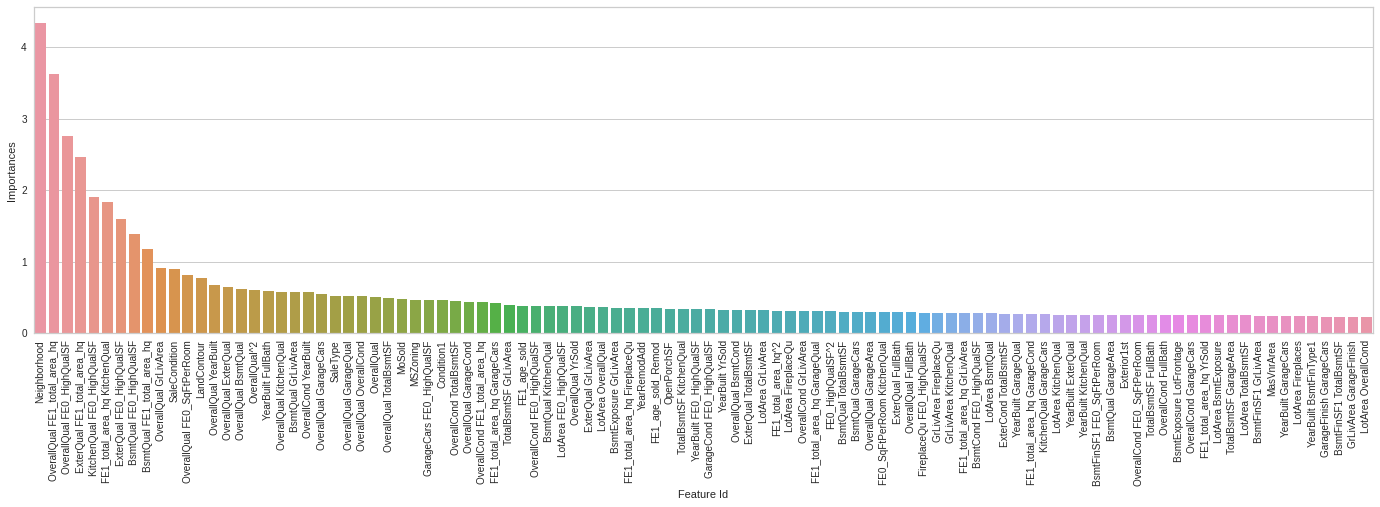

In [54]:
plt.figure(figsize=(6, 24))
sns.barplot(x="Feature Id", y="Importances", data=fe, orient="v")
plt.xticks(rotation=90)
plt.show()

In [56]:
sub_name = "data/submission_17.csv"
pd.DataFrame(model.predict(X_test), 
            index=range(1461, len(df)+1), 
            columns=['SalePrice']).reset_index().\
            rename(columns={'index': 'id'}).to_csv(sub_name, index=False)

# Score: 0.12036